## setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('../../..')

In [ ]:
from copulae.input import generate_copula_net_input


from copulae.training.cflax.mlp import MLP
from copulae.training.cflax.mlp import SingleLogitCopula as SLC

from copulae.training.cflax.bilogit import PositiveBiLogitCopula as PBLC
from copulae.training.cflax.bilogit import SiamesePositiveBiLogitCopula as SPBLC

from copulae.training.cflax.binorm import PositiveBiNormalCopula as PBNC
from copulae.training.cflax.binorm import SiamesePositiveBiNormalCopula as SPBNC

from copulae.training.cflax.mono_aux import PositiveLayer
from copulae.training.cflax.mono_aux import (
    EluPOne, Identity, ResELUPlusOne, ResSoftPlus, SoftPlus
)

from copulae.training.loss import sq_error, sq_error_partial, copula_likelihood
from copulae.training.loss import sq_frechet, sq_valid_partial, sq_valid_density
from copulae.training.loss import cross_entropy, cross_entropy_partial

from copulae.training import setup_training

In [ ]:
import jax.numpy as jnp
import jax.scipy.stats as jss
import jax

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import optax

In [ ]:
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
import pickle

In [ ]:
def get_model(type, layer_widths):
  # Positive Bi Logit Copula
  if type == 'pblc':
    model = PBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Logit Copula
  elif type == 'spblc':
    model = SPBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Positive Bi Normal Copula
  elif type == 'pbnc':
    model = PBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Normal Copula
  elif type == 'spbnc':
    model = SPBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Single Logit Copula
  elif type == 'slc':
    model = SLC(
        MLP(layer_widths)
    )

  return model

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

## plot

In [ ]:
plt.rcParams['figure.figsize'] = (8, 5)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 10

In [ ]:
plt.style.use('tableau-colorblind10')
plt.ion();

## data

In [ ]:
import pandas as pd
import scipy
import copy

from sklearn.model_selection import train_test_split

In [ ]:
def negative_log_likelihood(Ŷc_batches, I_pdf):
  copula_density = jnp.clip(Ŷc_batches, 1e-6)
  kde_density = jnp.clip(I_pdf, 1e-6)
  return -(jnp.log(copula_density) + jnp.log(kde_density)).mean()

In [ ]:
def add_train_random_noise(data, num_adds):
  new_data = np.random.rand(num_adds, data.shape[1])
  return np.concatenate((data, new_data), axis = 0)

In [ ]:
def rank_normalization(X):
  X = copy.deepcopy(X)
  for z in X:
      ndata = z.shape[0]
      gap = 1./(ndata+1)
      nfeats = z.shape[1]
      for i in range(nfeats):
          z[:, i] = scipy.stats.rankdata(z[:, i], 'ordinal')*gap
  return X

In [ ]:
!git clone https://github.com/yutingng/gen-AC.git

Cloning into 'gen-AC'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 466 (delta 159), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (466/466), 10.28 MiB | 25.30 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [ ]:
class Boston():
  def __init__(self):
    # read
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 142857)
    X_train = np.concatenate((X_train, y_train[:, None]), axis = 1)
    X_test  = np.concatenate((X_test, y_test[:, None]), axis = 1)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # noise
    X_train = add_train_random_noise(X_train, int(X_train.shape[0]*0.01))

    # 2d
    train_data = X_train[:, [0, 13]]
    test_data = X_test[:, [0, 13]]

    # flip
    train_data[:, 0] = 1 - train_data[:, 0]
    test_data[:, 0] = 1 - test_data[:, 0]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

In [ ]:
np.random.seed(30091985)

In [ ]:
key = jax.random.PRNGKey(30091985)

## imshow

In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
from jax.scipy.stats import gaussian_kde

In [ ]:
def concatenate_cdfs(cdf_x, cdf_y):
  #cumulative_x = np.array(cdf_x)
  #cumulative_y = np.array(cdf_y)

  #cumulative_x = np.expand_dims(cumulative_x, axis=0)
  #cumulative_y = np.expand_dims(cumulative_y, axis=0)

  XY_cumulatives = jnp.concatenate((cdf_x, cdf_y), axis=0)
  #XY_cumulatives = jnp.asarray(XY_cumulatives)
  XY_cumulatives = jnp.expand_dims(XY_cumulatives, axis=0)

  return XY_cumulatives

In [ ]:
def get_density_graph_data2(data_points):
  LOW = 0
  HIGH = 1
  npts = 800

  side = jnp.linspace(LOW, HIGH, npts)
  xx, yy = jnp.meshgrid(side, side)
  points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  densities = kde_x.evaluate(side)
  cumulatives = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in side])

  density_x, _ = jnp.meshgrid(densities, densities)
  density_x = density_x.reshape(-1, 1)
  cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  densities = kde_y.evaluate(side)
  cumulatives = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in side])

  _, density_y = jnp.meshgrid(densities, densities)
  density_y = density_y.reshape(-1, 1)
  _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y
  del _

  return points, I_pdf, cdf_xy

In [ ]:
def make_density_plot(points, joint_density):
  points = points[0]
  heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights=joint_density[0])
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  fig, axes = plt.subplots(1, 1, figsize=(5.5 * 3, 5))
  ax = axes

  N = points.shape[1]

  ax.invert_yaxis()
  ax.imshow(joint_density[0].reshape(N, N), origin='lower')
  #ax.imshow(heatmap.T, origin = 'lower')
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])

  plt.show()

## utils

In [ ]:
def L_d(losses, params, state):
  loss = jnp.zeros((1,len(losses)), dtype=jnp.float32)
  for i, (w, loss_func) in enumerate(losses):
    loss = loss.at[0, i].set(w * loss_func(params, state))
  return loss

In [ ]:
losses_eval = [
    (1.0, sq_error),
    (1.0, sq_error_partial),
    (1.0, copula_likelihood),

    # (1.0, sq_valid),
    # (1.0, sq_valid_partial),
    # (1.0, sq_valid_density),
    # (1.0, sq_frechet),
]

In [ ]:
def plot_yyhat(state, TrainingTensors):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].scatter(state.ŶC_batches[0], TrainingTensors[5][0]);
  # axes[0].set(xlim = (0, 1), ylim = (0, 1), )
  axes[0].set(xlim = (min(0, np.min(state.ŶC_batches[0])), max(1, np.max(cop_state.ŶC_batches[0]))), ylim = (0, 1), )
  axes[1].scatter(state.ŶdC_batches[0][0], TrainingTensors[4][0][0]);
  # axes[1].set(xlim = (0, 1), ylim = (0, 1), )
  axes[1].set(xlim = (min(0, np.min(state.ŶdC_batches[0][0])), max(1, np.max(cop_state.ŶdC_batches[0][0]))), ylim = (0, 1), )
  axes[2].scatter(state.ŶdC_batches[0][1], TrainingTensors[4][0][1]);
  # axes[2].set(xlim = (0, 1), ylim = (0, 1), )
  axes[2].set(xlim = (min(0, np.min(state.ŶdC_batches[0][1])), max(1, np.max(cop_state.ŶdC_batches[0][1]))), ylim = (0, 1), )
  plt.show()

In [ ]:
def test_set(D_val, data_points):
  # LOW = 0
  # HIGH = 1
  # npts = 800

  # side = jnp.linspace(LOW, HIGH, npts)
  # xx, yy = jnp.meshgrid(side, side)
  # points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = D_val
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  density_x = kde_x.evaluate(points[0, 0, :])
  cumulative_x = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in points[0, 0, :]])

  # density_x, _ = jnp.meshgrid(densities, densities)
  # density_x = density_x.reshape(-1, 1)
  # cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  density_y = kde_y.evaluate(points[0, 1, :])
  cumulative_y = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in points[0, 1, :]])

  # _, density_y = jnp.meshgrid(densities, densities)
  # density_y = density_y.reshape(-1, 1)
  # _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  I_pdf = jnp.expand_dims(I_pdf, axis=0)
  # cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)
  cdf_xy = jnp.array((cumulative_x, cumulative_y))
  cdf_xy = jnp.expand_dims(cdf_xy, axis=0)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y

  return points, I_pdf, cdf_xy

In [ ]:
def plot_log(log, lim = None):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].plot(np.array(log)[:, 0, 0]);
  axes[1].plot(np.array(log)[:, 0, 1]);
  axes[2].plot(np.array(log)[:, 0, 2]);
  axes[2].set(ylim = lim, )
  plt.show()

In [ ]:
def sanity(state, nn_c, params):
  density_graph_points, I_pdf, cdf_xy = get_density_graph_data2(state.X_batches[0])

  copula_density = nn_c(params, cdf_xy)
  points_density = copula_density * I_pdf

  points = density_graph_points[0]
  #heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = points_density[0])
  #logheatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = np.log(jnp.clip(points_density[0], 1e-6)))
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  N = int(np.sqrt(points.shape[1]))
  heatmap = points_density[0].reshape(N,N)
  logheatmap = np.log(jnp.clip(points_density[0], 1e-6)).reshape(N,N)

  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))

  axes[0].scatter(
      cop_state.X_batches[0][0, :],
      cop_state.X_batches[0][1, :],
      s=80,
      edgecolor='k',
      alpha=0.5
  );

  axes[1].invert_yaxis()
  #axes[1].imshow(heatmap.T, origin = 'lower')
  axes[1].imshow(heatmap, origin = 'lower')
  axes[1].get_xaxis().set_ticks([])
  axes[1].get_yaxis().set_ticks([])

  axes[2].invert_yaxis()
  #axes[2].imshow(logheatmap.T, origin = 'lower')
  axes[2].imshow(logheatmap, origin = 'lower')
  axes[2].get_xaxis().set_ticks([])
  axes[2].get_yaxis().set_ticks([])
  plt.show()

In [ ]:
import flax.linen as nn

from copulae.typing import Sequence
from copulae.typing import Tensor

class LogitPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        e = jnp.exp(-z)
        return e / (1 + e)

class NormalPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        return jss.norm.pdf(z)

In [ ]:
class MixtureLogitPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += LogitPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv


class MixtureNormalPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += NormalPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv

## PARAMS

In [ ]:
MODELS_PATH = os.path.join('drive', 'MyDrive', 'copulas', 'models', '2cats_SL')
os.makedirs(MODELS_PATH, exist_ok=True)

In [ ]:
layer_widths = [128, 64, 32, 16]

losses = [
    (0.01, sq_error),
    (0.5, sq_error_partial),
    (0.1, copula_likelihood),
]

lr = 2e-3

n_iter = 10000

## Gauss $\rho=0.1$

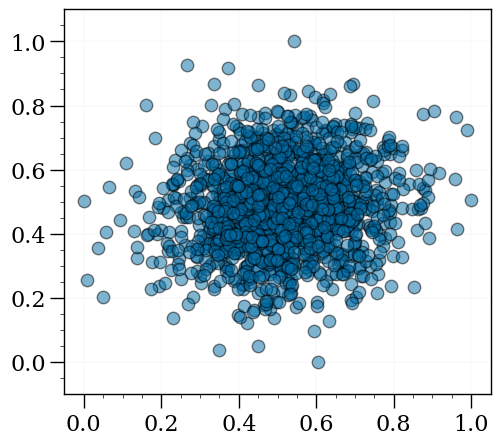

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:33<92:17:48, 33.23s/it]

Iter 0. Loss [[ 0.07747189  0.2807096  19.931568  ]]


  0%|          | 12/10000 [00:57<1:30:34,  1.84it/s]

Iter 10. Loss [[0.08642212 0.25329912 5.7632995 ]]


  0%|          | 22/10000 [00:59<26:02,  6.39it/s]

Iter 20. Loss [[0.09164086 0.24176538 5.10163   ]]


  0%|          | 31/10000 [01:00<29:11,  5.69it/s]

Iter 30. Loss [[0.09721253 0.23254928 4.859833  ]]


  0%|          | 41/10000 [01:02<38:57,  4.26it/s]

Iter 40. Loss [[0.09987669 0.22917338 4.806768  ]]


  1%|          | 52/10000 [01:05<28:46,  5.76it/s]

Iter 50. Loss [[0.09922405 0.22912921 4.6881475 ]]


  1%|          | 62/10000 [01:06<22:57,  7.21it/s]

Iter 60. Loss [[0.09883842 0.22845341 4.5396924 ]]


  1%|          | 72/10000 [01:07<23:05,  7.17it/s]

Iter 70. Loss [[0.09905077 0.22661467 4.3408427 ]]


  1%|          | 82/10000 [01:09<24:10,  6.84it/s]

Iter 80. Loss [[0.09871262 0.22571371 4.0606794 ]]


  1%|          | 92/10000 [01:10<23:17,  7.09it/s]

Iter 90. Loss [[0.09783041 0.22551225 3.836767  ]]


  1%|          | 102/10000 [01:12<22:51,  7.22it/s]

Iter 100. Loss [[0.09667603 0.2251813  3.6961303 ]]


  1%|          | 112/10000 [01:13<22:39,  7.27it/s]

Iter 110. Loss [[0.09547544 0.22292686 3.6707544 ]]


  1%|          | 121/10000 [01:15<34:29,  4.77it/s]

Iter 120. Loss [[0.09413535 0.2218361  3.6261034 ]]


  1%|▏         | 131/10000 [01:17<36:57,  4.45it/s]

Iter 130. Loss [[0.09284517 0.22171268 3.6348011 ]]


  1%|▏         | 142/10000 [01:19<25:50,  6.36it/s]

Iter 140. Loss [[0.09218953 0.22269316 3.6805828 ]]


  2%|▏         | 152/10000 [01:21<23:01,  7.13it/s]

Iter 150. Loss [[0.09238354 0.2232636  3.7020566 ]]


  2%|▏         | 162/10000 [01:22<32:06,  5.11it/s]

Iter 160. Loss [[0.09337735 0.22044826 3.7434306 ]]


  2%|▏         | 172/10000 [01:24<22:44,  7.20it/s]

Iter 170. Loss [[0.09465341 0.21418875 3.7093978 ]]


  2%|▏         | 182/10000 [01:25<22:15,  7.35it/s]

Iter 180. Loss [[0.09538873 0.20757881 3.713304  ]]


  2%|▏         | 192/10000 [01:26<22:30,  7.26it/s]

Iter 190. Loss [[0.09476085 0.20384884 3.7050312 ]]


  2%|▏         | 202/10000 [01:28<23:23,  6.98it/s]

Iter 200. Loss [[0.09388095 0.20203973 3.6142528 ]]


  2%|▏         | 211/10000 [01:31<1:19:48,  2.04it/s]

Iter 210. Loss [[0.09442161 0.1984014  3.5087872 ]]


  2%|▏         | 222/10000 [01:34<31:43,  5.14it/s]

Iter 220. Loss [[0.09552979 0.18942517 3.3815098 ]]


  2%|▏         | 232/10000 [01:35<22:43,  7.16it/s]

Iter 230. Loss [[0.09430011 0.18262048 3.337372  ]]


  2%|▏         | 242/10000 [01:36<22:45,  7.15it/s]

Iter 240. Loss [[0.09166504 0.18066697 3.3416    ]]


  3%|▎         | 251/10000 [01:38<22:24,  7.25it/s]

Iter 250. Loss [[0.08980943 0.18164831 3.5124857 ]]


  3%|▎         | 262/10000 [01:40<23:42,  6.84it/s]

Iter 260. Loss [[0.09017463 0.18226385 3.6278076 ]]


  3%|▎         | 272/10000 [01:41<22:43,  7.13it/s]

Iter 270. Loss [[0.09333178 0.179797   3.5717516 ]]


  3%|▎         | 282/10000 [01:43<23:38,  6.85it/s]

Iter 280. Loss [[0.09943558 0.17517112 3.398726  ]]


  3%|▎         | 291/10000 [01:45<35:35,  4.55it/s]

Iter 290. Loss [[0.10848992 0.16753969 3.1242187 ]]


  3%|▎         | 301/10000 [01:47<38:56,  4.15it/s]

Iter 300. Loss [[0.12109181 0.15738276 2.7986927 ]]


  3%|▎         | 311/10000 [01:50<44:06,  3.66it/s]

Iter 310. Loss [[0.138717   0.14499849 2.4537673 ]]


  3%|▎         | 322/10000 [01:52<35:46,  4.51it/s]

Iter 320. Loss [[0.16314948 0.13177629 2.034589  ]]


  3%|▎         | 332/10000 [01:54<23:11,  6.95it/s]

Iter 330. Loss [[0.19630069 0.11103073 1.5509509 ]]


  3%|▎         | 342/10000 [01:55<20:43,  7.77it/s]

Iter 340. Loss [[0.22690101 0.08720239 1.0335441 ]]


  4%|▎         | 352/10000 [01:57<26:01,  6.18it/s]

Iter 350. Loss [[0.19692695 0.07684065 0.82007957]]


  4%|▎         | 362/10000 [01:58<22:44,  7.06it/s]

Iter 360. Loss [[0.15202096 0.09481934 0.33593184]]


  4%|▎         | 372/10000 [02:00<22:26,  7.15it/s]

Iter 370. Loss [[0.13947815 0.05789873 0.1723932 ]]


  4%|▍         | 381/10000 [02:01<36:05,  4.44it/s]

Iter 380. Loss [[0.1765058  0.05314357 0.22666708]]


  4%|▍         | 391/10000 [02:04<38:17,  4.18it/s]

Iter 390. Loss [[0.21057017 0.05979995 0.15450358]]


  4%|▍         | 402/10000 [02:06<24:07,  6.63it/s]

Iter 400. Loss [[0.23091373 0.06007945 0.14021261]]


  4%|▍         | 412/10000 [02:07<22:25,  7.12it/s]

Iter 410. Loss [[0.23844564 0.06103246 0.1598859 ]]


  4%|▍         | 422/10000 [02:09<22:03,  7.23it/s]

Iter 420. Loss [[0.23934795 0.05946211 0.1965518 ]]


  4%|▍         | 432/10000 [02:10<23:04,  6.91it/s]

Iter 430. Loss [[0.23857515 0.0579103  0.19753674]]


  4%|▍         | 442/10000 [02:11<22:37,  7.04it/s]

Iter 440. Loss [[0.23995739 0.05496535 0.23185185]]


  5%|▍         | 452/10000 [02:13<22:47,  6.98it/s]

Iter 450. Loss [[0.24249265 0.05360658 0.25341144]]


  5%|▍         | 462/10000 [02:14<22:22,  7.10it/s]

Iter 460. Loss [[0.24292214 0.054075   0.2639929 ]]


  5%|▍         | 471/10000 [02:16<36:39,  4.33it/s]

Iter 470. Loss [[0.2432369  0.05282693 0.27808344]]


  5%|▍         | 482/10000 [02:19<30:42,  5.17it/s]

Iter 480. Loss [[0.24355704 0.05121189 0.2959439 ]]


  5%|▍         | 492/10000 [02:20<22:38,  7.00it/s]

Iter 490. Loss [[0.24406789 0.05053818 0.31719452]]


  5%|▌         | 502/10000 [02:22<22:15,  7.11it/s]

Iter 500. Loss [[0.24458614 0.05047205 0.31744936]]


  5%|▌         | 512/10000 [02:23<31:37,  5.00it/s]

Iter 510. Loss [[0.24489911 0.04995661 0.31982592]]


  5%|▌         | 522/10000 [02:25<22:04,  7.16it/s]

Iter 520. Loss [[0.24586105 0.04985186 0.3155488 ]]


  5%|▌         | 532/10000 [02:26<21:55,  7.20it/s]

Iter 530. Loss [[0.24660267 0.04939138 0.32078966]]


  5%|▌         | 542/10000 [02:28<23:51,  6.61it/s]

Iter 540. Loss [[0.24706303 0.04924233 0.32302627]]


  6%|▌         | 551/10000 [02:29<30:31,  5.16it/s]

Iter 550. Loss [[0.24763739 0.04838305 0.3219686 ]]


  6%|▌         | 561/10000 [02:32<36:12,  4.34it/s]

Iter 560. Loss [[0.24812648 0.04741541 0.33234975]]


  6%|▌         | 572/10000 [02:34<28:20,  5.54it/s]

Iter 570. Loss [[0.24884933 0.04739479 0.32736874]]


  6%|▌         | 582/10000 [02:35<22:07,  7.09it/s]

Iter 580. Loss [[0.24928479 0.04730182 0.32727042]]


  6%|▌         | 592/10000 [02:37<21:55,  7.15it/s]

Iter 590. Loss [[0.25032613 0.04734254 0.32250324]]


  6%|▌         | 602/10000 [02:38<21:31,  7.28it/s]

Iter 600. Loss [[0.25099558 0.04721136 0.32339442]]


  6%|▌         | 612/10000 [02:39<22:00,  7.11it/s]

Iter 610. Loss [[0.25167808 0.04708818 0.31938866]]


  6%|▌         | 622/10000 [02:41<22:05,  7.07it/s]

Iter 620. Loss [[0.25242785 0.04712302 0.31906074]]


  6%|▋         | 632/10000 [02:43<21:31,  7.25it/s]

Iter 630. Loss [[0.25306857 0.0469601  0.3149168 ]]


  6%|▋         | 641/10000 [02:44<34:03,  4.58it/s]

Iter 640. Loss [[0.25375974 0.04687892 0.31373957]]


  7%|▋         | 651/10000 [02:46<35:28,  4.39it/s]

Iter 650. Loss [[0.25402766 0.04374624 0.3328422 ]]


  7%|▋         | 662/10000 [02:48<23:07,  6.73it/s]

Iter 660. Loss [[0.25432247 0.04389276 0.34972563]]


  7%|▋         | 672/10000 [02:50<21:10,  7.34it/s]

Iter 670. Loss [[0.255151   0.04431293 0.3298393 ]]


  7%|▋         | 682/10000 [02:51<21:44,  7.14it/s]

Iter 680. Loss [[0.25589928 0.04468648 0.31833023]]


  7%|▋         | 691/10000 [02:52<22:27,  6.91it/s]

Iter 690. Loss [[0.25710317 0.0447179  0.31437027]]


  7%|▋         | 702/10000 [02:54<22:33,  6.87it/s]

Iter 700. Loss [[0.25752378 0.0449084  0.30975312]]


  7%|▋         | 712/10000 [02:56<21:37,  7.16it/s]

Iter 710. Loss [[0.2582462  0.04482547 0.3052526 ]]


  7%|▋         | 722/10000 [02:57<21:07,  7.32it/s]

Iter 720. Loss [[0.2589234  0.04486081 0.30112407]]


  7%|▋         | 731/10000 [02:59<47:08,  3.28it/s]

Iter 730. Loss [[0.25968102 0.04502628 0.2961388 ]]


  7%|▋         | 741/10000 [03:01<33:25,  4.62it/s]

Iter 740. Loss [[0.2602414  0.04494209 0.29081732]]


  8%|▊         | 752/10000 [03:03<22:40,  6.80it/s]

Iter 750. Loss [[0.26094818 0.04499478 0.28638655]]


  8%|▊         | 762/10000 [03:04<21:12,  7.26it/s]

Iter 760. Loss [[0.2615302  0.04493281 0.28340247]]


  8%|▊         | 772/10000 [03:06<21:20,  7.20it/s]

Iter 770. Loss [[0.26208597 0.04496992 0.2792546 ]]


  8%|▊         | 782/10000 [03:07<23:34,  6.52it/s]

Iter 780. Loss [[0.26266173 0.04491693 0.27529   ]]


  8%|▊         | 792/10000 [03:09<20:46,  7.38it/s]

Iter 790. Loss [[0.26322362 0.04499647 0.27175426]]


  8%|▊         | 802/10000 [03:10<21:18,  7.19it/s]

Iter 800. Loss [[0.26371956 0.04496377 0.2689646 ]]


  8%|▊         | 812/10000 [03:12<24:57,  6.14it/s]

Iter 810. Loss [[0.26419017 0.04497318 0.26395458]]


  8%|▊         | 821/10000 [03:13<33:22,  4.58it/s]

Iter 820. Loss [[0.26474908 0.04506406 0.25862944]]


  8%|▊         | 831/10000 [03:16<34:50,  4.39it/s]

Iter 830. Loss [[0.26528946 0.04519517 0.25585344]]


  8%|▊         | 842/10000 [03:17<22:21,  6.83it/s]

Iter 840. Loss [[0.265581   0.04527681 0.25346932]]


  9%|▊         | 852/10000 [03:19<20:40,  7.37it/s]

Iter 850. Loss [[0.26607224 0.04533829 0.25068584]]


  9%|▊         | 862/10000 [03:20<22:53,  6.66it/s]

Iter 860. Loss [[0.26653573 0.04550664 0.24474259]]


  9%|▊         | 872/10000 [03:22<20:51,  7.29it/s]

Iter 870. Loss [[0.26692453 0.04538594 0.24052458]]


  9%|▉         | 882/10000 [03:23<21:42,  7.00it/s]

Iter 880. Loss [[0.26741934 0.04573669 0.23550785]]


  9%|▉         | 891/10000 [03:24<21:34,  7.04it/s]

Iter 890. Loss [[0.26776928 0.04547764 0.22885755]]


  9%|▉         | 902/10000 [03:27<22:48,  6.65it/s]

Iter 900. Loss [[0.26822063 0.04565473 0.22701249]]


  9%|▉         | 911/10000 [03:29<34:24,  4.40it/s]

Iter 910. Loss [[0.26843873 0.04555964 0.2247287 ]]


  9%|▉         | 922/10000 [03:31<32:00,  4.73it/s]

Iter 920. Loss [[0.26869175 0.04559383 0.22289199]]


  9%|▉         | 932/10000 [03:32<21:41,  6.97it/s]

Iter 930. Loss [[0.26891637 0.04560046 0.22035106]]


  9%|▉         | 942/10000 [03:34<22:01,  6.85it/s]

Iter 940. Loss [[0.2691404  0.04491345 0.21944502]]


 10%|▉         | 952/10000 [03:36<20:57,  7.19it/s]

Iter 950. Loss [[0.26909137 0.0434389  0.23142946]]


 10%|▉         | 962/10000 [03:37<20:54,  7.21it/s]

Iter 960. Loss [[0.2689197  0.04107165 0.25436038]]


 10%|▉         | 972/10000 [03:38<21:04,  7.14it/s]

Iter 970. Loss [[0.26878306 0.04205739 0.250745  ]]


 10%|▉         | 982/10000 [03:40<22:04,  6.81it/s]

Iter 980. Loss [[0.2702867  0.04621252 0.19862504]]


 10%|▉         | 991/10000 [03:41<26:36,  5.64it/s]

Iter 990. Loss [[0.27116233 0.04763272 0.17790115]]


 10%|█         | 1001/10000 [03:44<48:31,  3.09it/s]

Iter 1000. Loss [[0.27172917 0.04779078 0.17502381]]


 10%|█         | 1012/10000 [03:46<24:12,  6.19it/s]

Iter 1010. Loss [[0.2708582  0.04619938 0.18431327]]


 10%|█         | 1022/10000 [03:47<20:58,  7.13it/s]

Iter 1020. Loss [[0.27187228 0.04625858 0.18099068]]


 10%|█         | 1032/10000 [03:49<20:39,  7.23it/s]

Iter 1030. Loss [[0.27130705 0.04538058 0.18638104]]


 10%|█         | 1042/10000 [03:50<23:40,  6.31it/s]

Iter 1040. Loss [[0.27240142 0.04618162 0.17056121]]


 11%|█         | 1051/10000 [03:52<34:03,  4.38it/s]

Iter 1050. Loss [[0.2723511  0.0458675  0.16576223]]


 11%|█         | 1062/10000 [03:55<31:40,  4.70it/s]

Iter 1060. Loss [[0.2737274  0.04607166 0.13999939]]


 11%|█         | 1071/10000 [03:57<33:24,  4.45it/s]

Iter 1070. Loss [[0.27472782 0.04420529 0.14052358]]


 11%|█         | 1081/10000 [03:59<33:46,  4.40it/s]

Iter 1080. Loss [[0.2782202  0.03674876 0.121672  ]]


 11%|█         | 1092/10000 [04:01<21:49,  6.80it/s]

Iter 1090. Loss [[0.28551477 0.03627923 0.07684121]]


 11%|█         | 1102/10000 [04:02<20:06,  7.37it/s]

Iter 1100. Loss [[ 0.29760233  0.05266964 -0.05736794]]


 11%|█         | 1112/10000 [04:04<20:24,  7.26it/s]

Iter 1110. Loss [[ 0.31065723  0.04922502 -0.04459978]]


 11%|█         | 1122/10000 [04:05<20:30,  7.22it/s]

Iter 1120. Loss [[ 0.31771415  0.0527839  -0.09344805]]


 11%|█▏        | 1132/10000 [04:06<20:43,  7.13it/s]

Iter 1130. Loss [[0.3188765  0.03324471 0.05320784]]


 11%|█▏        | 1142/10000 [04:08<20:37,  7.16it/s]

Iter 1140. Loss [[0.2827897  0.02441426 0.13205646]]


 12%|█▏        | 1152/10000 [04:09<24:17,  6.07it/s]

Iter 1150. Loss [[ 0.3255787   0.04898209 -0.38687885]]


 12%|█▏        | 1161/10000 [04:11<32:23,  4.55it/s]

Iter 1160. Loss [[ 0.34542894  0.07468762 -0.59610033]]


 12%|█▏        | 1171/10000 [04:14<33:22,  4.41it/s]

Iter 1170. Loss [[ 0.33883607  0.04641727 -0.5333667 ]]


 12%|█▏        | 1182/10000 [04:16<21:55,  6.70it/s]

Iter 1180. Loss [[ 0.35468867  0.03692845 -0.47928104]]


 12%|█▏        | 1192/10000 [04:17<20:24,  7.19it/s]

Iter 1190. Loss [[ 0.34778413  0.04883508 -0.38565987]]


 12%|█▏        | 1202/10000 [04:18<20:20,  7.21it/s]

Iter 1200. Loss [[ 0.34810516  0.05814849 -0.47008324]]


 12%|█▏        | 1212/10000 [04:20<21:25,  6.84it/s]

Iter 1210. Loss [[ 0.33946645  0.03397409 -0.3949078 ]]


 12%|█▏        | 1222/10000 [04:21<20:26,  7.16it/s]

Iter 1220. Loss [[ 0.35559767  0.05975402 -0.48403245]]


 12%|█▏        | 1232/10000 [04:23<21:18,  6.86it/s]

Iter 1230. Loss [[ 0.34360155  0.04973864 -0.41428757]]


 12%|█▏        | 1242/10000 [04:24<20:16,  7.20it/s]

Iter 1240. Loss [[ 0.34536117  0.05594721 -0.45765254]]


 13%|█▎        | 1251/10000 [04:26<33:02,  4.41it/s]

Iter 1250. Loss [[ 0.35346606  0.06782334 -0.56716996]]


 13%|█▎        | 1262/10000 [04:29<30:10,  4.83it/s]

Iter 1260. Loss [[ 0.3578121   0.06200124 -0.6371759 ]]


 13%|█▎        | 1272/10000 [04:30<20:17,  7.17it/s]

Iter 1270. Loss [[ 0.3595229   0.05691524 -0.61193943]]


 13%|█▎        | 1282/10000 [04:32<20:23,  7.13it/s]

Iter 1280. Loss [[ 0.3507925   0.04289604 -0.5141931 ]]


 13%|█▎        | 1292/10000 [04:33<20:21,  7.13it/s]

Iter 1290. Loss [[ 0.34304336  0.06264672 -0.41724592]]


 13%|█▎        | 1302/10000 [04:34<19:43,  7.35it/s]

Iter 1300. Loss [[ 0.3242154   0.05486155 -0.27261946]]


 13%|█▎        | 1312/10000 [04:36<20:32,  7.05it/s]

Iter 1310. Loss [[ 0.33319062  0.06142525 -0.3500948 ]]


 13%|█▎        | 1322/10000 [04:37<20:00,  7.23it/s]

Iter 1320. Loss [[ 0.33514178  0.06767625 -0.43364674]]


 13%|█▎        | 1332/10000 [04:38<19:42,  7.33it/s]

Iter 1330. Loss [[ 0.33590278  0.06759682 -0.48642144]]


 13%|█▎        | 1341/10000 [04:40<31:54,  4.52it/s]

Iter 1340. Loss [[ 0.33331504  0.07317441 -0.51488596]]


 14%|█▎        | 1351/10000 [04:43<45:42,  3.15it/s]

Iter 1350. Loss [[ 0.33238274  0.06812283 -0.54148984]]


 14%|█▎        | 1362/10000 [04:44<20:55,  6.88it/s]

Iter 1360. Loss [[ 0.3332674   0.06922723 -0.5661588 ]]


 14%|█▎        | 1372/10000 [04:46<20:02,  7.18it/s]

Iter 1370. Loss [[ 0.3286799   0.05889908 -0.5201425 ]]


 14%|█▍        | 1382/10000 [04:47<20:57,  6.86it/s]

Iter 1380. Loss [[ 0.32556513  0.0534454  -0.47648787]]


 14%|█▍        | 1392/10000 [04:49<19:57,  7.19it/s]

Iter 1390. Loss [[ 0.3311152   0.05920465 -0.5091802 ]]


 14%|█▍        | 1402/10000 [04:50<21:07,  6.78it/s]

Iter 1400. Loss [[ 0.33867446  0.06467767 -0.56150615]]


 14%|█▍        | 1412/10000 [04:52<19:35,  7.31it/s]

Iter 1410. Loss [[ 0.34485325  0.06294972 -0.5788269 ]]


 14%|█▍        | 1422/10000 [04:53<20:24,  7.00it/s]

Iter 1420. Loss [[ 0.35043135  0.07784745 -0.6093385 ]]


 14%|█▍        | 1431/10000 [04:55<34:29,  4.14it/s]

Iter 1430. Loss [[ 0.3368779   0.07100791 -0.57951516]]


 14%|█▍        | 1442/10000 [04:58<30:33,  4.67it/s]

Iter 1440. Loss [[0.25896195 0.04506575 0.0746896 ]]


 15%|█▍        | 1452/10000 [04:59<18:37,  7.65it/s]

Iter 1450. Loss [[ 0.2816893   0.05162403 -0.25818282]]


 15%|█▍        | 1462/10000 [05:00<17:42,  8.04it/s]

Iter 1460. Loss [[ 0.31946522  0.08317767 -0.4710105 ]]


 15%|█▍        | 1472/10000 [05:02<18:02,  7.88it/s]

Iter 1470. Loss [[ 0.30768752  0.07160516 -0.46315962]]


 15%|█▍        | 1482/10000 [05:03<18:45,  7.57it/s]

Iter 1480. Loss [[ 0.3036776   0.06314585 -0.44977686]]


 15%|█▍        | 1492/10000 [05:04<18:05,  7.84it/s]

Iter 1490. Loss [[ 0.311795    0.06607648 -0.47368506]]


 15%|█▌        | 1502/10000 [05:06<17:53,  7.92it/s]

Iter 1500. Loss [[ 0.3099343   0.06312037 -0.45545036]]


 15%|█▌        | 1512/10000 [05:07<18:16,  7.74it/s]

Iter 1510. Loss [[ 0.30935028  0.06211818 -0.4543325 ]]


 15%|█▌        | 1522/10000 [05:09<26:51,  5.26it/s]

Iter 1520. Loss [[ 0.31243813  0.06456571 -0.4735686 ]]


 15%|█▌        | 1531/10000 [05:11<30:45,  4.59it/s]

Iter 1530. Loss [[ 0.3128841   0.06359012 -0.4769921 ]]


 15%|█▌        | 1542/10000 [05:13<22:20,  6.31it/s]

Iter 1540. Loss [[ 0.3127667   0.06206906 -0.4803575 ]]


 16%|█▌        | 1552/10000 [05:14<18:17,  7.70it/s]

Iter 1550. Loss [[ 0.31235668  0.0618859  -0.48160335]]


 16%|█▌        | 1562/10000 [05:15<22:07,  6.36it/s]

Iter 1560. Loss [[ 0.30927554  0.06183624 -0.48120862]]


 16%|█▌        | 1572/10000 [05:17<17:38,  7.96it/s]

Iter 1570. Loss [[ 0.30639756  0.06198321 -0.48626935]]


 16%|█▌        | 1582/10000 [05:18<20:14,  6.93it/s]

Iter 1580. Loss [[ 0.3051305   0.06173036 -0.4926848 ]]


 16%|█▌        | 1592/10000 [05:20<27:46,  5.05it/s]

Iter 1590. Loss [[ 0.30600423  0.06244265 -0.504657  ]]


 16%|█▌        | 1602/10000 [05:21<18:11,  7.69it/s]

Iter 1600. Loss [[ 0.30617693  0.06183023 -0.51480395]]


 16%|█▌        | 1612/10000 [05:22<19:38,  7.12it/s]

Iter 1610. Loss [[ 0.30590174  0.06280226 -0.52206784]]


 16%|█▌        | 1621/10000 [05:24<31:11,  4.48it/s]

Iter 1620. Loss [[ 0.30429396  0.06227949 -0.52114373]]


 16%|█▋        | 1632/10000 [05:27<29:27,  4.73it/s]

Iter 1630. Loss [[ 0.3032621   0.06167917 -0.51992905]]


 16%|█▋        | 1642/10000 [05:28<20:16,  6.87it/s]

Iter 1640. Loss [[ 0.30194038  0.06194292 -0.52063864]]


 17%|█▋        | 1652/10000 [05:29<17:41,  7.87it/s]

Iter 1650. Loss [[ 0.30096874  0.06230851 -0.5241301 ]]


 17%|█▋        | 1662/10000 [05:31<17:37,  7.89it/s]

Iter 1660. Loss [[ 0.30026844  0.06163061 -0.524833  ]]


 17%|█▋        | 1672/10000 [05:32<19:03,  7.29it/s]

Iter 1670. Loss [[ 0.29917192  0.06128919 -0.52375895]]


 17%|█▋        | 1682/10000 [05:33<19:46,  7.01it/s]

Iter 1680. Loss [[ 0.2982402   0.06095358 -0.52311945]]


 17%|█▋        | 1692/10000 [05:35<17:23,  7.97it/s]

Iter 1690. Loss [[ 0.29723245  0.06034369 -0.5182616 ]]


 17%|█▋        | 1702/10000 [05:36<17:18,  7.99it/s]

Iter 1700. Loss [[ 0.29630983  0.06017881 -0.5140319 ]]


 17%|█▋        | 1711/10000 [05:37<27:00,  5.11it/s]

Iter 1710. Loss [[ 0.29521462  0.05995566 -0.5093057 ]]


 17%|█▋        | 1721/10000 [05:40<30:10,  4.57it/s]

Iter 1720. Loss [[ 0.2945512   0.06006842 -0.5077251 ]]


 17%|█▋        | 1732/10000 [05:42<19:47,  6.97it/s]

Iter 1730. Loss [[ 0.29402122  0.06069604 -0.50798976]]


 17%|█▋        | 1742/10000 [05:43<18:51,  7.30it/s]

Iter 1740. Loss [[ 0.29304075  0.06035076 -0.4991665 ]]


 18%|█▊        | 1752/10000 [05:45<22:07,  6.22it/s]

Iter 1750. Loss [[ 0.29244938  0.0602437  -0.49866623]]


 18%|█▊        | 1762/10000 [05:46<18:50,  7.29it/s]

Iter 1760. Loss [[ 0.29191193  0.06020597 -0.4946269 ]]


 18%|█▊        | 1772/10000 [05:47<19:25,  7.06it/s]

Iter 1770. Loss [[ 0.29111084  0.06020694 -0.4890594 ]]


 18%|█▊        | 1782/10000 [05:49<18:59,  7.21it/s]

Iter 1780. Loss [[ 0.28991583  0.05964432 -0.47707298]]


 18%|█▊        | 1792/10000 [05:50<18:07,  7.54it/s]

Iter 1790. Loss [[ 0.28974974  0.06074896 -0.47657987]]


 18%|█▊        | 1801/10000 [05:52<28:01,  4.88it/s]

Iter 1800. Loss [[ 0.2887503   0.06186803 -0.47754654]]


 18%|█▊        | 1811/10000 [05:54<32:25,  4.21it/s]

Iter 1810. Loss [[ 0.28711182  0.06048455 -0.46273935]]


 18%|█▊        | 1821/10000 [05:57<34:18,  3.97it/s]

Iter 1820. Loss [[ 0.28598967  0.06152387 -0.45258486]]


 18%|█▊        | 1831/10000 [05:59<33:16,  4.09it/s]

Iter 1830. Loss [[ 0.28430328  0.06141848 -0.4562123 ]]


 18%|█▊        | 1842/10000 [06:01<18:23,  7.39it/s]

Iter 1840. Loss [[ 0.2850877   0.06389183 -0.46713915]]


 19%|█▊        | 1852/10000 [06:02<18:23,  7.38it/s]

Iter 1850. Loss [[ 0.28486365  0.06394249 -0.4691426 ]]


 19%|█▊        | 1862/10000 [06:04<18:34,  7.30it/s]

Iter 1860. Loss [[ 0.28280538  0.06292736 -0.46001694]]


 19%|█▊        | 1872/10000 [06:05<19:49,  6.83it/s]

Iter 1870. Loss [[ 0.2819464   0.06249442 -0.45885286]]


 19%|█▉        | 1881/10000 [06:07<20:30,  6.60it/s]

Iter 1880. Loss [[ 0.2812602   0.06306019 -0.45561197]]


 19%|█▉        | 1891/10000 [06:09<30:51,  4.38it/s]

Iter 1890. Loss [[ 0.27984816  0.06161002 -0.44732192]]


 19%|█▉        | 1902/10000 [06:11<27:30,  4.91it/s]

Iter 1900. Loss [[ 0.27813596  0.06275579 -0.44281176]]


 19%|█▉        | 1912/10000 [06:13<18:03,  7.47it/s]

Iter 1910. Loss [[ 0.27609128  0.06165658 -0.43308797]]


 19%|█▉        | 1922/10000 [06:14<18:53,  7.13it/s]

Iter 1920. Loss [[ 0.2744583   0.06149316 -0.42466503]]


 19%|█▉        | 1932/10000 [06:15<18:15,  7.37it/s]

Iter 1930. Loss [[ 0.2738287   0.06235407 -0.42592025]]


 19%|█▉        | 1942/10000 [06:17<18:08,  7.40it/s]

Iter 1940. Loss [[ 0.2732133   0.06249382 -0.43101212]]


 20%|█▉        | 1952/10000 [06:18<18:44,  7.16it/s]

Iter 1950. Loss [[ 0.2726268   0.06278518 -0.43264177]]


 20%|█▉        | 1962/10000 [06:20<18:22,  7.29it/s]

Iter 1960. Loss [[ 0.27196312  0.0632031  -0.4331848 ]]


 20%|█▉        | 1972/10000 [06:21<18:16,  7.32it/s]

Iter 1970. Loss [[ 0.27116793  0.0631411  -0.42173302]]


 20%|█▉        | 1981/10000 [06:23<29:30,  4.53it/s]

Iter 1980. Loss [[ 0.2700196   0.0628761  -0.41948062]]


 20%|█▉        | 1991/10000 [06:25<30:09,  4.43it/s]

Iter 1990. Loss [[ 0.26937145  0.06265733 -0.41138345]]


 20%|██        | 2002/10000 [06:27<18:40,  7.14it/s]

Iter 2000. Loss [[ 0.26838946  0.06311239 -0.40991312]]


 20%|██        | 2011/10000 [06:28<18:43,  7.11it/s]

Iter 2010. Loss [[ 0.2674267   0.06337568 -0.4060679 ]]


 20%|██        | 2022/10000 [06:30<18:20,  7.25it/s]

Iter 2020. Loss [[ 0.26526964  0.06340215 -0.38236478]]


 20%|██        | 2032/10000 [06:31<18:14,  7.28it/s]

Iter 2030. Loss [[ 0.2619147   0.06071926 -0.35188892]]


 20%|██        | 2042/10000 [06:33<18:14,  7.27it/s]

Iter 2040. Loss [[ 0.2585026   0.05641571 -0.33293417]]


 21%|██        | 2052/10000 [06:34<17:30,  7.56it/s]

Iter 2050. Loss [[ 0.25317565  0.04999218 -0.32677576]]


 21%|██        | 2062/10000 [06:35<21:22,  6.19it/s]

Iter 2060. Loss [[ 0.26058784  0.05341189 -0.33897433]]


 21%|██        | 2071/10000 [06:37<30:19,  4.36it/s]

Iter 2070. Loss [[ 0.25411406  0.05305257 -0.31819457]]


 21%|██        | 2081/10000 [06:40<31:06,  4.24it/s]

Iter 2080. Loss [[ 0.25076556  0.05612376 -0.32392815]]


 21%|██        | 2092/10000 [06:42<23:50,  5.53it/s]

Iter 2090. Loss [[ 0.25104943  0.06301223 -0.3649873 ]]


 21%|██        | 2102/10000 [06:43<18:40,  7.05it/s]

Iter 2100. Loss [[ 0.25393352  0.06339818 -0.3874709 ]]


 21%|██        | 2112/10000 [06:44<18:28,  7.11it/s]

Iter 2110. Loss [[ 0.26327878  0.04938781 -0.37899047]]


 21%|██        | 2122/10000 [06:46<18:35,  7.06it/s]

Iter 2120. Loss [[ 0.27266452  0.0392279  -0.21447809]]


 21%|██▏       | 2132/10000 [06:47<21:55,  5.98it/s]

Iter 2130. Loss [[ 0.27170396  0.04200581 -0.2429207 ]]


 21%|██▏       | 2142/10000 [06:49<18:15,  7.17it/s]

Iter 2140. Loss [[ 0.26767433  0.04609728 -0.2594967 ]]


 22%|██▏       | 2151/10000 [06:50<19:22,  6.75it/s]

Iter 2150. Loss [[ 0.26883212  0.05588968 -0.32099402]]


 22%|██▏       | 2161/10000 [06:52<30:15,  4.32it/s]

Iter 2160. Loss [[ 0.26550567  0.03981037 -0.2292172 ]]


 22%|██▏       | 2172/10000 [06:55<26:54,  4.85it/s]

Iter 2170. Loss [[ 0.26383096  0.03353634 -0.16012536]]


 22%|██▏       | 2182/10000 [06:56<18:13,  7.15it/s]

Iter 2180. Loss [[ 0.2651985   0.03304237 -0.15159209]]


 22%|██▏       | 2192/10000 [06:58<21:45,  5.98it/s]

Iter 2190. Loss [[ 0.2694855   0.03811663 -0.18931283]]


 22%|██▏       | 2202/10000 [06:59<18:08,  7.16it/s]

Iter 2200. Loss [[ 0.27364266  0.04172688 -0.25741386]]


 22%|██▏       | 2212/10000 [07:01<17:40,  7.34it/s]

Iter 2210. Loss [[ 0.28313056  0.04962352 -0.3344203 ]]


 22%|██▏       | 2222/10000 [07:02<18:08,  7.14it/s]

Iter 2220. Loss [[ 0.2902287   0.04740556 -0.40493277]]


 22%|██▏       | 2232/10000 [07:03<18:33,  6.97it/s]

Iter 2230. Loss [[ 0.29778796  0.06066769 -0.41900846]]


 22%|██▏       | 2242/10000 [07:05<16:40,  7.75it/s]

Iter 2240. Loss [[ 0.29022956  0.05067256 -0.40096855]]


 23%|██▎       | 2251/10000 [07:07<29:24,  4.39it/s]

Iter 2250. Loss [[ 0.3020364   0.11183409 -0.6237297 ]]


 23%|██▎       | 2261/10000 [07:09<29:33,  4.36it/s]

Iter 2260. Loss [[ 0.3054494   0.08390421 -0.5933251 ]]


 23%|██▎       | 2272/10000 [07:10<16:37,  7.75it/s]

Iter 2270. Loss [[ 0.29316762  0.0910449  -0.53921676]]


 23%|██▎       | 2282/10000 [07:12<17:29,  7.36it/s]

Iter 2280. Loss [[ 0.2825318   0.07042968 -0.50111854]]


 23%|██▎       | 2292/10000 [07:13<17:45,  7.24it/s]

Iter 2290. Loss [[ 0.29653466  0.06452484 -0.59623533]]


 23%|██▎       | 2302/10000 [07:14<18:06,  7.09it/s]

Iter 2300. Loss [[ 0.30035302  0.08133573 -0.6330437 ]]


 23%|██▎       | 2311/10000 [07:16<17:54,  7.16it/s]

Iter 2310. Loss [[ 0.29698175  0.07050804 -0.6058146 ]]


 23%|██▎       | 2322/10000 [07:17<18:15,  7.01it/s]

Iter 2320. Loss [[ 0.29150116  0.07476331 -0.5595568 ]]


 23%|██▎       | 2332/10000 [07:19<18:15,  7.00it/s]

Iter 2330. Loss [[ 0.29253098  0.059318   -0.5325326 ]]


 23%|██▎       | 2341/10000 [07:21<27:08,  4.70it/s]

Iter 2340. Loss [[ 0.27981707  0.05214761 -0.2653339 ]]


 24%|██▎       | 2351/10000 [07:23<27:20,  4.66it/s]

Iter 2350. Loss [[ 0.29059088  0.06387241 -0.43139115]]


 24%|██▎       | 2362/10000 [07:25<21:48,  5.84it/s]

Iter 2360. Loss [[ 0.27889812  0.05739795 -0.3237382 ]]


 24%|██▎       | 2372/10000 [07:26<16:29,  7.71it/s]

Iter 2370. Loss [[ 0.28123525  0.06658074 -0.2765059 ]]


 24%|██▍       | 2382/10000 [07:28<17:28,  7.27it/s]

Iter 2380. Loss [[ 0.27228835  0.05089096 -0.15867491]]


 24%|██▍       | 2392/10000 [07:29<19:26,  6.52it/s]

Iter 2390. Loss [[ 0.27247995  0.05311725 -0.1565058 ]]


 24%|██▍       | 2402/10000 [07:31<17:55,  7.07it/s]

Iter 2400. Loss [[ 0.27105117  0.0508827  -0.10607724]]


 24%|██▍       | 2412/10000 [07:32<18:00,  7.02it/s]

Iter 2410. Loss [[ 0.2711569   0.05278789 -0.11889688]]


 24%|██▍       | 2421/10000 [07:33<17:47,  7.10it/s]

Iter 2420. Loss [[ 0.27280155  0.05543305 -0.1297096 ]]


 24%|██▍       | 2431/10000 [07:36<28:30,  4.42it/s]

Iter 2430. Loss [[ 0.27212295  0.05289636 -0.12362905]]


 24%|██▍       | 2441/10000 [07:38<31:05,  4.05it/s]

Iter 2440. Loss [[ 0.27271584  0.05387549 -0.12434009]]


 25%|██▍       | 2452/10000 [07:40<16:28,  7.63it/s]

Iter 2450. Loss [[ 0.27249247  0.05287549 -0.11393441]]


 25%|██▍       | 2462/10000 [07:41<16:37,  7.55it/s]

Iter 2460. Loss [[ 0.2725692   0.05209142 -0.10599619]]


 25%|██▍       | 2472/10000 [07:42<18:44,  6.70it/s]

Iter 2470. Loss [[ 0.2725904   0.05101489 -0.09272566]]


 25%|██▍       | 2482/10000 [07:44<16:45,  7.48it/s]

Iter 2480. Loss [[ 0.27309036  0.05141745 -0.0984943 ]]


 25%|██▍       | 2492/10000 [07:45<16:03,  7.79it/s]

Iter 2490. Loss [[ 0.27315906  0.05242606 -0.09543575]]


 25%|██▌       | 2502/10000 [07:46<16:17,  7.67it/s]

Iter 2500. Loss [[ 0.27346545  0.05256137 -0.10049352]]


 25%|██▌       | 2512/10000 [07:48<16:08,  7.73it/s]

Iter 2510. Loss [[ 0.2739597   0.05374426 -0.10934941]]


 25%|██▌       | 2521/10000 [07:49<24:00,  5.19it/s]

Iter 2520. Loss [[ 0.2740509   0.05410088 -0.1156548 ]]


 25%|██▌       | 2531/10000 [07:51<32:06,  3.88it/s]

Iter 2530. Loss [[ 0.27378148  0.05178604 -0.09616711]]


 25%|██▌       | 2542/10000 [07:53<19:47,  6.28it/s]

Iter 2540. Loss [[ 0.27341384  0.05096617 -0.08613736]]


 26%|██▌       | 2552/10000 [07:55<16:26,  7.55it/s]

Iter 2550. Loss [[ 0.27397174  0.05167212 -0.09421651]]


 26%|██▌       | 2562/10000 [07:56<16:47,  7.38it/s]

Iter 2560. Loss [[ 0.27390394  0.05155038 -0.09092027]]


 26%|██▌       | 2572/10000 [07:58<17:30,  7.07it/s]

Iter 2570. Loss [[ 0.2739777   0.05215727 -0.09670758]]


 26%|██▌       | 2581/10000 [07:59<19:06,  6.47it/s]

Iter 2580. Loss [[ 0.27384096  0.05113066 -0.0882231 ]]


 26%|██▌       | 2591/10000 [08:01<28:31,  4.33it/s]

Iter 2590. Loss [[ 0.2734347   0.04985827 -0.07200103]]


 26%|██▌       | 2601/10000 [08:04<31:12,  3.95it/s]

Iter 2600. Loss [[ 0.27409658  0.05230256 -0.09790859]]


 26%|██▌       | 2611/10000 [08:06<29:47,  4.13it/s]

Iter 2610. Loss [[ 0.27448562  0.05247026 -0.10159932]]


 26%|██▌       | 2622/10000 [08:08<18:35,  6.61it/s]

Iter 2620. Loss [[ 0.27338013  0.04844898 -0.06582189]]


 26%|██▋       | 2632/10000 [08:10<15:28,  7.93it/s]

Iter 2630. Loss [[ 0.27284157  0.04843978 -0.06030706]]


 26%|██▋       | 2642/10000 [08:11<15:25,  7.95it/s]

Iter 2640. Loss [[ 0.27399194  0.05036095 -0.07433748]]


 27%|██▋       | 2652/10000 [08:12<17:43,  6.91it/s]

Iter 2650. Loss [[ 0.27435786  0.05221265 -0.10478967]]


 27%|██▋       | 2662/10000 [08:14<16:09,  7.57it/s]

Iter 2660. Loss [[ 0.27416515  0.04990475 -0.0880638 ]]


 27%|██▋       | 2672/10000 [08:15<15:27,  7.90it/s]

Iter 2670. Loss [[ 0.27310976  0.04757436 -0.03779804]]


 27%|██▋       | 2682/10000 [08:16<15:37,  7.81it/s]

Iter 2680. Loss [[ 0.2739745   0.04975617 -0.07406534]]


 27%|██▋       | 2692/10000 [08:18<15:21,  7.93it/s]

Iter 2690. Loss [[ 0.27400628  0.04997684 -0.07564563]]


 27%|██▋       | 2701/10000 [08:19<24:36,  4.94it/s]

Iter 2700. Loss [[ 0.27388665  0.05013888 -0.07896871]]


 27%|██▋       | 2711/10000 [08:22<27:14,  4.46it/s]

Iter 2710. Loss [[ 0.27289987  0.0470411  -0.02837862]]


 27%|██▋       | 2722/10000 [08:23<16:09,  7.51it/s]

Iter 2720. Loss [[ 0.27385595  0.0488729  -0.06256083]]


 27%|██▋       | 2732/10000 [08:25<15:29,  7.82it/s]

Iter 2730. Loss [[ 0.27353156  0.04898596 -0.06250677]]


 27%|██▋       | 2742/10000 [08:26<16:35,  7.29it/s]

Iter 2740. Loss [[ 0.27420205  0.05035688 -0.07481933]]


 28%|██▊       | 2752/10000 [08:27<16:48,  7.19it/s]

Iter 2750. Loss [[ 0.27395484  0.0497583  -0.06520351]]


 28%|██▊       | 2762/10000 [08:29<17:00,  7.09it/s]

Iter 2760. Loss [[ 0.2732966   0.04768917 -0.04231079]]


 28%|██▊       | 2772/10000 [08:30<17:11,  7.01it/s]

Iter 2770. Loss [[ 0.2731966   0.0485961  -0.04288121]]


 28%|██▊       | 2782/10000 [08:31<15:31,  7.75it/s]

Iter 2780. Loss [[ 0.27452523  0.0516096  -0.08663996]]


 28%|██▊       | 2791/10000 [08:33<25:41,  4.68it/s]

Iter 2790. Loss [[ 0.2738322   0.05012818 -0.0583005 ]]


 28%|██▊       | 2801/10000 [08:35<25:14,  4.75it/s]

Iter 2800. Loss [[ 0.2730351   0.04835052 -0.03758667]]


 28%|██▊       | 2812/10000 [08:37<21:40,  5.53it/s]

Iter 2810. Loss [[ 0.27374855  0.05051137 -0.06404536]]


 28%|██▊       | 2822/10000 [08:39<15:26,  7.75it/s]

Iter 2820. Loss [[ 0.27384686  0.05112515 -0.06692526]]


 28%|██▊       | 2832/10000 [08:40<15:39,  7.63it/s]

Iter 2830. Loss [[ 0.27378306  0.05097043 -0.0628878 ]]


 28%|██▊       | 2842/10000 [08:41<16:38,  7.17it/s]

Iter 2840. Loss [[ 0.2730524   0.04829123 -0.03139841]]


 29%|██▊       | 2852/10000 [08:42<15:09,  7.86it/s]

Iter 2850. Loss [[ 0.27294773  0.04899771 -0.04457108]]


 29%|██▊       | 2862/10000 [08:44<14:59,  7.93it/s]

Iter 2860. Loss [[ 0.2735905   0.05005678 -0.05570564]]


 29%|██▊       | 2872/10000 [08:45<16:45,  7.09it/s]

Iter 2870. Loss [[ 0.2736046   0.05079778 -0.06542173]]


 29%|██▉       | 2882/10000 [08:46<14:59,  7.91it/s]

Iter 2880. Loss [[ 0.27376485  0.05072341 -0.06583294]]


 29%|██▉       | 2891/10000 [08:48<24:39,  4.80it/s]

Iter 2890. Loss [[ 0.27356687  0.05012763 -0.06227135]]


 29%|██▉       | 2901/10000 [08:50<26:35,  4.45it/s]

Iter 2900. Loss [[ 0.27262765  0.04750618 -0.02386417]]


 29%|██▉       | 2912/10000 [08:52<18:00,  6.56it/s]

Iter 2910. Loss [[ 0.27321947  0.04958671 -0.05649577]]


 29%|██▉       | 2922/10000 [08:54<15:37,  7.55it/s]

Iter 2920. Loss [[ 0.2739107   0.05049719 -0.06384326]]


 29%|██▉       | 2932/10000 [08:55<15:14,  7.73it/s]

Iter 2930. Loss [[ 0.2738843   0.05099167 -0.07549451]]


 29%|██▉       | 2942/10000 [08:56<15:14,  7.72it/s]

Iter 2940. Loss [[ 0.2732829   0.04824424 -0.03985171]]


 30%|██▉       | 2952/10000 [08:57<14:53,  7.89it/s]

Iter 2950. Loss [[ 0.2733896   0.04911239 -0.0550427 ]]


 30%|██▉       | 2962/10000 [08:59<15:01,  7.81it/s]

Iter 2960. Loss [[ 0.27414897  0.05029578 -0.05907317]]


 30%|██▉       | 2972/10000 [09:00<15:55,  7.35it/s]

Iter 2970. Loss [[ 0.27449787  0.05061946 -0.072143  ]]


 30%|██▉       | 2982/10000 [09:01<14:35,  8.01it/s]

Iter 2980. Loss [[ 0.27323288  0.04900305 -0.0542552 ]]


 30%|██▉       | 2991/10000 [09:03<23:51,  4.90it/s]

Iter 2990. Loss [[ 0.2733415   0.04903253 -0.05219142]]


 30%|███       | 3001/10000 [09:05<24:30,  4.76it/s]

Iter 3000. Loss [[ 0.27367342  0.04913375 -0.05418984]]


 30%|███       | 3012/10000 [09:07<17:18,  6.73it/s]

Iter 3010. Loss [[0.27149603 0.0447721  0.00606351]]


 30%|███       | 3022/10000 [09:09<15:54,  7.31it/s]

Iter 3020. Loss [[ 0.27350467  0.04937764 -0.04410114]]


 30%|███       | 3032/10000 [09:10<14:32,  7.98it/s]

Iter 3030. Loss [[ 0.27433315  0.0502879  -0.05437509]]


 30%|███       | 3042/10000 [09:11<16:48,  6.90it/s]

Iter 3040. Loss [[ 0.27415106  0.05072985 -0.06861426]]


 31%|███       | 3052/10000 [09:12<14:40,  7.89it/s]

Iter 3050. Loss [[ 0.27243307  0.04607995 -0.01368589]]


 31%|███       | 3062/10000 [09:14<14:30,  7.97it/s]

Iter 3060. Loss [[ 0.2719029   0.04641103 -0.00228322]]


 31%|███       | 3072/10000 [09:15<14:27,  7.99it/s]

Iter 3070. Loss [[ 0.274694    0.05097835 -0.06862916]]


 31%|███       | 3082/10000 [09:16<15:41,  7.34it/s]

Iter 3080. Loss [[ 0.27249184  0.04739108 -0.01244896]]


 31%|███       | 3091/10000 [09:18<25:24,  4.53it/s]

Iter 3090. Loss [[ 0.27245444  0.04762146 -0.00879133]]


 31%|███       | 3101/10000 [09:20<27:07,  4.24it/s]

Iter 3100. Loss [[ 0.27248514  0.04785093 -0.0073557 ]]


 31%|███       | 3112/10000 [09:22<17:01,  6.74it/s]

Iter 3110. Loss [[ 0.2725149   0.04807797 -0.00936693]]


 31%|███       | 3122/10000 [09:23<14:40,  7.81it/s]

Iter 3120. Loss [[ 0.2725742   0.04792114 -0.00653548]]


 31%|███▏      | 3132/10000 [09:25<15:08,  7.56it/s]

Iter 3130. Loss [[0.27209446 0.04718994 0.0040889 ]]


 31%|███▏      | 3142/10000 [09:26<14:55,  7.66it/s]

Iter 3140. Loss [[ 0.27382383  0.05083664 -0.03714212]]


 32%|███▏      | 3151/10000 [09:27<14:37,  7.81it/s]

Iter 3150. Loss [[0.271931   0.04660806 0.00958669]]


 32%|███▏      | 3162/10000 [09:29<15:03,  7.57it/s]

Iter 3160. Loss [[0.27158642 0.04702786 0.01103899]]


 32%|███▏      | 3172/10000 [09:30<14:45,  7.71it/s]

Iter 3170. Loss [[0.27191344 0.04622943 0.02687737]]


 32%|███▏      | 3181/10000 [09:31<21:13,  5.35it/s]

Iter 3180. Loss [[0.27232856 0.04830456 0.00369992]]


 32%|███▏      | 3191/10000 [09:34<25:10,  4.51it/s]

Iter 3190. Loss [[0.27289322 0.04821322 0.0019525 ]]


 32%|███▏      | 3202/10000 [09:36<18:12,  6.22it/s]

Iter 3200. Loss [[ 0.2726734   0.04832109 -0.00056909]]


 32%|███▏      | 3212/10000 [09:37<16:09,  7.00it/s]

Iter 3210. Loss [[0.27234834 0.04792653 0.01156816]]


 32%|███▏      | 3222/10000 [09:39<14:38,  7.71it/s]

Iter 3220. Loss [[0.272069   0.04762487 0.01560983]]


 32%|███▏      | 3231/10000 [09:40<14:33,  7.75it/s]

Iter 3230. Loss [[0.27198428 0.04680078 0.02394315]]


 32%|███▏      | 3242/10000 [09:41<14:55,  7.55it/s]

Iter 3240. Loss [[0.27145904 0.04653437 0.03592987]]


 33%|███▎      | 3252/10000 [09:43<15:52,  7.08it/s]

Iter 3250. Loss [[0.27160895 0.04705478 0.0361052 ]]


 33%|███▎      | 3262/10000 [09:44<15:54,  7.06it/s]

Iter 3260. Loss [[0.27247724 0.04834792 0.01281747]]


 33%|███▎      | 3271/10000 [09:46<17:30,  6.41it/s]

Iter 3270. Loss [[0.27244455 0.04819366 0.02068541]]


 33%|███▎      | 3281/10000 [09:48<25:14,  4.44it/s]

Iter 3280. Loss [[0.27200118 0.04752772 0.03366526]]


 33%|███▎      | 3292/10000 [09:50<22:52,  4.89it/s]

Iter 3290. Loss [[0.27163047 0.04697654 0.04551415]]


 33%|███▎      | 3302/10000 [09:51<14:31,  7.69it/s]

Iter 3300. Loss [[0.271689   0.04698522 0.04653375]]


 33%|███▎      | 3312/10000 [09:53<18:24,  6.06it/s]

Iter 3310. Loss [[0.27182323 0.04709893 0.04792635]]


 33%|███▎      | 3322/10000 [09:54<14:24,  7.72it/s]

Iter 3320. Loss [[0.27185175 0.04712684 0.04743805]]


 33%|███▎      | 3332/10000 [09:55<15:12,  7.31it/s]

Iter 3330. Loss [[0.2721876  0.04811154 0.03953708]]


 33%|███▎      | 3342/10000 [09:57<15:42,  7.06it/s]

Iter 3340. Loss [[0.27175876 0.04689563 0.05346637]]


 34%|███▎      | 3352/10000 [09:58<14:38,  7.57it/s]

Iter 3350. Loss [[0.2717199  0.04719076 0.05304619]]


 34%|███▎      | 3362/10000 [10:00<14:50,  7.46it/s]

Iter 3360. Loss [[0.27178225 0.04665709 0.06140251]]


 34%|███▎      | 3371/10000 [10:01<22:59,  4.81it/s]

Iter 3370. Loss [[0.27181768 0.04774259 0.05163486]]


 34%|███▍      | 3381/10000 [10:04<25:54,  4.26it/s]

Iter 3380. Loss [[0.27202314 0.04780413 0.05070316]]


 34%|███▍      | 3391/10000 [10:06<28:54,  3.81it/s]

Iter 3390. Loss [[0.27189547 0.04779564 0.05078974]]


 34%|███▍      | 3401/10000 [10:08<23:40,  4.64it/s]

Iter 3400. Loss [[0.2718854  0.04751518 0.0546991 ]]


 34%|███▍      | 3412/10000 [10:10<14:26,  7.60it/s]

Iter 3410. Loss [[0.27173078 0.04737426 0.06001705]]


 34%|███▍      | 3422/10000 [10:11<14:57,  7.33it/s]

Iter 3420. Loss [[0.27172092 0.04731578 0.06282851]]


 34%|███▍      | 3432/10000 [10:13<15:12,  7.20it/s]

Iter 3430. Loss [[0.27174336 0.0473064  0.06431555]]


 34%|███▍      | 3442/10000 [10:14<15:30,  7.05it/s]

Iter 3440. Loss [[0.27173    0.04726586 0.06598014]]


 35%|███▍      | 3452/10000 [10:16<15:14,  7.16it/s]

Iter 3450. Loss [[0.27166894 0.04719593 0.06596546]]


 35%|███▍      | 3461/10000 [10:17<23:19,  4.67it/s]

Iter 3460. Loss [[0.27154928 0.04715096 0.06763004]]


 35%|███▍      | 3471/10000 [10:20<25:19,  4.30it/s]

Iter 3470. Loss [[0.27144906 0.04703579 0.07024261]]


 35%|███▍      | 3482/10000 [10:22<14:55,  7.28it/s]

Iter 3480. Loss [[0.27146772 0.04698577 0.0732592 ]]


 35%|███▍      | 3492/10000 [10:23<14:17,  7.59it/s]

Iter 3490. Loss [[0.2715383  0.04708645 0.07195745]]


 35%|███▌      | 3502/10000 [10:24<15:13,  7.11it/s]

Iter 3500. Loss [[0.27137974 0.0469652  0.07485232]]


 35%|███▌      | 3512/10000 [10:26<15:00,  7.21it/s]

Iter 3510. Loss [[0.2713223  0.04693542 0.07475904]]


 35%|███▌      | 3522/10000 [10:27<15:53,  6.80it/s]

Iter 3520. Loss [[0.27134904 0.04688561 0.07512304]]


 35%|███▌      | 3532/10000 [10:29<14:53,  7.24it/s]

Iter 3530. Loss [[0.2714411  0.0472182  0.07605942]]


 35%|███▌      | 3542/10000 [10:30<15:48,  6.81it/s]

Iter 3540. Loss [[0.27142462 0.047538   0.07136843]]


 36%|███▌      | 3551/10000 [10:32<24:13,  4.44it/s]

Iter 3550. Loss [[0.27174062 0.04799475 0.0741547 ]]


 36%|███▌      | 3561/10000 [10:34<25:17,  4.24it/s]

Iter 3560. Loss [[0.26561645 0.03908549 0.2121399 ]]


 36%|███▌      | 3572/10000 [10:36<15:48,  6.78it/s]

Iter 3570. Loss [[0.25853482 0.03047196 0.48196638]]


 36%|███▌      | 3582/10000 [10:38<15:11,  7.04it/s]

Iter 3580. Loss [[0.26123002 0.02871925 0.5764727 ]]


 36%|███▌      | 3592/10000 [10:39<15:27,  6.91it/s]

Iter 3590. Loss [[0.26441106 0.02671508 0.5908077 ]]


 36%|███▌      | 3602/10000 [10:41<14:24,  7.40it/s]

Iter 3600. Loss [[0.26367152 0.02548031 0.60227716]]


 36%|███▌      | 3612/10000 [10:42<13:52,  7.67it/s]

Iter 3610. Loss [[0.2623334  0.02530478 0.60099435]]


 36%|███▌      | 3622/10000 [10:43<14:46,  7.20it/s]

Iter 3620. Loss [[0.2640506  0.02584212 0.5585375 ]]


 36%|███▋      | 3632/10000 [10:45<13:44,  7.73it/s]

Iter 3630. Loss [[0.2858746  0.11091477 0.37275377]]


 36%|███▋      | 3641/10000 [10:47<23:21,  4.54it/s]

Iter 3640. Loss [[0.26317555 0.0257901  0.8552823 ]]


 37%|███▋      | 3652/10000 [10:49<21:26,  4.93it/s]

Iter 3650. Loss [[0.2668532  0.02831754 0.64810556]]


 37%|███▋      | 3662/10000 [10:50<13:59,  7.55it/s]

Iter 3660. Loss [[0.25677267 0.02629355 0.66628534]]


 37%|███▋      | 3672/10000 [10:52<15:21,  6.87it/s]

Iter 3670. Loss [[0.26636013 0.02487875 0.65555316]]


 37%|███▋      | 3682/10000 [10:53<13:53,  7.58it/s]

Iter 3680. Loss [[0.2632915  0.02410225 0.65744805]]


 37%|███▋      | 3692/10000 [10:55<14:39,  7.17it/s]

Iter 3690. Loss [[0.26262623 0.02530843 0.65001166]]


 37%|███▋      | 3702/10000 [10:56<15:13,  6.89it/s]

Iter 3700. Loss [[0.2632519  0.02489452 0.6515202 ]]


 37%|███▋      | 3712/10000 [10:57<15:02,  6.97it/s]

Iter 3710. Loss [[0.26349628 0.02462278 0.6550725 ]]


 37%|███▋      | 3722/10000 [10:59<15:45,  6.64it/s]

Iter 3720. Loss [[0.26337183 0.02488616 0.65358704]]


 37%|███▋      | 3731/10000 [11:01<23:42,  4.41it/s]

Iter 3730. Loss [[0.26319087 0.02487811 0.65359914]]


 37%|███▋      | 3741/10000 [11:03<23:35,  4.42it/s]

Iter 3740. Loss [[0.26343188 0.02484437 0.65365416]]


 38%|███▊      | 3751/10000 [11:05<15:08,  6.88it/s]

Iter 3750. Loss [[0.26338267 0.02483314 0.65372413]]


 38%|███▊      | 3762/10000 [11:07<14:46,  7.04it/s]

Iter 3760. Loss [[0.26335767 0.02486925 0.6534977 ]]


 38%|███▊      | 3772/10000 [11:08<14:47,  7.02it/s]

Iter 3770. Loss [[0.26337144 0.02486032 0.65352833]]


 38%|███▊      | 3782/10000 [11:10<15:42,  6.59it/s]

Iter 3780. Loss [[0.26340446 0.02487225 0.65350425]]


 38%|███▊      | 3792/10000 [11:11<13:03,  7.93it/s]

Iter 3790. Loss [[0.26340535 0.02487991 0.6534456 ]]


 38%|███▊      | 3802/10000 [11:12<13:18,  7.76it/s]

Iter 3800. Loss [[0.2633909  0.02487202 0.6534574 ]]


 38%|███▊      | 3812/10000 [11:14<15:25,  6.68it/s]

Iter 3810. Loss [[0.26339883 0.02487103 0.65344626]]


 38%|███▊      | 3821/10000 [11:15<21:10,  4.86it/s]

Iter 3820. Loss [[0.26341468 0.02488863 0.65340996]]


 38%|███▊      | 3831/10000 [11:18<22:18,  4.61it/s]

Iter 3830. Loss [[0.26341566 0.02488605 0.6533898 ]]


 38%|███▊      | 3842/10000 [11:20<15:21,  6.68it/s]

Iter 3840. Loss [[0.2634145  0.02488494 0.65339124]]


 39%|███▊      | 3852/10000 [11:21<16:40,  6.14it/s]

Iter 3850. Loss [[0.26340577 0.02487753 0.65341115]]


 39%|███▊      | 3862/10000 [11:22<14:36,  7.01it/s]

Iter 3860. Loss [[0.2634145  0.02488436 0.653385  ]]


 39%|███▊      | 3872/10000 [11:24<14:15,  7.16it/s]

Iter 3870. Loss [[0.26342395 0.02489034 0.65335983]]


 39%|███▉      | 3882/10000 [11:25<13:25,  7.59it/s]

Iter 3880. Loss [[0.26342517 0.02489504 0.6533593 ]]


 39%|███▉      | 3892/10000 [11:27<14:23,  7.07it/s]

Iter 3890. Loss [[0.26341656 0.02488594 0.6533752 ]]


 39%|███▉      | 3902/10000 [11:28<13:56,  7.29it/s]

Iter 3900. Loss [[0.2634156  0.02488509 0.6533775 ]]


 39%|███▉      | 3911/10000 [11:30<20:33,  4.93it/s]

Iter 3910. Loss [[0.26343012 0.02489932 0.6533437 ]]


 39%|███▉      | 3921/10000 [11:32<23:59,  4.22it/s]

Iter 3920. Loss [[0.26343146 0.0248979  0.6533373 ]]


 39%|███▉      | 3932/10000 [11:34<14:51,  6.80it/s]

Iter 3930. Loss [[0.26341882 0.02488779 0.6533667 ]]


 39%|███▉      | 3942/10000 [11:35<13:53,  7.27it/s]

Iter 3940. Loss [[0.26341677 0.02488499 0.6533693 ]]


 40%|███▉      | 3952/10000 [11:37<14:24,  7.00it/s]

Iter 3950. Loss [[0.26343077 0.02490029 0.65334123]]


 40%|███▉      | 3961/10000 [11:38<13:53,  7.25it/s]

Iter 3960. Loss [[0.26343095 0.02489589 0.6533344 ]]


 40%|███▉      | 3972/10000 [11:40<14:18,  7.02it/s]

Iter 3970. Loss [[0.26342696 0.02489338 0.6533444 ]]


 40%|███▉      | 3982/10000 [11:41<13:40,  7.33it/s]

Iter 3980. Loss [[0.2634156  0.02488479 0.6533723 ]]


 40%|███▉      | 3992/10000 [11:43<14:19,  6.99it/s]

Iter 3990. Loss [[0.2634228  0.02489014 0.6533536 ]]


 40%|████      | 4001/10000 [11:44<20:04,  4.98it/s]

Iter 4000. Loss [[0.26343182 0.02489556 0.6533311 ]]


 40%|████      | 4011/10000 [11:47<27:24,  3.64it/s]

Iter 4010. Loss [[0.26343197 0.02489944 0.6533339 ]]


 40%|████      | 4022/10000 [11:49<15:38,  6.37it/s]

Iter 4020. Loss [[0.2634215 0.0248894 0.6533567]]


 40%|████      | 4032/10000 [11:50<14:40,  6.78it/s]

Iter 4030. Loss [[0.26341945 0.02488782 0.65336293]]


 40%|████      | 4041/10000 [11:52<13:51,  7.16it/s]

Iter 4040. Loss [[0.26343396 0.02490165 0.65332925]]


 41%|████      | 4052/10000 [11:53<14:41,  6.74it/s]

Iter 4050. Loss [[0.26343524 0.02490021 0.65332395]]


 41%|████      | 4062/10000 [11:55<12:57,  7.64it/s]

Iter 4060. Loss [[0.2634217  0.02488965 0.6533566 ]]


 41%|████      | 4072/10000 [11:56<12:36,  7.84it/s]

Iter 4070. Loss [[0.26341835 0.02488617 0.6533632 ]]


 41%|████      | 4082/10000 [11:57<12:58,  7.61it/s]

Iter 4080. Loss [[0.26343232 0.02490111 0.653335  ]]


 41%|████      | 4091/10000 [11:59<19:32,  5.04it/s]

Iter 4090. Loss [[0.2634334  0.02489731 0.65332615]]


 41%|████      | 4101/10000 [12:01<22:42,  4.33it/s]

Iter 4100. Loss [[0.2634287  0.0248944  0.65333843]]


 41%|████      | 4112/10000 [12:03<14:50,  6.61it/s]

Iter 4110. Loss [[0.2634161  0.02488524 0.65337   ]]


 41%|████      | 4122/10000 [12:05<13:47,  7.10it/s]

Iter 4120. Loss [[0.26342314 0.02489037 0.65335214]]


 41%|████▏     | 4132/10000 [12:06<14:05,  6.94it/s]

Iter 4130. Loss [[0.26343304 0.02489627 0.653327  ]]


 41%|████▏     | 4141/10000 [12:08<20:30,  4.76it/s]

Iter 4140. Loss [[0.26343352 0.02490015 0.65332896]]


 42%|████▏     | 4151/10000 [12:10<20:31,  4.75it/s]

Iter 4150. Loss [[0.2634217  0.02488952 0.6533556 ]]


 42%|████▏     | 4162/10000 [12:12<14:19,  6.79it/s]

Iter 4160. Loss [[0.26341906 0.02488761 0.6533636 ]]


 42%|████▏     | 4172/10000 [12:14<18:57,  5.12it/s]

Iter 4170. Loss [[0.26343438 0.02490172 0.6533275 ]]


 42%|████▏     | 4181/10000 [12:16<20:54,  4.64it/s]

Iter 4180. Loss [[0.2634365  0.02490074 0.6533201 ]]


 42%|████▏     | 4192/10000 [12:18<15:43,  6.15it/s]

Iter 4190. Loss [[0.26342228 0.02488993 0.65335476]]


 42%|████▏     | 4202/10000 [12:19<15:53,  6.08it/s]

Iter 4200. Loss [[0.2634175  0.02488577 0.6533653 ]]


 42%|████▏     | 4212/10000 [12:21<12:37,  7.64it/s]

Iter 4210. Loss [[0.26343203 0.02490073 0.65333563]]


 42%|████▏     | 4222/10000 [12:22<12:34,  7.65it/s]

Iter 4220. Loss [[0.26343468 0.02489788 0.65332264]]


 42%|████▏     | 4232/10000 [12:23<13:21,  7.20it/s]

Iter 4230. Loss [[0.26342946 0.02489475 0.65333617]]


 42%|████▏     | 4242/10000 [12:25<13:11,  7.27it/s]

Iter 4240. Loss [[0.26341555 0.0248849  0.65337163]]


 43%|████▎     | 4252/10000 [12:26<12:14,  7.82it/s]

Iter 4250. Loss [[0.26342225 0.02488986 0.65335435]]


 43%|████▎     | 4261/10000 [12:27<16:11,  5.91it/s]

Iter 4260. Loss [[0.2634338  0.02489653 0.6533252 ]]


 43%|████▎     | 4272/10000 [12:30<19:35,  4.87it/s]

Iter 4270. Loss [[0.26343486 0.0249007  0.65332496]]


 43%|████▎     | 4282/10000 [12:32<17:41,  5.39it/s]

Iter 4280. Loss [[0.26342154 0.02488936 0.65335625]]


 43%|████▎     | 4292/10000 [12:33<12:14,  7.77it/s]

Iter 4290. Loss [[0.26341775 0.0248869  0.65336716]]


 43%|████▎     | 4302/10000 [12:34<12:12,  7.78it/s]

Iter 4300. Loss [[0.26343444 0.02490155 0.6533273 ]]


 43%|████▎     | 4312/10000 [12:36<12:03,  7.86it/s]

Iter 4310. Loss [[0.26343796 0.02490131 0.65331644]]


 43%|████▎     | 4322/10000 [12:37<12:38,  7.49it/s]

Iter 4320. Loss [[0.26342276 0.02489017 0.65335345]]


 43%|████▎     | 4332/10000 [12:38<12:59,  7.27it/s]

Iter 4330. Loss [[0.26341617 0.0248851  0.65336883]]


 43%|████▎     | 4342/10000 [12:40<12:21,  7.63it/s]

Iter 4340. Loss [[0.26343128 0.02490012 0.6533376 ]]


 44%|████▎     | 4352/10000 [12:41<12:24,  7.58it/s]

Iter 4350. Loss [[0.263436   0.02489849 0.65331894]]


 44%|████▎     | 4361/10000 [12:43<20:32,  4.58it/s]

Iter 4360. Loss [[0.2634306  0.02489529 0.65333295]]


 44%|████▎     | 4371/10000 [12:45<20:12,  4.64it/s]

Iter 4370. Loss [[0.2634147  0.02488443 0.653374  ]]


 44%|████▍     | 4382/10000 [12:47<14:26,  6.49it/s]

Iter 4380. Loss [[0.26342085 0.02488902 0.6533583 ]]


 44%|████▍     | 4392/10000 [12:48<12:24,  7.54it/s]

Iter 4390. Loss [[0.26343438 0.02489675 0.65332353]]


 44%|████▍     | 4402/10000 [12:50<17:03,  5.47it/s]

Iter 4400. Loss [[0.26343662 0.0249015  0.6533201 ]]


 44%|████▍     | 4412/10000 [12:52<14:04,  6.61it/s]

Iter 4410. Loss [[0.2634214  0.02488928 0.6533566 ]]


 44%|████▍     | 4422/10000 [12:53<12:18,  7.55it/s]

Iter 4420. Loss [[0.26341596 0.02488591 0.653372  ]]


 44%|████▍     | 4432/10000 [12:54<16:47,  5.53it/s]

Iter 4430. Loss [[0.2634341 0.0249012 0.6533282]]


 44%|████▍     | 4442/10000 [12:56<12:05,  7.66it/s]

Iter 4440. Loss [[0.2634397  0.02490209 0.6533115 ]]


 45%|████▍     | 4451/10000 [12:57<18:48,  4.92it/s]

Iter 4450. Loss [[0.26342374 0.02489067 0.65335065]]


 45%|████▍     | 4461/10000 [13:00<21:50,  4.23it/s]

Iter 4460. Loss [[0.26341465 0.02488426 0.6533733 ]]


 45%|████▍     | 4472/10000 [13:02<13:30,  6.82it/s]

Iter 4470. Loss [[0.2634299  0.02489922 0.6533413 ]]


 45%|████▍     | 4482/10000 [13:03<11:59,  7.67it/s]

Iter 4480. Loss [[0.26343736 0.02489914 0.6533151 ]]


 45%|████▍     | 4492/10000 [13:04<11:45,  7.81it/s]

Iter 4490. Loss [[0.2634325  0.0248962  0.65332806]]


 45%|████▌     | 4502/10000 [13:05<11:37,  7.89it/s]

Iter 4500. Loss [[0.2634139  0.02488402 0.6533764 ]]


 45%|████▌     | 4512/10000 [13:07<13:44,  6.66it/s]

Iter 4510. Loss [[0.26341864 0.02488783 0.6533644 ]]


 45%|████▌     | 4522/10000 [13:08<12:28,  7.32it/s]

Iter 4520. Loss [[0.26343474 0.02489681 0.65332294]]


 45%|████▌     | 4532/10000 [13:10<11:37,  7.84it/s]

Iter 4530. Loss [[0.2634391  0.02490266 0.6533133 ]]


 45%|████▌     | 4542/10000 [13:11<11:55,  7.62it/s]

Iter 4540. Loss [[0.26342195 0.02488949 0.6533555 ]]


 46%|████▌     | 4551/10000 [13:13<21:00,  4.32it/s]

Iter 4550. Loss [[0.26341382 0.02488465 0.6533783 ]]


 46%|████▌     | 4561/10000 [13:15<21:02,  4.31it/s]

Iter 4560. Loss [[0.26343298 0.02490051 0.6533311 ]]


 46%|████▌     | 4572/10000 [13:17<11:43,  7.72it/s]

Iter 4570. Loss [[0.26344177 0.02490306 0.653306  ]]


 46%|████▌     | 4582/10000 [13:18<12:01,  7.51it/s]

Iter 4580. Loss [[0.26342565 0.02489164 0.65334547]]


 46%|████▌     | 4592/10000 [13:19<12:01,  7.50it/s]

Iter 4590. Loss [[0.263413   0.02488337 0.653378  ]]


 46%|████▌     | 4602/10000 [13:21<12:49,  7.02it/s]

Iter 4600. Loss [[0.26342762 0.02489786 0.6533477 ]]


 46%|████▌     | 4612/10000 [13:22<12:57,  6.93it/s]

Iter 4610. Loss [[0.26343855 0.02489971 0.6533117 ]]


 46%|████▌     | 4622/10000 [13:24<11:54,  7.52it/s]

Iter 4620. Loss [[0.26343536 0.02489763 0.6533205 ]]


 46%|████▋     | 4632/10000 [13:25<11:25,  7.83it/s]

Iter 4630. Loss [[0.26341358 0.02488388 0.6533772 ]]


 46%|████▋     | 4641/10000 [13:27<19:38,  4.55it/s]

Iter 4640. Loss [[0.26341558 0.02488614 0.6533727 ]]


 47%|████▋     | 4651/10000 [13:29<20:21,  4.38it/s]

Iter 4650. Loss [[0.26343417 0.02489643 0.6533245 ]]


 47%|████▋     | 4662/10000 [13:31<13:13,  6.73it/s]

Iter 4660. Loss [[0.26344216 0.0249042  0.6533047 ]]


 47%|████▋     | 4672/10000 [13:33<12:47,  6.94it/s]

Iter 4670. Loss [[0.26342347 0.0248903  0.65335107]]


 47%|████▋     | 4682/10000 [13:34<12:48,  6.92it/s]

Iter 4680. Loss [[0.2634111 0.0248832 0.6533855]]


 47%|████▋     | 4692/10000 [13:35<12:45,  6.93it/s]

Iter 4690. Loss [[0.2634306  0.02489915 0.65333766]]


 47%|████▋     | 4702/10000 [13:37<12:46,  6.91it/s]

Iter 4700. Loss [[0.2634438  0.02490401 0.65330046]]


 47%|████▋     | 4712/10000 [13:38<12:47,  6.89it/s]

Iter 4710. Loss [[0.26342872 0.02489332 0.65333664]]


 47%|████▋     | 4722/10000 [13:40<15:07,  5.81it/s]

Iter 4720. Loss [[0.26341185 0.02488278 0.6533811 ]]


 47%|████▋     | 4731/10000 [13:42<20:10,  4.35it/s]

Iter 4730. Loss [[0.26342416 0.02489589 0.6533575 ]]


 47%|████▋     | 4741/10000 [13:44<21:05,  4.15it/s]

Iter 4740. Loss [[0.2634387  0.02489972 0.6533114 ]]


 48%|████▊     | 4752/10000 [13:46<12:38,  6.92it/s]

Iter 4750. Loss [[0.26343918 0.02489963 0.6533099 ]]


 48%|████▊     | 4762/10000 [13:48<14:01,  6.22it/s]

Iter 4760. Loss [[0.26341465 0.02488448 0.6533741 ]]


 48%|████▊     | 4772/10000 [13:49<12:17,  7.09it/s]

Iter 4770. Loss [[0.2634119  0.02488416 0.65338284]]


 48%|████▊     | 4782/10000 [13:50<12:14,  7.11it/s]

Iter 4780. Loss [[0.26343194 0.02489516 0.65333074]]


 48%|████▊     | 4792/10000 [13:52<13:16,  6.54it/s]

Iter 4790. Loss [[0.26344523 0.02490578 0.6532958 ]]


 48%|████▊     | 4802/10000 [13:54<12:19,  7.03it/s]

Iter 4800. Loss [[0.26342684 0.02489208 0.65334195]]


 48%|████▊     | 4812/10000 [13:55<13:47,  6.27it/s]

Iter 4810. Loss [[0.2634091  0.02488207 0.65339124]]


 48%|████▊     | 4821/10000 [13:57<28:06,  3.07it/s]

Iter 4820. Loss [[0.2634266  0.02489691 0.6533487 ]]


 48%|████▊     | 4832/10000 [14:00<15:36,  5.52it/s]

Iter 4830. Loss [[nan nan nan]]


 48%|████▊     | 4842/10000 [14:01<12:21,  6.95it/s]

Iter 4840. Loss [[nan nan nan]]


 49%|████▊     | 4852/10000 [14:03<12:07,  7.08it/s]

Iter 4850. Loss [[nan nan nan]]


 49%|████▊     | 4862/10000 [14:04<12:17,  6.96it/s]

Iter 4860. Loss [[nan nan nan]]


 49%|████▊     | 4872/10000 [14:06<13:41,  6.24it/s]

Iter 4870. Loss [[nan nan nan]]


 49%|████▉     | 4882/10000 [14:07<12:08,  7.02it/s]

Iter 4880. Loss [[nan nan nan]]


 49%|████▉     | 4892/10000 [14:08<11:57,  7.12it/s]

Iter 4890. Loss [[nan nan nan]]


 49%|████▉     | 4901/10000 [14:10<19:29,  4.36it/s]

Iter 4900. Loss [[nan nan nan]]


 49%|████▉     | 4911/10000 [14:13<22:10,  3.83it/s]

Iter 4910. Loss [[nan nan nan]]


 49%|████▉     | 4921/10000 [14:15<19:55,  4.25it/s]

Iter 4920. Loss [[nan nan nan]]


 49%|████▉     | 4932/10000 [14:18<16:25,  5.14it/s]

Iter 4930. Loss [[nan nan nan]]


 49%|████▉     | 4942/10000 [14:19<11:53,  7.09it/s]

Iter 4940. Loss [[nan nan nan]]


 50%|████▉     | 4952/10000 [14:21<11:47,  7.13it/s]

Iter 4950. Loss [[nan nan nan]]


 50%|████▉     | 4962/10000 [14:22<11:23,  7.37it/s]

Iter 4960. Loss [[nan nan nan]]


 50%|████▉     | 4972/10000 [14:23<12:11,  6.87it/s]

Iter 4970. Loss [[nan nan nan]]


 50%|████▉     | 4982/10000 [14:25<12:15,  6.82it/s]

Iter 4980. Loss [[nan nan nan]]


 50%|████▉     | 4992/10000 [14:26<11:16,  7.40it/s]

Iter 4990. Loss [[nan nan nan]]


 50%|█████     | 5002/10000 [14:27<10:35,  7.87it/s]

Iter 5000. Loss [[nan nan nan]]


 50%|█████     | 5011/10000 [14:30<25:19,  3.28it/s]

Iter 5010. Loss [[nan nan nan]]


 50%|█████     | 5021/10000 [14:32<18:45,  4.43it/s]

Iter 5020. Loss [[nan nan nan]]


 50%|█████     | 5032/10000 [14:33<11:59,  6.90it/s]

Iter 5030. Loss [[nan nan nan]]


 50%|█████     | 5042/10000 [14:35<11:48,  7.00it/s]

Iter 5040. Loss [[nan nan nan]]


 51%|█████     | 5052/10000 [14:36<12:11,  6.77it/s]

Iter 5050. Loss [[nan nan nan]]


 51%|█████     | 5062/10000 [14:38<12:00,  6.86it/s]

Iter 5060. Loss [[nan nan nan]]


 51%|█████     | 5072/10000 [14:39<11:46,  6.97it/s]

Iter 5070. Loss [[nan nan nan]]


 51%|█████     | 5082/10000 [14:41<11:18,  7.25it/s]

Iter 5080. Loss [[nan nan nan]]


 51%|█████     | 5091/10000 [14:42<13:24,  6.10it/s]

Iter 5090. Loss [[nan nan nan]]


 51%|█████     | 5101/10000 [14:45<18:33,  4.40it/s]

Iter 5100. Loss [[nan nan nan]]


 51%|█████     | 5112/10000 [14:47<17:02,  4.78it/s]

Iter 5110. Loss [[nan nan nan]]


 51%|█████     | 5122/10000 [14:48<11:30,  7.06it/s]

Iter 5120. Loss [[nan nan nan]]


 51%|█████▏    | 5132/10000 [14:50<12:11,  6.65it/s]

Iter 5130. Loss [[nan nan nan]]


 51%|█████▏    | 5142/10000 [14:52<11:39,  6.94it/s]

Iter 5140. Loss [[nan nan nan]]


 52%|█████▏    | 5152/10000 [14:53<11:47,  6.85it/s]

Iter 5150. Loss [[nan nan nan]]


 52%|█████▏    | 5162/10000 [14:54<10:26,  7.72it/s]

Iter 5160. Loss [[nan nan nan]]


 52%|█████▏    | 5172/10000 [14:56<10:16,  7.83it/s]

Iter 5170. Loss [[nan nan nan]]


 52%|█████▏    | 5182/10000 [14:57<11:06,  7.23it/s]

Iter 5180. Loss [[nan nan nan]]


 52%|█████▏    | 5191/10000 [14:59<17:00,  4.71it/s]

Iter 5190. Loss [[nan nan nan]]


 52%|█████▏    | 5202/10000 [15:02<20:12,  3.96it/s]

Iter 5200. Loss [[nan nan nan]]


 52%|█████▏    | 5212/10000 [15:03<11:49,  6.75it/s]

Iter 5210. Loss [[nan nan nan]]


 52%|█████▏    | 5222/10000 [15:04<11:30,  6.92it/s]

Iter 5220. Loss [[nan nan nan]]


 52%|█████▏    | 5232/10000 [15:06<11:15,  7.06it/s]

Iter 5230. Loss [[nan nan nan]]


 52%|█████▏    | 5242/10000 [15:08<13:28,  5.88it/s]

Iter 5240. Loss [[nan nan nan]]


 53%|█████▎    | 5252/10000 [15:09<11:31,  6.87it/s]

Iter 5250. Loss [[nan nan nan]]


 53%|█████▎    | 5262/10000 [15:10<10:21,  7.62it/s]

Iter 5260. Loss [[nan nan nan]]


 53%|█████▎    | 5271/10000 [15:12<19:13,  4.10it/s]

Iter 5270. Loss [[nan nan nan]]


 53%|█████▎    | 5281/10000 [15:14<18:06,  4.34it/s]

Iter 5280. Loss [[nan nan nan]]


 53%|█████▎    | 5292/10000 [15:17<13:59,  5.61it/s]

Iter 5290. Loss [[nan nan nan]]


 53%|█████▎    | 5302/10000 [15:18<11:15,  6.95it/s]

Iter 5300. Loss [[nan nan nan]]


 53%|█████▎    | 5312/10000 [15:20<14:14,  5.48it/s]

Iter 5310. Loss [[nan nan nan]]


 53%|█████▎    | 5322/10000 [15:21<11:15,  6.92it/s]

Iter 5320. Loss [[nan nan nan]]


 53%|█████▎    | 5332/10000 [15:22<11:03,  7.04it/s]

Iter 5330. Loss [[nan nan nan]]


 53%|█████▎    | 5342/10000 [15:24<11:19,  6.86it/s]

Iter 5340. Loss [[nan nan nan]]


 54%|█████▎    | 5352/10000 [15:25<11:28,  6.75it/s]

Iter 5350. Loss [[nan nan nan]]


 54%|█████▎    | 5361/10000 [15:27<16:35,  4.66it/s]

Iter 5360. Loss [[nan nan nan]]


 54%|█████▎    | 5371/10000 [15:30<22:06,  3.49it/s]

Iter 5370. Loss [[nan nan nan]]


 54%|█████▍    | 5382/10000 [15:32<11:45,  6.55it/s]

Iter 5380. Loss [[nan nan nan]]


 54%|█████▍    | 5392/10000 [15:33<10:50,  7.09it/s]

Iter 5390. Loss [[nan nan nan]]


 54%|█████▍    | 5402/10000 [15:35<10:55,  7.02it/s]

Iter 5400. Loss [[nan nan nan]]


 54%|█████▍    | 5412/10000 [15:36<11:16,  6.78it/s]

Iter 5410. Loss [[nan nan nan]]


 54%|█████▍    | 5422/10000 [15:37<11:26,  6.67it/s]

Iter 5420. Loss [[nan nan nan]]


 54%|█████▍    | 5432/10000 [15:39<11:11,  6.80it/s]

Iter 5430. Loss [[nan nan nan]]


 54%|█████▍    | 5442/10000 [15:40<11:11,  6.79it/s]

Iter 5440. Loss [[nan nan nan]]


 55%|█████▍    | 5451/10000 [15:42<18:02,  4.20it/s]

Iter 5450. Loss [[nan nan nan]]


 55%|█████▍    | 5461/10000 [15:45<17:53,  4.23it/s]

Iter 5460. Loss [[nan nan nan]]


 55%|█████▍    | 5472/10000 [15:46<11:40,  6.46it/s]

Iter 5470. Loss [[nan nan nan]]


 55%|█████▍    | 5482/10000 [15:48<11:01,  6.83it/s]

Iter 5480. Loss [[nan nan nan]]


 55%|█████▍    | 5492/10000 [15:49<11:11,  6.71it/s]

Iter 5490. Loss [[nan nan nan]]


 55%|█████▌    | 5502/10000 [15:51<11:17,  6.64it/s]

Iter 5500. Loss [[nan nan nan]]


 55%|█████▌    | 5511/10000 [15:52<10:47,  6.93it/s]

Iter 5510. Loss [[nan nan nan]]


 55%|█████▌    | 5522/10000 [15:54<10:57,  6.81it/s]

Iter 5520. Loss [[nan nan nan]]


 55%|█████▌    | 5532/10000 [15:55<10:59,  6.78it/s]

Iter 5530. Loss [[nan nan nan]]


 55%|█████▌    | 5541/10000 [15:57<16:43,  4.44it/s]

Iter 5540. Loss [[nan nan nan]]


 56%|█████▌    | 5551/10000 [16:00<16:54,  4.39it/s]

Iter 5550. Loss [[nan nan nan]]


 56%|█████▌    | 5562/10000 [16:02<11:26,  6.47it/s]

Iter 5560. Loss [[nan nan nan]]


 56%|█████▌    | 5572/10000 [16:03<10:28,  7.04it/s]

Iter 5570. Loss [[nan nan nan]]


 56%|█████▌    | 5582/10000 [16:05<10:36,  6.94it/s]

Iter 5580. Loss [[nan nan nan]]


 56%|█████▌    | 5592/10000 [16:06<10:46,  6.81it/s]

Iter 5590. Loss [[nan nan nan]]


 56%|█████▌    | 5602/10000 [16:08<10:32,  6.96it/s]

Iter 5600. Loss [[nan nan nan]]


 56%|█████▌    | 5612/10000 [16:09<10:37,  6.88it/s]

Iter 5610. Loss [[nan nan nan]]


 56%|█████▌    | 5621/10000 [16:11<16:02,  4.55it/s]

Iter 5620. Loss [[nan nan nan]]


 56%|█████▋    | 5631/10000 [16:14<21:08,  3.44it/s]

Iter 5630. Loss [[nan nan nan]]


 56%|█████▋    | 5641/10000 [16:16<18:25,  3.94it/s]

Iter 5640. Loss [[nan nan nan]]


 57%|█████▋    | 5651/10000 [16:18<17:59,  4.03it/s]

Iter 5650. Loss [[nan nan nan]]


 57%|█████▋    | 5662/10000 [16:20<10:56,  6.61it/s]

Iter 5660. Loss [[nan nan nan]]


 57%|█████▋    | 5672/10000 [16:22<10:21,  6.97it/s]

Iter 5670. Loss [[nan nan nan]]


 57%|█████▋    | 5682/10000 [16:23<10:30,  6.84it/s]

Iter 5680. Loss [[nan nan nan]]


 57%|█████▋    | 5692/10000 [16:25<10:21,  6.93it/s]

Iter 5690. Loss [[nan nan nan]]


 57%|█████▋    | 5702/10000 [16:26<10:49,  6.62it/s]

Iter 5700. Loss [[nan nan nan]]


 57%|█████▋    | 5712/10000 [16:28<10:26,  6.85it/s]

Iter 5710. Loss [[nan nan nan]]


 57%|█████▋    | 5721/10000 [16:30<16:15,  4.39it/s]

Iter 5720. Loss [[nan nan nan]]


 57%|█████▋    | 5731/10000 [16:32<16:16,  4.37it/s]

Iter 5730. Loss [[nan nan nan]]


 57%|█████▋    | 5742/10000 [16:34<11:27,  6.19it/s]

Iter 5740. Loss [[nan nan nan]]


 58%|█████▊    | 5752/10000 [16:36<10:23,  6.82it/s]

Iter 5750. Loss [[nan nan nan]]


 58%|█████▊    | 5762/10000 [16:37<10:11,  6.93it/s]

Iter 5760. Loss [[nan nan nan]]


 58%|█████▊    | 5772/10000 [16:39<10:24,  6.77it/s]

Iter 5770. Loss [[nan nan nan]]


 58%|█████▊    | 5782/10000 [16:40<10:31,  6.68it/s]

Iter 5780. Loss [[nan nan nan]]


 58%|█████▊    | 5792/10000 [16:42<10:12,  6.87it/s]

Iter 5790. Loss [[nan nan nan]]


 58%|█████▊    | 5801/10000 [16:43<13:36,  5.14it/s]

Iter 5800. Loss [[nan nan nan]]


 58%|█████▊    | 5811/10000 [16:46<16:24,  4.26it/s]

Iter 5810. Loss [[nan nan nan]]


 58%|█████▊    | 5822/10000 [16:48<12:21,  5.63it/s]

Iter 5820. Loss [[nan nan nan]]


 58%|█████▊    | 5832/10000 [16:49<10:16,  6.77it/s]

Iter 5830. Loss [[nan nan nan]]


 58%|█████▊    | 5842/10000 [16:51<14:13,  4.87it/s]

Iter 5840. Loss [[nan nan nan]]


 59%|█████▊    | 5852/10000 [16:53<10:17,  6.72it/s]

Iter 5850. Loss [[nan nan nan]]


 59%|█████▊    | 5862/10000 [16:54<10:05,  6.84it/s]

Iter 5860. Loss [[nan nan nan]]


 59%|█████▊    | 5872/10000 [16:56<10:05,  6.82it/s]

Iter 5870. Loss [[nan nan nan]]


 59%|█████▉    | 5882/10000 [16:57<10:15,  6.69it/s]

Iter 5880. Loss [[nan nan nan]]


 59%|█████▉    | 5891/10000 [16:59<15:31,  4.41it/s]

Iter 5890. Loss [[nan nan nan]]


 59%|█████▉    | 5901/10000 [17:01<16:31,  4.13it/s]

Iter 5900. Loss [[nan nan nan]]


 59%|█████▉    | 5912/10000 [17:03<10:38,  6.41it/s]

Iter 5910. Loss [[nan nan nan]]


 59%|█████▉    | 5922/10000 [17:05<09:40,  7.02it/s]

Iter 5920. Loss [[nan nan nan]]


 59%|█████▉    | 5932/10000 [17:06<09:54,  6.84it/s]

Iter 5930. Loss [[nan nan nan]]


 59%|█████▉    | 5942/10000 [17:08<09:38,  7.02it/s]

Iter 5940. Loss [[nan nan nan]]


 60%|█████▉    | 5952/10000 [17:09<09:58,  6.76it/s]

Iter 5950. Loss [[nan nan nan]]


 60%|█████▉    | 5962/10000 [17:10<09:41,  6.94it/s]

Iter 5960. Loss [[nan nan nan]]


 60%|█████▉    | 5972/10000 [17:12<09:43,  6.90it/s]

Iter 5970. Loss [[nan nan nan]]


 60%|█████▉    | 5981/10000 [17:14<15:02,  4.45it/s]

Iter 5980. Loss [[nan nan nan]]


 60%|█████▉    | 5991/10000 [17:16<16:35,  4.03it/s]

Iter 5990. Loss [[nan nan nan]]


 60%|██████    | 6002/10000 [17:18<10:14,  6.51it/s]

Iter 6000. Loss [[nan nan nan]]


 60%|██████    | 6012/10000 [17:20<09:52,  6.74it/s]

Iter 6010. Loss [[nan nan nan]]


 60%|██████    | 6022/10000 [17:21<09:43,  6.82it/s]

Iter 6020. Loss [[nan nan nan]]


 60%|██████    | 6032/10000 [17:23<11:03,  5.98it/s]

Iter 6030. Loss [[nan nan nan]]


 60%|██████    | 6042/10000 [17:24<09:30,  6.93it/s]

Iter 6040. Loss [[nan nan nan]]


 61%|██████    | 6052/10000 [17:26<09:30,  6.92it/s]

Iter 6050. Loss [[nan nan nan]]


 61%|██████    | 6061/10000 [17:28<16:05,  4.08it/s]

Iter 6060. Loss [[nan nan nan]]


 61%|██████    | 6071/10000 [17:30<15:40,  4.18it/s]

Iter 6070. Loss [[nan nan nan]]


 61%|██████    | 6082/10000 [17:32<11:03,  5.91it/s]

Iter 6080. Loss [[nan nan nan]]


 61%|██████    | 6092/10000 [17:34<09:26,  6.90it/s]

Iter 6090. Loss [[nan nan nan]]


 61%|██████    | 6102/10000 [17:35<11:44,  5.53it/s]

Iter 6100. Loss [[nan nan nan]]


 61%|██████    | 6112/10000 [17:37<09:29,  6.82it/s]

Iter 6110. Loss [[nan nan nan]]


 61%|██████    | 6122/10000 [17:38<09:28,  6.82it/s]

Iter 6120. Loss [[nan nan nan]]


 61%|██████▏   | 6132/10000 [17:40<09:20,  6.90it/s]

Iter 6130. Loss [[nan nan nan]]


 61%|██████▏   | 6142/10000 [17:41<09:53,  6.50it/s]

Iter 6140. Loss [[nan nan nan]]


 62%|██████▏   | 6151/10000 [17:43<14:27,  4.44it/s]

Iter 6150. Loss [[nan nan nan]]


 62%|██████▏   | 6161/10000 [17:45<15:19,  4.18it/s]

Iter 6160. Loss [[nan nan nan]]


 62%|██████▏   | 6172/10000 [17:47<09:56,  6.41it/s]

Iter 6170. Loss [[nan nan nan]]


 62%|██████▏   | 6182/10000 [17:49<10:30,  6.05it/s]

Iter 6180. Loss [[nan nan nan]]


 62%|██████▏   | 6192/10000 [17:51<09:30,  6.67it/s]

Iter 6190. Loss [[nan nan nan]]


 62%|██████▏   | 6202/10000 [17:52<09:18,  6.80it/s]

Iter 6200. Loss [[nan nan nan]]


 62%|██████▏   | 6212/10000 [17:53<09:17,  6.80it/s]

Iter 6210. Loss [[nan nan nan]]


 62%|██████▏   | 6222/10000 [17:55<10:17,  6.12it/s]

Iter 6220. Loss [[nan nan nan]]


 62%|██████▏   | 6231/10000 [17:57<12:28,  5.04it/s]

Iter 6230. Loss [[nan nan nan]]


 62%|██████▏   | 6241/10000 [17:59<14:39,  4.27it/s]

Iter 6240. Loss [[nan nan nan]]


 63%|██████▎   | 6252/10000 [18:01<11:14,  5.56it/s]

Iter 6250. Loss [[nan nan nan]]


 63%|██████▎   | 6262/10000 [18:03<08:58,  6.94it/s]

Iter 6260. Loss [[nan nan nan]]


 63%|██████▎   | 6272/10000 [18:05<09:24,  6.61it/s]

Iter 6270. Loss [[nan nan nan]]


 63%|██████▎   | 6282/10000 [18:06<09:00,  6.88it/s]

Iter 6280. Loss [[nan nan nan]]


 63%|██████▎   | 6292/10000 [18:07<09:00,  6.87it/s]

Iter 6290. Loss [[nan nan nan]]


 63%|██████▎   | 6302/10000 [18:09<09:32,  6.46it/s]

Iter 6300. Loss [[nan nan nan]]


 63%|██████▎   | 6312/10000 [18:11<08:52,  6.92it/s]

Iter 6310. Loss [[nan nan nan]]


 63%|██████▎   | 6321/10000 [18:12<14:05,  4.35it/s]

Iter 6320. Loss [[nan nan nan]]


 63%|██████▎   | 6331/10000 [18:15<15:55,  3.84it/s]

Iter 6330. Loss [[nan nan nan]]


 63%|██████▎   | 6341/10000 [18:18<16:19,  3.73it/s]

Iter 6340. Loss [[nan nan nan]]


 64%|██████▎   | 6352/10000 [18:20<10:51,  5.60it/s]

Iter 6350. Loss [[nan nan nan]]


 64%|██████▎   | 6362/10000 [18:22<08:50,  6.85it/s]

Iter 6360. Loss [[nan nan nan]]


 64%|██████▎   | 6372/10000 [18:23<08:59,  6.72it/s]

Iter 6370. Loss [[nan nan nan]]


 64%|██████▍   | 6382/10000 [18:25<08:36,  7.00it/s]

Iter 6380. Loss [[nan nan nan]]


 64%|██████▍   | 6392/10000 [18:26<08:50,  6.80it/s]

Iter 6390. Loss [[nan nan nan]]


 64%|██████▍   | 6401/10000 [18:28<09:30,  6.30it/s]

Iter 6400. Loss [[nan nan nan]]


 64%|██████▍   | 6411/10000 [18:30<14:08,  4.23it/s]

Iter 6410. Loss [[nan nan nan]]


 64%|██████▍   | 6422/10000 [18:32<13:04,  4.56it/s]

Iter 6420. Loss [[nan nan nan]]


 64%|██████▍   | 6432/10000 [18:34<08:58,  6.63it/s]

Iter 6430. Loss [[nan nan nan]]


 64%|██████▍   | 6442/10000 [18:35<08:44,  6.78it/s]

Iter 6440. Loss [[nan nan nan]]


 65%|██████▍   | 6452/10000 [18:37<08:29,  6.97it/s]

Iter 6450. Loss [[nan nan nan]]


 65%|██████▍   | 6462/10000 [18:38<08:26,  6.99it/s]

Iter 6460. Loss [[nan nan nan]]


 65%|██████▍   | 6472/10000 [18:40<08:58,  6.56it/s]

Iter 6470. Loss [[nan nan nan]]


 65%|██████▍   | 6482/10000 [18:41<08:19,  7.05it/s]

Iter 6480. Loss [[nan nan nan]]


 65%|██████▍   | 6491/10000 [18:43<14:39,  3.99it/s]

Iter 6490. Loss [[nan nan nan]]


 65%|██████▌   | 6501/10000 [18:46<13:25,  4.34it/s]

Iter 6500. Loss [[nan nan nan]]


 65%|██████▌   | 6512/10000 [18:48<09:51,  5.90it/s]

Iter 6510. Loss [[nan nan nan]]


 65%|██████▌   | 6522/10000 [18:49<10:48,  5.36it/s]

Iter 6520. Loss [[nan nan nan]]


 65%|██████▌   | 6532/10000 [18:51<08:41,  6.65it/s]

Iter 6530. Loss [[nan nan nan]]


 65%|██████▌   | 6542/10000 [18:52<08:24,  6.85it/s]

Iter 6540. Loss [[nan nan nan]]


 66%|██████▌   | 6552/10000 [18:54<08:13,  6.98it/s]

Iter 6550. Loss [[nan nan nan]]


 66%|██████▌   | 6561/10000 [18:55<08:44,  6.55it/s]

Iter 6560. Loss [[nan nan nan]]


 66%|██████▌   | 6572/10000 [18:57<08:34,  6.66it/s]

Iter 6570. Loss [[nan nan nan]]


 66%|██████▌   | 6581/10000 [18:59<13:21,  4.26it/s]

Iter 6580. Loss [[nan nan nan]]


 66%|██████▌   | 6591/10000 [19:01<13:41,  4.15it/s]

Iter 6590. Loss [[nan nan nan]]


 66%|██████▌   | 6602/10000 [19:03<08:29,  6.68it/s]

Iter 6600. Loss [[nan nan nan]]


 66%|██████▌   | 6612/10000 [19:05<08:32,  6.62it/s]

Iter 6610. Loss [[nan nan nan]]


 66%|██████▌   | 6622/10000 [19:06<08:13,  6.84it/s]

Iter 6620. Loss [[nan nan nan]]


 66%|██████▋   | 6632/10000 [19:08<08:01,  6.99it/s]

Iter 6630. Loss [[nan nan nan]]


 66%|██████▋   | 6642/10000 [19:09<11:26,  4.89it/s]

Iter 6640. Loss [[nan nan nan]]


 67%|██████▋   | 6652/10000 [19:11<08:09,  6.84it/s]

Iter 6650. Loss [[nan nan nan]]


 67%|██████▋   | 6661/10000 [19:12<09:37,  5.78it/s]

Iter 6660. Loss [[nan nan nan]]


 67%|██████▋   | 6671/10000 [19:14<12:53,  4.31it/s]

Iter 6670. Loss [[nan nan nan]]


 67%|██████▋   | 6682/10000 [19:17<11:08,  4.96it/s]

Iter 6680. Loss [[nan nan nan]]


 67%|██████▋   | 6692/10000 [19:19<08:15,  6.67it/s]

Iter 6690. Loss [[nan nan nan]]


 67%|██████▋   | 6702/10000 [19:20<08:07,  6.77it/s]

Iter 6700. Loss [[nan nan nan]]


 67%|██████▋   | 6712/10000 [19:21<07:59,  6.86it/s]

Iter 6710. Loss [[nan nan nan]]


 67%|██████▋   | 6722/10000 [19:23<08:15,  6.62it/s]

Iter 6720. Loss [[nan nan nan]]


 67%|██████▋   | 6732/10000 [19:25<07:46,  7.01it/s]

Iter 6730. Loss [[nan nan nan]]


 67%|██████▋   | 6742/10000 [19:26<08:02,  6.76it/s]

Iter 6740. Loss [[nan nan nan]]


 68%|██████▊   | 6751/10000 [19:28<12:39,  4.28it/s]

Iter 6750. Loss [[nan nan nan]]


 68%|██████▊   | 6761/10000 [19:30<13:14,  4.08it/s]

Iter 6760. Loss [[nan nan nan]]


 68%|██████▊   | 6772/10000 [19:32<08:10,  6.58it/s]

Iter 6770. Loss [[nan nan nan]]


 68%|██████▊   | 6782/10000 [19:34<07:42,  6.96it/s]

Iter 6780. Loss [[nan nan nan]]


 68%|██████▊   | 6792/10000 [19:35<07:52,  6.78it/s]

Iter 6790. Loss [[nan nan nan]]


 68%|██████▊   | 6802/10000 [19:37<08:05,  6.58it/s]

Iter 6800. Loss [[nan nan nan]]


 68%|██████▊   | 6812/10000 [19:38<07:43,  6.88it/s]

Iter 6810. Loss [[nan nan nan]]


 68%|██████▊   | 6822/10000 [19:40<07:44,  6.84it/s]

Iter 6820. Loss [[nan nan nan]]


 68%|██████▊   | 6832/10000 [19:41<08:14,  6.41it/s]

Iter 6830. Loss [[nan nan nan]]


 68%|██████▊   | 6841/10000 [19:43<11:58,  4.39it/s]

Iter 6840. Loss [[nan nan nan]]


 69%|██████▊   | 6851/10000 [19:46<11:51,  4.43it/s]

Iter 6850. Loss [[nan nan nan]]


 69%|██████▊   | 6862/10000 [19:47<07:47,  6.71it/s]

Iter 6860. Loss [[nan nan nan]]


 69%|██████▊   | 6872/10000 [19:49<07:24,  7.03it/s]

Iter 6870. Loss [[nan nan nan]]


 69%|██████▉   | 6882/10000 [19:50<07:39,  6.79it/s]

Iter 6880. Loss [[nan nan nan]]


 69%|██████▉   | 6892/10000 [19:52<07:32,  6.87it/s]

Iter 6890. Loss [[nan nan nan]]


 69%|██████▉   | 6902/10000 [19:53<07:39,  6.75it/s]

Iter 6900. Loss [[nan nan nan]]


 69%|██████▉   | 6911/10000 [19:55<07:31,  6.84it/s]

Iter 6910. Loss [[nan nan nan]]


 69%|██████▉   | 6921/10000 [19:57<10:51,  4.72it/s]

Iter 6920. Loss [[nan nan nan]]


 69%|██████▉   | 6931/10000 [19:59<11:51,  4.31it/s]

Iter 6930. Loss [[nan nan nan]]


 69%|██████▉   | 6942/10000 [20:01<08:40,  5.87it/s]

Iter 6940. Loss [[nan nan nan]]


 70%|██████▉   | 6952/10000 [20:03<07:24,  6.86it/s]

Iter 6950. Loss [[nan nan nan]]


 70%|██████▉   | 6962/10000 [20:04<08:41,  5.83it/s]

Iter 6960. Loss [[nan nan nan]]


 70%|██████▉   | 6972/10000 [20:06<07:21,  6.86it/s]

Iter 6970. Loss [[nan nan nan]]


 70%|██████▉   | 6982/10000 [20:07<07:34,  6.64it/s]

Iter 6980. Loss [[nan nan nan]]


 70%|██████▉   | 6992/10000 [20:09<10:07,  4.95it/s]

Iter 6990. Loss [[nan nan nan]]


 70%|███████   | 7002/10000 [20:10<07:18,  6.84it/s]

Iter 7000. Loss [[nan nan nan]]


 70%|███████   | 7011/10000 [20:12<11:35,  4.30it/s]

Iter 7010. Loss [[nan nan nan]]


 70%|███████   | 7021/10000 [20:15<11:28,  4.33it/s]

Iter 7020. Loss [[nan nan nan]]


 70%|███████   | 7031/10000 [20:17<11:23,  4.35it/s]

Iter 7030. Loss [[nan nan nan]]


 70%|███████   | 7041/10000 [20:19<11:38,  4.24it/s]

Iter 7040. Loss [[nan nan nan]]


 71%|███████   | 7052/10000 [20:21<07:40,  6.40it/s]

Iter 7050. Loss [[nan nan nan]]


 71%|███████   | 7062/10000 [20:23<07:01,  6.97it/s]

Iter 7060. Loss [[nan nan nan]]


 71%|███████   | 7072/10000 [20:24<06:58,  7.00it/s]

Iter 7070. Loss [[nan nan nan]]


 71%|███████   | 7081/10000 [20:26<09:26,  5.15it/s]

Iter 7080. Loss [[nan nan nan]]


 71%|███████   | 7091/10000 [20:28<10:49,  4.48it/s]

Iter 7090. Loss [[nan nan nan]]


 71%|███████   | 7102/10000 [20:30<09:13,  5.24it/s]

Iter 7100. Loss [[nan nan nan]]


 71%|███████   | 7112/10000 [20:32<07:15,  6.63it/s]

Iter 7110. Loss [[nan nan nan]]


 71%|███████   | 7122/10000 [20:34<07:10,  6.69it/s]

Iter 7120. Loss [[nan nan nan]]


 71%|███████▏  | 7132/10000 [20:35<07:03,  6.78it/s]

Iter 7130. Loss [[nan nan nan]]


 71%|███████▏  | 7142/10000 [20:37<06:57,  6.85it/s]

Iter 7140. Loss [[nan nan nan]]


 72%|███████▏  | 7152/10000 [20:38<07:06,  6.68it/s]

Iter 7150. Loss [[nan nan nan]]


 72%|███████▏  | 7162/10000 [20:40<06:44,  7.01it/s]

Iter 7160. Loss [[nan nan nan]]


 72%|███████▏  | 7171/10000 [20:41<10:22,  4.54it/s]

Iter 7170. Loss [[nan nan nan]]


 72%|███████▏  | 7181/10000 [20:44<10:53,  4.32it/s]

Iter 7180. Loss [[nan nan nan]]


 72%|███████▏  | 7192/10000 [20:46<10:03,  4.65it/s]

Iter 7190. Loss [[nan nan nan]]


 72%|███████▏  | 7202/10000 [20:47<07:00,  6.66it/s]

Iter 7200. Loss [[nan nan nan]]


 72%|███████▏  | 7212/10000 [20:49<06:49,  6.81it/s]

Iter 7210. Loss [[nan nan nan]]


 72%|███████▏  | 7222/10000 [20:50<06:54,  6.71it/s]

Iter 7220. Loss [[nan nan nan]]


 72%|███████▏  | 7232/10000 [20:52<08:33,  5.39it/s]

Iter 7230. Loss [[nan nan nan]]


 72%|███████▏  | 7242/10000 [20:54<06:43,  6.84it/s]

Iter 7240. Loss [[nan nan nan]]


 73%|███████▎  | 7252/10000 [20:55<07:54,  5.79it/s]

Iter 7250. Loss [[nan nan nan]]


 73%|███████▎  | 7261/10000 [20:58<11:11,  4.08it/s]

Iter 7260. Loss [[nan nan nan]]


 73%|███████▎  | 7272/10000 [21:00<08:21,  5.44it/s]

Iter 7270. Loss [[nan nan nan]]


 73%|███████▎  | 7282/10000 [21:01<06:33,  6.90it/s]

Iter 7280. Loss [[nan nan nan]]


 73%|███████▎  | 7292/10000 [21:03<07:20,  6.15it/s]

Iter 7290. Loss [[nan nan nan]]


 73%|███████▎  | 7302/10000 [21:04<06:33,  6.85it/s]

Iter 7300. Loss [[nan nan nan]]


 73%|███████▎  | 7312/10000 [21:06<06:41,  6.70it/s]

Iter 7310. Loss [[nan nan nan]]


 73%|███████▎  | 7322/10000 [21:07<06:35,  6.78it/s]

Iter 7320. Loss [[nan nan nan]]


 73%|███████▎  | 7332/10000 [21:09<06:31,  6.82it/s]

Iter 7330. Loss [[nan nan nan]]


 73%|███████▎  | 7341/10000 [21:11<10:06,  4.38it/s]

Iter 7340. Loss [[nan nan nan]]


 74%|███████▎  | 7351/10000 [21:13<10:25,  4.24it/s]

Iter 7350. Loss [[nan nan nan]]


 74%|███████▎  | 7362/10000 [21:15<06:37,  6.64it/s]

Iter 7360. Loss [[nan nan nan]]


 74%|███████▎  | 7372/10000 [21:17<06:11,  7.08it/s]

Iter 7370. Loss [[nan nan nan]]


 74%|███████▍  | 7382/10000 [21:18<06:13,  7.00it/s]

Iter 7380. Loss [[nan nan nan]]


 74%|███████▍  | 7392/10000 [21:20<06:18,  6.90it/s]

Iter 7390. Loss [[nan nan nan]]


 74%|███████▍  | 7402/10000 [21:21<06:22,  6.78it/s]

Iter 7400. Loss [[nan nan nan]]


 74%|███████▍  | 7412/10000 [21:22<06:15,  6.89it/s]

Iter 7410. Loss [[nan nan nan]]


 74%|███████▍  | 7422/10000 [21:24<06:42,  6.41it/s]

Iter 7420. Loss [[nan nan nan]]


 74%|███████▍  | 7431/10000 [21:26<10:00,  4.28it/s]

Iter 7430. Loss [[nan nan nan]]


 74%|███████▍  | 7441/10000 [21:29<10:09,  4.20it/s]

Iter 7440. Loss [[nan nan nan]]


 75%|███████▍  | 7451/10000 [21:30<06:23,  6.64it/s]

Iter 7450. Loss [[nan nan nan]]


 75%|███████▍  | 7462/10000 [21:32<06:17,  6.72it/s]

Iter 7460. Loss [[nan nan nan]]


 75%|███████▍  | 7472/10000 [21:34<06:19,  6.66it/s]

Iter 7470. Loss [[nan nan nan]]


 75%|███████▍  | 7482/10000 [21:35<06:09,  6.81it/s]

Iter 7480. Loss [[nan nan nan]]


 75%|███████▍  | 7492/10000 [21:36<06:05,  6.87it/s]

Iter 7490. Loss [[nan nan nan]]


 75%|███████▌  | 7502/10000 [21:38<07:15,  5.74it/s]

Iter 7500. Loss [[nan nan nan]]


 75%|███████▌  | 7511/10000 [21:40<08:49,  4.70it/s]

Iter 7510. Loss [[nan nan nan]]


 75%|███████▌  | 7521/10000 [21:42<09:52,  4.18it/s]

Iter 7520. Loss [[nan nan nan]]


 75%|███████▌  | 7532/10000 [21:45<08:30,  4.84it/s]

Iter 7530. Loss [[nan nan nan]]


 75%|███████▌  | 7542/10000 [21:46<06:13,  6.58it/s]

Iter 7540. Loss [[nan nan nan]]


 76%|███████▌  | 7552/10000 [21:48<06:09,  6.62it/s]

Iter 7550. Loss [[nan nan nan]]


 76%|███████▌  | 7562/10000 [21:49<05:59,  6.77it/s]

Iter 7560. Loss [[nan nan nan]]


 76%|███████▌  | 7572/10000 [21:51<07:47,  5.20it/s]

Iter 7570. Loss [[nan nan nan]]


 76%|███████▌  | 7582/10000 [21:52<06:01,  6.68it/s]

Iter 7580. Loss [[nan nan nan]]


 76%|███████▌  | 7591/10000 [21:54<06:28,  6.21it/s]

Iter 7590. Loss [[nan nan nan]]


 76%|███████▌  | 7601/10000 [21:56<09:20,  4.28it/s]

Iter 7600. Loss [[nan nan nan]]


 76%|███████▌  | 7612/10000 [21:59<08:37,  4.61it/s]

Iter 7610. Loss [[nan nan nan]]


 76%|███████▌  | 7622/10000 [22:00<06:22,  6.21it/s]

Iter 7620. Loss [[nan nan nan]]


 76%|███████▋  | 7632/10000 [22:02<05:59,  6.59it/s]

Iter 7630. Loss [[nan nan nan]]


 76%|███████▋  | 7642/10000 [22:03<05:55,  6.63it/s]

Iter 7640. Loss [[nan nan nan]]


 77%|███████▋  | 7652/10000 [22:05<06:36,  5.92it/s]

Iter 7650. Loss [[nan nan nan]]


 77%|███████▋  | 7662/10000 [22:06<05:54,  6.59it/s]

Iter 7660. Loss [[nan nan nan]]


 77%|███████▋  | 7672/10000 [22:08<05:49,  6.66it/s]

Iter 7670. Loss [[nan nan nan]]


 77%|███████▋  | 7681/10000 [22:10<08:38,  4.47it/s]

Iter 7680. Loss [[nan nan nan]]


 77%|███████▋  | 7691/10000 [22:12<10:05,  3.81it/s]

Iter 7690. Loss [[nan nan nan]]


 77%|███████▋  | 7702/10000 [22:14<05:51,  6.54it/s]

Iter 7700. Loss [[nan nan nan]]


 77%|███████▋  | 7712/10000 [22:16<05:43,  6.67it/s]

Iter 7710. Loss [[nan nan nan]]


 77%|███████▋  | 7722/10000 [22:17<05:37,  6.76it/s]

Iter 7720. Loss [[nan nan nan]]


 77%|███████▋  | 7731/10000 [22:19<06:18,  6.00it/s]

Iter 7730. Loss [[nan nan nan]]


 77%|███████▋  | 7741/10000 [22:21<09:16,  4.06it/s]

Iter 7740. Loss [[nan nan nan]]


 78%|███████▊  | 7751/10000 [22:24<09:16,  4.04it/s]

Iter 7750. Loss [[nan nan nan]]


 78%|███████▊  | 7761/10000 [22:26<08:44,  4.27it/s]

Iter 7760. Loss [[nan nan nan]]


 78%|███████▊  | 7772/10000 [22:29<06:36,  5.62it/s]

Iter 7770. Loss [[nan nan nan]]


 78%|███████▊  | 7782/10000 [22:30<05:29,  6.72it/s]

Iter 7780. Loss [[nan nan nan]]


 78%|███████▊  | 7792/10000 [22:32<05:23,  6.82it/s]

Iter 7790. Loss [[nan nan nan]]


 78%|███████▊  | 7802/10000 [22:33<05:31,  6.64it/s]

Iter 7800. Loss [[nan nan nan]]


 78%|███████▊  | 7812/10000 [22:35<05:42,  6.38it/s]

Iter 7810. Loss [[nan nan nan]]


 78%|███████▊  | 7822/10000 [22:36<05:24,  6.71it/s]

Iter 7820. Loss [[nan nan nan]]


 78%|███████▊  | 7832/10000 [22:38<05:29,  6.59it/s]

Iter 7830. Loss [[nan nan nan]]


 78%|███████▊  | 7841/10000 [22:40<08:32,  4.21it/s]

Iter 7840. Loss [[nan nan nan]]


 79%|███████▊  | 7851/10000 [22:42<08:30,  4.21it/s]

Iter 7850. Loss [[nan nan nan]]


 79%|███████▊  | 7862/10000 [22:44<05:19,  6.69it/s]

Iter 7860. Loss [[nan nan nan]]


 79%|███████▊  | 7872/10000 [22:46<05:12,  6.80it/s]

Iter 7870. Loss [[nan nan nan]]


 79%|███████▉  | 7882/10000 [22:47<05:11,  6.80it/s]

Iter 7880. Loss [[nan nan nan]]


 79%|███████▉  | 7892/10000 [22:49<05:21,  6.56it/s]

Iter 7890. Loss [[nan nan nan]]


 79%|███████▉  | 7902/10000 [22:50<05:10,  6.75it/s]

Iter 7900. Loss [[nan nan nan]]


 79%|███████▉  | 7912/10000 [22:52<05:07,  6.79it/s]

Iter 7910. Loss [[nan nan nan]]


 79%|███████▉  | 7921/10000 [22:53<06:15,  5.54it/s]

Iter 7920. Loss [[nan nan nan]]


 79%|███████▉  | 7931/10000 [22:56<08:35,  4.01it/s]

Iter 7930. Loss [[nan nan nan]]


 79%|███████▉  | 7942/10000 [22:58<05:59,  5.73it/s]

Iter 7940. Loss [[nan nan nan]]


 80%|███████▉  | 7952/10000 [23:00<04:56,  6.91it/s]

Iter 7950. Loss [[nan nan nan]]


 80%|███████▉  | 7962/10000 [23:01<05:14,  6.48it/s]

Iter 7960. Loss [[nan nan nan]]


 80%|███████▉  | 7972/10000 [23:03<04:54,  6.88it/s]

Iter 7970. Loss [[nan nan nan]]


 80%|███████▉  | 7982/10000 [23:04<04:54,  6.86it/s]

Iter 7980. Loss [[nan nan nan]]


 80%|███████▉  | 7992/10000 [23:06<05:24,  6.19it/s]

Iter 7990. Loss [[nan nan nan]]


 80%|████████  | 8002/10000 [23:07<04:49,  6.89it/s]

Iter 8000. Loss [[nan nan nan]]


 80%|████████  | 8011/10000 [23:09<07:36,  4.36it/s]

Iter 8010. Loss [[nan nan nan]]


 80%|████████  | 8021/10000 [23:12<07:56,  4.15it/s]

Iter 8020. Loss [[nan nan nan]]


 80%|████████  | 8032/10000 [23:14<04:58,  6.59it/s]

Iter 8030. Loss [[nan nan nan]]


 80%|████████  | 8042/10000 [23:15<04:51,  6.71it/s]

Iter 8040. Loss [[nan nan nan]]


 81%|████████  | 8052/10000 [23:17<05:06,  6.35it/s]

Iter 8050. Loss [[nan nan nan]]


 81%|████████  | 8062/10000 [23:18<04:41,  6.87it/s]

Iter 8060. Loss [[nan nan nan]]


 81%|████████  | 8072/10000 [23:20<04:40,  6.88it/s]

Iter 8070. Loss [[nan nan nan]]


 81%|████████  | 8082/10000 [23:21<04:40,  6.83it/s]

Iter 8080. Loss [[nan nan nan]]


 81%|████████  | 8091/10000 [23:23<06:17,  5.05it/s]

Iter 8090. Loss [[nan nan nan]]


 81%|████████  | 8101/10000 [23:25<07:14,  4.37it/s]

Iter 8100. Loss [[nan nan nan]]


 81%|████████  | 8112/10000 [23:28<07:45,  4.06it/s]

Iter 8110. Loss [[nan nan nan]]


 81%|████████  | 8122/10000 [23:29<04:43,  6.63it/s]

Iter 8120. Loss [[nan nan nan]]


 81%|████████▏ | 8132/10000 [23:31<04:36,  6.76it/s]

Iter 8130. Loss [[nan nan nan]]


 81%|████████▏ | 8142/10000 [23:32<04:35,  6.75it/s]

Iter 8140. Loss [[nan nan nan]]


 82%|████████▏ | 8152/10000 [23:34<04:53,  6.29it/s]

Iter 8150. Loss [[nan nan nan]]


 82%|████████▏ | 8162/10000 [23:36<04:36,  6.64it/s]

Iter 8160. Loss [[nan nan nan]]


 82%|████████▏ | 8172/10000 [23:37<04:37,  6.59it/s]

Iter 8170. Loss [[nan nan nan]]


 82%|████████▏ | 8181/10000 [23:39<07:02,  4.30it/s]

Iter 8180. Loss [[nan nan nan]]


 82%|████████▏ | 8191/10000 [23:41<07:09,  4.21it/s]

Iter 8190. Loss [[nan nan nan]]


 82%|████████▏ | 8202/10000 [23:43<04:45,  6.29it/s]

Iter 8200. Loss [[nan nan nan]]


 82%|████████▏ | 8212/10000 [23:45<04:34,  6.51it/s]

Iter 8210. Loss [[nan nan nan]]


 82%|████████▏ | 8222/10000 [23:46<04:30,  6.58it/s]

Iter 8220. Loss [[nan nan nan]]


 82%|████████▏ | 8232/10000 [23:48<04:27,  6.60it/s]

Iter 8230. Loss [[nan nan nan]]


 82%|████████▏ | 8242/10000 [23:49<04:26,  6.59it/s]

Iter 8240. Loss [[nan nan nan]]


 83%|████████▎ | 8252/10000 [23:51<04:25,  6.58it/s]

Iter 8250. Loss [[nan nan nan]]


 83%|████████▎ | 8261/10000 [23:53<05:45,  5.03it/s]

Iter 8260. Loss [[nan nan nan]]


 83%|████████▎ | 8271/10000 [23:55<06:48,  4.23it/s]

Iter 8270. Loss [[nan nan nan]]


 83%|████████▎ | 8282/10000 [23:57<05:09,  5.55it/s]

Iter 8280. Loss [[nan nan nan]]


 83%|████████▎ | 8292/10000 [23:59<05:23,  5.28it/s]

Iter 8290. Loss [[nan nan nan]]


 83%|████████▎ | 8302/10000 [24:01<04:05,  6.92it/s]

Iter 8300. Loss [[nan nan nan]]


 83%|████████▎ | 8312/10000 [24:02<04:05,  6.88it/s]

Iter 8310. Loss [[nan nan nan]]


 83%|████████▎ | 8322/10000 [24:04<05:49,  4.80it/s]

Iter 8320. Loss [[nan nan nan]]


 83%|████████▎ | 8332/10000 [24:05<04:09,  6.69it/s]

Iter 8330. Loss [[nan nan nan]]


 83%|████████▎ | 8342/10000 [24:07<04:01,  6.85it/s]

Iter 8340. Loss [[nan nan nan]]


 84%|████████▎ | 8351/10000 [24:09<06:02,  4.55it/s]

Iter 8350. Loss [[nan nan nan]]


 84%|████████▎ | 8361/10000 [24:11<06:30,  4.20it/s]

Iter 8360. Loss [[nan nan nan]]


 84%|████████▎ | 8372/10000 [24:13<04:02,  6.70it/s]

Iter 8370. Loss [[nan nan nan]]


 84%|████████▍ | 8382/10000 [24:15<04:57,  5.44it/s]

Iter 8380. Loss [[nan nan nan]]


 84%|████████▍ | 8392/10000 [24:16<03:58,  6.74it/s]

Iter 8390. Loss [[nan nan nan]]


 84%|████████▍ | 8402/10000 [24:18<03:52,  6.86it/s]

Iter 8400. Loss [[nan nan nan]]


 84%|████████▍ | 8412/10000 [24:19<03:50,  6.88it/s]

Iter 8410. Loss [[nan nan nan]]


 84%|████████▍ | 8422/10000 [24:20<03:53,  6.76it/s]

Iter 8420. Loss [[nan nan nan]]


 84%|████████▍ | 8431/10000 [24:22<05:27,  4.78it/s]

Iter 8430. Loss [[nan nan nan]]


 84%|████████▍ | 8441/10000 [24:24<06:22,  4.07it/s]

Iter 8440. Loss [[nan nan nan]]


 85%|████████▍ | 8451/10000 [24:27<06:19,  4.08it/s]

Iter 8450. Loss [[nan nan nan]]


 85%|████████▍ | 8461/10000 [24:29<06:18,  4.06it/s]

Iter 8460. Loss [[nan nan nan]]


 85%|████████▍ | 8472/10000 [24:31<04:14,  6.01it/s]

Iter 8470. Loss [[nan nan nan]]


 85%|████████▍ | 8482/10000 [24:33<03:40,  6.88it/s]

Iter 8480. Loss [[nan nan nan]]


 85%|████████▍ | 8492/10000 [24:34<03:40,  6.83it/s]

Iter 8490. Loss [[nan nan nan]]


 85%|████████▌ | 8502/10000 [24:36<03:38,  6.84it/s]

Iter 8500. Loss [[nan nan nan]]


 85%|████████▌ | 8512/10000 [24:37<03:45,  6.61it/s]

Iter 8510. Loss [[nan nan nan]]


 85%|████████▌ | 8522/10000 [24:39<03:39,  6.73it/s]

Iter 8520. Loss [[nan nan nan]]


 85%|████████▌ | 8532/10000 [24:41<03:43,  6.56it/s]

Iter 8530. Loss [[nan nan nan]]


 85%|████████▌ | 8541/10000 [24:42<05:28,  4.44it/s]

Iter 8540. Loss [[nan nan nan]]


 86%|████████▌ | 8551/10000 [24:45<05:49,  4.14it/s]

Iter 8550. Loss [[nan nan nan]]


 86%|████████▌ | 8562/10000 [24:47<03:48,  6.30it/s]

Iter 8560. Loss [[nan nan nan]]


 86%|████████▌ | 8572/10000 [24:48<03:48,  6.26it/s]

Iter 8570. Loss [[nan nan nan]]


 86%|████████▌ | 8582/10000 [24:50<03:31,  6.71it/s]

Iter 8580. Loss [[nan nan nan]]


 86%|████████▌ | 8592/10000 [24:51<03:26,  6.83it/s]

Iter 8590. Loss [[nan nan nan]]


 86%|████████▌ | 8602/10000 [24:53<03:52,  6.01it/s]

Iter 8600. Loss [[nan nan nan]]


 86%|████████▌ | 8612/10000 [24:55<03:24,  6.79it/s]

Iter 8610. Loss [[nan nan nan]]


 86%|████████▌ | 8621/10000 [24:56<04:26,  5.17it/s]

Iter 8620. Loss [[nan nan nan]]


 86%|████████▋ | 8631/10000 [24:58<05:29,  4.16it/s]

Iter 8630. Loss [[nan nan nan]]


 86%|████████▋ | 8642/10000 [25:01<04:17,  5.28it/s]

Iter 8640. Loss [[nan nan nan]]


 87%|████████▋ | 8652/10000 [25:03<03:32,  6.33it/s]

Iter 8650. Loss [[nan nan nan]]


 87%|████████▋ | 8662/10000 [25:04<03:18,  6.74it/s]

Iter 8660. Loss [[nan nan nan]]


 87%|████████▋ | 8672/10000 [25:06<03:19,  6.65it/s]

Iter 8670. Loss [[nan nan nan]]


 87%|████████▋ | 8682/10000 [25:07<03:15,  6.75it/s]

Iter 8680. Loss [[nan nan nan]]


 87%|████████▋ | 8692/10000 [25:08<03:12,  6.80it/s]

Iter 8690. Loss [[nan nan nan]]


 87%|████████▋ | 8702/10000 [25:10<03:10,  6.82it/s]

Iter 8700. Loss [[nan nan nan]]


 87%|████████▋ | 8711/10000 [25:12<04:45,  4.52it/s]

Iter 8710. Loss [[nan nan nan]]


 87%|████████▋ | 8721/10000 [25:14<04:56,  4.32it/s]

Iter 8720. Loss [[nan nan nan]]


 87%|████████▋ | 8732/10000 [25:16<03:29,  6.06it/s]

Iter 8730. Loss [[nan nan nan]]


 87%|████████▋ | 8742/10000 [25:18<03:08,  6.69it/s]

Iter 8740. Loss [[nan nan nan]]


 88%|████████▊ | 8752/10000 [25:19<03:13,  6.45it/s]

Iter 8750. Loss [[nan nan nan]]


 88%|████████▊ | 8762/10000 [25:21<03:04,  6.72it/s]

Iter 8760. Loss [[nan nan nan]]


 88%|████████▊ | 8772/10000 [25:23<03:06,  6.58it/s]

Iter 8770. Loss [[nan nan nan]]


 88%|████████▊ | 8782/10000 [25:24<02:58,  6.84it/s]

Iter 8780. Loss [[nan nan nan]]


 88%|████████▊ | 8791/10000 [25:25<03:06,  6.48it/s]

Iter 8790. Loss [[nan nan nan]]


 88%|████████▊ | 8801/10000 [25:28<04:38,  4.30it/s]

Iter 8800. Loss [[nan nan nan]]


 88%|████████▊ | 8812/10000 [25:30<04:59,  3.97it/s]

Iter 8810. Loss [[nan nan nan]]


 88%|████████▊ | 8822/10000 [25:32<03:03,  6.42it/s]

Iter 8820. Loss [[nan nan nan]]


 88%|████████▊ | 8832/10000 [25:33<03:00,  6.46it/s]

Iter 8830. Loss [[nan nan nan]]


 88%|████████▊ | 8842/10000 [25:35<04:03,  4.75it/s]

Iter 8840. Loss [[nan nan nan]]


 89%|████████▊ | 8852/10000 [25:37<02:53,  6.63it/s]

Iter 8850. Loss [[nan nan nan]]


 89%|████████▊ | 8862/10000 [25:38<02:53,  6.57it/s]

Iter 8860. Loss [[nan nan nan]]


 89%|████████▊ | 8872/10000 [25:40<02:49,  6.66it/s]

Iter 8870. Loss [[nan nan nan]]


 89%|████████▉ | 8881/10000 [25:42<04:08,  4.51it/s]

Iter 8880. Loss [[nan nan nan]]


 89%|████████▉ | 8891/10000 [25:44<04:17,  4.30it/s]

Iter 8890. Loss [[nan nan nan]]


 89%|████████▉ | 8902/10000 [25:46<03:42,  4.95it/s]

Iter 8900. Loss [[nan nan nan]]


 89%|████████▉ | 8912/10000 [25:48<02:48,  6.45it/s]

Iter 8910. Loss [[nan nan nan]]


 89%|████████▉ | 8922/10000 [25:49<02:42,  6.64it/s]

Iter 8920. Loss [[nan nan nan]]


 89%|████████▉ | 8932/10000 [25:51<02:39,  6.68it/s]

Iter 8930. Loss [[nan nan nan]]


 89%|████████▉ | 8942/10000 [25:52<03:13,  5.47it/s]

Iter 8940. Loss [[nan nan nan]]


 90%|████████▉ | 8952/10000 [25:54<02:38,  6.60it/s]

Iter 8950. Loss [[nan nan nan]]


 90%|████████▉ | 8961/10000 [25:55<03:06,  5.56it/s]

Iter 8960. Loss [[nan nan nan]]


 90%|████████▉ | 8971/10000 [25:58<04:33,  3.76it/s]

Iter 8970. Loss [[nan nan nan]]


 90%|████████▉ | 8982/10000 [26:00<03:05,  5.50it/s]

Iter 8980. Loss [[nan nan nan]]


 90%|████████▉ | 8992/10000 [26:02<02:31,  6.65it/s]

Iter 8990. Loss [[nan nan nan]]


 90%|█████████ | 9002/10000 [26:04<03:26,  4.83it/s]

Iter 9000. Loss [[nan nan nan]]


 90%|█████████ | 9012/10000 [26:05<02:28,  6.67it/s]

Iter 9010. Loss [[nan nan nan]]


 90%|█████████ | 9022/10000 [26:07<02:23,  6.80it/s]

Iter 9020. Loss [[nan nan nan]]


 90%|█████████ | 9032/10000 [26:08<02:26,  6.62it/s]

Iter 9030. Loss [[nan nan nan]]


 90%|█████████ | 9042/10000 [26:10<02:21,  6.75it/s]

Iter 9040. Loss [[nan nan nan]]


 91%|█████████ | 9051/10000 [26:12<03:37,  4.36it/s]

Iter 9050. Loss [[nan nan nan]]


 91%|█████████ | 9061/10000 [26:14<04:51,  3.22it/s]

Iter 9060. Loss [[nan nan nan]]


 91%|█████████ | 9072/10000 [26:16<02:24,  6.41it/s]

Iter 9070. Loss [[nan nan nan]]


 91%|█████████ | 9082/10000 [26:17<02:16,  6.72it/s]

Iter 9080. Loss [[nan nan nan]]


 91%|█████████ | 9092/10000 [26:19<02:13,  6.80it/s]

Iter 9090. Loss [[nan nan nan]]


 91%|█████████ | 9102/10000 [26:20<02:13,  6.71it/s]

Iter 9100. Loss [[nan nan nan]]


 91%|█████████ | 9112/10000 [26:22<02:51,  5.18it/s]

Iter 9110. Loss [[nan nan nan]]


 91%|█████████ | 9122/10000 [26:24<02:15,  6.47it/s]

Iter 9120. Loss [[nan nan nan]]


 91%|█████████▏| 9131/10000 [26:26<03:34,  4.05it/s]

Iter 9130. Loss [[nan nan nan]]


 91%|█████████▏| 9141/10000 [26:29<04:19,  3.31it/s]

Iter 9140. Loss [[nan nan nan]]


 92%|█████████▏| 9151/10000 [26:32<03:51,  3.66it/s]

Iter 9150. Loss [[nan nan nan]]


 92%|█████████▏| 9162/10000 [26:34<02:14,  6.22it/s]

Iter 9160. Loss [[nan nan nan]]


 92%|█████████▏| 9172/10000 [26:35<02:16,  6.09it/s]

Iter 9170. Loss [[nan nan nan]]


 92%|█████████▏| 9182/10000 [26:37<02:00,  6.81it/s]

Iter 9180. Loss [[nan nan nan]]


 92%|█████████▏| 9192/10000 [26:38<02:00,  6.69it/s]

Iter 9190. Loss [[nan nan nan]]


 92%|█████████▏| 9202/10000 [26:40<01:56,  6.84it/s]

Iter 9200. Loss [[nan nan nan]]


 92%|█████████▏| 9212/10000 [26:42<02:05,  6.30it/s]

Iter 9210. Loss [[nan nan nan]]


 92%|█████████▏| 9221/10000 [26:43<01:56,  6.70it/s]

Iter 9220. Loss [[nan nan nan]]


 92%|█████████▏| 9231/10000 [26:45<02:58,  4.30it/s]

Iter 9230. Loss [[nan nan nan]]


 92%|█████████▏| 9241/10000 [26:48<03:07,  4.05it/s]

Iter 9240. Loss [[nan nan nan]]


 93%|█████████▎| 9252/10000 [26:49<01:50,  6.75it/s]

Iter 9250. Loss [[nan nan nan]]


 93%|█████████▎| 9262/10000 [26:51<01:50,  6.68it/s]

Iter 9260. Loss [[nan nan nan]]


 93%|█████████▎| 9272/10000 [26:52<01:49,  6.67it/s]

Iter 9270. Loss [[nan nan nan]]


 93%|█████████▎| 9282/10000 [26:54<01:49,  6.55it/s]

Iter 9280. Loss [[nan nan nan]]


 93%|█████████▎| 9292/10000 [26:56<02:02,  5.78it/s]

Iter 9290. Loss [[nan nan nan]]


 93%|█████████▎| 9302/10000 [26:57<01:47,  6.48it/s]

Iter 9300. Loss [[nan nan nan]]


 93%|█████████▎| 9311/10000 [26:59<02:34,  4.45it/s]

Iter 9310. Loss [[nan nan nan]]


 93%|█████████▎| 9321/10000 [27:01<02:43,  4.16it/s]

Iter 9320. Loss [[nan nan nan]]


 93%|█████████▎| 9332/10000 [27:03<01:52,  5.92it/s]

Iter 9330. Loss [[nan nan nan]]


 93%|█████████▎| 9342/10000 [27:05<01:43,  6.33it/s]

Iter 9340. Loss [[nan nan nan]]


 94%|█████████▎| 9352/10000 [27:07<01:38,  6.61it/s]

Iter 9350. Loss [[nan nan nan]]


 94%|█████████▎| 9362/10000 [27:08<01:36,  6.58it/s]

Iter 9360. Loss [[nan nan nan]]


 94%|█████████▎| 9372/10000 [27:10<01:39,  6.31it/s]

Iter 9370. Loss [[nan nan nan]]


 94%|█████████▍| 9382/10000 [27:11<01:34,  6.54it/s]

Iter 9380. Loss [[nan nan nan]]


 94%|█████████▍| 9391/10000 [27:13<01:39,  6.10it/s]

Iter 9390. Loss [[nan nan nan]]


 94%|█████████▍| 9401/10000 [27:15<02:18,  4.32it/s]

Iter 9400. Loss [[nan nan nan]]


 94%|█████████▍| 9411/10000 [27:18<02:19,  4.22it/s]

Iter 9410. Loss [[nan nan nan]]


 94%|█████████▍| 9422/10000 [27:19<01:27,  6.57it/s]

Iter 9420. Loss [[nan nan nan]]


 94%|█████████▍| 9432/10000 [27:21<01:26,  6.57it/s]

Iter 9430. Loss [[nan nan nan]]


 94%|█████████▍| 9442/10000 [27:23<01:23,  6.68it/s]

Iter 9440. Loss [[nan nan nan]]


 95%|█████████▍| 9452/10000 [27:24<01:21,  6.71it/s]

Iter 9450. Loss [[nan nan nan]]


 95%|█████████▍| 9462/10000 [27:26<01:20,  6.65it/s]

Iter 9460. Loss [[nan nan nan]]


 95%|█████████▍| 9472/10000 [27:27<01:20,  6.54it/s]

Iter 9470. Loss [[nan nan nan]]


 95%|█████████▍| 9481/10000 [27:29<01:50,  4.68it/s]

Iter 9480. Loss [[nan nan nan]]


 95%|█████████▍| 9491/10000 [27:31<02:51,  2.98it/s]

Iter 9490. Loss [[nan nan nan]]


 95%|█████████▌| 9502/10000 [27:33<01:19,  6.23it/s]

Iter 9500. Loss [[nan nan nan]]


 95%|█████████▌| 9512/10000 [27:35<01:13,  6.63it/s]

Iter 9510. Loss [[nan nan nan]]


 95%|█████████▌| 9522/10000 [27:36<01:12,  6.59it/s]

Iter 9520. Loss [[nan nan nan]]


 95%|█████████▌| 9531/10000 [27:38<01:10,  6.62it/s]

Iter 9530. Loss [[nan nan nan]]


 95%|█████████▌| 9542/10000 [27:40<01:10,  6.51it/s]

Iter 9540. Loss [[nan nan nan]]


 96%|█████████▌| 9552/10000 [27:41<01:09,  6.45it/s]

Iter 9550. Loss [[nan nan nan]]


 96%|█████████▌| 9561/10000 [27:43<02:05,  3.49it/s]

Iter 9560. Loss [[nan nan nan]]


 96%|█████████▌| 9571/10000 [27:45<01:40,  4.27it/s]

Iter 9570. Loss [[nan nan nan]]


 96%|█████████▌| 9582/10000 [27:48<01:18,  5.36it/s]

Iter 9580. Loss [[nan nan nan]]


 96%|█████████▌| 9592/10000 [27:49<01:00,  6.78it/s]

Iter 9590. Loss [[nan nan nan]]


 96%|█████████▌| 9602/10000 [27:51<01:02,  6.33it/s]

Iter 9600. Loss [[nan nan nan]]


 96%|█████████▌| 9612/10000 [27:52<00:58,  6.67it/s]

Iter 9610. Loss [[nan nan nan]]


 96%|█████████▌| 9622/10000 [27:54<00:56,  6.73it/s]

Iter 9620. Loss [[nan nan nan]]


 96%|█████████▋| 9632/10000 [27:55<00:54,  6.81it/s]

Iter 9630. Loss [[nan nan nan]]


 96%|█████████▋| 9642/10000 [27:57<00:55,  6.42it/s]

Iter 9640. Loss [[nan nan nan]]


 97%|█████████▋| 9651/10000 [27:59<01:20,  4.32it/s]

Iter 9650. Loss [[nan nan nan]]


 97%|█████████▋| 9661/10000 [28:01<01:23,  4.06it/s]

Iter 9660. Loss [[nan nan nan]]


 97%|█████████▋| 9672/10000 [28:03<00:52,  6.29it/s]

Iter 9670. Loss [[nan nan nan]]


 97%|█████████▋| 9682/10000 [28:05<00:46,  6.83it/s]

Iter 9680. Loss [[nan nan nan]]


 97%|█████████▋| 9692/10000 [28:06<00:45,  6.77it/s]

Iter 9690. Loss [[nan nan nan]]


 97%|█████████▋| 9702/10000 [28:08<00:43,  6.84it/s]

Iter 9700. Loss [[nan nan nan]]


 97%|█████████▋| 9712/10000 [28:09<00:42,  6.73it/s]

Iter 9710. Loss [[nan nan nan]]


 97%|█████████▋| 9722/10000 [28:11<00:41,  6.75it/s]

Iter 9720. Loss [[nan nan nan]]


 97%|█████████▋| 9732/10000 [28:12<00:40,  6.69it/s]

Iter 9730. Loss [[nan nan nan]]


 97%|█████████▋| 9741/10000 [28:15<01:06,  3.91it/s]

Iter 9740. Loss [[nan nan nan]]


 98%|█████████▊| 9751/10000 [28:17<00:58,  4.28it/s]

Iter 9750. Loss [[nan nan nan]]


 98%|█████████▊| 9762/10000 [28:19<00:36,  6.55it/s]

Iter 9760. Loss [[nan nan nan]]


 98%|█████████▊| 9772/10000 [28:20<00:34,  6.62it/s]

Iter 9770. Loss [[nan nan nan]]


 98%|█████████▊| 9781/10000 [28:21<00:33,  6.46it/s]

Iter 9780. Loss [[nan nan nan]]


 98%|█████████▊| 9792/10000 [28:23<00:31,  6.53it/s]

Iter 9790. Loss [[nan nan nan]]


 98%|█████████▊| 9802/10000 [28:25<00:29,  6.77it/s]

Iter 9800. Loss [[nan nan nan]]


 98%|█████████▊| 9811/10000 [28:27<00:49,  3.83it/s]

Iter 9810. Loss [[nan nan nan]]


 98%|█████████▊| 9821/10000 [28:29<00:51,  3.50it/s]

Iter 9820. Loss [[nan nan nan]]


 98%|█████████▊| 9831/10000 [28:32<00:44,  3.76it/s]

Iter 9830. Loss [[nan nan nan]]


 98%|█████████▊| 9841/10000 [28:35<00:40,  3.96it/s]

Iter 9840. Loss [[nan nan nan]]


 99%|█████████▊| 9852/10000 [28:37<00:23,  6.26it/s]

Iter 9850. Loss [[nan nan nan]]


 99%|█████████▊| 9862/10000 [28:38<00:20,  6.85it/s]

Iter 9860. Loss [[nan nan nan]]


 99%|█████████▊| 9872/10000 [28:40<00:19,  6.67it/s]

Iter 9870. Loss [[nan nan nan]]


 99%|█████████▉| 9882/10000 [28:41<00:17,  6.64it/s]

Iter 9880. Loss [[nan nan nan]]


 99%|█████████▉| 9892/10000 [28:43<00:16,  6.71it/s]

Iter 9890. Loss [[nan nan nan]]


 99%|█████████▉| 9902/10000 [28:44<00:14,  6.57it/s]

Iter 9900. Loss [[nan nan nan]]


 99%|█████████▉| 9911/10000 [28:46<00:18,  4.73it/s]

Iter 9910. Loss [[nan nan nan]]


 99%|█████████▉| 9921/10000 [28:48<00:18,  4.27it/s]

Iter 9920. Loss [[nan nan nan]]


 99%|█████████▉| 9932/10000 [28:51<00:11,  5.68it/s]

Iter 9930. Loss [[nan nan nan]]


 99%|█████████▉| 9942/10000 [28:52<00:08,  6.54it/s]

Iter 9940. Loss [[nan nan nan]]


100%|█████████▉| 9952/10000 [28:54<00:07,  6.52it/s]

Iter 9950. Loss [[nan nan nan]]


100%|█████████▉| 9962/10000 [28:55<00:05,  6.73it/s]

Iter 9960. Loss [[nan nan nan]]


100%|█████████▉| 9971/10000 [28:56<00:04,  6.62it/s]

Iter 9970. Loss [[nan nan nan]]


100%|█████████▉| 9982/10000 [28:58<00:02,  6.76it/s]

Iter 9980. Loss [[nan nan nan]]


100%|█████████▉| 9992/10000 [29:00<00:01,  6.60it/s]

Iter 9990. Loss [[nan nan nan]]


100%|██████████| 10000/10000 [29:01<00:00,  5.74it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'gauss_01.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

In [ ]:
D_val = test_D
density_graph_points, I_pdf, cdf_xy = test_set(D_val, train_D)
copula_density = nn_c(best_params, cdf_xy)
points_density = copula_density * I_pdf
np.mean(-np.log(jnp.clip(points_density, 1e-6)))

-0.8862195

## Gauss $\rho=0.5$

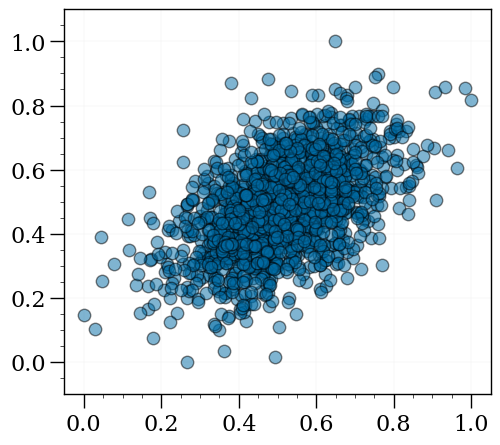

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:36<102:12:10, 36.80s/it]

Iter 0. Loss [[ 0.07527784  0.2808194  19.931568  ]]


  0%|          | 12/10000 [01:31<2:18:35,  1.20it/s]

Iter 10. Loss [[0.08104895 0.25478756 5.837816  ]]


  0%|          | 21/10000 [01:33<48:32,  3.43it/s]

Iter 20. Loss [[0.08388264 0.2453826  5.2260556 ]]


  0%|          | 31/10000 [01:37<1:01:35,  2.70it/s]

Iter 30. Loss [[0.08710086 0.23656416 4.924341  ]]


  0%|          | 41/10000 [01:42<1:37:42,  1.70it/s]

Iter 40. Loss [[0.08928105 0.23206052 4.8732038 ]]


  1%|          | 52/10000 [01:47<54:23,  3.05it/s]  

Iter 50. Loss [[0.08904687 0.23131756 4.822257  ]]


  1%|          | 61/10000 [01:50<55:37,  2.98it/s]  

Iter 60. Loss [[0.08795529 0.23168872 4.76278   ]]


  1%|          | 71/10000 [01:53<42:34,  3.89it/s]

Iter 70. Loss [[0.08791714 0.22973303 4.708049  ]]


  1%|          | 81/10000 [01:56<38:00,  4.35it/s]

Iter 80. Loss [[0.08707896 0.22858508 4.6180253 ]]


  1%|          | 91/10000 [02:00<1:18:27,  2.10it/s]

Iter 90. Loss [[0.08569785 0.22715437 4.4745727 ]]


  1%|          | 101/10000 [02:04<1:18:09,  2.11it/s]

Iter 100. Loss [[0.08370874 0.22536662 4.258532  ]]


  1%|          | 111/10000 [02:07<46:17,  3.56it/s]

Iter 110. Loss [[0.08169352 0.2235052  4.091487  ]]


  1%|          | 121/10000 [02:10<59:04,  2.79it/s]

Iter 120. Loss [[0.08109081 0.22249271 4.0437064 ]]


  1%|▏         | 131/10000 [02:16<1:37:46,  1.68it/s]

Iter 130. Loss [[0.08144443 0.22158179 4.0061526 ]]


  1%|▏         | 142/10000 [02:20<38:05,  4.31it/s]

Iter 140. Loss [[0.08138847 0.22323449 3.953601  ]]


  2%|▏         | 152/10000 [02:21<33:52,  4.85it/s]

Iter 150. Loss [[0.08184231 0.2236144  3.7437644 ]]


  2%|▏         | 162/10000 [02:23<25:39,  6.39it/s]

Iter 160. Loss [[0.08291434 0.2214802  3.6083033 ]]


  2%|▏         | 171/10000 [02:26<53:12,  3.08it/s]

Iter 170. Loss [[0.08338978 0.21742661 3.5678072 ]]


  2%|▏         | 181/10000 [02:31<1:19:08,  2.07it/s]

Iter 180. Loss [[0.08308136 0.21665469 3.4929094 ]]


  2%|▏         | 191/10000 [02:33<43:41,  3.74it/s]

Iter 190. Loss [[0.08363854 0.21228407 3.5358503 ]]


  2%|▏         | 201/10000 [02:36<41:56,  3.89it/s]

Iter 200. Loss [[0.08399092 0.20608994 3.5056963 ]]


  2%|▏         | 212/10000 [02:38<30:49,  5.29it/s]

Iter 210. Loss [[0.08384328 0.20000078 3.3759017 ]]


  2%|▏         | 222/10000 [02:40<24:52,  6.55it/s]

Iter 220. Loss [[0.08354279 0.1937983  3.2061303 ]]


  2%|▏         | 232/10000 [02:41<25:53,  6.29it/s]

Iter 230. Loss [[0.08265501 0.19237347 3.1398368 ]]


  2%|▏         | 241/10000 [02:44<39:57,  4.07it/s]

Iter 240. Loss [[0.08161224 0.19604747 3.3377035 ]]


  3%|▎         | 251/10000 [02:46<47:21,  3.43it/s]

Iter 250. Loss [[0.08229966 0.20489392 3.5202246 ]]


  3%|▎         | 261/10000 [02:50<1:01:41,  2.63it/s]

Iter 260. Loss [[0.08563554 0.20263916 3.2126143 ]]


  3%|▎         | 271/10000 [02:54<54:48,  2.96it/s]

Iter 270. Loss [[0.09013512 0.19421977 3.0667825 ]]


  3%|▎         | 281/10000 [02:56<49:26,  3.28it/s]

Iter 280. Loss [[0.09399699 0.17889155 3.0857506 ]]


  3%|▎         | 292/10000 [03:01<54:17,  2.98it/s]  

Iter 290. Loss [[0.09571543 0.16601498 3.0372722 ]]


  3%|▎         | 302/10000 [03:03<36:53,  4.38it/s]

Iter 300. Loss [[0.09488861 0.1557699  2.909994  ]]


  3%|▎         | 312/10000 [03:05<24:43,  6.53it/s]

Iter 310. Loss [[0.09270498 0.14859718 2.6658874 ]]


  3%|▎         | 322/10000 [03:06<24:12,  6.66it/s]

Iter 320. Loss [[0.09196806 0.1429144  2.5199165 ]]


  3%|▎         | 332/10000 [03:08<24:45,  6.51it/s]

Iter 330. Loss [[0.0949552  0.13189667 2.4369416 ]]


  3%|▎         | 342/10000 [03:09<26:28,  6.08it/s]

Iter 340. Loss [[0.10129929 0.1161474  2.1939516 ]]


  4%|▎         | 351/10000 [03:11<25:06,  6.41it/s]

Iter 350. Loss [[0.1113119  0.10429608 1.8786943 ]]


  4%|▎         | 361/10000 [03:13<38:45,  4.15it/s]

Iter 360. Loss [[0.12734908 0.10382515 1.4932451 ]]


  4%|▎         | 372/10000 [03:16<30:57,  5.18it/s]

Iter 370. Loss [[0.1510452  0.11351983 1.098659  ]]


  4%|▍         | 382/10000 [03:17<24:32,  6.53it/s]

Iter 380. Loss [[0.17409092 0.09924684 0.76384926]]


  4%|▍         | 392/10000 [03:19<29:54,  5.35it/s]

Iter 390. Loss [[0.18937299 0.07354573 0.6531167 ]]


  4%|▍         | 401/10000 [03:21<33:59,  4.71it/s]

Iter 400. Loss [[0.1949983  0.05748654 0.47285554]]


  4%|▍         | 412/10000 [03:23<25:00,  6.39it/s]

Iter 410. Loss [[0.21199809 0.05852272 0.38655874]]


  4%|▍         | 422/10000 [03:24<24:14,  6.58it/s]

Iter 420. Loss [[0.24173643 0.08059985 0.1620684 ]]


  4%|▍         | 431/10000 [03:25<27:11,  5.87it/s]

Iter 430. Loss [[ 0.25785366  0.06387317 -0.02364042]]


  4%|▍         | 441/10000 [03:28<39:10,  4.07it/s]

Iter 440. Loss [[0.253934   0.05580852 0.15025614]]


  5%|▍         | 452/10000 [03:30<29:34,  5.38it/s]

Iter 450. Loss [[0.25230923 0.04780061 0.25035334]]


  5%|▍         | 462/10000 [03:32<23:57,  6.63it/s]

Iter 460. Loss [[0.26395383 0.05863981 0.2753855 ]]


  5%|▍         | 472/10000 [03:33<23:11,  6.85it/s]

Iter 470. Loss [[0.26794574 0.06421497 0.07013806]]


  5%|▍         | 482/10000 [03:35<24:06,  6.58it/s]

Iter 480. Loss [[ 0.2764734   0.06929553 -0.11819509]]


  5%|▍         | 492/10000 [03:36<23:44,  6.68it/s]

Iter 490. Loss [[0.2670781  0.04776246 0.01460527]]


  5%|▌         | 502/10000 [03:38<24:18,  6.51it/s]

Iter 500. Loss [[ 0.27633908  0.04683132 -0.0076931 ]]


  5%|▌         | 512/10000 [03:39<25:33,  6.19it/s]

Iter 510. Loss [[ 0.29709405  0.09239499 -0.17959583]]


  5%|▌         | 521/10000 [03:41<38:42,  4.08it/s]

Iter 520. Loss [[0.26297435 0.0408032  0.29083222]]


  5%|▌         | 531/10000 [03:44<38:28,  4.10it/s]

Iter 530. Loss [[0.25827157 0.030616   0.2922373 ]]


  5%|▌         | 542/10000 [03:46<25:36,  6.15it/s]

Iter 540. Loss [[0.2684421  0.03232098 0.01924884]]


  6%|▌         | 552/10000 [03:47<24:32,  6.41it/s]

Iter 550. Loss [[ 0.2964445   0.05197362 -0.30357626]]


  6%|▌         | 562/10000 [03:49<27:55,  5.63it/s]

Iter 560. Loss [[ 0.3169586   0.06734286 -0.57444257]]


  6%|▌         | 572/10000 [03:51<23:43,  6.63it/s]

Iter 570. Loss [[ 0.33104113  0.08247693 -0.65021676]]


  6%|▌         | 582/10000 [03:52<23:19,  6.73it/s]

Iter 580. Loss [[ 0.32409412  0.07266414 -0.55935687]]


  6%|▌         | 592/10000 [03:54<23:17,  6.73it/s]

Iter 590. Loss [[ 0.312539    0.06064562 -0.41030666]]


  6%|▌         | 601/10000 [03:56<38:49,  4.03it/s]

Iter 600. Loss [[ 0.31324497  0.0651851  -0.4076548 ]]


  6%|▌         | 611/10000 [03:58<38:26,  4.07it/s]

Iter 610. Loss [[ 0.31634468  0.06952754 -0.458395  ]]


  6%|▌         | 622/10000 [04:00<25:39,  6.09it/s]

Iter 620. Loss [[ 0.31286696  0.05801771 -0.44736287]]


  6%|▋         | 632/10000 [04:02<25:22,  6.15it/s]

Iter 630. Loss [[ 0.32491437  0.06848204 -0.57306916]]


  6%|▋         | 642/10000 [04:04<29:43,  5.25it/s]

Iter 640. Loss [[ 0.32985815  0.08140021 -0.6172692 ]]


  7%|▋         | 652/10000 [04:05<24:53,  6.26it/s]

Iter 650. Loss [[ 0.32411104  0.08640978 -0.5624254 ]]


  7%|▋         | 662/10000 [04:07<24:40,  6.31it/s]

Iter 660. Loss [[ 0.31466615  0.07628927 -0.47526887]]


  7%|▋         | 672/10000 [04:09<24:14,  6.41it/s]

Iter 670. Loss [[ 0.31327108  0.07408307 -0.5000094 ]]


  7%|▋         | 681/10000 [04:11<38:53,  3.99it/s]

Iter 680. Loss [[ 0.31328103  0.0740609  -0.51486707]]


  7%|▋         | 692/10000 [04:13<36:20,  4.27it/s]

Iter 690. Loss [[ 0.3154068   0.07920119 -0.4802109 ]]


  7%|▋         | 702/10000 [04:15<24:39,  6.28it/s]

Iter 700. Loss [[ 0.30633324  0.06924204 -0.3484634 ]]


  7%|▋         | 712/10000 [04:17<25:41,  6.02it/s]

Iter 710. Loss [[ 0.30211842  0.06416763 -0.27169177]]


  7%|▋         | 722/10000 [04:18<23:55,  6.47it/s]

Iter 720. Loss [[ 0.30033353  0.06640349 -0.24534617]]


  7%|▋         | 732/10000 [04:20<24:11,  6.39it/s]

Iter 730. Loss [[ 0.29886335  0.06731505 -0.24486583]]


  7%|▋         | 742/10000 [04:21<23:49,  6.48it/s]

Iter 740. Loss [[ 0.29845214  0.06782191 -0.29871318]]


  8%|▊         | 752/10000 [04:23<29:58,  5.14it/s]

Iter 750. Loss [[ 0.3002546   0.0714971  -0.36979353]]


  8%|▊         | 761/10000 [04:26<37:20,  4.12it/s]

Iter 760. Loss [[ 0.3008909   0.07771507 -0.36622262]]


  8%|▊         | 772/10000 [04:28<30:45,  5.00it/s]

Iter 770. Loss [[ 0.28958437  0.07281613 -0.19100697]]


  8%|▊         | 782/10000 [04:30<23:47,  6.46it/s]

Iter 780. Loss [[0.2634845  0.04101728 0.06375065]]


  8%|▊         | 792/10000 [04:31<24:17,  6.32it/s]

Iter 790. Loss [[0.2656214  0.04283347 0.01380944]]


  8%|▊         | 802/10000 [04:33<23:25,  6.54it/s]

Iter 800. Loss [[ 0.2766949   0.05517919 -0.10511898]]


  8%|▊         | 812/10000 [04:34<22:47,  6.72it/s]

Iter 810. Loss [[ 0.27779356  0.05010556 -0.13099925]]


  8%|▊         | 822/10000 [04:36<23:06,  6.62it/s]

Iter 820. Loss [[ 0.28181294  0.0519967  -0.17414807]]


  8%|▊         | 832/10000 [04:38<28:43,  5.32it/s]

Iter 830. Loss [[ 0.28708488  0.05635978 -0.20888358]]


  8%|▊         | 841/10000 [04:40<38:12,  4.00it/s]

Iter 840. Loss [[ 0.2921309   0.06632838 -0.30402985]]


  9%|▊         | 852/10000 [04:43<28:51,  5.28it/s]

Iter 850. Loss [[ 0.28519475  0.05511004 -0.23814721]]


  9%|▊         | 862/10000 [04:44<23:05,  6.59it/s]

Iter 860. Loss [[ 0.28578132  0.04672619 -0.07376619]]


  9%|▊         | 872/10000 [04:46<26:10,  5.81it/s]

Iter 870. Loss [[ 0.2919582   0.05578076 -0.04830177]]


  9%|▉         | 881/10000 [04:48<35:50,  4.24it/s]

Iter 880. Loss [[ 0.2983371   0.06776745 -0.30989093]]


  9%|▉         | 891/10000 [04:51<37:17,  4.07it/s]

Iter 890. Loss [[ 0.29235214  0.07080244 -0.39992994]]


  9%|▉         | 901/10000 [04:53<29:28,  5.15it/s]

Iter 900. Loss [[ 0.29251862  0.05110485 -0.23367628]]


  9%|▉         | 911/10000 [04:55<38:11,  3.97it/s]

Iter 910. Loss [[ 0.2925584   0.04843888 -0.06613616]]


  9%|▉         | 922/10000 [04:58<26:18,  5.75it/s]

Iter 920. Loss [[0.28739834 0.04448124 0.05170577]]


  9%|▉         | 932/10000 [04:59<23:01,  6.56it/s]

Iter 930. Loss [[0.28321427 0.04137958 0.02874322]]


  9%|▉         | 942/10000 [05:01<25:09,  6.00it/s]

Iter 940. Loss [[ 0.2878545   0.04272532 -0.04268509]]


 10%|▉         | 952/10000 [05:02<24:00,  6.28it/s]

Iter 950. Loss [[ 0.29716396  0.04232461 -0.15144828]]


 10%|▉         | 962/10000 [05:04<28:06,  5.36it/s]

Iter 960. Loss [[ 0.30587065  0.05031536 -0.24169005]]


 10%|▉         | 972/10000 [05:06<23:25,  6.42it/s]

Iter 970. Loss [[ 0.30610195  0.05601899 -0.22158436]]


 10%|▉         | 981/10000 [05:07<30:53,  4.87it/s]

Iter 980. Loss [[ 0.30160043  0.06084964 -0.21249713]]


 10%|▉         | 991/10000 [05:10<36:39,  4.10it/s]

Iter 990. Loss [[ 0.3033652   0.06234949 -0.31725743]]


 10%|█         | 1002/10000 [05:12<25:50,  5.80it/s]

Iter 1000. Loss [[ 0.30977187  0.07449144 -0.47139233]]


 10%|█         | 1011/10000 [05:13<22:25,  6.68it/s]

Iter 1010. Loss [[ 0.31322995  0.08985676 -0.6171559 ]]


 10%|█         | 1022/10000 [05:15<23:21,  6.41it/s]

Iter 1020. Loss [[ 0.30997825  0.08530194 -0.6460352 ]]


 10%|█         | 1032/10000 [05:17<22:59,  6.50it/s]

Iter 1030. Loss [[ 0.3052044   0.06570809 -0.42140698]]


 10%|█         | 1042/10000 [05:18<22:43,  6.57it/s]

Iter 1040. Loss [[ 0.30358845  0.0575304  -0.30034065]]


 11%|█         | 1052/10000 [05:20<24:58,  5.97it/s]

Iter 1050. Loss [[ 0.3028638   0.05576878 -0.27285558]]


 11%|█         | 1061/10000 [05:22<29:41,  5.02it/s]

Iter 1060. Loss [[ 0.30719867  0.06190132 -0.32109138]]


 11%|█         | 1071/10000 [05:24<37:05,  4.01it/s]

Iter 1070. Loss [[ 0.31029522  0.06944732 -0.43362516]]


 11%|█         | 1082/10000 [05:26<25:24,  5.85it/s]

Iter 1080. Loss [[ 0.3105687   0.08087343 -0.50145817]]


 11%|█         | 1091/10000 [05:28<23:24,  6.34it/s]

Iter 1090. Loss [[ 0.3085181   0.07864943 -0.5032686 ]]


 11%|█         | 1102/10000 [05:30<22:53,  6.48it/s]

Iter 1100. Loss [[ 0.3076275   0.07947697 -0.4896072 ]]


 11%|█         | 1112/10000 [05:31<22:22,  6.62it/s]

Iter 1110. Loss [[ 0.30497247  0.07843346 -0.46702957]]


 11%|█         | 1122/10000 [05:33<22:39,  6.53it/s]

Iter 1120. Loss [[ 0.3027306   0.07259356 -0.457003  ]]


 11%|█▏        | 1132/10000 [05:34<20:19,  7.27it/s]

Iter 1130. Loss [[ 0.30736324  0.07820611 -0.5121607 ]]


 11%|█▏        | 1142/10000 [05:35<20:03,  7.36it/s]

Iter 1140. Loss [[ 0.30920035  0.08521698 -0.5195196 ]]


 12%|█▏        | 1151/10000 [05:37<32:38,  4.52it/s]

Iter 1150. Loss [[ 0.30465168  0.06401178 -0.4646648 ]]


 12%|█▏        | 1162/10000 [05:40<36:10,  4.07it/s]

Iter 1160. Loss [[ 0.31320667  0.07141532 -0.53656185]]


 12%|█▏        | 1172/10000 [05:42<21:44,  6.77it/s]

Iter 1170. Loss [[ 0.31761762  0.07043234 -0.5662141 ]]


 12%|█▏        | 1182/10000 [05:43<21:11,  6.94it/s]

Iter 1180. Loss [[ 0.3208927   0.07809313 -0.60718584]]


 12%|█▏        | 1192/10000 [05:45<22:29,  6.53it/s]

Iter 1190. Loss [[ 0.318437    0.08261476 -0.60037994]]


 12%|█▏        | 1202/10000 [05:46<22:25,  6.54it/s]

Iter 1200. Loss [[ 0.30341646  0.08718683 -0.49187696]]


 12%|█▏        | 1212/10000 [05:48<20:07,  7.28it/s]

Iter 1210. Loss [[ 0.29008305  0.06640919 -0.39990723]]


 12%|█▏        | 1222/10000 [05:49<22:20,  6.55it/s]

Iter 1220. Loss [[ 0.29795194  0.07377189 -0.4527249 ]]


 12%|█▏        | 1231/10000 [05:51<28:23,  5.15it/s]

Iter 1230. Loss [[ 0.30242595  0.08122053 -0.4988868 ]]


 12%|█▏        | 1241/10000 [05:53<33:27,  4.36it/s]

Iter 1240. Loss [[ 0.29897803  0.07870287 -0.49508423]]


 13%|█▎        | 1252/10000 [05:55<25:55,  5.63it/s]

Iter 1250. Loss [[ 0.296683    0.07876576 -0.492389  ]]


 13%|█▎        | 1262/10000 [05:57<21:07,  6.89it/s]

Iter 1260. Loss [[ 0.29674995  0.0795169  -0.48942408]]


 13%|█▎        | 1272/10000 [05:58<19:55,  7.30it/s]

Iter 1270. Loss [[ 0.29578793  0.07336245 -0.4958243 ]]


 13%|█▎        | 1282/10000 [05:59<20:49,  6.98it/s]

Iter 1280. Loss [[ 0.29777503  0.08969531 -0.567597  ]]


 13%|█▎        | 1292/10000 [06:01<20:29,  7.08it/s]

Iter 1290. Loss [[ 0.2947987   0.08492704 -0.5527422 ]]


 13%|█▎        | 1302/10000 [06:02<19:44,  7.35it/s]

Iter 1300. Loss [[ 0.29357398  0.08270247 -0.5497791 ]]


 13%|█▎        | 1312/10000 [06:04<25:47,  5.62it/s]

Iter 1310. Loss [[ 0.29335785  0.08305033 -0.55769867]]


 13%|█▎        | 1321/10000 [06:06<33:18,  4.34it/s]

Iter 1320. Loss [[ 0.29196292  0.08318214 -0.5643896 ]]


 13%|█▎        | 1331/10000 [06:08<36:52,  3.92it/s]

Iter 1330. Loss [[ 0.29008707  0.0833889  -0.5732919 ]]


 13%|█▎        | 1342/10000 [06:10<21:24,  6.74it/s]

Iter 1340. Loss [[ 0.28841016  0.0837606  -0.57832724]]


 14%|█▎        | 1352/10000 [06:12<21:37,  6.66it/s]

Iter 1350. Loss [[ 0.28657177  0.08336864 -0.5829877 ]]


 14%|█▎        | 1362/10000 [06:13<28:42,  5.02it/s]

Iter 1360. Loss [[ 0.28417054  0.08390684 -0.58517283]]


 14%|█▎        | 1372/10000 [06:15<21:27,  6.70it/s]

Iter 1370. Loss [[ 0.28108227  0.08328185 -0.5814217 ]]


 14%|█▍        | 1382/10000 [06:16<21:35,  6.65it/s]

Iter 1380. Loss [[ 0.2789122   0.08254592 -0.583725  ]]


 14%|█▍        | 1392/10000 [06:18<21:38,  6.63it/s]

Iter 1390. Loss [[ 0.2769293   0.08215309 -0.58871746]]


 14%|█▍        | 1401/10000 [06:20<34:04,  4.21it/s]

Iter 1400. Loss [[ 0.27328345  0.08032546 -0.6191863 ]]


 14%|█▍        | 1411/10000 [06:22<34:31,  4.15it/s]

Iter 1410. Loss [[ 0.27040446  0.07896934 -0.59477204]]


 14%|█▍        | 1422/10000 [06:24<22:09,  6.45it/s]

Iter 1420. Loss [[ 0.26975763  0.07977999 -0.6002214 ]]


 14%|█▍        | 1432/10000 [06:26<21:27,  6.66it/s]

Iter 1430. Loss [[ 0.26946318  0.08077146 -0.61392635]]


 14%|█▍        | 1442/10000 [06:27<21:56,  6.50it/s]

Iter 1440. Loss [[ 0.2685207   0.08079063 -0.60650843]]


 15%|█▍        | 1452/10000 [06:29<24:27,  5.83it/s]

Iter 1450. Loss [[ 0.26748815  0.08007352 -0.5990697 ]]


 15%|█▍        | 1462/10000 [06:31<21:56,  6.49it/s]

Iter 1460. Loss [[ 0.26657757  0.07894516 -0.5995908 ]]


 15%|█▍        | 1472/10000 [06:33<26:57,  5.27it/s]

Iter 1470. Loss [[ 0.2677873   0.07824904 -0.5678137 ]]


 15%|█▍        | 1481/10000 [06:35<32:23,  4.38it/s]

Iter 1480. Loss [[ 0.26728827  0.0786626  -0.56207985]]


 15%|█▍        | 1491/10000 [06:37<34:34,  4.10it/s]

Iter 1490. Loss [[ 0.2656383   0.07911026 -0.55931264]]


 15%|█▌        | 1502/10000 [06:39<22:36,  6.27it/s]

Iter 1500. Loss [[ 0.26473454  0.07796393 -0.5638982 ]]


 15%|█▌        | 1512/10000 [06:41<21:14,  6.66it/s]

Iter 1510. Loss [[ 0.2654598  0.077989  -0.5719556]]


 15%|█▌        | 1522/10000 [06:42<21:54,  6.45it/s]

Iter 1520. Loss [[ 0.2659635  0.0753824 -0.5997242]]


 15%|█▌        | 1532/10000 [06:44<20:16,  6.96it/s]

Iter 1530. Loss [[0.25075963 0.03270362 0.07092103]]


 15%|█▌        | 1541/10000 [06:45<31:07,  4.53it/s]

Iter 1540. Loss [[ 0.25582308  0.0223788  -0.15271536]]


 16%|█▌        | 1551/10000 [06:48<35:08,  4.01it/s]

Iter 1550. Loss [[ 0.2896989   0.14685372 -0.98094237]]


 16%|█▌        | 1561/10000 [06:51<40:36,  3.46it/s]

Iter 1560. Loss [[ 0.26029027  0.03120999 -0.3650309 ]]


 16%|█▌        | 1571/10000 [06:53<35:43,  3.93it/s]

Iter 1570. Loss [[ 0.26719525  0.03944848 -0.41179198]]


 16%|█▌        | 1582/10000 [06:55<21:52,  6.41it/s]

Iter 1580. Loss [[ 0.29035544  0.10161725 -0.42370483]]


 16%|█▌        | 1592/10000 [06:57<22:39,  6.18it/s]

Iter 1590. Loss [[ 0.2583865  0.0447929 -0.2762941]]


 16%|█▌        | 1602/10000 [06:58<21:07,  6.63it/s]

Iter 1600. Loss [[ 0.25344002  0.03884567 -0.22550365]]


 16%|█▌        | 1612/10000 [07:00<20:53,  6.69it/s]

Iter 1610. Loss [[ 0.25721207  0.04546374 -0.3181245 ]]


 16%|█▌        | 1622/10000 [07:02<25:34,  5.46it/s]

Iter 1620. Loss [[ 0.26898667  0.06388526 -0.5587666 ]]


 16%|█▋        | 1632/10000 [07:03<21:54,  6.37it/s]

Iter 1630. Loss [[ 0.27345073  0.06592125 -0.682885  ]]


 16%|█▋        | 1641/10000 [07:05<32:40,  4.26it/s]

Iter 1640. Loss [[ 0.27888122  0.07292584 -0.7539245 ]]


 17%|█▋        | 1651/10000 [07:07<32:57,  4.22it/s]

Iter 1650. Loss [[ 0.28243786  0.07571864 -0.75847965]]


 17%|█▋        | 1662/10000 [07:10<22:14,  6.25it/s]

Iter 1660. Loss [[ 0.28271696  0.06913256 -0.7197429 ]]


 17%|█▋        | 1672/10000 [07:11<18:43,  7.41it/s]

Iter 1670. Loss [[ 0.28266644  0.07672718 -0.76499367]]


 17%|█▋        | 1682/10000 [07:12<20:56,  6.62it/s]

Iter 1680. Loss [[ 0.27843466  0.06286516 -0.6061703 ]]


 17%|█▋        | 1692/10000 [07:14<19:38,  7.05it/s]

Iter 1690. Loss [[ 0.2789201   0.07743052 -0.7361139 ]]


 17%|█▋        | 1702/10000 [07:15<19:58,  6.92it/s]

Iter 1700. Loss [[ 0.2742417   0.06296927 -0.55728376]]


 17%|█▋        | 1712/10000 [07:17<19:53,  6.94it/s]

Iter 1710. Loss [[ 0.27201006  0.06914684 -0.65969366]]


 17%|█▋        | 1722/10000 [07:18<20:16,  6.80it/s]

Iter 1720. Loss [[ 0.27155975  0.06510684 -0.5414387 ]]


 17%|█▋        | 1731/10000 [07:20<33:04,  4.17it/s]

Iter 1730. Loss [[ 0.26662046  0.06030738 -0.54564935]]


 17%|█▋        | 1742/10000 [07:23<29:36,  4.65it/s]

Iter 1740. Loss [[ 0.26713943  0.0658382  -0.48265335]]


 18%|█▊        | 1752/10000 [07:25<21:04,  6.52it/s]

Iter 1750. Loss [[ 0.2577715   0.05819266 -0.40645427]]


 18%|█▊        | 1762/10000 [07:26<19:36,  7.00it/s]

Iter 1760. Loss [[ 0.25890753  0.06614219 -0.48086873]]


 18%|█▊        | 1772/10000 [07:28<21:37,  6.34it/s]

Iter 1770. Loss [[ 0.25663018  0.05777818 -0.37500912]]


 18%|█▊        | 1782/10000 [07:29<20:42,  6.62it/s]

Iter 1780. Loss [[ 0.25148952  0.06119651 -0.42207703]]


 18%|█▊        | 1792/10000 [07:31<20:43,  6.60it/s]

Iter 1790. Loss [[ 0.2550902   0.05761071 -0.3627753 ]]


 18%|█▊        | 1802/10000 [07:32<20:25,  6.69it/s]

Iter 1800. Loss [[ 0.24701709  0.05671674 -0.35432577]]


 18%|█▊        | 1811/10000 [07:34<28:17,  4.82it/s]

Iter 1810. Loss [[ 0.25043947  0.06103503 -0.41965744]]


 18%|█▊        | 1821/10000 [07:36<30:32,  4.46it/s]

Iter 1820. Loss [[ 0.25109297  0.05355057 -0.29759493]]


 18%|█▊        | 1832/10000 [07:38<21:12,  6.42it/s]

Iter 1830. Loss [[ 0.2450083   0.05420166 -0.29656813]]


 18%|█▊        | 1842/10000 [07:39<18:19,  7.42it/s]

Iter 1840. Loss [[ 0.24977015  0.0585206  -0.35814396]]


 19%|█▊        | 1852/10000 [07:41<19:17,  7.04it/s]

Iter 1850. Loss [[ 0.25024825  0.05507809 -0.32121214]]


 19%|█▊        | 1862/10000 [07:42<20:42,  6.55it/s]

Iter 1860. Loss [[ 0.24788423  0.05705608 -0.3492398 ]]


 19%|█▊        | 1872/10000 [07:44<21:27,  6.31it/s]

Iter 1870. Loss [[ 0.24972914  0.05482639 -0.31876323]]


 19%|█▉        | 1882/10000 [07:45<20:34,  6.57it/s]

Iter 1880. Loss [[ 0.24245006  0.05229236 -0.28411743]]


 19%|█▉        | 1892/10000 [07:47<19:30,  6.93it/s]

Iter 1890. Loss [[ 0.24663176  0.05545378 -0.3253801 ]]


 19%|█▉        | 1901/10000 [07:49<29:24,  4.59it/s]

Iter 1900. Loss [[ 0.24800918  0.0512289  -0.29673824]]


 19%|█▉        | 1911/10000 [07:51<33:45,  3.99it/s]

Iter 1910. Loss [[ 0.24461937  0.05147178 -0.28127584]]


 19%|█▉        | 1922/10000 [07:53<21:27,  6.28it/s]

Iter 1920. Loss [[ 0.24934083  0.05295694 -0.31204435]]


 19%|█▉        | 1932/10000 [07:54<20:38,  6.51it/s]

Iter 1930. Loss [[ 0.24738206  0.05288922 -0.3004436 ]]


 19%|█▉        | 1942/10000 [07:56<21:45,  6.17it/s]

Iter 1940. Loss [[ 0.24733523  0.04815468 -0.26431513]]


 20%|█▉        | 1952/10000 [07:58<20:26,  6.56it/s]

Iter 1950. Loss [[ 0.24941464  0.05164169 -0.29523262]]


 20%|█▉        | 1962/10000 [07:59<20:39,  6.48it/s]

Iter 1960. Loss [[ 0.24832912  0.04973108 -0.26897684]]


 20%|█▉        | 1971/10000 [08:01<21:15,  6.30it/s]

Iter 1970. Loss [[ 0.24814683  0.04910396 -0.261611  ]]


 20%|█▉        | 1981/10000 [08:03<32:57,  4.06it/s]

Iter 1980. Loss [[ 0.24816923  0.04929968 -0.26360756]]


 20%|█▉        | 1991/10000 [08:05<33:12,  4.02it/s]

Iter 1990. Loss [[ 0.24971162  0.04794237 -0.263181  ]]


 20%|██        | 2002/10000 [08:07<20:06,  6.63it/s]

Iter 2000. Loss [[ 0.24940746  0.04890218 -0.27109018]]


 20%|██        | 2012/10000 [08:09<21:32,  6.18it/s]

Iter 2010. Loss [[ 0.25019062  0.05040873 -0.2747248 ]]


 20%|██        | 2022/10000 [08:11<22:55,  5.80it/s]

Iter 2020. Loss [[ 0.24875484  0.05001643 -0.27786756]]


 20%|██        | 2032/10000 [08:12<20:00,  6.64it/s]

Iter 2030. Loss [[ 0.24902028  0.0496348  -0.29711357]]


 20%|██        | 2042/10000 [08:14<20:03,  6.61it/s]

Iter 2040. Loss [[ 0.24826972  0.05100103 -0.3141371 ]]


 21%|██        | 2052/10000 [08:15<20:30,  6.46it/s]

Iter 2050. Loss [[ 0.2479025   0.05522099 -0.3428287 ]]


 21%|██        | 2061/10000 [08:17<23:32,  5.62it/s]

Iter 2060. Loss [[ 0.25068933  0.05473216 -0.31781265]]


 21%|██        | 2071/10000 [08:19<33:11,  3.98it/s]

Iter 2070. Loss [[ 0.24516661  0.05556356 -0.29550093]]


 21%|██        | 2082/10000 [08:21<21:53,  6.03it/s]

Iter 2080. Loss [[ 0.24478829  0.06415302 -0.36184838]]


 21%|██        | 2092/10000 [08:23<21:11,  6.22it/s]

Iter 2090. Loss [[ 0.24605489  0.06968175 -0.45047888]]


 21%|██        | 2102/10000 [08:25<19:56,  6.60it/s]

Iter 2100. Loss [[ 0.25453347  0.06347814 -0.4459064 ]]


 21%|██        | 2112/10000 [08:26<19:20,  6.80it/s]

Iter 2110. Loss [[ 0.25201595  0.06563983 -0.41367885]]


 21%|██        | 2122/10000 [08:28<19:20,  6.79it/s]

Iter 2120. Loss [[ 0.24822709  0.06403021 -0.37077546]]


 21%|██▏       | 2132/10000 [08:29<19:34,  6.70it/s]

Iter 2130. Loss [[ 0.25186223  0.06367169 -0.37813875]]


 21%|██▏       | 2142/10000 [08:31<19:29,  6.72it/s]

Iter 2140. Loss [[ 0.25243878  0.06394146 -0.38556546]]


 22%|██▏       | 2151/10000 [08:32<29:59,  4.36it/s]

Iter 2150. Loss [[ 0.25399134  0.06301766 -0.39701578]]


 22%|██▏       | 2161/10000 [08:35<32:03,  4.07it/s]

Iter 2160. Loss [[ 0.25630787  0.06191795 -0.37602702]]


 22%|██▏       | 2172/10000 [08:37<20:10,  6.47it/s]

Iter 2170. Loss [[ 0.25768217  0.0623031  -0.36831355]]


 22%|██▏       | 2182/10000 [08:38<19:34,  6.66it/s]

Iter 2180. Loss [[ 0.2576972   0.06232758 -0.36390015]]


 22%|██▏       | 2192/10000 [08:40<19:20,  6.73it/s]

Iter 2190. Loss [[ 0.25883052  0.06208567 -0.35715714]]


 22%|██▏       | 2202/10000 [08:41<19:47,  6.57it/s]

Iter 2200. Loss [[ 0.25955096  0.06191566 -0.34914201]]


 22%|██▏       | 2212/10000 [08:43<20:06,  6.45it/s]

Iter 2210. Loss [[ 0.25960955  0.06042897 -0.3317134 ]]


 22%|██▏       | 2221/10000 [08:45<31:14,  4.15it/s]

Iter 2220. Loss [[ 0.25920975  0.05926733 -0.32389423]]


 22%|██▏       | 2231/10000 [08:47<32:02,  4.04it/s]

Iter 2230. Loss [[ 0.25876924  0.05901732 -0.32017025]]


 22%|██▏       | 2241/10000 [08:50<33:32,  3.86it/s]

Iter 2240. Loss [[ 0.25713354  0.05911266 -0.32830876]]


 23%|██▎       | 2252/10000 [08:52<22:49,  5.66it/s]

Iter 2250. Loss [[ 0.25724667  0.06038583 -0.34600568]]


 23%|██▎       | 2262/10000 [08:54<19:53,  6.48it/s]

Iter 2260. Loss [[ 0.2574673   0.06180876 -0.36244076]]


 23%|██▎       | 2272/10000 [08:55<19:28,  6.61it/s]

Iter 2270. Loss [[ 0.2570457   0.06297167 -0.37228146]]


 23%|██▎       | 2282/10000 [08:57<19:38,  6.55it/s]

Iter 2280. Loss [[ 0.25689244  0.06306062 -0.37478662]]


 23%|██▎       | 2292/10000 [08:58<19:07,  6.72it/s]

Iter 2290. Loss [[ 0.2562305   0.06374376 -0.3796161 ]]


 23%|██▎       | 2302/10000 [09:00<20:00,  6.41it/s]

Iter 2300. Loss [[ 0.2564454   0.06397594 -0.38524455]]


 23%|██▎       | 2312/10000 [09:02<19:27,  6.59it/s]

Iter 2310. Loss [[ 0.25642434  0.06414405 -0.38887882]]


 23%|██▎       | 2321/10000 [09:04<31:28,  4.07it/s]

Iter 2320. Loss [[ 0.25769758  0.0632069  -0.37790373]]


 23%|██▎       | 2332/10000 [09:07<25:32,  5.00it/s]

Iter 2330. Loss [[ 0.25858745  0.06279871 -0.36505777]]


 23%|██▎       | 2342/10000 [09:08<20:03,  6.36it/s]

Iter 2340. Loss [[ 0.25992048  0.06040734 -0.3125264 ]]


 24%|██▎       | 2352/10000 [09:10<19:06,  6.67it/s]

Iter 2350. Loss [[ 0.25860605  0.05405792 -0.2703595 ]]


 24%|██▎       | 2362/10000 [09:11<19:35,  6.50it/s]

Iter 2360. Loss [[ 0.25836155  0.0531811  -0.25201857]]


 24%|██▎       | 2372/10000 [09:13<20:01,  6.35it/s]

Iter 2370. Loss [[ 0.2573993   0.05501442 -0.26506007]]


 24%|██▍       | 2382/10000 [09:14<19:20,  6.56it/s]

Iter 2380. Loss [[ 0.25671014  0.05765351 -0.2960376 ]]


 24%|██▍       | 2392/10000 [09:16<19:27,  6.52it/s]

Iter 2390. Loss [[ 0.25636244  0.05853358 -0.31122386]]


 24%|██▍       | 2401/10000 [09:18<30:56,  4.09it/s]

Iter 2400. Loss [[ 0.2560426   0.06001341 -0.3286764 ]]


 24%|██▍       | 2412/10000 [09:21<29:12,  4.33it/s]

Iter 2410. Loss [[ 0.25560746  0.06088281 -0.33661124]]


 24%|██▍       | 2422/10000 [09:22<19:38,  6.43it/s]

Iter 2420. Loss [[ 0.2544923   0.06231692 -0.34731647]]


 24%|██▍       | 2432/10000 [09:24<19:22,  6.51it/s]

Iter 2430. Loss [[ 0.25392258  0.06380904 -0.35920906]]


 24%|██▍       | 2442/10000 [09:26<20:28,  6.15it/s]

Iter 2440. Loss [[ 0.25401652  0.06306307 -0.36045718]]


 25%|██▍       | 2452/10000 [09:27<18:58,  6.63it/s]

Iter 2450. Loss [[ 0.25319687  0.06363177 -0.370306  ]]


 25%|██▍       | 2462/10000 [09:29<19:23,  6.48it/s]

Iter 2460. Loss [[ 0.2533302   0.06375756 -0.3755219 ]]


 25%|██▍       | 2472/10000 [09:30<18:43,  6.70it/s]

Iter 2470. Loss [[ 0.2536123   0.06354648 -0.37914973]]


 25%|██▍       | 2481/10000 [09:32<29:31,  4.24it/s]

Iter 2480. Loss [[ 0.25415146  0.06327832 -0.37883195]]


 25%|██▍       | 2491/10000 [09:35<32:41,  3.83it/s]

Iter 2490. Loss [[ 0.2541846   0.06111697 -0.35809594]]


 25%|██▌       | 2502/10000 [09:37<19:26,  6.43it/s]

Iter 2500. Loss [[ 0.25364795  0.06055101 -0.3479632 ]]


 25%|██▌       | 2512/10000 [09:38<19:36,  6.36it/s]

Iter 2510. Loss [[ 0.25444356  0.06076844 -0.3440616 ]]


 25%|██▌       | 2522/10000 [09:40<20:38,  6.04it/s]

Iter 2520. Loss [[ 0.25509918  0.06035472 -0.33593103]]


 25%|██▌       | 2532/10000 [09:41<19:00,  6.55it/s]

Iter 2530. Loss [[ 0.25542378  0.05981679 -0.32764456]]


 25%|██▌       | 2542/10000 [09:43<18:23,  6.76it/s]

Iter 2540. Loss [[ 0.25477695  0.06031767 -0.32465667]]


 26%|██▌       | 2552/10000 [09:44<18:35,  6.68it/s]

Iter 2550. Loss [[ 0.25549236  0.05973634 -0.32071364]]


 26%|██▌       | 2561/10000 [09:47<36:11,  3.43it/s]

Iter 2560. Loss [[ 0.25544822  0.05966931 -0.3189932 ]]


 26%|██▌       | 2571/10000 [09:49<30:55,  4.00it/s]

Iter 2570. Loss [[ 0.25600886  0.05871414 -0.3140602 ]]


 26%|██▌       | 2582/10000 [09:51<19:05,  6.48it/s]

Iter 2580. Loss [[ 0.25576216  0.05935156 -0.31354696]]


 26%|██▌       | 2592/10000 [09:52<18:36,  6.63it/s]

Iter 2590. Loss [[ 0.25543085  0.05971435 -0.31543002]]


 26%|██▌       | 2602/10000 [09:54<18:55,  6.52it/s]

Iter 2600. Loss [[ 0.25597095  0.05880421 -0.31013748]]


 26%|██▌       | 2612/10000 [09:55<18:29,  6.66it/s]

Iter 2610. Loss [[ 0.25677726  0.05717296 -0.2995034 ]]


 26%|██▌       | 2622/10000 [09:57<19:00,  6.47it/s]

Iter 2620. Loss [[ 0.25533995  0.06043294 -0.31603238]]


 26%|██▋       | 2632/10000 [09:59<19:31,  6.29it/s]

Iter 2630. Loss [[ 0.2556983   0.05918312 -0.30730915]]


 26%|██▋       | 2641/10000 [10:01<27:54,  4.40it/s]

Iter 2640. Loss [[ 0.25521174  0.05965661 -0.31020147]]


 27%|██▋       | 2651/10000 [10:03<31:01,  3.95it/s]

Iter 2650. Loss [[ 0.25669467  0.05863554 -0.30650997]]


 27%|██▋       | 2662/10000 [10:05<20:05,  6.09it/s]

Iter 2660. Loss [[ 0.25612348  0.05901649 -0.30894893]]


 27%|██▋       | 2672/10000 [10:07<23:06,  5.29it/s]

Iter 2670. Loss [[ 0.2560281  0.0589709 -0.3061959]]


 27%|██▋       | 2682/10000 [10:09<19:23,  6.29it/s]

Iter 2680. Loss [[ 0.2551232   0.06015937 -0.30675906]]


 27%|██▋       | 2692/10000 [10:10<19:13,  6.33it/s]

Iter 2690. Loss [[ 0.25526622  0.05954432 -0.30508447]]


 27%|██▋       | 2702/10000 [10:12<25:06,  4.85it/s]

Iter 2700. Loss [[ 0.25561866  0.05908173 -0.30343527]]


 27%|██▋       | 2712/10000 [10:13<19:17,  6.30it/s]

Iter 2710. Loss [[ 0.2557346   0.05881893 -0.30269125]]


 27%|██▋       | 2721/10000 [10:15<28:00,  4.33it/s]

Iter 2720. Loss [[ 0.25564945  0.05886596 -0.30188608]]


 27%|██▋       | 2731/10000 [10:18<29:48,  4.06it/s]

Iter 2730. Loss [[ 0.2556185   0.05920704 -0.30284408]]


 27%|██▋       | 2742/10000 [10:20<19:44,  6.13it/s]

Iter 2740. Loss [[ 0.25593507  0.05871312 -0.29920673]]


 28%|██▊       | 2752/10000 [10:22<19:16,  6.27it/s]

Iter 2750. Loss [[ 0.25635582  0.05808397 -0.29499888]]


 28%|██▊       | 2762/10000 [10:23<18:09,  6.64it/s]

Iter 2760. Loss [[ 0.2566431   0.05741789 -0.29265103]]


 28%|██▊       | 2772/10000 [10:25<18:12,  6.62it/s]

Iter 2770. Loss [[ 0.25573555  0.05899204 -0.30048698]]


 28%|██▊       | 2782/10000 [10:26<18:16,  6.58it/s]

Iter 2780. Loss [[ 0.2560705   0.0586034  -0.29842502]]


 28%|██▊       | 2792/10000 [10:28<18:24,  6.52it/s]

Iter 2790. Loss [[ 0.25664407  0.0575713  -0.29286626]]


 28%|██▊       | 2801/10000 [10:29<22:36,  5.31it/s]

Iter 2800. Loss [[ 0.25618884  0.05781859 -0.29034904]]


 28%|██▊       | 2811/10000 [10:31<29:10,  4.11it/s]

Iter 2810. Loss [[ 0.2563689   0.05780737 -0.29212058]]


 28%|██▊       | 2822/10000 [10:34<21:26,  5.58it/s]

Iter 2820. Loss [[ 0.25554413  0.05951782 -0.30039862]]


 28%|██▊       | 2832/10000 [10:35<18:41,  6.39it/s]

Iter 2830. Loss [[ 0.25594288  0.05864619 -0.29505667]]


 28%|██▊       | 2842/10000 [10:37<18:56,  6.30it/s]

Iter 2840. Loss [[ 0.25608787  0.0584998  -0.29568553]]


 29%|██▊       | 2852/10000 [10:39<16:35,  7.18it/s]

Iter 2850. Loss [[ 0.25593063  0.05888386 -0.29733515]]


 29%|██▊       | 2862/10000 [10:40<18:05,  6.58it/s]

Iter 2860. Loss [[ 0.25607353  0.05818406 -0.28983513]]


 29%|██▊       | 2871/10000 [10:41<20:31,  5.79it/s]

Iter 2870. Loss [[ 0.25566038  0.05882902 -0.29059923]]


 29%|██▉       | 2881/10000 [10:44<28:12,  4.21it/s]

Iter 2880. Loss [[ 0.25552404  0.05856135 -0.2879277 ]]


 29%|██▉       | 2891/10000 [10:47<35:22,  3.35it/s]

Iter 2890. Loss [[ 0.25600144  0.05805652 -0.28672624]]


 29%|██▉       | 2901/10000 [10:49<29:04,  4.07it/s]

Iter 2900. Loss [[ 0.25569278  0.05876121 -0.28987664]]


 29%|██▉       | 2912/10000 [10:51<17:05,  6.91it/s]

Iter 2910. Loss [[ 0.2561717   0.05796051 -0.28628674]]


 29%|██▉       | 2922/10000 [10:53<23:08,  5.10it/s]

Iter 2920. Loss [[ 0.25645822  0.05767915 -0.2844821 ]]


 29%|██▉       | 2932/10000 [10:54<18:27,  6.38it/s]

Iter 2930. Loss [[ 0.25664058  0.05721788 -0.28079575]]


 29%|██▉       | 2942/10000 [10:56<17:34,  6.69it/s]

Iter 2940. Loss [[ 0.25609723  0.05836388 -0.28681546]]


 30%|██▉       | 2952/10000 [10:57<17:47,  6.60it/s]

Iter 2950. Loss [[ 0.2556869   0.05950939 -0.29151693]]


 30%|██▉       | 2962/10000 [10:59<18:32,  6.32it/s]

Iter 2960. Loss [[ 0.2568355   0.05718855 -0.28140065]]


 30%|██▉       | 2971/10000 [11:00<19:47,  5.92it/s]

Iter 2970. Loss [[ 0.2557061   0.06021909 -0.29615107]]


 30%|██▉       | 2981/10000 [11:03<28:09,  4.16it/s]

Iter 2980. Loss [[ 0.25680798  0.05689535 -0.2786905 ]]


 30%|██▉       | 2992/10000 [11:05<21:18,  5.48it/s]

Iter 2990. Loss [[ 0.2561963   0.05902415 -0.28933948]]


 30%|███       | 3002/10000 [11:07<18:32,  6.29it/s]

Iter 3000. Loss [[ 0.25684357  0.0576362  -0.28230318]]


 30%|███       | 3012/10000 [11:08<18:07,  6.43it/s]

Iter 3010. Loss [[ 0.25655106  0.05847305 -0.28778312]]


 30%|███       | 3022/10000 [11:10<17:02,  6.83it/s]

Iter 3020. Loss [[ 0.25683275  0.05780582 -0.28393263]]


 30%|███       | 3032/10000 [11:11<17:46,  6.53it/s]

Iter 3030. Loss [[ 0.25653985  0.05839901 -0.28622612]]


 30%|███       | 3041/10000 [11:13<17:49,  6.51it/s]

Iter 3040. Loss [[ 0.25662494  0.05861639 -0.28802377]]


 31%|███       | 3052/10000 [11:15<19:07,  6.05it/s]

Iter 3050. Loss [[ 0.25630978  0.05933701 -0.29125473]]


 31%|███       | 3061/10000 [11:17<27:21,  4.23it/s]

Iter 3060. Loss [[ 0.2562343   0.0594787  -0.29118183]]


 31%|███       | 3072/10000 [11:19<25:28,  4.53it/s]

Iter 3070. Loss [[ 0.25709945  0.05773116 -0.28348356]]


 31%|███       | 3082/10000 [11:21<18:50,  6.12it/s]

Iter 3080. Loss [[ 0.25686565  0.05883325 -0.28799376]]


 31%|███       | 3092/10000 [11:23<17:25,  6.61it/s]

Iter 3090. Loss [[ 0.25746632  0.05736983 -0.28094348]]


 31%|███       | 3102/10000 [11:24<17:05,  6.73it/s]

Iter 3100. Loss [[ 0.25751385  0.05735829 -0.28203547]]


 31%|███       | 3112/10000 [11:26<17:30,  6.56it/s]

Iter 3110. Loss [[ 0.25706515  0.05849138 -0.28772184]]


 31%|███       | 3122/10000 [11:28<18:17,  6.27it/s]

Iter 3120. Loss [[ 0.25690418  0.05881879 -0.28796843]]


 31%|███▏      | 3132/10000 [11:29<17:18,  6.61it/s]

Iter 3130. Loss [[ 0.25736716  0.05714321 -0.27937052]]


 31%|███▏      | 3141/10000 [11:31<27:53,  4.10it/s]

Iter 3140. Loss [[ 0.25774315  0.05694389 -0.27897748]]


 32%|███▏      | 3152/10000 [11:34<25:56,  4.40it/s]

Iter 3150. Loss [[ 0.25782496  0.05784655 -0.28375366]]


 32%|███▏      | 3162/10000 [11:35<17:54,  6.37it/s]

Iter 3160. Loss [[ 0.25741038  0.05854154 -0.2879378 ]]


 32%|███▏      | 3172/10000 [11:37<20:41,  5.50it/s]

Iter 3170. Loss [[ 0.25723538  0.05805135 -0.28201196]]


 32%|███▏      | 3182/10000 [11:39<17:43,  6.41it/s]

Iter 3180. Loss [[ 0.257301    0.05783377 -0.28127775]]


 32%|███▏      | 3192/10000 [11:40<17:07,  6.63it/s]

Iter 3190. Loss [[ 0.25729695  0.05810586 -0.28211784]]


 32%|███▏      | 3202/10000 [11:42<16:54,  6.70it/s]

Iter 3200. Loss [[ 0.25742042  0.05803934 -0.28200158]]


 32%|███▏      | 3212/10000 [11:43<17:00,  6.65it/s]

Iter 3210. Loss [[ 0.2571964   0.05860391 -0.28378406]]


 32%|███▏      | 3221/10000 [11:46<27:54,  4.05it/s]

Iter 3220. Loss [[ 0.25694168  0.05862774 -0.27909505]]


 32%|███▏      | 3231/10000 [11:48<26:21,  4.28it/s]

Iter 3230. Loss [[ 0.2570604   0.05729848 -0.27095187]]


 32%|███▏      | 3242/10000 [11:50<17:08,  6.57it/s]

Iter 3240. Loss [[ 0.25652167  0.05676156 -0.2624482 ]]


 33%|███▎      | 3252/10000 [11:51<16:47,  6.70it/s]

Iter 3250. Loss [[ 0.2569028   0.05709914 -0.2636661 ]]


 33%|███▎      | 3262/10000 [11:53<17:05,  6.57it/s]

Iter 3260. Loss [[ 0.25695556  0.05655727 -0.2608407 ]]


 33%|███▎      | 3272/10000 [11:55<18:46,  5.97it/s]

Iter 3270. Loss [[ 0.25708503  0.05677877 -0.26230574]]


 33%|███▎      | 3282/10000 [11:56<17:23,  6.44it/s]

Iter 3280. Loss [[ 0.25748524  0.0549891  -0.24691662]]


 33%|███▎      | 3292/10000 [11:58<17:46,  6.29it/s]

Iter 3290. Loss [[ 0.25621137  0.05679788 -0.25216222]]


 33%|███▎      | 3301/10000 [12:00<35:55,  3.11it/s]

Iter 3300. Loss [[ 0.25709432  0.05567918 -0.24549943]]


 33%|███▎      | 3311/10000 [12:03<27:55,  3.99it/s]

Iter 3310. Loss [[ 0.25638476  0.05616613 -0.24735591]]


 33%|███▎      | 3322/10000 [12:04<17:49,  6.24it/s]

Iter 3320. Loss [[ 0.25709203  0.05549283 -0.23986784]]


 33%|███▎      | 3332/10000 [12:06<17:12,  6.46it/s]

Iter 3330. Loss [[ 0.25673097  0.0559791  -0.24332494]]


 33%|███▎      | 3342/10000 [12:07<16:33,  6.70it/s]

Iter 3340. Loss [[ 0.25702193  0.05584899 -0.24317954]]


 34%|███▎      | 3352/10000 [12:09<17:59,  6.16it/s]

Iter 3350. Loss [[ 0.25699285  0.05577365 -0.242918  ]]


 34%|███▎      | 3362/10000 [12:11<15:08,  7.31it/s]

Iter 3360. Loss [[ 0.2572076   0.05566556 -0.24254052]]


 34%|███▎      | 3372/10000 [12:12<15:06,  7.31it/s]

Iter 3370. Loss [[ 0.25733945  0.0555139  -0.24236709]]


 34%|███▍      | 3381/10000 [12:14<21:34,  5.11it/s]

Iter 3380. Loss [[ 0.25800925  0.05459567 -0.23666286]]


 34%|███▍      | 3391/10000 [12:16<25:24,  4.34it/s]

Iter 3390. Loss [[ 0.25793722  0.05476498 -0.23786975]]


 34%|███▍      | 3402/10000 [12:18<18:51,  5.83it/s]

Iter 3400. Loss [[ 0.25700912  0.05675619 -0.24381173]]


 34%|███▍      | 3411/10000 [12:20<17:24,  6.31it/s]

Iter 3410. Loss [[ 0.25778127  0.05503134 -0.2370887 ]]


 34%|███▍      | 3422/10000 [12:22<16:07,  6.80it/s]

Iter 3420. Loss [[ 0.25750473  0.05602096 -0.24190398]]


 34%|███▍      | 3432/10000 [12:23<15:05,  7.26it/s]

Iter 3430. Loss [[ 0.25790566  0.05526337 -0.23730133]]


 34%|███▍      | 3442/10000 [12:24<15:01,  7.28it/s]

Iter 3440. Loss [[ 0.25788116  0.05569944 -0.24020287]]


 35%|███▍      | 3452/10000 [12:26<15:32,  7.02it/s]

Iter 3450. Loss [[ 0.25797236  0.05573633 -0.2402552 ]]


 35%|███▍      | 3462/10000 [12:28<22:32,  4.83it/s]

Iter 3460. Loss [[ 0.2581145   0.0551669  -0.23585017]]


 35%|███▍      | 3471/10000 [12:30<25:03,  4.34it/s]

Iter 3470. Loss [[ 0.25831357  0.05497494 -0.23442574]]


 35%|███▍      | 3481/10000 [12:32<26:30,  4.10it/s]

Iter 3480. Loss [[ 0.2584163   0.05480657 -0.23388582]]


 35%|███▍      | 3492/10000 [12:34<16:54,  6.41it/s]

Iter 3490. Loss [[ 0.2586294   0.05453939 -0.2327293 ]]


 35%|███▌      | 3502/10000 [12:36<16:51,  6.43it/s]

Iter 3500. Loss [[ 0.25879455  0.05448112 -0.23151559]]


 35%|███▌      | 3512/10000 [12:37<15:11,  7.12it/s]

Iter 3510. Loss [[ 0.25848013  0.05478752 -0.23161644]]


 35%|███▌      | 3522/10000 [12:38<15:11,  7.10it/s]

Iter 3520. Loss [[ 0.25839663  0.05534793 -0.23409867]]


 35%|███▌      | 3531/10000 [12:40<35:39,  3.02it/s]

Iter 3530. Loss [[ 0.2583174   0.05544997 -0.23350586]]


 35%|███▌      | 3541/10000 [12:43<28:10,  3.82it/s]

Iter 3540. Loss [[ 0.25819892  0.05556676 -0.2331539 ]]


 36%|███▌      | 3551/10000 [12:46<28:54,  3.72it/s]

Iter 3550. Loss [[ 0.25890428  0.05415928 -0.22611292]]


 36%|███▌      | 3561/10000 [12:48<26:20,  4.07it/s]

Iter 3560. Loss [[ 0.2589383   0.05434454 -0.22688851]]


 36%|███▌      | 3572/10000 [12:50<15:14,  7.03it/s]

Iter 3570. Loss [[ 0.2594366   0.05418693 -0.22563067]]


 36%|███▌      | 3582/10000 [12:51<15:58,  6.69it/s]

Iter 3580. Loss [[ 0.25959396  0.05391534 -0.22205721]]


 36%|███▌      | 3592/10000 [12:53<17:56,  5.95it/s]

Iter 3590. Loss [[ 0.25866187  0.05451297 -0.22337577]]


 36%|███▌      | 3602/10000 [12:55<16:20,  6.52it/s]

Iter 3600. Loss [[ 0.25868     0.05545865 -0.22853138]]


 36%|███▌      | 3612/10000 [12:56<16:31,  6.44it/s]

Iter 3610. Loss [[ 0.25885066  0.05485666 -0.2254421 ]]


 36%|███▌      | 3622/10000 [12:58<16:17,  6.53it/s]

Iter 3620. Loss [[ 0.25919512  0.05467867 -0.22488603]]


 36%|███▋      | 3631/10000 [12:59<25:25,  4.18it/s]

Iter 3630. Loss [[ 0.25914112  0.0549305  -0.2259948 ]]


 36%|███▋      | 3641/10000 [13:02<25:39,  4.13it/s]

Iter 3640. Loss [[ 0.25935432  0.05481994 -0.22464602]]


 37%|███▋      | 3652/10000 [13:04<16:57,  6.24it/s]

Iter 3650. Loss [[ 0.25944993  0.05494788 -0.22583805]]


 37%|███▋      | 3662/10000 [13:05<16:37,  6.36it/s]

Iter 3660. Loss [[ 0.25954306  0.054624   -0.2245087 ]]


 37%|███▋      | 3672/10000 [13:07<14:42,  7.17it/s]

Iter 3670. Loss [[ 0.25943953  0.05528597 -0.22755198]]


 37%|███▋      | 3682/10000 [13:08<16:10,  6.51it/s]

Iter 3680. Loss [[ 0.26010713  0.05496741 -0.2264323 ]]


 37%|███▋      | 3692/10000 [13:10<16:17,  6.45it/s]

Iter 3690. Loss [[ 0.26018697  0.05431261 -0.2229265 ]]


 37%|███▋      | 3702/10000 [13:11<16:21,  6.42it/s]

Iter 3700. Loss [[ 0.25894994  0.05583287 -0.22594972]]


 37%|███▋      | 3712/10000 [13:13<16:40,  6.29it/s]

Iter 3710. Loss [[ 0.26004964  0.05373655 -0.21641484]]


 37%|███▋      | 3721/10000 [13:15<26:05,  4.01it/s]

Iter 3720. Loss [[ 0.25967708  0.05539547 -0.22467141]]


 37%|███▋      | 3732/10000 [13:18<20:22,  5.13it/s]

Iter 3730. Loss [[ 0.26061     0.05386664 -0.21785057]]


 37%|███▋      | 3742/10000 [13:19<14:31,  7.18it/s]

Iter 3740. Loss [[ 0.2599493   0.05431895 -0.21669559]]


 38%|███▊      | 3752/10000 [13:21<15:34,  6.69it/s]

Iter 3750. Loss [[ 0.26024193  0.05344081 -0.21160272]]


 38%|███▊      | 3762/10000 [13:22<16:11,  6.42it/s]

Iter 3760. Loss [[ 0.2597015   0.05501626 -0.21904793]]


 38%|███▊      | 3772/10000 [13:24<15:36,  6.65it/s]

Iter 3770. Loss [[ 0.26034206  0.0544028  -0.21641795]]


 38%|███▊      | 3782/10000 [13:26<19:16,  5.38it/s]

Iter 3780. Loss [[ 0.26033518  0.05475195 -0.21941544]]


 38%|███▊      | 3792/10000 [13:27<15:33,  6.65it/s]

Iter 3790. Loss [[ 0.2596905   0.05475906 -0.21555611]]


 38%|███▊      | 3801/10000 [13:29<24:03,  4.29it/s]

Iter 3800. Loss [[ 0.26011667  0.05420511 -0.21297604]]


 38%|███▊      | 3811/10000 [13:31<26:15,  3.93it/s]

Iter 3810. Loss [[ 0.26059103  0.05364269 -0.20758085]]


 38%|███▊      | 3822/10000 [13:34<15:37,  6.59it/s]

Iter 3820. Loss [[ 0.26013896  0.05376761 -0.2069474 ]]


 38%|███▊      | 3832/10000 [13:35<15:52,  6.48it/s]

Iter 3830. Loss [[ 0.25913063  0.0562495  -0.21923214]]


 38%|███▊      | 3842/10000 [13:37<16:23,  6.26it/s]

Iter 3840. Loss [[ 0.26133347  0.0526498  -0.20085026]]


 39%|███▊      | 3852/10000 [13:38<15:49,  6.48it/s]

Iter 3850. Loss [[ 0.26079297  0.0535445  -0.20698164]]


 39%|███▊      | 3862/10000 [13:40<19:17,  5.30it/s]

Iter 3860. Loss [[ 0.25994045  0.05366942 -0.20421009]]


 39%|███▊      | 3872/10000 [13:42<15:53,  6.42it/s]

Iter 3870. Loss [[ 0.2600606   0.05454925 -0.20909207]]


 39%|███▉      | 3881/10000 [13:44<24:12,  4.21it/s]

Iter 3880. Loss [[ 0.2607985   0.05342648 -0.20195141]]


 39%|███▉      | 3891/10000 [13:46<23:47,  4.28it/s]

Iter 3890. Loss [[ 0.26050168  0.05370098 -0.20292509]]


 39%|███▉      | 3902/10000 [13:48<14:26,  7.04it/s]

Iter 3900. Loss [[ 0.2606232   0.05387491 -0.20459607]]


 39%|███▉      | 3912/10000 [13:49<14:00,  7.25it/s]

Iter 3910. Loss [[ 0.26061872  0.05374685 -0.20150678]]


 39%|███▉      | 3922/10000 [13:50<14:00,  7.23it/s]

Iter 3920. Loss [[ 0.26061973  0.05338547 -0.20072365]]


 39%|███▉      | 3932/10000 [13:52<13:30,  7.49it/s]

Iter 3930. Loss [[ 0.26088685  0.05364514 -0.20212854]]


 39%|███▉      | 3942/10000 [13:53<14:15,  7.08it/s]

Iter 3940. Loss [[ 0.26100534  0.05361912 -0.20149909]]


 40%|███▉      | 3952/10000 [13:54<14:02,  7.18it/s]

Iter 3950. Loss [[ 0.26109684  0.05351067 -0.19980994]]


 40%|███▉      | 3962/10000 [13:56<13:41,  7.35it/s]

Iter 3960. Loss [[ 0.26106772  0.05323318 -0.1963988 ]]


 40%|███▉      | 3971/10000 [13:57<20:56,  4.80it/s]

Iter 3970. Loss [[ 0.2610607   0.05343077 -0.19781306]]


 40%|███▉      | 3981/10000 [14:00<23:49,  4.21it/s]

Iter 3980. Loss [[ 0.26124373  0.05334093 -0.19716159]]


 40%|███▉      | 3992/10000 [14:02<16:40,  6.01it/s]

Iter 3990. Loss [[ 0.26117176  0.05314668 -0.19499643]]


 40%|████      | 4002/10000 [14:04<14:35,  6.85it/s]

Iter 4000. Loss [[ 0.261481    0.05258162 -0.18832341]]


 40%|████      | 4012/10000 [14:05<16:06,  6.19it/s]

Iter 4010. Loss [[ 0.2612102   0.0525473  -0.18814866]]


 40%|████      | 4022/10000 [14:07<14:55,  6.68it/s]

Iter 4020. Loss [[ 0.26165375  0.05206899 -0.18604441]]


 40%|████      | 4032/10000 [14:08<16:25,  6.06it/s]

Iter 4030. Loss [[ 0.2616055   0.05245752 -0.18800142]]


 40%|████      | 4042/10000 [14:10<15:13,  6.53it/s]

Iter 4040. Loss [[ 0.2614123   0.0532979  -0.19025081]]


 41%|████      | 4051/10000 [14:11<14:40,  6.76it/s]

Iter 4050. Loss [[ 0.26104775  0.05300685 -0.18715408]]


 41%|████      | 4061/10000 [14:14<28:40,  3.45it/s]

Iter 4060. Loss [[ 0.26188105  0.05204613 -0.18088801]]


 41%|████      | 4072/10000 [14:16<17:20,  5.70it/s]

Iter 4070. Loss [[ 0.26149085  0.05220506 -0.18181005]]


 41%|████      | 4082/10000 [14:17<13:55,  7.08it/s]

Iter 4080. Loss [[ 0.26110923  0.05401137 -0.18970414]]


 41%|████      | 4092/10000 [14:19<13:42,  7.19it/s]

Iter 4090. Loss [[ 0.26210788  0.05180704 -0.17966199]]


 41%|████      | 4102/10000 [14:20<14:41,  6.69it/s]

Iter 4100. Loss [[ 0.26205638  0.05207727 -0.17770791]]


 41%|████      | 4112/10000 [14:22<16:04,  6.11it/s]

Iter 4110. Loss [[ 0.26129034  0.05168611 -0.17183386]]


 41%|████      | 4122/10000 [14:24<15:42,  6.23it/s]

Iter 4120. Loss [[ 0.26056805  0.05208404 -0.1684445 ]]


 41%|████▏     | 4132/10000 [14:25<13:56,  7.02it/s]

Iter 4130. Loss [[ 0.26199445  0.05088209 -0.16399096]]


 41%|████▏     | 4141/10000 [14:27<21:09,  4.62it/s]

Iter 4140. Loss [[ 0.26122794  0.05192493 -0.16921788]]


 42%|████▏     | 4151/10000 [14:29<24:26,  3.99it/s]

Iter 4150. Loss [[ 0.26117083  0.05231265 -0.17183927]]


 42%|████▏     | 4162/10000 [14:31<15:41,  6.20it/s]

Iter 4160. Loss [[ 0.26162305  0.05113428 -0.16504541]]


 42%|████▏     | 4171/10000 [14:33<15:34,  6.24it/s]

Iter 4170. Loss [[ 0.26180616  0.05157344 -0.1670984 ]]


 42%|████▏     | 4182/10000 [14:35<13:36,  7.12it/s]

Iter 4180. Loss [[ 0.26194206  0.05246383 -0.17175733]]


 42%|████▏     | 4192/10000 [14:36<14:52,  6.51it/s]

Iter 4190. Loss [[ 0.26224515  0.05050538 -0.15834492]]


 42%|████▏     | 4202/10000 [14:38<15:44,  6.14it/s]

Iter 4200. Loss [[ 0.26119113  0.04985262 -0.1489942 ]]


 42%|████▏     | 4211/10000 [14:40<24:20,  3.96it/s]

Iter 4210. Loss [[ 0.2614516   0.05086003 -0.15430121]]


 42%|████▏     | 4221/10000 [14:43<31:06,  3.10it/s]

Iter 4220. Loss [[ 0.26205802  0.04977332 -0.14986254]]


 42%|████▏     | 4231/10000 [14:46<24:26,  3.93it/s]

Iter 4230. Loss [[ 0.26180407  0.05122545 -0.15728703]]


 42%|████▏     | 4242/10000 [14:48<14:35,  6.58it/s]

Iter 4240. Loss [[ 0.26154912  0.0502317  -0.14780587]]


 43%|████▎     | 4252/10000 [14:49<13:18,  7.20it/s]

Iter 4250. Loss [[ 0.2617877   0.04986316 -0.14600523]]


 43%|████▎     | 4262/10000 [14:51<13:05,  7.30it/s]

Iter 4260. Loss [[ 0.26114544  0.05085934 -0.14768492]]


 43%|████▎     | 4272/10000 [14:52<18:56,  5.04it/s]

Iter 4270. Loss [[ 0.26217425  0.04874966 -0.13413754]]


 43%|████▎     | 4282/10000 [14:54<15:23,  6.19it/s]

Iter 4280. Loss [[ 0.26121262  0.05015356 -0.14099713]]


 43%|████▎     | 4292/10000 [14:56<15:11,  6.26it/s]

Iter 4290. Loss [[ 0.26130208  0.04886772 -0.12930354]]


 43%|████▎     | 4301/10000 [14:57<18:37,  5.10it/s]

Iter 4300. Loss [[ 0.26073545  0.04920903 -0.12603739]]


 43%|████▎     | 4311/10000 [15:00<24:51,  3.82it/s]

Iter 4310. Loss [[ 0.26172984  0.0483212  -0.11873425]]


 43%|████▎     | 4322/10000 [15:02<15:47,  5.99it/s]

Iter 4320. Loss [[ 0.26073965  0.04816689 -0.11208747]]


 43%|████▎     | 4332/10000 [15:04<14:28,  6.53it/s]

Iter 4330. Loss [[ 0.26090774  0.04809289 -0.11158744]]


 43%|████▎     | 4342/10000 [15:05<14:32,  6.49it/s]

Iter 4340. Loss [[ 0.26108077  0.04821534 -0.1137194 ]]


 44%|████▎     | 4352/10000 [15:07<16:35,  5.67it/s]

Iter 4350. Loss [[ 0.26053965  0.04830206 -0.10747859]]


 44%|████▎     | 4362/10000 [15:08<14:36,  6.43it/s]

Iter 4360. Loss [[ 0.26084784  0.04794124 -0.10748792]]


 44%|████▎     | 4372/10000 [15:10<14:59,  6.25it/s]

Iter 4370. Loss [[ 0.26065192  0.04763624 -0.10093912]]


 44%|████▍     | 4381/10000 [15:11<15:48,  5.92it/s]

Iter 4380. Loss [[ 0.2609099   0.04734258 -0.09858565]]


 44%|████▍     | 4391/10000 [15:14<23:20,  4.01it/s]

Iter 4390. Loss [[ 0.26055685  0.04718953 -0.09567995]]


 44%|████▍     | 4402/10000 [15:16<16:54,  5.52it/s]

Iter 4400. Loss [[ 0.260903    0.04689387 -0.09631072]]


 44%|████▍     | 4412/10000 [15:18<14:25,  6.46it/s]

Iter 4410. Loss [[ 0.26094168  0.04730649 -0.09875286]]


 44%|████▍     | 4422/10000 [15:19<13:50,  6.71it/s]

Iter 4420. Loss [[ 0.26099992  0.04695763 -0.09531017]]


 44%|████▍     | 4431/10000 [15:21<14:34,  6.37it/s]

Iter 4430. Loss [[ 0.26031998  0.04649035 -0.08348243]]


 44%|████▍     | 4442/10000 [15:23<15:05,  6.14it/s]

Iter 4440. Loss [[ 0.26083744  0.04599231 -0.07726647]]


 45%|████▍     | 4452/10000 [15:24<14:07,  6.54it/s]

Iter 4450. Loss [[ 0.2605986   0.0457663  -0.08042508]]


 45%|████▍     | 4462/10000 [15:26<14:42,  6.28it/s]

Iter 4460. Loss [[ 0.26072955  0.04564691 -0.07425085]]


 45%|████▍     | 4471/10000 [15:28<22:18,  4.13it/s]

Iter 4470. Loss [[ 0.26017052  0.04583124 -0.07117979]]


 45%|████▍     | 4482/10000 [15:31<22:42,  4.05it/s]

Iter 4480. Loss [[ 0.2602105   0.04539045 -0.06869034]]


 45%|████▍     | 4492/10000 [15:32<13:42,  6.70it/s]

Iter 4490. Loss [[ 0.26038998  0.04546194 -0.0694516 ]]


 45%|████▌     | 4502/10000 [15:34<13:51,  6.61it/s]

Iter 4500. Loss [[ 0.25997043  0.0461582  -0.0701463 ]]


 45%|████▌     | 4512/10000 [15:35<14:05,  6.49it/s]

Iter 4510. Loss [[ 0.25971678  0.04533298 -0.06052068]]


 45%|████▌     | 4522/10000 [15:37<14:31,  6.28it/s]

Iter 4520. Loss [[ 0.26016265  0.04428937 -0.05078298]]


 45%|████▌     | 4532/10000 [15:39<13:50,  6.59it/s]

Iter 4530. Loss [[ 0.26017135  0.04419306 -0.05469353]]


 45%|████▌     | 4542/10000 [15:40<13:57,  6.52it/s]

Iter 4540. Loss [[ 0.2601228   0.04436572 -0.04451657]]


 46%|████▌     | 4551/10000 [15:42<21:49,  4.16it/s]

Iter 4550. Loss [[ 0.2591952   0.04411941 -0.04313498]]


 46%|████▌     | 4562/10000 [15:45<26:08,  3.47it/s]

Iter 4560. Loss [[ 0.26025385  0.04332565 -0.03692049]]


 46%|████▌     | 4572/10000 [15:47<13:59,  6.47it/s]

Iter 4570. Loss [[ 0.25989735  0.04326186 -0.037189  ]]


 46%|████▌     | 4582/10000 [15:48<13:24,  6.74it/s]

Iter 4580. Loss [[ 0.26020953  0.04301434 -0.03351497]]


 46%|████▌     | 4592/10000 [15:50<13:32,  6.65it/s]

Iter 4590. Loss [[ 0.259826    0.04299425 -0.03089157]]


 46%|████▌     | 4602/10000 [15:51<13:21,  6.74it/s]

Iter 4600. Loss [[ 0.26029086  0.04325609 -0.03764231]]


 46%|████▌     | 4612/10000 [15:53<13:26,  6.68it/s]

Iter 4610. Loss [[ 0.25892064  0.04368317 -0.02898096]]


 46%|████▌     | 4622/10000 [15:54<13:26,  6.67it/s]

Iter 4620. Loss [[ 0.25968635  0.04397292 -0.04092585]]


 46%|████▋     | 4631/10000 [15:56<22:25,  3.99it/s]

Iter 4630. Loss [[ 0.25929266  0.0434309  -0.02891679]]


 46%|████▋     | 4641/10000 [15:59<21:39,  4.13it/s]

Iter 4640. Loss [[ 0.25986624  0.04314142 -0.03750296]]


 47%|████▋     | 4652/10000 [16:01<14:16,  6.25it/s]

Iter 4650. Loss [[ 0.2600444   0.04405257 -0.04011841]]


 47%|████▋     | 4662/10000 [16:02<13:41,  6.50it/s]

Iter 4660. Loss [[ 0.25965512  0.04439566 -0.04337065]]


 47%|████▋     | 4672/10000 [16:04<13:41,  6.49it/s]

Iter 4670. Loss [[ 0.26004907  0.04392502 -0.03981203]]


 47%|████▋     | 4682/10000 [16:05<13:55,  6.37it/s]

Iter 4680. Loss [[ 0.26001     0.04311731 -0.03539581]]


 47%|████▋     | 4692/10000 [16:07<13:39,  6.48it/s]

Iter 4690. Loss [[ 0.26029196  0.04308137 -0.03190133]]


 47%|████▋     | 4702/10000 [16:08<13:08,  6.72it/s]

Iter 4700. Loss [[ 0.26050335  0.0428563  -0.03050516]]


 47%|████▋     | 4712/10000 [16:10<14:01,  6.28it/s]

Iter 4710. Loss [[ 0.259949    0.04309831 -0.02999255]]


 47%|████▋     | 4721/10000 [16:12<21:25,  4.11it/s]

Iter 4720. Loss [[ 0.2603222   0.04318876 -0.03018786]]


 47%|████▋     | 4732/10000 [16:14<18:19,  4.79it/s]

Iter 4730. Loss [[ 0.2603964   0.04296588 -0.02935483]]


 47%|████▋     | 4742/10000 [16:16<13:32,  6.47it/s]

Iter 4740. Loss [[ 0.26054505  0.04300575 -0.02925312]]


 48%|████▊     | 4752/10000 [16:17<13:16,  6.59it/s]

Iter 4750. Loss [[ 0.2606511   0.04303726 -0.03013262]]


 48%|████▊     | 4762/10000 [16:19<14:39,  5.96it/s]

Iter 4760. Loss [[ 0.26066422  0.04235005 -0.02288091]]


 48%|████▊     | 4772/10000 [16:21<13:16,  6.56it/s]

Iter 4770. Loss [[ 0.26073474  0.04254381 -0.01908284]]


 48%|████▊     | 4782/10000 [16:22<13:25,  6.48it/s]

Iter 4780. Loss [[ 0.26061723  0.04224556 -0.02616984]]


 48%|████▊     | 4792/10000 [16:24<14:26,  6.01it/s]

Iter 4790. Loss [[ 0.26116547  0.04301557 -0.02041044]]


 48%|████▊     | 4801/10000 [16:26<20:47,  4.17it/s]

Iter 4800. Loss [[ 0.2605001   0.04234595 -0.0270041 ]]


 48%|████▊     | 4812/10000 [16:29<19:36,  4.41it/s]

Iter 4810. Loss [[ 0.26170775  0.04188795 -0.01484703]]


 48%|████▊     | 4822/10000 [16:31<19:06,  4.52it/s]

Iter 4820. Loss [[ 0.26172277  0.04099371 -0.019925  ]]


 48%|████▊     | 4832/10000 [16:32<13:23,  6.44it/s]

Iter 4830. Loss [[ 0.26142412  0.04145925 -0.00770551]]


 48%|████▊     | 4842/10000 [16:34<12:47,  6.72it/s]

Iter 4840. Loss [[ 0.25993988  0.04287135 -0.01896987]]


 49%|████▊     | 4852/10000 [16:35<13:10,  6.51it/s]

Iter 4850. Loss [[ 0.2605838   0.04284753 -0.01472608]]


 49%|████▊     | 4861/10000 [16:37<18:12,  4.70it/s]

Iter 4860. Loss [[ 0.26046297  0.04210941 -0.00736587]]


 49%|████▊     | 4871/10000 [16:39<22:22,  3.82it/s]

Iter 4870. Loss [[0.2602085  0.04130396 0.00329166]]


 49%|████▉     | 4881/10000 [16:42<24:00,  3.55it/s]

Iter 4880. Loss [[0.26052856 0.040824   0.00484533]]


 49%|████▉     | 4892/10000 [16:45<19:33,  4.35it/s]

Iter 4890. Loss [[0.26041472 0.04100229 0.00403461]]


 49%|████▉     | 4902/10000 [16:47<12:56,  6.57it/s]

Iter 4900. Loss [[0.26014328 0.04083845 0.00862523]]


 49%|████▉     | 4912/10000 [16:48<12:54,  6.57it/s]

Iter 4910. Loss [[0.26001537 0.04072991 0.01158242]]


 49%|████▉     | 4922/10000 [16:50<13:00,  6.51it/s]

Iter 4920. Loss [[0.260001   0.04072336 0.0115137 ]]


 49%|████▉     | 4932/10000 [16:51<12:42,  6.65it/s]

Iter 4930. Loss [[0.2596     0.04014434 0.02166404]]


 49%|████▉     | 4942/10000 [16:53<12:58,  6.50it/s]

Iter 4940. Loss [[0.25930572 0.04042396 0.02072756]]


 50%|████▉     | 4952/10000 [16:54<12:39,  6.64it/s]

Iter 4950. Loss [[0.25939605 0.0402922  0.01789193]]


 50%|████▉     | 4961/10000 [16:56<19:08,  4.39it/s]

Iter 4960. Loss [[0.2595805  0.04030491 0.02001418]]


 50%|████▉     | 4971/10000 [16:58<20:53,  4.01it/s]

Iter 4970. Loss [[0.25915328 0.04026349 0.02153922]]


 50%|████▉     | 4982/10000 [17:00<13:21,  6.26it/s]

Iter 4980. Loss [[0.25921544 0.04017936 0.02161914]]


 50%|████▉     | 4992/10000 [17:02<12:42,  6.57it/s]

Iter 4990. Loss [[0.25895017 0.04025967 0.02471475]]


 50%|█████     | 5002/10000 [17:04<13:20,  6.24it/s]

Iter 5000. Loss [[0.25901717 0.03992323 0.02707485]]


 50%|█████     | 5012/10000 [17:05<12:40,  6.56it/s]

Iter 5010. Loss [[0.25872186 0.0403708  0.02073582]]


 50%|█████     | 5022/10000 [17:07<12:42,  6.53it/s]

Iter 5020. Loss [[0.25850207 0.03970685 0.03233344]]


 50%|█████     | 5032/10000 [17:09<13:06,  6.31it/s]

Iter 5030. Loss [[0.2583148  0.03986161 0.03459562]]


 50%|█████     | 5041/10000 [17:10<18:28,  4.48it/s]

Iter 5040. Loss [[0.25847417 0.03891361 0.03851106]]


 51%|█████     | 5051/10000 [17:13<20:01,  4.12it/s]

Iter 5050. Loss [[0.25826144 0.03906303 0.03665402]]


 51%|█████     | 5062/10000 [17:15<16:15,  5.06it/s]

Iter 5060. Loss [[0.2582443  0.03940042 0.03364395]]


 51%|█████     | 5072/10000 [17:17<12:38,  6.50it/s]

Iter 5070. Loss [[0.25770292 0.03924923 0.03764325]]


 51%|█████     | 5082/10000 [17:18<12:37,  6.49it/s]

Iter 5080. Loss [[0.25748366 0.03891004 0.04231856]]


 51%|█████     | 5092/10000 [17:20<12:21,  6.62it/s]

Iter 5090. Loss [[0.25750968 0.03908219 0.04169983]]


 51%|█████     | 5102/10000 [17:21<12:25,  6.57it/s]

Iter 5100. Loss [[0.25743496 0.0388691  0.04263212]]


 51%|█████     | 5112/10000 [17:23<12:19,  6.61it/s]

Iter 5110. Loss [[0.25733024 0.03905821 0.04000287]]


 51%|█████     | 5121/10000 [17:25<20:49,  3.90it/s]

Iter 5120. Loss [[0.2566838  0.03870034 0.04611418]]


 51%|█████▏    | 5131/10000 [17:27<19:46,  4.10it/s]

Iter 5130. Loss [[0.2564734  0.03891235 0.04804461]]


 51%|█████▏    | 5142/10000 [17:29<14:05,  5.75it/s]

Iter 5140. Loss [[0.25632662 0.03911643 0.04605507]]


 52%|█████▏    | 5152/10000 [17:31<12:22,  6.53it/s]

Iter 5150. Loss [[0.25686562 0.03844395 0.04908717]]


 52%|█████▏    | 5162/10000 [17:32<11:59,  6.73it/s]

Iter 5160. Loss [[0.2564827  0.03783418 0.05749283]]


 52%|█████▏    | 5172/10000 [17:34<12:17,  6.55it/s]

Iter 5170. Loss [[0.2566602  0.03766397 0.0581586 ]]


 52%|█████▏    | 5182/10000 [17:35<12:08,  6.61it/s]

Iter 5180. Loss [[0.2562151  0.0384354  0.05440662]]


 52%|█████▏    | 5192/10000 [17:37<12:25,  6.45it/s]

Iter 5190. Loss [[0.25631002 0.0382362  0.05549978]]


 52%|█████▏    | 5202/10000 [17:38<12:07,  6.60it/s]

Iter 5200. Loss [[0.25540465 0.0380628  0.06103028]]


 52%|█████▏    | 5211/10000 [17:40<18:05,  4.41it/s]

Iter 5210. Loss [[0.25569057 0.03855694 0.05605745]]


 52%|█████▏    | 5221/10000 [17:43<19:22,  4.11it/s]

Iter 5220. Loss [[0.25588217 0.03775432 0.06108136]]


 52%|█████▏    | 5232/10000 [17:45<12:27,  6.38it/s]

Iter 5230. Loss [[0.25521332 0.03835369 0.06440205]]


 52%|█████▏    | 5242/10000 [17:46<12:04,  6.57it/s]

Iter 5240. Loss [[0.254937   0.03767532 0.06973123]]


 53%|█████▎    | 5252/10000 [17:48<12:01,  6.59it/s]

Iter 5250. Loss [[0.2544996  0.0383251  0.06768287]]


 53%|█████▎    | 5262/10000 [17:49<12:05,  6.53it/s]

Iter 5260. Loss [[0.25522852 0.03735467 0.07171959]]


 53%|█████▎    | 5272/10000 [17:51<11:50,  6.65it/s]

Iter 5270. Loss [[0.25485545 0.03744831 0.07178988]]


 53%|█████▎    | 5282/10000 [17:53<16:14,  4.84it/s]

Iter 5280. Loss [[0.25485694 0.03778395 0.0687828 ]]


 53%|█████▎    | 5291/10000 [17:54<16:47,  4.67it/s]

Iter 5290. Loss [[0.2548231  0.03790243 0.06671569]]


 53%|█████▎    | 5301/10000 [17:57<19:22,  4.04it/s]

Iter 5300. Loss [[0.25573784 0.03674563 0.07244321]]


 53%|█████▎    | 5312/10000 [17:59<12:52,  6.07it/s]

Iter 5310. Loss [[0.2550372  0.03775218 0.06721184]]


 53%|█████▎    | 5322/10000 [18:00<11:34,  6.74it/s]

Iter 5320. Loss [[0.25528657 0.03753459 0.06816933]]


 53%|█████▎    | 5332/10000 [18:02<14:16,  5.45it/s]

Iter 5330. Loss [[0.25549322 0.03731752 0.06973036]]


 53%|█████▎    | 5342/10000 [18:04<11:53,  6.52it/s]

Iter 5340. Loss [[0.25538644 0.03769564 0.06769092]]


 54%|█████▎    | 5352/10000 [18:05<12:02,  6.43it/s]

Iter 5350. Loss [[0.25567338 0.03738821 0.06888653]]


 54%|█████▎    | 5361/10000 [18:06<12:02,  6.42it/s]

Iter 5360. Loss [[0.25573716 0.03741029 0.06906226]]


 54%|█████▎    | 5371/10000 [18:09<15:38,  4.93it/s]

Iter 5370. Loss [[0.25583547 0.03711528 0.07120483]]


 54%|█████▍    | 5381/10000 [18:11<18:49,  4.09it/s]

Iter 5380. Loss [[0.25564623 0.03734893 0.07022555]]


 54%|█████▍    | 5392/10000 [18:13<13:38,  5.63it/s]

Iter 5390. Loss [[0.25543985 0.0381378  0.06623878]]


 54%|█████▍    | 5402/10000 [18:15<15:51,  4.83it/s]

Iter 5400. Loss [[0.25598612 0.03738608 0.06965005]]


 54%|█████▍    | 5412/10000 [18:17<11:46,  6.49it/s]

Iter 5410. Loss [[0.25633007 0.0371333  0.06981923]]


 54%|█████▍    | 5422/10000 [18:18<12:08,  6.29it/s]

Iter 5420. Loss [[0.25644636 0.03711433 0.06972814]]


 54%|█████▍    | 5432/10000 [18:20<11:41,  6.51it/s]

Iter 5430. Loss [[0.25571543 0.03816088 0.06637801]]


 54%|█████▍    | 5442/10000 [18:21<12:04,  6.29it/s]

Iter 5440. Loss [[0.25648817 0.03735076 0.06832331]]


 55%|█████▍    | 5452/10000 [18:23<11:51,  6.39it/s]

Iter 5450. Loss [[0.2569358  0.03660249 0.07397904]]


 55%|█████▍    | 5461/10000 [18:25<19:41,  3.84it/s]

Iter 5460. Loss [[0.25686747 0.03695306 0.07178449]]


 55%|█████▍    | 5472/10000 [18:28<14:13,  5.30it/s]

Iter 5470. Loss [[0.25666338 0.03734013 0.07346795]]


 55%|█████▍    | 5482/10000 [18:29<11:01,  6.83it/s]

Iter 5480. Loss [[0.25631738 0.037606   0.07212234]]


 55%|█████▍    | 5492/10000 [18:31<11:24,  6.59it/s]

Iter 5490. Loss [[0.25658736 0.03709274 0.07581533]]


 55%|█████▌    | 5502/10000 [18:32<11:03,  6.78it/s]

Iter 5500. Loss [[0.25671783 0.03684068 0.07709688]]


 55%|█████▌    | 5511/10000 [18:34<11:26,  6.54it/s]

Iter 5510. Loss [[0.25665405 0.03705084 0.07735714]]


 55%|█████▌    | 5521/10000 [18:36<18:18,  4.08it/s]

Iter 5520. Loss [[0.25667477 0.03694774 0.07830826]]


 55%|█████▌    | 5531/10000 [18:38<19:43,  3.78it/s]

Iter 5530. Loss [[0.2567749  0.03692555 0.07812092]]


 55%|█████▌    | 5541/10000 [18:41<18:23,  4.04it/s]

Iter 5540. Loss [[0.25673142 0.03695378 0.07808853]]


 56%|█████▌    | 5552/10000 [18:43<13:02,  5.69it/s]

Iter 5550. Loss [[0.256758   0.03693742 0.07801828]]


 56%|█████▌    | 5562/10000 [18:45<11:22,  6.50it/s]

Iter 5560. Loss [[0.2567897  0.03692099 0.07825767]]


 56%|█████▌    | 5572/10000 [18:46<11:18,  6.53it/s]

Iter 5570. Loss [[0.25675753 0.0369626  0.07778513]]


 56%|█████▌    | 5582/10000 [18:48<11:14,  6.55it/s]

Iter 5580. Loss [[0.2567938  0.0369436  0.07784728]]


 56%|█████▌    | 5592/10000 [18:49<11:23,  6.45it/s]

Iter 5590. Loss [[0.25681683 0.03692812 0.07836561]]


 56%|█████▌    | 5602/10000 [18:51<11:03,  6.63it/s]

Iter 5600. Loss [[0.25681275 0.03698128 0.07795601]]


 56%|█████▌    | 5611/10000 [18:53<16:24,  4.46it/s]

Iter 5610. Loss [[0.25679952 0.03700677 0.07832509]]


 56%|█████▌    | 5621/10000 [18:55<17:46,  4.11it/s]

Iter 5620. Loss [[0.25663224 0.03729307 0.07618067]]


 56%|█████▋    | 5632/10000 [18:57<15:03,  4.84it/s]

Iter 5630. Loss [[0.25646418 0.03746615 0.07536353]]


 56%|█████▋    | 5642/10000 [18:59<11:24,  6.37it/s]

Iter 5640. Loss [[0.25691736 0.03678903 0.07866774]]


 57%|█████▋    | 5652/10000 [19:00<11:02,  6.56it/s]

Iter 5650. Loss [[0.25738296 0.0360892  0.08237296]]


 57%|█████▋    | 5662/10000 [19:02<11:04,  6.53it/s]

Iter 5660. Loss [[0.25708088 0.03640884 0.08064117]]


 57%|█████▋    | 5672/10000 [19:04<11:20,  6.36it/s]

Iter 5670. Loss [[0.2564392  0.03746677 0.07536651]]


 57%|█████▋    | 5682/10000 [19:05<11:00,  6.54it/s]

Iter 5680. Loss [[0.2570669  0.0365118  0.08018037]]


 57%|█████▋    | 5692/10000 [19:07<10:57,  6.55it/s]

Iter 5690. Loss [[0.2566962  0.03713452 0.07744875]]


 57%|█████▋    | 5701/10000 [19:09<21:27,  3.34it/s]

Iter 5700. Loss [[0.25677866 0.03709106 0.07734995]]


 57%|█████▋    | 5712/10000 [19:12<15:30,  4.61it/s]

Iter 5710. Loss [[0.25685465 0.03689618 0.07840625]]


 57%|█████▋    | 5722/10000 [19:13<11:02,  6.46it/s]

Iter 5720. Loss [[0.25691786 0.03680865 0.07854278]]


 57%|█████▋    | 5732/10000 [19:15<10:54,  6.52it/s]

Iter 5730. Loss [[0.25713167 0.03649927 0.08013261]]


 57%|█████▋    | 5742/10000 [19:16<10:43,  6.62it/s]

Iter 5740. Loss [[0.25758263 0.03577514 0.0846936 ]]


 58%|█████▊    | 5752/10000 [19:18<11:02,  6.42it/s]

Iter 5750. Loss [[0.25658867 0.03741455 0.07590888]]


 58%|█████▊    | 5762/10000 [19:20<10:46,  6.55it/s]

Iter 5760. Loss [[0.2568356  0.03698154 0.07847758]]


 58%|█████▊    | 5772/10000 [19:21<10:36,  6.65it/s]

Iter 5770. Loss [[0.2570425  0.03667408 0.07923116]]


 58%|█████▊    | 5781/10000 [19:23<16:38,  4.22it/s]

Iter 5780. Loss [[0.25682643 0.03700072 0.0775522 ]]


 58%|█████▊    | 5791/10000 [19:26<17:26,  4.02it/s]

Iter 5790. Loss [[0.25673172 0.03713259 0.07699436]]


 58%|█████▊    | 5802/10000 [19:28<11:00,  6.36it/s]

Iter 5800. Loss [[0.25664508 0.03729023 0.07617435]]


 58%|█████▊    | 5812/10000 [19:29<10:30,  6.64it/s]

Iter 5810. Loss [[0.25626585 0.03779959 0.07398351]]


 58%|█████▊    | 5822/10000 [19:31<10:55,  6.38it/s]

Iter 5820. Loss [[0.25655338 0.03736195 0.07583933]]


 58%|█████▊    | 5831/10000 [19:32<10:47,  6.44it/s]

Iter 5830. Loss [[0.25707233 0.03648544 0.0802491 ]]


 58%|█████▊    | 5842/10000 [19:34<10:59,  6.31it/s]

Iter 5840. Loss [[0.25687647 0.03684944 0.07827812]]


 59%|█████▊    | 5852/10000 [19:36<10:41,  6.47it/s]

Iter 5850. Loss [[0.25666785 0.03711672 0.07702576]]


 59%|█████▊    | 5861/10000 [19:37<15:40,  4.40it/s]

Iter 5860. Loss [[0.2565802  0.03731498 0.07606612]]


 59%|█████▊    | 5871/10000 [19:40<16:46,  4.10it/s]

Iter 5870. Loss [[0.25627053 0.03777986 0.07447958]]


 59%|█████▉    | 5882/10000 [19:42<16:08,  4.25it/s]

Iter 5880. Loss [[0.2565328  0.03739521 0.07601965]]


 59%|█████▉    | 5892/10000 [19:44<10:45,  6.37it/s]

Iter 5890. Loss [[0.25713408 0.03647899 0.08106886]]


 59%|█████▉    | 5902/10000 [19:45<10:09,  6.72it/s]

Iter 5900. Loss [[0.25688457 0.03689485 0.07812175]]


 59%|█████▉    | 5912/10000 [19:47<10:37,  6.41it/s]

Iter 5910. Loss [[0.25673756 0.03714354 0.07687398]]


 59%|█████▉    | 5922/10000 [19:49<11:31,  5.89it/s]

Iter 5920. Loss [[0.25661498 0.03732722 0.07653474]]


 59%|█████▉    | 5932/10000 [19:50<10:11,  6.65it/s]

Iter 5930. Loss [[0.25630268 0.03777428 0.07410323]]


 59%|█████▉    | 5941/10000 [19:52<14:29,  4.67it/s]

Iter 5940. Loss [[0.25659427 0.03728054 0.07676453]]


 60%|█████▉    | 5951/10000 [19:54<16:50,  4.01it/s]

Iter 5950. Loss [[0.25708947 0.03652556 0.08039171]]


 60%|█████▉    | 5962/10000 [19:57<11:26,  5.89it/s]

Iter 5960. Loss [[0.25694877 0.03675526 0.07892371]]


 60%|█████▉    | 5972/10000 [19:58<10:35,  6.33it/s]

Iter 5970. Loss [[0.25680414 0.03698264 0.07802403]]


 60%|█████▉    | 5982/10000 [20:00<14:50,  4.51it/s]

Iter 5980. Loss [[0.25672692 0.03718533 0.07677071]]


 60%|█████▉    | 5992/10000 [20:01<10:40,  6.25it/s]

Iter 5990. Loss [[0.25630045 0.03779996 0.07438665]]


 60%|██████    | 6002/10000 [20:03<10:29,  6.35it/s]

Iter 6000. Loss [[0.2565024  0.0374851  0.07563145]]


 60%|██████    | 6012/10000 [20:05<10:15,  6.47it/s]

Iter 6010. Loss [[0.25720537 0.03637911 0.08088754]]


 60%|██████    | 6021/10000 [20:06<12:32,  5.28it/s]

Iter 6020. Loss [[0.25663757 0.0372863  0.07655088]]


 60%|██████    | 6031/10000 [20:09<17:10,  3.85it/s]

Iter 6030. Loss [[0.25696102 0.03689992 0.07811502]]


 60%|██████    | 6042/10000 [20:11<11:16,  5.85it/s]

Iter 6040. Loss [[0.25702104 0.03675684 0.07890542]]


 61%|██████    | 6052/10000 [20:13<10:15,  6.41it/s]

Iter 6050. Loss [[0.25698584 0.03682039 0.07898423]]


 61%|██████    | 6062/10000 [20:14<10:13,  6.41it/s]

Iter 6060. Loss [[0.25700784 0.03676084 0.0791627 ]]


 61%|██████    | 6072/10000 [20:16<10:17,  6.36it/s]

Iter 6070. Loss [[0.2573024  0.03633423 0.08116569]]


 61%|██████    | 6082/10000 [20:18<11:37,  5.61it/s]

Iter 6080. Loss [[0.2574844  0.03594535 0.08361915]]


 61%|██████    | 6092/10000 [20:19<10:06,  6.44it/s]

Iter 6090. Loss [[0.25651655 0.03756103 0.07507482]]


 61%|██████    | 6101/10000 [20:21<12:21,  5.26it/s]

Iter 6100. Loss [[0.25695685 0.0367711  0.07873408]]


 61%|██████    | 6111/10000 [20:23<16:04,  4.03it/s]

Iter 6110. Loss [[0.2570414  0.03675447 0.0788958 ]]


 61%|██████    | 6122/10000 [20:26<11:10,  5.78it/s]

Iter 6120. Loss [[0.25677347 0.03707876 0.07777479]]


 61%|██████▏   | 6132/10000 [20:27<09:52,  6.53it/s]

Iter 6130. Loss [[0.25678223 0.03717402 0.07699199]]


 61%|██████▏   | 6142/10000 [20:29<09:46,  6.58it/s]

Iter 6140. Loss [[0.2566059  0.03735691 0.07625934]]


 62%|██████▏   | 6152/10000 [20:30<09:49,  6.53it/s]

Iter 6150. Loss [[0.25635794 0.03785426 0.07374014]]


 62%|██████▏   | 6161/10000 [20:33<17:24,  3.68it/s]

Iter 6160. Loss [[0.2568106  0.03707565 0.07733381]]


 62%|██████▏   | 6171/10000 [20:35<16:06,  3.96it/s]

Iter 6170. Loss [[0.2572007  0.03649623 0.08066066]]


 62%|██████▏   | 6181/10000 [20:38<15:50,  4.02it/s]

Iter 6180. Loss [[0.25694004 0.0368732  0.07862111]]


 62%|██████▏   | 6192/10000 [20:40<14:47,  4.29it/s]

Iter 6190. Loss [[0.2568205  0.03709229 0.0772346 ]]


 62%|██████▏   | 6202/10000 [20:42<09:47,  6.47it/s]

Iter 6200. Loss [[0.25667298 0.03728232 0.07657414]]


 62%|██████▏   | 6212/10000 [20:43<09:20,  6.76it/s]

Iter 6210. Loss [[0.25626883 0.037972   0.07325338]]


 62%|██████▏   | 6222/10000 [20:45<09:16,  6.79it/s]

Iter 6220. Loss [[0.25684163 0.03700951 0.07764198]]


 62%|██████▏   | 6232/10000 [20:46<09:50,  6.38it/s]

Iter 6230. Loss [[0.2571709  0.03651666 0.08058406]]


 62%|██████▏   | 6242/10000 [20:48<09:27,  6.62it/s]

Iter 6240. Loss [[0.2566908  0.0372247  0.07689156]]


 63%|██████▎   | 6252/10000 [20:49<09:33,  6.54it/s]

Iter 6250. Loss [[0.25684652 0.03706538 0.07810646]]


 63%|██████▎   | 6261/10000 [20:51<14:43,  4.23it/s]

Iter 6260. Loss [[0.2569245  0.03692755 0.07789996]]


 63%|██████▎   | 6271/10000 [20:54<15:00,  4.14it/s]

Iter 6270. Loss [[0.25703895 0.03683473 0.07881709]]


 63%|██████▎   | 6282/10000 [20:56<09:56,  6.24it/s]

Iter 6280. Loss [[0.25721398 0.0365287  0.0804776 ]]


 63%|██████▎   | 6292/10000 [20:57<09:12,  6.71it/s]

Iter 6290. Loss [[0.2578213  0.03557889 0.085659  ]]


 63%|██████▎   | 6302/10000 [20:59<09:06,  6.76it/s]

Iter 6300. Loss [[0.2564866  0.03764774 0.07487138]]


 63%|██████▎   | 6312/10000 [21:00<09:13,  6.67it/s]

Iter 6310. Loss [[0.25711724 0.03661121 0.07968152]]


 63%|██████▎   | 6321/10000 [21:02<09:37,  6.38it/s]

Iter 6320. Loss [[0.2568477  0.03705835 0.07759788]]


 63%|██████▎   | 6332/10000 [21:04<09:32,  6.41it/s]

Iter 6330. Loss [[0.25678423 0.03706641 0.07729875]]


 63%|██████▎   | 6341/10000 [21:05<11:17,  5.40it/s]

Iter 6340. Loss [[0.25698656 0.03679745 0.07854895]]


 64%|██████▎   | 6351/10000 [21:07<14:38,  4.15it/s]

Iter 6350. Loss [[0.2569733  0.03681062 0.078621  ]]


 64%|██████▎   | 6362/10000 [21:10<11:46,  5.15it/s]

Iter 6360. Loss [[0.25694808 0.03681435 0.07910895]]


 64%|██████▎   | 6372/10000 [21:11<09:16,  6.52it/s]

Iter 6370. Loss [[0.25712478 0.03665145 0.07961432]]


 64%|██████▍   | 6382/10000 [21:13<09:42,  6.21it/s]

Iter 6380. Loss [[0.25756142 0.03589407 0.08371802]]


 64%|██████▍   | 6392/10000 [21:15<08:58,  6.71it/s]

Iter 6390. Loss [[0.25692648 0.03688193 0.07851297]]


 64%|██████▍   | 6402/10000 [21:16<09:16,  6.47it/s]

Iter 6400. Loss [[0.25667766 0.03730373 0.0761647 ]]


 64%|██████▍   | 6412/10000 [21:18<12:14,  4.88it/s]

Iter 6410. Loss [[0.2571313  0.03656263 0.07994971]]


 64%|██████▍   | 6421/10000 [21:19<09:13,  6.46it/s]

Iter 6420. Loss [[0.25679174 0.03706534 0.07723118]]


 64%|██████▍   | 6431/10000 [21:22<14:01,  4.24it/s]

Iter 6430. Loss [[0.25680646 0.03709229 0.07728549]]


 64%|██████▍   | 6442/10000 [21:24<12:20,  4.81it/s]

Iter 6440. Loss [[0.2567625  0.03705234 0.0773176 ]]


 65%|██████▍   | 6452/10000 [21:26<09:12,  6.42it/s]

Iter 6450. Loss [[0.25678283 0.03710843 0.07717247]]


 65%|██████▍   | 6462/10000 [21:27<09:13,  6.39it/s]

Iter 6460. Loss [[0.25643885 0.03754173 0.07563742]]


 65%|██████▍   | 6472/10000 [21:29<08:56,  6.57it/s]

Iter 6470. Loss [[0.2560799  0.03800532 0.07350365]]


 65%|██████▍   | 6482/10000 [21:31<09:02,  6.48it/s]

Iter 6480. Loss [[0.25733763 0.03624045 0.08242553]]


 65%|██████▍   | 6492/10000 [21:32<08:57,  6.53it/s]

Iter 6490. Loss [[0.2566039  0.03731948 0.07605594]]


 65%|██████▌   | 6502/10000 [21:34<09:02,  6.45it/s]

Iter 6500. Loss [[0.2569432  0.03689303 0.07806097]]


 65%|██████▌   | 6511/10000 [21:36<13:20,  4.36it/s]

Iter 6510. Loss [[0.257047   0.0367555  0.07893489]]


 65%|██████▌   | 6521/10000 [21:38<14:09,  4.10it/s]

Iter 6520. Loss [[0.25690633 0.03692059 0.0785347 ]]


 65%|██████▌   | 6532/10000 [21:40<09:23,  6.16it/s]

Iter 6530. Loss [[0.25685024 0.03700301 0.07795306]]


 65%|██████▌   | 6542/10000 [21:42<08:44,  6.59it/s]

Iter 6540. Loss [[0.25682715 0.03709134 0.07799545]]


 66%|██████▌   | 6551/10000 [21:43<08:45,  6.56it/s]

Iter 6550. Loss [[0.25641376 0.03767989 0.07439354]]


 66%|██████▌   | 6562/10000 [21:45<08:48,  6.50it/s]

Iter 6560. Loss [[0.25632995 0.03775911 0.07453004]]


 66%|██████▌   | 6572/10000 [21:46<08:44,  6.53it/s]

Iter 6570. Loss [[0.25733256 0.03626892 0.08197024]]


 66%|██████▌   | 6582/10000 [21:48<08:57,  6.36it/s]

Iter 6580. Loss [[0.25660437 0.0373563  0.07631953]]


 66%|██████▌   | 6591/10000 [21:50<12:56,  4.39it/s]

Iter 6590. Loss [[0.25713485 0.03665378 0.07945092]]


 66%|██████▌   | 6601/10000 [21:52<13:48,  4.10it/s]

Iter 6600. Loss [[0.2568979  0.03696483 0.07813975]]


 66%|██████▌   | 6612/10000 [21:55<09:47,  5.76it/s]

Iter 6610. Loss [[0.25686574 0.03712711 0.07705321]]


 66%|██████▌   | 6622/10000 [21:56<08:49,  6.37it/s]

Iter 6620. Loss [[0.25683153 0.03703733 0.07738473]]


 66%|██████▋   | 6632/10000 [21:58<08:30,  6.60it/s]

Iter 6630. Loss [[0.25692996 0.03700335 0.07769208]]


 66%|██████▋   | 6642/10000 [21:59<11:12,  5.00it/s]

Iter 6640. Loss [[0.25681874 0.03704861 0.07790314]]


 67%|██████▋   | 6652/10000 [22:01<08:37,  6.47it/s]

Iter 6650. Loss [[0.25651282 0.03754007 0.07548062]]


 67%|██████▋   | 6662/10000 [22:02<08:23,  6.64it/s]

Iter 6660. Loss [[0.25606027 0.03808772 0.07370251]]


 67%|██████▋   | 6671/10000 [22:04<12:03,  4.60it/s]

Iter 6670. Loss [[0.25738415 0.03616088 0.0819495 ]]


 67%|██████▋   | 6681/10000 [22:06<13:26,  4.12it/s]

Iter 6680. Loss [[0.2566038  0.03738479 0.07623203]]


 67%|██████▋   | 6692/10000 [22:09<13:14,  4.17it/s]

Iter 6690. Loss [[0.25717035 0.03656961 0.08027544]]


 67%|██████▋   | 6702/10000 [22:11<08:31,  6.44it/s]

Iter 6700. Loss [[0.2568003  0.03714802 0.07703625]]


 67%|██████▋   | 6712/10000 [22:12<08:28,  6.47it/s]

Iter 6710. Loss [[0.25697902 0.03689979 0.07834481]]


 67%|██████▋   | 6722/10000 [22:14<08:10,  6.68it/s]

Iter 6720. Loss [[0.25697088 0.03682913 0.07843795]]


 67%|██████▋   | 6732/10000 [22:15<08:28,  6.43it/s]

Iter 6730. Loss [[0.25697973 0.03688001 0.07832337]]


 67%|██████▋   | 6742/10000 [22:17<08:21,  6.50it/s]

Iter 6740. Loss [[0.25688562 0.0368829  0.07814327]]


 68%|██████▊   | 6751/10000 [22:18<09:01,  5.99it/s]

Iter 6750. Loss [[0.25705507 0.03673862 0.07902133]]


 68%|██████▊   | 6761/10000 [22:20<12:51,  4.20it/s]

Iter 6760. Loss [[0.25755012 0.03592296 0.08397691]]


 68%|██████▊   | 6772/10000 [22:23<10:51,  4.96it/s]

Iter 6770. Loss [[0.25690857 0.03682993 0.07881507]]


 68%|██████▊   | 6782/10000 [22:24<08:17,  6.47it/s]

Iter 6780. Loss [[0.25675708 0.03715422 0.07767732]]


 68%|██████▊   | 6792/10000 [22:26<08:10,  6.54it/s]

Iter 6790. Loss [[0.25704333 0.03669263 0.07913688]]


 68%|██████▊   | 6802/10000 [22:28<08:07,  6.57it/s]

Iter 6800. Loss [[0.25671622 0.03717779 0.07711656]]


 68%|██████▊   | 6812/10000 [22:29<08:19,  6.39it/s]

Iter 6810. Loss [[0.2569819  0.03687697 0.07906196]]


 68%|██████▊   | 6821/10000 [22:31<12:33,  4.22it/s]

Iter 6820. Loss [[0.2569744  0.03683853 0.07832042]]


 68%|██████▊   | 6831/10000 [22:34<13:50,  3.82it/s]

Iter 6830. Loss [[0.25698468 0.03682038 0.07850049]]


 68%|██████▊   | 6841/10000 [22:36<13:34,  3.88it/s]

Iter 6840. Loss [[0.25712183 0.03662907 0.07940753]]


 69%|██████▊   | 6851/10000 [22:39<12:56,  4.06it/s]

Iter 6850. Loss [[0.2576035  0.03592952 0.08347739]]


 69%|██████▊   | 6862/10000 [22:41<08:12,  6.38it/s]

Iter 6860. Loss [[0.25690678 0.03687502 0.07883514]]


 69%|██████▊   | 6872/10000 [22:42<08:02,  6.48it/s]

Iter 6870. Loss [[0.2566787  0.03734794 0.07622649]]


 69%|██████▉   | 6882/10000 [22:44<07:59,  6.50it/s]

Iter 6880. Loss [[0.25706813 0.03665275 0.07950586]]


 69%|██████▉   | 6892/10000 [22:45<11:30,  4.50it/s]

Iter 6890. Loss [[0.25704286 0.03679937 0.0789424 ]]


 69%|██████▉   | 6902/10000 [22:47<08:08,  6.35it/s]

Iter 6900. Loss [[0.2568994  0.03703585 0.07742853]]


 69%|██████▉   | 6912/10000 [22:49<07:41,  6.69it/s]

Iter 6910. Loss [[0.25679162 0.03718418 0.07686359]]


 69%|██████▉   | 6921/10000 [22:51<12:05,  4.24it/s]

Iter 6920. Loss [[0.25634953 0.0377421  0.0741441 ]]


 69%|██████▉   | 6932/10000 [22:54<12:34,  4.07it/s]

Iter 6930. Loss [[0.25652304 0.03749184 0.07547469]]


 69%|██████▉   | 6942/10000 [22:55<08:00,  6.36it/s]

Iter 6940. Loss [[0.25719002 0.03642497 0.08048095]]


 70%|██████▉   | 6952/10000 [22:57<08:00,  6.34it/s]

Iter 6950. Loss [[0.25675717 0.03706542 0.07732975]]


 70%|██████▉   | 6962/10000 [22:58<07:40,  6.60it/s]

Iter 6960. Loss [[0.25667888 0.0371829  0.07668835]]


 70%|██████▉   | 6972/10000 [23:00<07:39,  6.59it/s]

Iter 6970. Loss [[0.25673196 0.03707388 0.07729001]]


 70%|██████▉   | 6981/10000 [23:01<07:41,  6.54it/s]

Iter 6980. Loss [[0.25674433 0.03708609 0.0771336 ]]


 70%|██████▉   | 6992/10000 [23:03<07:40,  6.53it/s]

Iter 6990. Loss [[0.2564914  0.03740396 0.07572547]]


 70%|███████   | 7001/10000 [23:05<11:29,  4.35it/s]

Iter 7000. Loss [[0.25591657 0.03820889 0.07225212]]


 70%|███████   | 7011/10000 [23:07<12:17,  4.05it/s]

Iter 7010. Loss [[0.25729313 0.03629644 0.08140828]]


 70%|███████   | 7022/10000 [23:09<07:40,  6.46it/s]

Iter 7020. Loss [[0.25662947 0.03720564 0.07718653]]


 70%|███████   | 7032/10000 [23:11<07:34,  6.53it/s]

Iter 7030. Loss [[0.2568289  0.03696272 0.07819261]]


 70%|███████   | 7042/10000 [23:12<07:38,  6.45it/s]

Iter 7040. Loss [[0.25702563 0.03675081 0.07975636]]


 71%|███████   | 7052/10000 [23:14<07:28,  6.57it/s]

Iter 7050. Loss [[0.25684708 0.03699573 0.07759691]]


 71%|███████   | 7062/10000 [23:15<07:27,  6.56it/s]

Iter 7060. Loss [[0.2568189  0.03708652 0.07710932]]


 71%|███████   | 7072/10000 [23:17<10:54,  4.47it/s]

Iter 7070. Loss [[0.25674587 0.03720467 0.07674469]]


 71%|███████   | 7081/10000 [23:19<10:56,  4.45it/s]

Iter 7080. Loss [[0.25632772 0.03775301 0.0747323 ]]


 71%|███████   | 7091/10000 [23:21<11:50,  4.09it/s]

Iter 7090. Loss [[0.25647765 0.03746405 0.0758664 ]]


 71%|███████   | 7102/10000 [23:23<07:51,  6.15it/s]

Iter 7100. Loss [[0.25726724 0.03641699 0.08071765]]


 71%|███████   | 7112/10000 [23:25<07:25,  6.49it/s]

Iter 7110. Loss [[0.25672528 0.03714274 0.07730429]]


 71%|███████   | 7122/10000 [23:27<08:45,  5.48it/s]

Iter 7120. Loss [[0.2568089  0.0371594  0.07690842]]


 71%|███████▏  | 7132/10000 [23:28<07:28,  6.40it/s]

Iter 7130. Loss [[0.25689358 0.03693404 0.07788992]]


 71%|███████▏  | 7142/10000 [23:30<07:22,  6.46it/s]

Iter 7140. Loss [[0.25706446 0.03678984 0.07876912]]


 72%|███████▏  | 7151/10000 [23:31<07:25,  6.39it/s]

Iter 7150. Loss [[0.25726733 0.03638963 0.08131717]]


 72%|███████▏  | 7161/10000 [23:33<10:32,  4.49it/s]

Iter 7160. Loss [[0.2575869  0.0358987  0.08392193]]


 72%|███████▏  | 7171/10000 [23:36<11:27,  4.11it/s]

Iter 7170. Loss [[0.25657442 0.03745172 0.07637149]]


 72%|███████▏  | 7182/10000 [23:38<08:07,  5.78it/s]

Iter 7180. Loss [[0.25690022 0.03691722 0.07793055]]


 72%|███████▏  | 7192/10000 [23:40<07:38,  6.13it/s]

Iter 7190. Loss [[0.25709444 0.03667817 0.0792272 ]]


 72%|███████▏  | 7202/10000 [23:41<07:50,  5.94it/s]

Iter 7200. Loss [[0.2568639  0.03699411 0.07756299]]


 72%|███████▏  | 7212/10000 [23:43<07:13,  6.44it/s]

Iter 7210. Loss [[0.2568332  0.03709214 0.07725832]]


 72%|███████▏  | 7222/10000 [23:45<07:13,  6.41it/s]

Iter 7220. Loss [[0.2566741  0.03724431 0.07704113]]


 72%|███████▏  | 7232/10000 [23:46<07:02,  6.55it/s]

Iter 7230. Loss [[0.25634181 0.03785718 0.0739605 ]]


 72%|███████▏  | 7241/10000 [23:48<08:30,  5.40it/s]

Iter 7240. Loss [[0.25669223 0.03719877 0.07700772]]


 73%|███████▎  | 7251/10000 [23:50<11:10,  4.10it/s]

Iter 7250. Loss [[0.2572533  0.03647264 0.08029144]]


 73%|███████▎  | 7262/10000 [23:52<09:04,  5.03it/s]

Iter 7260. Loss [[0.25674954 0.03725309 0.07682011]]


 73%|███████▎  | 7272/10000 [23:54<07:02,  6.46it/s]

Iter 7270. Loss [[0.25687018 0.03704095 0.07796921]]


 73%|███████▎  | 7282/10000 [23:56<07:21,  6.16it/s]

Iter 7280. Loss [[0.25706849 0.03680526 0.07862516]]


 73%|███████▎  | 7292/10000 [23:57<06:48,  6.63it/s]

Iter 7290. Loss [[0.25713935 0.03666122 0.07986487]]


 73%|███████▎  | 7302/10000 [23:59<06:46,  6.64it/s]

Iter 7300. Loss [[0.2573544  0.03629946 0.08168792]]


 73%|███████▎  | 7312/10000 [24:01<07:23,  6.05it/s]

Iter 7310. Loss [[0.25737116 0.03628066 0.08147499]]


 73%|███████▎  | 7322/10000 [24:02<07:15,  6.15it/s]

Iter 7320. Loss [[0.2567411  0.03717219 0.0771722 ]]


 73%|███████▎  | 7331/10000 [24:04<11:01,  4.03it/s]

Iter 7330. Loss [[0.25669566 0.03731073 0.07621601]]


 73%|███████▎  | 7342/10000 [24:07<09:41,  4.57it/s]

Iter 7340. Loss [[0.2567996  0.03709967 0.07709835]]


 74%|███████▎  | 7352/10000 [24:09<09:14,  4.78it/s]

Iter 7350. Loss [[0.25691772 0.0370129  0.0776401 ]]


 74%|███████▎  | 7362/10000 [24:10<06:44,  6.52it/s]

Iter 7360. Loss [[0.25680035 0.03708524 0.07778335]]


 74%|███████▎  | 7372/10000 [24:12<06:54,  6.34it/s]

Iter 7370. Loss [[0.25636095 0.03772269 0.07468838]]


 74%|███████▍  | 7382/10000 [24:13<06:29,  6.73it/s]

Iter 7380. Loss [[0.25640205 0.03756923 0.07586019]]


 74%|███████▍  | 7392/10000 [24:15<06:46,  6.41it/s]

Iter 7390. Loss [[0.25721815 0.03648591 0.0801769 ]]


 74%|███████▍  | 7402/10000 [24:16<06:40,  6.48it/s]

Iter 7400. Loss [[0.25670525 0.03720148 0.07657162]]


 74%|███████▍  | 7411/10000 [24:18<10:12,  4.23it/s]

Iter 7410. Loss [[0.2571235  0.03672686 0.07933803]]


 74%|███████▍  | 7421/10000 [24:21<11:56,  3.60it/s]

Iter 7420. Loss [[0.25682038 0.03710701 0.0777308 ]]


 74%|███████▍  | 7432/10000 [24:23<06:42,  6.39it/s]

Iter 7430. Loss [[0.25705612 0.03696219 0.07799941]]


 74%|███████▍  | 7442/10000 [24:25<06:44,  6.33it/s]

Iter 7440. Loss [[0.25704843 0.03685556 0.07861789]]


 75%|███████▍  | 7452/10000 [24:26<06:38,  6.39it/s]

Iter 7450. Loss [[0.2570443  0.03684623 0.0784733 ]]


 75%|███████▍  | 7461/10000 [24:28<06:51,  6.17it/s]

Iter 7460. Loss [[0.25714794 0.03669925 0.07940783]]


 75%|███████▍  | 7471/10000 [24:30<10:26,  4.03it/s]

Iter 7470. Loss [[0.25749627 0.03608078 0.08263556]]


 75%|███████▍  | 7481/10000 [24:33<12:24,  3.39it/s]

Iter 7480. Loss [[0.25718227 0.03652921 0.08035521]]


 75%|███████▍  | 7491/10000 [24:35<10:31,  3.97it/s]

Iter 7490. Loss [[0.25648096 0.0374398  0.07553591]]


 75%|███████▌  | 7502/10000 [24:37<07:23,  5.63it/s]

Iter 7500. Loss [[0.25714496 0.03666316 0.07970776]]


 75%|███████▌  | 7512/10000 [24:39<06:34,  6.31it/s]

Iter 7510. Loss [[0.25698483 0.03681473 0.07913064]]


 75%|███████▌  | 7522/10000 [24:41<06:36,  6.24it/s]

Iter 7520. Loss [[0.2568896  0.03704441 0.07781028]]


 75%|███████▌  | 7532/10000 [24:42<06:26,  6.39it/s]

Iter 7530. Loss [[0.25680903 0.03715883 0.07694479]]


 75%|███████▌  | 7542/10000 [24:44<06:19,  6.48it/s]

Iter 7540. Loss [[0.25654662 0.03750135 0.07564286]]


 76%|███████▌  | 7552/10000 [24:45<06:25,  6.35it/s]

Iter 7550. Loss [[0.25623083 0.03793664 0.07348114]]


 76%|███████▌  | 7561/10000 [24:47<07:10,  5.66it/s]

Iter 7560. Loss [[0.25733986 0.03645277 0.08094043]]


 76%|███████▌  | 7571/10000 [24:49<09:40,  4.18it/s]

Iter 7570. Loss [[0.2569545  0.03698964 0.07807522]]


 76%|███████▌  | 7582/10000 [24:52<08:44,  4.61it/s]

Iter 7580. Loss [[0.2568672  0.03717133 0.07675683]]


 76%|███████▌  | 7592/10000 [24:53<06:08,  6.53it/s]

Iter 7590. Loss [[0.2569636  0.03691744 0.07806481]]


 76%|███████▌  | 7602/10000 [24:55<06:12,  6.43it/s]

Iter 7600. Loss [[0.2570814  0.0367834  0.07869098]]


 76%|███████▌  | 7612/10000 [24:57<08:18,  4.79it/s]

Iter 7610. Loss [[0.2572514  0.03650292 0.08066638]]


 76%|███████▌  | 7622/10000 [24:58<06:08,  6.46it/s]

Iter 7620. Loss [[0.25758812 0.03593885 0.08347749]]


 76%|███████▋  | 7632/10000 [25:00<06:06,  6.46it/s]

Iter 7630. Loss [[0.25676316 0.03715809 0.07715493]]


 76%|███████▋  | 7642/10000 [25:01<06:04,  6.46it/s]

Iter 7640. Loss [[0.25658455 0.03723895 0.0766197 ]]


 77%|███████▋  | 7651/10000 [25:04<14:16,  2.74it/s]

Iter 7650. Loss [[0.257112   0.03665912 0.07966416]]


 77%|███████▋  | 7662/10000 [25:06<08:53,  4.38it/s]

Iter 7660. Loss [[0.25698492 0.03668745 0.07915882]]


 77%|███████▋  | 7672/10000 [25:08<06:03,  6.41it/s]

Iter 7670. Loss [[0.25704578 0.03681159 0.07895061]]


 77%|███████▋  | 7682/10000 [25:09<05:56,  6.50it/s]

Iter 7680. Loss [[0.25704283 0.03672724 0.07958034]]


 77%|███████▋  | 7692/10000 [25:11<06:02,  6.36it/s]

Iter 7690. Loss [[0.25748438 0.03620268 0.08218942]]


 77%|███████▋  | 7702/10000 [25:13<05:53,  6.51it/s]

Iter 7700. Loss [[0.2573414  0.03629471 0.08141209]]


 77%|███████▋  | 7712/10000 [25:14<05:47,  6.59it/s]

Iter 7710. Loss [[0.25656363 0.03744997 0.07592223]]


 77%|███████▋  | 7722/10000 [25:16<05:51,  6.47it/s]

Iter 7720. Loss [[0.25719783 0.03660585 0.07972021]]


 77%|███████▋  | 7731/10000 [25:17<08:29,  4.45it/s]

Iter 7730. Loss [[0.25685644 0.03704322 0.07741883]]


 77%|███████▋  | 7741/10000 [25:20<12:39,  2.97it/s]

Iter 7740. Loss [[0.25688285 0.03707905 0.07770478]]


 78%|███████▊  | 7752/10000 [25:22<05:40,  6.60it/s]

Iter 7750. Loss [[0.2569268  0.03701856 0.07783416]]


 78%|███████▊  | 7762/10000 [25:24<05:25,  6.87it/s]

Iter 7760. Loss [[0.25698176 0.0370111  0.07846886]]


 78%|███████▊  | 7772/10000 [25:25<05:45,  6.46it/s]

Iter 7770. Loss [[0.25678727 0.03720663 0.0766111 ]]


 78%|███████▊  | 7782/10000 [25:27<05:40,  6.51it/s]

Iter 7780. Loss [[0.2561617  0.03813076 0.07259009]]


 78%|███████▊  | 7792/10000 [25:29<06:09,  5.98it/s]

Iter 7790. Loss [[0.2571755  0.03660858 0.0796191 ]]


 78%|███████▊  | 7802/10000 [25:30<05:39,  6.47it/s]

Iter 7800. Loss [[0.25677925 0.03715985 0.07675751]]


 78%|███████▊  | 7811/10000 [25:32<07:09,  5.10it/s]

Iter 7810. Loss [[0.25695753 0.03685546 0.07830326]]


 78%|███████▊  | 7821/10000 [25:34<11:39,  3.12it/s]

Iter 7820. Loss [[0.25691757 0.03687435 0.07820779]]


 78%|███████▊  | 7832/10000 [25:37<06:12,  5.81it/s]

Iter 7830. Loss [[0.25683886 0.03708436 0.07768305]]


 78%|███████▊  | 7842/10000 [25:38<05:39,  6.35it/s]

Iter 7840. Loss [[0.25693583 0.03695189 0.07814779]]


 79%|███████▊  | 7852/10000 [25:40<05:34,  6.42it/s]

Iter 7850. Loss [[0.25698814 0.03688288 0.0785886 ]]


 79%|███████▊  | 7862/10000 [25:42<06:24,  5.56it/s]

Iter 7860. Loss [[0.25706238 0.03678947 0.07876058]]


 79%|███████▊  | 7872/10000 [25:43<05:30,  6.44it/s]

Iter 7870. Loss [[0.25732332 0.03641254 0.08101226]]


 79%|███████▉  | 7882/10000 [25:45<05:26,  6.49it/s]

Iter 7880. Loss [[0.2576778  0.03591221 0.08347528]]


 79%|███████▉  | 7891/10000 [25:46<06:29,  5.41it/s]

Iter 7890. Loss [[0.2566442  0.03742699 0.07572349]]


 79%|███████▉  | 7901/10000 [25:48<08:05,  4.33it/s]

Iter 7900. Loss [[0.25688973 0.03691725 0.07798896]]


 79%|███████▉  | 7912/10000 [25:51<07:04,  4.92it/s]

Iter 7910. Loss [[0.25716358 0.03668867 0.07926458]]


 79%|███████▉  | 7922/10000 [25:52<05:20,  6.48it/s]

Iter 7920. Loss [[0.25685835 0.03700471 0.07821385]]


 79%|███████▉  | 7932/10000 [25:54<05:40,  6.08it/s]

Iter 7930. Loss [[0.25685668 0.03715347 0.0771177 ]]


 79%|███████▉  | 7942/10000 [25:56<05:16,  6.51it/s]

Iter 7940. Loss [[0.25666535 0.0373403  0.07637381]]


 80%|███████▉  | 7952/10000 [25:57<05:14,  6.51it/s]

Iter 7950. Loss [[0.25637642 0.03783477 0.0738353 ]]


 80%|███████▉  | 7962/10000 [25:59<05:19,  6.38it/s]

Iter 7960. Loss [[0.25697026 0.0370097  0.07772747]]


 80%|███████▉  | 7972/10000 [26:00<05:00,  6.75it/s]

Iter 7970. Loss [[0.2572558  0.03651097 0.08051286]]


 80%|███████▉  | 7981/10000 [26:02<07:47,  4.32it/s]

Iter 7980. Loss [[0.2569054  0.03705914 0.07737027]]


 80%|███████▉  | 7991/10000 [26:05<08:06,  4.13it/s]

Iter 7990. Loss [[0.25669324 0.03720756 0.07704903]]


 80%|████████  | 8002/10000 [26:07<05:11,  6.42it/s]

Iter 8000. Loss [[0.2567114  0.03723642 0.07656926]]


 80%|████████  | 8012/10000 [26:08<05:00,  6.62it/s]

Iter 8010. Loss [[0.2565231  0.03745284 0.07583791]]


 80%|████████  | 8022/10000 [26:10<05:05,  6.48it/s]

Iter 8020. Loss [[0.2562804  0.03768978 0.07446863]]


 80%|████████  | 8032/10000 [26:11<04:54,  6.68it/s]

Iter 8030. Loss [[0.25698557 0.03691804 0.07842626]]


 80%|████████  | 8042/10000 [26:13<05:02,  6.48it/s]

Iter 8040. Loss [[0.25720882 0.03654986 0.08051122]]


 81%|████████  | 8052/10000 [26:14<04:54,  6.61it/s]

Iter 8050. Loss [[0.25720695 0.03661738 0.0799656 ]]


 81%|████████  | 8061/10000 [26:16<06:05,  5.31it/s]

Iter 8060. Loss [[0.2572171  0.03661038 0.07970215]]


 81%|████████  | 8071/10000 [26:18<07:54,  4.07it/s]

Iter 8070. Loss [[0.2573765  0.03633811 0.08138856]]


 81%|████████  | 8082/10000 [26:21<05:54,  5.42it/s]

Iter 8080. Loss [[0.2574139  0.03632564 0.08120006]]


 81%|████████  | 8092/10000 [26:22<05:12,  6.10it/s]

Iter 8090. Loss [[0.256868   0.03704754 0.07733634]]


 81%|████████  | 8102/10000 [26:24<04:58,  6.35it/s]

Iter 8100. Loss [[0.2567439  0.03725787 0.0764953 ]]


 81%|████████  | 8112/10000 [26:25<04:49,  6.53it/s]

Iter 8110. Loss [[0.25668636 0.03728259 0.07684626]]


 81%|████████  | 8121/10000 [26:27<07:17,  4.29it/s]

Iter 8120. Loss [[0.25652492 0.03744324 0.07597419]]


 81%|████████▏ | 8131/10000 [26:30<07:26,  4.19it/s]

Iter 8130. Loss [[0.25645927 0.03759353 0.07583252]]


 81%|████████▏ | 8141/10000 [26:33<08:02,  3.85it/s]

Iter 8140. Loss [[0.25670618 0.03719517 0.07665087]]


 82%|████████▏ | 8152/10000 [26:35<06:51,  4.49it/s]

Iter 8150. Loss [[0.25711405 0.03677082 0.07867644]]


 82%|████████▏ | 8162/10000 [26:37<04:40,  6.56it/s]

Iter 8160. Loss [[0.2572985  0.03653995 0.08006154]]


 82%|████████▏ | 8172/10000 [26:39<05:10,  5.88it/s]

Iter 8170. Loss [[0.25747022 0.03622068 0.08228992]]


 82%|████████▏ | 8182/10000 [26:40<04:46,  6.34it/s]

Iter 8180. Loss [[0.2571969  0.03667882 0.07945932]]


 82%|████████▏ | 8192/10000 [26:42<04:44,  6.35it/s]

Iter 8190. Loss [[0.25678352 0.03718787 0.07704695]]


 82%|████████▏ | 8202/10000 [26:43<04:44,  6.33it/s]

Iter 8200. Loss [[0.25670233 0.03727495 0.07633431]]


 82%|████████▏ | 8211/10000 [26:45<04:42,  6.34it/s]

Iter 8210. Loss [[0.25666168 0.0373668  0.07579278]]


 82%|████████▏ | 8221/10000 [26:47<07:03,  4.20it/s]

Iter 8220. Loss [[0.2565495  0.03753738 0.07523145]]


 82%|████████▏ | 8231/10000 [26:50<07:16,  4.05it/s]

Iter 8230. Loss [[0.25654894 0.03742067 0.07623281]]


 82%|████████▏ | 8242/10000 [26:52<04:36,  6.36it/s]

Iter 8240. Loss [[0.25695294 0.03686476 0.0786959 ]]


 83%|████████▎ | 8252/10000 [26:53<04:32,  6.41it/s]

Iter 8250. Loss [[0.25719234 0.03662359 0.08045508]]


 83%|████████▎ | 8262/10000 [26:55<04:27,  6.49it/s]

Iter 8260. Loss [[0.25740087 0.03629081 0.08122298]]


 83%|████████▎ | 8272/10000 [26:56<04:15,  6.76it/s]

Iter 8270. Loss [[0.2574338  0.0363036  0.08117019]]


 83%|████████▎ | 8282/10000 [26:58<05:17,  5.42it/s]

Iter 8280. Loss [[0.2568081  0.03721217 0.07668715]]


 83%|████████▎ | 8292/10000 [26:59<04:24,  6.47it/s]

Iter 8290. Loss [[0.2567302  0.03719291 0.07731122]]


 83%|████████▎ | 8301/10000 [27:01<06:18,  4.49it/s]

Iter 8300. Loss [[0.25700668 0.0369626  0.07802574]]


 83%|████████▎ | 8311/10000 [27:04<06:55,  4.07it/s]

Iter 8310. Loss [[0.25705332 0.03684869 0.0787015 ]]


 83%|████████▎ | 8322/10000 [27:06<04:35,  6.10it/s]

Iter 8320. Loss [[0.25724077 0.03657703 0.07974968]]


 83%|████████▎ | 8332/10000 [27:07<04:15,  6.54it/s]

Iter 8330. Loss [[0.25790784 0.03565205 0.0849797 ]]


 83%|████████▎ | 8342/10000 [27:09<04:17,  6.45it/s]

Iter 8340. Loss [[0.25649774 0.0376118  0.07526011]]


 84%|████████▎ | 8352/10000 [27:10<04:13,  6.49it/s]

Iter 8350. Loss [[0.2571716  0.03658597 0.0799854 ]]


 84%|████████▎ | 8362/10000 [27:12<04:10,  6.54it/s]

Iter 8360. Loss [[0.25686118 0.0370677  0.07764232]]


 84%|████████▎ | 8372/10000 [27:13<04:03,  6.67it/s]

Iter 8370. Loss [[0.25692636 0.03700183 0.07850956]]


 84%|████████▍ | 8382/10000 [27:15<04:30,  5.98it/s]

Iter 8380. Loss [[0.25705606 0.03682366 0.07839907]]


 84%|████████▍ | 8391/10000 [27:17<06:27,  4.15it/s]

Iter 8390. Loss [[0.25710222 0.03691763 0.07843528]]


 84%|████████▍ | 8402/10000 [27:20<06:05,  4.37it/s]

Iter 8400. Loss [[0.25699478 0.03698292 0.0782444 ]]


 84%|████████▍ | 8412/10000 [27:21<04:13,  6.28it/s]

Iter 8410. Loss [[0.2569188  0.03706418 0.07738936]]


 84%|████████▍ | 8422/10000 [27:23<04:02,  6.50it/s]

Iter 8420. Loss [[0.2565287  0.03751696 0.07514651]]


 84%|████████▍ | 8432/10000 [27:24<04:10,  6.26it/s]

Iter 8430. Loss [[0.25608167 0.03798083 0.07346205]]


 84%|████████▍ | 8442/10000 [27:26<05:18,  4.89it/s]

Iter 8440. Loss [[0.25733376 0.03629491 0.08121295]]


 85%|████████▍ | 8452/10000 [27:28<04:03,  6.36it/s]

Iter 8450. Loss [[0.25662246 0.03727943 0.07645049]]


 85%|████████▍ | 8462/10000 [27:29<03:55,  6.54it/s]

Iter 8460. Loss [[0.2568574  0.036898   0.07806427]]


 85%|████████▍ | 8471/10000 [27:32<08:07,  3.14it/s]

Iter 8470. Loss [[0.25703335 0.03675396 0.07897062]]


 85%|████████▍ | 8481/10000 [27:34<06:22,  3.97it/s]

Iter 8480. Loss [[0.25687778 0.03693286 0.07853444]]


 85%|████████▍ | 8492/10000 [27:36<04:05,  6.15it/s]

Iter 8490. Loss [[0.2567998  0.03699693 0.07804767]]


 85%|████████▌ | 8502/10000 [27:37<03:46,  6.63it/s]

Iter 8500. Loss [[0.25681335 0.03711096 0.07800938]]


 85%|████████▌ | 8512/10000 [27:39<03:58,  6.24it/s]

Iter 8510. Loss [[0.2563072  0.03773161 0.07424652]]


 85%|████████▌ | 8522/10000 [27:41<03:45,  6.54it/s]

Iter 8520. Loss [[0.25653946 0.03748224 0.07581437]]


 85%|████████▌ | 8532/10000 [27:42<03:42,  6.60it/s]

Iter 8530. Loss [[0.25732598 0.03646152 0.08095127]]


 85%|████████▌ | 8542/10000 [27:44<03:44,  6.49it/s]

Iter 8540. Loss [[0.25669268 0.03729125 0.0763119 ]]


 86%|████████▌ | 8551/10000 [27:46<07:41,  3.14it/s]

Iter 8550. Loss [[0.25716734 0.03667253 0.07980937]]


 86%|████████▌ | 8561/10000 [27:49<05:51,  4.09it/s]

Iter 8560. Loss [[0.25680822 0.03702668 0.07755046]]


 86%|████████▌ | 8572/10000 [27:50<03:43,  6.38it/s]

Iter 8570. Loss [[0.25684974 0.03703032 0.07804844]]


 86%|████████▌ | 8582/10000 [27:52<03:38,  6.49it/s]

Iter 8580. Loss [[0.25688335 0.03688669 0.07862013]]


 86%|████████▌ | 8592/10000 [27:53<03:36,  6.51it/s]

Iter 8590. Loss [[0.257014   0.03681431 0.07865006]]


 86%|████████▌ | 8602/10000 [27:55<03:30,  6.65it/s]

Iter 8600. Loss [[0.25722215 0.03653686 0.08038163]]


 86%|████████▌ | 8612/10000 [27:56<03:35,  6.45it/s]

Iter 8610. Loss [[0.25772402 0.03591001 0.08358461]]


 86%|████████▌ | 8622/10000 [27:58<03:50,  5.98it/s]

Iter 8620. Loss [[0.2567946  0.0372318  0.07702845]]


 86%|████████▋ | 8631/10000 [28:00<05:23,  4.23it/s]

Iter 8630. Loss [[0.2567507  0.03718503 0.07715009]]


 86%|████████▋ | 8641/10000 [28:03<05:33,  4.07it/s]

Iter 8640. Loss [[0.25728574 0.03663227 0.07947443]]


 87%|████████▋ | 8652/10000 [28:05<03:33,  6.32it/s]

Iter 8650. Loss [[0.2569643  0.03693917 0.07790294]]


 87%|████████▋ | 8662/10000 [28:06<04:33,  4.90it/s]

Iter 8660. Loss [[0.25683236 0.03708437 0.07712281]]


 87%|████████▋ | 8672/10000 [28:08<03:30,  6.31it/s]

Iter 8670. Loss [[0.25671935 0.0371951  0.07667316]]


 87%|████████▋ | 8682/10000 [28:09<03:21,  6.53it/s]

Iter 8680. Loss [[0.25645205 0.03749879 0.07524893]]


 87%|████████▋ | 8692/10000 [28:11<03:27,  6.31it/s]

Iter 8690. Loss [[0.25631216 0.03770966 0.07447838]]


 87%|████████▋ | 8702/10000 [28:13<03:15,  6.65it/s]

Iter 8700. Loss [[0.25704622 0.0367449  0.0795347 ]]


 87%|████████▋ | 8711/10000 [28:14<04:35,  4.68it/s]

Iter 8710. Loss [[0.25719327 0.03663664 0.07970775]]


 87%|████████▋ | 8721/10000 [28:17<05:15,  4.06it/s]

Iter 8720. Loss [[0.2570005  0.03691334 0.07840445]]


 87%|████████▋ | 8732/10000 [28:19<03:29,  6.06it/s]

Iter 8730. Loss [[0.25687334 0.03716519 0.07678346]]


 87%|████████▋ | 8742/10000 [28:21<03:17,  6.37it/s]

Iter 8740. Loss [[0.2564687  0.0377154  0.07455485]]


 88%|████████▊ | 8752/10000 [28:22<03:45,  5.53it/s]

Iter 8750. Loss [[0.25652203 0.03740732 0.07620548]]


 88%|████████▊ | 8762/10000 [28:24<03:13,  6.39it/s]

Iter 8760. Loss [[0.25733584 0.03644393 0.08042174]]


 88%|████████▊ | 8771/10000 [28:26<04:48,  4.25it/s]

Iter 8770. Loss [[0.25666282 0.03727027 0.07641865]]


 88%|████████▊ | 8781/10000 [28:28<05:15,  3.87it/s]

Iter 8780. Loss [[0.25693133 0.03688216 0.07825084]]


 88%|████████▊ | 8791/10000 [28:31<05:05,  3.96it/s]

Iter 8790. Loss [[0.25697497 0.03679626 0.07858076]]


 88%|████████▊ | 8802/10000 [28:34<04:21,  4.58it/s]

Iter 8800. Loss [[0.25693616 0.03684298 0.0789177 ]]


 88%|████████▊ | 8812/10000 [28:35<03:04,  6.44it/s]

Iter 8810. Loss [[0.25695625 0.03675454 0.07897062]]


 88%|████████▊ | 8822/10000 [28:37<03:01,  6.48it/s]

Iter 8820. Loss [[0.25733808 0.03633968 0.08128992]]


 88%|████████▊ | 8832/10000 [28:38<03:03,  6.38it/s]

Iter 8830. Loss [[0.25738686 0.03611634 0.08224799]]


 88%|████████▊ | 8842/10000 [28:40<03:00,  6.42it/s]

Iter 8840. Loss [[0.2564341  0.03751972 0.07543277]]


 89%|████████▊ | 8852/10000 [28:42<02:57,  6.48it/s]

Iter 8850. Loss [[0.25695482 0.03675641 0.07931568]]


 89%|████████▊ | 8862/10000 [28:43<02:53,  6.57it/s]

Iter 8860. Loss [[0.25698623 0.03675842 0.07879296]]


 89%|████████▊ | 8871/10000 [28:45<06:25,  2.93it/s]

Iter 8870. Loss [[0.25674433 0.03707714 0.07730383]]


 89%|████████▉ | 8881/10000 [28:48<04:35,  4.06it/s]

Iter 8880. Loss [[0.25670153 0.03711779 0.07706376]]


 89%|████████▉ | 8892/10000 [28:50<02:54,  6.34it/s]

Iter 8890. Loss [[0.2566462  0.03724113 0.0769956 ]]


 89%|████████▉ | 8902/10000 [28:51<02:48,  6.52it/s]

Iter 8900. Loss [[0.25623092 0.03767628 0.07471016]]


 89%|████████▉ | 8912/10000 [28:53<02:46,  6.54it/s]

Iter 8910. Loss [[0.25647604 0.03740406 0.07598932]]


 89%|████████▉ | 8922/10000 [28:54<02:59,  6.02it/s]

Iter 8920. Loss [[0.25710976 0.03654113 0.07991752]]


 89%|████████▉ | 8932/10000 [28:56<02:49,  6.30it/s]

Iter 8930. Loss [[0.25693896 0.03685772 0.07850268]]


 89%|████████▉ | 8942/10000 [28:58<02:38,  6.66it/s]

Iter 8940. Loss [[0.25668356 0.03712159 0.07744993]]


 90%|████████▉ | 8951/10000 [29:00<04:18,  4.06it/s]

Iter 8950. Loss [[0.25660488 0.03726968 0.07640877]]


 90%|████████▉ | 8961/10000 [29:02<04:07,  4.19it/s]

Iter 8960. Loss [[0.25622258 0.03769071 0.07490873]]


 90%|████████▉ | 8972/10000 [29:04<02:43,  6.27it/s]

Iter 8970. Loss [[0.2564729  0.03737503 0.07598167]]


 90%|████████▉ | 8982/10000 [29:06<02:36,  6.52it/s]

Iter 8980. Loss [[0.2571564  0.03655884 0.08025034]]


 90%|████████▉ | 8992/10000 [29:08<02:42,  6.21it/s]

Iter 8990. Loss [[0.2569795  0.03685346 0.07836653]]


 90%|█████████ | 9002/10000 [29:09<02:32,  6.56it/s]

Iter 9000. Loss [[0.25686628 0.03708901 0.07729527]]


 90%|█████████ | 9012/10000 [29:11<02:34,  6.41it/s]

Iter 9010. Loss [[0.25669506 0.0372573  0.07695325]]


 90%|█████████ | 9022/10000 [29:12<02:28,  6.58it/s]

Iter 9020. Loss [[0.2561812  0.03781254 0.07403144]]


 90%|█████████ | 9031/10000 [29:14<03:04,  5.26it/s]

Iter 9030. Loss [[0.2568045  0.03704476 0.07803528]]


 90%|█████████ | 9041/10000 [29:16<04:16,  3.74it/s]

Iter 9040. Loss [[0.25718412 0.03662089 0.07976475]]


 91%|█████████ | 9052/10000 [29:19<02:49,  5.60it/s]

Iter 9050. Loss [[0.25675428 0.0371965  0.07699089]]


 91%|█████████ | 9062/10000 [29:20<02:24,  6.51it/s]

Iter 9060. Loss [[0.25678316 0.0370671  0.07741462]]


 91%|█████████ | 9072/10000 [29:22<02:20,  6.61it/s]

Iter 9070. Loss [[0.25698754 0.03689795 0.0784267 ]]


 91%|█████████ | 9082/10000 [29:23<02:21,  6.47it/s]

Iter 9080. Loss [[0.25702646 0.03674936 0.07888896]]


 91%|█████████ | 9092/10000 [29:25<02:21,  6.42it/s]

Iter 9090. Loss [[0.25740653 0.03627161 0.08136533]]


 91%|█████████ | 9102/10000 [29:26<02:18,  6.47it/s]

Iter 9100. Loss [[0.25742272 0.03625121 0.08210304]]


 91%|█████████ | 9112/10000 [29:28<02:13,  6.64it/s]

Iter 9110. Loss [[0.25646508 0.03753479 0.07554191]]


 91%|█████████ | 9121/10000 [29:30<03:47,  3.87it/s]

Iter 9120. Loss [[0.25717294 0.03669992 0.07918396]]


 91%|█████████▏| 9132/10000 [29:33<03:16,  4.41it/s]

Iter 9130. Loss [[0.2569921  0.03683024 0.07888336]]


 91%|█████████▏| 9142/10000 [29:34<02:13,  6.41it/s]

Iter 9140. Loss [[0.25680074 0.03710236 0.07721188]]


 92%|█████████▏| 9152/10000 [29:36<02:10,  6.51it/s]

Iter 9150. Loss [[0.25680658 0.03710336 0.07746466]]


 92%|█████████▏| 9162/10000 [29:38<02:23,  5.82it/s]

Iter 9160. Loss [[0.25670326 0.03715496 0.07683014]]


 92%|█████████▏| 9172/10000 [29:39<02:06,  6.56it/s]

Iter 9170. Loss [[0.25649887 0.03751673 0.07561515]]


 92%|█████████▏| 9182/10000 [29:41<02:06,  6.48it/s]

Iter 9180. Loss [[0.25615665 0.03782007 0.07401507]]


 92%|█████████▏| 9191/10000 [29:42<02:04,  6.49it/s]

Iter 9190. Loss [[0.25744307 0.03634886 0.08145233]]


 92%|█████████▏| 9201/10000 [29:45<03:09,  4.22it/s]

Iter 9200. Loss [[0.25665957 0.03718836 0.0771896 ]]


 92%|█████████▏| 9211/10000 [29:47<03:14,  4.06it/s]

Iter 9210. Loss [[0.25688145 0.03699122 0.07774282]]


 92%|█████████▏| 9222/10000 [29:49<02:07,  6.08it/s]

Iter 9220. Loss [[0.2570776  0.03676618 0.07913622]]


 92%|█████████▏| 9232/10000 [29:51<01:57,  6.52it/s]

Iter 9230. Loss [[0.25695753 0.03683769 0.07835541]]


 92%|█████████▏| 9242/10000 [29:52<01:56,  6.50it/s]

Iter 9240. Loss [[0.25702882 0.03685798 0.07867214]]


 93%|█████████▎| 9252/10000 [29:54<02:32,  4.90it/s]

Iter 9250. Loss [[0.25708672 0.03677441 0.07874032]]


 93%|█████████▎| 9262/10000 [29:55<01:55,  6.37it/s]

Iter 9260. Loss [[0.2575812  0.03618742 0.08252119]]


 93%|█████████▎| 9272/10000 [29:57<01:53,  6.44it/s]

Iter 9270. Loss [[0.25730366 0.03646005 0.08057061]]


 93%|█████████▎| 9281/10000 [29:59<02:47,  4.29it/s]

Iter 9280. Loss [[0.2566058  0.03738619 0.07608508]]


 93%|█████████▎| 9291/10000 [30:01<02:51,  4.12it/s]

Iter 9290. Loss [[0.25713184 0.03662835 0.07947842]]


 93%|█████████▎| 9302/10000 [30:04<01:55,  6.03it/s]

Iter 9300. Loss [[0.25673938 0.0371664  0.07695237]]


 93%|█████████▎| 9312/10000 [30:05<01:46,  6.46it/s]

Iter 9310. Loss [[0.25694117 0.03685979 0.07827278]]


 93%|█████████▎| 9322/10000 [30:07<01:45,  6.41it/s]

Iter 9320. Loss [[0.2569715  0.03684942 0.07845855]]


 93%|█████████▎| 9332/10000 [30:08<01:41,  6.60it/s]

Iter 9330. Loss [[0.2568728  0.03695811 0.07845313]]


 93%|█████████▎| 9342/10000 [30:10<01:43,  6.34it/s]

Iter 9340. Loss [[0.25691193 0.03703355 0.07768974]]


 94%|█████████▎| 9352/10000 [30:12<01:48,  5.97it/s]

Iter 9350. Loss [[0.256796   0.03719065 0.07705007]]


 94%|█████████▎| 9361/10000 [30:13<02:19,  4.58it/s]

Iter 9360. Loss [[0.25600377 0.03803841 0.07311954]]


 94%|█████████▎| 9371/10000 [30:16<02:30,  4.18it/s]

Iter 9370. Loss [[0.25705296 0.03671734 0.07888037]]


 94%|█████████▍| 9381/10000 [30:18<01:54,  5.41it/s]

Iter 9380. Loss [[0.2568003  0.0369896  0.07777024]]


 94%|█████████▍| 9392/10000 [30:20<01:36,  6.32it/s]

Iter 9390. Loss [[0.25687054 0.03693336 0.07858505]]


 94%|█████████▍| 9402/10000 [30:21<01:33,  6.42it/s]

Iter 9400. Loss [[0.25699013 0.03688492 0.07843206]]


 94%|█████████▍| 9411/10000 [30:23<01:47,  5.48it/s]

Iter 9410. Loss [[0.2568568  0.03709145 0.07752664]]


 94%|█████████▍| 9421/10000 [30:25<02:23,  4.02it/s]

Iter 9420. Loss [[0.25688946 0.03697487 0.07773463]]


 94%|█████████▍| 9431/10000 [30:28<02:36,  3.64it/s]

Iter 9430. Loss [[0.2569599  0.03687917 0.07816463]]


 94%|█████████▍| 9441/10000 [30:30<02:14,  4.16it/s]

Iter 9440. Loss [[0.2570588  0.03683735 0.07893445]]


 95%|█████████▍| 9452/10000 [30:33<01:43,  5.28it/s]

Iter 9450. Loss [[0.2571829  0.03666279 0.07965855]]


 95%|█████████▍| 9462/10000 [30:34<01:23,  6.42it/s]

Iter 9460. Loss [[0.25788394 0.03585501 0.08455127]]


 95%|█████████▍| 9472/10000 [30:36<01:21,  6.46it/s]

Iter 9470. Loss [[0.25676605 0.03714711 0.07690397]]


 95%|█████████▍| 9482/10000 [30:37<01:18,  6.62it/s]

Iter 9480. Loss [[0.25677004 0.03705912 0.0773325 ]]


 95%|█████████▍| 9492/10000 [30:39<01:17,  6.53it/s]

Iter 9490. Loss [[0.2570725  0.03674293 0.07938639]]


 95%|█████████▌| 9502/10000 [30:41<01:20,  6.16it/s]

Iter 9500. Loss [[0.25668713 0.03712478 0.07710882]]


 95%|█████████▌| 9512/10000 [30:42<01:16,  6.36it/s]

Iter 9510. Loss [[0.25683728 0.03693035 0.07813795]]


 95%|█████████▌| 9521/10000 [30:44<01:55,  4.14it/s]

Iter 9520. Loss [[0.25692084 0.0368448  0.07862298]]


 95%|█████████▌| 9531/10000 [30:47<01:56,  4.04it/s]

Iter 9530. Loss [[0.25688627 0.03682066 0.07842211]]


 95%|█████████▌| 9542/10000 [30:49<01:42,  4.48it/s]

Iter 9540. Loss [[0.25695205 0.03671959 0.07910009]]


 96%|█████████▌| 9552/10000 [30:50<01:08,  6.57it/s]

Iter 9550. Loss [[0.25729716 0.03626345 0.08169573]]


 96%|█████████▌| 9562/10000 [30:52<01:07,  6.45it/s]

Iter 9560. Loss [[0.25726253 0.0362529  0.08182885]]


 96%|█████████▌| 9571/10000 [30:53<01:06,  6.48it/s]

Iter 9570. Loss [[0.25624478 0.03749693 0.07528022]]


 96%|█████████▌| 9582/10000 [30:55<01:06,  6.31it/s]

Iter 9580. Loss [[0.25696975 0.03670013 0.07936745]]


 96%|█████████▌| 9592/10000 [30:57<01:02,  6.53it/s]

Iter 9590. Loss [[0.2568576  0.03681054 0.07905739]]


 96%|█████████▌| 9601/10000 [30:59<01:35,  4.18it/s]

Iter 9600. Loss [[0.25669777 0.03707739 0.07721514]]


 96%|█████████▌| 9611/10000 [31:01<01:38,  3.96it/s]

Iter 9610. Loss [[0.25666615 0.03712948 0.07706802]]


 96%|█████████▌| 9622/10000 [31:03<01:04,  5.83it/s]

Iter 9620. Loss [[0.2565994  0.03719822 0.07670751]]


 96%|█████████▋| 9632/10000 [31:05<00:57,  6.41it/s]

Iter 9630. Loss [[0.2561772  0.03770558 0.07494503]]


 96%|█████████▋| 9642/10000 [31:06<00:49,  7.27it/s]

Iter 9640. Loss [[0.25629818 0.03741275 0.07582037]]


 97%|█████████▋| 9652/10000 [31:08<00:53,  6.54it/s]

Iter 9650. Loss [[0.2571389  0.03641454 0.08050055]]


 97%|█████████▋| 9662/10000 [31:09<00:51,  6.61it/s]

Iter 9660. Loss [[0.25646925 0.03727833 0.07655638]]


 97%|█████████▋| 9672/10000 [31:11<00:48,  6.75it/s]

Iter 9670. Loss [[0.2567397  0.03687447 0.07817128]]


 97%|█████████▋| 9681/10000 [31:13<01:07,  4.74it/s]

Iter 9680. Loss [[0.25689885 0.03679008 0.07880486]]


 97%|█████████▋| 9691/10000 [31:15<01:16,  4.02it/s]

Iter 9690. Loss [[0.2567702  0.03692549 0.0780729 ]]


 97%|█████████▋| 9702/10000 [31:17<00:49,  6.03it/s]

Iter 9700. Loss [[0.25668767 0.03699796 0.07758205]]


 97%|█████████▋| 9712/10000 [31:19<00:43,  6.56it/s]

Iter 9710. Loss [[0.2565432  0.03712156 0.07711316]]


 97%|█████████▋| 9722/10000 [31:21<00:44,  6.31it/s]

Iter 9720. Loss [[0.25606084 0.03767214 0.07469812]]


 97%|█████████▋| 9732/10000 [31:22<00:42,  6.33it/s]

Iter 9730. Loss [[0.25603476 0.03751881 0.07518239]]


 97%|█████████▋| 9742/10000 [31:24<00:40,  6.40it/s]

Iter 9740. Loss [[0.25699428 0.0364645  0.08008697]]


 98%|█████████▊| 9752/10000 [31:25<00:38,  6.45it/s]

Iter 9750. Loss [[0.256278   0.03733055 0.07603186]]


 98%|█████████▊| 9761/10000 [31:27<01:03,  3.79it/s]

Iter 9760. Loss [[0.25686267 0.03670919 0.07910693]]


 98%|█████████▊| 9771/10000 [31:29<00:55,  4.10it/s]

Iter 9770. Loss [[0.2566262  0.03700137 0.07755566]]


 98%|█████████▊| 9782/10000 [31:32<00:40,  5.37it/s]

Iter 9780. Loss [[0.2565771  0.03715838 0.07696495]]


 98%|█████████▊| 9792/10000 [31:33<00:31,  6.52it/s]

Iter 9790. Loss [[0.25660244 0.03715479 0.07753751]]


 98%|█████████▊| 9802/10000 [31:35<00:30,  6.55it/s]

Iter 9800. Loss [[0.25667346 0.03716583 0.07709958]]


 98%|█████████▊| 9812/10000 [31:36<00:29,  6.48it/s]

Iter 9810. Loss [[0.25625658 0.03766866 0.07499395]]


 98%|█████████▊| 9822/10000 [31:38<00:28,  6.30it/s]

Iter 9820. Loss [[0.25640985 0.03745807 0.07554508]]


 98%|█████████▊| 9832/10000 [31:40<00:25,  6.48it/s]

Iter 9830. Loss [[0.2573007  0.03646671 0.08013485]]


 98%|█████████▊| 9842/10000 [31:41<00:24,  6.50it/s]

Iter 9840. Loss [[0.2568109  0.03698552 0.07830741]]


 99%|█████████▊| 9851/10000 [31:43<00:36,  4.05it/s]

Iter 9850. Loss [[0.25666046 0.03723643 0.07671591]]


 99%|█████████▊| 9862/10000 [31:46<00:27,  4.96it/s]

Iter 9860. Loss [[0.25688478 0.037019   0.07784148]]


 99%|█████████▊| 9872/10000 [31:48<00:20,  6.38it/s]

Iter 9870. Loss [[0.2569478  0.03683735 0.07855297]]


 99%|█████████▉| 9882/10000 [31:49<00:18,  6.52it/s]

Iter 9880. Loss [[0.25710148 0.03671386 0.07933969]]


 99%|█████████▉| 9892/10000 [31:51<00:16,  6.38it/s]

Iter 9890. Loss [[0.25740057 0.03628024 0.08109602]]


 99%|█████████▉| 9902/10000 [31:52<00:14,  6.57it/s]

Iter 9900. Loss [[0.25726935 0.03631711 0.08087002]]


 99%|█████████▉| 9912/10000 [31:54<00:13,  6.39it/s]

Iter 9910. Loss [[0.2564101  0.03747911 0.07585117]]


 99%|█████████▉| 9922/10000 [31:56<00:12,  6.45it/s]

Iter 9920. Loss [[0.25688255 0.03691129 0.07826383]]


 99%|█████████▉| 9931/10000 [31:57<00:16,  4.19it/s]

Iter 9930. Loss [[0.25718412 0.03653604 0.08064841]]


 99%|█████████▉| 9941/10000 [32:00<00:15,  3.78it/s]

Iter 9940. Loss [[0.25693917 0.03697262 0.07802342]]


100%|█████████▉| 9952/10000 [32:02<00:07,  6.26it/s]

Iter 9950. Loss [[0.25660157 0.03729757 0.07639066]]


100%|█████████▉| 9962/10000 [32:04<00:05,  6.49it/s]

Iter 9960. Loss [[0.25662968 0.03728518 0.0766499 ]]


100%|█████████▉| 9972/10000 [32:05<00:04,  6.43it/s]

Iter 9970. Loss [[0.25658685 0.03734803 0.07600141]]


100%|█████████▉| 9982/10000 [32:07<00:03,  5.04it/s]

Iter 9980. Loss [[0.2564297  0.03756234 0.07517336]]


100%|█████████▉| 9992/10000 [32:09<00:01,  6.53it/s]

Iter 9990. Loss [[0.25662044 0.03720659 0.07658776]]


100%|██████████| 10000/10000 [32:10<00:00,  5.18it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'gauss_05.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Gauss $\rho=0.9$

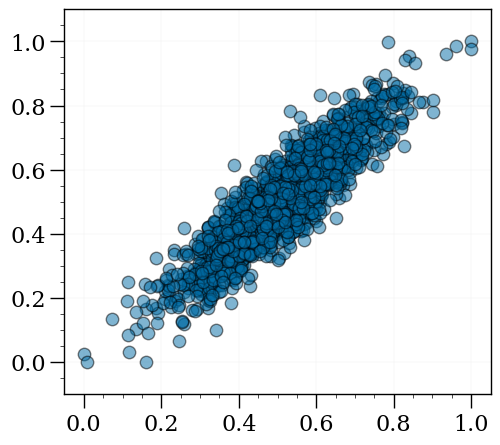

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:33<94:09:41, 33.90s/it]

Iter 0. Loss [[ 0.08019307  0.28756824 19.931568  ]]


  0%|          | 11/10000 [00:59<2:17:47,  1.21it/s]

Iter 10. Loss [[0.08199414 0.26268244 5.839427  ]]


  0%|          | 22/10000 [01:02<33:31,  4.96it/s]

Iter 20. Loss [[0.08327001 0.25316045 5.198094  ]]


  0%|          | 32/10000 [01:03<24:53,  6.68it/s]

Iter 30. Loss [[0.08497391 0.24441934 4.9103937 ]]


  0%|          | 42/10000 [01:05<22:51,  7.26it/s]

Iter 40. Loss [[0.08608337 0.24011421 4.8588214 ]]


  1%|          | 52/10000 [01:06<23:20,  7.10it/s]

Iter 50. Loss [[0.08602387 0.23893782 4.766195  ]]


  1%|          | 62/10000 [01:07<23:02,  7.19it/s]

Iter 60. Loss [[0.08562006 0.23823994 4.622724  ]]


  1%|          | 72/10000 [01:09<30:06,  5.49it/s]

Iter 70. Loss [[0.08559366 0.23573217 4.3677216 ]]


  1%|          | 82/10000 [01:10<22:51,  7.23it/s]

Iter 80. Loss [[0.08534741 0.23393273 3.9042623 ]]


  1%|          | 91/10000 [01:12<26:46,  6.17it/s]

Iter 90. Loss [[0.08457676 0.2366142  3.6294215 ]]


  1%|          | 101/10000 [01:14<41:14,  4.00it/s]

Iter 100. Loss [[0.08415461 0.24176489 3.382151  ]]


  1%|          | 112/10000 [01:16<31:10,  5.29it/s]

Iter 110. Loss [[0.08443232 0.24277213 3.3166075 ]]


  1%|          | 122/10000 [01:18<23:04,  7.13it/s]

Iter 120. Loss [[0.08484954 0.23748775 3.5539203 ]]


  1%|▏         | 132/10000 [01:20<29:33,  5.56it/s]

Iter 130. Loss [[0.08486518 0.2376208  3.8348758 ]]


  1%|▏         | 142/10000 [01:21<23:20,  7.04it/s]

Iter 140. Loss [[0.0851403  0.23302154 3.7511895 ]]


  2%|▏         | 152/10000 [01:23<22:14,  7.38it/s]

Iter 150. Loss [[0.08532765 0.22992207 3.5720904 ]]


  2%|▏         | 162/10000 [01:24<23:09,  7.08it/s]

Iter 160. Loss [[0.08552115 0.22366276 3.3967266 ]]


  2%|▏         | 172/10000 [01:26<25:37,  6.39it/s]

Iter 170. Loss [[0.08501943 0.22197875 3.275184  ]]


  2%|▏         | 181/10000 [01:28<36:14,  4.52it/s]

Iter 180. Loss [[0.08539654 0.21749593 3.1028066 ]]


  2%|▏         | 191/10000 [01:30<37:33,  4.35it/s]

Iter 190. Loss [[0.08579335 0.21534303 2.938218  ]]


  2%|▏         | 202/10000 [01:32<24:38,  6.63it/s]

Iter 200. Loss [[0.08597539 0.21558549 2.8378522 ]]


  2%|▏         | 212/10000 [01:33<22:38,  7.21it/s]

Iter 210. Loss [[0.0864199  0.21390048 2.7435393 ]]


  2%|▏         | 222/10000 [01:34<21:57,  7.42it/s]

Iter 220. Loss [[0.08700844 0.21134667 2.457541  ]]


  2%|▏         | 232/10000 [01:36<22:40,  7.18it/s]

Iter 230. Loss [[0.08796532 0.20871931 2.234268  ]]


  2%|▏         | 242/10000 [01:37<22:33,  7.21it/s]

Iter 240. Loss [[0.08971985 0.20721976 2.1483955 ]]


  3%|▎         | 252/10000 [01:39<23:21,  6.96it/s]

Iter 250. Loss [[0.09151194 0.21154337 2.051198  ]]


  3%|▎         | 262/10000 [01:40<22:58,  7.07it/s]

Iter 260. Loss [[0.09432247 0.20937519 1.7910811 ]]


  3%|▎         | 271/10000 [01:42<32:04,  5.06it/s]

Iter 270. Loss [[0.09797222 0.2055417  1.5079204 ]]


  3%|▎         | 281/10000 [01:44<38:17,  4.23it/s]

Iter 280. Loss [[0.10296441 0.20041472 1.2760037 ]]


  3%|▎         | 292/10000 [01:46<25:27,  6.35it/s]

Iter 290. Loss [[0.10931792 0.19642733 1.2342784 ]]


  3%|▎         | 302/10000 [01:48<22:02,  7.33it/s]

Iter 300. Loss [[0.11644102 0.19062415 1.4057395 ]]


  3%|▎         | 312/10000 [01:49<22:45,  7.10it/s]

Iter 310. Loss [[0.11970697 0.18923955 1.6809934 ]]


  3%|▎         | 322/10000 [01:51<25:23,  6.35it/s]

Iter 320. Loss [[0.12901236 0.18932459 1.3323908 ]]


  3%|▎         | 332/10000 [01:52<22:02,  7.31it/s]

Iter 330. Loss [[0.13876611 0.18685128 0.93480605]]


  3%|▎         | 342/10000 [01:53<23:44,  6.78it/s]

Iter 340. Loss [[0.14863707 0.17904907 0.5126847 ]]


  4%|▎         | 352/10000 [01:55<27:04,  5.94it/s]

Iter 350. Loss [[0.15904278 0.15739945 0.01724843]]


  4%|▎         | 361/10000 [01:57<33:54,  4.74it/s]

Iter 360. Loss [[ 0.16890918  0.1458935  -0.34544143]]


  4%|▎         | 371/10000 [01:59<38:00,  4.22it/s]

Iter 370. Loss [[ 0.17648263  0.13116203 -0.48415703]]


  4%|▍         | 382/10000 [02:01<25:11,  6.36it/s]

Iter 380. Loss [[ 0.18200968  0.12279474 -0.49112397]]


  4%|▍         | 392/10000 [02:03<25:56,  6.17it/s]

Iter 390. Loss [[ 0.18816422  0.11617106 -0.4545484 ]]


  4%|▍         | 402/10000 [02:04<22:01,  7.26it/s]

Iter 400. Loss [[ 0.19410768  0.11567708 -0.45698026]]


  4%|▍         | 412/10000 [02:05<22:02,  7.25it/s]

Iter 410. Loss [[ 0.19906218  0.11024735 -0.5844091 ]]


  4%|▍         | 422/10000 [02:07<22:15,  7.17it/s]

Iter 420. Loss [[ 0.20661648  0.10073722 -0.7075097 ]]


  4%|▍         | 432/10000 [02:08<21:50,  7.30it/s]

Iter 430. Loss [[ 0.2118557   0.09696415 -0.6932762 ]]


  4%|▍         | 442/10000 [02:09<21:52,  7.28it/s]

Iter 440. Loss [[ 0.22029419  0.11393853 -0.2718444 ]]


  5%|▍         | 451/10000 [02:11<29:09,  5.46it/s]

Iter 450. Loss [[ 0.22624911  0.11425419 -0.30318394]]


  5%|▍         | 461/10000 [02:13<36:40,  4.34it/s]

Iter 460. Loss [[ 0.23402162  0.0950555  -0.96431637]]


  5%|▍         | 472/10000 [02:15<29:43,  5.34it/s]

Iter 470. Loss [[ 0.24466345  0.08235063 -1.1683999 ]]


  5%|▍         | 482/10000 [02:17<22:11,  7.15it/s]

Iter 480. Loss [[ 0.26106304  0.08082711 -1.298299  ]]


  5%|▍         | 492/10000 [02:18<22:25,  7.06it/s]

Iter 490. Loss [[ 0.26635557  0.09409974 -1.352778  ]]


  5%|▌         | 502/10000 [02:20<21:52,  7.23it/s]

Iter 500. Loss [[ 0.26320267  0.08668683 -1.2210848 ]]


  5%|▌         | 512/10000 [02:21<21:46,  7.26it/s]

Iter 510. Loss [[ 0.25382617  0.07155301 -1.2616934 ]]


  5%|▌         | 522/10000 [02:23<28:53,  5.47it/s]

Iter 520. Loss [[ 0.256647   0.1111891 -1.0086653]]


  5%|▌         | 532/10000 [02:24<22:20,  7.06it/s]

Iter 530. Loss [[ 0.2692221   0.09929141 -1.2803386 ]]


  5%|▌         | 542/10000 [02:25<24:44,  6.37it/s]

Iter 540. Loss [[ 0.2604588   0.07195859 -1.2274379 ]]


  6%|▌         | 551/10000 [02:28<38:45,  4.06it/s]

Iter 550. Loss [[ 0.26238364  0.06916706 -1.2773213 ]]


  6%|▌         | 562/10000 [02:30<31:34,  4.98it/s]

Iter 560. Loss [[ 0.27439258  0.08608679 -1.3749204 ]]


  6%|▌         | 572/10000 [02:31<22:16,  7.06it/s]

Iter 570. Loss [[ 0.27747563  0.09290291 -1.4435029 ]]


  6%|▌         | 582/10000 [02:33<23:46,  6.60it/s]

Iter 580. Loss [[ 0.27861062  0.09070841 -1.4290566 ]]


  6%|▌         | 592/10000 [02:34<21:34,  7.27it/s]

Iter 590. Loss [[ 0.27898544  0.08204921 -1.2502509 ]]


  6%|▌         | 602/10000 [02:36<22:26,  6.98it/s]

Iter 600. Loss [[ 0.27983913  0.08780083 -1.1567835 ]]


  6%|▌         | 612/10000 [02:37<21:20,  7.33it/s]

Iter 610. Loss [[ 0.27436656  0.08390177 -1.13094   ]]


  6%|▌         | 622/10000 [02:39<23:49,  6.56it/s]

Iter 620. Loss [[ 0.26788607  0.08033359 -1.0993348 ]]


  6%|▋         | 631/10000 [02:40<24:06,  6.48it/s]

Iter 630. Loss [[ 0.26635423  0.08293369 -1.1014496 ]]


  6%|▋         | 641/10000 [02:43<1:16:21,  2.04it/s]

Iter 640. Loss [[ 0.26734763  0.08508691 -1.108787  ]]


  7%|▋         | 652/10000 [02:45<25:17,  6.16it/s]

Iter 650. Loss [[ 0.26829234  0.08400473 -1.1033465 ]]


  7%|▋         | 662/10000 [02:47<21:34,  7.21it/s]

Iter 660. Loss [[ 0.26874942  0.0840438  -1.1017025 ]]


  7%|▋         | 672/10000 [02:48<21:13,  7.33it/s]

Iter 670. Loss [[ 0.26839614  0.08499598 -1.1086076 ]]


  7%|▋         | 682/10000 [02:50<22:59,  6.75it/s]

Iter 680. Loss [[ 0.26855883  0.08213926 -1.0970755 ]]


  7%|▋         | 692/10000 [02:51<21:34,  7.19it/s]

Iter 690. Loss [[ 0.2731051   0.05521961 -0.6856732 ]]


  7%|▋         | 702/10000 [02:52<21:05,  7.35it/s]

Iter 700. Loss [[ 0.26185176  0.13113613 -1.1619812 ]]


  7%|▋         | 712/10000 [02:54<21:01,  7.36it/s]

Iter 710. Loss [[ 0.26902536  0.06863255 -1.0469598 ]]


  7%|▋         | 721/10000 [02:55<29:42,  5.21it/s]

Iter 720. Loss [[ 0.26822427  0.07493786 -1.1049247 ]]


  7%|▋         | 731/10000 [02:57<35:49,  4.31it/s]

Iter 730. Loss [[ 0.27576622  0.07321403 -1.175537  ]]


  7%|▋         | 742/10000 [03:00<26:07,  5.91it/s]

Iter 740. Loss [[ 0.27981025  0.08808311 -1.2907883 ]]


  8%|▊         | 752/10000 [03:01<21:31,  7.16it/s]

Iter 750. Loss [[ 0.27821818  0.09283795 -1.2084844 ]]


  8%|▊         | 762/10000 [03:02<21:01,  7.32it/s]

Iter 760. Loss [[ 0.27488402  0.08771761 -1.2057993 ]]


  8%|▊         | 772/10000 [03:04<21:21,  7.20it/s]

Iter 770. Loss [[ 0.2734249   0.07038727 -1.2768668 ]]


  8%|▊         | 781/10000 [03:05<32:12,  4.77it/s]

Iter 780. Loss [[ 0.27308965  0.07080771 -1.3142176 ]]


  8%|▊         | 792/10000 [03:07<21:57,  6.99it/s]

Iter 790. Loss [[ 0.27453482  0.07501252 -1.3359475 ]]


  8%|▊         | 802/10000 [03:08<20:54,  7.33it/s]

Iter 800. Loss [[ 0.28125787  0.07712439 -1.363507  ]]


  8%|▊         | 811/10000 [03:10<30:47,  4.97it/s]

Iter 810. Loss [[ 0.2829068  0.0891614 -1.3172672]]


  8%|▊         | 821/10000 [03:13<41:56,  3.65it/s]

Iter 820. Loss [[ 0.2812218  0.0848231 -1.2489135]]


  8%|▊         | 832/10000 [03:15<23:33,  6.49it/s]

Iter 830. Loss [[ 0.28251317  0.09033348 -1.2621502 ]]


  8%|▊         | 842/10000 [03:16<21:09,  7.21it/s]

Iter 840. Loss [[ 0.2790189   0.08253837 -1.2562227 ]]


  9%|▊         | 852/10000 [03:17<20:44,  7.35it/s]

Iter 850. Loss [[ 0.275096    0.08138935 -1.2816099 ]]


  9%|▊         | 862/10000 [03:19<27:55,  5.45it/s]

Iter 860. Loss [[ 0.27468595  0.09255731 -1.2562246 ]]


  9%|▊         | 872/10000 [03:20<21:41,  7.02it/s]

Iter 870. Loss [[ 0.2731625   0.10655894 -1.1786678 ]]


  9%|▉         | 882/10000 [03:22<20:57,  7.25it/s]

Iter 880. Loss [[ 0.27393538  0.08426361 -1.1148369 ]]


  9%|▉         | 892/10000 [03:23<26:16,  5.78it/s]

Iter 890. Loss [[ 0.2741529   0.08333974 -1.1361543 ]]


  9%|▉         | 901/10000 [03:25<32:30,  4.66it/s]

Iter 900. Loss [[ 0.27229837  0.09432208 -1.1339828 ]]


  9%|▉         | 911/10000 [03:27<36:06,  4.20it/s]

Iter 910. Loss [[ 0.27126133  0.16789937 -1.018181  ]]


  9%|▉         | 922/10000 [03:29<23:05,  6.55it/s]

Iter 920. Loss [[ 0.27692756  0.09549586 -0.44099548]]


  9%|▉         | 932/10000 [03:31<21:15,  7.11it/s]

Iter 930. Loss [[ 0.28636402  0.10009336 -0.70299184]]


  9%|▉         | 942/10000 [03:32<21:56,  6.88it/s]

Iter 940. Loss [[ 0.29551062  0.13657898 -1.0160027 ]]


 10%|▉         | 952/10000 [03:34<20:36,  7.32it/s]

Iter 950. Loss [[ 0.28698355  0.11771989 -1.2704723 ]]


 10%|▉         | 962/10000 [03:35<21:01,  7.16it/s]

Iter 960. Loss [[ 0.27258104  0.09025899 -1.1706123 ]]


 10%|▉         | 972/10000 [03:36<20:44,  7.25it/s]

Iter 970. Loss [[ 0.27225414  0.095318   -1.2427154 ]]


 10%|▉         | 982/10000 [03:38<20:45,  7.24it/s]

Iter 980. Loss [[ 0.28211105  0.1172148  -1.379609  ]]


 10%|▉         | 991/10000 [03:39<28:21,  5.30it/s]

Iter 990. Loss [[ 0.2847553   0.12304012 -1.3757809 ]]


 10%|█         | 1001/10000 [03:41<35:27,  4.23it/s]

Iter 1000. Loss [[ 0.28582877  0.1096997  -1.3072734 ]]


 10%|█         | 1012/10000 [03:44<25:36,  5.85it/s]

Iter 1010. Loss [[ 0.26902154  0.15679727 -0.8228662 ]]


 10%|█         | 1022/10000 [03:45<22:11,  6.74it/s]

Iter 1020. Loss [[ 0.27039215  0.10039344 -0.8954108 ]]


 10%|█         | 1032/10000 [03:47<20:24,  7.32it/s]

Iter 1030. Loss [[ 0.28276405  0.11349462 -1.2453697 ]]


 10%|█         | 1042/10000 [03:48<20:16,  7.36it/s]

Iter 1040. Loss [[ 0.2862928   0.09558473 -1.4135184 ]]


 11%|█         | 1052/10000 [03:49<20:22,  7.32it/s]

Iter 1050. Loss [[ 0.27804545  0.07224303 -1.3644313 ]]


 11%|█         | 1062/10000 [03:51<20:41,  7.20it/s]

Iter 1060. Loss [[ 0.27253628  0.06844177 -1.4549752 ]]


 11%|█         | 1072/10000 [03:52<21:21,  6.97it/s]

Iter 1070. Loss [[ 0.2750652   0.07606908 -1.5046989 ]]


 11%|█         | 1081/10000 [03:54<26:48,  5.54it/s]

Iter 1080. Loss [[ 0.2718961   0.11002702 -1.488422  ]]


 11%|█         | 1091/10000 [03:56<35:47,  4.15it/s]

Iter 1090. Loss [[ 0.27313107  0.08524574 -1.3363904 ]]


 11%|█         | 1102/10000 [03:58<24:14,  6.12it/s]

Iter 1100. Loss [[ 0.27959257  0.06408867 -1.2517611 ]]


 11%|█         | 1112/10000 [04:00<20:44,  7.14it/s]

Iter 1110. Loss [[ 0.28230375  0.07738461 -1.2968361 ]]


 11%|█         | 1122/10000 [04:01<21:21,  6.93it/s]

Iter 1120. Loss [[ 0.28607264  0.08252165 -1.3688555 ]]


 11%|█▏        | 1132/10000 [04:03<20:38,  7.16it/s]

Iter 1130. Loss [[ 0.2843226   0.08032628 -1.1992598 ]]


 11%|█▏        | 1142/10000 [04:04<20:17,  7.28it/s]

Iter 1140. Loss [[ 0.27459857  0.0873645  -1.205648  ]]


 12%|█▏        | 1152/10000 [04:05<19:46,  7.46it/s]

Iter 1150. Loss [[ 0.27177358  0.08273452 -1.2404445 ]]


 12%|█▏        | 1162/10000 [04:07<20:19,  7.25it/s]

Iter 1160. Loss [[ 0.27222112  0.07152283 -1.2338272 ]]


 12%|█▏        | 1171/10000 [04:08<29:52,  4.93it/s]

Iter 1170. Loss [[ 0.27340323  0.07766974 -1.2407656 ]]


 12%|█▏        | 1181/10000 [04:11<33:47,  4.35it/s]

Iter 1180. Loss [[ 0.27564818  0.07786676 -1.2422129 ]]


 12%|█▏        | 1192/10000 [04:13<26:15,  5.59it/s]

Iter 1190. Loss [[ 0.27631703  0.07108385 -1.1769204 ]]


 12%|█▏        | 1202/10000 [04:14<20:16,  7.23it/s]

Iter 1200. Loss [[ 0.2734855   0.10629075 -1.2587876 ]]


 12%|█▏        | 1212/10000 [04:16<20:22,  7.19it/s]

Iter 1210. Loss [[ 0.27595484  0.06416962 -1.0667603 ]]


 12%|█▏        | 1222/10000 [04:17<25:24,  5.76it/s]

Iter 1220. Loss [[ 0.27269143  0.06883464 -1.1056517 ]]


 12%|█▏        | 1232/10000 [04:19<20:22,  7.17it/s]

Iter 1230. Loss [[ 0.27102166  0.06490207 -1.065126  ]]


 12%|█▏        | 1242/10000 [04:20<20:32,  7.11it/s]

Iter 1240. Loss [[ 0.26764417  0.10518179 -1.2778639 ]]


 13%|█▎        | 1252/10000 [04:22<21:16,  6.85it/s]

Iter 1250. Loss [[ 0.2704416   0.08689209 -1.2215315 ]]


 13%|█▎        | 1261/10000 [04:23<26:40,  5.46it/s]

Iter 1260. Loss [[ 0.2715222   0.08844067 -1.1859955 ]]


 13%|█▎        | 1271/10000 [04:25<34:01,  4.28it/s]

Iter 1270. Loss [[ 0.27226827  0.07863057 -1.1132443 ]]


 13%|█▎        | 1282/10000 [04:28<26:35,  5.46it/s]

Iter 1280. Loss [[ 0.27076325  0.07874736 -1.1348588 ]]


 13%|█▎        | 1292/10000 [04:30<31:20,  4.63it/s]

Iter 1290. Loss [[ 0.26878753  0.08615719 -1.1814091 ]]


 13%|█▎        | 1302/10000 [04:31<20:48,  6.96it/s]

Iter 1300. Loss [[ 0.26767245  0.08025184 -1.2037208 ]]


 13%|█▎        | 1312/10000 [04:32<20:03,  7.22it/s]

Iter 1310. Loss [[ 0.2660938   0.09302731 -1.3038121 ]]


 13%|█▎        | 1322/10000 [04:34<22:29,  6.43it/s]

Iter 1320. Loss [[ 0.26664     0.08501898 -1.3020842 ]]


 13%|█▎        | 1332/10000 [04:35<20:00,  7.22it/s]

Iter 1330. Loss [[ 0.26791143  0.0837553  -1.3251665 ]]


 13%|█▎        | 1342/10000 [04:37<20:18,  7.11it/s]

Iter 1340. Loss [[ 0.2685056   0.08206838 -1.3207072 ]]


 14%|█▎        | 1351/10000 [04:38<30:55,  4.66it/s]

Iter 1350. Loss [[ 0.26901904  0.08158253 -1.2936822 ]]


 14%|█▎        | 1361/10000 [04:41<33:22,  4.31it/s]

Iter 1360. Loss [[ 0.2679245   0.07966565 -1.277694  ]]


 14%|█▎        | 1372/10000 [04:43<22:22,  6.43it/s]

Iter 1370. Loss [[ 0.26734152  0.07942481 -1.2906839 ]]


 14%|█▍        | 1382/10000 [04:44<21:58,  6.54it/s]

Iter 1380. Loss [[ 0.2677841   0.07972173 -1.287166  ]]


 14%|█▍        | 1392/10000 [04:46<19:51,  7.22it/s]

Iter 1390. Loss [[ 0.26808214  0.0785166  -1.274396  ]]


 14%|█▍        | 1402/10000 [04:47<19:58,  7.17it/s]

Iter 1400. Loss [[ 0.26755494  0.07744553 -1.2860519 ]]


 14%|█▍        | 1412/10000 [04:49<19:32,  7.32it/s]

Iter 1410. Loss [[ 0.2680069   0.07816501 -1.2838339 ]]


 14%|█▍        | 1422/10000 [04:50<20:01,  7.14it/s]

Iter 1420. Loss [[ 0.26806304  0.07862452 -1.286006  ]]


 14%|█▍        | 1432/10000 [04:51<20:01,  7.13it/s]

Iter 1430. Loss [[ 0.26832223  0.07952607 -1.2741047 ]]


 14%|█▍        | 1441/10000 [04:53<27:53,  5.11it/s]

Iter 1440. Loss [[ 0.26816088  0.07931359 -1.2697835 ]]


 15%|█▍        | 1451/10000 [04:55<31:50,  4.48it/s]

Iter 1450. Loss [[ 0.26863277  0.07975508 -1.2801871 ]]


 15%|█▍        | 1462/10000 [04:57<26:11,  5.43it/s]

Iter 1460. Loss [[ 0.26549268  0.12420084 -1.3806386 ]]


 15%|█▍        | 1472/10000 [04:59<19:59,  7.11it/s]

Iter 1470. Loss [[ 0.26642457  0.09243384 -1.3173022 ]]


 15%|█▍        | 1482/10000 [05:00<19:27,  7.30it/s]

Iter 1480. Loss [[ 0.26918     0.08019539 -1.253206  ]]


 15%|█▍        | 1492/10000 [05:01<19:29,  7.27it/s]

Iter 1490. Loss [[ 0.26674595  0.07162381 -1.2350305 ]]


 15%|█▌        | 1502/10000 [05:03<19:26,  7.28it/s]

Iter 1500. Loss [[ 0.272398    0.07199301 -1.2262782 ]]


 15%|█▌        | 1512/10000 [05:04<19:15,  7.35it/s]

Iter 1510. Loss [[ 0.27359843  0.07787585 -1.2715977 ]]


 15%|█▌        | 1522/10000 [05:06<22:26,  6.30it/s]

Iter 1520. Loss [[ 0.273123    0.08412015 -1.2769984 ]]


 15%|█▌        | 1532/10000 [05:07<19:55,  7.08it/s]

Iter 1530. Loss [[ 0.27361125  0.07820076 -1.2535118 ]]


 15%|█▌        | 1541/10000 [05:09<31:04,  4.54it/s]

Iter 1540. Loss [[ 0.2737324   0.07475887 -1.2221081 ]]


 16%|█▌        | 1551/10000 [05:11<33:33,  4.20it/s]

Iter 1550. Loss [[ 0.27271053  0.07684385 -1.2123698 ]]


 16%|█▌        | 1561/10000 [05:13<19:48,  7.10it/s]

Iter 1560. Loss [[ 0.2730632   0.06693786 -1.1963446 ]]


 16%|█▌        | 1572/10000 [05:15<19:16,  7.29it/s]

Iter 1570. Loss [[ 0.27702633  0.06558465 -1.2250385 ]]


 16%|█▌        | 1582/10000 [05:16<19:12,  7.30it/s]

Iter 1580. Loss [[ 0.27660084  0.0524957  -1.1040791 ]]


 16%|█▌        | 1591/10000 [05:17<19:51,  7.06it/s]

Iter 1590. Loss [[ 0.27382693  0.04820907 -0.98264354]]


 16%|█▌        | 1602/10000 [05:19<19:52,  7.04it/s]

Iter 1600. Loss [[ 0.26811668  0.07836323 -1.1296408 ]]


 16%|█▌        | 1612/10000 [05:20<19:26,  7.19it/s]

Iter 1610. Loss [[ 0.2725594   0.04845283 -1.0442085 ]]


 16%|█▌        | 1622/10000 [05:22<19:05,  7.31it/s]

Iter 1620. Loss [[ 0.27395013  0.07019843 -1.1452495 ]]


 16%|█▋        | 1631/10000 [05:24<32:19,  4.32it/s]

Iter 1630. Loss [[0.26871106 0.08653279 0.11756202]]


 16%|█▋        | 1641/10000 [05:26<36:05,  3.86it/s]

Iter 1640. Loss [[0.25197685 0.08570684 0.2755045 ]]


 17%|█▋        | 1652/10000 [05:28<19:40,  7.07it/s]

Iter 1650. Loss [[nan nan nan]]


 17%|█▋        | 1662/10000 [05:29<19:05,  7.28it/s]

Iter 1660. Loss [[nan nan nan]]


 17%|█▋        | 1672/10000 [05:30<18:43,  7.42it/s]

Iter 1670. Loss [[nan nan nan]]


 17%|█▋        | 1682/10000 [05:32<19:28,  7.12it/s]

Iter 1680. Loss [[nan nan nan]]


 17%|█▋        | 1692/10000 [05:33<19:06,  7.25it/s]

Iter 1690. Loss [[nan nan nan]]


 17%|█▋        | 1702/10000 [05:35<18:35,  7.44it/s]

Iter 1700. Loss [[nan nan nan]]


 17%|█▋        | 1712/10000 [05:36<18:55,  7.30it/s]

Iter 1710. Loss [[nan nan nan]]


 17%|█▋        | 1721/10000 [05:38<29:29,  4.68it/s]

Iter 1720. Loss [[nan nan nan]]


 17%|█▋        | 1731/10000 [05:40<31:32,  4.37it/s]

Iter 1730. Loss [[nan nan nan]]


 17%|█▋        | 1742/10000 [05:42<20:47,  6.62it/s]

Iter 1740. Loss [[nan nan nan]]


 18%|█▊        | 1752/10000 [05:43<19:17,  7.13it/s]

Iter 1750. Loss [[nan nan nan]]


 18%|█▊        | 1762/10000 [05:45<18:38,  7.36it/s]

Iter 1760. Loss [[nan nan nan]]


 18%|█▊        | 1772/10000 [05:46<18:54,  7.25it/s]

Iter 1770. Loss [[nan nan nan]]


 18%|█▊        | 1782/10000 [05:48<20:09,  6.80it/s]

Iter 1780. Loss [[nan nan nan]]


 18%|█▊        | 1792/10000 [05:49<18:48,  7.27it/s]

Iter 1790. Loss [[nan nan nan]]


 18%|█▊        | 1802/10000 [05:50<19:14,  7.10it/s]

Iter 1800. Loss [[nan nan nan]]


 18%|█▊        | 1811/10000 [05:52<26:26,  5.16it/s]

Iter 1810. Loss [[nan nan nan]]


 18%|█▊        | 1821/10000 [05:54<30:44,  4.43it/s]

Iter 1820. Loss [[nan nan nan]]


 18%|█▊        | 1832/10000 [05:56<21:28,  6.34it/s]

Iter 1830. Loss [[nan nan nan]]


 18%|█▊        | 1842/10000 [05:58<18:23,  7.40it/s]

Iter 1840. Loss [[nan nan nan]]


 19%|█▊        | 1852/10000 [05:59<18:02,  7.52it/s]

Iter 1850. Loss [[nan nan nan]]


 19%|█▊        | 1862/10000 [06:01<18:52,  7.19it/s]

Iter 1860. Loss [[nan nan nan]]


 19%|█▊        | 1872/10000 [06:02<18:31,  7.31it/s]

Iter 1870. Loss [[nan nan nan]]


 19%|█▉        | 1882/10000 [06:03<18:16,  7.41it/s]

Iter 1880. Loss [[nan nan nan]]


 19%|█▉        | 1892/10000 [06:05<18:02,  7.49it/s]

Iter 1890. Loss [[nan nan nan]]


 19%|█▉        | 1902/10000 [06:06<18:31,  7.29it/s]

Iter 1900. Loss [[nan nan nan]]


 19%|█▉        | 1911/10000 [06:08<32:59,  4.09it/s]

Iter 1910. Loss [[nan nan nan]]


 19%|█▉        | 1922/10000 [06:11<29:42,  4.53it/s]

Iter 1920. Loss [[nan nan nan]]


 19%|█▉        | 1932/10000 [06:12<18:15,  7.36it/s]

Iter 1930. Loss [[nan nan nan]]


 19%|█▉        | 1942/10000 [06:13<18:32,  7.24it/s]

Iter 1940. Loss [[nan nan nan]]


 20%|█▉        | 1952/10000 [06:15<18:46,  7.14it/s]

Iter 1950. Loss [[nan nan nan]]


 20%|█▉        | 1962/10000 [06:16<18:35,  7.21it/s]

Iter 1960. Loss [[nan nan nan]]


 20%|█▉        | 1972/10000 [06:18<20:41,  6.47it/s]

Iter 1970. Loss [[nan nan nan]]


 20%|█▉        | 1982/10000 [06:19<18:12,  7.34it/s]

Iter 1980. Loss [[nan nan nan]]


 20%|█▉        | 1992/10000 [06:20<18:23,  7.26it/s]

Iter 1990. Loss [[nan nan nan]]


 20%|██        | 2001/10000 [06:22<29:33,  4.51it/s]

Iter 2000. Loss [[nan nan nan]]


 20%|██        | 2011/10000 [06:25<31:02,  4.29it/s]

Iter 2010. Loss [[nan nan nan]]


 20%|██        | 2022/10000 [06:27<20:23,  6.52it/s]

Iter 2020. Loss [[nan nan nan]]


 20%|██        | 2032/10000 [06:28<18:23,  7.22it/s]

Iter 2030. Loss [[nan nan nan]]


 20%|██        | 2042/10000 [06:29<18:28,  7.18it/s]

Iter 2040. Loss [[nan nan nan]]


 21%|██        | 2052/10000 [06:31<19:02,  6.96it/s]

Iter 2050. Loss [[nan nan nan]]


 21%|██        | 2062/10000 [06:32<18:49,  7.03it/s]

Iter 2060. Loss [[nan nan nan]]


 21%|██        | 2072/10000 [06:34<18:54,  6.99it/s]

Iter 2070. Loss [[nan nan nan]]


 21%|██        | 2082/10000 [06:35<20:28,  6.44it/s]

Iter 2080. Loss [[nan nan nan]]


 21%|██        | 2091/10000 [06:37<30:23,  4.34it/s]

Iter 2090. Loss [[nan nan nan]]


 21%|██        | 2101/10000 [06:40<31:04,  4.24it/s]

Iter 2100. Loss [[nan nan nan]]


 21%|██        | 2112/10000 [06:41<19:22,  6.79it/s]

Iter 2110. Loss [[nan nan nan]]


 21%|██        | 2122/10000 [06:43<18:23,  7.14it/s]

Iter 2120. Loss [[nan nan nan]]


 21%|██▏       | 2132/10000 [06:44<18:58,  6.91it/s]

Iter 2130. Loss [[nan nan nan]]


 21%|██▏       | 2142/10000 [06:46<19:55,  6.57it/s]

Iter 2140. Loss [[nan nan nan]]


 22%|██▏       | 2152/10000 [06:47<18:37,  7.02it/s]

Iter 2150. Loss [[nan nan nan]]


 22%|██▏       | 2162/10000 [06:49<18:14,  7.16it/s]

Iter 2160. Loss [[nan nan nan]]


 22%|██▏       | 2172/10000 [06:50<18:19,  7.12it/s]

Iter 2170. Loss [[nan nan nan]]


 22%|██▏       | 2181/10000 [06:52<30:20,  4.29it/s]

Iter 2180. Loss [[nan nan nan]]


 22%|██▏       | 2191/10000 [06:54<29:31,  4.41it/s]

Iter 2190. Loss [[nan nan nan]]


 22%|██▏       | 2202/10000 [06:56<18:44,  6.93it/s]

Iter 2200. Loss [[nan nan nan]]


 22%|██▏       | 2212/10000 [06:57<17:52,  7.26it/s]

Iter 2210. Loss [[nan nan nan]]


 22%|██▏       | 2222/10000 [06:59<18:25,  7.04it/s]

Iter 2220. Loss [[nan nan nan]]


 22%|██▏       | 2232/10000 [07:00<23:49,  5.44it/s]

Iter 2230. Loss [[nan nan nan]]


 22%|██▏       | 2242/10000 [07:02<18:24,  7.02it/s]

Iter 2240. Loss [[nan nan nan]]


 23%|██▎       | 2252/10000 [07:03<17:52,  7.22it/s]

Iter 2250. Loss [[nan nan nan]]


 23%|██▎       | 2262/10000 [07:05<19:51,  6.50it/s]

Iter 2260. Loss [[nan nan nan]]


 23%|██▎       | 2271/10000 [07:07<29:55,  4.30it/s]

Iter 2270. Loss [[nan nan nan]]


 23%|██▎       | 2281/10000 [07:09<30:15,  4.25it/s]

Iter 2280. Loss [[nan nan nan]]


 23%|██▎       | 2292/10000 [07:11<21:09,  6.07it/s]

Iter 2290. Loss [[nan nan nan]]


 23%|██▎       | 2302/10000 [07:13<18:12,  7.05it/s]

Iter 2300. Loss [[nan nan nan]]


 23%|██▎       | 2312/10000 [07:14<17:47,  7.20it/s]

Iter 2310. Loss [[nan nan nan]]


 23%|██▎       | 2322/10000 [07:15<18:42,  6.84it/s]

Iter 2320. Loss [[nan nan nan]]


 23%|██▎       | 2332/10000 [07:17<19:57,  6.40it/s]

Iter 2330. Loss [[nan nan nan]]


 23%|██▎       | 2342/10000 [07:18<17:48,  7.17it/s]

Iter 2340. Loss [[nan nan nan]]


 24%|██▎       | 2352/10000 [07:20<17:50,  7.15it/s]

Iter 2350. Loss [[nan nan nan]]


 24%|██▎       | 2361/10000 [07:22<29:24,  4.33it/s]

Iter 2360. Loss [[nan nan nan]]


 24%|██▎       | 2371/10000 [07:24<29:11,  4.36it/s]

Iter 2370. Loss [[nan nan nan]]


 24%|██▍       | 2382/10000 [07:26<18:50,  6.74it/s]

Iter 2380. Loss [[nan nan nan]]


 24%|██▍       | 2392/10000 [07:27<20:11,  6.28it/s]

Iter 2390. Loss [[nan nan nan]]


 24%|██▍       | 2402/10000 [07:29<18:24,  6.88it/s]

Iter 2400. Loss [[nan nan nan]]


 24%|██▍       | 2412/10000 [07:30<17:45,  7.12it/s]

Iter 2410. Loss [[nan nan nan]]


 24%|██▍       | 2422/10000 [07:32<17:19,  7.29it/s]

Iter 2420. Loss [[nan nan nan]]


 24%|██▍       | 2432/10000 [07:33<17:54,  7.05it/s]

Iter 2430. Loss [[nan nan nan]]


 24%|██▍       | 2442/10000 [07:35<17:55,  7.03it/s]

Iter 2440. Loss [[nan nan nan]]


 25%|██▍       | 2451/10000 [07:37<28:04,  4.48it/s]

Iter 2450. Loss [[nan nan nan]]


 25%|██▍       | 2461/10000 [07:39<29:05,  4.32it/s]

Iter 2460. Loss [[nan nan nan]]


 25%|██▍       | 2472/10000 [07:41<18:01,  6.96it/s]

Iter 2470. Loss [[nan nan nan]]


 25%|██▍       | 2482/10000 [07:42<17:39,  7.10it/s]

Iter 2480. Loss [[nan nan nan]]


 25%|██▍       | 2492/10000 [07:43<17:24,  7.19it/s]

Iter 2490. Loss [[nan nan nan]]


 25%|██▌       | 2502/10000 [07:45<18:16,  6.84it/s]

Iter 2500. Loss [[nan nan nan]]


 25%|██▌       | 2512/10000 [07:47<17:48,  7.01it/s]

Iter 2510. Loss [[nan nan nan]]


 25%|██▌       | 2522/10000 [07:48<17:40,  7.05it/s]

Iter 2520. Loss [[nan nan nan]]


 25%|██▌       | 2532/10000 [07:49<16:56,  7.34it/s]

Iter 2530. Loss [[nan nan nan]]


 25%|██▌       | 2541/10000 [07:51<28:23,  4.38it/s]

Iter 2540. Loss [[nan nan nan]]


 26%|██▌       | 2552/10000 [07:54<27:56,  4.44it/s]

Iter 2550. Loss [[nan nan nan]]


 26%|██▌       | 2562/10000 [07:56<17:17,  7.17it/s]

Iter 2560. Loss [[nan nan nan]]


 26%|██▌       | 2572/10000 [07:57<17:35,  7.04it/s]

Iter 2570. Loss [[nan nan nan]]


 26%|██▌       | 2582/10000 [07:58<17:06,  7.23it/s]

Iter 2580. Loss [[nan nan nan]]


 26%|██▌       | 2592/10000 [08:00<16:54,  7.30it/s]

Iter 2590. Loss [[nan nan nan]]


 26%|██▌       | 2602/10000 [08:01<17:19,  7.11it/s]

Iter 2600. Loss [[nan nan nan]]


 26%|██▌       | 2612/10000 [08:02<16:38,  7.40it/s]

Iter 2610. Loss [[nan nan nan]]


 26%|██▌       | 2622/10000 [08:04<16:22,  7.51it/s]

Iter 2620. Loss [[nan nan nan]]


 26%|██▋       | 2631/10000 [08:06<26:56,  4.56it/s]

Iter 2630. Loss [[nan nan nan]]


 26%|██▋       | 2641/10000 [08:08<27:48,  4.41it/s]

Iter 2640. Loss [[nan nan nan]]


 27%|██▋       | 2652/10000 [08:10<17:15,  7.10it/s]

Iter 2650. Loss [[nan nan nan]]


 27%|██▋       | 2662/10000 [08:11<17:07,  7.14it/s]

Iter 2660. Loss [[nan nan nan]]


 27%|██▋       | 2672/10000 [08:13<17:28,  6.99it/s]

Iter 2670. Loss [[nan nan nan]]


 27%|██▋       | 2682/10000 [08:14<16:23,  7.44it/s]

Iter 2680. Loss [[nan nan nan]]


 27%|██▋       | 2692/10000 [08:15<17:51,  6.82it/s]

Iter 2690. Loss [[nan nan nan]]


 27%|██▋       | 2702/10000 [08:17<17:36,  6.91it/s]

Iter 2700. Loss [[nan nan nan]]


 27%|██▋       | 2712/10000 [08:18<16:18,  7.45it/s]

Iter 2710. Loss [[nan nan nan]]


 27%|██▋       | 2721/10000 [08:20<26:04,  4.65it/s]

Iter 2720. Loss [[nan nan nan]]


 27%|██▋       | 2731/10000 [08:22<27:43,  4.37it/s]

Iter 2730. Loss [[nan nan nan]]


 27%|██▋       | 2742/10000 [08:24<18:56,  6.39it/s]

Iter 2740. Loss [[nan nan nan]]


 28%|██▊       | 2752/10000 [08:26<16:24,  7.36it/s]

Iter 2750. Loss [[nan nan nan]]


 28%|██▊       | 2762/10000 [08:27<16:54,  7.13it/s]

Iter 2760. Loss [[nan nan nan]]


 28%|██▊       | 2772/10000 [08:28<16:05,  7.48it/s]

Iter 2770. Loss [[nan nan nan]]


 28%|██▊       | 2782/10000 [08:30<16:29,  7.29it/s]

Iter 2780. Loss [[nan nan nan]]


 28%|██▊       | 2792/10000 [08:31<16:11,  7.42it/s]

Iter 2790. Loss [[nan nan nan]]


 28%|██▊       | 2802/10000 [08:32<16:25,  7.31it/s]

Iter 2800. Loss [[nan nan nan]]


 28%|██▊       | 2811/10000 [08:34<28:51,  4.15it/s]

Iter 2810. Loss [[nan nan nan]]


 28%|██▊       | 2821/10000 [08:36<27:32,  4.34it/s]

Iter 2820. Loss [[nan nan nan]]


 28%|██▊       | 2832/10000 [08:39<21:14,  5.62it/s]

Iter 2830. Loss [[nan nan nan]]


 28%|██▊       | 2842/10000 [08:40<16:03,  7.43it/s]

Iter 2840. Loss [[nan nan nan]]


 29%|██▊       | 2852/10000 [08:41<19:51,  6.00it/s]

Iter 2850. Loss [[nan nan nan]]


 29%|██▊       | 2862/10000 [08:43<16:01,  7.43it/s]

Iter 2860. Loss [[nan nan nan]]


 29%|██▊       | 2872/10000 [08:44<15:58,  7.43it/s]

Iter 2870. Loss [[nan nan nan]]


 29%|██▉       | 2882/10000 [08:46<17:57,  6.61it/s]

Iter 2880. Loss [[nan nan nan]]


 29%|██▉       | 2892/10000 [08:47<16:06,  7.36it/s]

Iter 2890. Loss [[nan nan nan]]


 29%|██▉       | 2902/10000 [08:48<16:28,  7.18it/s]

Iter 2900. Loss [[nan nan nan]]


 29%|██▉       | 2911/10000 [08:50<26:23,  4.48it/s]

Iter 2910. Loss [[nan nan nan]]


 29%|██▉       | 2922/10000 [08:53<25:33,  4.62it/s]

Iter 2920. Loss [[nan nan nan]]


 29%|██▉       | 2932/10000 [08:54<16:20,  7.21it/s]

Iter 2930. Loss [[nan nan nan]]


 29%|██▉       | 2942/10000 [08:56<15:44,  7.47it/s]

Iter 2940. Loss [[nan nan nan]]


 30%|██▉       | 2952/10000 [08:57<16:05,  7.30it/s]

Iter 2950. Loss [[nan nan nan]]


 30%|██▉       | 2962/10000 [08:59<18:03,  6.50it/s]

Iter 2960. Loss [[nan nan nan]]


 30%|██▉       | 2972/10000 [09:00<15:34,  7.52it/s]

Iter 2970. Loss [[nan nan nan]]


 30%|██▉       | 2982/10000 [09:01<16:10,  7.23it/s]

Iter 2980. Loss [[nan nan nan]]


 30%|██▉       | 2992/10000 [09:03<16:11,  7.21it/s]

Iter 2990. Loss [[nan nan nan]]


 30%|███       | 3001/10000 [09:04<25:30,  4.57it/s]

Iter 3000. Loss [[nan nan nan]]


 30%|███       | 3011/10000 [09:07<26:26,  4.41it/s]

Iter 3010. Loss [[nan nan nan]]


 30%|███       | 3022/10000 [09:09<17:02,  6.82it/s]

Iter 3020. Loss [[nan nan nan]]


 30%|███       | 3032/10000 [09:10<15:31,  7.48it/s]

Iter 3030. Loss [[nan nan nan]]


 30%|███       | 3042/10000 [09:11<15:47,  7.35it/s]

Iter 3040. Loss [[nan nan nan]]


 31%|███       | 3052/10000 [09:13<19:17,  6.00it/s]

Iter 3050. Loss [[nan nan nan]]


 31%|███       | 3062/10000 [09:14<15:33,  7.43it/s]

Iter 3060. Loss [[nan nan nan]]


 31%|███       | 3072/10000 [09:15<15:47,  7.32it/s]

Iter 3070. Loss [[nan nan nan]]


 31%|███       | 3082/10000 [09:17<15:39,  7.37it/s]

Iter 3080. Loss [[nan nan nan]]


 31%|███       | 3091/10000 [09:18<20:28,  5.63it/s]

Iter 3090. Loss [[nan nan nan]]


 31%|███       | 3101/10000 [09:21<27:53,  4.12it/s]

Iter 3100. Loss [[nan nan nan]]


 31%|███       | 3112/10000 [09:23<20:30,  5.60it/s]

Iter 3110. Loss [[nan nan nan]]


 31%|███       | 3122/10000 [09:24<15:19,  7.48it/s]

Iter 3120. Loss [[nan nan nan]]


 31%|███▏      | 3132/10000 [09:26<16:56,  6.76it/s]

Iter 3130. Loss [[nan nan nan]]


 31%|███▏      | 3142/10000 [09:27<15:49,  7.22it/s]

Iter 3140. Loss [[nan nan nan]]


 32%|███▏      | 3152/10000 [09:28<15:55,  7.16it/s]

Iter 3150. Loss [[nan nan nan]]


 32%|███▏      | 3162/10000 [09:30<15:31,  7.34it/s]

Iter 3160. Loss [[nan nan nan]]


 32%|███▏      | 3172/10000 [09:31<17:24,  6.54it/s]

Iter 3170. Loss [[nan nan nan]]


 32%|███▏      | 3181/10000 [09:33<16:04,  7.07it/s]

Iter 3180. Loss [[nan nan nan]]


 32%|███▏      | 3191/10000 [09:35<25:24,  4.47it/s]

Iter 3190. Loss [[nan nan nan]]


 32%|███▏      | 3201/10000 [09:37<25:38,  4.42it/s]

Iter 3200. Loss [[nan nan nan]]


 32%|███▏      | 3212/10000 [09:39<15:26,  7.33it/s]

Iter 3210. Loss [[nan nan nan]]


 32%|███▏      | 3222/10000 [09:40<15:11,  7.43it/s]

Iter 3220. Loss [[nan nan nan]]


 32%|███▏      | 3232/10000 [09:41<15:24,  7.32it/s]

Iter 3230. Loss [[nan nan nan]]


 32%|███▏      | 3242/10000 [09:43<15:27,  7.29it/s]

Iter 3240. Loss [[nan nan nan]]


 33%|███▎      | 3252/10000 [09:44<15:05,  7.45it/s]

Iter 3250. Loss [[nan nan nan]]


 33%|███▎      | 3262/10000 [09:45<15:00,  7.48it/s]

Iter 3260. Loss [[nan nan nan]]


 33%|███▎      | 3272/10000 [09:47<15:12,  7.38it/s]

Iter 3270. Loss [[nan nan nan]]


 33%|███▎      | 3281/10000 [09:48<24:03,  4.65it/s]

Iter 3280. Loss [[nan nan nan]]


 33%|███▎      | 3291/10000 [09:51<24:48,  4.51it/s]

Iter 3290. Loss [[nan nan nan]]


 33%|███▎      | 3302/10000 [09:53<20:48,  5.36it/s]

Iter 3300. Loss [[nan nan nan]]


 33%|███▎      | 3312/10000 [09:54<15:41,  7.11it/s]

Iter 3310. Loss [[nan nan nan]]


 33%|███▎      | 3322/10000 [09:56<15:17,  7.28it/s]

Iter 3320. Loss [[nan nan nan]]


 33%|███▎      | 3332/10000 [09:57<15:17,  7.27it/s]

Iter 3330. Loss [[nan nan nan]]


 33%|███▎      | 3341/10000 [09:58<15:25,  7.19it/s]

Iter 3340. Loss [[nan nan nan]]


 34%|███▎      | 3352/10000 [10:00<15:49,  7.00it/s]

Iter 3350. Loss [[nan nan nan]]


 34%|███▎      | 3362/10000 [10:01<15:36,  7.09it/s]

Iter 3360. Loss [[nan nan nan]]


 34%|███▎      | 3371/10000 [10:03<30:54,  3.57it/s]

Iter 3370. Loss [[nan nan nan]]


 34%|███▍      | 3381/10000 [10:05<25:15,  4.37it/s]

Iter 3380. Loss [[nan nan nan]]


 34%|███▍      | 3392/10000 [10:08<16:49,  6.55it/s]

Iter 3390. Loss [[nan nan nan]]


 34%|███▍      | 3402/10000 [10:09<15:11,  7.24it/s]

Iter 3400. Loss [[nan nan nan]]


 34%|███▍      | 3412/10000 [10:10<15:37,  7.03it/s]

Iter 3410. Loss [[nan nan nan]]


 34%|███▍      | 3422/10000 [10:12<14:54,  7.35it/s]

Iter 3420. Loss [[nan nan nan]]


 34%|███▍      | 3432/10000 [10:13<15:01,  7.29it/s]

Iter 3430. Loss [[nan nan nan]]


 34%|███▍      | 3442/10000 [10:15<15:55,  6.86it/s]

Iter 3440. Loss [[nan nan nan]]


 35%|███▍      | 3451/10000 [10:16<15:36,  6.99it/s]

Iter 3450. Loss [[nan nan nan]]


 35%|███▍      | 3461/10000 [10:18<23:04,  4.72it/s]

Iter 3460. Loss [[nan nan nan]]


 35%|███▍      | 3471/10000 [10:20<24:31,  4.44it/s]

Iter 3470. Loss [[nan nan nan]]


 35%|███▍      | 3482/10000 [10:22<18:40,  5.82it/s]

Iter 3480. Loss [[nan nan nan]]


 35%|███▍      | 3492/10000 [10:24<15:24,  7.04it/s]

Iter 3490. Loss [[nan nan nan]]


 35%|███▌      | 3502/10000 [10:25<15:29,  6.99it/s]

Iter 3500. Loss [[nan nan nan]]


 35%|███▌      | 3512/10000 [10:26<15:02,  7.19it/s]

Iter 3510. Loss [[nan nan nan]]


 35%|███▌      | 3522/10000 [10:28<15:15,  7.08it/s]

Iter 3520. Loss [[nan nan nan]]


 35%|███▌      | 3532/10000 [10:29<15:01,  7.18it/s]

Iter 3530. Loss [[nan nan nan]]


 35%|███▌      | 3542/10000 [10:30<15:02,  7.15it/s]

Iter 3540. Loss [[nan nan nan]]


 36%|███▌      | 3551/10000 [10:32<15:19,  7.02it/s]

Iter 3550. Loss [[nan nan nan]]


 36%|███▌      | 3561/10000 [10:34<24:39,  4.35it/s]

Iter 3560. Loss [[nan nan nan]]


 36%|███▌      | 3571/10000 [10:36<24:40,  4.34it/s]

Iter 3570. Loss [[nan nan nan]]


 36%|███▌      | 3582/10000 [10:38<15:14,  7.02it/s]

Iter 3580. Loss [[nan nan nan]]


 36%|███▌      | 3592/10000 [10:39<15:03,  7.09it/s]

Iter 3590. Loss [[nan nan nan]]


 36%|███▌      | 3602/10000 [10:41<14:48,  7.20it/s]

Iter 3600. Loss [[nan nan nan]]


 36%|███▌      | 3612/10000 [10:42<14:50,  7.17it/s]

Iter 3610. Loss [[nan nan nan]]


 36%|███▌      | 3622/10000 [10:44<15:40,  6.78it/s]

Iter 3620. Loss [[nan nan nan]]


 36%|███▋      | 3632/10000 [10:45<15:01,  7.06it/s]

Iter 3630. Loss [[nan nan nan]]


 36%|███▋      | 3642/10000 [10:47<16:39,  6.36it/s]

Iter 3640. Loss [[nan nan nan]]


 37%|███▋      | 3651/10000 [10:49<24:35,  4.30it/s]

Iter 3650. Loss [[nan nan nan]]


 37%|███▋      | 3662/10000 [10:51<22:28,  4.70it/s]

Iter 3660. Loss [[nan nan nan]]


 37%|███▋      | 3672/10000 [10:53<14:54,  7.07it/s]

Iter 3670. Loss [[nan nan nan]]


 37%|███▋      | 3682/10000 [10:54<16:15,  6.47it/s]

Iter 3680. Loss [[nan nan nan]]


 37%|███▋      | 3692/10000 [10:56<14:43,  7.14it/s]

Iter 3690. Loss [[nan nan nan]]


 37%|███▋      | 3702/10000 [10:57<14:29,  7.24it/s]

Iter 3700. Loss [[nan nan nan]]


 37%|███▋      | 3712/10000 [10:59<14:43,  7.12it/s]

Iter 3710. Loss [[nan nan nan]]


 37%|███▋      | 3722/10000 [11:00<14:51,  7.04it/s]

Iter 3720. Loss [[nan nan nan]]


 37%|███▋      | 3732/10000 [11:01<14:51,  7.03it/s]

Iter 3730. Loss [[nan nan nan]]


 37%|███▋      | 3741/10000 [11:04<25:25,  4.10it/s]

Iter 3740. Loss [[nan nan nan]]


 38%|███▊      | 3751/10000 [11:06<23:38,  4.41it/s]

Iter 3750. Loss [[nan nan nan]]


 38%|███▊      | 3762/10000 [11:07<15:05,  6.89it/s]

Iter 3760. Loss [[nan nan nan]]


 38%|███▊      | 3772/10000 [11:09<14:58,  6.93it/s]

Iter 3770. Loss [[nan nan nan]]


 38%|███▊      | 3782/10000 [11:10<14:14,  7.28it/s]

Iter 3780. Loss [[nan nan nan]]


 38%|███▊      | 3792/10000 [11:12<14:05,  7.34it/s]

Iter 3790. Loss [[nan nan nan]]


 38%|███▊      | 3802/10000 [11:13<14:12,  7.27it/s]

Iter 3800. Loss [[nan nan nan]]


 38%|███▊      | 3812/10000 [11:14<13:50,  7.45it/s]

Iter 3810. Loss [[nan nan nan]]


 38%|███▊      | 3822/10000 [11:16<14:35,  7.05it/s]

Iter 3820. Loss [[nan nan nan]]


 38%|███▊      | 3831/10000 [11:17<22:35,  4.55it/s]

Iter 3830. Loss [[nan nan nan]]


 38%|███▊      | 3841/10000 [11:20<23:52,  4.30it/s]

Iter 3840. Loss [[nan nan nan]]


 39%|███▊      | 3852/10000 [11:22<15:05,  6.79it/s]

Iter 3850. Loss [[nan nan nan]]


 39%|███▊      | 3862/10000 [11:23<14:36,  7.00it/s]

Iter 3860. Loss [[nan nan nan]]


 39%|███▊      | 3872/10000 [11:24<13:42,  7.45it/s]

Iter 3870. Loss [[nan nan nan]]


 39%|███▉      | 3882/10000 [11:26<17:18,  5.89it/s]

Iter 3880. Loss [[nan nan nan]]


 39%|███▉      | 3892/10000 [11:27<14:01,  7.26it/s]

Iter 3890. Loss [[nan nan nan]]


 39%|███▉      | 3902/10000 [11:29<14:02,  7.23it/s]

Iter 3900. Loss [[nan nan nan]]


 39%|███▉      | 3912/10000 [11:30<14:04,  7.21it/s]

Iter 3910. Loss [[nan nan nan]]


 39%|███▉      | 3921/10000 [11:32<20:16,  5.00it/s]

Iter 3920. Loss [[nan nan nan]]


 39%|███▉      | 3931/10000 [11:34<23:51,  4.24it/s]

Iter 3930. Loss [[nan nan nan]]


 39%|███▉      | 3942/10000 [11:36<16:06,  6.27it/s]

Iter 3940. Loss [[nan nan nan]]


 40%|███▉      | 3951/10000 [11:38<14:40,  6.87it/s]

Iter 3950. Loss [[nan nan nan]]


 40%|███▉      | 3962/10000 [11:39<14:25,  6.98it/s]

Iter 3960. Loss [[nan nan nan]]


 40%|███▉      | 3972/10000 [11:41<14:08,  7.10it/s]

Iter 3970. Loss [[nan nan nan]]


 40%|███▉      | 3982/10000 [11:42<13:56,  7.19it/s]

Iter 3980. Loss [[nan nan nan]]


 40%|███▉      | 3991/10000 [11:43<14:02,  7.13it/s]

Iter 3990. Loss [[nan nan nan]]


 40%|████      | 4002/10000 [11:45<13:46,  7.25it/s]

Iter 4000. Loss [[nan nan nan]]


 40%|████      | 4011/10000 [11:47<21:34,  4.63it/s]

Iter 4010. Loss [[nan nan nan]]


 40%|████      | 4021/10000 [11:49<23:26,  4.25it/s]

Iter 4020. Loss [[nan nan nan]]


 40%|████      | 4032/10000 [11:51<15:35,  6.38it/s]

Iter 4030. Loss [[nan nan nan]]


 40%|████      | 4042/10000 [11:52<13:40,  7.26it/s]

Iter 4040. Loss [[nan nan nan]]


 41%|████      | 4052/10000 [11:54<13:32,  7.32it/s]

Iter 4050. Loss [[nan nan nan]]


 41%|████      | 4062/10000 [11:55<13:38,  7.25it/s]

Iter 4060. Loss [[nan nan nan]]


 41%|████      | 4072/10000 [11:57<13:28,  7.33it/s]

Iter 4070. Loss [[nan nan nan]]


 41%|████      | 4082/10000 [11:58<13:47,  7.15it/s]

Iter 4080. Loss [[nan nan nan]]


 41%|████      | 4092/10000 [11:59<13:15,  7.42it/s]

Iter 4090. Loss [[nan nan nan]]


 41%|████      | 4101/10000 [12:01<15:59,  6.14it/s]

Iter 4100. Loss [[nan nan nan]]


 41%|████      | 4111/10000 [12:03<22:01,  4.45it/s]

Iter 4110. Loss [[nan nan nan]]


 41%|████      | 4122/10000 [12:06<24:15,  4.04it/s]

Iter 4120. Loss [[nan nan nan]]


 41%|████▏     | 4132/10000 [12:07<13:44,  7.11it/s]

Iter 4130. Loss [[nan nan nan]]


 41%|████▏     | 4142/10000 [12:08<13:37,  7.16it/s]

Iter 4140. Loss [[nan nan nan]]


 42%|████▏     | 4152/10000 [12:10<13:45,  7.09it/s]

Iter 4150. Loss [[nan nan nan]]


 42%|████▏     | 4162/10000 [12:11<15:35,  6.24it/s]

Iter 4160. Loss [[nan nan nan]]


 42%|████▏     | 4172/10000 [12:13<13:58,  6.95it/s]

Iter 4170. Loss [[nan nan nan]]


 42%|████▏     | 4182/10000 [12:14<13:18,  7.28it/s]

Iter 4180. Loss [[nan nan nan]]


 42%|████▏     | 4191/10000 [12:15<13:23,  7.23it/s]

Iter 4190. Loss [[nan nan nan]]


 42%|████▏     | 4202/10000 [12:18<20:32,  4.70it/s]

Iter 4200. Loss [[nan nan nan]]


 42%|████▏     | 4211/10000 [12:20<21:50,  4.42it/s]

Iter 4210. Loss [[nan nan nan]]


 42%|████▏     | 4222/10000 [12:22<14:36,  6.59it/s]

Iter 4220. Loss [[nan nan nan]]


 42%|████▏     | 4232/10000 [12:23<13:29,  7.12it/s]

Iter 4230. Loss [[nan nan nan]]


 42%|████▏     | 4242/10000 [12:24<13:23,  7.16it/s]

Iter 4240. Loss [[nan nan nan]]


 43%|████▎     | 4252/10000 [12:26<13:49,  6.93it/s]

Iter 4250. Loss [[nan nan nan]]


 43%|████▎     | 4262/10000 [12:27<13:33,  7.05it/s]

Iter 4260. Loss [[nan nan nan]]


 43%|████▎     | 4272/10000 [12:29<13:25,  7.11it/s]

Iter 4270. Loss [[nan nan nan]]


 43%|████▎     | 4281/10000 [12:30<14:44,  6.46it/s]

Iter 4280. Loss [[nan nan nan]]


 43%|████▎     | 4291/10000 [12:32<21:40,  4.39it/s]

Iter 4290. Loss [[nan nan nan]]


 43%|████▎     | 4301/10000 [12:35<22:45,  4.17it/s]

Iter 4300. Loss [[nan nan nan]]


 43%|████▎     | 4312/10000 [12:36<13:20,  7.11it/s]

Iter 4310. Loss [[nan nan nan]]


 43%|████▎     | 4322/10000 [12:38<13:29,  7.02it/s]

Iter 4320. Loss [[nan nan nan]]


 43%|████▎     | 4332/10000 [12:39<13:06,  7.21it/s]

Iter 4330. Loss [[nan nan nan]]


 43%|████▎     | 4342/10000 [12:41<13:39,  6.91it/s]

Iter 4340. Loss [[nan nan nan]]


 44%|████▎     | 4352/10000 [12:42<13:25,  7.01it/s]

Iter 4350. Loss [[nan nan nan]]


 44%|████▎     | 4362/10000 [12:44<13:00,  7.23it/s]

Iter 4360. Loss [[nan nan nan]]


 44%|████▎     | 4372/10000 [12:45<13:21,  7.03it/s]

Iter 4370. Loss [[nan nan nan]]


 44%|████▍     | 4381/10000 [12:47<21:24,  4.38it/s]

Iter 4380. Loss [[nan nan nan]]


 44%|████▍     | 4391/10000 [12:49<22:05,  4.23it/s]

Iter 4390. Loss [[nan nan nan]]


 44%|████▍     | 4402/10000 [12:51<12:56,  7.21it/s]

Iter 4400. Loss [[nan nan nan]]


 44%|████▍     | 4412/10000 [12:52<13:04,  7.12it/s]

Iter 4410. Loss [[nan nan nan]]


 44%|████▍     | 4422/10000 [12:54<12:31,  7.42it/s]

Iter 4420. Loss [[nan nan nan]]


 44%|████▍     | 4432/10000 [12:55<13:00,  7.13it/s]

Iter 4430. Loss [[nan nan nan]]


 44%|████▍     | 4442/10000 [12:57<12:26,  7.44it/s]

Iter 4440. Loss [[nan nan nan]]


 45%|████▍     | 4452/10000 [12:58<12:42,  7.27it/s]

Iter 4450. Loss [[nan nan nan]]


 45%|████▍     | 4462/10000 [12:59<12:55,  7.14it/s]

Iter 4460. Loss [[nan nan nan]]


 45%|████▍     | 4471/10000 [13:01<26:33,  3.47it/s]

Iter 4470. Loss [[nan nan nan]]


 45%|████▍     | 4481/10000 [13:04<21:49,  4.21it/s]

Iter 4480. Loss [[nan nan nan]]


 45%|████▍     | 4492/10000 [13:06<13:45,  6.67it/s]

Iter 4490. Loss [[nan nan nan]]


 45%|████▌     | 4501/10000 [13:07<13:12,  6.94it/s]

Iter 4500. Loss [[nan nan nan]]


 45%|████▌     | 4512/10000 [13:09<13:04,  7.00it/s]

Iter 4510. Loss [[nan nan nan]]


 45%|████▌     | 4522/10000 [13:10<12:48,  7.13it/s]

Iter 4520. Loss [[nan nan nan]]


 45%|████▌     | 4532/10000 [13:11<13:35,  6.70it/s]

Iter 4530. Loss [[nan nan nan]]


 45%|████▌     | 4541/10000 [13:13<13:05,  6.95it/s]

Iter 4540. Loss [[nan nan nan]]


 46%|████▌     | 4552/10000 [13:14<12:50,  7.08it/s]

Iter 4550. Loss [[nan nan nan]]


 46%|████▌     | 4561/10000 [13:16<20:45,  4.37it/s]

Iter 4560. Loss [[nan nan nan]]


 46%|████▌     | 4571/10000 [13:19<21:07,  4.28it/s]

Iter 4570. Loss [[nan nan nan]]


 46%|████▌     | 4582/10000 [13:21<12:40,  7.12it/s]

Iter 4580. Loss [[nan nan nan]]


 46%|████▌     | 4592/10000 [13:22<12:41,  7.11it/s]

Iter 4590. Loss [[nan nan nan]]


 46%|████▌     | 4602/10000 [13:24<16:12,  5.55it/s]

Iter 4600. Loss [[nan nan nan]]


 46%|████▌     | 4612/10000 [13:25<12:11,  7.36it/s]

Iter 4610. Loss [[nan nan nan]]


 46%|████▌     | 4622/10000 [13:26<11:59,  7.48it/s]

Iter 4620. Loss [[nan nan nan]]


 46%|████▋     | 4632/10000 [13:28<12:12,  7.33it/s]

Iter 4630. Loss [[nan nan nan]]


 46%|████▋     | 4642/10000 [13:29<14:47,  6.04it/s]

Iter 4640. Loss [[nan nan nan]]


 47%|████▋     | 4651/10000 [13:31<18:58,  4.70it/s]

Iter 4650. Loss [[nan nan nan]]


 47%|████▋     | 4661/10000 [13:33<20:45,  4.29it/s]

Iter 4660. Loss [[nan nan nan]]


 47%|████▋     | 4672/10000 [13:35<13:20,  6.66it/s]

Iter 4670. Loss [[nan nan nan]]


 47%|████▋     | 4682/10000 [13:36<11:57,  7.41it/s]

Iter 4680. Loss [[nan nan nan]]


 47%|████▋     | 4692/10000 [13:38<12:50,  6.89it/s]

Iter 4690. Loss [[nan nan nan]]


 47%|████▋     | 4702/10000 [13:39<11:57,  7.38it/s]

Iter 4700. Loss [[nan nan nan]]


 47%|████▋     | 4712/10000 [13:41<11:59,  7.35it/s]

Iter 4710. Loss [[nan nan nan]]


 47%|████▋     | 4722/10000 [13:42<13:08,  6.69it/s]

Iter 4720. Loss [[nan nan nan]]


 47%|████▋     | 4732/10000 [13:44<11:54,  7.37it/s]

Iter 4730. Loss [[nan nan nan]]


 47%|████▋     | 4741/10000 [13:45<17:04,  5.13it/s]

Iter 4740. Loss [[nan nan nan]]


 48%|████▊     | 4751/10000 [13:47<19:40,  4.45it/s]

Iter 4750. Loss [[nan nan nan]]


 48%|████▊     | 4762/10000 [13:50<15:38,  5.58it/s]

Iter 4760. Loss [[nan nan nan]]


 48%|████▊     | 4772/10000 [13:51<11:59,  7.27it/s]

Iter 4770. Loss [[nan nan nan]]


 48%|████▊     | 4782/10000 [13:52<12:04,  7.20it/s]

Iter 4780. Loss [[nan nan nan]]


 48%|████▊     | 4792/10000 [13:54<12:02,  7.21it/s]

Iter 4790. Loss [[nan nan nan]]


 48%|████▊     | 4802/10000 [13:55<11:29,  7.54it/s]

Iter 4800. Loss [[nan nan nan]]


 48%|████▊     | 4812/10000 [13:57<11:56,  7.24it/s]

Iter 4810. Loss [[nan nan nan]]


 48%|████▊     | 4822/10000 [13:58<12:44,  6.77it/s]

Iter 4820. Loss [[nan nan nan]]


 48%|████▊     | 4831/10000 [13:59<11:37,  7.41it/s]

Iter 4830. Loss [[nan nan nan]]


 48%|████▊     | 4841/10000 [14:02<19:42,  4.36it/s]

Iter 4840. Loss [[nan nan nan]]


 49%|████▊     | 4851/10000 [14:04<19:19,  4.44it/s]

Iter 4850. Loss [[nan nan nan]]


 49%|████▊     | 4862/10000 [14:06<12:42,  6.74it/s]

Iter 4860. Loss [[nan nan nan]]


 49%|████▊     | 4872/10000 [14:07<11:51,  7.21it/s]

Iter 4870. Loss [[nan nan nan]]


 49%|████▉     | 4882/10000 [14:08<11:42,  7.29it/s]

Iter 4880. Loss [[nan nan nan]]


 49%|████▉     | 4892/10000 [14:10<11:56,  7.13it/s]

Iter 4890. Loss [[nan nan nan]]


 49%|████▉     | 4902/10000 [14:11<11:39,  7.29it/s]

Iter 4900. Loss [[nan nan nan]]


 49%|████▉     | 4912/10000 [14:13<11:38,  7.28it/s]

Iter 4910. Loss [[nan nan nan]]


 49%|████▉     | 4922/10000 [14:14<11:44,  7.21it/s]

Iter 4920. Loss [[nan nan nan]]


 49%|████▉     | 4931/10000 [14:16<17:47,  4.75it/s]

Iter 4930. Loss [[nan nan nan]]


 49%|████▉     | 4941/10000 [14:18<20:11,  4.18it/s]

Iter 4940. Loss [[nan nan nan]]


 50%|████▉     | 4952/10000 [14:20<11:53,  7.07it/s]

Iter 4950. Loss [[nan nan nan]]


 50%|████▉     | 4962/10000 [14:21<11:30,  7.30it/s]

Iter 4960. Loss [[nan nan nan]]


 50%|████▉     | 4972/10000 [14:23<11:44,  7.13it/s]

Iter 4970. Loss [[nan nan nan]]


 50%|████▉     | 4982/10000 [14:24<11:16,  7.42it/s]

Iter 4980. Loss [[nan nan nan]]


 50%|████▉     | 4992/10000 [14:25<11:08,  7.49it/s]

Iter 4990. Loss [[nan nan nan]]


 50%|█████     | 5002/10000 [14:27<11:14,  7.41it/s]

Iter 5000. Loss [[nan nan nan]]


 50%|█████     | 5012/10000 [14:28<11:15,  7.39it/s]

Iter 5010. Loss [[nan nan nan]]


 50%|█████     | 5021/10000 [14:30<17:28,  4.75it/s]

Iter 5020. Loss [[nan nan nan]]


 50%|█████     | 5031/10000 [14:32<18:46,  4.41it/s]

Iter 5030. Loss [[nan nan nan]]


 50%|█████     | 5042/10000 [14:34<13:18,  6.21it/s]

Iter 5040. Loss [[nan nan nan]]


 51%|█████     | 5052/10000 [14:36<14:25,  5.72it/s]

Iter 5050. Loss [[nan nan nan]]


 51%|█████     | 5062/10000 [14:37<11:24,  7.21it/s]

Iter 5060. Loss [[nan nan nan]]


 51%|█████     | 5072/10000 [14:38<10:56,  7.50it/s]

Iter 5070. Loss [[nan nan nan]]


 51%|█████     | 5081/10000 [14:40<11:03,  7.41it/s]

Iter 5080. Loss [[nan nan nan]]


 51%|█████     | 5092/10000 [14:41<11:15,  7.26it/s]

Iter 5090. Loss [[nan nan nan]]


 51%|█████     | 5102/10000 [14:43<11:23,  7.16it/s]

Iter 5100. Loss [[nan nan nan]]


 51%|█████     | 5111/10000 [14:44<14:04,  5.79it/s]

Iter 5110. Loss [[nan nan nan]]


 51%|█████     | 5121/10000 [14:46<18:48,  4.32it/s]

Iter 5120. Loss [[nan nan nan]]


 51%|█████▏    | 5132/10000 [14:49<14:59,  5.41it/s]

Iter 5130. Loss [[nan nan nan]]


 51%|█████▏    | 5142/10000 [14:50<11:04,  7.31it/s]

Iter 5140. Loss [[nan nan nan]]


 52%|█████▏    | 5152/10000 [14:52<11:00,  7.34it/s]

Iter 5150. Loss [[nan nan nan]]


 52%|█████▏    | 5162/10000 [14:53<10:45,  7.49it/s]

Iter 5160. Loss [[nan nan nan]]


 52%|█████▏    | 5172/10000 [14:54<10:49,  7.44it/s]

Iter 5170. Loss [[nan nan nan]]


 52%|█████▏    | 5182/10000 [14:56<14:13,  5.65it/s]

Iter 5180. Loss [[nan nan nan]]


 52%|█████▏    | 5192/10000 [14:57<10:52,  7.37it/s]

Iter 5190. Loss [[nan nan nan]]


 52%|█████▏    | 5202/10000 [14:59<10:46,  7.42it/s]

Iter 5200. Loss [[nan nan nan]]


 52%|█████▏    | 5211/10000 [15:00<17:09,  4.65it/s]

Iter 5210. Loss [[nan nan nan]]


 52%|█████▏    | 5221/10000 [15:03<21:45,  3.66it/s]

Iter 5220. Loss [[nan nan nan]]


 52%|█████▏    | 5232/10000 [15:05<11:22,  6.99it/s]

Iter 5230. Loss [[nan nan nan]]


 52%|█████▏    | 5242/10000 [15:06<10:58,  7.23it/s]

Iter 5240. Loss [[nan nan nan]]


 53%|█████▎    | 5252/10000 [15:07<10:40,  7.42it/s]

Iter 5250. Loss [[nan nan nan]]


 53%|█████▎    | 5262/10000 [15:09<10:51,  7.28it/s]

Iter 5260. Loss [[nan nan nan]]


 53%|█████▎    | 5272/10000 [15:10<11:36,  6.79it/s]

Iter 5270. Loss [[nan nan nan]]


 53%|█████▎    | 5282/10000 [15:12<10:39,  7.38it/s]

Iter 5280. Loss [[nan nan nan]]


 53%|█████▎    | 5292/10000 [15:13<10:41,  7.34it/s]

Iter 5290. Loss [[nan nan nan]]


 53%|█████▎    | 5301/10000 [15:15<20:33,  3.81it/s]

Iter 5300. Loss [[nan nan nan]]


 53%|█████▎    | 5311/10000 [15:17<17:31,  4.46it/s]

Iter 5310. Loss [[nan nan nan]]


 53%|█████▎    | 5322/10000 [15:19<11:51,  6.58it/s]

Iter 5320. Loss [[nan nan nan]]


 53%|█████▎    | 5332/10000 [15:20<10:41,  7.27it/s]

Iter 5330. Loss [[nan nan nan]]


 53%|█████▎    | 5342/10000 [15:22<10:44,  7.22it/s]

Iter 5340. Loss [[nan nan nan]]


 54%|█████▎    | 5352/10000 [15:23<11:24,  6.79it/s]

Iter 5350. Loss [[nan nan nan]]


 54%|█████▎    | 5362/10000 [15:25<10:47,  7.16it/s]

Iter 5360. Loss [[nan nan nan]]


 54%|█████▎    | 5372/10000 [15:26<10:38,  7.25it/s]

Iter 5370. Loss [[nan nan nan]]


 54%|█████▍    | 5382/10000 [15:28<10:22,  7.42it/s]

Iter 5380. Loss [[nan nan nan]]


 54%|█████▍    | 5391/10000 [15:29<13:49,  5.56it/s]

Iter 5390. Loss [[nan nan nan]]


 54%|█████▍    | 5401/10000 [15:31<17:17,  4.43it/s]

Iter 5400. Loss [[nan nan nan]]


 54%|█████▍    | 5412/10000 [15:33<15:55,  4.80it/s]

Iter 5410. Loss [[nan nan nan]]


 54%|█████▍    | 5422/10000 [15:35<10:32,  7.23it/s]

Iter 5420. Loss [[nan nan nan]]


 54%|█████▍    | 5432/10000 [15:36<10:20,  7.37it/s]

Iter 5430. Loss [[nan nan nan]]


 54%|█████▍    | 5442/10000 [15:38<10:10,  7.47it/s]

Iter 5440. Loss [[nan nan nan]]


 55%|█████▍    | 5452/10000 [15:39<10:29,  7.22it/s]

Iter 5450. Loss [[nan nan nan]]


 55%|█████▍    | 5462/10000 [15:40<10:25,  7.26it/s]

Iter 5460. Loss [[nan nan nan]]


 55%|█████▍    | 5472/10000 [15:42<10:06,  7.47it/s]

Iter 5470. Loss [[nan nan nan]]


 55%|█████▍    | 5482/10000 [15:43<10:13,  7.36it/s]

Iter 5480. Loss [[nan nan nan]]


 55%|█████▍    | 5491/10000 [15:45<19:47,  3.80it/s]

Iter 5490. Loss [[nan nan nan]]


 55%|█████▌    | 5501/10000 [15:47<17:21,  4.32it/s]

Iter 5500. Loss [[nan nan nan]]


 55%|█████▌    | 5512/10000 [15:49<10:53,  6.87it/s]

Iter 5510. Loss [[nan nan nan]]


 55%|█████▌    | 5522/10000 [15:50<10:19,  7.23it/s]

Iter 5520. Loss [[nan nan nan]]


 55%|█████▌    | 5532/10000 [15:52<10:13,  7.28it/s]

Iter 5530. Loss [[nan nan nan]]


 55%|█████▌    | 5542/10000 [15:53<10:20,  7.19it/s]

Iter 5540. Loss [[nan nan nan]]


 56%|█████▌    | 5552/10000 [15:55<10:12,  7.26it/s]

Iter 5550. Loss [[nan nan nan]]


 56%|█████▌    | 5561/10000 [15:56<10:14,  7.22it/s]

Iter 5560. Loss [[nan nan nan]]


 56%|█████▌    | 5572/10000 [15:58<10:31,  7.01it/s]

Iter 5570. Loss [[nan nan nan]]


 56%|█████▌    | 5581/10000 [15:59<15:53,  4.63it/s]

Iter 5580. Loss [[nan nan nan]]


 56%|█████▌    | 5591/10000 [16:02<16:35,  4.43it/s]

Iter 5590. Loss [[nan nan nan]]


 56%|█████▌    | 5602/10000 [16:04<11:45,  6.23it/s]

Iter 5600. Loss [[nan nan nan]]


 56%|█████▌    | 5612/10000 [16:05<10:00,  7.31it/s]

Iter 5610. Loss [[nan nan nan]]


 56%|█████▌    | 5622/10000 [16:07<09:52,  7.38it/s]

Iter 5620. Loss [[nan nan nan]]


 56%|█████▋    | 5632/10000 [16:08<09:40,  7.52it/s]

Iter 5630. Loss [[nan nan nan]]


 56%|█████▋    | 5642/10000 [16:09<10:03,  7.22it/s]

Iter 5640. Loss [[nan nan nan]]


 57%|█████▋    | 5652/10000 [16:11<10:23,  6.97it/s]

Iter 5650. Loss [[nan nan nan]]


 57%|█████▋    | 5662/10000 [16:12<09:56,  7.27it/s]

Iter 5660. Loss [[nan nan nan]]


 57%|█████▋    | 5671/10000 [16:14<12:59,  5.55it/s]

Iter 5670. Loss [[nan nan nan]]


 57%|█████▋    | 5682/10000 [16:16<15:32,  4.63it/s]

Iter 5680. Loss [[nan nan nan]]


 57%|█████▋    | 5692/10000 [16:18<13:14,  5.42it/s]

Iter 5690. Loss [[nan nan nan]]


 57%|█████▋    | 5702/10000 [16:20<09:53,  7.25it/s]

Iter 5700. Loss [[nan nan nan]]


 57%|█████▋    | 5712/10000 [16:21<09:38,  7.41it/s]

Iter 5710. Loss [[nan nan nan]]


 57%|█████▋    | 5722/10000 [16:23<10:32,  6.77it/s]

Iter 5720. Loss [[nan nan nan]]


 57%|█████▋    | 5732/10000 [16:24<09:54,  7.18it/s]

Iter 5730. Loss [[nan nan nan]]


 57%|█████▋    | 5742/10000 [16:25<09:26,  7.51it/s]

Iter 5740. Loss [[nan nan nan]]


 58%|█████▊    | 5752/10000 [16:27<10:05,  7.01it/s]

Iter 5750. Loss [[nan nan nan]]


 58%|█████▊    | 5762/10000 [16:28<10:37,  6.65it/s]

Iter 5760. Loss [[nan nan nan]]


 58%|█████▊    | 5771/10000 [16:30<15:55,  4.43it/s]

Iter 5770. Loss [[nan nan nan]]


 58%|█████▊    | 5781/10000 [16:32<14:57,  4.70it/s]

Iter 5780. Loss [[nan nan nan]]


 58%|█████▊    | 5792/10000 [16:34<09:46,  7.17it/s]

Iter 5790. Loss [[nan nan nan]]


 58%|█████▊    | 5802/10000 [16:35<09:35,  7.29it/s]

Iter 5800. Loss [[nan nan nan]]


 58%|█████▊    | 5812/10000 [16:37<09:22,  7.44it/s]

Iter 5810. Loss [[nan nan nan]]


 58%|█████▊    | 5822/10000 [16:38<09:37,  7.24it/s]

Iter 5820. Loss [[nan nan nan]]


 58%|█████▊    | 5832/10000 [16:40<09:16,  7.49it/s]

Iter 5830. Loss [[nan nan nan]]


 58%|█████▊    | 5841/10000 [16:41<09:35,  7.23it/s]

Iter 5840. Loss [[nan nan nan]]


 59%|█████▊    | 5852/10000 [16:42<09:21,  7.38it/s]

Iter 5850. Loss [[nan nan nan]]


 59%|█████▊    | 5861/10000 [16:44<14:41,  4.69it/s]

Iter 5860. Loss [[nan nan nan]]


 59%|█████▊    | 5871/10000 [16:46<15:43,  4.37it/s]

Iter 5870. Loss [[nan nan nan]]


 59%|█████▉    | 5882/10000 [16:49<13:24,  5.12it/s]

Iter 5880. Loss [[nan nan nan]]


 59%|█████▉    | 5892/10000 [16:50<09:31,  7.19it/s]

Iter 5890. Loss [[nan nan nan]]


 59%|█████▉    | 5902/10000 [16:51<09:11,  7.43it/s]

Iter 5900. Loss [[nan nan nan]]


 59%|█████▉    | 5912/10000 [16:53<09:55,  6.86it/s]

Iter 5910. Loss [[nan nan nan]]


 59%|█████▉    | 5922/10000 [16:54<09:17,  7.32it/s]

Iter 5920. Loss [[nan nan nan]]


 59%|█████▉    | 5932/10000 [16:56<09:27,  7.17it/s]

Iter 5930. Loss [[nan nan nan]]


 59%|█████▉    | 5942/10000 [16:57<10:12,  6.62it/s]

Iter 5940. Loss [[nan nan nan]]


 60%|█████▉    | 5951/10000 [16:59<14:04,  4.79it/s]

Iter 5950. Loss [[nan nan nan]]


 60%|█████▉    | 5961/10000 [17:01<15:04,  4.46it/s]

Iter 5960. Loss [[nan nan nan]]


 60%|█████▉    | 5972/10000 [17:03<11:24,  5.88it/s]

Iter 5970. Loss [[nan nan nan]]


 60%|█████▉    | 5982/10000 [17:05<10:17,  6.50it/s]

Iter 5980. Loss [[nan nan nan]]


 60%|█████▉    | 5992/10000 [17:06<09:10,  7.28it/s]

Iter 5990. Loss [[nan nan nan]]


 60%|██████    | 6002/10000 [17:07<09:15,  7.19it/s]

Iter 6000. Loss [[nan nan nan]]


 60%|██████    | 6012/10000 [17:09<09:14,  7.19it/s]

Iter 6010. Loss [[nan nan nan]]


 60%|██████    | 6022/10000 [17:10<09:05,  7.29it/s]

Iter 6020. Loss [[nan nan nan]]


 60%|██████    | 6032/10000 [17:12<09:04,  7.28it/s]

Iter 6030. Loss [[nan nan nan]]


 60%|██████    | 6042/10000 [17:13<12:40,  5.21it/s]

Iter 6040. Loss [[nan nan nan]]


 61%|██████    | 6051/10000 [17:15<14:48,  4.44it/s]

Iter 6050. Loss [[nan nan nan]]


 61%|██████    | 6061/10000 [17:18<15:19,  4.28it/s]

Iter 6060. Loss [[nan nan nan]]


 61%|██████    | 6072/10000 [17:19<09:14,  7.09it/s]

Iter 6070. Loss [[nan nan nan]]


 61%|██████    | 6082/10000 [17:20<09:05,  7.18it/s]

Iter 6080. Loss [[nan nan nan]]


 61%|██████    | 6092/10000 [17:22<08:45,  7.43it/s]

Iter 6090. Loss [[nan nan nan]]


 61%|██████    | 6102/10000 [17:23<08:51,  7.34it/s]

Iter 6100. Loss [[nan nan nan]]


 61%|██████    | 6112/10000 [17:25<08:59,  7.21it/s]

Iter 6110. Loss [[nan nan nan]]


 61%|██████    | 6122/10000 [17:26<08:50,  7.31it/s]

Iter 6120. Loss [[nan nan nan]]


 61%|██████▏   | 6132/10000 [17:27<08:39,  7.45it/s]

Iter 6130. Loss [[nan nan nan]]


 61%|██████▏   | 6141/10000 [17:29<14:50,  4.33it/s]

Iter 6140. Loss [[nan nan nan]]


 62%|██████▏   | 6151/10000 [17:31<14:18,  4.48it/s]

Iter 6150. Loss [[nan nan nan]]


 62%|██████▏   | 6162/10000 [17:33<09:35,  6.67it/s]

Iter 6160. Loss [[nan nan nan]]


 62%|██████▏   | 6172/10000 [17:35<08:43,  7.32it/s]

Iter 6170. Loss [[nan nan nan]]


 62%|██████▏   | 6182/10000 [17:36<08:57,  7.10it/s]

Iter 6180. Loss [[nan nan nan]]


 62%|██████▏   | 6192/10000 [17:38<08:51,  7.16it/s]

Iter 6190. Loss [[nan nan nan]]


 62%|██████▏   | 6202/10000 [17:39<08:58,  7.06it/s]

Iter 6200. Loss [[nan nan nan]]


 62%|██████▏   | 6212/10000 [17:41<08:39,  7.29it/s]

Iter 6210. Loss [[nan nan nan]]


 62%|██████▏   | 6222/10000 [17:42<09:13,  6.82it/s]

Iter 6220. Loss [[nan nan nan]]


 62%|██████▏   | 6231/10000 [17:44<13:29,  4.66it/s]

Iter 6230. Loss [[nan nan nan]]


 62%|██████▏   | 6241/10000 [17:46<13:58,  4.49it/s]

Iter 6240. Loss [[nan nan nan]]


 63%|██████▎   | 6252/10000 [17:48<09:46,  6.39it/s]

Iter 6250. Loss [[nan nan nan]]


 63%|██████▎   | 6262/10000 [17:49<08:40,  7.18it/s]

Iter 6260. Loss [[nan nan nan]]


 63%|██████▎   | 6272/10000 [17:51<08:48,  7.05it/s]

Iter 6270. Loss [[nan nan nan]]


 63%|██████▎   | 6282/10000 [17:52<08:27,  7.32it/s]

Iter 6280. Loss [[nan nan nan]]


 63%|██████▎   | 6292/10000 [17:54<08:36,  7.17it/s]

Iter 6290. Loss [[nan nan nan]]


 63%|██████▎   | 6302/10000 [17:55<08:18,  7.42it/s]

Iter 6300. Loss [[nan nan nan]]


 63%|██████▎   | 6312/10000 [17:57<08:17,  7.41it/s]

Iter 6310. Loss [[nan nan nan]]


 63%|██████▎   | 6321/10000 [17:58<10:50,  5.66it/s]

Iter 6320. Loss [[nan nan nan]]


 63%|██████▎   | 6331/10000 [18:00<13:46,  4.44it/s]

Iter 6330. Loss [[nan nan nan]]


 63%|██████▎   | 6341/10000 [18:02<14:16,  4.27it/s]

Iter 6340. Loss [[nan nan nan]]


 64%|██████▎   | 6352/10000 [18:04<08:47,  6.91it/s]

Iter 6350. Loss [[nan nan nan]]


 64%|██████▎   | 6362/10000 [18:06<08:23,  7.23it/s]

Iter 6360. Loss [[nan nan nan]]


 64%|██████▎   | 6372/10000 [18:07<08:25,  7.17it/s]

Iter 6370. Loss [[nan nan nan]]


 64%|██████▍   | 6382/10000 [18:08<08:26,  7.15it/s]

Iter 6380. Loss [[nan nan nan]]


 64%|██████▍   | 6392/10000 [18:10<08:52,  6.78it/s]

Iter 6390. Loss [[nan nan nan]]


 64%|██████▍   | 6402/10000 [18:11<08:45,  6.85it/s]

Iter 6400. Loss [[nan nan nan]]


 64%|██████▍   | 6411/10000 [18:13<08:29,  7.04it/s]

Iter 6410. Loss [[nan nan nan]]


 64%|██████▍   | 6421/10000 [18:15<13:36,  4.38it/s]

Iter 6420. Loss [[nan nan nan]]


 64%|██████▍   | 6431/10000 [18:17<13:23,  4.44it/s]

Iter 6430. Loss [[nan nan nan]]


 64%|██████▍   | 6442/10000 [18:19<08:25,  7.04it/s]

Iter 6440. Loss [[nan nan nan]]


 65%|██████▍   | 6452/10000 [18:20<08:09,  7.25it/s]

Iter 6450. Loss [[nan nan nan]]


 65%|██████▍   | 6462/10000 [18:22<08:58,  6.58it/s]

Iter 6460. Loss [[nan nan nan]]


 65%|██████▍   | 6472/10000 [18:23<08:02,  7.31it/s]

Iter 6470. Loss [[nan nan nan]]


 65%|██████▍   | 6482/10000 [18:25<08:07,  7.21it/s]

Iter 6480. Loss [[nan nan nan]]


 65%|██████▍   | 6492/10000 [18:26<08:13,  7.11it/s]

Iter 6490. Loss [[nan nan nan]]


 65%|██████▌   | 6502/10000 [18:27<08:04,  7.22it/s]

Iter 6500. Loss [[nan nan nan]]


 65%|██████▌   | 6511/10000 [18:29<12:28,  4.66it/s]

Iter 6510. Loss [[nan nan nan]]


 65%|██████▌   | 6521/10000 [18:31<13:11,  4.40it/s]

Iter 6520. Loss [[nan nan nan]]


 65%|██████▌   | 6532/10000 [18:33<08:56,  6.46it/s]

Iter 6530. Loss [[nan nan nan]]


 65%|██████▌   | 6542/10000 [18:35<08:18,  6.93it/s]

Iter 6540. Loss [[nan nan nan]]


 66%|██████▌   | 6552/10000 [18:36<08:05,  7.11it/s]

Iter 6550. Loss [[nan nan nan]]


 66%|██████▌   | 6562/10000 [18:38<07:57,  7.20it/s]

Iter 6560. Loss [[nan nan nan]]


 66%|██████▌   | 6572/10000 [18:39<07:54,  7.22it/s]

Iter 6570. Loss [[nan nan nan]]


 66%|██████▌   | 6582/10000 [18:41<08:56,  6.38it/s]

Iter 6580. Loss [[nan nan nan]]


 66%|██████▌   | 6592/10000 [18:42<07:58,  7.12it/s]

Iter 6590. Loss [[nan nan nan]]


 66%|██████▌   | 6601/10000 [18:44<11:37,  4.88it/s]

Iter 6600. Loss [[nan nan nan]]


 66%|██████▌   | 6611/10000 [18:46<14:09,  3.99it/s]

Iter 6610. Loss [[nan nan nan]]


 66%|██████▌   | 6622/10000 [18:48<08:53,  6.33it/s]

Iter 6620. Loss [[nan nan nan]]


 66%|██████▋   | 6632/10000 [18:49<07:48,  7.18it/s]

Iter 6630. Loss [[nan nan nan]]


 66%|██████▋   | 6641/10000 [18:51<07:54,  7.08it/s]

Iter 6640. Loss [[nan nan nan]]


 67%|██████▋   | 6652/10000 [18:52<07:56,  7.02it/s]

Iter 6650. Loss [[nan nan nan]]


 67%|██████▋   | 6662/10000 [18:54<07:46,  7.16it/s]

Iter 6660. Loss [[nan nan nan]]


 67%|██████▋   | 6672/10000 [18:55<07:43,  7.19it/s]

Iter 6670. Loss [[nan nan nan]]


 67%|██████▋   | 6682/10000 [18:57<07:33,  7.31it/s]

Iter 6680. Loss [[nan nan nan]]


 67%|██████▋   | 6691/10000 [18:58<09:56,  5.55it/s]

Iter 6690. Loss [[nan nan nan]]


 67%|██████▋   | 6701/10000 [19:00<12:31,  4.39it/s]

Iter 6700. Loss [[nan nan nan]]


 67%|██████▋   | 6712/10000 [19:03<10:39,  5.14it/s]

Iter 6710. Loss [[nan nan nan]]


 67%|██████▋   | 6722/10000 [19:04<07:38,  7.15it/s]

Iter 6720. Loss [[nan nan nan]]


 67%|██████▋   | 6732/10000 [19:05<07:33,  7.20it/s]

Iter 6730. Loss [[nan nan nan]]


 67%|██████▋   | 6742/10000 [19:07<07:30,  7.23it/s]

Iter 6740. Loss [[nan nan nan]]


 68%|██████▊   | 6752/10000 [19:08<08:39,  6.26it/s]

Iter 6750. Loss [[nan nan nan]]


 68%|██████▊   | 6762/10000 [19:10<07:26,  7.25it/s]

Iter 6760. Loss [[nan nan nan]]


 68%|██████▊   | 6772/10000 [19:11<07:31,  7.15it/s]

Iter 6770. Loss [[nan nan nan]]


 68%|██████▊   | 6781/10000 [19:13<10:52,  4.93it/s]

Iter 6780. Loss [[nan nan nan]]


 68%|██████▊   | 6791/10000 [19:15<12:11,  4.39it/s]

Iter 6790. Loss [[nan nan nan]]


 68%|██████▊   | 6802/10000 [19:17<11:29,  4.64it/s]

Iter 6800. Loss [[nan nan nan]]


 68%|██████▊   | 6812/10000 [19:19<07:40,  6.92it/s]

Iter 6810. Loss [[nan nan nan]]


 68%|██████▊   | 6822/10000 [19:20<07:44,  6.85it/s]

Iter 6820. Loss [[nan nan nan]]


 68%|██████▊   | 6832/10000 [19:22<07:13,  7.31it/s]

Iter 6830. Loss [[nan nan nan]]


 68%|██████▊   | 6842/10000 [19:23<07:22,  7.14it/s]

Iter 6840. Loss [[nan nan nan]]


 69%|██████▊   | 6852/10000 [19:25<07:10,  7.31it/s]

Iter 6850. Loss [[nan nan nan]]


 69%|██████▊   | 6862/10000 [19:26<07:06,  7.35it/s]

Iter 6860. Loss [[nan nan nan]]


 69%|██████▊   | 6872/10000 [19:27<07:04,  7.36it/s]

Iter 6870. Loss [[nan nan nan]]


 69%|██████▉   | 6881/10000 [19:29<11:27,  4.54it/s]

Iter 6880. Loss [[nan nan nan]]


 69%|██████▉   | 6891/10000 [19:31<11:54,  4.35it/s]

Iter 6890. Loss [[nan nan nan]]


 69%|██████▉   | 6902/10000 [19:34<08:02,  6.42it/s]

Iter 6900. Loss [[nan nan nan]]


 69%|██████▉   | 6912/10000 [19:35<07:11,  7.16it/s]

Iter 6910. Loss [[nan nan nan]]


 69%|██████▉   | 6922/10000 [19:36<07:05,  7.23it/s]

Iter 6920. Loss [[nan nan nan]]


 69%|██████▉   | 6932/10000 [19:38<07:02,  7.26it/s]

Iter 6930. Loss [[nan nan nan]]


 69%|██████▉   | 6942/10000 [19:39<07:18,  6.97it/s]

Iter 6940. Loss [[nan nan nan]]


 70%|██████▉   | 6952/10000 [19:41<07:06,  7.15it/s]

Iter 6950. Loss [[nan nan nan]]


 70%|██████▉   | 6962/10000 [19:42<07:00,  7.23it/s]

Iter 6960. Loss [[nan nan nan]]


 70%|██████▉   | 6971/10000 [19:44<10:43,  4.71it/s]

Iter 6970. Loss [[nan nan nan]]


 70%|██████▉   | 6981/10000 [19:46<11:57,  4.21it/s]

Iter 6980. Loss [[nan nan nan]]


 70%|██████▉   | 6992/10000 [19:48<07:34,  6.62it/s]

Iter 6990. Loss [[nan nan nan]]


 70%|███████   | 7002/10000 [19:50<06:47,  7.36it/s]

Iter 7000. Loss [[nan nan nan]]


 70%|███████   | 7012/10000 [19:51<07:05,  7.03it/s]

Iter 7010. Loss [[nan nan nan]]


 70%|███████   | 7022/10000 [19:53<07:06,  6.98it/s]

Iter 7020. Loss [[nan nan nan]]


 70%|███████   | 7032/10000 [19:54<06:45,  7.32it/s]

Iter 7030. Loss [[nan nan nan]]


 70%|███████   | 7042/10000 [19:55<06:58,  7.06it/s]

Iter 7040. Loss [[nan nan nan]]


 71%|███████   | 7052/10000 [19:57<06:44,  7.28it/s]

Iter 7050. Loss [[nan nan nan]]


 71%|███████   | 7061/10000 [19:59<11:29,  4.26it/s]

Iter 7060. Loss [[nan nan nan]]


 71%|███████   | 7071/10000 [20:01<11:05,  4.40it/s]

Iter 7070. Loss [[nan nan nan]]


 71%|███████   | 7082/10000 [20:03<07:15,  6.70it/s]

Iter 7080. Loss [[nan nan nan]]


 71%|███████   | 7092/10000 [20:04<06:41,  7.25it/s]

Iter 7090. Loss [[nan nan nan]]


 71%|███████   | 7102/10000 [20:06<06:44,  7.17it/s]

Iter 7100. Loss [[nan nan nan]]


 71%|███████   | 7112/10000 [20:07<06:43,  7.15it/s]

Iter 7110. Loss [[nan nan nan]]


 71%|███████   | 7122/10000 [20:08<06:37,  7.24it/s]

Iter 7120. Loss [[nan nan nan]]


 71%|███████▏  | 7132/10000 [20:10<06:44,  7.10it/s]

Iter 7130. Loss [[nan nan nan]]


 71%|███████▏  | 7142/10000 [20:11<07:05,  6.72it/s]

Iter 7140. Loss [[nan nan nan]]


 72%|███████▏  | 7152/10000 [20:13<09:40,  4.91it/s]

Iter 7150. Loss [[nan nan nan]]


 72%|███████▏  | 7161/10000 [20:15<10:29,  4.51it/s]

Iter 7160. Loss [[nan nan nan]]


 72%|███████▏  | 7172/10000 [20:17<08:06,  5.82it/s]

Iter 7170. Loss [[nan nan nan]]


 72%|███████▏  | 7182/10000 [20:19<06:56,  6.76it/s]

Iter 7180. Loss [[nan nan nan]]


 72%|███████▏  | 7192/10000 [20:20<06:30,  7.19it/s]

Iter 7190. Loss [[nan nan nan]]


 72%|███████▏  | 7202/10000 [20:22<06:22,  7.32it/s]

Iter 7200. Loss [[nan nan nan]]


 72%|███████▏  | 7212/10000 [20:23<06:40,  6.96it/s]

Iter 7210. Loss [[nan nan nan]]


 72%|███████▏  | 7222/10000 [20:25<06:38,  6.97it/s]

Iter 7220. Loss [[nan nan nan]]


 72%|███████▏  | 7232/10000 [20:26<06:33,  7.03it/s]

Iter 7230. Loss [[nan nan nan]]


 72%|███████▏  | 7241/10000 [20:28<08:53,  5.17it/s]

Iter 7240. Loss [[nan nan nan]]


 73%|███████▎  | 7251/10000 [20:30<10:49,  4.23it/s]

Iter 7250. Loss [[nan nan nan]]


 73%|███████▎  | 7262/10000 [20:32<07:49,  5.84it/s]

Iter 7260. Loss [[nan nan nan]]


 73%|███████▎  | 7272/10000 [20:34<06:27,  7.04it/s]

Iter 7270. Loss [[nan nan nan]]


 73%|███████▎  | 7282/10000 [20:35<06:12,  7.30it/s]

Iter 7280. Loss [[nan nan nan]]


 73%|███████▎  | 7292/10000 [20:37<06:29,  6.96it/s]

Iter 7290. Loss [[nan nan nan]]


 73%|███████▎  | 7302/10000 [20:38<06:16,  7.17it/s]

Iter 7300. Loss [[nan nan nan]]


 73%|███████▎  | 7312/10000 [20:39<06:10,  7.26it/s]

Iter 7310. Loss [[nan nan nan]]


 73%|███████▎  | 7322/10000 [20:41<06:13,  7.17it/s]

Iter 7320. Loss [[nan nan nan]]


 73%|███████▎  | 7331/10000 [20:42<06:46,  6.57it/s]

Iter 7330. Loss [[nan nan nan]]


 73%|███████▎  | 7341/10000 [20:44<09:55,  4.46it/s]

Iter 7340. Loss [[nan nan nan]]


 74%|███████▎  | 7351/10000 [20:47<10:13,  4.32it/s]

Iter 7350. Loss [[nan nan nan]]


 74%|███████▎  | 7362/10000 [20:48<06:12,  7.08it/s]

Iter 7360. Loss [[nan nan nan]]


 74%|███████▎  | 7372/10000 [20:50<06:02,  7.25it/s]

Iter 7370. Loss [[nan nan nan]]


 74%|███████▍  | 7381/10000 [20:51<06:04,  7.18it/s]

Iter 7380. Loss [[nan nan nan]]


 74%|███████▍  | 7392/10000 [20:53<06:08,  7.08it/s]

Iter 7390. Loss [[nan nan nan]]


 74%|███████▍  | 7402/10000 [20:54<05:58,  7.26it/s]

Iter 7400. Loss [[nan nan nan]]


 74%|███████▍  | 7412/10000 [20:55<06:00,  7.19it/s]

Iter 7410. Loss [[nan nan nan]]


 74%|███████▍  | 7422/10000 [20:57<05:56,  7.23it/s]

Iter 7420. Loss [[nan nan nan]]


 74%|███████▍  | 7431/10000 [20:59<10:47,  3.96it/s]

Iter 7430. Loss [[nan nan nan]]


 74%|███████▍  | 7441/10000 [21:01<09:19,  4.57it/s]

Iter 7440. Loss [[nan nan nan]]


 75%|███████▍  | 7452/10000 [21:03<06:13,  6.83it/s]

Iter 7450. Loss [[nan nan nan]]


 75%|███████▍  | 7462/10000 [21:05<07:06,  5.95it/s]

Iter 7460. Loss [[nan nan nan]]


 75%|███████▍  | 7472/10000 [21:06<05:52,  7.16it/s]

Iter 7470. Loss [[nan nan nan]]


 75%|███████▍  | 7482/10000 [21:07<05:45,  7.29it/s]

Iter 7480. Loss [[nan nan nan]]


 75%|███████▍  | 7492/10000 [21:09<05:51,  7.14it/s]

Iter 7490. Loss [[nan nan nan]]


 75%|███████▌  | 7502/10000 [21:10<06:56,  5.99it/s]

Iter 7500. Loss [[nan nan nan]]


 75%|███████▌  | 7512/10000 [21:12<05:45,  7.21it/s]

Iter 7510. Loss [[nan nan nan]]


 75%|███████▌  | 7521/10000 [21:13<08:41,  4.76it/s]

Iter 7520. Loss [[nan nan nan]]


 75%|███████▌  | 7531/10000 [21:15<09:11,  4.48it/s]

Iter 7530. Loss [[nan nan nan]]


 75%|███████▌  | 7542/10000 [21:18<06:54,  5.93it/s]

Iter 7540. Loss [[nan nan nan]]


 76%|███████▌  | 7552/10000 [21:19<05:49,  7.00it/s]

Iter 7550. Loss [[nan nan nan]]


 76%|███████▌  | 7562/10000 [21:20<05:34,  7.28it/s]

Iter 7560. Loss [[nan nan nan]]


 76%|███████▌  | 7572/10000 [21:22<05:37,  7.20it/s]

Iter 7570. Loss [[nan nan nan]]


 76%|███████▌  | 7582/10000 [21:23<06:28,  6.23it/s]

Iter 7580. Loss [[nan nan nan]]


 76%|███████▌  | 7592/10000 [21:25<05:42,  7.02it/s]

Iter 7590. Loss [[nan nan nan]]


 76%|███████▌  | 7602/10000 [21:26<05:25,  7.38it/s]

Iter 7600. Loss [[nan nan nan]]


 76%|███████▌  | 7612/10000 [21:28<06:48,  5.84it/s]

Iter 7610. Loss [[nan nan nan]]


 76%|███████▌  | 7621/10000 [21:30<08:54,  4.45it/s]

Iter 7620. Loss [[nan nan nan]]


 76%|███████▋  | 7632/10000 [21:32<07:43,  5.11it/s]

Iter 7630. Loss [[nan nan nan]]


 76%|███████▋  | 7642/10000 [21:34<05:36,  7.01it/s]

Iter 7640. Loss [[nan nan nan]]


 77%|███████▋  | 7651/10000 [21:35<05:36,  6.98it/s]

Iter 7650. Loss [[nan nan nan]]


 77%|███████▋  | 7662/10000 [21:37<05:23,  7.22it/s]

Iter 7660. Loss [[nan nan nan]]


 77%|███████▋  | 7672/10000 [21:38<05:29,  7.08it/s]

Iter 7670. Loss [[nan nan nan]]


 77%|███████▋  | 7682/10000 [21:39<05:25,  7.12it/s]

Iter 7680. Loss [[nan nan nan]]


 77%|███████▋  | 7692/10000 [21:41<05:42,  6.74it/s]

Iter 7690. Loss [[nan nan nan]]


 77%|███████▋  | 7701/10000 [21:42<06:19,  6.06it/s]

Iter 7700. Loss [[nan nan nan]]


 77%|███████▋  | 7711/10000 [21:45<08:39,  4.40it/s]

Iter 7710. Loss [[nan nan nan]]


 77%|███████▋  | 7721/10000 [21:47<08:37,  4.40it/s]

Iter 7720. Loss [[nan nan nan]]


 77%|███████▋  | 7732/10000 [21:48<05:23,  7.01it/s]

Iter 7730. Loss [[nan nan nan]]


 77%|███████▋  | 7742/10000 [21:50<05:19,  7.07it/s]

Iter 7740. Loss [[nan nan nan]]


 78%|███████▊  | 7752/10000 [21:51<05:11,  7.21it/s]

Iter 7750. Loss [[nan nan nan]]


 78%|███████▊  | 7762/10000 [21:53<05:06,  7.31it/s]

Iter 7760. Loss [[nan nan nan]]


 78%|███████▊  | 7772/10000 [21:54<05:10,  7.17it/s]

Iter 7770. Loss [[nan nan nan]]


 78%|███████▊  | 7782/10000 [21:55<05:06,  7.23it/s]

Iter 7780. Loss [[nan nan nan]]


 78%|███████▊  | 7792/10000 [21:57<05:15,  7.01it/s]

Iter 7790. Loss [[nan nan nan]]


 78%|███████▊  | 7801/10000 [21:59<08:19,  4.40it/s]

Iter 7800. Loss [[nan nan nan]]


 78%|███████▊  | 7811/10000 [22:01<08:29,  4.29it/s]

Iter 7810. Loss [[nan nan nan]]


 78%|███████▊  | 7822/10000 [22:03<05:29,  6.62it/s]

Iter 7820. Loss [[nan nan nan]]


 78%|███████▊  | 7832/10000 [22:04<05:03,  7.13it/s]

Iter 7830. Loss [[nan nan nan]]


 78%|███████▊  | 7842/10000 [22:06<05:04,  7.09it/s]

Iter 7840. Loss [[nan nan nan]]


 79%|███████▊  | 7852/10000 [22:07<05:02,  7.11it/s]

Iter 7850. Loss [[nan nan nan]]


 79%|███████▊  | 7862/10000 [22:09<05:29,  6.48it/s]

Iter 7860. Loss [[nan nan nan]]


 79%|███████▊  | 7872/10000 [22:10<04:54,  7.23it/s]

Iter 7870. Loss [[nan nan nan]]


 79%|███████▉  | 7882/10000 [22:12<04:55,  7.17it/s]

Iter 7880. Loss [[nan nan nan]]


 79%|███████▉  | 7891/10000 [22:13<07:27,  4.71it/s]

Iter 7890. Loss [[nan nan nan]]


 79%|███████▉  | 7901/10000 [22:15<07:45,  4.51it/s]

Iter 7900. Loss [[nan nan nan]]


 79%|███████▉  | 7912/10000 [22:18<05:25,  6.41it/s]

Iter 7910. Loss [[nan nan nan]]


 79%|███████▉  | 7922/10000 [22:19<04:53,  7.07it/s]

Iter 7920. Loss [[nan nan nan]]


 79%|███████▉  | 7932/10000 [22:21<04:51,  7.09it/s]

Iter 7930. Loss [[nan nan nan]]


 79%|███████▉  | 7942/10000 [22:22<04:54,  6.99it/s]

Iter 7940. Loss [[nan nan nan]]


 80%|███████▉  | 7952/10000 [22:23<04:51,  7.04it/s]

Iter 7950. Loss [[nan nan nan]]


 80%|███████▉  | 7962/10000 [22:25<04:39,  7.29it/s]

Iter 7960. Loss [[nan nan nan]]


 80%|███████▉  | 7972/10000 [22:26<04:43,  7.15it/s]

Iter 7970. Loss [[nan nan nan]]


 80%|███████▉  | 7981/10000 [22:28<07:02,  4.78it/s]

Iter 7980. Loss [[nan nan nan]]


 80%|███████▉  | 7991/10000 [22:30<07:32,  4.44it/s]

Iter 7990. Loss [[nan nan nan]]


 80%|████████  | 8002/10000 [22:32<05:27,  6.09it/s]

Iter 8000. Loss [[nan nan nan]]


 80%|████████  | 8012/10000 [22:34<04:40,  7.10it/s]

Iter 8010. Loss [[nan nan nan]]


 80%|████████  | 8022/10000 [22:35<04:34,  7.21it/s]

Iter 8020. Loss [[nan nan nan]]


 80%|████████  | 8032/10000 [22:37<04:33,  7.21it/s]

Iter 8030. Loss [[nan nan nan]]


 80%|████████  | 8042/10000 [22:38<04:39,  7.01it/s]

Iter 8040. Loss [[nan nan nan]]


 81%|████████  | 8052/10000 [22:39<04:32,  7.16it/s]

Iter 8050. Loss [[nan nan nan]]


 81%|████████  | 8061/10000 [22:41<04:38,  6.97it/s]

Iter 8060. Loss [[nan nan nan]]


 81%|████████  | 8071/10000 [22:42<05:56,  5.40it/s]

Iter 8070. Loss [[nan nan nan]]


 81%|████████  | 8081/10000 [22:45<06:58,  4.58it/s]

Iter 8080. Loss [[nan nan nan]]


 81%|████████  | 8092/10000 [22:47<06:45,  4.70it/s]

Iter 8090. Loss [[nan nan nan]]


 81%|████████  | 8102/10000 [22:49<05:53,  5.36it/s]

Iter 8100. Loss [[nan nan nan]]


 81%|████████  | 8112/10000 [22:50<04:25,  7.10it/s]

Iter 8110. Loss [[nan nan nan]]


 81%|████████  | 8122/10000 [22:51<04:22,  7.15it/s]

Iter 8120. Loss [[nan nan nan]]


 81%|████████▏ | 8132/10000 [22:53<04:46,  6.51it/s]

Iter 8130. Loss [[nan nan nan]]


 81%|████████▏ | 8142/10000 [22:54<04:16,  7.26it/s]

Iter 8140. Loss [[nan nan nan]]


 82%|████████▏ | 8152/10000 [22:56<04:14,  7.25it/s]

Iter 8150. Loss [[nan nan nan]]


 82%|████████▏ | 8161/10000 [22:57<05:35,  5.48it/s]

Iter 8160. Loss [[nan nan nan]]


 82%|████████▏ | 8171/10000 [22:59<06:42,  4.55it/s]

Iter 8170. Loss [[nan nan nan]]


 82%|████████▏ | 8181/10000 [23:02<06:47,  4.46it/s]

Iter 8180. Loss [[nan nan nan]]


 82%|████████▏ | 8192/10000 [23:03<04:17,  7.03it/s]

Iter 8190. Loss [[nan nan nan]]


 82%|████████▏ | 8202/10000 [23:05<04:19,  6.92it/s]

Iter 8200. Loss [[nan nan nan]]


 82%|████████▏ | 8212/10000 [23:06<04:08,  7.21it/s]

Iter 8210. Loss [[nan nan nan]]


 82%|████████▏ | 8222/10000 [23:08<04:29,  6.60it/s]

Iter 8220. Loss [[nan nan nan]]


 82%|████████▏ | 8232/10000 [23:09<04:12,  7.00it/s]

Iter 8230. Loss [[nan nan nan]]


 82%|████████▏ | 8242/10000 [23:11<04:11,  6.99it/s]

Iter 8240. Loss [[nan nan nan]]


 83%|████████▎ | 8252/10000 [23:12<04:04,  7.16it/s]

Iter 8250. Loss [[nan nan nan]]


 83%|████████▎ | 8261/10000 [23:14<06:22,  4.54it/s]

Iter 8260. Loss [[nan nan nan]]


 83%|████████▎ | 8271/10000 [23:16<06:32,  4.41it/s]

Iter 8270. Loss [[nan nan nan]]


 83%|████████▎ | 8282/10000 [23:18<04:16,  6.69it/s]

Iter 8280. Loss [[nan nan nan]]


 83%|████████▎ | 8292/10000 [23:19<03:54,  7.27it/s]

Iter 8290. Loss [[nan nan nan]]


 83%|████████▎ | 8302/10000 [23:21<04:02,  6.99it/s]

Iter 8300. Loss [[nan nan nan]]


 83%|████████▎ | 8311/10000 [23:22<03:56,  7.14it/s]

Iter 8310. Loss [[nan nan nan]]


 83%|████████▎ | 8322/10000 [23:24<03:58,  7.03it/s]

Iter 8320. Loss [[nan nan nan]]


 83%|████████▎ | 8332/10000 [23:25<03:53,  7.14it/s]

Iter 8330. Loss [[nan nan nan]]


 83%|████████▎ | 8342/10000 [23:27<03:52,  7.13it/s]

Iter 8340. Loss [[nan nan nan]]


 84%|████████▎ | 8351/10000 [23:28<05:32,  4.97it/s]

Iter 8350. Loss [[nan nan nan]]


 84%|████████▎ | 8361/10000 [23:31<07:22,  3.70it/s]

Iter 8360. Loss [[nan nan nan]]


 84%|████████▎ | 8372/10000 [23:33<04:27,  6.08it/s]

Iter 8370. Loss [[nan nan nan]]


 84%|████████▍ | 8382/10000 [23:34<03:46,  7.15it/s]

Iter 8380. Loss [[nan nan nan]]


 84%|████████▍ | 8392/10000 [23:36<04:34,  5.87it/s]

Iter 8390. Loss [[nan nan nan]]


 84%|████████▍ | 8402/10000 [23:37<03:41,  7.21it/s]

Iter 8400. Loss [[nan nan nan]]


 84%|████████▍ | 8412/10000 [23:39<03:38,  7.26it/s]

Iter 8410. Loss [[nan nan nan]]


 84%|████████▍ | 8422/10000 [23:40<03:38,  7.23it/s]

Iter 8420. Loss [[nan nan nan]]


 84%|████████▍ | 8432/10000 [23:41<03:46,  6.93it/s]

Iter 8430. Loss [[nan nan nan]]


 84%|████████▍ | 8441/10000 [23:43<05:37,  4.62it/s]

Iter 8440. Loss [[nan nan nan]]


 85%|████████▍ | 8451/10000 [23:45<05:55,  4.36it/s]

Iter 8450. Loss [[nan nan nan]]


 85%|████████▍ | 8462/10000 [23:48<04:27,  5.76it/s]

Iter 8460. Loss [[nan nan nan]]


 85%|████████▍ | 8472/10000 [23:49<03:34,  7.12it/s]

Iter 8470. Loss [[nan nan nan]]


 85%|████████▍ | 8482/10000 [23:50<03:29,  7.24it/s]

Iter 8480. Loss [[nan nan nan]]


 85%|████████▍ | 8492/10000 [23:52<03:35,  7.00it/s]

Iter 8490. Loss [[nan nan nan]]


 85%|████████▌ | 8502/10000 [23:53<03:31,  7.08it/s]

Iter 8500. Loss [[nan nan nan]]


 85%|████████▌ | 8512/10000 [23:55<03:22,  7.35it/s]

Iter 8510. Loss [[nan nan nan]]


 85%|████████▌ | 8522/10000 [23:56<03:38,  6.78it/s]

Iter 8520. Loss [[nan nan nan]]


 85%|████████▌ | 8531/10000 [23:58<04:07,  5.94it/s]

Iter 8530. Loss [[nan nan nan]]


 85%|████████▌ | 8541/10000 [24:00<05:30,  4.41it/s]

Iter 8540. Loss [[nan nan nan]]


 86%|████████▌ | 8551/10000 [24:02<05:33,  4.35it/s]

Iter 8550. Loss [[nan nan nan]]


 86%|████████▌ | 8562/10000 [24:04<03:29,  6.85it/s]

Iter 8560. Loss [[nan nan nan]]


 86%|████████▌ | 8572/10000 [24:05<03:28,  6.85it/s]

Iter 8570. Loss [[nan nan nan]]


 86%|████████▌ | 8582/10000 [24:07<03:17,  7.20it/s]

Iter 8580. Loss [[nan nan nan]]


 86%|████████▌ | 8592/10000 [24:08<03:16,  7.15it/s]

Iter 8590. Loss [[nan nan nan]]


 86%|████████▌ | 8602/10000 [24:09<03:14,  7.20it/s]

Iter 8600. Loss [[nan nan nan]]


 86%|████████▌ | 8612/10000 [24:11<03:20,  6.92it/s]

Iter 8610. Loss [[nan nan nan]]


 86%|████████▌ | 8622/10000 [24:12<03:34,  6.43it/s]

Iter 8620. Loss [[nan nan nan]]


 86%|████████▋ | 8631/10000 [24:15<05:14,  4.36it/s]

Iter 8630. Loss [[nan nan nan]]


 86%|████████▋ | 8641/10000 [24:17<05:04,  4.46it/s]

Iter 8640. Loss [[nan nan nan]]


 87%|████████▋ | 8652/10000 [24:19<03:14,  6.94it/s]

Iter 8650. Loss [[nan nan nan]]


 87%|████████▋ | 8662/10000 [24:20<03:07,  7.13it/s]

Iter 8660. Loss [[nan nan nan]]


 87%|████████▋ | 8672/10000 [24:22<03:12,  6.90it/s]

Iter 8670. Loss [[nan nan nan]]


 87%|████████▋ | 8682/10000 [24:23<03:07,  7.01it/s]

Iter 8680. Loss [[nan nan nan]]


 87%|████████▋ | 8692/10000 [24:24<03:03,  7.11it/s]

Iter 8690. Loss [[nan nan nan]]


 87%|████████▋ | 8702/10000 [24:26<03:01,  7.14it/s]

Iter 8700. Loss [[nan nan nan]]


 87%|████████▋ | 8712/10000 [24:27<02:59,  7.17it/s]

Iter 8710. Loss [[nan nan nan]]


 87%|████████▋ | 8721/10000 [24:29<04:52,  4.38it/s]

Iter 8720. Loss [[nan nan nan]]


 87%|████████▋ | 8731/10000 [24:32<04:54,  4.31it/s]

Iter 8730. Loss [[nan nan nan]]


 87%|████████▋ | 8742/10000 [24:33<03:04,  6.82it/s]

Iter 8740. Loss [[nan nan nan]]


 88%|████████▊ | 8752/10000 [24:35<02:53,  7.18it/s]

Iter 8750. Loss [[nan nan nan]]


 88%|████████▊ | 8762/10000 [24:36<02:50,  7.26it/s]

Iter 8760. Loss [[nan nan nan]]


 88%|████████▊ | 8772/10000 [24:38<02:56,  6.95it/s]

Iter 8770. Loss [[nan nan nan]]


 88%|████████▊ | 8782/10000 [24:39<02:51,  7.12it/s]

Iter 8780. Loss [[nan nan nan]]


 88%|████████▊ | 8792/10000 [24:40<02:48,  7.18it/s]

Iter 8790. Loss [[nan nan nan]]


 88%|████████▊ | 8802/10000 [24:42<02:47,  7.15it/s]

Iter 8800. Loss [[nan nan nan]]


 88%|████████▊ | 8811/10000 [24:43<04:04,  4.86it/s]

Iter 8810. Loss [[nan nan nan]]


 88%|████████▊ | 8821/10000 [24:46<04:19,  4.54it/s]

Iter 8820. Loss [[nan nan nan]]


 88%|████████▊ | 8832/10000 [24:48<03:33,  5.47it/s]

Iter 8830. Loss [[nan nan nan]]


 88%|████████▊ | 8842/10000 [24:49<02:44,  7.06it/s]

Iter 8840. Loss [[nan nan nan]]


 89%|████████▊ | 8852/10000 [24:51<02:40,  7.15it/s]

Iter 8850. Loss [[nan nan nan]]


 89%|████████▊ | 8862/10000 [24:52<02:41,  7.04it/s]

Iter 8860. Loss [[nan nan nan]]


 89%|████████▊ | 8872/10000 [24:54<02:57,  6.37it/s]

Iter 8870. Loss [[nan nan nan]]


 89%|████████▉ | 8882/10000 [24:55<02:37,  7.08it/s]

Iter 8880. Loss [[nan nan nan]]


 89%|████████▉ | 8892/10000 [24:56<02:36,  7.10it/s]

Iter 8890. Loss [[nan nan nan]]


 89%|████████▉ | 8901/10000 [24:58<02:56,  6.23it/s]

Iter 8900. Loss [[nan nan nan]]


 89%|████████▉ | 8911/10000 [25:00<03:58,  4.56it/s]

Iter 8910. Loss [[nan nan nan]]


 89%|████████▉ | 8922/10000 [25:03<03:51,  4.66it/s]

Iter 8920. Loss [[nan nan nan]]


 89%|████████▉ | 8932/10000 [25:04<02:33,  6.95it/s]

Iter 8930. Loss [[nan nan nan]]


 89%|████████▉ | 8942/10000 [25:06<02:28,  7.12it/s]

Iter 8940. Loss [[nan nan nan]]


 90%|████████▉ | 8952/10000 [25:07<02:31,  6.93it/s]

Iter 8950. Loss [[nan nan nan]]


 90%|████████▉ | 8962/10000 [25:09<02:24,  7.20it/s]

Iter 8960. Loss [[nan nan nan]]


 90%|████████▉ | 8972/10000 [25:10<02:23,  7.17it/s]

Iter 8970. Loss [[nan nan nan]]


 90%|████████▉ | 8982/10000 [25:11<02:23,  7.09it/s]

Iter 8980. Loss [[nan nan nan]]


 90%|████████▉ | 8991/10000 [25:13<02:52,  5.85it/s]

Iter 8990. Loss [[nan nan nan]]


 90%|█████████ | 9001/10000 [25:15<03:48,  4.37it/s]

Iter 9000. Loss [[nan nan nan]]


 90%|█████████ | 9011/10000 [25:17<03:44,  4.40it/s]

Iter 9010. Loss [[nan nan nan]]


 90%|█████████ | 9022/10000 [25:19<02:25,  6.71it/s]

Iter 9020. Loss [[nan nan nan]]


 90%|█████████ | 9032/10000 [25:20<02:16,  7.07it/s]

Iter 9030. Loss [[nan nan nan]]


 90%|█████████ | 9042/10000 [25:22<02:13,  7.16it/s]

Iter 9040. Loss [[nan nan nan]]


 91%|█████████ | 9052/10000 [25:23<02:16,  6.94it/s]

Iter 9050. Loss [[nan nan nan]]


 91%|█████████ | 9062/10000 [25:25<02:10,  7.17it/s]

Iter 9060. Loss [[nan nan nan]]


 91%|█████████ | 9072/10000 [25:26<02:15,  6.85it/s]

Iter 9070. Loss [[nan nan nan]]


 91%|█████████ | 9082/10000 [25:28<02:06,  7.23it/s]

Iter 9080. Loss [[nan nan nan]]


 91%|█████████ | 9091/10000 [25:30<03:25,  4.42it/s]

Iter 9090. Loss [[nan nan nan]]


 91%|█████████ | 9101/10000 [25:32<03:17,  4.54it/s]

Iter 9100. Loss [[nan nan nan]]


 91%|█████████ | 9112/10000 [25:34<02:19,  6.36it/s]

Iter 9110. Loss [[nan nan nan]]


 91%|█████████ | 9122/10000 [25:35<02:05,  6.98it/s]

Iter 9120. Loss [[nan nan nan]]


 91%|█████████▏| 9132/10000 [25:37<01:59,  7.25it/s]

Iter 9130. Loss [[nan nan nan]]


 91%|█████████▏| 9142/10000 [25:38<02:06,  6.81it/s]

Iter 9140. Loss [[nan nan nan]]


 92%|█████████▏| 9152/10000 [25:40<02:00,  7.04it/s]

Iter 9150. Loss [[nan nan nan]]


 92%|█████████▏| 9162/10000 [25:41<01:57,  7.15it/s]

Iter 9160. Loss [[nan nan nan]]


 92%|█████████▏| 9172/10000 [25:43<01:53,  7.27it/s]

Iter 9170. Loss [[nan nan nan]]


 92%|█████████▏| 9181/10000 [25:45<03:04,  4.44it/s]

Iter 9180. Loss [[nan nan nan]]


 92%|█████████▏| 9191/10000 [25:47<03:01,  4.46it/s]

Iter 9190. Loss [[nan nan nan]]


 92%|█████████▏| 9202/10000 [25:49<01:59,  6.69it/s]

Iter 9200. Loss [[nan nan nan]]


 92%|█████████▏| 9212/10000 [25:50<01:52,  7.02it/s]

Iter 9210. Loss [[nan nan nan]]


 92%|█████████▏| 9222/10000 [25:52<01:48,  7.15it/s]

Iter 9220. Loss [[nan nan nan]]


 92%|█████████▏| 9232/10000 [25:53<01:47,  7.14it/s]

Iter 9230. Loss [[nan nan nan]]


 92%|█████████▏| 9242/10000 [25:55<01:49,  6.95it/s]

Iter 9240. Loss [[nan nan nan]]


 93%|█████████▎| 9252/10000 [25:56<01:47,  6.97it/s]

Iter 9250. Loss [[nan nan nan]]


 93%|█████████▎| 9262/10000 [25:57<01:44,  7.07it/s]

Iter 9260. Loss [[nan nan nan]]


 93%|█████████▎| 9271/10000 [25:59<02:36,  4.66it/s]

Iter 9270. Loss [[nan nan nan]]


 93%|█████████▎| 9281/10000 [26:01<02:39,  4.50it/s]

Iter 9280. Loss [[nan nan nan]]


 93%|█████████▎| 9292/10000 [26:04<02:12,  5.35it/s]

Iter 9290. Loss [[nan nan nan]]


 93%|█████████▎| 9302/10000 [26:05<01:37,  7.19it/s]

Iter 9300. Loss [[nan nan nan]]


 93%|█████████▎| 9312/10000 [26:06<01:41,  6.81it/s]

Iter 9310. Loss [[nan nan nan]]


 93%|█████████▎| 9322/10000 [26:08<01:39,  6.81it/s]

Iter 9320. Loss [[nan nan nan]]


 93%|█████████▎| 9332/10000 [26:09<01:35,  7.03it/s]

Iter 9330. Loss [[nan nan nan]]


 93%|█████████▎| 9342/10000 [26:11<01:38,  6.71it/s]

Iter 9340. Loss [[nan nan nan]]


 94%|█████████▎| 9352/10000 [26:12<01:41,  6.41it/s]

Iter 9350. Loss [[nan nan nan]]


 94%|█████████▎| 9361/10000 [26:14<02:20,  4.54it/s]

Iter 9360. Loss [[nan nan nan]]


 94%|█████████▎| 9371/10000 [26:16<02:20,  4.47it/s]

Iter 9370. Loss [[nan nan nan]]


 94%|█████████▍| 9382/10000 [26:19<01:39,  6.22it/s]

Iter 9380. Loss [[nan nan nan]]


 94%|█████████▍| 9392/10000 [26:20<01:25,  7.07it/s]

Iter 9390. Loss [[nan nan nan]]


 94%|█████████▍| 9402/10000 [26:22<01:29,  6.67it/s]

Iter 9400. Loss [[nan nan nan]]


 94%|█████████▍| 9412/10000 [26:23<01:24,  6.95it/s]

Iter 9410. Loss [[nan nan nan]]


 94%|█████████▍| 9422/10000 [26:24<01:20,  7.15it/s]

Iter 9420. Loss [[nan nan nan]]


 94%|█████████▍| 9432/10000 [26:26<01:20,  7.04it/s]

Iter 9430. Loss [[nan nan nan]]


 94%|█████████▍| 9442/10000 [26:27<01:20,  6.93it/s]

Iter 9440. Loss [[nan nan nan]]


 95%|█████████▍| 9451/10000 [26:29<01:53,  4.84it/s]

Iter 9450. Loss [[nan nan nan]]


 95%|█████████▍| 9461/10000 [26:31<02:02,  4.39it/s]

Iter 9460. Loss [[nan nan nan]]


 95%|█████████▍| 9472/10000 [26:33<01:34,  5.57it/s]

Iter 9470. Loss [[nan nan nan]]


 95%|█████████▍| 9482/10000 [26:35<01:17,  6.71it/s]

Iter 9480. Loss [[nan nan nan]]


 95%|█████████▍| 9492/10000 [26:36<01:11,  7.13it/s]

Iter 9490. Loss [[nan nan nan]]


 95%|█████████▌| 9502/10000 [26:38<01:10,  7.08it/s]

Iter 9500. Loss [[nan nan nan]]


 95%|█████████▌| 9512/10000 [26:39<01:08,  7.08it/s]

Iter 9510. Loss [[nan nan nan]]


 95%|█████████▌| 9522/10000 [26:41<01:15,  6.35it/s]

Iter 9520. Loss [[nan nan nan]]


 95%|█████████▌| 9532/10000 [26:42<01:06,  7.05it/s]

Iter 9530. Loss [[nan nan nan]]


 95%|█████████▌| 9541/10000 [26:44<01:28,  5.16it/s]

Iter 9540. Loss [[nan nan nan]]


 96%|█████████▌| 9551/10000 [26:46<01:48,  4.14it/s]

Iter 9550. Loss [[nan nan nan]]


 96%|█████████▌| 9562/10000 [26:49<01:33,  4.67it/s]

Iter 9560. Loss [[nan nan nan]]


 96%|█████████▌| 9572/10000 [26:50<01:00,  7.06it/s]

Iter 9570. Loss [[nan nan nan]]


 96%|█████████▌| 9582/10000 [26:51<00:59,  7.03it/s]

Iter 9580. Loss [[nan nan nan]]


 96%|█████████▌| 9592/10000 [26:53<00:58,  7.01it/s]

Iter 9590. Loss [[nan nan nan]]


 96%|█████████▌| 9602/10000 [26:54<00:54,  7.25it/s]

Iter 9600. Loss [[nan nan nan]]


 96%|█████████▌| 9612/10000 [26:56<00:54,  7.16it/s]

Iter 9610. Loss [[nan nan nan]]


 96%|█████████▌| 9622/10000 [26:57<00:53,  7.07it/s]

Iter 9620. Loss [[nan nan nan]]


 96%|█████████▋| 9632/10000 [26:59<00:53,  6.92it/s]

Iter 9630. Loss [[nan nan nan]]


 96%|█████████▋| 9641/10000 [27:01<01:20,  4.47it/s]

Iter 9640. Loss [[nan nan nan]]


 97%|█████████▋| 9651/10000 [27:03<01:16,  4.54it/s]

Iter 9650. Loss [[nan nan nan]]


 97%|█████████▋| 9662/10000 [27:05<00:51,  6.58it/s]

Iter 9660. Loss [[nan nan nan]]


 97%|█████████▋| 9672/10000 [27:06<00:47,  6.97it/s]

Iter 9670. Loss [[nan nan nan]]


 97%|█████████▋| 9682/10000 [27:08<00:44,  7.10it/s]

Iter 9680. Loss [[nan nan nan]]


 97%|█████████▋| 9692/10000 [27:09<00:44,  6.94it/s]

Iter 9690. Loss [[nan nan nan]]


 97%|█████████▋| 9702/10000 [27:11<00:42,  6.95it/s]

Iter 9700. Loss [[nan nan nan]]


 97%|█████████▋| 9712/10000 [27:12<00:40,  7.11it/s]

Iter 9710. Loss [[nan nan nan]]


 97%|█████████▋| 9722/10000 [27:13<00:39,  7.08it/s]

Iter 9720. Loss [[nan nan nan]]


 97%|█████████▋| 9731/10000 [27:15<00:58,  4.60it/s]

Iter 9730. Loss [[nan nan nan]]


 97%|█████████▋| 9741/10000 [27:18<01:15,  3.42it/s]

Iter 9740. Loss [[nan nan nan]]


 98%|█████████▊| 9752/10000 [27:20<00:37,  6.65it/s]

Iter 9750. Loss [[nan nan nan]]


 98%|█████████▊| 9762/10000 [27:21<00:33,  7.08it/s]

Iter 9760. Loss [[nan nan nan]]


 98%|█████████▊| 9772/10000 [27:23<00:42,  5.39it/s]

Iter 9770. Loss [[nan nan nan]]


 98%|█████████▊| 9782/10000 [27:24<00:31,  6.93it/s]

Iter 9780. Loss [[nan nan nan]]


 98%|█████████▊| 9792/10000 [27:26<00:29,  7.09it/s]

Iter 9790. Loss [[nan nan nan]]


 98%|█████████▊| 9802/10000 [27:27<00:28,  7.06it/s]

Iter 9800. Loss [[nan nan nan]]


 98%|█████████▊| 9812/10000 [27:28<00:26,  7.03it/s]

Iter 9810. Loss [[nan nan nan]]


 98%|█████████▊| 9821/10000 [27:30<00:38,  4.62it/s]

Iter 9820. Loss [[nan nan nan]]


 98%|█████████▊| 9831/10000 [27:33<00:45,  3.68it/s]

Iter 9830. Loss [[nan nan nan]]


 98%|█████████▊| 9842/10000 [27:35<00:24,  6.57it/s]

Iter 9840. Loss [[nan nan nan]]


 99%|█████████▊| 9852/10000 [27:36<00:21,  7.02it/s]

Iter 9850. Loss [[nan nan nan]]


 99%|█████████▊| 9862/10000 [27:37<00:19,  6.90it/s]

Iter 9860. Loss [[nan nan nan]]


 99%|█████████▊| 9872/10000 [27:39<00:17,  7.18it/s]

Iter 9870. Loss [[nan nan nan]]


 99%|█████████▉| 9882/10000 [27:40<00:16,  6.99it/s]

Iter 9880. Loss [[nan nan nan]]


 99%|█████████▉| 9892/10000 [27:42<00:15,  7.04it/s]

Iter 9890. Loss [[nan nan nan]]


 99%|█████████▉| 9902/10000 [27:43<00:13,  7.23it/s]

Iter 9900. Loss [[nan nan nan]]


 99%|█████████▉| 9911/10000 [27:45<00:17,  5.09it/s]

Iter 9910. Loss [[nan nan nan]]


 99%|█████████▉| 9921/10000 [27:47<00:17,  4.45it/s]

Iter 9920. Loss [[nan nan nan]]


 99%|█████████▉| 9932/10000 [27:49<00:14,  4.64it/s]

Iter 9930. Loss [[nan nan nan]]


 99%|█████████▉| 9942/10000 [27:51<00:08,  6.85it/s]

Iter 9940. Loss [[nan nan nan]]


100%|█████████▉| 9952/10000 [27:52<00:06,  7.14it/s]

Iter 9950. Loss [[nan nan nan]]


100%|█████████▉| 9962/10000 [27:53<00:05,  7.08it/s]

Iter 9960. Loss [[nan nan nan]]


100%|█████████▉| 9972/10000 [27:55<00:03,  7.10it/s]

Iter 9970. Loss [[nan nan nan]]


100%|█████████▉| 9982/10000 [27:56<00:02,  6.93it/s]

Iter 9980. Loss [[nan nan nan]]


100%|█████████▉| 9992/10000 [27:58<00:01,  6.96it/s]

Iter 9990. Loss [[nan nan nan]]


100%|██████████| 10000/10000 [27:59<00:00,  5.95it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'gauss_09.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Clayton $\theta = 1$

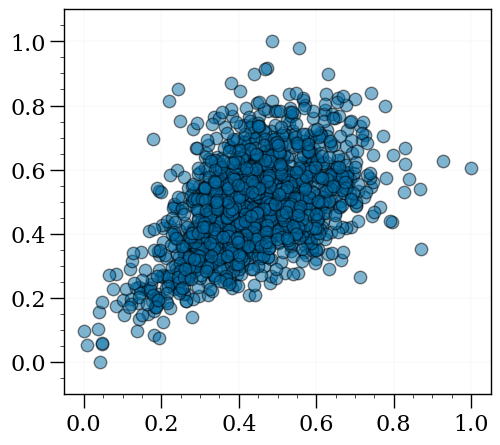

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

In [ ]:
model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:26<72:59:09, 26.28s/it]

Iter 0. Loss [[ 0.06583153  0.28143942 19.931568  ]]


  0%|          | 11/10000 [00:49<1:52:31,  1.48it/s]

Iter 10. Loss [[0.07132592 0.25543347 5.846824  ]]


  0%|          | 21/10000 [00:52<41:07,  4.04it/s]

Iter 20. Loss [[0.07391638 0.24653873 5.260351  ]]


  0%|          | 32/10000 [00:54<27:02,  6.14it/s]

Iter 30. Loss [[0.07687559 0.23837292 4.952685  ]]


  0%|          | 42/10000 [00:55<23:20,  7.11it/s]

Iter 40. Loss [[0.0792015  0.23346639 4.8662114 ]]


  1%|          | 52/10000 [00:57<23:25,  7.08it/s]

Iter 50. Loss [[0.07984073 0.23199637 4.824583  ]]


  1%|          | 62/10000 [00:58<22:53,  7.23it/s]

Iter 60. Loss [[0.07916867 0.23214181 4.7655616 ]]


  1%|          | 72/10000 [01:00<26:10,  6.32it/s]

Iter 70. Loss [[0.07930721 0.23038526 4.691464  ]]


  1%|          | 82/10000 [01:01<22:17,  7.41it/s]

Iter 80. Loss [[0.07881144 0.22869807 4.5858126 ]]


  1%|          | 92/10000 [01:02<22:19,  7.40it/s]

Iter 90. Loss [[0.07748508 0.22773622 4.3321934 ]]


  1%|          | 101/10000 [01:04<29:16,  5.64it/s]

Iter 100. Loss [[0.07673077 0.22681266 3.997721  ]]


  1%|          | 111/10000 [01:06<37:10,  4.43it/s]

Iter 110. Loss [[0.07570229 0.22570439 3.774847  ]]


  1%|          | 122/10000 [01:08<30:56,  5.32it/s]

Iter 120. Loss [[0.07502136 0.22431667 3.6908522 ]]


  1%|▏         | 132/10000 [01:10<23:13,  7.08it/s]

Iter 130. Loss [[0.07447408 0.2250125  3.7424169 ]]


  1%|▏         | 142/10000 [01:11<22:52,  7.18it/s]

Iter 140. Loss [[0.07422204 0.22853935 3.7644799 ]]


  2%|▏         | 152/10000 [01:13<22:29,  7.30it/s]

Iter 150. Loss [[0.0750891  0.22423103 3.7850645 ]]


  2%|▏         | 162/10000 [01:14<31:01,  5.28it/s]

Iter 160. Loss [[0.07583492 0.21777706 3.7985072 ]]


  2%|▏         | 172/10000 [01:15<22:22,  7.32it/s]

Iter 170. Loss [[0.07511652 0.2137811  3.7828796 ]]


  2%|▏         | 182/10000 [01:17<22:25,  7.30it/s]

Iter 180. Loss [[0.07415842 0.21154065 3.6989882 ]]


  2%|▏         | 192/10000 [01:18<23:46,  6.88it/s]

Iter 190. Loss [[0.07381451 0.2077589  3.5275838 ]]


  2%|▏         | 201/10000 [01:20<38:05,  4.29it/s]

Iter 200. Loss [[0.07393373 0.20241089 3.3673046 ]]


  2%|▏         | 212/10000 [01:23<33:22,  4.89it/s]

Iter 210. Loss [[0.07380813 0.19805598 3.2840176 ]]


  2%|▏         | 222/10000 [01:24<22:52,  7.12it/s]

Iter 220. Loss [[0.07369747 0.19654375 3.3236325 ]]


  2%|▏         | 232/10000 [01:26<22:28,  7.24it/s]

Iter 230. Loss [[0.07310729 0.19398336 3.1420724 ]]


  2%|▏         | 242/10000 [01:27<30:11,  5.39it/s]

Iter 240. Loss [[0.07309916 0.1919672  3.025084  ]]


  3%|▎         | 252/10000 [01:29<22:45,  7.14it/s]

Iter 250. Loss [[0.07456903 0.19628583 3.396473  ]]


  3%|▎         | 262/10000 [01:30<21:38,  7.50it/s]

Iter 260. Loss [[0.07832266 0.20621932 3.71525   ]]


  3%|▎         | 272/10000 [01:31<21:48,  7.43it/s]

Iter 270. Loss [[0.0840284  0.20607467 3.643228  ]]


  3%|▎         | 281/10000 [01:33<31:13,  5.19it/s]

Iter 280. Loss [[0.0963744  0.18145086 3.1462023 ]]


  3%|▎         | 291/10000 [01:35<37:29,  4.32it/s]

Iter 290. Loss [[0.10768391 0.16201004 3.0750558 ]]


  3%|▎         | 302/10000 [01:37<32:06,  5.03it/s]

Iter 300. Loss [[0.11081915 0.14681399 2.9749553 ]]


  3%|▎         | 312/10000 [01:39<23:16,  6.94it/s]

Iter 310. Loss [[0.1064     0.13521248 2.7141395 ]]


  3%|▎         | 322/10000 [01:40<22:07,  7.29it/s]

Iter 320. Loss [[0.10049567 0.13460225 2.4921424 ]]


  3%|▎         | 332/10000 [01:42<22:06,  7.29it/s]

Iter 330. Loss [[0.10102362 0.1295683  2.405485  ]]


  3%|▎         | 342/10000 [01:43<21:49,  7.37it/s]

Iter 340. Loss [[0.10588371 0.11106764 2.1919277 ]]


  4%|▎         | 352/10000 [01:44<22:02,  7.30it/s]

Iter 350. Loss [[0.11096694 0.09734446 1.8787389 ]]


  4%|▎         | 362/10000 [01:46<22:21,  7.18it/s]

Iter 360. Loss [[0.12119319 0.08373666 1.5691189 ]]


  4%|▎         | 372/10000 [01:47<21:33,  7.44it/s]

Iter 370. Loss [[0.12896575 0.08209437 1.4167569 ]]


  4%|▍         | 381/10000 [01:49<42:25,  3.78it/s]

Iter 380. Loss [[0.13879271 0.09344319 1.4025197 ]]


  4%|▍         | 391/10000 [01:51<37:15,  4.30it/s]

Iter 390. Loss [[0.15836282 0.09867906 1.0071098 ]]


  4%|▍         | 402/10000 [01:53<22:28,  7.12it/s]

Iter 400. Loss [[0.20340125 0.07423854 0.40336052]]


  4%|▍         | 412/10000 [01:54<22:04,  7.24it/s]

Iter 410. Loss [[0.20469637 0.05388482 0.1421455 ]]


  4%|▍         | 422/10000 [01:56<21:29,  7.43it/s]

Iter 420. Loss [[0.20121281 0.06209625 0.26837188]]


  4%|▍         | 432/10000 [01:57<29:14,  5.45it/s]

Iter 430. Loss [[0.22282812 0.05339984 0.12769286]]


  4%|▍         | 442/10000 [01:59<22:08,  7.19it/s]

Iter 440. Loss [[0.25632423 0.05969241 0.15635814]]


  5%|▍         | 452/10000 [02:00<21:39,  7.35it/s]

Iter 450. Loss [[0.24872287 0.04417389 0.3589279 ]]


  5%|▍         | 462/10000 [02:01<21:12,  7.49it/s]

Iter 460. Loss [[0.24570748 0.04343691 0.5366365 ]]


  5%|▍         | 471/10000 [02:03<43:02,  3.69it/s]

Iter 470. Loss [[0.24513833 0.04186503 0.6078472 ]]


  5%|▍         | 481/10000 [02:06<36:05,  4.40it/s]

Iter 480. Loss [[0.24587715 0.04119558 0.6214268 ]]


  5%|▍         | 492/10000 [02:07<23:15,  6.82it/s]

Iter 490. Loss [[0.24740945 0.04258564 0.57089114]]


  5%|▌         | 502/10000 [02:09<21:50,  7.25it/s]

Iter 500. Loss [[0.24759991 0.04367439 0.5182026 ]]


  5%|▌         | 512/10000 [02:10<21:48,  7.25it/s]

Iter 510. Loss [[0.24931562 0.04716926 0.45402974]]


  5%|▌         | 522/10000 [02:12<22:06,  7.15it/s]

Iter 520. Loss [[0.25136232 0.05821127 0.42084423]]


  5%|▌         | 532/10000 [02:13<22:35,  6.98it/s]

Iter 530. Loss [[0.25543186 0.11045785 0.1323612 ]]


  5%|▌         | 542/10000 [02:14<21:29,  7.33it/s]

Iter 540. Loss [[ 0.25736704  0.0676804  -0.05626081]]


  6%|▌         | 552/10000 [02:16<22:09,  7.11it/s]

Iter 550. Loss [[0.24553478 0.0654535  0.02624801]]


  6%|▌         | 561/10000 [02:17<32:06,  4.90it/s]

Iter 560. Loss [[ 0.2683158   0.08737261 -0.06468929]]


  6%|▌         | 571/10000 [02:20<35:40,  4.41it/s]

Iter 570. Loss [[0.22728467 0.11645213 0.9765454 ]]


  6%|▌         | 582/10000 [02:22<24:23,  6.43it/s]

Iter 580. Loss [[0.23415439 0.07925223 0.3991912 ]]


  6%|▌         | 592/10000 [02:23<22:37,  6.93it/s]

Iter 590. Loss [[0.22468242 0.04408497 0.45588395]]


  6%|▌         | 602/10000 [02:25<21:34,  7.26it/s]

Iter 600. Loss [[0.23193593 0.04255975 0.45141816]]


  6%|▌         | 612/10000 [02:26<21:47,  7.18it/s]

Iter 610. Loss [[0.24044597 0.04705608 0.39461732]]


  6%|▌         | 622/10000 [02:27<22:04,  7.08it/s]

Iter 620. Loss [[0.24532495 0.0497588  0.4279852 ]]


  6%|▋         | 632/10000 [02:29<21:31,  7.26it/s]

Iter 630. Loss [[0.2481447  0.05415857 0.44166276]]


  6%|▋         | 642/10000 [02:30<25:32,  6.11it/s]

Iter 640. Loss [[0.24941464 0.05345653 0.51260424]]


  7%|▋         | 651/10000 [02:32<31:01,  5.02it/s]

Iter 650. Loss [[0.2898456  0.12464445 0.12192941]]


  7%|▋         | 661/10000 [02:34<36:57,  4.21it/s]

Iter 660. Loss [[ 0.26405945  0.07901593 -0.08001243]]


  7%|▋         | 672/10000 [02:36<24:40,  6.30it/s]

Iter 670. Loss [[ 0.28116468  0.06314585 -0.21573107]]


  7%|▋         | 682/10000 [02:38<22:27,  6.92it/s]

Iter 680. Loss [[ 0.27633312  0.0538771  -0.2412262 ]]


  7%|▋         | 692/10000 [02:39<21:10,  7.32it/s]

Iter 690. Loss [[ 0.27874902  0.06891541 -0.31768376]]


  7%|▋         | 702/10000 [02:41<20:56,  7.40it/s]

Iter 700. Loss [[ 0.28543785  0.0683068  -0.43389818]]


  7%|▋         | 712/10000 [02:42<21:28,  7.21it/s]

Iter 710. Loss [[ 0.28422856  0.07391664 -0.5388912 ]]


  7%|▋         | 722/10000 [02:43<21:08,  7.31it/s]

Iter 720. Loss [[ 0.2865533   0.07163475 -0.56681275]]


  7%|▋         | 732/10000 [02:45<22:46,  6.78it/s]

Iter 730. Loss [[ 0.28819785  0.07282018 -0.5804545 ]]


  7%|▋         | 741/10000 [02:47<30:55,  4.99it/s]

Iter 740. Loss [[ 0.29005277  0.07422424 -0.57714605]]


  8%|▊         | 751/10000 [02:49<34:58,  4.41it/s]

Iter 750. Loss [[ 0.29177666  0.06977003 -0.55663663]]


  8%|▊         | 762/10000 [02:51<25:03,  6.14it/s]

Iter 760. Loss [[ 0.29372332  0.0672522  -0.5559942 ]]


  8%|▊         | 772/10000 [02:52<21:28,  7.16it/s]

Iter 770. Loss [[ 0.2964442   0.06795799 -0.5690625 ]]


  8%|▊         | 782/10000 [02:54<21:11,  7.25it/s]

Iter 780. Loss [[ 0.299392    0.06995016 -0.57649314]]


  8%|▊         | 792/10000 [02:55<20:51,  7.36it/s]

Iter 790. Loss [[ 0.30159682  0.07058397 -0.58295655]]


  8%|▊         | 802/10000 [02:56<21:19,  7.19it/s]

Iter 800. Loss [[ 0.3039936   0.07216344 -0.60835236]]


  8%|▊         | 811/10000 [02:58<21:15,  7.20it/s]

Iter 810. Loss [[ 0.30610812  0.07380532 -0.62514323]]


  8%|▊         | 822/10000 [02:59<20:52,  7.33it/s]

Iter 820. Loss [[ 0.30674833  0.07498565 -0.64852124]]


  8%|▊         | 831/10000 [03:01<23:48,  6.42it/s]

Iter 830. Loss [[ 0.30754724  0.07972814 -0.68296623]]


  8%|▊         | 841/10000 [03:03<35:21,  4.32it/s]

Iter 840. Loss [[ 0.3073171   0.08293375 -0.70115477]]


  9%|▊         | 852/10000 [03:05<26:19,  5.79it/s]

Iter 850. Loss [[ 0.30558753  0.0842201  -0.71078473]]


  9%|▊         | 862/10000 [03:07<21:12,  7.18it/s]

Iter 860. Loss [[ 0.30485466  0.08825155 -0.7231151 ]]


  9%|▊         | 872/10000 [03:08<21:03,  7.22it/s]

Iter 870. Loss [[ 0.30341157  0.08780216 -0.7199445 ]]


  9%|▉         | 882/10000 [03:10<23:00,  6.61it/s]

Iter 880. Loss [[ 0.30082527  0.08330127 -0.7117034 ]]


  9%|▉         | 892/10000 [03:11<20:53,  7.27it/s]

Iter 890. Loss [[ 0.30400923  0.09533478 -0.7445176 ]]


  9%|▉         | 902/10000 [03:12<20:39,  7.34it/s]

Iter 900. Loss [[ 0.30271974  0.09605617 -0.74040884]]


  9%|▉         | 912/10000 [03:14<20:36,  7.35it/s]

Iter 910. Loss [[ 0.29710922  0.08464739 -0.6564897 ]]


  9%|▉         | 922/10000 [03:15<23:17,  6.50it/s]

Iter 920. Loss [[ 0.298881    0.07578541 -0.5919087 ]]


  9%|▉         | 931/10000 [03:18<34:32,  4.37it/s]

Iter 930. Loss [[ 0.3033437   0.09044322 -0.6658991 ]]


  9%|▉         | 942/10000 [03:20<28:20,  5.33it/s]

Iter 940. Loss [[ 0.2989172   0.08747803 -0.65238816]]


 10%|▉         | 952/10000 [03:21<20:53,  7.22it/s]

Iter 950. Loss [[ 0.29819456  0.089441   -0.5849391 ]]


 10%|▉         | 962/10000 [03:23<20:55,  7.20it/s]

Iter 960. Loss [[ 0.29775622  0.07559211 -0.50617063]]


 10%|▉         | 972/10000 [03:24<20:34,  7.31it/s]

Iter 970. Loss [[ 0.30057043  0.08912775 -0.6279447 ]]


 10%|▉         | 982/10000 [03:25<20:46,  7.23it/s]

Iter 980. Loss [[ 0.29595566  0.07789095 -0.6374643 ]]


 10%|▉         | 992/10000 [03:27<20:39,  7.27it/s]

Iter 990. Loss [[ 0.2995631   0.08881122 -0.5680087 ]]


 10%|█         | 1002/10000 [03:28<28:04,  5.34it/s]

Iter 1000. Loss [[ 0.2998289   0.0767559  -0.46955135]]


 10%|█         | 1012/10000 [03:30<20:32,  7.30it/s]

Iter 1010. Loss [[ 0.2994807   0.07792196 -0.5264634 ]]


 10%|█         | 1021/10000 [03:32<33:07,  4.52it/s]

Iter 1020. Loss [[ 0.29876056  0.07822094 -0.63057685]]


 10%|█         | 1031/10000 [03:34<34:02,  4.39it/s]

Iter 1030. Loss [[ 0.30163428  0.08139947 -0.610816  ]]


 10%|█         | 1042/10000 [03:36<21:11,  7.05it/s]

Iter 1040. Loss [[ 0.30201724  0.076318   -0.5087815 ]]


 11%|█         | 1052/10000 [03:37<27:52,  5.35it/s]

Iter 1050. Loss [[ 0.29724234  0.07183895 -0.46528313]]


 11%|█         | 1062/10000 [03:38<20:24,  7.30it/s]

Iter 1060. Loss [[ 0.2966019   0.0766428  -0.55355495]]


 11%|█         | 1072/10000 [03:40<20:33,  7.24it/s]

Iter 1070. Loss [[ 0.29871044  0.07540032 -0.5550698 ]]


 11%|█         | 1082/10000 [03:41<20:47,  7.15it/s]

Iter 1080. Loss [[ 0.29811496  0.07454355 -0.47270772]]


 11%|█         | 1092/10000 [03:43<25:54,  5.73it/s]

Iter 1090. Loss [[ 0.29187682  0.06958781 -0.40663552]]


 11%|█         | 1102/10000 [03:44<20:08,  7.36it/s]

Iter 1100. Loss [[ 0.29059666  0.07174653 -0.46092194]]


 11%|█         | 1111/10000 [03:46<32:49,  4.51it/s]

Iter 1110. Loss [[ 0.29371712  0.07508662 -0.48173827]]


 11%|█         | 1121/10000 [03:48<34:13,  4.32it/s]

Iter 1120. Loss [[ 0.29433033  0.07307435 -0.44072616]]


 11%|█▏        | 1132/10000 [03:50<20:42,  7.14it/s]

Iter 1130. Loss [[ 0.29153207  0.07113398 -0.4186499 ]]


 11%|█▏        | 1142/10000 [03:51<20:11,  7.31it/s]

Iter 1140. Loss [[ 0.29192707  0.0700646  -0.44191462]]


 12%|█▏        | 1152/10000 [03:53<20:26,  7.21it/s]

Iter 1150. Loss [[ 0.2950802   0.0694273  -0.45567533]]


 12%|█▏        | 1162/10000 [03:54<19:46,  7.45it/s]

Iter 1160. Loss [[ 0.29553697  0.06661678 -0.42817333]]


 12%|█▏        | 1172/10000 [03:56<20:04,  7.33it/s]

Iter 1170. Loss [[ 0.29536724  0.06378339 -0.4365698 ]]


 12%|█▏        | 1182/10000 [03:57<20:10,  7.29it/s]

Iter 1180. Loss [[ 0.29878962  0.060043   -0.4659785 ]]


 12%|█▏        | 1192/10000 [03:58<21:12,  6.92it/s]

Iter 1190. Loss [[ 0.30482313  0.05964014 -0.49855366]]


 12%|█▏        | 1201/10000 [04:00<32:14,  4.55it/s]

Iter 1200. Loss [[ 0.309233   0.0647145 -0.5333758]]


 12%|█▏        | 1211/10000 [04:02<33:54,  4.32it/s]

Iter 1210. Loss [[ 0.3118904   0.08030385 -0.59133965]]


 12%|█▏        | 1222/10000 [04:05<22:13,  6.59it/s]

Iter 1220. Loss [[ 0.30863833  0.0944728  -0.6142115 ]]


 12%|█▏        | 1232/10000 [04:06<20:05,  7.27it/s]

Iter 1230. Loss [[ 0.29994696  0.092798   -0.5688155 ]]


 12%|█▏        | 1242/10000 [04:07<19:41,  7.41it/s]

Iter 1240. Loss [[ 0.2922018   0.09565309 -0.5184419 ]]


 13%|█▎        | 1252/10000 [04:09<23:34,  6.19it/s]

Iter 1250. Loss [[ 0.2850675   0.08221869 -0.46611953]]


 13%|█▎        | 1262/10000 [04:10<20:10,  7.22it/s]

Iter 1260. Loss [[ 0.2845884   0.0834514  -0.45998347]]


 13%|█▎        | 1272/10000 [04:12<20:14,  7.19it/s]

Iter 1270. Loss [[ 0.2837888   0.08535305 -0.46757275]]


 13%|█▎        | 1282/10000 [04:13<20:19,  7.15it/s]

Iter 1280. Loss [[ 0.28363362  0.08514879 -0.48214582]]


 13%|█▎        | 1291/10000 [04:15<31:00,  4.68it/s]

Iter 1290. Loss [[ 0.2849726   0.08751392 -0.4913958 ]]


 13%|█▎        | 1301/10000 [04:17<37:24,  3.88it/s]

Iter 1300. Loss [[ 0.284107    0.08906093 -0.49638426]]


 13%|█▎        | 1312/10000 [04:19<20:37,  7.02it/s]

Iter 1310. Loss [[ 0.28147846  0.08591862 -0.4955409 ]]


 13%|█▎        | 1322/10000 [04:20<19:43,  7.33it/s]

Iter 1320. Loss [[ 0.28185546  0.08456933 -0.49418595]]


 13%|█▎        | 1332/10000 [04:22<19:19,  7.48it/s]

Iter 1330. Loss [[ 0.28207272  0.08889799 -0.510448  ]]


 13%|█▎        | 1342/10000 [04:23<19:18,  7.48it/s]

Iter 1340. Loss [[ 0.2791198   0.08716664 -0.5053625 ]]


 14%|█▎        | 1352/10000 [04:24<19:48,  7.27it/s]

Iter 1350. Loss [[ 0.27709386  0.07952531 -0.49503264]]


 14%|█▎        | 1362/10000 [04:26<19:41,  7.31it/s]

Iter 1360. Loss [[ 0.27981457  0.08730515 -0.52529913]]


 14%|█▎        | 1372/10000 [04:27<19:39,  7.31it/s]

Iter 1370. Loss [[ 0.2759605   0.08571845 -0.515265  ]]


 14%|█▍        | 1381/10000 [04:29<26:07,  5.50it/s]

Iter 1380. Loss [[ 0.2717002   0.08020138 -0.5232207 ]]


 14%|█▍        | 1391/10000 [04:31<39:26,  3.64it/s]

Iter 1390. Loss [[ 0.27241695  0.07663727 -0.5197915 ]]


 14%|█▍        | 1402/10000 [04:33<22:50,  6.27it/s]

Iter 1400. Loss [[ 0.27172273  0.08515747 -0.49018347]]


 14%|█▍        | 1412/10000 [04:35<19:37,  7.29it/s]

Iter 1410. Loss [[ 0.2598504   0.07792987 -0.5416522 ]]


 14%|█▍        | 1422/10000 [04:36<19:34,  7.30it/s]

Iter 1420. Loss [[ 0.2509536   0.06576908 -0.55169135]]


 14%|█▍        | 1432/10000 [04:37<20:00,  7.13it/s]

Iter 1430. Loss [[ 0.26713613  0.03175489 -0.12690741]]


 14%|█▍        | 1442/10000 [04:39<20:15,  7.04it/s]

Iter 1440. Loss [[ 0.2545242   0.03599326 -0.22942708]]


 15%|█▍        | 1452/10000 [04:40<19:00,  7.50it/s]

Iter 1450. Loss [[ 0.24809575  0.03751521 -0.32157633]]


 15%|█▍        | 1462/10000 [04:42<19:51,  7.17it/s]

Iter 1460. Loss [[ 0.2506954   0.02362934 -0.13177092]]


 15%|█▍        | 1471/10000 [04:43<25:06,  5.66it/s]

Iter 1470. Loss [[ 0.25147215  0.02622332 -0.19323933]]


 15%|█▍        | 1481/10000 [04:45<32:09,  4.42it/s]

Iter 1480. Loss [[ 0.25526008  0.02643871 -0.30114537]]


 15%|█▍        | 1492/10000 [04:48<30:51,  4.60it/s]

Iter 1490. Loss [[ 0.26210007  0.02787193 -0.32653266]]


 15%|█▌        | 1502/10000 [04:49<19:44,  7.17it/s]

Iter 1500. Loss [[ 0.26721826  0.03423786 -0.3518823 ]]


 15%|█▌        | 1512/10000 [04:51<19:44,  7.17it/s]

Iter 1510. Loss [[ 0.27265173  0.04648545 -0.48048177]]


 15%|█▌        | 1522/10000 [04:52<19:27,  7.26it/s]

Iter 1520. Loss [[ 0.2729904   0.04789851 -0.4281578 ]]


 15%|█▌        | 1532/10000 [04:54<20:43,  6.81it/s]

Iter 1530. Loss [[ 0.2720842   0.04986465 -0.47922307]]


 15%|█▌        | 1542/10000 [04:55<19:22,  7.28it/s]

Iter 1540. Loss [[ 0.26892012  0.0470053  -0.42472953]]


 16%|█▌        | 1552/10000 [04:56<19:10,  7.35it/s]

Iter 1550. Loss [[ 0.26675195  0.04604857 -0.41863993]]


 16%|█▌        | 1561/10000 [04:58<20:36,  6.82it/s]

Iter 1560. Loss [[ 0.26743516  0.04994997 -0.41503838]]


 16%|█▌        | 1571/10000 [05:00<32:00,  4.39it/s]

Iter 1570. Loss [[ 0.2690271   0.05897589 -0.43542916]]


 16%|█▌        | 1582/10000 [05:02<35:06,  4.00it/s]

Iter 1580. Loss [[ 0.26929343  0.08694033 -0.6418137 ]]


 16%|█▌        | 1592/10000 [05:04<20:40,  6.78it/s]

Iter 1590. Loss [[ 0.26542372  0.09244549 -0.699465  ]]


 16%|█▌        | 1602/10000 [05:05<19:34,  7.15it/s]

Iter 1600. Loss [[ 0.26585698  0.0940989  -0.7712957 ]]


 16%|█▌        | 1612/10000 [05:07<19:22,  7.22it/s]

Iter 1610. Loss [[ 0.25937152  0.05347547 -0.5010037 ]]


 16%|█▌        | 1622/10000 [05:08<19:37,  7.12it/s]

Iter 1620. Loss [[ 0.26168278  0.05658782 -0.52407944]]


 16%|█▋        | 1632/10000 [05:09<19:05,  7.31it/s]

Iter 1630. Loss [[ 0.2608305   0.05984453 -0.548658  ]]


 16%|█▋        | 1642/10000 [05:11<19:54,  6.99it/s]

Iter 1640. Loss [[ 0.26113978  0.06840514 -0.6216821 ]]


 17%|█▋        | 1651/10000 [05:12<20:17,  6.86it/s]

Iter 1650. Loss [[ 0.2625006   0.07910256 -0.6690355 ]]


 17%|█▋        | 1661/10000 [05:14<32:08,  4.32it/s]

Iter 1660. Loss [[ 0.26103565  0.06980428 -0.61122406]]


 17%|█▋        | 1672/10000 [05:17<29:31,  4.70it/s]

Iter 1670. Loss [[ 0.26076952  0.06657112 -0.5633539 ]]


 17%|█▋        | 1682/10000 [05:18<19:30,  7.10it/s]

Iter 1680. Loss [[ 0.26460087  0.07061481 -0.6058856 ]]


 17%|█▋        | 1692/10000 [05:20<21:20,  6.49it/s]

Iter 1690. Loss [[ 0.25513864  0.0469855  -0.24934013]]


 17%|█▋        | 1702/10000 [05:21<19:22,  7.14it/s]

Iter 1700. Loss [[ 0.2588575   0.07367684 -0.5952545 ]]


 17%|█▋        | 1712/10000 [05:23<19:29,  7.09it/s]

Iter 1710. Loss [[ 0.25818792  0.06584603 -0.50758445]]


 17%|█▋        | 1722/10000 [05:24<18:24,  7.49it/s]

Iter 1720. Loss [[ 0.26017162  0.06916489 -0.55711555]]


 17%|█▋        | 1732/10000 [05:26<19:23,  7.11it/s]

Iter 1730. Loss [[ 0.2579825   0.06104708 -0.48651806]]


 17%|█▋        | 1741/10000 [05:27<19:25,  7.08it/s]

Iter 1740. Loss [[ 0.25985783  0.07361103 -0.5832657 ]]


 18%|█▊        | 1751/10000 [05:29<32:08,  4.28it/s]

Iter 1750. Loss [[ 0.2581162   0.05807633 -0.37060693]]


 18%|█▊        | 1762/10000 [05:32<27:55,  4.92it/s]

Iter 1760. Loss [[ 0.2579039   0.06557903 -0.5049458 ]]


 18%|█▊        | 1772/10000 [05:33<18:55,  7.25it/s]

Iter 1770. Loss [[ 0.25790003  0.06861157 -0.5241964 ]]


 18%|█▊        | 1782/10000 [05:35<22:23,  6.11it/s]

Iter 1780. Loss [[ 0.25868574  0.07156314 -0.541563  ]]


 18%|█▊        | 1792/10000 [05:36<19:04,  7.17it/s]

Iter 1790. Loss [[ 0.25781578  0.06869291 -0.519914  ]]


 18%|█▊        | 1802/10000 [05:37<18:48,  7.27it/s]

Iter 1800. Loss [[ 0.2571291   0.06484902 -0.5085043 ]]


 18%|█▊        | 1812/10000 [05:39<18:34,  7.35it/s]

Iter 1810. Loss [[ 0.25717416  0.06258293 -0.48361638]]


 18%|█▊        | 1822/10000 [05:40<18:37,  7.32it/s]

Iter 1820. Loss [[ 0.2564933   0.05901007 -0.4312343 ]]


 18%|█▊        | 1832/10000 [05:41<18:34,  7.33it/s]

Iter 1830. Loss [[ 0.25630975  0.05985721 -0.43938795]]


 18%|█▊        | 1841/10000 [05:43<31:07,  4.37it/s]

Iter 1840. Loss [[ 0.25645915  0.06196249 -0.4561004 ]]


 19%|█▊        | 1851/10000 [05:46<31:01,  4.38it/s]

Iter 1850. Loss [[ 0.25637206  0.06205314 -0.4559001 ]]


 19%|█▊        | 1862/10000 [05:47<19:41,  6.89it/s]

Iter 1860. Loss [[ 0.25636727  0.06262989 -0.45802867]]


 19%|█▊        | 1872/10000 [05:49<19:03,  7.11it/s]

Iter 1870. Loss [[ 0.25652727  0.06452609 -0.4756797 ]]


 19%|█▉        | 1882/10000 [05:50<18:25,  7.34it/s]

Iter 1880. Loss [[ 0.25687474  0.06627066 -0.4948272 ]]


 19%|█▉        | 1892/10000 [05:51<18:36,  7.26it/s]

Iter 1890. Loss [[ 0.25700855  0.06762847 -0.50697327]]


 19%|█▉        | 1902/10000 [05:53<23:24,  5.77it/s]

Iter 1900. Loss [[ 0.25705913  0.0672698  -0.51009727]]


 19%|█▉        | 1912/10000 [05:54<18:43,  7.20it/s]

Iter 1910. Loss [[ 0.25697678  0.06463045 -0.4902023 ]]


 19%|█▉        | 1922/10000 [05:56<18:30,  7.27it/s]

Iter 1920. Loss [[ 0.25688335  0.06290244 -0.47124848]]


 19%|█▉        | 1931/10000 [05:58<37:45,  3.56it/s]

Iter 1930. Loss [[ 0.2567455   0.06170625 -0.46691698]]


 19%|█▉        | 1941/10000 [06:00<30:58,  4.34it/s]

Iter 1940. Loss [[ 0.25677168  0.06237683 -0.46600318]]


 20%|█▉        | 1952/10000 [06:02<19:20,  6.94it/s]

Iter 1950. Loss [[ 0.25655106  0.06216676 -0.4688687 ]]


 20%|█▉        | 1962/10000 [06:03<18:26,  7.27it/s]

Iter 1960. Loss [[ 0.256757    0.06379948 -0.48060462]]


 20%|█▉        | 1972/10000 [06:05<19:27,  6.88it/s]

Iter 1970. Loss [[ 0.2573058   0.06789967 -0.5229851 ]]


 20%|█▉        | 1982/10000 [06:06<18:16,  7.31it/s]

Iter 1980. Loss [[ 0.25662434  0.06092876 -0.4599916 ]]


 20%|█▉        | 1992/10000 [06:07<18:46,  7.11it/s]

Iter 1990. Loss [[ 0.25710347  0.06132826 -0.46435523]]


 20%|██        | 2002/10000 [06:09<19:02,  7.00it/s]

Iter 2000. Loss [[ 0.25702506  0.06114123 -0.45992   ]]


 20%|██        | 2012/10000 [06:10<18:49,  7.07it/s]

Iter 2010. Loss [[ 0.25709346  0.06143133 -0.46697122]]


 20%|██        | 2021/10000 [06:12<29:56,  4.44it/s]

Iter 2020. Loss [[ 0.2577803   0.06321043 -0.49574724]]


 20%|██        | 2031/10000 [06:14<31:21,  4.24it/s]

Iter 2030. Loss [[ 0.2580691   0.06330254 -0.5018137 ]]


 20%|██        | 2042/10000 [06:16<19:29,  6.81it/s]

Iter 2040. Loss [[ 0.2587432   0.06561465 -0.5240619 ]]


 21%|██        | 2052/10000 [06:18<18:20,  7.22it/s]

Iter 2050. Loss [[ 0.25879377  0.06235223 -0.4907507 ]]


 21%|██        | 2062/10000 [06:19<18:33,  7.13it/s]

Iter 2060. Loss [[ 0.25934145  0.06585931 -0.53167635]]


 21%|██        | 2072/10000 [06:20<18:12,  7.26it/s]

Iter 2070. Loss [[ 0.25858507  0.06426454 -0.48181608]]


 21%|██        | 2082/10000 [06:22<18:06,  7.29it/s]

Iter 2080. Loss [[ 0.26035446  0.07456506 -0.59945697]]


 21%|██        | 2092/10000 [06:23<18:12,  7.24it/s]

Iter 2090. Loss [[ 0.2619413   0.09188731 -0.7380955 ]]


 21%|██        | 2102/10000 [06:25<18:09,  7.25it/s]

Iter 2100. Loss [[ 0.26141468  0.09445885 -0.761215  ]]


 21%|██        | 2111/10000 [06:26<24:00,  5.48it/s]

Iter 2110. Loss [[ 0.26091707  0.06006125 -0.5453666 ]]


 21%|██        | 2121/10000 [06:28<29:14,  4.49it/s]

Iter 2120. Loss [[0.25537857 0.04747693 0.09465577]]


 21%|██▏       | 2132/10000 [06:31<21:57,  5.97it/s]

Iter 2130. Loss [[ 0.26811105  0.06609888 -0.17669307]]


 21%|██▏       | 2142/10000 [06:32<17:46,  7.37it/s]

Iter 2140. Loss [[0.2471814  0.03849282 0.700734  ]]


 22%|██▏       | 2152/10000 [06:33<17:43,  7.38it/s]

Iter 2150. Loss [[0.19861591 0.07302668 1.1833228 ]]


 22%|██▏       | 2162/10000 [06:35<18:30,  7.06it/s]

Iter 2160. Loss [[0.19609559 0.07588089 1.2618201 ]]


 22%|██▏       | 2172/10000 [06:36<24:46,  5.26it/s]

Iter 2170. Loss [[0.20705362 0.07073076 1.193631  ]]


 22%|██▏       | 2182/10000 [06:38<18:16,  7.13it/s]

Iter 2180. Loss [[0.21639648 0.06708877 1.1384516 ]]


 22%|██▏       | 2192/10000 [06:39<18:10,  7.16it/s]

Iter 2190. Loss [[0.2221454  0.06404336 1.0981547 ]]


 22%|██▏       | 2201/10000 [06:40<21:00,  6.19it/s]

Iter 2200. Loss [[0.22551142 0.06139707 1.0505816 ]]


 22%|██▏       | 2211/10000 [06:43<32:42,  3.97it/s]

Iter 2210. Loss [[0.22784363 0.05893696 1.0128425 ]]


 22%|██▏       | 2222/10000 [06:45<22:51,  5.67it/s]

Iter 2220. Loss [[0.22954857 0.05672615 0.9707918 ]]


 22%|██▏       | 2232/10000 [06:46<18:05,  7.15it/s]

Iter 2230. Loss [[0.23062798 0.0546042  0.93415266]]


 22%|██▏       | 2242/10000 [06:48<17:33,  7.37it/s]

Iter 2240. Loss [[0.23117453 0.05261708 0.90402734]]


 23%|██▎       | 2252/10000 [06:49<18:17,  7.06it/s]

Iter 2250. Loss [[0.2308468  0.05041725 0.88045734]]


 23%|██▎       | 2262/10000 [06:51<18:12,  7.08it/s]

Iter 2260. Loss [[0.2306008  0.0482771  0.85424554]]


 23%|██▎       | 2272/10000 [06:52<17:52,  7.20it/s]

Iter 2270. Loss [[0.23171675 0.04653497 0.8234003 ]]


 23%|██▎       | 2282/10000 [06:54<17:43,  7.26it/s]

Iter 2280. Loss [[0.23230945 0.04493839 0.7968625 ]]


 23%|██▎       | 2291/10000 [06:55<18:29,  6.95it/s]

Iter 2290. Loss [[0.23179582 0.04328743 0.77626634]]


 23%|██▎       | 2301/10000 [06:57<30:23,  4.22it/s]

Iter 2300. Loss [[0.23078786 0.04162302 0.75970846]]


 23%|██▎       | 2312/10000 [07:00<26:45,  4.79it/s]

Iter 2310. Loss [[0.22993878 0.04008359 0.7409525 ]]


 23%|██▎       | 2321/10000 [07:01<18:10,  7.04it/s]

Iter 2320. Loss [[0.22938095 0.03871035 0.7234604 ]]


 23%|██▎       | 2332/10000 [07:03<18:07,  7.05it/s]

Iter 2330. Loss [[0.22889484 0.03748403 0.7047677 ]]


 23%|██▎       | 2342/10000 [07:04<17:53,  7.13it/s]

Iter 2340. Loss [[0.22827104 0.036333   0.6888769 ]]


 24%|██▎       | 2352/10000 [07:05<17:28,  7.29it/s]

Iter 2350. Loss [[0.22749458 0.03517096 0.6746375 ]]


 24%|██▎       | 2362/10000 [07:07<18:06,  7.03it/s]

Iter 2360. Loss [[0.22670414 0.03409644 0.6600151 ]]


 24%|██▎       | 2372/10000 [07:08<17:25,  7.30it/s]

Iter 2370. Loss [[0.22598487 0.03310097 0.6472209 ]]


 24%|██▍       | 2381/10000 [07:09<18:56,  6.70it/s]

Iter 2380. Loss [[0.22531635 0.03216543 0.6334078 ]]


 24%|██▍       | 2391/10000 [07:12<28:10,  4.50it/s]

Iter 2390. Loss [[0.22471622 0.03130016 0.62310714]]


 24%|██▍       | 2401/10000 [07:14<29:35,  4.28it/s]

Iter 2400. Loss [[0.2241347  0.0305016  0.61041033]]


 24%|██▍       | 2412/10000 [07:16<17:53,  7.07it/s]

Iter 2410. Loss [[0.2234968  0.02977426 0.5987152 ]]


 24%|██▍       | 2422/10000 [07:17<17:04,  7.40it/s]

Iter 2420. Loss [[0.22287026 0.02909282 0.5877135 ]]


 24%|██▍       | 2432/10000 [07:19<19:51,  6.35it/s]

Iter 2430. Loss [[0.22227882 0.02847969 0.57721114]]


 24%|██▍       | 2442/10000 [07:20<17:11,  7.33it/s]

Iter 2440. Loss [[0.22164452 0.0279186  0.56684047]]


 25%|██▍       | 2452/10000 [07:21<17:24,  7.23it/s]

Iter 2450. Loss [[0.22101983 0.02742518 0.55658555]]


 25%|██▍       | 2462/10000 [07:23<17:17,  7.27it/s]

Iter 2460. Loss [[0.2204128  0.02699185 0.54730725]]


 25%|██▍       | 2472/10000 [07:24<18:21,  6.83it/s]

Iter 2470. Loss [[0.21978128 0.02661631 0.5405784 ]]


 25%|██▍       | 2481/10000 [07:26<28:35,  4.38it/s]

Iter 2480. Loss [[0.21912609 0.02631598 0.53120494]]


 25%|██▍       | 2491/10000 [07:29<29:54,  4.18it/s]

Iter 2490. Loss [[0.21785273 0.02593224 0.5230203 ]]


 25%|██▌       | 2502/10000 [07:30<17:33,  7.12it/s]

Iter 2500. Loss [[0.21827415 0.02540161 0.51683366]]


 25%|██▌       | 2512/10000 [07:32<24:08,  5.17it/s]

Iter 2510. Loss [[0.2195016  0.02589843 0.5051602 ]]


 25%|██▌       | 2522/10000 [07:33<17:12,  7.24it/s]

Iter 2520. Loss [[0.21639666 0.02523371 0.49964347]]


 25%|██▌       | 2532/10000 [07:35<17:47,  6.99it/s]

Iter 2530. Loss [[0.21624528 0.02535335 0.4900426 ]]


 25%|██▌       | 2542/10000 [07:36<17:08,  7.25it/s]

Iter 2540. Loss [[0.21538869 0.02526203 0.48048925]]


 26%|██▌       | 2552/10000 [07:37<16:59,  7.31it/s]

Iter 2550. Loss [[0.2151509  0.02516858 0.4746574 ]]


 26%|██▌       | 2562/10000 [07:39<17:15,  7.18it/s]

Iter 2560. Loss [[0.21494353 0.02515963 0.4683404 ]]


 26%|██▌       | 2571/10000 [07:41<27:51,  4.45it/s]

Iter 2570. Loss [[0.21428423 0.02515899 0.46203116]]


 26%|██▌       | 2581/10000 [07:43<27:43,  4.46it/s]

Iter 2580. Loss [[0.21365666 0.02520551 0.45738876]]


 26%|██▌       | 2592/10000 [07:45<17:40,  6.99it/s]

Iter 2590. Loss [[0.21310356 0.02528464 0.45239753]]


 26%|██▌       | 2602/10000 [07:46<17:24,  7.08it/s]

Iter 2600. Loss [[0.21273576 0.02538493 0.44596952]]


 26%|██▌       | 2612/10000 [07:47<17:06,  7.20it/s]

Iter 2610. Loss [[0.2123869  0.02549888 0.44121712]]


 26%|██▌       | 2622/10000 [07:49<16:47,  7.33it/s]

Iter 2620. Loss [[0.21206775 0.02565141 0.4364846 ]]


 26%|██▋       | 2632/10000 [07:50<16:40,  7.36it/s]

Iter 2630. Loss [[0.21178186 0.02577026 0.4333535 ]]


 26%|██▋       | 2642/10000 [07:52<17:06,  7.17it/s]

Iter 2640. Loss [[0.21147972 0.0259063  0.42815515]]


 27%|██▋       | 2652/10000 [07:53<16:56,  7.23it/s]

Iter 2650. Loss [[0.21122009 0.02604614 0.42472932]]


 27%|██▋       | 2661/10000 [07:54<23:12,  5.27it/s]

Iter 2660. Loss [[0.21091786 0.02616375 0.42061555]]


 27%|██▋       | 2671/10000 [07:57<27:53,  4.38it/s]

Iter 2670. Loss [[0.21059564 0.02632159 0.41680223]]


 27%|██▋       | 2682/10000 [07:59<21:53,  5.57it/s]

Iter 2680. Loss [[0.21012244 0.02638429 0.4149335 ]]


 27%|██▋       | 2692/10000 [08:00<16:51,  7.22it/s]

Iter 2690. Loss [[0.2094725 0.0264813 0.4124633]]


 27%|██▋       | 2702/10000 [08:02<16:59,  7.16it/s]

Iter 2700. Loss [[0.20889908 0.02659079 0.40795296]]


 27%|██▋       | 2712/10000 [08:03<16:51,  7.21it/s]

Iter 2710. Loss [[0.20880952 0.02657861 0.40564677]]


 27%|██▋       | 2722/10000 [08:04<16:21,  7.42it/s]

Iter 2720. Loss [[0.21064064 0.02622309 0.4068089 ]]


 27%|██▋       | 2732/10000 [08:06<19:46,  6.13it/s]

Iter 2730. Loss [[0.21848294 0.02391025 0.45113394]]


 27%|██▋       | 2742/10000 [08:07<16:55,  7.14it/s]

Iter 2740. Loss [[0.22642341 0.02937136 0.3894671 ]]


 28%|██▊       | 2751/10000 [08:09<22:06,  5.47it/s]

Iter 2750. Loss [[0.2182534  0.02660484 0.39125544]]


 28%|██▊       | 2761/10000 [08:11<27:47,  4.34it/s]

Iter 2760. Loss [[0.21569222 0.02695506 0.38115734]]


 28%|██▊       | 2772/10000 [08:14<20:13,  5.96it/s]

Iter 2770. Loss [[0.21261111 0.02681518 0.3790704 ]]


 28%|██▊       | 2782/10000 [08:15<16:33,  7.27it/s]

Iter 2780. Loss [[0.20983893 0.02653692 0.37681088]]


 28%|██▊       | 2792/10000 [08:16<17:11,  6.99it/s]

Iter 2790. Loss [[0.20881383 0.02664353 0.37347916]]


 28%|██▊       | 2801/10000 [08:18<16:37,  7.22it/s]

Iter 2800. Loss [[0.20749132 0.02637758 0.3666617 ]]


 28%|██▊       | 2812/10000 [08:19<16:41,  7.18it/s]

Iter 2810. Loss [[0.20791247 0.02606613 0.36580452]]


 28%|██▊       | 2822/10000 [08:21<16:41,  7.16it/s]

Iter 2820. Loss [[0.21096791 0.02444839 0.38044304]]


 28%|██▊       | 2832/10000 [08:22<16:35,  7.20it/s]

Iter 2830. Loss [[0.21619114 0.02721813 0.3491722 ]]


 28%|██▊       | 2841/10000 [08:23<19:10,  6.22it/s]

Iter 2840. Loss [[0.21245879 0.02629115 0.34786946]]


 29%|██▊       | 2851/10000 [08:26<27:27,  4.34it/s]

Iter 2850. Loss [[0.20965521 0.02583749 0.3410064 ]]


 29%|██▊       | 2862/10000 [08:28<23:55,  4.97it/s]

Iter 2860. Loss [[0.20888723 0.02610123 0.33381745]]


 29%|██▊       | 2872/10000 [08:29<16:18,  7.28it/s]

Iter 2870. Loss [[0.20698528 0.02566214 0.32674325]]


 29%|██▉       | 2882/10000 [08:31<16:36,  7.14it/s]

Iter 2880. Loss [[0.20781167 0.02515208 0.32022354]]


 29%|██▉       | 2891/10000 [08:32<16:30,  7.18it/s]

Iter 2890. Loss [[0.20929666 0.02582822 0.30669442]]


 29%|██▉       | 2902/10000 [08:34<17:06,  6.92it/s]

Iter 2900. Loss [[0.20767628 0.0254243  0.30007923]]


 29%|██▉       | 2912/10000 [08:35<16:33,  7.14it/s]

Iter 2910. Loss [[0.20725998 0.02525421 0.28836498]]


 29%|██▉       | 2922/10000 [08:36<16:12,  7.28it/s]

Iter 2920. Loss [[0.20723881 0.02516493 0.2732064 ]]


 29%|██▉       | 2932/10000 [08:38<16:46,  7.02it/s]

Iter 2930. Loss [[0.20706372 0.0247238  0.2588718 ]]


 29%|██▉       | 2941/10000 [08:40<26:24,  4.45it/s]

Iter 2940. Loss [[0.20730336 0.02451746 0.23993076]]


 30%|██▉       | 2951/10000 [08:42<27:02,  4.35it/s]

Iter 2950. Loss [[0.20805554 0.02481489 0.1852446 ]]


 30%|██▉       | 2962/10000 [08:44<16:22,  7.16it/s]

Iter 2960. Loss [[0.21155213 0.02648359 0.08016945]]


 30%|██▉       | 2972/10000 [08:45<16:28,  7.11it/s]

Iter 2970. Loss [[0.2225097  0.02686693 0.04856534]]


 30%|██▉       | 2982/10000 [08:47<19:04,  6.13it/s]

Iter 2980. Loss [[0.22332759 0.0271221  0.07311375]]


 30%|██▉       | 2992/10000 [08:48<16:21,  7.14it/s]

Iter 2990. Loss [[0.22374728 0.02827864 0.0297029 ]]


 30%|███       | 3002/10000 [08:50<16:12,  7.19it/s]

Iter 3000. Loss [[0.22897355 0.03044526 0.00987837]]


 30%|███       | 3012/10000 [08:51<16:25,  7.09it/s]

Iter 3010. Loss [[0.23443978 0.02903695 0.08741992]]


 30%|███       | 3022/10000 [08:53<15:46,  7.37it/s]

Iter 3020. Loss [[0.23312767 0.02966698 0.04449122]]


 30%|███       | 3031/10000 [08:55<26:50,  4.33it/s]

Iter 3030. Loss [[ 0.23507206  0.0316801  -0.06358907]]


 30%|███       | 3041/10000 [08:57<26:15,  4.42it/s]

Iter 3040. Loss [[0.24230829 0.02895449 0.00528893]]


 31%|███       | 3052/10000 [08:59<16:57,  6.83it/s]

Iter 3050. Loss [[0.24439022 0.03215774 0.17095801]]


 31%|███       | 3062/10000 [09:00<16:26,  7.03it/s]

Iter 3060. Loss [[0.23190641 0.02397808 0.1409666 ]]


 31%|███       | 3072/10000 [09:01<15:59,  7.22it/s]

Iter 3070. Loss [[0.2336461  0.02412    0.07057816]]


 31%|███       | 3082/10000 [09:03<16:02,  7.19it/s]

Iter 3080. Loss [[0.24150075 0.02764636 0.00080636]]


 31%|███       | 3092/10000 [09:04<16:21,  7.04it/s]

Iter 3090. Loss [[ 0.24781859  0.03368918 -0.09075365]]


 31%|███       | 3102/10000 [09:06<16:07,  7.13it/s]

Iter 3100. Loss [[ 0.25124648  0.03772108 -0.16016829]]


 31%|███       | 3112/10000 [09:07<16:07,  7.12it/s]

Iter 3110. Loss [[ 0.2511747   0.0369192  -0.26633394]]


 31%|███       | 3121/10000 [09:09<26:12,  4.37it/s]

Iter 3120. Loss [[ 0.2551416   0.04262346 -0.3645893 ]]


 31%|███▏      | 3131/10000 [09:11<26:25,  4.33it/s]

Iter 3130. Loss [[ 0.26436928  0.05566918 -0.44039053]]


 31%|███▏      | 3142/10000 [09:13<16:40,  6.85it/s]

Iter 3140. Loss [[ 0.27021143  0.06875812 -0.5092151 ]]


 32%|███▏      | 3152/10000 [09:15<16:08,  7.07it/s]

Iter 3150. Loss [[ 0.27075985  0.07022615 -0.48367214]]


 32%|███▏      | 3162/10000 [09:16<15:40,  7.27it/s]

Iter 3160. Loss [[ 0.27137324  0.07191287 -0.49690482]]


 32%|███▏      | 3172/10000 [09:17<16:29,  6.90it/s]

Iter 3170. Loss [[ 0.2765111   0.05908919 -0.30793616]]


 32%|███▏      | 3182/10000 [09:19<15:32,  7.31it/s]

Iter 3180. Loss [[ 0.27204877  0.06199935 -0.41087532]]


 32%|███▏      | 3192/10000 [09:20<15:23,  7.38it/s]

Iter 3190. Loss [[ 0.26757935  0.06281449 -0.46433875]]


 32%|███▏      | 3202/10000 [09:22<19:55,  5.69it/s]

Iter 3200. Loss [[ 0.2633489   0.05706062 -0.4998158 ]]


 32%|███▏      | 3211/10000 [09:24<24:41,  4.58it/s]

Iter 3210. Loss [[ 0.2628103   0.0562295  -0.51953363]]


 32%|███▏      | 3221/10000 [09:26<26:05,  4.33it/s]

Iter 3220. Loss [[ 0.26525277  0.0533649  -0.54570127]]


 32%|███▏      | 3232/10000 [09:28<16:44,  6.74it/s]

Iter 3230. Loss [[ 0.2679463   0.05098781 -0.5753207 ]]


 32%|███▏      | 3242/10000 [09:29<19:19,  5.83it/s]

Iter 3240. Loss [[ 0.27207083  0.05994822 -0.6229524 ]]


 33%|███▎      | 3252/10000 [09:31<16:05,  6.99it/s]

Iter 3250. Loss [[ 0.27295792  0.05936006 -0.6381003 ]]


 33%|███▎      | 3262/10000 [09:32<15:25,  7.28it/s]

Iter 3260. Loss [[ 0.2734726   0.06078056 -0.65081525]]


 33%|███▎      | 3272/10000 [09:34<15:16,  7.34it/s]

Iter 3270. Loss [[ 0.27498704  0.06951577 -0.6904361 ]]


 33%|███▎      | 3282/10000 [09:35<15:51,  7.06it/s]

Iter 3280. Loss [[ 0.2758089   0.0693009  -0.69908226]]


 33%|███▎      | 3292/10000 [09:36<15:15,  7.33it/s]

Iter 3290. Loss [[ 0.27681828  0.06685307 -0.69683725]]


 33%|███▎      | 3301/10000 [09:38<23:43,  4.71it/s]

Iter 3300. Loss [[ 0.27860957  0.07191149 -0.7096344 ]]


 33%|███▎      | 3311/10000 [09:41<32:33,  3.42it/s]

Iter 3310. Loss [[ 0.27876773  0.0695905  -0.68588287]]


 33%|███▎      | 3322/10000 [09:42<16:33,  6.72it/s]

Iter 3320. Loss [[ 0.2771794   0.05764538 -0.64599085]]


 33%|███▎      | 3332/10000 [09:44<15:09,  7.33it/s]

Iter 3330. Loss [[ 0.28003332  0.06809404 -0.68756235]]


 33%|███▎      | 3342/10000 [09:45<15:55,  6.97it/s]

Iter 3340. Loss [[ 0.28111196  0.06532592 -0.66664886]]


 34%|███▎      | 3352/10000 [09:47<15:14,  7.27it/s]

Iter 3350. Loss [[ 0.28219432  0.062907   -0.65634656]]


 34%|███▎      | 3362/10000 [09:48<15:57,  6.93it/s]

Iter 3360. Loss [[ 0.28348738  0.06403434 -0.6443262 ]]


 34%|███▎      | 3372/10000 [09:50<15:18,  7.21it/s]

Iter 3370. Loss [[ 0.28925237  0.07186998 -0.6038759 ]]


 34%|███▍      | 3382/10000 [09:51<15:29,  7.12it/s]

Iter 3380. Loss [[ 0.2931935   0.08417914 -0.57452625]]


 34%|███▍      | 3391/10000 [09:53<27:11,  4.05it/s]

Iter 3390. Loss [[ 0.28516057  0.05899093 -0.59671557]]


 34%|███▍      | 3401/10000 [09:55<24:53,  4.42it/s]

Iter 3400. Loss [[ 0.28307512  0.06741603 -0.67099965]]


 34%|███▍      | 3412/10000 [09:57<16:24,  6.69it/s]

Iter 3410. Loss [[ 0.28353366  0.08134208 -0.73045206]]


 34%|███▍      | 3422/10000 [09:58<15:04,  7.27it/s]

Iter 3420. Loss [[ 0.2867435   0.11829785 -0.6990441 ]]


 34%|███▍      | 3432/10000 [10:00<15:09,  7.22it/s]

Iter 3430. Loss [[ 0.28167513  0.10796478 -0.70133966]]


 34%|███▍      | 3442/10000 [10:01<16:07,  6.78it/s]

Iter 3440. Loss [[ 0.2788805   0.09674708 -0.6355459 ]]


 35%|███▍      | 3452/10000 [10:03<15:12,  7.17it/s]

Iter 3450. Loss [[ 0.2770167   0.08818454 -0.6138052 ]]


 35%|███▍      | 3462/10000 [10:04<15:21,  7.10it/s]

Iter 3460. Loss [[ 0.27611133  0.08078999 -0.5986754 ]]


 35%|███▍      | 3472/10000 [10:06<14:58,  7.26it/s]

Iter 3470. Loss [[ 0.2743427   0.06963471 -0.5795773 ]]


 35%|███▍      | 3481/10000 [10:07<22:04,  4.92it/s]

Iter 3480. Loss [[ 0.2696607   0.04827799 -0.53881305]]


 35%|███▍      | 3491/10000 [10:09<25:05,  4.32it/s]

Iter 3490. Loss [[ 0.27298924  0.05274795 -0.5747303 ]]


 35%|███▌      | 3502/10000 [10:12<17:17,  6.26it/s]

Iter 3500. Loss [[ 0.27562118  0.05665084 -0.60147125]]


 35%|███▌      | 3512/10000 [10:13<15:15,  7.09it/s]

Iter 3510. Loss [[ 0.2805185   0.07205877 -0.66133577]]


 35%|███▌      | 3522/10000 [10:14<15:06,  7.14it/s]

Iter 3520. Loss [[ 0.27972633  0.06193176 -0.6246019 ]]


 35%|███▌      | 3532/10000 [10:16<17:48,  6.05it/s]

Iter 3530. Loss [[ 0.28121996  0.06397802 -0.6364016 ]]


 35%|███▌      | 3542/10000 [10:17<14:59,  7.18it/s]

Iter 3540. Loss [[ 0.28156972  0.0617586  -0.62347466]]


 36%|███▌      | 3552/10000 [10:19<15:00,  7.16it/s]

Iter 3550. Loss [[ 0.2829629   0.06207794 -0.62105036]]


 36%|███▌      | 3562/10000 [10:20<14:44,  7.28it/s]

Iter 3560. Loss [[ 0.28556222  0.06914404 -0.6450952 ]]


 36%|███▌      | 3571/10000 [10:21<19:39,  5.45it/s]

Iter 3570. Loss [[ 0.28618273  0.06641375 -0.63630956]]


 36%|███▌      | 3581/10000 [10:24<25:01,  4.27it/s]

Iter 3580. Loss [[ 0.28775758  0.06947839 -0.6540203 ]]


 36%|███▌      | 3592/10000 [10:26<17:30,  6.10it/s]

Iter 3590. Loss [[ 0.28885055  0.0705862  -0.6658698 ]]


 36%|███▌      | 3602/10000 [10:28<15:14,  7.00it/s]

Iter 3600. Loss [[ 0.29234263  0.0996455  -0.6815946 ]]


 36%|███▌      | 3612/10000 [10:29<15:13,  6.99it/s]

Iter 3610. Loss [[ 0.2902209   0.10580263 -0.65820694]]


 36%|███▌      | 3622/10000 [10:30<14:59,  7.09it/s]

Iter 3620. Loss [[ 0.28496107  0.09505452 -0.6314303 ]]


 36%|███▋      | 3632/10000 [10:32<15:01,  7.06it/s]

Iter 3630. Loss [[ 0.2804594   0.08024654 -0.65246683]]


 36%|███▋      | 3642/10000 [10:33<14:25,  7.35it/s]

Iter 3640. Loss [[ 0.27907163  0.06516024 -0.65400803]]


 37%|███▋      | 3652/10000 [10:35<14:58,  7.07it/s]

Iter 3650. Loss [[ 0.27945969  0.05628572 -0.63065374]]


 37%|███▋      | 3661/10000 [10:36<25:13,  4.19it/s]

Iter 3660. Loss [[ 0.28016207  0.04882212 -0.6025282 ]]


 37%|███▋      | 3671/10000 [10:39<24:31,  4.30it/s]

Iter 3670. Loss [[ 0.28281993  0.05174527 -0.62182206]]


 37%|███▋      | 3682/10000 [10:41<17:42,  5.95it/s]

Iter 3680. Loss [[ 0.28619248  0.05886668 -0.6515204 ]]


 37%|███▋      | 3692/10000 [10:42<14:54,  7.05it/s]

Iter 3690. Loss [[ 0.28866976  0.06370084 -0.60995305]]


 37%|███▋      | 3702/10000 [10:44<14:42,  7.14it/s]

Iter 3700. Loss [[ 0.29031077  0.07913845 -0.5882222 ]]


 37%|███▋      | 3712/10000 [10:45<15:55,  6.58it/s]

Iter 3710. Loss [[ 0.28478912  0.07813559 -0.5918143 ]]


 37%|███▋      | 3722/10000 [10:47<14:25,  7.25it/s]

Iter 3720. Loss [[ 0.28147784  0.08299834 -0.61172366]]


 37%|███▋      | 3732/10000 [10:48<14:18,  7.30it/s]

Iter 3730. Loss [[ 0.27681595  0.0787806  -0.62312824]]


 37%|███▋      | 3742/10000 [10:49<14:45,  7.06it/s]

Iter 3740. Loss [[ 0.27509597  0.07827602 -0.62177867]]


 38%|███▊      | 3751/10000 [10:51<18:29,  5.63it/s]

Iter 3750. Loss [[ 0.27605027  0.07522071 -0.60205084]]


 38%|███▊      | 3761/10000 [10:53<24:08,  4.31it/s]

Iter 3760. Loss [[ 0.27572668  0.07405718 -0.5732708 ]]


 38%|███▊      | 3772/10000 [10:55<20:22,  5.09it/s]

Iter 3770. Loss [[ 0.27398232  0.07120528 -0.54166424]]


 38%|███▊      | 3782/10000 [10:57<14:35,  7.10it/s]

Iter 3780. Loss [[ 0.27243626  0.07118088 -0.5415232 ]]


 38%|███▊      | 3792/10000 [10:58<14:16,  7.25it/s]

Iter 3790. Loss [[ 0.27307874  0.07209034 -0.53446645]]


 38%|███▊      | 3802/10000 [11:00<14:22,  7.18it/s]

Iter 3800. Loss [[ 0.27303177  0.07292259 -0.5333686 ]]


 38%|███▊      | 3812/10000 [11:01<14:15,  7.24it/s]

Iter 3810. Loss [[ 0.27280572  0.07199255 -0.5233531 ]]


 38%|███▊      | 3822/10000 [11:02<14:15,  7.22it/s]

Iter 3820. Loss [[ 0.2722477   0.07177284 -0.5211151 ]]


 38%|███▊      | 3832/10000 [11:04<14:34,  7.05it/s]

Iter 3830. Loss [[ 0.27223477  0.07143561 -0.5215987 ]]


 38%|███▊      | 3842/10000 [11:05<14:03,  7.30it/s]

Iter 3840. Loss [[ 0.27243865  0.07087601 -0.5095808 ]]


 39%|███▊      | 3851/10000 [11:07<22:27,  4.56it/s]

Iter 3850. Loss [[ 0.2724091  0.0700077 -0.4894619]]


 39%|███▊      | 3861/10000 [11:09<23:53,  4.28it/s]

Iter 3860. Loss [[ 0.27237308  0.06913112 -0.47875497]]


 39%|███▊      | 3872/10000 [11:11<16:11,  6.31it/s]

Iter 3870. Loss [[ 0.27202287  0.06906061 -0.46339238]]


 39%|███▉      | 3882/10000 [11:13<14:18,  7.13it/s]

Iter 3880. Loss [[ 0.2721701   0.06870282 -0.44840717]]


 39%|███▉      | 3892/10000 [11:14<14:23,  7.07it/s]

Iter 3890. Loss [[ 0.26950827  0.06276464 -0.4091145 ]]


 39%|███▉      | 3902/10000 [11:15<14:06,  7.20it/s]

Iter 3900. Loss [[ 0.26927033  0.06296515 -0.41639987]]


 39%|███▉      | 3912/10000 [11:17<13:47,  7.35it/s]

Iter 3910. Loss [[ 0.26889065  0.06358495 -0.4165528 ]]


 39%|███▉      | 3922/10000 [11:18<19:29,  5.20it/s]

Iter 3920. Loss [[ 0.26743934  0.06110213 -0.38995844]]


 39%|███▉      | 3932/10000 [11:20<14:20,  7.05it/s]

Iter 3930. Loss [[ 0.268367    0.05795601 -0.36023158]]


 39%|███▉      | 3941/10000 [11:22<23:03,  4.38it/s]

Iter 3940. Loss [[ 0.26579398  0.06443484 -0.3948741 ]]


 40%|███▉      | 3951/10000 [11:24<23:16,  4.33it/s]

Iter 3950. Loss [[ 0.2650467   0.06247815 -0.39854252]]


 40%|███▉      | 3962/10000 [11:26<18:21,  5.48it/s]

Iter 3960. Loss [[ 0.2646304   0.06264187 -0.40552375]]


 40%|███▉      | 3972/10000 [11:28<14:40,  6.85it/s]

Iter 3970. Loss [[ 0.26425007  0.06462813 -0.4250424 ]]


 40%|███▉      | 3982/10000 [11:29<14:13,  7.05it/s]

Iter 3980. Loss [[ 0.2639719  0.0662699 -0.4454025]]


 40%|███▉      | 3992/10000 [11:30<14:02,  7.13it/s]

Iter 3990. Loss [[ 0.2642439   0.06883549 -0.47650027]]


 40%|████      | 4002/10000 [11:32<13:59,  7.14it/s]

Iter 4000. Loss [[ 0.26484057  0.07066794 -0.49608395]]


 40%|████      | 4012/10000 [11:33<13:55,  7.17it/s]

Iter 4010. Loss [[ 0.26480347  0.07167833 -0.50383383]]


 40%|████      | 4022/10000 [11:35<13:55,  7.16it/s]

Iter 4020. Loss [[ 0.26435247  0.0712754  -0.50484496]]


 40%|████      | 4031/10000 [11:36<22:12,  4.48it/s]

Iter 4030. Loss [[ 0.26389274  0.07158341 -0.50838006]]


 40%|████      | 4041/10000 [11:39<29:09,  3.41it/s]

Iter 4040. Loss [[ 0.26356095  0.07183256 -0.5115282 ]]


 41%|████      | 4052/10000 [11:41<14:04,  7.05it/s]

Iter 4050. Loss [[ 0.2634498   0.07184744 -0.51300234]]


 41%|████      | 4062/10000 [11:42<14:00,  7.06it/s]

Iter 4060. Loss [[ 0.26360732  0.07204109 -0.5078756 ]]


 41%|████      | 4072/10000 [11:43<13:46,  7.17it/s]

Iter 4070. Loss [[ 0.26387817  0.06984466 -0.49736714]]


 41%|████      | 4082/10000 [11:45<13:36,  7.25it/s]

Iter 4080. Loss [[ 0.26304924  0.07020839 -0.5129321 ]]


 41%|████      | 4092/10000 [11:46<17:18,  5.69it/s]

Iter 4090. Loss [[ 0.26324195  0.07078421 -0.52076936]]


 41%|████      | 4102/10000 [11:48<13:32,  7.26it/s]

Iter 4100. Loss [[ 0.26509196  0.07234959 -0.529799  ]]


 41%|████      | 4112/10000 [11:49<13:56,  7.04it/s]

Iter 4110. Loss [[ 0.26866198  0.07394321 -0.54482925]]


 41%|████      | 4121/10000 [11:51<21:39,  4.52it/s]

Iter 4120. Loss [[ 0.26935655  0.07275704 -0.55093414]]


 41%|████▏     | 4131/10000 [11:54<23:40,  4.13it/s]

Iter 4130. Loss [[ 0.26588285  0.06947698 -0.574852  ]]


 41%|████▏     | 4142/10000 [11:55<13:58,  6.99it/s]

Iter 4140. Loss [[ 0.26345584  0.06966615 -0.5563024 ]]


 42%|████▏     | 4152/10000 [11:57<13:19,  7.31it/s]

Iter 4150. Loss [[ 0.26411346  0.07198119 -0.54904395]]


 42%|████▏     | 4162/10000 [11:58<13:23,  7.27it/s]

Iter 4160. Loss [[ 0.26448283  0.07292604 -0.5380222 ]]


 42%|████▏     | 4172/10000 [11:59<13:45,  7.06it/s]

Iter 4170. Loss [[ 0.26334134  0.07150439 -0.52013654]]


 42%|████▏     | 4182/10000 [12:01<13:59,  6.93it/s]

Iter 4180. Loss [[ 0.26194888  0.0712892  -0.5112204 ]]


 42%|████▏     | 4192/10000 [12:02<13:35,  7.13it/s]

Iter 4190. Loss [[ 0.26134804  0.07183818 -0.50976366]]


 42%|████▏     | 4202/10000 [12:04<13:48,  7.00it/s]

Iter 4200. Loss [[ 0.2612663   0.07213541 -0.5055604 ]]


 42%|████▏     | 4211/10000 [12:06<21:40,  4.45it/s]

Iter 4210. Loss [[ 0.26102266  0.07223034 -0.50266993]]


 42%|████▏     | 4221/10000 [12:08<22:06,  4.36it/s]

Iter 4220. Loss [[ 0.2604893   0.07243689 -0.50542843]]


 42%|████▏     | 4232/10000 [12:10<16:26,  5.85it/s]

Iter 4230. Loss [[ 0.260119    0.07275964 -0.50524735]]


 42%|████▏     | 4242/10000 [12:12<13:12,  7.26it/s]

Iter 4240. Loss [[ 0.26007596  0.07305498 -0.5045983 ]]


 43%|████▎     | 4252/10000 [12:13<13:37,  7.03it/s]

Iter 4250. Loss [[ 0.2599545   0.07293069 -0.5029881 ]]


 43%|████▎     | 4262/10000 [12:14<13:18,  7.19it/s]

Iter 4260. Loss [[ 0.25965285  0.07280312 -0.5003823 ]]


 43%|████▎     | 4272/10000 [12:16<14:25,  6.62it/s]

Iter 4270. Loss [[ 0.2591669   0.07245119 -0.4996307 ]]


 43%|████▎     | 4282/10000 [12:17<13:18,  7.16it/s]

Iter 4280. Loss [[ 0.25938362  0.07268679 -0.49740836]]


 43%|████▎     | 4292/10000 [12:19<13:13,  7.19it/s]

Iter 4290. Loss [[ 0.2596808   0.07249958 -0.49809757]]


 43%|████▎     | 4301/10000 [12:21<21:23,  4.44it/s]

Iter 4300. Loss [[ 0.25912145  0.07092009 -0.49918595]]


 43%|████▎     | 4311/10000 [12:23<21:38,  4.38it/s]

Iter 4310. Loss [[ 0.2565986   0.0553111  -0.51862353]]


 43%|████▎     | 4322/10000 [12:25<18:25,  5.13it/s]

Iter 4320. Loss [[ 0.26462573  0.08685982 -0.63080055]]


 43%|████▎     | 4332/10000 [12:26<13:41,  6.90it/s]

Iter 4330. Loss [[ 0.26425055  0.09845436 -0.6187093 ]]


 43%|████▎     | 4342/10000 [12:28<13:06,  7.20it/s]

Iter 4340. Loss [[ 0.25854293  0.06210754 -0.4939571 ]]


 44%|████▎     | 4352/10000 [12:29<13:14,  7.11it/s]

Iter 4350. Loss [[ 0.2587645   0.06331991 -0.5371637 ]]


 44%|████▎     | 4362/10000 [12:31<13:28,  6.97it/s]

Iter 4360. Loss [[ 0.26537678  0.08644462 -0.6125899 ]]


 44%|████▎     | 4372/10000 [12:32<13:40,  6.86it/s]

Iter 4370. Loss [[ 0.2636252   0.08145353 -0.52652454]]


 44%|████▍     | 4382/10000 [12:34<13:15,  7.06it/s]

Iter 4380. Loss [[ 0.25982702  0.06414626 -0.41861397]]


 44%|████▍     | 4391/10000 [12:36<20:51,  4.48it/s]

Iter 4390. Loss [[ 0.25658467  0.06083566 -0.4067408 ]]


 44%|████▍     | 4401/10000 [12:38<21:49,  4.28it/s]

Iter 4400. Loss [[ 0.25747338  0.06828425 -0.47911465]]


 44%|████▍     | 4412/10000 [12:40<12:57,  7.19it/s]

Iter 4410. Loss [[ 0.25962707  0.07596145 -0.53754485]]


 44%|████▍     | 4422/10000 [12:41<17:53,  5.20it/s]

Iter 4420. Loss [[ 0.26125818  0.07734708 -0.545313  ]]


 44%|████▍     | 4432/10000 [12:43<13:23,  6.93it/s]

Iter 4430. Loss [[ 0.26194546  0.07662719 -0.5441158 ]]


 44%|████▍     | 4442/10000 [12:44<12:58,  7.14it/s]

Iter 4440. Loss [[ 0.26208228  0.07569037 -0.53959215]]


 45%|████▍     | 4452/10000 [12:45<13:05,  7.06it/s]

Iter 4450. Loss [[ 0.26254398  0.07558987 -0.5414855 ]]


 45%|████▍     | 4462/10000 [12:47<14:19,  6.44it/s]

Iter 4460. Loss [[ 0.26316518  0.07477793 -0.5426381 ]]


 45%|████▍     | 4472/10000 [12:48<12:38,  7.28it/s]

Iter 4470. Loss [[ 0.26372784  0.07483209 -0.54506403]]


 45%|████▍     | 4481/10000 [12:50<20:55,  4.40it/s]

Iter 4480. Loss [[ 0.26462832  0.07441457 -0.54532844]]


 45%|████▍     | 4491/10000 [12:53<20:42,  4.43it/s]

Iter 4490. Loss [[ 0.26616398  0.07492496 -0.5504843 ]]


 45%|████▌     | 4502/10000 [12:54<13:19,  6.87it/s]

Iter 4500. Loss [[ 0.2675878   0.07391361 -0.54722023]]


 45%|████▌     | 4512/10000 [12:56<13:03,  7.00it/s]

Iter 4510. Loss [[ 0.26531586  0.0737215  -0.5410286 ]]


 45%|████▌     | 4522/10000 [12:57<12:59,  7.03it/s]

Iter 4520. Loss [[ 0.2645131   0.07489976 -0.5501615 ]]


 45%|████▌     | 4532/10000 [12:59<12:39,  7.20it/s]

Iter 4530. Loss [[ 0.26492086  0.07615189 -0.55343825]]


 45%|████▌     | 4542/10000 [13:00<12:44,  7.14it/s]

Iter 4540. Loss [[ 0.2649044   0.07520914 -0.5530916 ]]


 46%|████▌     | 4552/10000 [13:02<13:00,  6.98it/s]

Iter 4550. Loss [[ 0.26442376  0.07388318 -0.55035484]]


 46%|████▌     | 4562/10000 [13:03<12:44,  7.12it/s]

Iter 4560. Loss [[ 0.26373884  0.07388166 -0.5593962 ]]


 46%|████▌     | 4571/10000 [13:05<20:23,  4.44it/s]

Iter 4570. Loss [[ 0.2638073   0.07505406 -0.57733583]]


 46%|████▌     | 4581/10000 [13:07<20:53,  4.32it/s]

Iter 4580. Loss [[ 0.26412594  0.0757253  -0.5941997 ]]


 46%|████▌     | 4592/10000 [13:09<13:18,  6.77it/s]

Iter 4590. Loss [[ 0.26467294  0.07737939 -0.6121945 ]]


 46%|████▌     | 4602/10000 [13:11<12:23,  7.26it/s]

Iter 4600. Loss [[ 0.2649645   0.07748833 -0.62291986]]


 46%|████▌     | 4612/10000 [13:12<12:55,  6.95it/s]

Iter 4610. Loss [[ 0.26457834  0.07700158 -0.6373648 ]]


 46%|████▌     | 4622/10000 [13:13<12:36,  7.11it/s]

Iter 4620. Loss [[ 0.2643457   0.07715642 -0.65050375]]


 46%|████▋     | 4632/10000 [13:15<14:14,  6.28it/s]

Iter 4630. Loss [[ 0.26394606  0.07670125 -0.6686144 ]]


 46%|████▋     | 4642/10000 [13:16<12:40,  7.04it/s]

Iter 4640. Loss [[ 0.26320037  0.06995228 -0.6806339 ]]


 47%|████▋     | 4652/10000 [13:18<12:29,  7.14it/s]

Iter 4650. Loss [[ 0.25566232  0.03860671 -0.27716473]]


 47%|████▋     | 4661/10000 [13:20<19:41,  4.52it/s]

Iter 4660. Loss [[ 0.25700337  0.0474265  -0.29118055]]


 47%|████▋     | 4671/10000 [13:22<20:03,  4.43it/s]

Iter 4670. Loss [[ 0.2598094   0.05598382 -0.4158245 ]]


 47%|████▋     | 4682/10000 [13:24<13:04,  6.78it/s]

Iter 4680. Loss [[ 0.25605333  0.04476998 -0.11091452]]


 47%|████▋     | 4692/10000 [13:25<12:53,  6.87it/s]

Iter 4690. Loss [[ 0.2527326   0.04255426 -0.13568449]]


 47%|████▋     | 4702/10000 [13:27<12:17,  7.18it/s]

Iter 4700. Loss [[ 0.2510264   0.04673305 -0.2998478 ]]


 47%|████▋     | 4712/10000 [13:28<12:14,  7.20it/s]

Iter 4710. Loss [[ 0.24987514  0.0418652  -0.2202663 ]]


 47%|████▋     | 4722/10000 [13:30<13:21,  6.58it/s]

Iter 4720. Loss [[0.23869112 0.02649779 0.3493916 ]]


 47%|████▋     | 4732/10000 [13:31<12:17,  7.15it/s]

Iter 4730. Loss [[0.23227863 0.02034258 0.37711698]]


 47%|████▋     | 4742/10000 [13:33<12:16,  7.14it/s]

Iter 4740. Loss [[0.23640734 0.02592435 0.20442657]]


 48%|████▊     | 4751/10000 [13:35<19:06,  4.58it/s]

Iter 4750. Loss [[ 0.2503728   0.04034792 -0.06179514]]


 48%|████▊     | 4761/10000 [13:37<20:19,  4.29it/s]

Iter 4760. Loss [[ 0.25854886  0.05788958 -0.26814526]]


 48%|████▊     | 4772/10000 [13:39<14:26,  6.03it/s]

Iter 4770. Loss [[ 0.2551784   0.05470979 -0.3255893 ]]


 48%|████▊     | 4782/10000 [13:40<11:58,  7.26it/s]

Iter 4780. Loss [[ 0.2531274   0.05786292 -0.3179143 ]]


 48%|████▊     | 4792/10000 [13:42<12:07,  7.16it/s]

Iter 4790. Loss [[ 0.25359905  0.06215303 -0.32099706]]


 48%|████▊     | 4802/10000 [13:43<12:03,  7.18it/s]

Iter 4800. Loss [[ 0.2532825   0.06216111 -0.32061425]]


 48%|████▊     | 4812/10000 [13:45<11:51,  7.30it/s]

Iter 4810. Loss [[ 0.25182235  0.0568462  -0.28288412]]


 48%|████▊     | 4822/10000 [13:46<11:55,  7.23it/s]

Iter 4820. Loss [[ 0.2502227   0.04875328 -0.2204836 ]]


 48%|████▊     | 4832/10000 [13:47<12:08,  7.09it/s]

Iter 4830. Loss [[ 0.25074357  0.0544937  -0.31329766]]


 48%|████▊     | 4841/10000 [13:49<18:27,  4.66it/s]

Iter 4840. Loss [[ 0.2516543   0.05612595 -0.34144425]]


 49%|████▊     | 4851/10000 [13:51<19:23,  4.42it/s]

Iter 4850. Loss [[ 0.25059298  0.06046906 -0.3280477 ]]


 49%|████▊     | 4862/10000 [13:53<13:29,  6.35it/s]

Iter 4860. Loss [[ 0.25017485  0.05781747 -0.3110035 ]]


 49%|████▊     | 4872/10000 [13:55<12:07,  7.05it/s]

Iter 4870. Loss [[ 0.2513292   0.06269741 -0.33007857]]


 49%|████▉     | 4882/10000 [13:56<11:53,  7.18it/s]

Iter 4880. Loss [[ 0.2511536   0.06379198 -0.31984726]]


 49%|████▉     | 4892/10000 [13:58<14:08,  6.02it/s]

Iter 4890. Loss [[ 0.2502418   0.06001172 -0.24812435]]


 49%|████▉     | 4902/10000 [13:59<11:50,  7.17it/s]

Iter 4900. Loss [[ 0.24951643  0.05970624 -0.21355706]]


 49%|████▉     | 4912/10000 [14:00<11:47,  7.19it/s]

Iter 4910. Loss [[ 0.24919572  0.05950321 -0.19557114]]


 49%|████▉     | 4922/10000 [14:02<12:04,  7.01it/s]

Iter 4920. Loss [[ 0.24956284  0.05808356 -0.18846488]]


 49%|████▉     | 4931/10000 [14:03<17:02,  4.96it/s]

Iter 4930. Loss [[ 0.24939795  0.05601282 -0.12906015]]


 49%|████▉     | 4941/10000 [14:06<19:23,  4.35it/s]

Iter 4940. Loss [[ 0.2500965   0.05670362 -0.1472483 ]]


 50%|████▉     | 4952/10000 [14:08<13:49,  6.09it/s]

Iter 4950. Loss [[ 0.25076193  0.05656538 -0.14891662]]


 50%|████▉     | 4962/10000 [14:09<11:33,  7.27it/s]

Iter 4960. Loss [[ 0.25103799  0.05648673 -0.14018133]]


 50%|████▉     | 4972/10000 [14:11<11:50,  7.07it/s]

Iter 4970. Loss [[ 0.25113088  0.05623275 -0.13315712]]


 50%|████▉     | 4982/10000 [14:12<16:34,  5.05it/s]

Iter 4980. Loss [[ 0.25109047  0.05550374 -0.11958047]]


 50%|████▉     | 4992/10000 [14:14<11:43,  7.12it/s]

Iter 4990. Loss [[ 0.2511296   0.05515838 -0.11738817]]


 50%|█████     | 5002/10000 [14:15<11:43,  7.10it/s]

Iter 5000. Loss [[ 0.25121135  0.05544898 -0.11430916]]


 50%|█████     | 5012/10000 [14:17<11:32,  7.20it/s]

Iter 5010. Loss [[ 0.25132695  0.05536816 -0.11577903]]


 50%|█████     | 5021/10000 [14:18<16:40,  4.98it/s]

Iter 5020. Loss [[ 0.25140503  0.05542095 -0.11160156]]


 50%|█████     | 5031/10000 [14:20<19:18,  4.29it/s]

Iter 5030. Loss [[ 0.25150016  0.05526856 -0.11300657]]


 50%|█████     | 5042/10000 [14:23<14:02,  5.89it/s]

Iter 5040. Loss [[ 0.25162077  0.05523632 -0.11306704]]


 51%|█████     | 5052/10000 [14:24<11:59,  6.87it/s]

Iter 5050. Loss [[ 0.25165406  0.05484993 -0.10328931]]


 51%|█████     | 5062/10000 [14:26<11:23,  7.23it/s]

Iter 5060. Loss [[ 0.25167435  0.05500461 -0.10268754]]


 51%|█████     | 5072/10000 [14:27<11:31,  7.13it/s]

Iter 5070. Loss [[ 0.25173762  0.0548283  -0.10443772]]


 51%|█████     | 5082/10000 [14:28<11:22,  7.20it/s]

Iter 5080. Loss [[ 0.2517712   0.05489263 -0.10594252]]


 51%|█████     | 5092/10000 [14:30<11:33,  7.07it/s]

Iter 5090. Loss [[ 0.2519202   0.05502919 -0.10758159]]


 51%|█████     | 5102/10000 [14:31<11:19,  7.21it/s]

Iter 5100. Loss [[ 0.2520776   0.05491546 -0.10730805]]


 51%|█████     | 5111/10000 [14:33<15:17,  5.33it/s]

Iter 5110. Loss [[ 0.2521948   0.05485775 -0.10774257]]


 51%|█████     | 5121/10000 [14:35<18:04,  4.50it/s]

Iter 5120. Loss [[ 0.25224426  0.05480162 -0.10335109]]


 51%|█████▏    | 5132/10000 [14:37<14:08,  5.74it/s]

Iter 5130. Loss [[ 0.2522379   0.05474227 -0.10471413]]


 51%|█████▏    | 5142/10000 [14:39<11:09,  7.25it/s]

Iter 5140. Loss [[ 0.25182235  0.05252929 -0.06625716]]


 52%|█████▏    | 5152/10000 [14:40<11:21,  7.11it/s]

Iter 5150. Loss [[ 0.25200117  0.05310064 -0.08404664]]


 52%|█████▏    | 5162/10000 [14:42<11:15,  7.16it/s]

Iter 5160. Loss [[ 0.25227544  0.05306393 -0.09416878]]


 52%|█████▏    | 5172/10000 [14:43<11:41,  6.88it/s]

Iter 5170. Loss [[ 0.25247568  0.05332499 -0.10104126]]


 52%|█████▏    | 5182/10000 [14:45<11:19,  7.09it/s]

Iter 5180. Loss [[ 0.25237894  0.05308247 -0.08833324]]


 52%|█████▏    | 5192/10000 [14:46<11:11,  7.16it/s]

Iter 5190. Loss [[ 0.2522742   0.05198561 -0.08056683]]


 52%|█████▏    | 5201/10000 [14:48<19:50,  4.03it/s]

Iter 5200. Loss [[ 0.2524111   0.05267738 -0.09302638]]


 52%|█████▏    | 5211/10000 [14:50<18:48,  4.25it/s]

Iter 5210. Loss [[ 0.25228608  0.05217071 -0.07058971]]


 52%|█████▏    | 5222/10000 [14:52<13:40,  5.82it/s]

Iter 5220. Loss [[ 0.2524853   0.05126695 -0.08182304]]


 52%|█████▏    | 5232/10000 [14:54<11:14,  7.07it/s]

Iter 5230. Loss [[ 0.252553    0.05227038 -0.09094202]]


 52%|█████▏    | 5242/10000 [14:55<11:20,  6.99it/s]

Iter 5240. Loss [[ 0.25233352  0.0518236  -0.07286262]]


 53%|█████▎    | 5252/10000 [14:57<12:01,  6.58it/s]

Iter 5250. Loss [[ 0.25167084  0.04846415 -0.01078406]]


 53%|█████▎    | 5262/10000 [14:58<11:05,  7.12it/s]

Iter 5260. Loss [[0.2510969  0.04834981 0.00817039]]


 53%|█████▎    | 5272/10000 [14:59<10:58,  7.18it/s]

Iter 5270. Loss [[0.25093397 0.04755875 0.01938599]]


 53%|█████▎    | 5282/10000 [15:01<10:56,  7.18it/s]

Iter 5280. Loss [[0.25091487 0.04707923 0.02545176]]


 53%|█████▎    | 5291/10000 [15:02<14:11,  5.53it/s]

Iter 5290. Loss [[0.2508539  0.04756629 0.0279916 ]]


 53%|█████▎    | 5301/10000 [15:04<17:51,  4.38it/s]

Iter 5300. Loss [[0.25102994 0.04861069 0.01200184]]


 53%|█████▎    | 5312/10000 [15:07<15:37,  5.00it/s]

Iter 5310. Loss [[0.25119135 0.04888885 0.0125034 ]]


 53%|█████▎    | 5322/10000 [15:08<10:56,  7.13it/s]

Iter 5320. Loss [[0.25136513 0.04867114 0.00776789]]


 53%|█████▎    | 5332/10000 [15:10<10:51,  7.17it/s]

Iter 5330. Loss [[0.2514682  0.04871575 0.00497147]]


 53%|█████▎    | 5342/10000 [15:11<10:48,  7.18it/s]

Iter 5340. Loss [[0.25160825 0.04881355 0.00526092]]


 54%|█████▎    | 5352/10000 [15:13<12:03,  6.42it/s]

Iter 5350. Loss [[ 0.25185996  0.04982958 -0.01129045]]


 54%|█████▎    | 5362/10000 [15:14<10:52,  7.11it/s]

Iter 5360. Loss [[ 0.25212494  0.05058968 -0.02292515]]


 54%|█████▎    | 5372/10000 [15:15<10:46,  7.16it/s]

Iter 5370. Loss [[ 0.25232005  0.05053425 -0.0281514 ]]


 54%|█████▍    | 5382/10000 [15:17<12:11,  6.32it/s]

Iter 5380. Loss [[ 0.25222155  0.04956742 -0.01373027]]


 54%|█████▍    | 5391/10000 [15:19<17:04,  4.50it/s]

Iter 5390. Loss [[ 0.25226316  0.04966392 -0.01233565]]


 54%|█████▍    | 5401/10000 [15:21<17:29,  4.38it/s]

Iter 5400. Loss [[ 0.2523713   0.04965888 -0.01164838]]


 54%|█████▍    | 5412/10000 [15:23<10:49,  7.06it/s]

Iter 5410. Loss [[ 0.25243732  0.04992437 -0.01641819]]


 54%|█████▍    | 5422/10000 [15:24<10:39,  7.16it/s]

Iter 5420. Loss [[ 0.25245932  0.04993287 -0.01701064]]


 54%|█████▍    | 5432/10000 [15:26<10:56,  6.96it/s]

Iter 5430. Loss [[ 0.252486    0.05011652 -0.02074853]]


 54%|█████▍    | 5442/10000 [15:27<12:35,  6.03it/s]

Iter 5440. Loss [[ 0.25242716  0.04965776 -0.01458342]]


 55%|█████▍    | 5452/10000 [15:29<10:42,  7.08it/s]

Iter 5450. Loss [[ 0.2524694   0.04937248 -0.01568702]]


 55%|█████▍    | 5462/10000 [15:30<10:33,  7.16it/s]

Iter 5460. Loss [[ 0.25265568  0.05012913 -0.02531203]]


 55%|█████▍    | 5471/10000 [15:32<11:05,  6.81it/s]

Iter 5470. Loss [[ 0.25274736  0.0504366  -0.03005752]]


 55%|█████▍    | 5481/10000 [15:34<17:22,  4.33it/s]

Iter 5480. Loss [[ 0.25258797  0.04895635 -0.00743264]]


 55%|█████▍    | 5491/10000 [15:36<17:42,  4.24it/s]

Iter 5490. Loss [[ 0.25254127  0.04869719 -0.00815269]]


 55%|█████▌    | 5502/10000 [15:38<10:49,  6.93it/s]

Iter 5500. Loss [[ 0.25264466  0.04902143 -0.00818674]]


 55%|█████▌    | 5512/10000 [15:39<10:52,  6.87it/s]

Iter 5510. Loss [[ 0.25275406  0.04931092 -0.0110717 ]]


 55%|█████▌    | 5522/10000 [15:41<10:25,  7.16it/s]

Iter 5520. Loss [[ 0.25285918  0.04940612 -0.02009015]]


 55%|█████▌    | 5532/10000 [15:42<10:32,  7.06it/s]

Iter 5530. Loss [[ 0.25301567  0.05020228 -0.03333893]]


 55%|█████▌    | 5542/10000 [15:44<10:25,  7.13it/s]

Iter 5540. Loss [[ 0.25314307  0.04975872 -0.03225803]]


 56%|█████▌    | 5552/10000 [15:45<10:12,  7.27it/s]

Iter 5550. Loss [[ 0.25324857  0.04994237 -0.03414936]]


 56%|█████▌    | 5562/10000 [15:46<10:37,  6.96it/s]

Iter 5560. Loss [[ 0.2533823   0.04995643 -0.03480151]]


 56%|█████▌    | 5571/10000 [15:48<16:52,  4.37it/s]

Iter 5570. Loss [[ 0.25354436  0.04964272 -0.03346225]]


 56%|█████▌    | 5581/10000 [15:51<16:26,  4.48it/s]

Iter 5580. Loss [[ 0.25364983  0.04957435 -0.03486724]]


 56%|█████▌    | 5592/10000 [15:52<10:26,  7.03it/s]

Iter 5590. Loss [[ 0.25374785  0.04960504 -0.03548002]]


 56%|█████▌    | 5602/10000 [15:54<10:08,  7.22it/s]

Iter 5600. Loss [[ 0.25389424  0.04964336 -0.04044487]]


 56%|█████▌    | 5612/10000 [15:55<10:13,  7.15it/s]

Iter 5610. Loss [[ 0.25407928  0.04961782 -0.04598303]]


 56%|█████▌    | 5621/10000 [15:56<10:15,  7.12it/s]

Iter 5620. Loss [[ 0.2543007   0.04957428 -0.05119638]]


 56%|█████▋    | 5632/10000 [15:58<10:18,  7.07it/s]

Iter 5630. Loss [[ 0.2544689   0.04966722 -0.05257576]]


 56%|█████▋    | 5642/10000 [16:00<10:09,  7.15it/s]

Iter 5640. Loss [[ 0.25455388  0.04965054 -0.04822922]]


 57%|█████▋    | 5652/10000 [16:01<10:14,  7.08it/s]

Iter 5650. Loss [[ 0.25454646  0.04956148 -0.04569435]]


 57%|█████▋    | 5661/10000 [16:03<16:11,  4.46it/s]

Iter 5660. Loss [[ 0.254514    0.04935639 -0.04176665]]


 57%|█████▋    | 5671/10000 [16:05<16:53,  4.27it/s]

Iter 5670. Loss [[ 0.2545168   0.04912954 -0.03853761]]


 57%|█████▋    | 5682/10000 [16:07<11:32,  6.23it/s]

Iter 5680. Loss [[ 0.25454122  0.04911988 -0.04026729]]


 57%|█████▋    | 5692/10000 [16:09<10:08,  7.07it/s]

Iter 5690. Loss [[ 0.25462496  0.04909813 -0.04081576]]


 57%|█████▋    | 5702/10000 [16:10<09:54,  7.24it/s]

Iter 5700. Loss [[ 0.254688    0.0490889  -0.04128793]]


 57%|█████▋    | 5712/10000 [16:11<09:56,  7.19it/s]

Iter 5710. Loss [[ 0.25482026  0.04857544 -0.03944691]]


 57%|█████▋    | 5722/10000 [16:13<10:22,  6.87it/s]

Iter 5720. Loss [[ 0.25493598  0.04887239 -0.04126679]]


 57%|█████▋    | 5732/10000 [16:14<10:03,  7.07it/s]

Iter 5730. Loss [[ 0.25502717  0.04890633 -0.04260435]]


 57%|█████▋    | 5742/10000 [16:16<09:54,  7.16it/s]

Iter 5740. Loss [[ 0.255082    0.04887172 -0.04332851]]


 58%|█████▊    | 5751/10000 [16:18<16:07,  4.39it/s]

Iter 5750. Loss [[ 0.2551263   0.0489115  -0.04411251]]


 58%|█████▊    | 5761/10000 [16:20<16:13,  4.35it/s]

Iter 5760. Loss [[ 0.25518006  0.04886801 -0.04497243]]


 58%|█████▊    | 5772/10000 [16:22<12:51,  5.48it/s]

Iter 5770. Loss [[ 0.2552459   0.04887019 -0.04533558]]


 58%|█████▊    | 5782/10000 [16:24<09:47,  7.18it/s]

Iter 5780. Loss [[ 0.25531372  0.04884325 -0.04577718]]


 58%|█████▊    | 5792/10000 [16:25<09:51,  7.11it/s]

Iter 5790. Loss [[ 0.2553798   0.04882765 -0.04658327]]


 58%|█████▊    | 5802/10000 [16:26<09:53,  7.07it/s]

Iter 5800. Loss [[ 0.25544307  0.04880939 -0.04750873]]


 58%|█████▊    | 5812/10000 [16:28<09:49,  7.11it/s]

Iter 5810. Loss [[ 0.25550994  0.0487879  -0.04788861]]


 58%|█████▊    | 5822/10000 [16:29<10:09,  6.86it/s]

Iter 5820. Loss [[ 0.25553864  0.04838409 -0.04245274]]


 58%|█████▊    | 5832/10000 [16:30<09:35,  7.24it/s]

Iter 5830. Loss [[ 0.25548968  0.0476716  -0.03251003]]


 58%|█████▊    | 5841/10000 [16:32<15:17,  4.53it/s]

Iter 5840. Loss [[ 0.25550592  0.04772101 -0.03432134]]


 59%|█████▊    | 5851/10000 [16:35<15:20,  4.51it/s]

Iter 5850. Loss [[ 0.25556484  0.0481141  -0.03438505]]


 59%|█████▊    | 5862/10000 [16:37<10:45,  6.41it/s]

Iter 5860. Loss [[ 0.2556188   0.0479607  -0.03191212]]


 59%|█████▊    | 5872/10000 [16:38<10:11,  6.75it/s]

Iter 5870. Loss [[ 0.25563562  0.04788857 -0.03246274]]


 59%|█████▉    | 5882/10000 [16:40<09:55,  6.91it/s]

Iter 5880. Loss [[ 0.25567707  0.0479496  -0.03325723]]


 59%|█████▉    | 5892/10000 [16:41<09:45,  7.02it/s]

Iter 5890. Loss [[ 0.25575036  0.04792099 -0.03372649]]


 59%|█████▉    | 5902/10000 [16:42<09:46,  6.99it/s]

Iter 5900. Loss [[ 0.25583595  0.04793149 -0.03451824]]


 59%|█████▉    | 5912/10000 [16:44<09:36,  7.09it/s]

Iter 5910. Loss [[ 0.25591683  0.04788741 -0.03487187]]


 59%|█████▉    | 5922/10000 [16:46<10:10,  6.68it/s]

Iter 5920. Loss [[ 0.25599217  0.04786629 -0.03502408]]


 59%|█████▉    | 5931/10000 [16:47<15:42,  4.32it/s]

Iter 5930. Loss [[ 0.25605538  0.0478554  -0.03575445]]


 59%|█████▉    | 5941/10000 [16:50<15:44,  4.30it/s]

Iter 5940. Loss [[ 0.25612223  0.04784067 -0.03590105]]


 60%|█████▉    | 5952/10000 [16:52<11:14,  6.00it/s]

Iter 5950. Loss [[ 0.25617698  0.04781925 -0.03717912]]


 60%|█████▉    | 5962/10000 [16:53<09:23,  7.16it/s]

Iter 5960. Loss [[ 0.2562125   0.04773088 -0.034606  ]]


 60%|█████▉    | 5972/10000 [16:55<09:18,  7.21it/s]

Iter 5970. Loss [[ 0.2562743   0.04726661 -0.03279344]]


 60%|█████▉    | 5982/10000 [16:56<09:21,  7.16it/s]

Iter 5980. Loss [[ 0.25632414  0.04767453 -0.03583835]]


 60%|█████▉    | 5992/10000 [16:58<10:35,  6.31it/s]

Iter 5990. Loss [[ 0.25637406  0.04819989 -0.03861031]]


 60%|██████    | 6002/10000 [16:59<09:37,  6.92it/s]

Iter 6000. Loss [[ 0.2564202   0.04821241 -0.03962723]]


 60%|██████    | 6012/10000 [17:00<09:16,  7.16it/s]

Iter 6010. Loss [[ 0.25651327  0.04764883 -0.03750307]]


 60%|██████    | 6021/10000 [17:02<14:44,  4.50it/s]

Iter 6020. Loss [[ 0.25655505  0.04752161 -0.0370798 ]]


 60%|██████    | 6031/10000 [17:05<15:24,  4.29it/s]

Iter 6030. Loss [[ 0.25659984  0.0475315  -0.03789551]]


 60%|██████    | 6042/10000 [17:06<09:59,  6.60it/s]

Iter 6040. Loss [[ 0.25665548  0.04747996 -0.03797921]]


 61%|██████    | 6052/10000 [17:08<09:16,  7.09it/s]

Iter 6050. Loss [[ 0.25670594  0.04733009 -0.03593722]]


 61%|██████    | 6062/10000 [17:10<10:52,  6.03it/s]

Iter 6060. Loss [[ 0.2567558   0.04731674 -0.03605642]]


 61%|██████    | 6072/10000 [17:11<09:22,  6.99it/s]

Iter 6070. Loss [[ 0.2568014   0.04718675 -0.03602441]]


 61%|██████    | 6082/10000 [17:12<09:06,  7.17it/s]

Iter 6080. Loss [[ 0.25685483  0.04709179 -0.03624198]]


 61%|██████    | 6092/10000 [17:14<09:16,  7.02it/s]

Iter 6090. Loss [[ 0.25690955  0.04724326 -0.03734872]]


 61%|██████    | 6102/10000 [17:15<09:18,  6.98it/s]

Iter 6100. Loss [[ 0.25696146  0.04733299 -0.03837425]]


 61%|██████    | 6111/10000 [17:17<15:40,  4.13it/s]

Iter 6110. Loss [[ 0.25701407  0.04731777 -0.0386248 ]]


 61%|██████    | 6121/10000 [17:20<15:05,  4.28it/s]

Iter 6120. Loss [[ 0.25705957  0.04728087 -0.03914033]]


 61%|██████▏   | 6132/10000 [17:21<09:27,  6.82it/s]

Iter 6130. Loss [[ 0.25707224  0.0461994  -0.0308242 ]]


 61%|██████▏   | 6142/10000 [17:23<09:07,  7.04it/s]

Iter 6140. Loss [[ 0.25710416  0.04645125 -0.03070763]]


 62%|██████▏   | 6152/10000 [17:24<08:59,  7.14it/s]

Iter 6150. Loss [[ 0.2571436   0.04707646 -0.03448355]]


 62%|██████▏   | 6162/10000 [17:26<10:49,  5.91it/s]

Iter 6160. Loss [[ 0.25718746  0.04709858 -0.03463478]]


 62%|██████▏   | 6172/10000 [17:27<08:54,  7.16it/s]

Iter 6170. Loss [[ 0.25721762  0.04628583 -0.03166093]]


 62%|██████▏   | 6182/10000 [17:29<08:58,  7.10it/s]

Iter 6180. Loss [[ 0.2572175   0.04688629 -0.03127486]]


 62%|██████▏   | 6192/10000 [17:30<09:01,  7.03it/s]

Iter 6190. Loss [[ 0.25725004  0.0468217  -0.03128267]]


 62%|██████▏   | 6201/10000 [17:32<15:15,  4.15it/s]

Iter 6200. Loss [[ 0.2572822   0.04667391 -0.03065749]]


 62%|██████▏   | 6211/10000 [17:35<14:47,  4.27it/s]

Iter 6210. Loss [[ 0.25732833  0.04659539 -0.03081631]]


 62%|██████▏   | 6222/10000 [17:36<09:06,  6.91it/s]

Iter 6220. Loss [[ 0.2573928   0.04657209 -0.03077378]]


 62%|██████▏   | 6232/10000 [17:38<08:46,  7.15it/s]

Iter 6230. Loss [[ 0.2574464   0.04656174 -0.03177189]]


 62%|██████▏   | 6242/10000 [17:39<08:37,  7.27it/s]

Iter 6240. Loss [[ 0.257503    0.04655124 -0.03207196]]


 63%|██████▎   | 6252/10000 [17:41<09:06,  6.86it/s]

Iter 6250. Loss [[ 0.2575515   0.04653492 -0.03239591]]


 63%|██████▎   | 6262/10000 [17:42<08:42,  7.16it/s]

Iter 6260. Loss [[ 0.25759938  0.04651698 -0.03259425]]


 63%|██████▎   | 6272/10000 [17:44<08:48,  7.06it/s]

Iter 6270. Loss [[ 0.25765035  0.0464981  -0.03253376]]


 63%|██████▎   | 6282/10000 [17:45<08:38,  7.17it/s]

Iter 6280. Loss [[ 0.25769296  0.04648091 -0.03303579]]


 63%|██████▎   | 6291/10000 [17:47<13:33,  4.56it/s]

Iter 6290. Loss [[ 0.25771335  0.04528455 -0.02413607]]


 63%|██████▎   | 6301/10000 [17:49<14:18,  4.31it/s]

Iter 6300. Loss [[ 0.2577208   0.04589331 -0.02714995]]


 63%|██████▎   | 6312/10000 [17:51<09:01,  6.82it/s]

Iter 6310. Loss [[ 0.25785857  0.04641078 -0.02994816]]


 63%|██████▎   | 6322/10000 [17:53<08:28,  7.24it/s]

Iter 6320. Loss [[ 0.25790757  0.0462492  -0.03014082]]


 63%|██████▎   | 6332/10000 [17:54<08:46,  6.96it/s]

Iter 6330. Loss [[ 0.25776148  0.04680272 -0.02720614]]


 63%|██████▎   | 6342/10000 [17:56<09:09,  6.66it/s]

Iter 6340. Loss [[ 0.25791943  0.04571695 -0.02902216]]


 64%|██████▎   | 6352/10000 [17:57<08:33,  7.10it/s]

Iter 6350. Loss [[ 0.25788695  0.04535671 -0.02696601]]


 64%|██████▎   | 6362/10000 [17:58<08:31,  7.11it/s]

Iter 6360. Loss [[ 0.25789323  0.04598659 -0.03040354]]


 64%|██████▎   | 6372/10000 [18:00<08:19,  7.27it/s]

Iter 6370. Loss [[ 0.25800592  0.04632004 -0.03220235]]


 64%|██████▍   | 6381/10000 [18:02<13:33,  4.45it/s]

Iter 6380. Loss [[ 0.25800416  0.04608076 -0.02978746]]


 64%|██████▍   | 6391/10000 [18:04<13:46,  4.36it/s]

Iter 6390. Loss [[ 0.25806385  0.04576904 -0.03036254]]


 64%|██████▍   | 6402/10000 [18:06<08:44,  6.85it/s]

Iter 6400. Loss [[ 0.2580765   0.04604906 -0.03001955]]


 64%|██████▍   | 6412/10000 [18:07<08:30,  7.03it/s]

Iter 6410. Loss [[ 0.25807628  0.04606878 -0.0302688 ]]


 64%|██████▍   | 6422/10000 [18:09<08:29,  7.03it/s]

Iter 6420. Loss [[ 0.25809163  0.04599319 -0.03041373]]


 64%|██████▍   | 6432/10000 [18:10<08:10,  7.27it/s]

Iter 6430. Loss [[ 0.2581355   0.04593516 -0.03032658]]


 64%|██████▍   | 6442/10000 [18:12<08:59,  6.60it/s]

Iter 6440. Loss [[ 0.25817767  0.04575356 -0.0280249 ]]


 65%|██████▍   | 6452/10000 [18:13<08:26,  7.01it/s]

Iter 6450. Loss [[ 0.25818822  0.04574003 -0.02812024]]


 65%|██████▍   | 6462/10000 [18:15<08:25,  7.00it/s]

Iter 6460. Loss [[ 0.25820765  0.04563859 -0.02804441]]


 65%|██████▍   | 6471/10000 [18:17<16:44,  3.51it/s]

Iter 6470. Loss [[ 0.25824445  0.04551722 -0.0279703 ]]


 65%|██████▍   | 6481/10000 [18:19<13:46,  4.26it/s]

Iter 6480. Loss [[ 0.2582687   0.04600706 -0.02963496]]


 65%|██████▍   | 6492/10000 [18:21<08:39,  6.75it/s]

Iter 6490. Loss [[ 0.25833732  0.04554717 -0.02797214]]


 65%|██████▌   | 6502/10000 [18:22<08:04,  7.23it/s]

Iter 6500. Loss [[ 0.2583255   0.04602516 -0.03093324]]


 65%|██████▌   | 6512/10000 [18:24<10:17,  5.65it/s]

Iter 6510. Loss [[ 0.2583645   0.04590032 -0.03024144]]


 65%|██████▌   | 6522/10000 [18:25<08:09,  7.10it/s]

Iter 6520. Loss [[ 0.2583913   0.04579267 -0.03052894]]


 65%|██████▌   | 6532/10000 [18:27<08:04,  7.17it/s]

Iter 6530. Loss [[ 0.25841942  0.04572345 -0.03011253]]


 65%|██████▌   | 6542/10000 [18:28<08:24,  6.86it/s]

Iter 6540. Loss [[ 0.25844643  0.04567156 -0.02996726]]


 66%|██████▌   | 6552/10000 [18:30<08:08,  7.05it/s]

Iter 6550. Loss [[ 0.25847325  0.04563583 -0.03008777]]


 66%|██████▌   | 6561/10000 [18:31<12:51,  4.46it/s]

Iter 6560. Loss [[ 0.25849655  0.04560862 -0.03038697]]


 66%|██████▌   | 6571/10000 [18:34<13:36,  4.20it/s]

Iter 6570. Loss [[ 0.25852516  0.04558499 -0.03026504]]


 66%|██████▌   | 6582/10000 [18:36<08:28,  6.72it/s]

Iter 6580. Loss [[ 0.25854686  0.04523252 -0.02547322]]


 66%|██████▌   | 6592/10000 [18:37<08:02,  7.06it/s]

Iter 6590. Loss [[ 0.25850463  0.04512024 -0.02332856]]


 66%|██████▌   | 6602/10000 [18:39<07:58,  7.10it/s]

Iter 6600. Loss [[ 0.25856602  0.04453859 -0.02568739]]


 66%|██████▌   | 6612/10000 [18:40<07:58,  7.08it/s]

Iter 6610. Loss [[ 0.25854117  0.04516769 -0.0242831 ]]


 66%|██████▌   | 6622/10000 [18:41<07:49,  7.20it/s]

Iter 6620. Loss [[ 0.2585305   0.04533293 -0.02278263]]


 66%|██████▋   | 6632/10000 [18:43<07:51,  7.15it/s]

Iter 6630. Loss [[ 0.25853112  0.04521681 -0.02263783]]


 66%|██████▋   | 6642/10000 [18:44<07:53,  7.09it/s]

Iter 6640. Loss [[ 0.25854716  0.04511133 -0.02226764]]


 67%|██████▋   | 6651/10000 [18:46<12:21,  4.52it/s]

Iter 6650. Loss [[ 0.25855914  0.04498409 -0.01686738]]


 67%|██████▋   | 6661/10000 [18:48<12:39,  4.40it/s]

Iter 6660. Loss [[ 0.25853306  0.04488695 -0.01664174]]


 67%|██████▋   | 6672/10000 [18:50<08:46,  6.32it/s]

Iter 6670. Loss [[ 0.25852036  0.04484663 -0.01646943]]


 67%|██████▋   | 6682/10000 [18:52<07:55,  6.98it/s]

Iter 6680. Loss [[ 0.258554    0.0448257  -0.01630136]]


 67%|██████▋   | 6692/10000 [18:53<07:54,  6.97it/s]

Iter 6690. Loss [[ 0.25858718  0.04481485 -0.01384194]]


 67%|██████▋   | 6702/10000 [18:55<07:59,  6.88it/s]

Iter 6700. Loss [[ 0.25856885  0.04442459 -0.00324769]]


 67%|██████▋   | 6712/10000 [18:56<07:51,  6.97it/s]

Iter 6710. Loss [[ 0.25851685  0.04414824 -0.00415614]]


 67%|██████▋   | 6722/10000 [18:58<07:33,  7.23it/s]

Iter 6720. Loss [[ 0.25850287  0.04388622 -0.00270817]]


 67%|██████▋   | 6732/10000 [18:59<07:41,  7.08it/s]

Iter 6730. Loss [[ 0.25855023  0.04384786 -0.00133985]]


 67%|██████▋   | 6741/10000 [19:01<11:25,  4.76it/s]

Iter 6740. Loss [[ 0.258566    0.04408494 -0.00278878]]


 68%|██████▊   | 6751/10000 [19:03<15:45,  3.44it/s]

Iter 6750. Loss [[ 0.25857747  0.04426718 -0.00405561]]


 68%|██████▊   | 6762/10000 [19:05<08:21,  6.46it/s]

Iter 6760. Loss [[ 0.25861782  0.04425456 -0.00396416]]


 68%|██████▊   | 6772/10000 [19:07<07:43,  6.96it/s]

Iter 6770. Loss [[ 0.2586446   0.04416837 -0.00389024]]


 68%|██████▊   | 6782/10000 [19:08<07:42,  6.95it/s]

Iter 6780. Loss [[ 0.2586702   0.04412554 -0.00369809]]


 68%|██████▊   | 6792/10000 [19:10<08:15,  6.47it/s]

Iter 6790. Loss [[ 0.25869423  0.0441367  -0.00412335]]


 68%|██████▊   | 6802/10000 [19:11<07:35,  7.03it/s]

Iter 6800. Loss [[ 0.25871927  0.04414186 -0.00435005]]


 68%|██████▊   | 6812/10000 [19:13<07:37,  6.96it/s]

Iter 6810. Loss [[ 0.25874686  0.04412583 -0.00410939]]


 68%|██████▊   | 6822/10000 [19:14<07:38,  6.93it/s]

Iter 6820. Loss [[ 0.25876194  0.04391072 -0.0034852 ]]


 68%|██████▊   | 6831/10000 [19:16<11:26,  4.62it/s]

Iter 6830. Loss [[ 0.2587838   0.04428735 -0.00375758]]


 68%|██████▊   | 6841/10000 [19:18<12:07,  4.34it/s]

Iter 6840. Loss [[ 0.2588226   0.04376569 -0.00320138]]


 69%|██████▊   | 6852/10000 [19:20<08:04,  6.50it/s]

Iter 6850. Loss [[ 0.25880224  0.0442784  -0.00401197]]


 69%|██████▊   | 6862/10000 [19:22<07:26,  7.02it/s]

Iter 6860. Loss [[ 0.25881523  0.04376463 -0.00349561]]


 69%|██████▊   | 6872/10000 [19:23<07:24,  7.03it/s]

Iter 6870. Loss [[ 0.25881013  0.04423618 -0.00401836]]


 69%|██████▉   | 6882/10000 [19:25<07:28,  6.95it/s]

Iter 6880. Loss [[ 0.25884107  0.04375086 -0.0033179 ]]


 69%|██████▉   | 6892/10000 [19:26<07:27,  6.95it/s]

Iter 6890. Loss [[ 0.25883257  0.04420589 -0.00421296]]


 69%|██████▉   | 6901/10000 [19:27<07:30,  6.88it/s]

Iter 6900. Loss [[ 0.25886396  0.0436904  -0.00342596]]


 69%|██████▉   | 6912/10000 [19:29<07:38,  6.73it/s]

Iter 6910. Loss [[ 0.2588564   0.04419625 -0.00453131]]


 69%|██████▉   | 6921/10000 [19:31<11:28,  4.47it/s]

Iter 6920. Loss [[ 0.25888562  0.04365899 -0.00379378]]


 69%|██████▉   | 6931/10000 [19:33<12:03,  4.24it/s]

Iter 6930. Loss [[ 0.25888672  0.04364149 -0.00198292]]


 69%|██████▉   | 6942/10000 [19:35<08:00,  6.36it/s]

Iter 6940. Loss [[ 0.2588889   0.04369931 -0.00212138]]


 70%|██████▉   | 6952/10000 [19:37<08:07,  6.26it/s]

Iter 6950. Loss [[ 0.25888717  0.04375891 -0.000455  ]]


 70%|██████▉   | 6962/10000 [19:38<07:05,  7.14it/s]

Iter 6960. Loss [[2.5887439e-01 4.3647721e-02 2.4141312e-04]]


 70%|██████▉   | 6972/10000 [19:40<07:10,  7.03it/s]

Iter 6970. Loss [[2.5887841e-01 4.3531645e-02 1.4511871e-04]]


 70%|██████▉   | 6982/10000 [19:41<07:06,  7.07it/s]

Iter 6980. Loss [[2.5889474e-01 4.3555103e-02 2.0070012e-04]]


 70%|██████▉   | 6992/10000 [19:43<07:05,  7.08it/s]

Iter 6990. Loss [[ 0.25886318  0.0439964  -0.0005387 ]]


 70%|███████   | 7002/10000 [19:44<09:38,  5.18it/s]

Iter 7000. Loss [[0.25886142 0.04366009 0.00091869]]


 70%|███████   | 7011/10000 [19:46<11:32,  4.32it/s]

Iter 7010. Loss [[0.2588662  0.04348733 0.00147291]]


 70%|███████   | 7021/10000 [19:48<11:35,  4.28it/s]

Iter 7020. Loss [[0.25886238 0.0435912  0.00099313]]


 70%|███████   | 7032/10000 [19:50<07:23,  6.70it/s]

Iter 7030. Loss [[0.2588569  0.0435763  0.00080443]]


 70%|███████   | 7042/10000 [19:52<08:43,  5.65it/s]

Iter 7040. Loss [[0.25883806 0.04346649 0.00288863]]


 71%|███████   | 7052/10000 [19:53<07:04,  6.94it/s]

Iter 7050. Loss [[0.25882345 0.0434687  0.00286794]]


 71%|███████   | 7062/10000 [19:55<06:53,  7.11it/s]

Iter 7060. Loss [[0.25883767 0.04339537 0.00344155]]


 71%|███████   | 7072/10000 [19:56<06:54,  7.07it/s]

Iter 7070. Loss [[0.25884506 0.04349257 0.00272807]]


 71%|███████   | 7082/10000 [19:58<06:50,  7.10it/s]

Iter 7080. Loss [[0.25886026 0.04327944 0.00370089]]


 71%|███████   | 7092/10000 [19:59<06:51,  7.07it/s]

Iter 7090. Loss [[0.25872967 0.04267619 0.01619516]]


 71%|███████   | 7101/10000 [20:01<10:46,  4.48it/s]

Iter 7100. Loss [[0.25869796 0.04282701 0.01389509]]


 71%|███████   | 7111/10000 [20:03<11:07,  4.33it/s]

Iter 7110. Loss [[0.25876924 0.04281846 0.01410437]]


 71%|███████   | 7122/10000 [20:05<07:16,  6.59it/s]

Iter 7120. Loss [[0.25878268 0.04322592 0.01035322]]


 71%|███████▏  | 7132/10000 [20:07<07:47,  6.14it/s]

Iter 7130. Loss [[0.25883663 0.04276365 0.01233217]]


 71%|███████▏  | 7142/10000 [20:08<06:50,  6.96it/s]

Iter 7140. Loss [[0.25884363 0.04308667 0.01075135]]


 72%|███████▏  | 7152/10000 [20:10<06:38,  7.15it/s]

Iter 7150. Loss [[0.25884917 0.04298413 0.01364088]]


 72%|███████▏  | 7162/10000 [20:11<06:38,  7.13it/s]

Iter 7160. Loss [[0.2588699  0.04294613 0.01398138]]


 72%|███████▏  | 7172/10000 [20:12<06:33,  7.18it/s]

Iter 7170. Loss [[0.25887865 0.04290116 0.01395089]]


 72%|███████▏  | 7182/10000 [20:14<07:16,  6.46it/s]

Iter 7180. Loss [[0.25890377 0.04279917 0.01463852]]


 72%|███████▏  | 7191/10000 [20:16<10:43,  4.37it/s]

Iter 7190. Loss [[0.2589284  0.04288249 0.01410083]]


 72%|███████▏  | 7201/10000 [20:18<10:52,  4.29it/s]

Iter 7200. Loss [[0.25894585 0.04286351 0.0138504 ]]


 72%|███████▏  | 7212/10000 [20:20<08:03,  5.77it/s]

Iter 7210. Loss [[0.25896093 0.04284821 0.01398292]]


 72%|███████▏  | 7222/10000 [20:22<06:49,  6.79it/s]

Iter 7220. Loss [[0.25896958 0.04283698 0.01377706]]


 72%|███████▏  | 7232/10000 [20:23<06:40,  6.91it/s]

Iter 7230. Loss [[0.2589859  0.04284605 0.01398024]]


 72%|███████▏  | 7242/10000 [20:25<06:28,  7.10it/s]

Iter 7240. Loss [[0.25899044 0.04267883 0.01458978]]


 73%|███████▎  | 7252/10000 [20:26<06:41,  6.85it/s]

Iter 7250. Loss [[0.25897077 0.04263746 0.01966975]]


 73%|███████▎  | 7262/10000 [20:28<06:36,  6.90it/s]

Iter 7260. Loss [[0.2589145  0.04216215 0.02375117]]


 73%|███████▎  | 7272/10000 [20:29<06:31,  6.97it/s]

Iter 7270. Loss [[0.2589199  0.04240183 0.02243836]]


 73%|███████▎  | 7281/10000 [20:31<10:11,  4.44it/s]

Iter 7280. Loss [[0.2588928  0.0423045  0.02286449]]


 73%|███████▎  | 7291/10000 [20:34<14:18,  3.15it/s]

Iter 7290. Loss [[0.25883028 0.04245575 0.02198649]]


 73%|███████▎  | 7302/10000 [20:35<06:39,  6.75it/s]

Iter 7300. Loss [[0.2588383  0.04320158 0.01504136]]


 73%|███████▎  | 7312/10000 [20:37<06:35,  6.79it/s]

Iter 7310. Loss [[0.2588983  0.04266199 0.01396994]]


 73%|███████▎  | 7322/10000 [20:38<06:18,  7.08it/s]

Iter 7320. Loss [[0.25880927 0.04185781 0.02604176]]


 73%|███████▎  | 7332/10000 [20:40<06:09,  7.22it/s]

Iter 7330. Loss [[0.25877452 0.04260232 0.02782089]]


 73%|███████▎  | 7342/10000 [20:41<06:25,  6.89it/s]

Iter 7340. Loss [[0.25879428 0.04254153 0.03077395]]


 74%|███████▎  | 7352/10000 [20:42<06:14,  7.06it/s]

Iter 7350. Loss [[0.25884935 0.04199067 0.02262161]]


 74%|███████▎  | 7362/10000 [20:44<07:48,  5.62it/s]

Iter 7360. Loss [[0.25884196 0.04215412 0.02438863]]


 74%|███████▎  | 7371/10000 [20:46<09:57,  4.40it/s]

Iter 7370. Loss [[0.25880477 0.04224237 0.02689034]]


 74%|███████▍  | 7381/10000 [20:48<09:56,  4.39it/s]

Iter 7380. Loss [[0.2587219  0.04237542 0.0258143 ]]


 74%|███████▍  | 7392/10000 [20:50<06:29,  6.69it/s]

Iter 7390. Loss [[0.25875536 0.04200253 0.02493971]]


 74%|███████▍  | 7402/10000 [20:52<06:11,  6.99it/s]

Iter 7400. Loss [[0.25877485 0.0421056  0.02729846]]


 74%|███████▍  | 7412/10000 [20:53<06:28,  6.67it/s]

Iter 7410. Loss [[0.2587436  0.04213409 0.02723479]]


 74%|███████▍  | 7422/10000 [20:55<06:04,  7.07it/s]

Iter 7420. Loss [[0.25870022 0.04177226 0.03613597]]


 74%|███████▍  | 7432/10000 [20:56<06:18,  6.79it/s]

Iter 7430. Loss [[0.2585863  0.04142489 0.04224047]]


 74%|███████▍  | 7442/10000 [20:58<06:10,  6.91it/s]

Iter 7440. Loss [[0.2585434  0.04148921 0.04164707]]


 75%|███████▍  | 7452/10000 [20:59<06:04,  6.99it/s]

Iter 7450. Loss [[0.25860074 0.04153557 0.04127269]]


 75%|███████▍  | 7461/10000 [21:01<13:15,  3.19it/s]

Iter 7460. Loss [[0.2586472  0.04149938 0.04141899]]


 75%|███████▍  | 7471/10000 [21:03<09:37,  4.38it/s]

Iter 7470. Loss [[0.2586525  0.04153569 0.04113517]]


 75%|███████▍  | 7482/10000 [21:05<06:17,  6.66it/s]

Iter 7480. Loss [[0.25863072 0.04140471 0.04394528]]


 75%|███████▍  | 7492/10000 [21:07<06:03,  6.89it/s]

Iter 7490. Loss [[0.25862494 0.04141563 0.04402666]]


 75%|███████▌  | 7502/10000 [21:08<06:33,  6.35it/s]

Iter 7500. Loss [[0.25865215 0.0414128  0.04387475]]


 75%|███████▌  | 7512/10000 [21:10<05:55,  6.99it/s]

Iter 7510. Loss [[0.25867954 0.04144206 0.04401961]]


 75%|███████▌  | 7522/10000 [21:11<05:58,  6.92it/s]

Iter 7520. Loss [[0.25868207 0.04138226 0.04364966]]


 75%|███████▌  | 7532/10000 [21:13<05:47,  7.09it/s]

Iter 7530. Loss [[0.25869086 0.04145142 0.04327256]]


 75%|███████▌  | 7542/10000 [21:14<05:52,  6.96it/s]

Iter 7540. Loss [[0.25856966 0.04100976 0.06175038]]


 76%|███████▌  | 7551/10000 [21:16<09:38,  4.23it/s]

Iter 7550. Loss [[0.25849238 0.0396415  0.05568655]]


 76%|███████▌  | 7562/10000 [21:19<09:14,  4.40it/s]

Iter 7560. Loss [[0.25869325 0.04223001 0.03944631]]


 76%|███████▌  | 7572/10000 [21:20<05:54,  6.85it/s]

Iter 7570. Loss [[0.2588163  0.0421349  0.02623663]]


 76%|███████▌  | 7582/10000 [21:22<05:38,  7.14it/s]

Iter 7580. Loss [[0.25880373 0.0409672  0.04541931]]


 76%|███████▌  | 7592/10000 [21:23<05:33,  7.23it/s]

Iter 7590. Loss [[0.2584876  0.04083373 0.07127032]]


 76%|███████▌  | 7602/10000 [21:25<05:42,  7.00it/s]

Iter 7600. Loss [[0.25852108 0.04103978 0.06841121]]


 76%|███████▌  | 7612/10000 [21:26<05:40,  7.01it/s]

Iter 7610. Loss [[0.25889224 0.04106208 0.03438403]]


 76%|███████▌  | 7622/10000 [21:27<05:39,  7.01it/s]

Iter 7620. Loss [[0.25903898 0.04086618 0.02284393]]


 76%|███████▋  | 7632/10000 [21:29<05:55,  6.67it/s]

Iter 7630. Loss [[0.25882465 0.04022809 0.06595495]]


 76%|███████▋  | 7641/10000 [21:31<09:00,  4.37it/s]

Iter 7640. Loss [[0.25867987 0.03895414 0.06794533]]


 77%|███████▋  | 7651/10000 [21:34<09:28,  4.13it/s]

Iter 7650. Loss [[0.25870633 0.03991243 0.06902598]]


 77%|███████▋  | 7662/10000 [21:35<05:44,  6.80it/s]

Iter 7660. Loss [[0.25895834 0.04143196 0.0400134 ]]


 77%|███████▋  | 7672/10000 [21:37<05:31,  7.02it/s]

Iter 7670. Loss [[0.25904384 0.04212832 0.02320293]]


 77%|███████▋  | 7682/10000 [21:38<05:38,  6.86it/s]

Iter 7680. Loss [[0.2589975  0.03995134 0.0616624 ]]


 77%|███████▋  | 7692/10000 [21:40<07:33,  5.09it/s]

Iter 7690. Loss [[0.25872138 0.03874725 0.09419922]]


 77%|███████▋  | 7702/10000 [21:41<05:37,  6.81it/s]

Iter 7700. Loss [[0.25853094 0.03931944 0.07328207]]


 77%|███████▋  | 7712/10000 [21:43<05:28,  6.96it/s]

Iter 7710. Loss [[0.25893602 0.04150126 0.04554627]]


 77%|███████▋  | 7721/10000 [21:44<05:40,  6.69it/s]

Iter 7720. Loss [[0.25903645 0.04165261 0.03570681]]


 77%|███████▋  | 7731/10000 [21:47<09:13,  4.10it/s]

Iter 7730. Loss [[0.25899214 0.0406944  0.04726099]]


 77%|███████▋  | 7742/10000 [21:49<07:47,  4.83it/s]

Iter 7740. Loss [[0.25871506 0.04094397 0.08470179]]


 78%|███████▊  | 7752/10000 [21:50<05:26,  6.88it/s]

Iter 7750. Loss [[0.25864878 0.03954215 0.09015688]]


 78%|███████▊  | 7762/10000 [21:52<05:24,  6.89it/s]

Iter 7760. Loss [[0.25879046 0.0393724  0.06562642]]


 78%|███████▊  | 7772/10000 [21:54<05:25,  6.84it/s]

Iter 7770. Loss [[0.25905117 0.03996881 0.07196879]]


 78%|███████▊  | 7782/10000 [21:55<05:30,  6.72it/s]

Iter 7780. Loss [[0.25895295 0.03978463 0.08018892]]


 78%|███████▊  | 7792/10000 [21:56<05:07,  7.19it/s]

Iter 7790. Loss [[0.2587795  0.03937172 0.07679912]]


 78%|███████▊  | 7802/10000 [21:58<05:14,  6.98it/s]

Iter 7800. Loss [[0.25892368 0.03947562 0.07839423]]


 78%|███████▊  | 7811/10000 [21:59<06:15,  5.83it/s]

Iter 7810. Loss [[0.2589714  0.03946163 0.08092767]]


 78%|███████▊  | 7821/10000 [22:01<08:10,  4.45it/s]

Iter 7820. Loss [[0.25895602 0.03935235 0.08126575]]


 78%|███████▊  | 7831/10000 [22:04<08:21,  4.33it/s]

Iter 7830. Loss [[0.25900495 0.03941375 0.08117273]]


 78%|███████▊  | 7842/10000 [22:06<05:15,  6.85it/s]

Iter 7840. Loss [[0.2590434  0.0393973  0.08058526]]


 79%|███████▊  | 7852/10000 [22:07<05:06,  7.00it/s]

Iter 7850. Loss [[0.25906494 0.03937333 0.0805971 ]]


 79%|███████▊  | 7862/10000 [22:08<05:10,  6.89it/s]

Iter 7860. Loss [[0.25904512 0.03931315 0.08383673]]


 79%|███████▊  | 7872/10000 [22:10<05:00,  7.09it/s]

Iter 7870. Loss [[0.25904605 0.03927584 0.08383099]]


 79%|███████▉  | 7882/10000 [22:11<05:13,  6.75it/s]

Iter 7880. Loss [[0.25908569 0.0393481  0.08357595]]


 79%|███████▉  | 7892/10000 [22:13<05:02,  6.96it/s]

Iter 7890. Loss [[0.25911412 0.03929473 0.08392055]]


 79%|███████▉  | 7901/10000 [22:14<05:32,  6.31it/s]

Iter 7900. Loss [[0.25912675 0.0392133  0.08427732]]


 79%|███████▉  | 7911/10000 [22:16<07:59,  4.36it/s]

Iter 7910. Loss [[0.2591354  0.03937774 0.08318754]]


 79%|███████▉  | 7921/10000 [22:19<07:54,  4.38it/s]

Iter 7920. Loss [[0.25915277 0.0394654  0.08282726]]


 79%|███████▉  | 7932/10000 [22:20<04:55,  6.99it/s]

Iter 7930. Loss [[0.25916606 0.03925884 0.08346638]]


 79%|███████▉  | 7942/10000 [22:22<05:00,  6.84it/s]

Iter 7940. Loss [[0.2591813  0.03918407 0.0840189 ]]


 80%|███████▉  | 7952/10000 [22:23<04:55,  6.93it/s]

Iter 7950. Loss [[0.25919327 0.03940336 0.08310759]]


 80%|███████▉  | 7962/10000 [22:25<04:57,  6.85it/s]

Iter 7960. Loss [[0.25920287 0.03922281 0.08360375]]


 80%|███████▉  | 7972/10000 [22:26<04:57,  6.81it/s]

Iter 7970. Loss [[0.25921747 0.03906649 0.08439279]]


 80%|███████▉  | 7982/10000 [22:27<04:45,  7.08it/s]

Iter 7980. Loss [[0.25922197 0.03922349 0.08344635]]


 80%|███████▉  | 7992/10000 [22:29<04:48,  6.95it/s]

Iter 7990. Loss [[0.2592306  0.03929378 0.08309267]]


 80%|████████  | 8001/10000 [22:31<09:41,  3.44it/s]

Iter 8000. Loss [[0.25923768 0.03923282 0.08313376]]


 80%|████████  | 8012/10000 [22:34<07:24,  4.47it/s]

Iter 8010. Loss [[0.25921708 0.03916415 0.08582273]]


 80%|████████  | 8022/10000 [22:35<04:56,  6.67it/s]

Iter 8020. Loss [[0.25920445 0.03882431 0.08721723]]


 80%|████████  | 8032/10000 [22:37<04:45,  6.89it/s]

Iter 8030. Loss [[0.25923023 0.03906471 0.08621091]]


 80%|████████  | 8042/10000 [22:38<04:42,  6.92it/s]

Iter 8040. Loss [[0.25924906 0.03914676 0.08600305]]


 81%|████████  | 8052/10000 [22:40<06:10,  5.26it/s]

Iter 8050. Loss [[0.25925252 0.0389775  0.08671162]]


 81%|████████  | 8062/10000 [22:41<04:40,  6.91it/s]

Iter 8060. Loss [[0.2592548  0.0389335  0.08667777]]


 81%|████████  | 8072/10000 [22:43<04:43,  6.79it/s]

Iter 8070. Loss [[0.25926602 0.03871627 0.08775588]]


 81%|████████  | 8081/10000 [22:44<05:57,  5.37it/s]

Iter 8080. Loss [[0.25926307 0.0392186  0.08506683]]


 81%|████████  | 8091/10000 [22:47<08:42,  3.65it/s]

Iter 8090. Loss [[0.259274   0.03877046 0.08738544]]


 81%|████████  | 8102/10000 [22:49<05:30,  5.75it/s]

Iter 8100. Loss [[0.25927094 0.03917925 0.08518777]]


 81%|████████  | 8112/10000 [22:50<04:34,  6.88it/s]

Iter 8110. Loss [[0.2592865  0.03875615 0.08746367]]


 81%|████████  | 8122/10000 [22:52<04:35,  6.81it/s]

Iter 8120. Loss [[0.2592811  0.03917671 0.08531326]]


 81%|████████▏ | 8132/10000 [22:53<04:30,  6.90it/s]

Iter 8130. Loss [[0.25928223 0.03908487 0.08554006]]


 81%|████████▏ | 8142/10000 [22:55<04:27,  6.96it/s]

Iter 8140. Loss [[0.25929067 0.03879289 0.08710006]]


 82%|████████▏ | 8152/10000 [22:56<04:38,  6.64it/s]

Iter 8150. Loss [[0.25928283 0.03934422 0.08414206]]


 82%|████████▏ | 8162/10000 [22:58<04:26,  6.89it/s]

Iter 8160. Loss [[0.25929382 0.0387544  0.08695228]]


 82%|████████▏ | 8171/10000 [23:00<06:47,  4.49it/s]

Iter 8170. Loss [[0.2593008  0.03846838 0.08831156]]


 82%|████████▏ | 8181/10000 [23:02<06:59,  4.34it/s]

Iter 8180. Loss [[0.2592926  0.03932062 0.08440749]]


 82%|████████▏ | 8192/10000 [23:04<05:05,  5.91it/s]

Iter 8190. Loss [[0.2593028  0.03859266 0.08766397]]


 82%|████████▏ | 8202/10000 [23:06<04:23,  6.83it/s]

Iter 8200. Loss [[0.25929946 0.03924346 0.08487595]]


 82%|████████▏ | 8212/10000 [23:07<04:18,  6.92it/s]

Iter 8210. Loss [[0.25930095 0.03865059 0.08718193]]


 82%|████████▏ | 8222/10000 [23:08<04:19,  6.85it/s]

Iter 8220. Loss [[0.25929627 0.03936364 0.08362697]]


 82%|████████▏ | 8232/10000 [23:10<04:15,  6.91it/s]

Iter 8230. Loss [[0.259303   0.03862289 0.08710689]]


 82%|████████▏ | 8242/10000 [23:12<04:29,  6.51it/s]

Iter 8240. Loss [[0.25929758 0.03919401 0.08441786]]


 83%|████████▎ | 8252/10000 [23:13<04:11,  6.95it/s]

Iter 8250. Loss [[0.25930712 0.03897341 0.08577512]]


 83%|████████▎ | 8261/10000 [23:15<06:24,  4.52it/s]

Iter 8260. Loss [[0.25930938 0.03846087 0.08796979]]


 83%|████████▎ | 8271/10000 [23:17<06:48,  4.23it/s]

Iter 8270. Loss [[0.25930586 0.0389842  0.08548941]]


 83%|████████▎ | 8282/10000 [23:19<06:03,  4.73it/s]

Iter 8280. Loss [[0.25930312 0.03915281 0.08440597]]


 83%|████████▎ | 8292/10000 [23:21<04:15,  6.69it/s]

Iter 8290. Loss [[0.25931594 0.0384578  0.08800326]]


 83%|████████▎ | 8302/10000 [23:22<04:06,  6.89it/s]

Iter 8300. Loss [[0.25930816 0.0390274  0.0851268 ]]


 83%|████████▎ | 8311/10000 [23:24<04:14,  6.65it/s]

Iter 8310. Loss [[0.259307   0.03907378 0.08465278]]


 83%|████████▎ | 8322/10000 [23:26<04:06,  6.80it/s]

Iter 8320. Loss [[0.2593171  0.03843343 0.08791917]]


 83%|████████▎ | 8332/10000 [23:27<03:59,  6.96it/s]

Iter 8330. Loss [[0.25931022 0.03866744 0.08658066]]


 83%|████████▎ | 8342/10000 [23:28<03:56,  7.01it/s]

Iter 8340. Loss [[0.25930452 0.03878369 0.08641645]]


 84%|████████▎ | 8351/10000 [23:31<08:02,  3.42it/s]

Iter 8350. Loss [[0.2592093  0.03898294 0.0917224 ]]


 84%|████████▎ | 8361/10000 [23:33<06:12,  4.40it/s]

Iter 8360. Loss [[0.25915107 0.0387394  0.09304685]]


 84%|████████▎ | 8372/10000 [23:35<03:59,  6.81it/s]

Iter 8370. Loss [[0.25910127 0.04005507 0.09702583]]


 84%|████████▍ | 8382/10000 [23:36<03:46,  7.14it/s]

Iter 8380. Loss [[0.25903466 0.03930457 0.09020837]]


 84%|████████▍ | 8392/10000 [23:37<03:48,  7.03it/s]

Iter 8390. Loss [[0.25911933 0.03914253 0.09808441]]


 84%|████████▍ | 8402/10000 [23:39<03:45,  7.08it/s]

Iter 8400. Loss [[0.25908282 0.03880253 0.08669042]]


 84%|████████▍ | 8412/10000 [23:41<03:54,  6.77it/s]

Iter 8410. Loss [[0.25915328 0.03881011 0.08693144]]


 84%|████████▍ | 8422/10000 [23:42<03:50,  6.84it/s]

Iter 8420. Loss [[0.25919825 0.03747045 0.09255742]]


 84%|████████▍ | 8432/10000 [23:43<03:44,  7.00it/s]

Iter 8430. Loss [[0.25914702 0.03856284 0.08813641]]


 84%|████████▍ | 8441/10000 [23:45<05:51,  4.43it/s]

Iter 8440. Loss [[0.25912103 0.03895168 0.0911314 ]]


 85%|████████▍ | 8451/10000 [23:48<05:53,  4.38it/s]

Iter 8450. Loss [[0.2591914  0.03861557 0.08753235]]


 85%|████████▍ | 8462/10000 [23:50<03:56,  6.51it/s]

Iter 8460. Loss [[0.25919628 0.03900362 0.08846655]]


 85%|████████▍ | 8472/10000 [23:51<03:46,  6.74it/s]

Iter 8470. Loss [[0.25917608 0.0386622  0.09098348]]


 85%|████████▍ | 8482/10000 [23:53<03:34,  7.07it/s]

Iter 8480. Loss [[0.25921035 0.03879654 0.09025529]]


 85%|████████▍ | 8492/10000 [23:54<03:36,  6.97it/s]

Iter 8490. Loss [[0.25918    0.03872758 0.10739554]]


 85%|████████▌ | 8502/10000 [23:56<03:36,  6.92it/s]

Iter 8500. Loss [[0.25906396 0.03844843 0.09128132]]


 85%|████████▌ | 8512/10000 [23:57<03:29,  7.12it/s]

Iter 8510. Loss [[0.25914088 0.03832302 0.09163093]]


 85%|████████▌ | 8522/10000 [23:59<04:17,  5.75it/s]

Iter 8520. Loss [[0.25908774 0.03801806 0.10240483]]


 85%|████████▌ | 8531/10000 [24:01<05:50,  4.19it/s]

Iter 8530. Loss [[0.2590581  0.03820591 0.10969719]]


 85%|████████▌ | 8541/10000 [24:03<05:49,  4.17it/s]

Iter 8540. Loss [[0.2590235  0.03806498 0.10042279]]


 86%|████████▌ | 8552/10000 [24:05<03:36,  6.68it/s]

Iter 8550. Loss [[0.25909835 0.03783825 0.1048106 ]]


 86%|████████▌ | 8562/10000 [24:07<03:43,  6.44it/s]

Iter 8560. Loss [[0.25903052 0.03708499 0.10348915]]


 86%|████████▌ | 8572/10000 [24:08<03:29,  6.83it/s]

Iter 8570. Loss [[0.25910497 0.03762604 0.10280252]]


 86%|████████▌ | 8582/10000 [24:09<03:29,  6.77it/s]

Iter 8580. Loss [[0.25916177 0.03779963 0.10438403]]


 86%|████████▌ | 8592/10000 [24:11<03:24,  6.88it/s]

Iter 8590. Loss [[0.25913325 0.03797177 0.10255644]]


 86%|████████▌ | 8602/10000 [24:13<04:35,  5.07it/s]

Iter 8600. Loss [[0.25917974 0.03812232 0.10221648]]


 86%|████████▌ | 8611/10000 [24:14<04:53,  4.73it/s]

Iter 8610. Loss [[0.2592049  0.03771864 0.10428458]]


 86%|████████▌ | 8621/10000 [24:16<05:13,  4.40it/s]

Iter 8620. Loss [[0.25922075 0.0379344  0.10290046]]


 86%|████████▋ | 8632/10000 [24:19<04:33,  5.01it/s]

Iter 8630. Loss [[0.25921157 0.03795854 0.10279185]]


 86%|████████▋ | 8642/10000 [24:20<03:19,  6.82it/s]

Iter 8640. Loss [[0.259228   0.03786594 0.10305291]]


 87%|████████▋ | 8652/10000 [24:22<03:13,  6.96it/s]

Iter 8650. Loss [[0.2592317  0.03792289 0.10284719]]


 87%|████████▋ | 8662/10000 [24:23<03:19,  6.71it/s]

Iter 8660. Loss [[0.25918055 0.03793141 0.1087627 ]]


 87%|████████▋ | 8672/10000 [24:25<03:12,  6.91it/s]

Iter 8670. Loss [[0.25918716 0.03773182 0.1066245 ]]


 87%|████████▋ | 8682/10000 [24:26<03:13,  6.81it/s]

Iter 8680. Loss [[0.25916222 0.03780951 0.10861806]]


 87%|████████▋ | 8692/10000 [24:28<03:09,  6.91it/s]

Iter 8690. Loss [[0.25914142 0.03763597 0.1067382 ]]


 87%|████████▋ | 8701/10000 [24:29<04:42,  4.60it/s]

Iter 8700. Loss [[0.25916308 0.03769144 0.10906988]]


 87%|████████▋ | 8711/10000 [24:32<04:57,  4.34it/s]

Iter 8710. Loss [[0.25912604 0.03769177 0.10922486]]


 87%|████████▋ | 8722/10000 [24:34<04:00,  5.32it/s]

Iter 8720. Loss [[0.25914174 0.03771048 0.11239234]]


 87%|████████▋ | 8732/10000 [24:35<03:07,  6.75it/s]

Iter 8730. Loss [[0.25897408 0.03755906 0.11715731]]


 87%|████████▋ | 8742/10000 [24:37<03:25,  6.13it/s]

Iter 8740. Loss [[0.25894278 0.03696409 0.12339649]]


 88%|████████▊ | 8752/10000 [24:39<02:58,  6.97it/s]

Iter 8750. Loss [[0.25881326 0.0372424  0.12163937]]


 88%|████████▊ | 8762/10000 [24:40<02:59,  6.90it/s]

Iter 8760. Loss [[0.25873205 0.03685518 0.12374657]]


 88%|████████▊ | 8772/10000 [24:42<03:22,  6.07it/s]

Iter 8770. Loss [[0.25862333 0.03695253 0.12334566]]


 88%|████████▊ | 8782/10000 [24:43<02:54,  6.96it/s]

Iter 8780. Loss [[0.25857088 0.03700284 0.12538478]]


 88%|████████▊ | 8791/10000 [24:45<04:34,  4.40it/s]

Iter 8790. Loss [[0.25854707 0.03716549 0.12714262]]


 88%|████████▊ | 8801/10000 [24:47<04:35,  4.36it/s]

Iter 8800. Loss [[0.2585214  0.03680119 0.12828426]]


 88%|████████▊ | 8812/10000 [24:49<03:09,  6.26it/s]

Iter 8810. Loss [[0.2585327  0.03693847 0.1290965 ]]


 88%|████████▊ | 8822/10000 [24:51<02:47,  7.03it/s]

Iter 8820. Loss [[0.2585638  0.03730964 0.12625396]]


 88%|████████▊ | 8832/10000 [24:52<02:47,  6.97it/s]

Iter 8830. Loss [[0.25860885 0.03699371 0.12752624]]


 88%|████████▊ | 8842/10000 [24:54<02:44,  7.04it/s]

Iter 8840. Loss [[0.2585384  0.03671211 0.12881792]]


 89%|████████▊ | 8852/10000 [24:55<03:24,  5.62it/s]

Iter 8850. Loss [[0.25855657 0.03689596 0.12778473]]


 89%|████████▊ | 8862/10000 [24:57<02:41,  7.03it/s]

Iter 8860. Loss [[0.25856563 0.03711476 0.12766027]]


 89%|████████▊ | 8872/10000 [24:58<02:41,  6.98it/s]

Iter 8870. Loss [[0.25857162 0.03845876 0.1259751 ]]


 89%|████████▉ | 8881/10000 [25:00<04:06,  4.54it/s]

Iter 8880. Loss [[0.25859788 0.03692199 0.12798952]]


 89%|████████▉ | 8891/10000 [25:02<04:11,  4.41it/s]

Iter 8890. Loss [[0.25862047 0.03711612 0.12870112]]


 89%|████████▉ | 8902/10000 [25:04<02:58,  6.14it/s]

Iter 8900. Loss [[0.25864968 0.0364569  0.12368113]]


 89%|████████▉ | 8912/10000 [25:06<02:41,  6.74it/s]

Iter 8910. Loss [[0.2585368  0.03739364 0.13442521]]


 89%|████████▉ | 8922/10000 [25:07<03:02,  5.92it/s]

Iter 8920. Loss [[0.25857064 0.03728236 0.12826099]]


 89%|████████▉ | 8932/10000 [25:09<02:35,  6.87it/s]

Iter 8930. Loss [[0.25854957 0.03714207 0.13136591]]


 89%|████████▉ | 8942/10000 [25:10<02:31,  6.98it/s]

Iter 8940. Loss [[0.25848374 0.0366967  0.13077489]]


 90%|████████▉ | 8952/10000 [25:12<02:32,  6.89it/s]

Iter 8950. Loss [[0.25850615 0.03811125 0.12943096]]


 90%|████████▉ | 8962/10000 [25:13<02:26,  7.06it/s]

Iter 8960. Loss [[0.2584749  0.03620365 0.12504685]]


 90%|████████▉ | 8971/10000 [25:15<03:34,  4.80it/s]

Iter 8970. Loss [[0.25845802 0.0374152  0.14014147]]


 90%|████████▉ | 8981/10000 [25:17<03:57,  4.29it/s]

Iter 8980. Loss [[0.2584612  0.03642932 0.13046362]]


 90%|████████▉ | 8992/10000 [25:19<02:49,  5.94it/s]

Iter 8990. Loss [[0.25836396 0.03690143 0.1357206 ]]


 90%|█████████ | 9002/10000 [25:21<02:22,  7.01it/s]

Iter 9000. Loss [[0.2583573  0.0370937  0.13297786]]


 90%|█████████ | 9012/10000 [25:22<02:21,  7.00it/s]

Iter 9010. Loss [[0.2583269  0.03686671 0.13634361]]


 90%|█████████ | 9022/10000 [25:24<02:20,  6.96it/s]

Iter 9020. Loss [[0.2582526  0.03727306 0.1312768 ]]


 90%|█████████ | 9032/10000 [25:25<02:18,  6.98it/s]

Iter 9030. Loss [[0.25831357 0.03681097 0.13218795]]


 90%|█████████ | 9042/10000 [25:26<02:17,  6.98it/s]

Iter 9040. Loss [[0.25824195 0.03673474 0.14495628]]


 91%|█████████ | 9052/10000 [25:28<02:15,  6.99it/s]

Iter 9050. Loss [[0.25830394 0.03731232 0.13279654]]


 91%|█████████ | 9061/10000 [25:29<02:52,  5.44it/s]

Iter 9060. Loss [[0.2583121  0.03701375 0.13275677]]


 91%|█████████ | 9071/10000 [25:32<03:34,  4.33it/s]

Iter 9070. Loss [[0.25837567 0.03686628 0.1358884 ]]


 91%|█████████ | 9081/10000 [25:34<03:37,  4.22it/s]

Iter 9080. Loss [[0.25840795 0.03575628 0.13579826]]


 91%|█████████ | 9092/10000 [25:36<02:13,  6.79it/s]

Iter 9090. Loss [[0.25841784 0.03641051 0.13383935]]


 91%|█████████ | 9102/10000 [25:37<02:07,  7.06it/s]

Iter 9100. Loss [[0.25841707 0.03670055 0.13408153]]


 91%|█████████ | 9112/10000 [25:39<02:06,  7.02it/s]

Iter 9110. Loss [[0.25839868 0.03676372 0.13436253]]


 91%|█████████ | 9122/10000 [25:40<02:06,  6.96it/s]

Iter 9120. Loss [[0.25839898 0.0363717  0.13621242]]


 91%|█████████▏| 9132/10000 [25:41<02:05,  6.94it/s]

Iter 9130. Loss [[0.25834012 0.03648164 0.14620155]]


 91%|█████████▏| 9142/10000 [25:43<02:21,  6.05it/s]

Iter 9140. Loss [[0.25826544 0.03577136 0.14019442]]


 92%|█████████▏| 9151/10000 [25:45<02:56,  4.80it/s]

Iter 9150. Loss [[0.2581724  0.03584613 0.14749958]]


 92%|█████████▏| 9161/10000 [25:47<03:09,  4.44it/s]

Iter 9160. Loss [[0.25803506 0.0361379  0.1436498 ]]


 92%|█████████▏| 9172/10000 [25:49<02:51,  4.82it/s]

Iter 9170. Loss [[0.25799915 0.03615208 0.14615153]]


 92%|█████████▏| 9182/10000 [25:51<02:00,  6.77it/s]

Iter 9180. Loss [[0.25795263 0.03640557 0.14860561]]


 92%|█████████▏| 9192/10000 [25:52<01:57,  6.89it/s]

Iter 9190. Loss [[0.25802335 0.03604653 0.14623512]]


 92%|█████████▏| 9202/10000 [25:54<01:54,  6.94it/s]

Iter 9200. Loss [[0.25807938 0.03601683 0.14432319]]


 92%|█████████▏| 9212/10000 [25:55<01:50,  7.12it/s]

Iter 9210. Loss [[0.258017   0.03605364 0.1464379 ]]


 92%|█████████▏| 9222/10000 [25:57<01:52,  6.93it/s]

Iter 9220. Loss [[0.257963   0.03507125 0.16589977]]


 92%|█████████▏| 9232/10000 [25:58<02:15,  5.67it/s]

Iter 9230. Loss [[0.2580561  0.03326116 0.13846108]]


 92%|█████████▏| 9241/10000 [26:00<02:38,  4.79it/s]

Iter 9240. Loss [[0.25583184 0.02693011 0.36580354]]


 93%|█████████▎| 9251/10000 [26:02<02:51,  4.36it/s]

Iter 9250. Loss [[0.25496954 0.02544064 0.41891488]]


 93%|█████████▎| 9262/10000 [26:05<02:25,  5.07it/s]

Iter 9260. Loss [[0.2544929  0.02517514 0.41146705]]


 93%|█████████▎| 9272/10000 [26:06<01:46,  6.86it/s]

Iter 9270. Loss [[0.254802   0.02556362 0.3956792 ]]


 93%|█████████▎| 9282/10000 [26:07<01:41,  7.07it/s]

Iter 9280. Loss [[0.2537455  0.02535273 0.38002515]]


 93%|█████████▎| 9292/10000 [26:09<01:41,  6.98it/s]

Iter 9290. Loss [[0.25292325 0.02587167 0.34976774]]


 93%|█████████▎| 9302/10000 [26:10<01:40,  6.93it/s]

Iter 9300. Loss [[0.25285074 0.02652005 0.36263058]]


 93%|█████████▎| 9312/10000 [26:12<01:39,  6.94it/s]

Iter 9310. Loss [[0.25428978 0.02586282 0.3794598 ]]


 93%|█████████▎| 9322/10000 [26:13<01:39,  6.80it/s]

Iter 9320. Loss [[0.25517124 0.02533136 0.39562377]]


 93%|█████████▎| 9331/10000 [26:14<01:47,  6.19it/s]

Iter 9330. Loss [[0.25500157 0.02538131 0.3976464 ]]


 93%|█████████▎| 9341/10000 [26:17<02:40,  4.11it/s]

Iter 9340. Loss [[0.25501344 0.02545889 0.40611896]]


 94%|█████████▎| 9352/10000 [26:19<02:12,  4.89it/s]

Iter 9350. Loss [[0.25527912 0.02531746 0.40658596]]


 94%|█████████▎| 9362/10000 [26:21<01:32,  6.93it/s]

Iter 9360. Loss [[0.2553992  0.0253049  0.40625042]]


 94%|█████████▎| 9372/10000 [26:22<01:29,  7.05it/s]

Iter 9370. Loss [[0.25538683 0.02535989 0.40848544]]


 94%|█████████▍| 9382/10000 [26:24<01:29,  6.87it/s]

Iter 9380. Loss [[0.2554661  0.02533191 0.40859696]]


 94%|█████████▍| 9392/10000 [26:25<01:36,  6.31it/s]

Iter 9390. Loss [[0.25552246 0.02531061 0.4089507 ]]


 94%|█████████▍| 9402/10000 [26:27<01:26,  6.93it/s]

Iter 9400. Loss [[0.25553343 0.02532876 0.4086048 ]]


 94%|█████████▍| 9412/10000 [26:28<01:24,  6.92it/s]

Iter 9410. Loss [[0.25554985 0.02533818 0.40860358]]


 94%|█████████▍| 9421/10000 [26:30<02:49,  3.41it/s]

Iter 9420. Loss [[0.2555868  0.02529989 0.411445  ]]


 94%|█████████▍| 9431/10000 [26:32<02:12,  4.30it/s]

Iter 9430. Loss [[0.25561988 0.0252855  0.41157845]]


 94%|█████████▍| 9442/10000 [26:35<01:35,  5.83it/s]

Iter 9440. Loss [[0.25561368 0.0253035  0.41137102]]


 95%|█████████▍| 9452/10000 [26:36<01:21,  6.69it/s]

Iter 9450. Loss [[0.2556236 0.0253059 0.4114813]]


 95%|█████████▍| 9462/10000 [26:38<01:17,  6.90it/s]

Iter 9460. Loss [[0.25563142 0.02529914 0.4113912 ]]


 95%|█████████▍| 9472/10000 [26:39<01:24,  6.28it/s]

Iter 9470. Loss [[0.2556374  0.02530152 0.4114946 ]]


 95%|█████████▍| 9482/10000 [26:41<01:16,  6.77it/s]

Iter 9480. Loss [[0.25563583 0.02530324 0.41137865]]


 95%|█████████▍| 9492/10000 [26:42<01:14,  6.85it/s]

Iter 9490. Loss [[0.25564158 0.02530282 0.41147718]]


 95%|█████████▌| 9502/10000 [26:44<01:14,  6.65it/s]

Iter 9500. Loss [[0.25564808 0.02530489 0.4117286 ]]


 95%|█████████▌| 9511/10000 [26:46<01:49,  4.47it/s]

Iter 9510. Loss [[0.25564444 0.02530379 0.4116621 ]]


 95%|█████████▌| 9521/10000 [26:48<01:47,  4.45it/s]

Iter 9520. Loss [[0.2556411  0.02530144 0.41146654]]


 95%|█████████▌| 9532/10000 [26:50<01:16,  6.12it/s]

Iter 9530. Loss [[0.2556471  0.0253041  0.41160205]]


 95%|█████████▌| 9542/10000 [26:52<01:12,  6.33it/s]

Iter 9540. Loss [[0.2556448  0.02530325 0.4113916 ]]


 96%|█████████▌| 9552/10000 [26:53<01:04,  6.96it/s]

Iter 9550. Loss [[0.25565183 0.02530449 0.41164282]]


 96%|█████████▌| 9562/10000 [26:54<01:03,  6.89it/s]

Iter 9560. Loss [[0.2556508  0.02530458 0.41178235]]


 96%|█████████▌| 9572/10000 [26:56<01:02,  6.84it/s]

Iter 9570. Loss [[0.25564906 0.0253031  0.41154814]]


 96%|█████████▌| 9581/10000 [26:57<00:59,  7.03it/s]

Iter 9580. Loss [[0.2556504  0.02530476 0.41161   ]]


 96%|█████████▌| 9592/10000 [26:59<00:59,  6.81it/s]

Iter 9590. Loss [[0.255646   0.02530418 0.4114047 ]]


 96%|█████████▌| 9601/10000 [27:01<01:31,  4.34it/s]

Iter 9600. Loss [[0.25564128 0.02530085 0.41137427]]


 96%|█████████▌| 9611/10000 [27:03<01:30,  4.31it/s]

Iter 9610. Loss [[0.2556447  0.02530211 0.41147557]]


 96%|█████████▌| 9622/10000 [27:05<00:59,  6.34it/s]

Iter 9620. Loss [[0.25565    0.02530573 0.4117499 ]]


 96%|█████████▋| 9632/10000 [27:07<00:54,  6.74it/s]

Iter 9630. Loss [[0.2556464  0.02530384 0.41164595]]


 96%|█████████▋| 9642/10000 [27:08<00:55,  6.44it/s]

Iter 9640. Loss [[0.255653   0.02530576 0.4119549 ]]


 97%|█████████▋| 9652/10000 [27:10<00:50,  6.87it/s]

Iter 9650. Loss [[0.25564274 0.02529978 0.4113715 ]]


 97%|█████████▋| 9662/10000 [27:11<00:48,  6.98it/s]

Iter 9660. Loss [[0.25565007 0.02530403 0.4116485 ]]


 97%|█████████▋| 9671/10000 [27:13<00:48,  6.81it/s]

Iter 9670. Loss [[0.2556504  0.02530461 0.41178215]]


 97%|█████████▋| 9681/10000 [27:14<00:47,  6.74it/s]

Iter 9680. Loss [[0.25565004 0.02530282 0.41153848]]


 97%|█████████▋| 9691/10000 [27:17<01:10,  4.35it/s]

Iter 9690. Loss [[0.25565094 0.02530491 0.41159523]]


 97%|█████████▋| 9701/10000 [27:19<01:11,  4.15it/s]

Iter 9700. Loss [[0.25564483 0.02530445 0.4114732 ]]


 97%|█████████▋| 9712/10000 [27:21<00:42,  6.86it/s]

Iter 9710. Loss [[0.25564873 0.02530487 0.41158578]]


 97%|█████████▋| 9722/10000 [27:22<00:40,  6.79it/s]

Iter 9720. Loss [[0.25564444 0.02530267 0.4114869 ]]


 97%|█████████▋| 9732/10000 [27:24<00:41,  6.46it/s]

Iter 9730. Loss [[0.25564784 0.02530497 0.4115964 ]]


 97%|█████████▋| 9742/10000 [27:25<00:37,  6.81it/s]

Iter 9740. Loss [[0.25564605 0.02530322 0.41141707]]


 98%|█████████▊| 9752/10000 [27:27<00:35,  6.96it/s]

Iter 9750. Loss [[0.25564116 0.02530084 0.41137293]]


 98%|█████████▊| 9762/10000 [27:28<00:34,  6.86it/s]

Iter 9760. Loss [[0.25564465 0.02530247 0.41147745]]


 98%|█████████▊| 9771/10000 [27:29<00:34,  6.61it/s]

Iter 9770. Loss [[0.25565    0.02530562 0.41176167]]


 98%|█████████▊| 9781/10000 [27:32<00:50,  4.35it/s]

Iter 9780. Loss [[0.2556468  0.02530389 0.41165283]]


 98%|█████████▊| 9791/10000 [27:34<00:47,  4.39it/s]

Iter 9790. Loss [[0.2556535  0.02530597 0.41196924]]


 98%|█████████▊| 9802/10000 [27:36<00:29,  6.66it/s]

Iter 9800. Loss [[0.2556435  0.02530006 0.4113694 ]]


 98%|█████████▊| 9812/10000 [27:37<00:26,  6.96it/s]

Iter 9810. Loss [[0.2556509  0.02530438 0.41165388]]


 98%|█████████▊| 9822/10000 [27:39<00:32,  5.51it/s]

Iter 9820. Loss [[0.25565135 0.02530497 0.41179192]]


 98%|█████████▊| 9832/10000 [27:40<00:24,  6.94it/s]

Iter 9830. Loss [[0.25565094 0.02530304 0.4115424 ]]


 98%|█████████▊| 9842/10000 [27:42<00:22,  6.89it/s]

Iter 9840. Loss [[0.25565156 0.02530516 0.41160017]]


 99%|█████████▊| 9852/10000 [27:43<00:21,  6.92it/s]

Iter 9850. Loss [[0.25564522 0.02530473 0.411475  ]]


 99%|█████████▊| 9861/10000 [27:44<00:20,  6.88it/s]

Iter 9860. Loss [[0.25564966 0.02530499 0.41159126]]


 99%|█████████▊| 9871/10000 [27:47<00:40,  3.21it/s]

Iter 9870. Loss [[0.25564522 0.02530306 0.41148847]]


 99%|█████████▉| 9881/10000 [27:49<00:27,  4.28it/s]

Iter 9880. Loss [[0.25564855 0.02530533 0.4116014 ]]


 99%|█████████▉| 9892/10000 [27:51<00:16,  6.62it/s]

Iter 9890. Loss [[0.2556471  0.02530352 0.41141626]]


 99%|█████████▉| 9902/10000 [27:52<00:13,  7.00it/s]

Iter 9900. Loss [[0.2556419  0.02530121 0.4113725 ]]


 99%|█████████▉| 9912/10000 [27:54<00:14,  6.26it/s]

Iter 9910. Loss [[0.25564542 0.02530267 0.41147754]]


 99%|█████████▉| 9922/10000 [27:55<00:11,  6.77it/s]

Iter 9920. Loss [[0.2556505  0.02530574 0.41177338]]


 99%|█████████▉| 9932/10000 [27:57<00:09,  6.91it/s]

Iter 9930. Loss [[0.2556472 0.0253041 0.411656 ]]


 99%|█████████▉| 9942/10000 [27:58<00:08,  6.91it/s]

Iter 9940. Loss [[0.25565434 0.02530615 0.41197956]]


100%|█████████▉| 9951/10000 [28:00<00:08,  6.02it/s]

Iter 9950. Loss [[0.2556446  0.02530054 0.41137108]]


100%|█████████▉| 9961/10000 [28:02<00:08,  4.41it/s]

Iter 9960. Loss [[0.25564444 0.02530521 0.4113833 ]]


100%|█████████▉| 9971/10000 [28:04<00:06,  4.30it/s]

Iter 9970. Loss [[0.25564218 0.02530039 0.41139215]]


100%|█████████▉| 9982/10000 [28:06<00:02,  6.82it/s]

Iter 9980. Loss [[0.25564566 0.02530205 0.4114676 ]]


100%|█████████▉| 9992/10000 [28:08<00:01,  7.11it/s]

Iter 9990. Loss [[0.2556501  0.02530621 0.41179216]]


100%|██████████| 10000/10000 [28:09<00:00,  5.92it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'clayton_1.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Clayton $\theta = 5$

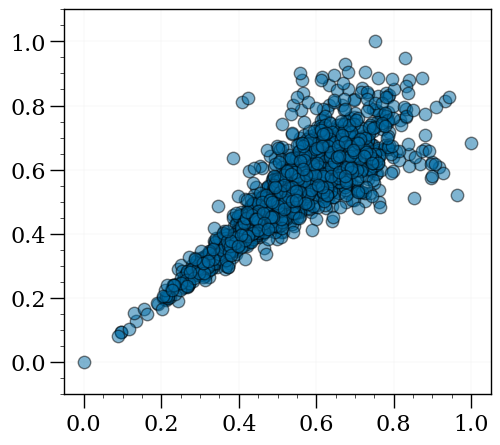

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:30<83:30:58, 30.07s/it]

Iter 0. Loss [[ 0.06706717  0.29724455 19.931568  ]]


  0%|          | 12/10000 [00:57<1:31:04,  1.83it/s]

Iter 10. Loss [[0.06886618 0.2731214  5.9076023 ]]


  0%|          | 22/10000 [00:58<26:40,  6.23it/s]

Iter 20. Loss [[0.07006353 0.26386705 5.2590375 ]]


  0%|          | 31/10000 [01:00<39:47,  4.18it/s]

Iter 30. Loss [[0.07169606 0.25533447 4.94059   ]]


  0%|          | 41/10000 [01:03<39:00,  4.26it/s]

Iter 40. Loss [[0.07292923 0.25106582 4.8763804 ]]


  1%|          | 52/10000 [01:05<26:35,  6.24it/s]

Iter 50. Loss [[0.07319363 0.24975936 4.828478  ]]


  1%|          | 62/10000 [01:06<23:27,  7.06it/s]

Iter 60. Loss [[0.07297663 0.2493706  4.750367  ]]


  1%|          | 72/10000 [01:08<24:01,  6.89it/s]

Iter 70. Loss [[0.07283295 0.24840401 4.6203322 ]]


  1%|          | 82/10000 [01:09<24:12,  6.83it/s]

Iter 80. Loss [[0.0728249  0.24692273 4.340958  ]]


  1%|          | 92/10000 [01:11<24:36,  6.71it/s]

Iter 90. Loss [[0.07248348 0.24647167 3.9487877 ]]


  1%|          | 102/10000 [01:12<24:18,  6.79it/s]

Iter 100. Loss [[0.07206116 0.24824369 3.86747   ]]


  1%|          | 111/10000 [01:13<31:25,  5.24it/s]

Iter 110. Loss [[0.07203232 0.2455348  3.9080687 ]]


  1%|          | 121/10000 [01:16<38:30,  4.28it/s]

Iter 120. Loss [[0.07211979 0.24274878 3.849868  ]]


  1%|▏         | 132/10000 [01:18<33:40,  4.88it/s]

Iter 130. Loss [[0.07186101 0.24080609 3.7892141 ]]


  1%|▏         | 142/10000 [01:20<24:12,  6.78it/s]

Iter 140. Loss [[0.07146288 0.24409986 3.7734766 ]]


  2%|▏         | 152/10000 [01:21<23:47,  6.90it/s]

Iter 150. Loss [[0.07147732 0.24014567 3.8939772 ]]


  2%|▏         | 162/10000 [01:23<23:50,  6.88it/s]

Iter 160. Loss [[0.07137894 0.24169771 3.8781745 ]]


  2%|▏         | 172/10000 [01:24<25:18,  6.47it/s]

Iter 170. Loss [[0.07197821 0.24041107 3.7020512 ]]


  2%|▏         | 182/10000 [01:26<24:33,  6.67it/s]

Iter 180. Loss [[0.07267647 0.24188155 3.5306249 ]]


  2%|▏         | 191/10000 [01:27<24:52,  6.57it/s]

Iter 190. Loss [[0.07342579 0.24804087 3.48318   ]]


  2%|▏         | 201/10000 [01:30<37:41,  4.33it/s]

Iter 200. Loss [[0.07452163 0.25491008 3.461333  ]]


  2%|▏         | 212/10000 [01:32<33:24,  4.88it/s]

Iter 210. Loss [[0.0766793  0.24981484 3.305139  ]]


  2%|▏         | 222/10000 [01:34<23:50,  6.84it/s]

Iter 220. Loss [[0.07958772 0.23619926 3.5005054 ]]


  2%|▏         | 232/10000 [01:35<23:39,  6.88it/s]

Iter 230. Loss [[0.08376317 0.21475224 3.7008412 ]]


  2%|▏         | 242/10000 [01:36<23:29,  6.92it/s]

Iter 240. Loss [[0.08648654 0.2051106  3.5868511 ]]


  3%|▎         | 252/10000 [01:38<29:36,  5.49it/s]

Iter 250. Loss [[0.0885627  0.19656372 3.3430212 ]]


  3%|▎         | 262/10000 [01:40<24:23,  6.65it/s]

Iter 260. Loss [[0.08735254 0.18829665 2.91742   ]]


  3%|▎         | 272/10000 [01:41<23:55,  6.78it/s]

Iter 270. Loss [[0.0857664  0.18606302 2.8366818 ]]


  3%|▎         | 281/10000 [01:43<33:33,  4.83it/s]

Iter 280. Loss [[0.08603595 0.20773242 2.8045852 ]]


  3%|▎         | 291/10000 [01:45<38:57,  4.15it/s]

Iter 290. Loss [[0.09199834 0.20434053 2.5114732 ]]


  3%|▎         | 302/10000 [01:48<27:31,  5.87it/s]

Iter 300. Loss [[0.10177742 0.18954307 2.245609  ]]


  3%|▎         | 312/10000 [01:49<23:47,  6.79it/s]

Iter 310. Loss [[0.11440565 0.16180779 2.1036706 ]]


  3%|▎         | 322/10000 [01:50<23:53,  6.75it/s]

Iter 320. Loss [[0.12930998 0.13311024 1.8969742 ]]


  3%|▎         | 332/10000 [01:52<22:56,  7.02it/s]

Iter 330. Loss [[0.14889833 0.11076806 1.4758694 ]]


  3%|▎         | 342/10000 [01:53<23:11,  6.94it/s]

Iter 340. Loss [[0.17659311 0.08683675 0.9858278 ]]


  4%|▎         | 352/10000 [01:55<23:05,  6.97it/s]

Iter 350. Loss [[0.21237856 0.06247363 0.4892716 ]]


  4%|▎         | 361/10000 [01:56<29:40,  5.41it/s]

Iter 360. Loss [[0.24583167 0.06721919 0.05152069]]


  4%|▎         | 371/10000 [01:59<39:26,  4.07it/s]

Iter 370. Loss [[ 0.2593359   0.07746229 -0.07498452]]


  4%|▍         | 381/10000 [02:02<58:50,  2.72it/s]  

Iter 380. Loss [[ 0.26191324  0.07290244 -0.08085515]]


  4%|▍         | 392/10000 [02:04<32:51,  4.87it/s]

Iter 390. Loss [[ 0.25854298  0.0664846  -0.08535091]]


  4%|▍         | 402/10000 [02:06<22:26,  7.13it/s]

Iter 400. Loss [[ 0.26228994  0.07007606 -0.15435302]]


  4%|▍         | 412/10000 [02:07<22:54,  6.98it/s]

Iter 410. Loss [[ 0.26806337  0.08969826 -0.31542027]]


  4%|▍         | 422/10000 [02:09<21:56,  7.28it/s]

Iter 420. Loss [[ 0.26830268  0.09490842 -0.5858134 ]]


  4%|▍         | 432/10000 [02:10<22:53,  6.97it/s]

Iter 430. Loss [[ 0.26481798  0.09602965 -0.6237886 ]]


  4%|▍         | 442/10000 [02:11<23:00,  6.92it/s]

Iter 440. Loss [[ 0.26945713  0.08971634 -0.52748454]]


  5%|▍         | 452/10000 [02:13<23:08,  6.88it/s]

Iter 450. Loss [[ 0.26992068  0.08755402 -0.44932914]]


  5%|▍         | 461/10000 [02:15<35:28,  4.48it/s]

Iter 460. Loss [[ 0.274092    0.09838946 -0.63285893]]


  5%|▍         | 471/10000 [02:17<38:00,  4.18it/s]

Iter 470. Loss [[ 0.27505472  0.10911011 -0.7806611 ]]


  5%|▍         | 482/10000 [02:19<25:15,  6.28it/s]

Iter 480. Loss [[ 0.27403903  0.10128737 -0.7798353 ]]


  5%|▍         | 492/10000 [02:21<23:38,  6.70it/s]

Iter 490. Loss [[ 0.27308816  0.09267865 -0.8748109 ]]


  5%|▌         | 502/10000 [02:22<24:55,  6.35it/s]

Iter 500. Loss [[ 0.274948    0.10663342 -1.1235148 ]]


  5%|▌         | 512/10000 [02:24<22:46,  6.94it/s]

Iter 510. Loss [[ 0.28045782  0.11477593 -1.3183395 ]]


  5%|▌         | 522/10000 [02:25<23:06,  6.84it/s]

Iter 520. Loss [[ 0.277401    0.10904674 -1.15426   ]]


  5%|▌         | 532/10000 [02:27<23:00,  6.86it/s]

Iter 530. Loss [[ 0.26702604  0.10584992 -1.0426365 ]]


  5%|▌         | 542/10000 [02:29<27:09,  5.80it/s]

Iter 540. Loss [[ 0.26671863  0.10286629 -0.9666831 ]]


  6%|▌         | 551/10000 [02:31<36:40,  4.29it/s]

Iter 550. Loss [[ 0.28292644  0.11880096 -0.9829761 ]]


  6%|▌         | 562/10000 [02:33<32:33,  4.83it/s]

Iter 560. Loss [[ 0.28820387  0.12217472 -0.9949891 ]]


  6%|▌         | 572/10000 [02:35<22:59,  6.84it/s]

Iter 570. Loss [[ 0.28225777  0.09965873 -0.98254174]]


  6%|▌         | 582/10000 [02:36<23:09,  6.78it/s]

Iter 580. Loss [[ 0.272584    0.09128076 -0.6520049 ]]


  6%|▌         | 592/10000 [02:37<22:55,  6.84it/s]

Iter 590. Loss [[ 0.2589175   0.07164472 -0.49724853]]


  6%|▌         | 602/10000 [02:39<22:53,  6.84it/s]

Iter 600. Loss [[ 0.257512    0.05910163 -0.3584803 ]]


  6%|▌         | 612/10000 [02:41<24:00,  6.52it/s]

Iter 610. Loss [[ 0.26578858  0.06373858 -0.410879  ]]


  6%|▌         | 622/10000 [02:42<23:18,  6.71it/s]

Iter 620. Loss [[ 0.2704864   0.06615259 -0.500175  ]]


  6%|▋         | 631/10000 [02:44<35:58,  4.34it/s]

Iter 630. Loss [[ 0.2738385   0.07103159 -0.7518797 ]]


  6%|▋         | 641/10000 [02:46<36:23,  4.29it/s]

Iter 640. Loss [[ 0.28095803  0.10595444 -1.1321112 ]]


  7%|▋         | 652/10000 [02:48<23:35,  6.60it/s]

Iter 650. Loss [[ 0.27372974  0.10114282 -1.1693801 ]]


  7%|▋         | 662/10000 [02:50<22:36,  6.88it/s]

Iter 660. Loss [[ 0.2740329   0.08908913 -1.1891162 ]]


  7%|▋         | 672/10000 [02:51<22:17,  6.97it/s]

Iter 670. Loss [[ 0.27366373  0.08947545 -1.2754518 ]]


  7%|▋         | 682/10000 [02:53<22:47,  6.81it/s]

Iter 680. Loss [[ 0.27623937  0.09475635 -1.343528  ]]


  7%|▋         | 692/10000 [02:54<22:46,  6.81it/s]

Iter 690. Loss [[ 0.27395675  0.08003516 -1.3700501 ]]


  7%|▋         | 702/10000 [02:56<22:50,  6.78it/s]

Iter 700. Loss [[ 0.27404872  0.08602428 -1.3733855 ]]


  7%|▋         | 712/10000 [02:57<22:33,  6.86it/s]

Iter 710. Loss [[ 0.26443955  0.07153901 -0.8301909 ]]


  7%|▋         | 721/10000 [02:59<34:44,  4.45it/s]

Iter 720. Loss [[ 0.26161814  0.10572359 -1.0603043 ]]


  7%|▋         | 731/10000 [03:02<38:09,  4.05it/s]

Iter 730. Loss [[ 0.26980555  0.06963612 -0.7886635 ]]


  7%|▋         | 742/10000 [03:03<22:34,  6.83it/s]

Iter 740. Loss [[ 0.25794277  0.0777361  -0.9520828 ]]


  8%|▊         | 752/10000 [03:05<22:39,  6.80it/s]

Iter 750. Loss [[ 0.2580914   0.06434843 -1.0050688 ]]


  8%|▊         | 762/10000 [03:06<22:20,  6.89it/s]

Iter 760. Loss [[ 0.26209277  0.07275505 -1.1113653 ]]


  8%|▊         | 772/10000 [03:08<22:10,  6.94it/s]

Iter 770. Loss [[ 0.26620072  0.08558341 -1.1984167 ]]


  8%|▊         | 782/10000 [03:09<22:45,  6.75it/s]

Iter 780. Loss [[ 0.2674659   0.06994423 -1.0252935 ]]


  8%|▊         | 792/10000 [03:11<23:23,  6.56it/s]

Iter 790. Loss [[ 0.2535531   0.09454018 -1.1257682 ]]


  8%|▊         | 801/10000 [03:12<27:31,  5.57it/s]

Iter 800. Loss [[ 0.26881623  0.07856444 -1.1803048 ]]


  8%|▊         | 811/10000 [03:15<36:04,  4.24it/s]

Iter 810. Loss [[ 0.26390275  0.08556452 -1.2999197 ]]


  8%|▊         | 822/10000 [03:17<26:11,  5.84it/s]

Iter 820. Loss [[ 0.27019015  0.08292234 -0.9964107 ]]


  8%|▊         | 832/10000 [03:19<22:44,  6.72it/s]

Iter 830. Loss [[ 0.2582439   0.09788009 -1.1166909 ]]


  8%|▊         | 842/10000 [03:20<22:12,  6.87it/s]

Iter 840. Loss [[ 0.2622437   0.07574105 -1.0967226 ]]


  9%|▊         | 852/10000 [03:22<21:52,  6.97it/s]

Iter 850. Loss [[ 0.26310477  0.0818366  -1.266636  ]]


  9%|▊         | 862/10000 [03:23<21:38,  7.04it/s]

Iter 860. Loss [[ 0.26432005  0.08399777 -1.3166075 ]]


  9%|▊         | 872/10000 [03:24<22:43,  6.70it/s]

Iter 870. Loss [[ 0.26556802  0.08971551 -1.3805214 ]]


  9%|▉         | 882/10000 [03:26<28:10,  5.39it/s]

Iter 880. Loss [[ 0.26723245  0.08366692 -1.4590596 ]]


  9%|▉         | 891/10000 [03:28<34:33,  4.39it/s]

Iter 890. Loss [[ 0.27054268  0.0848754  -1.5331081 ]]


  9%|▉         | 901/10000 [03:30<35:58,  4.22it/s]

Iter 900. Loss [[ 0.2732757   0.09193707 -1.6278291 ]]


  9%|▉         | 912/10000 [03:32<22:41,  6.68it/s]

Iter 910. Loss [[ 0.27533385  0.086722   -1.5896692 ]]


  9%|▉         | 922/10000 [03:34<22:20,  6.77it/s]

Iter 920. Loss [[ 0.2786915   0.08486106 -1.6170393 ]]


  9%|▉         | 932/10000 [03:35<20:23,  7.41it/s]

Iter 930. Loss [[ 0.27885583  0.07983688 -1.5525601 ]]


  9%|▉         | 942/10000 [03:36<20:07,  7.50it/s]

Iter 940. Loss [[ 0.28239194  0.08473982 -1.5315212 ]]


 10%|▉         | 952/10000 [03:38<20:41,  7.29it/s]

Iter 950. Loss [[ 0.2801133   0.09249825 -1.5387354 ]]


 10%|▉         | 962/10000 [03:39<21:44,  6.93it/s]

Iter 960. Loss [[ 0.27738392  0.07701682 -1.4541448 ]]


 10%|▉         | 972/10000 [03:41<21:37,  6.96it/s]

Iter 970. Loss [[ 0.2779909   0.09180389 -1.5788095 ]]


 10%|▉         | 981/10000 [03:42<33:57,  4.43it/s]

Iter 980. Loss [[ 0.2754253   0.08647929 -1.5957658 ]]


 10%|▉         | 991/10000 [03:45<35:50,  4.19it/s]

Iter 990. Loss [[ 0.27319115  0.08837833 -1.5825356 ]]


 10%|█         | 1002/10000 [03:47<30:47,  4.87it/s]

Iter 1000. Loss [[ 0.27378118  0.09477565 -1.4594599 ]]


 10%|█         | 1012/10000 [03:48<20:27,  7.32it/s]

Iter 1010. Loss [[ 0.27211264  0.0964921  -1.4698249 ]]


 10%|█         | 1022/10000 [03:50<20:11,  7.41it/s]

Iter 1020. Loss [[ 0.26730978  0.08500178 -1.4370823 ]]


 10%|█         | 1032/10000 [03:51<20:07,  7.43it/s]

Iter 1030. Loss [[ 0.26476014  0.08372043 -1.4347484 ]]


 10%|█         | 1042/10000 [03:52<21:49,  6.84it/s]

Iter 1040. Loss [[ 0.26600826  0.07941572 -1.4363292 ]]


 11%|█         | 1052/10000 [03:54<21:30,  6.94it/s]

Iter 1050. Loss [[ 0.26684707  0.08744104 -1.4654386 ]]


 11%|█         | 1062/10000 [03:55<24:10,  6.16it/s]

Iter 1060. Loss [[ 0.2704995   0.09007706 -1.476538  ]]


 11%|█         | 1071/10000 [03:58<44:02,  3.38it/s]

Iter 1070. Loss [[ 0.2674291   0.09367435 -1.4498138 ]]


 11%|█         | 1081/10000 [04:01<39:08,  3.80it/s]

Iter 1080. Loss [[ 0.26534936  0.08807538 -1.434961  ]]


 11%|█         | 1092/10000 [04:04<26:20,  5.63it/s]

Iter 1090. Loss [[ 0.26546624  0.090329   -1.4820563 ]]


 11%|█         | 1102/10000 [04:05<21:41,  6.84it/s]

Iter 1100. Loss [[ 0.26564085  0.08935881 -1.4833142 ]]


 11%|█         | 1112/10000 [04:07<25:39,  5.77it/s]

Iter 1110. Loss [[ 0.26199162  0.08154025 -1.478365  ]]


 11%|█         | 1122/10000 [04:08<21:16,  6.95it/s]

Iter 1120. Loss [[ 0.26571617  0.08791919 -1.5035027 ]]


 11%|█▏        | 1132/10000 [04:10<20:14,  7.30it/s]

Iter 1130. Loss [[ 0.26449314  0.09288342 -1.4833428 ]]


 11%|█▏        | 1142/10000 [04:11<21:46,  6.78it/s]

Iter 1140. Loss [[ 0.26612973  0.09472517 -1.5474819 ]]


 12%|█▏        | 1152/10000 [04:12<20:58,  7.03it/s]

Iter 1150. Loss [[ 0.2649502   0.09214649 -1.5274756 ]]


 12%|█▏        | 1161/10000 [04:14<31:33,  4.67it/s]

Iter 1160. Loss [[ 0.26547474  0.09355206 -1.5412376 ]]


 12%|█▏        | 1171/10000 [04:16<33:43,  4.36it/s]

Iter 1170. Loss [[ 0.2658817   0.09413657 -1.5416942 ]]


 12%|█▏        | 1181/10000 [04:18<23:54,  6.15it/s]

Iter 1180. Loss [[ 0.2660342  0.1059291 -1.5287507]]


 12%|█▏        | 1192/10000 [04:20<21:20,  6.88it/s]

Iter 1190. Loss [[ 0.27461419  0.11178676 -1.6132047 ]]


 12%|█▏        | 1202/10000 [04:22<21:07,  6.94it/s]

Iter 1200. Loss [[ 0.26433554  0.0878196  -1.4994762 ]]


 12%|█▏        | 1212/10000 [04:23<20:51,  7.02it/s]

Iter 1210. Loss [[ 0.261283    0.08372162 -1.4959847 ]]


 12%|█▏        | 1222/10000 [04:25<21:22,  6.84it/s]

Iter 1220. Loss [[ 0.26396796  0.10083627 -1.5576925 ]]


 12%|█▏        | 1232/10000 [04:26<21:31,  6.79it/s]

Iter 1230. Loss [[ 0.2656505  0.1009078 -1.5729556]]


 12%|█▏        | 1242/10000 [04:27<20:59,  6.95it/s]

Iter 1240. Loss [[ 0.26257333  0.09050974 -1.5179778 ]]


 13%|█▎        | 1251/10000 [04:30<33:57,  4.29it/s]

Iter 1250. Loss [[ 0.26338896  0.09131434 -1.5246559 ]]


 13%|█▎        | 1261/10000 [04:32<35:08,  4.15it/s]

Iter 1260. Loss [[ 0.2646388   0.09194043 -1.5418274 ]]


 13%|█▎        | 1272/10000 [04:34<21:21,  6.81it/s]

Iter 1270. Loss [[ 0.26568392  0.09271694 -1.5839666 ]]


 13%|█▎        | 1282/10000 [04:35<21:39,  6.71it/s]

Iter 1280. Loss [[ 0.26571125  0.09318461 -1.6276441 ]]


 13%|█▎        | 1292/10000 [04:36<20:52,  6.95it/s]

Iter 1290. Loss [[ 0.26610744  0.09301788 -1.6681432 ]]


 13%|█▎        | 1302/10000 [04:38<20:28,  7.08it/s]

Iter 1300. Loss [[ 0.2668315   0.08796548 -1.7044932 ]]


 13%|█▎        | 1312/10000 [04:39<20:39,  7.01it/s]

Iter 1310. Loss [[ 0.26938733  0.10125519 -1.7008871 ]]


 13%|█▎        | 1322/10000 [04:41<21:13,  6.82it/s]

Iter 1320. Loss [[ 0.27675295  0.09595315 -1.6130983 ]]


 13%|█▎        | 1332/10000 [04:42<21:20,  6.77it/s]

Iter 1330. Loss [[ 0.26396495  0.09806276 -0.7917353 ]]


 13%|█▎        | 1341/10000 [04:44<33:51,  4.26it/s]

Iter 1340. Loss [[ 0.26357603  0.07002482 -1.1246878 ]]


 14%|█▎        | 1352/10000 [04:47<31:04,  4.64it/s]

Iter 1350. Loss [[ 0.26773357  0.09132381 -1.1512948 ]]


 14%|█▎        | 1362/10000 [04:48<20:59,  6.86it/s]

Iter 1360. Loss [[ 0.2625444   0.08439992 -1.2685122 ]]


 14%|█▎        | 1372/10000 [04:50<20:54,  6.88it/s]

Iter 1370. Loss [[ 0.26086104  0.08935397 -1.2599055 ]]


 14%|█▍        | 1382/10000 [04:51<20:55,  6.86it/s]

Iter 1380. Loss [[ 0.26055852  0.08730102 -1.3030672 ]]


 14%|█▍        | 1392/10000 [04:53<21:12,  6.76it/s]

Iter 1390. Loss [[ 0.26099455  0.09255397 -1.3146833 ]]


 14%|█▍        | 1402/10000 [04:54<20:49,  6.88it/s]

Iter 1400. Loss [[ 0.26761305  0.09783349 -1.4069687 ]]


 14%|█▍        | 1412/10000 [04:56<20:23,  7.02it/s]

Iter 1410. Loss [[ 0.26669773  0.09394085 -1.3550642 ]]


 14%|█▍        | 1421/10000 [04:57<27:47,  5.14it/s]

Iter 1420. Loss [[ 0.26452154  0.08622895 -1.3222064 ]]


 14%|█▍        | 1431/10000 [04:59<33:41,  4.24it/s]

Iter 1430. Loss [[ 0.2630455   0.08389575 -1.3425556 ]]


 14%|█▍        | 1442/10000 [05:02<23:59,  5.95it/s]

Iter 1440. Loss [[ 0.26250222  0.09060282 -1.3902568 ]]


 15%|█▍        | 1452/10000 [05:04<24:49,  5.74it/s]

Iter 1450. Loss [[ 0.26330036  0.09427067 -1.4195893 ]]


 15%|█▍        | 1462/10000 [05:05<20:54,  6.81it/s]

Iter 1460. Loss [[ 0.26404318  0.09309243 -1.424512  ]]


 15%|█▍        | 1472/10000 [05:06<20:21,  6.98it/s]

Iter 1470. Loss [[ 0.26492178  0.09181488 -1.4346284 ]]


 15%|█▍        | 1482/10000 [05:08<20:30,  6.92it/s]

Iter 1480. Loss [[ 0.2656171   0.09099365 -1.4229401 ]]


 15%|█▍        | 1492/10000 [05:09<20:29,  6.92it/s]

Iter 1490. Loss [[ 0.26581404  0.09033382 -1.4072698 ]]


 15%|█▌        | 1502/10000 [05:11<23:18,  6.08it/s]

Iter 1500. Loss [[ 0.265925    0.08987418 -1.4349753 ]]


 15%|█▌        | 1511/10000 [05:13<33:04,  4.28it/s]

Iter 1510. Loss [[ 0.26668283  0.08989219 -1.4339404 ]]


 15%|█▌        | 1522/10000 [05:16<29:07,  4.85it/s]

Iter 1520. Loss [[ 0.26651812  0.08989961 -1.438205  ]]


 15%|█▌        | 1532/10000 [05:17<20:47,  6.79it/s]

Iter 1530. Loss [[ 0.2658505  0.0908749 -1.412284 ]]


 15%|█▌        | 1542/10000 [05:19<20:38,  6.83it/s]

Iter 1540. Loss [[ 0.26491672  0.08763821 -1.4212555 ]]


 16%|█▌        | 1552/10000 [05:20<20:24,  6.90it/s]

Iter 1550. Loss [[ 0.26517534  0.08873695 -1.4229783 ]]


 16%|█▌        | 1562/10000 [05:21<19:31,  7.20it/s]

Iter 1560. Loss [[ 0.2652825   0.08938586 -1.4253237 ]]


 16%|█▌        | 1572/10000 [05:23<20:39,  6.80it/s]

Iter 1570. Loss [[ 0.264936    0.09036395 -1.4102757 ]]


 16%|█▌        | 1582/10000 [05:24<19:55,  7.04it/s]

Iter 1580. Loss [[ 0.2645241   0.08801259 -1.4126213 ]]


 16%|█▌        | 1591/10000 [05:26<31:56,  4.39it/s]

Iter 1590. Loss [[ 0.26448217  0.08900024 -1.4178704 ]]


 16%|█▌        | 1601/10000 [05:29<32:39,  4.29it/s]

Iter 1600. Loss [[ 0.26437482  0.087742   -1.4147447 ]]


 16%|█▌        | 1612/10000 [05:31<22:18,  6.27it/s]

Iter 1610. Loss [[ 0.26441845  0.08913055 -1.4093645 ]]


 16%|█▌        | 1622/10000 [05:32<20:07,  6.94it/s]

Iter 1620. Loss [[ 0.26485297  0.08927085 -1.4167905 ]]


 16%|█▋        | 1632/10000 [05:33<20:17,  6.87it/s]

Iter 1630. Loss [[ 0.26531136  0.09040727 -1.4131556 ]]


 16%|█▋        | 1642/10000 [05:35<20:17,  6.87it/s]

Iter 1640. Loss [[ 0.26534235  0.08901495 -1.4118631 ]]


 17%|█▋        | 1652/10000 [05:37<31:52,  4.36it/s]

Iter 1650. Loss [[ 0.26496932  0.09110207 -1.4054661 ]]


 17%|█▋        | 1662/10000 [05:38<21:18,  6.52it/s]

Iter 1660. Loss [[ 0.26531488  0.0901724  -1.4254881 ]]


 17%|█▋        | 1672/10000 [05:40<20:46,  6.68it/s]

Iter 1670. Loss [[ 0.26527888  0.08815229 -1.4202274 ]]


 17%|█▋        | 1681/10000 [05:42<31:12,  4.44it/s]

Iter 1680. Loss [[ 0.26487166  0.08913153 -1.4432297 ]]


 17%|█▋        | 1691/10000 [05:44<32:59,  4.20it/s]

Iter 1690. Loss [[ 0.26548114  0.09035258 -1.4507073 ]]


 17%|█▋        | 1702/10000 [05:46<24:19,  5.69it/s]

Iter 1700. Loss [[ 0.26540905  0.08908242 -1.4057257 ]]


 17%|█▋        | 1712/10000 [05:47<20:12,  6.84it/s]

Iter 1710. Loss [[ 0.264491    0.08842802 -1.4327825 ]]


 17%|█▋        | 1722/10000 [05:49<19:55,  6.92it/s]

Iter 1720. Loss [[ 0.26486406  0.08923834 -1.4260335 ]]


 17%|█▋        | 1732/10000 [05:50<19:40,  7.00it/s]

Iter 1730. Loss [[ 0.26505655  0.08933879 -1.4448972 ]]


 17%|█▋        | 1742/10000 [05:52<20:09,  6.83it/s]

Iter 1740. Loss [[ 0.26544112  0.08957263 -1.4251637 ]]


 18%|█▊        | 1752/10000 [05:53<20:03,  6.85it/s]

Iter 1750. Loss [[ 0.26543254  0.08939754 -1.4361198 ]]


 18%|█▊        | 1761/10000 [05:55<25:02,  5.48it/s]

Iter 1760. Loss [[ 0.26554066  0.08922227 -1.4354596 ]]


 18%|█▊        | 1771/10000 [05:58<41:01,  3.34it/s]

Iter 1770. Loss [[ 0.2655288   0.08897372 -1.4351554 ]]


 18%|█▊        | 1781/10000 [06:01<38:06,  3.59it/s]

Iter 1780. Loss [[ 0.26584372  0.09076741 -1.4456542 ]]


 18%|█▊        | 1792/10000 [06:03<23:10,  5.90it/s]

Iter 1790. Loss [[ 0.26588923  0.09104126 -1.4472444 ]]


 18%|█▊        | 1802/10000 [06:05<19:56,  6.85it/s]

Iter 1800. Loss [[ 0.26587012  0.09034103 -1.4515221 ]]


 18%|█▊        | 1812/10000 [06:06<19:26,  7.02it/s]

Iter 1810. Loss [[ 0.2659453   0.08977387 -1.4467938 ]]


 18%|█▊        | 1822/10000 [06:07<20:02,  6.80it/s]

Iter 1820. Loss [[ 0.2656734   0.08963842 -1.4526061 ]]


 18%|█▊        | 1832/10000 [06:09<19:45,  6.89it/s]

Iter 1830. Loss [[ 0.2654425   0.08929344 -1.4516884 ]]


 18%|█▊        | 1842/10000 [06:10<18:58,  7.17it/s]

Iter 1840. Loss [[ 0.26530942  0.08922546 -1.4544857 ]]


 19%|█▊        | 1852/10000 [06:12<18:45,  7.24it/s]

Iter 1850. Loss [[ 0.26531357  0.08914723 -1.4247923 ]]


 19%|█▊        | 1861/10000 [06:13<26:02,  5.21it/s]

Iter 1860. Loss [[ 0.26522872  0.08986252 -1.4327856 ]]


 19%|█▊        | 1871/10000 [06:15<31:39,  4.28it/s]

Iter 1870. Loss [[ 0.2650101   0.08838053 -1.4253025 ]]


 19%|█▉        | 1882/10000 [06:18<22:34,  5.99it/s]

Iter 1880. Loss [[ 0.264965   0.0875321 -1.4032913]]


 19%|█▉        | 1892/10000 [06:19<19:47,  6.83it/s]

Iter 1890. Loss [[ 0.2641092   0.09017731 -1.4662021 ]]


 19%|█▉        | 1902/10000 [06:21<19:25,  6.95it/s]

Iter 1900. Loss [[ 0.26463068  0.0888858  -1.4260534 ]]


 19%|█▉        | 1912/10000 [06:22<19:39,  6.86it/s]

Iter 1910. Loss [[ 0.26428762  0.08889901 -1.4310111 ]]


 19%|█▉        | 1922/10000 [06:24<19:13,  7.00it/s]

Iter 1920. Loss [[ 0.26478434  0.08983187 -1.4372572 ]]


 19%|█▉        | 1932/10000 [06:25<24:42,  5.44it/s]

Iter 1930. Loss [[ 0.26494163  0.09045962 -1.4636058 ]]


 19%|█▉        | 1942/10000 [06:27<19:36,  6.85it/s]

Iter 1940. Loss [[ 0.26629642  0.09158403 -1.4750764 ]]


 20%|█▉        | 1951/10000 [06:29<31:10,  4.30it/s]

Iter 1950. Loss [[ 0.26668328  0.09272191 -1.486624  ]]


 20%|█▉        | 1961/10000 [06:31<30:56,  4.33it/s]

Iter 1960. Loss [[ 0.26651818  0.09116186 -1.4773885 ]]


 20%|█▉        | 1972/10000 [06:33<19:43,  6.78it/s]

Iter 1970. Loss [[ 0.26617798  0.09052739 -1.459473  ]]


 20%|█▉        | 1982/10000 [06:34<19:47,  6.75it/s]

Iter 1980. Loss [[ 0.26575357  0.08946133 -1.4480479 ]]


 20%|█▉        | 1992/10000 [06:36<19:06,  6.99it/s]

Iter 1990. Loss [[ 0.26535133  0.0909922  -1.4634918 ]]


 20%|██        | 2002/10000 [06:38<19:52,  6.71it/s]

Iter 2000. Loss [[ 0.26544127  0.09112532 -1.4801223 ]]


 20%|██        | 2012/10000 [06:39<19:15,  6.91it/s]

Iter 2010. Loss [[ 0.26583606  0.09144072 -1.479388  ]]


 20%|██        | 2022/10000 [06:40<19:38,  6.77it/s]

Iter 2020. Loss [[ 0.26597285  0.09135345 -1.4553444 ]]


 20%|██        | 2031/10000 [06:42<24:20,  5.46it/s]

Iter 2030. Loss [[ 0.2651276   0.09094578 -1.4780687 ]]


 20%|██        | 2041/10000 [06:45<35:13,  3.77it/s]

Iter 2040. Loss [[ 0.26513174  0.09081149 -1.4483305 ]]


 21%|██        | 2052/10000 [06:47<21:18,  6.21it/s]

Iter 2050. Loss [[ 0.2647869   0.09084301 -1.464203  ]]


 21%|██        | 2062/10000 [06:48<19:24,  6.81it/s]

Iter 2060. Loss [[ 0.26535216  0.09251664 -1.4636575 ]]


 21%|██        | 2072/10000 [06:50<19:08,  6.90it/s]

Iter 2070. Loss [[ 0.2648645   0.09015041 -1.4172246 ]]


 21%|██        | 2082/10000 [06:51<19:43,  6.69it/s]

Iter 2080. Loss [[ 0.26582688  0.09041281 -1.4995319 ]]


 21%|██        | 2092/10000 [06:53<18:57,  6.95it/s]

Iter 2090. Loss [[ 0.26583377  0.09270997 -1.4876478 ]]


 21%|██        | 2102/10000 [06:54<20:06,  6.54it/s]

Iter 2100. Loss [[ 0.26537034  0.09052366 -1.5013815 ]]


 21%|██        | 2112/10000 [06:56<19:10,  6.86it/s]

Iter 2110. Loss [[ 0.26570138  0.09050439 -1.5124269 ]]


 21%|██        | 2121/10000 [06:58<31:01,  4.23it/s]

Iter 2120. Loss [[ 0.26600108  0.09115517 -1.4782676 ]]


 21%|██▏       | 2132/10000 [07:00<28:54,  4.54it/s]

Iter 2130. Loss [[ 0.26582223  0.08874234 -1.462151  ]]


 21%|██▏       | 2142/10000 [07:02<19:05,  6.86it/s]

Iter 2140. Loss [[ 0.26549855  0.0884163  -1.4652269 ]]


 22%|██▏       | 2152/10000 [07:03<18:51,  6.94it/s]

Iter 2150. Loss [[ 0.2657195   0.08995053 -1.5073193 ]]


 22%|██▏       | 2162/10000 [07:05<18:47,  6.95it/s]

Iter 2160. Loss [[ 0.26778564  0.08945685 -1.5364753 ]]


 22%|██▏       | 2172/10000 [07:06<19:06,  6.83it/s]

Iter 2170. Loss [[ 0.26523885  0.10436255 -1.5082085 ]]


 22%|██▏       | 2182/10000 [07:08<19:10,  6.80it/s]

Iter 2180. Loss [[ 0.2640924   0.11060744 -1.5149812 ]]


 22%|██▏       | 2192/10000 [07:09<19:22,  6.72it/s]

Iter 2190. Loss [[ 0.2669761   0.06482369 -1.173227  ]]


 22%|██▏       | 2201/10000 [07:10<18:50,  6.90it/s]

Iter 2200. Loss [[ 0.2612794  0.1208502 -1.6012819]]


 22%|██▏       | 2211/10000 [07:13<30:40,  4.23it/s]

Iter 2210. Loss [[ 0.26610652  0.08025436 -1.4626964 ]]


 22%|██▏       | 2222/10000 [07:15<25:57,  4.99it/s]

Iter 2220. Loss [[ 0.266799    0.09812516 -1.5911112 ]]


 22%|██▏       | 2232/10000 [07:16<18:18,  7.07it/s]

Iter 2230. Loss [[ 0.2675248   0.08975718 -1.5554156 ]]


 22%|██▏       | 2242/10000 [07:18<18:32,  6.97it/s]

Iter 2240. Loss [[ 0.26616716  0.09266003 -1.5634743 ]]


 23%|██▎       | 2252/10000 [07:19<18:54,  6.83it/s]

Iter 2250. Loss [[ 0.26691598  0.09223504 -1.5800862 ]]


 23%|██▎       | 2262/10000 [07:21<18:27,  6.99it/s]

Iter 2260. Loss [[ 0.26688552  0.09382688 -1.5940765 ]]


 23%|██▎       | 2272/10000 [07:23<19:48,  6.50it/s]

Iter 2270. Loss [[ 0.26711896  0.09225801 -1.5384777 ]]


 23%|██▎       | 2282/10000 [07:24<19:29,  6.60it/s]

Iter 2280. Loss [[ 0.26635647  0.09284785 -1.556188  ]]


 23%|██▎       | 2291/10000 [07:26<26:31,  4.84it/s]

Iter 2290. Loss [[ 0.26603937  0.092815   -1.5733789 ]]


 23%|██▎       | 2301/10000 [07:28<30:42,  4.18it/s]

Iter 2300. Loss [[ 0.2674933   0.09392615 -1.5752761 ]]


 23%|██▎       | 2312/10000 [07:30<20:24,  6.28it/s]

Iter 2310. Loss [[ 0.26759514  0.09358525 -1.5412451 ]]


 23%|██▎       | 2322/10000 [07:31<19:18,  6.63it/s]

Iter 2320. Loss [[ 0.26687452  0.09189121 -1.583888  ]]


 23%|██▎       | 2332/10000 [07:33<19:53,  6.42it/s]

Iter 2330. Loss [[ 0.26647896  0.0900852  -1.5473833 ]]


 23%|██▎       | 2342/10000 [07:35<18:23,  6.94it/s]

Iter 2340. Loss [[ 0.26717117  0.09442702 -1.5564451 ]]


 24%|██▎       | 2352/10000 [07:36<18:21,  6.94it/s]

Iter 2350. Loss [[ 0.26729757  0.09128357 -1.5864308 ]]


 24%|██▎       | 2362/10000 [07:38<18:36,  6.84it/s]

Iter 2360. Loss [[ 0.26769766  0.0906368  -1.5696709 ]]


 24%|██▎       | 2371/10000 [07:39<21:34,  5.89it/s]

Iter 2370. Loss [[ 0.26751018  0.09092519 -1.5829303 ]]


 24%|██▍       | 2381/10000 [07:42<30:33,  4.15it/s]

Iter 2380. Loss [[ 0.26712418  0.08998532 -1.5861274 ]]


 24%|██▍       | 2392/10000 [07:44<24:38,  5.15it/s]

Iter 2390. Loss [[ 0.26824674  0.0886673  -1.6201748 ]]


 24%|██▍       | 2402/10000 [07:46<18:24,  6.88it/s]

Iter 2400. Loss [[ 0.26887533  0.09104779 -1.6429961 ]]


 24%|██▍       | 2411/10000 [07:47<18:45,  6.74it/s]

Iter 2410. Loss [[ 0.26863313  0.0887508  -1.5738788 ]]


 24%|██▍       | 2422/10000 [07:49<18:31,  6.82it/s]

Iter 2420. Loss [[ 0.26768628  0.08764425 -1.5714648 ]]


 24%|██▍       | 2432/10000 [07:50<18:20,  6.87it/s]

Iter 2430. Loss [[ 0.2669115   0.08659804 -1.5812815 ]]


 24%|██▍       | 2442/10000 [07:52<18:36,  6.77it/s]

Iter 2440. Loss [[ 0.2671817   0.09258253 -1.6137724 ]]


 25%|██▍       | 2452/10000 [07:53<18:43,  6.72it/s]

Iter 2450. Loss [[ 0.26706156  0.09143774 -1.5790724 ]]


 25%|██▍       | 2461/10000 [07:55<32:03,  3.92it/s]

Iter 2460. Loss [[ 0.26537323  0.0917579  -1.5625532 ]]


 25%|██▍       | 2471/10000 [07:58<34:33,  3.63it/s]

Iter 2470. Loss [[ 0.26412234  0.09358201 -1.5641768 ]]


 25%|██▍       | 2481/10000 [08:01<40:30,  3.09it/s]

Iter 2480. Loss [[ 0.26451182  0.09457442 -1.5567882 ]]


 25%|██▍       | 2492/10000 [08:03<18:57,  6.60it/s]

Iter 2490. Loss [[ 0.26444846  0.09653671 -1.580736  ]]


 25%|██▌       | 2502/10000 [08:04<16:51,  7.41it/s]

Iter 2500. Loss [[ 0.26464373  0.09662858 -1.5464702 ]]


 25%|██▌       | 2512/10000 [08:06<16:38,  7.50it/s]

Iter 2510. Loss [[ 0.2632239   0.09353253 -1.5375319 ]]


 25%|██▌       | 2522/10000 [08:07<16:53,  7.38it/s]

Iter 2520. Loss [[ 0.26316634  0.09349295 -1.5394645 ]]


 25%|██▌       | 2532/10000 [08:08<17:26,  7.13it/s]

Iter 2530. Loss [[ 0.26358372  0.09671471 -1.5603076 ]]


 25%|██▌       | 2542/10000 [08:10<18:06,  6.87it/s]

Iter 2540. Loss [[ 0.262934    0.09438188 -1.5304388 ]]


 26%|██▌       | 2552/10000 [08:11<17:57,  6.91it/s]

Iter 2550. Loss [[ 0.2626189   0.09393773 -1.5180415 ]]


 26%|██▌       | 2561/10000 [08:13<27:21,  4.53it/s]

Iter 2560. Loss [[ 0.2622226   0.09557037 -1.5329945 ]]


 26%|██▌       | 2571/10000 [08:15<28:33,  4.33it/s]

Iter 2570. Loss [[ 0.26273173  0.09596643 -1.539943  ]]


 26%|██▌       | 2582/10000 [08:17<19:25,  6.37it/s]

Iter 2580. Loss [[ 0.26292732  0.091791   -1.477817  ]]


 26%|██▌       | 2592/10000 [08:19<17:42,  6.97it/s]

Iter 2590. Loss [[ 0.26098037  0.09412279 -1.4496181 ]]


 26%|██▌       | 2602/10000 [08:20<16:12,  7.60it/s]

Iter 2600. Loss [[ 0.25996217  0.09240651 -1.4975091 ]]


 26%|██▌       | 2612/10000 [08:21<18:22,  6.70it/s]

Iter 2610. Loss [[ 0.26225471  0.0938758  -1.4958773 ]]


 26%|██▌       | 2622/10000 [08:23<18:02,  6.81it/s]

Iter 2620. Loss [[ 0.26189935  0.09532102 -1.4881071 ]]


 26%|██▋       | 2632/10000 [08:25<20:12,  6.08it/s]

Iter 2630. Loss [[ 0.2619918   0.09441359 -1.5230652 ]]


 26%|██▋       | 2642/10000 [08:26<17:29,  7.01it/s]

Iter 2640. Loss [[ 0.26461178  0.09804516 -1.5259204 ]]


 27%|██▋       | 2651/10000 [08:28<28:34,  4.29it/s]

Iter 2650. Loss [[ 0.26234987  0.09669448 -1.550138  ]]


 27%|██▋       | 2661/10000 [08:31<28:23,  4.31it/s]

Iter 2660. Loss [[ 0.25834942  0.0964596  -1.5411948 ]]


 27%|██▋       | 2672/10000 [08:32<17:58,  6.80it/s]

Iter 2670. Loss [[ 0.26251402  0.09597012 -1.5460156 ]]


 27%|██▋       | 2682/10000 [08:34<18:12,  6.70it/s]

Iter 2680. Loss [[ 0.2630662   0.09246077 -1.513013  ]]


 27%|██▋       | 2691/10000 [08:35<18:09,  6.71it/s]

Iter 2690. Loss [[ 0.26321128  0.09439772 -1.5158669 ]]


 27%|██▋       | 2702/10000 [08:37<18:19,  6.64it/s]

Iter 2700. Loss [[ 0.26146665  0.09598513 -1.5293472 ]]


 27%|██▋       | 2712/10000 [08:38<17:18,  7.02it/s]

Iter 2710. Loss [[ 0.26219156  0.09463006 -1.4992822 ]]


 27%|██▋       | 2722/10000 [08:40<17:41,  6.86it/s]

Iter 2720. Loss [[ 0.2619267   0.09559741 -1.5446854 ]]


 27%|██▋       | 2731/10000 [08:41<23:56,  5.06it/s]

Iter 2730. Loss [[ 0.26417795  0.09506024 -1.5151162 ]]


 27%|██▋       | 2741/10000 [08:44<30:52,  3.92it/s]

Iter 2740. Loss [[ 0.2629261   0.09114585 -1.4819505 ]]


 28%|██▊       | 2752/10000 [08:46<18:49,  6.42it/s]

Iter 2750. Loss [[ 0.2620653   0.09234859 -1.5057907 ]]


 28%|██▊       | 2762/10000 [08:48<17:31,  6.88it/s]

Iter 2760. Loss [[ 0.26167697  0.09854315 -1.553352  ]]


 28%|██▊       | 2772/10000 [08:49<17:43,  6.80it/s]

Iter 2770. Loss [[ 0.26364     0.09671804 -1.5359021 ]]


 28%|██▊       | 2782/10000 [08:51<17:48,  6.75it/s]

Iter 2780. Loss [[ 0.2633081  0.0931845 -1.525804 ]]


 28%|██▊       | 2792/10000 [08:52<28:01,  4.29it/s]

Iter 2790. Loss [[ 0.26387563  0.09327783 -1.5238193 ]]


 28%|██▊       | 2802/10000 [08:54<18:04,  6.64it/s]

Iter 2800. Loss [[ 0.2639451   0.08840459 -1.4599704 ]]


 28%|██▊       | 2812/10000 [08:55<17:37,  6.80it/s]

Iter 2810. Loss [[ 0.26123005  0.08746964 -1.5027367 ]]


 28%|██▊       | 2821/10000 [08:57<27:22,  4.37it/s]

Iter 2820. Loss [[ 0.26240045  0.09728484 -1.5313606 ]]


 28%|██▊       | 2831/10000 [09:00<28:06,  4.25it/s]

Iter 2830. Loss [[ 0.26243824  0.0966815  -1.54886   ]]


 28%|██▊       | 2842/10000 [09:01<17:22,  6.87it/s]

Iter 2840. Loss [[ 0.26419944  0.09301855 -1.5204868 ]]


 29%|██▊       | 2852/10000 [09:03<17:29,  6.81it/s]

Iter 2850. Loss [[ 0.2634825   0.09140057 -1.47958   ]]


 29%|██▊       | 2862/10000 [09:04<17:33,  6.78it/s]

Iter 2860. Loss [[ 0.2618875   0.08971476 -1.4680231 ]]


 29%|██▊       | 2872/10000 [09:06<17:07,  6.94it/s]

Iter 2870. Loss [[ 0.26128194  0.09226731 -1.4850098 ]]


 29%|██▉       | 2882/10000 [09:07<17:17,  6.86it/s]

Iter 2880. Loss [[ 0.26215634  0.09419596 -1.5306107 ]]


 29%|██▉       | 2892/10000 [09:09<16:58,  6.98it/s]

Iter 2890. Loss [[ 0.2644822   0.09612355 -1.5339203 ]]


 29%|██▉       | 2902/10000 [09:10<19:14,  6.15it/s]

Iter 2900. Loss [[ 0.26399115  0.08802632 -1.4938304 ]]


 29%|██▉       | 2911/10000 [09:12<27:39,  4.27it/s]

Iter 2910. Loss [[ 0.2657484   0.08717413 -1.4742103 ]]


 29%|██▉       | 2922/10000 [09:15<23:49,  4.95it/s]

Iter 2920. Loss [[ 0.2633998   0.09508327 -1.541622  ]]


 29%|██▉       | 2932/10000 [09:16<17:33,  6.71it/s]

Iter 2930. Loss [[ 0.26349446  0.09200728 -1.5261343 ]]


 29%|██▉       | 2942/10000 [09:18<16:57,  6.94it/s]

Iter 2940. Loss [[ 0.26203674  0.09621579 -1.5519449 ]]


 30%|██▉       | 2952/10000 [09:19<17:02,  6.89it/s]

Iter 2950. Loss [[ 0.2594958   0.11241354 -1.5766193 ]]


 30%|██▉       | 2962/10000 [09:21<16:52,  6.95it/s]

Iter 2960. Loss [[ 0.2607405   0.10641117 -1.5865277 ]]


 30%|██▉       | 2972/10000 [09:22<16:18,  7.19it/s]

Iter 2970. Loss [[ 0.2605776   0.10552452 -1.5489494 ]]


 30%|██▉       | 2982/10000 [09:23<16:49,  6.95it/s]

Iter 2980. Loss [[ 0.26263896  0.09397811 -1.5656997 ]]


 30%|██▉       | 2991/10000 [09:25<19:03,  6.13it/s]

Iter 2990. Loss [[ 0.2654599   0.08807074 -1.5008813 ]]


 30%|███       | 3001/10000 [09:27<39:25,  2.96it/s]

Iter 3000. Loss [[ 0.2655895   0.08372465 -1.439543  ]]


 30%|███       | 3012/10000 [09:30<18:45,  6.21it/s]

Iter 3010. Loss [[ 0.262054   0.0896181 -1.5245514]]


 30%|███       | 3022/10000 [09:31<16:50,  6.91it/s]

Iter 3020. Loss [[ 0.26266038  0.10579488 -1.5730205 ]]


 30%|███       | 3032/10000 [09:32<16:49,  6.91it/s]

Iter 3030. Loss [[ 0.26379725  0.09056549 -1.5372639 ]]


 30%|███       | 3042/10000 [09:34<16:33,  7.00it/s]

Iter 3040. Loss [[ 0.26266083  0.10017578 -1.5351862 ]]


 31%|███       | 3052/10000 [09:36<17:51,  6.49it/s]

Iter 3050. Loss [[ 0.2617256   0.09583903 -1.5747368 ]]


 31%|███       | 3062/10000 [09:37<16:58,  6.81it/s]

Iter 3060. Loss [[ 0.26484737  0.09374765 -1.5350381 ]]


 31%|███       | 3072/10000 [09:39<16:13,  7.12it/s]

Iter 3070. Loss [[ 0.26342607  0.10000348 -1.5539917 ]]


 31%|███       | 3081/10000 [09:40<26:13,  4.40it/s]

Iter 3080. Loss [[ 0.26324743  0.08618721 -1.500283  ]]


 31%|███       | 3091/10000 [09:43<27:42,  4.16it/s]

Iter 3090. Loss [[ 0.26413155  0.09085915 -1.5662482 ]]


 31%|███       | 3102/10000 [09:45<17:07,  6.72it/s]

Iter 3100. Loss [[ 0.26341864  0.10209127 -1.5950315 ]]


 31%|███       | 3112/10000 [09:46<23:14,  4.94it/s]

Iter 3110. Loss [[ 0.2655013   0.09221175 -1.5629996 ]]


 31%|███       | 3122/10000 [09:48<17:04,  6.71it/s]

Iter 3120. Loss [[ 0.2659674   0.08950856 -1.5524734 ]]


 31%|███▏      | 3132/10000 [09:49<16:50,  6.80it/s]

Iter 3130. Loss [[ 0.26328766  0.09690467 -1.5991629 ]]


 31%|███▏      | 3142/10000 [09:51<16:41,  6.85it/s]

Iter 3140. Loss [[ 0.26441726  0.08722107 -1.5653684 ]]


 32%|███▏      | 3151/10000 [09:53<24:51,  4.59it/s]

Iter 3150. Loss [[ 0.26421455  0.08705844 -1.5319027 ]]


 32%|███▏      | 3161/10000 [09:55<29:06,  3.92it/s]

Iter 3160. Loss [[ 0.26237318  0.09405188 -1.5628299 ]]


 32%|███▏      | 3171/10000 [09:57<28:18,  4.02it/s]

Iter 3170. Loss [[ 0.26375967  0.0881841  -1.5197513 ]]


 32%|███▏      | 3181/10000 [10:00<27:24,  4.15it/s]

Iter 3180. Loss [[ 0.26605028  0.08375068 -1.5011353 ]]


 32%|███▏      | 3192/10000 [10:02<16:52,  6.73it/s]

Iter 3190. Loss [[ 0.26636666  0.09285793 -1.5955117 ]]


 32%|███▏      | 3202/10000 [10:03<15:57,  7.10it/s]

Iter 3200. Loss [[ 0.26502028  0.10008485 -1.6012151 ]]


 32%|███▏      | 3212/10000 [10:04<14:49,  7.63it/s]

Iter 3210. Loss [[ 0.2630273   0.09391994 -1.6045369 ]]


 32%|███▏      | 3222/10000 [10:06<14:46,  7.64it/s]

Iter 3220. Loss [[ 0.26550353  0.08931582 -1.5861161 ]]


 32%|███▏      | 3232/10000 [10:07<15:48,  7.13it/s]

Iter 3230. Loss [[ 0.2643364   0.09126822 -1.6057984 ]]


 32%|███▏      | 3242/10000 [10:08<16:07,  6.98it/s]

Iter 3240. Loss [[ 0.26622394  0.092047   -1.5730534 ]]


 33%|███▎      | 3252/10000 [10:10<16:11,  6.95it/s]

Iter 3250. Loss [[ 0.26621875  0.09114115 -1.5786588 ]]


 33%|███▎      | 3261/10000 [10:12<25:00,  4.49it/s]

Iter 3260. Loss [[ 0.26562053  0.08966134 -1.5965996 ]]


 33%|███▎      | 3271/10000 [10:14<27:01,  4.15it/s]

Iter 3270. Loss [[ 0.26578048  0.10012486 -1.6473128 ]]


 33%|███▎      | 3282/10000 [10:16<16:55,  6.61it/s]

Iter 3280. Loss [[ 0.2648497   0.09314632 -1.6150559 ]]


 33%|███▎      | 3292/10000 [10:17<16:55,  6.61it/s]

Iter 3290. Loss [[ 0.2645176   0.09313197 -1.6148913 ]]


 33%|███▎      | 3302/10000 [10:19<15:03,  7.41it/s]

Iter 3300. Loss [[ 0.2658684   0.09450198 -1.6475121 ]]


 33%|███▎      | 3312/10000 [10:20<21:17,  5.24it/s]

Iter 3310. Loss [[ 0.26483196  0.09378642 -1.6253806 ]]


 33%|███▎      | 3322/10000 [10:22<16:22,  6.80it/s]

Iter 3320. Loss [[ 0.26617688  0.09606791 -1.6258444 ]]


 33%|███▎      | 3332/10000 [10:23<16:39,  6.67it/s]

Iter 3330. Loss [[ 0.26825494  0.0890528  -1.6217477 ]]


 33%|███▎      | 3342/10000 [10:25<16:53,  6.57it/s]

Iter 3340. Loss [[ 0.2674164   0.09764642 -1.6781937 ]]


 34%|███▎      | 3351/10000 [10:27<26:03,  4.25it/s]

Iter 3350. Loss [[ 0.26623255  0.09405264 -1.6922594 ]]


 34%|███▎      | 3362/10000 [10:29<22:59,  4.81it/s]

Iter 3360. Loss [[ 0.26674107  0.09525947 -1.7052399 ]]


 34%|███▎      | 3372/10000 [10:31<16:38,  6.64it/s]

Iter 3370. Loss [[ 0.26800796  0.0967234  -1.7179258 ]]


 34%|███▍      | 3382/10000 [10:33<16:07,  6.84it/s]

Iter 3380. Loss [[ 0.26791328  0.09441807 -1.7067475 ]]


 34%|███▍      | 3392/10000 [10:34<16:18,  6.75it/s]

Iter 3390. Loss [[ 0.2679534   0.09009743 -1.7064277 ]]


 34%|███▍      | 3402/10000 [10:35<15:54,  6.91it/s]

Iter 3400. Loss [[ 0.26779723  0.09258602 -1.7182835 ]]


 34%|███▍      | 3412/10000 [10:37<16:58,  6.47it/s]

Iter 3410. Loss [[ 0.26861823  0.09554207 -1.7257433 ]]


 34%|███▍      | 3422/10000 [10:39<17:36,  6.22it/s]

Iter 3420. Loss [[ 0.26712     0.10092381 -1.7096156 ]]


 34%|███▍      | 3431/10000 [10:41<25:17,  4.33it/s]

Iter 3430. Loss [[ 0.26838878  0.09640283 -1.7085346 ]]


 34%|███▍      | 3441/10000 [10:43<24:54,  4.39it/s]

Iter 3440. Loss [[ 0.26828787  0.09029951 -1.7057227 ]]


 35%|███▍      | 3452/10000 [10:45<16:59,  6.42it/s]

Iter 3450. Loss [[ 0.27151844  0.1016275  -1.567509  ]]


 35%|███▍      | 3462/10000 [10:46<15:55,  6.84it/s]

Iter 3460. Loss [[ 0.26755115  0.10343986 -1.5633816 ]]


 35%|███▍      | 3472/10000 [10:48<22:20,  4.87it/s]

Iter 3470. Loss [[ 0.25740162  0.08253119 -1.3973123 ]]


 35%|███▍      | 3482/10000 [10:50<15:37,  6.95it/s]

Iter 3480. Loss [[ 0.25437212  0.08556578 -1.117351  ]]


 35%|███▍      | 3492/10000 [10:51<15:31,  6.98it/s]

Iter 3490. Loss [[ 0.26673606  0.10022844 -1.2007016 ]]


 35%|███▌      | 3502/10000 [10:52<15:47,  6.86it/s]

Iter 3500. Loss [[ 0.24455862  0.05499437 -0.87343603]]


 35%|███▌      | 3512/10000 [10:54<17:19,  6.24it/s]

Iter 3510. Loss [[ 0.25533235  0.06721985 -1.1860375 ]]


 35%|███▌      | 3521/10000 [10:56<25:05,  4.30it/s]

Iter 3520. Loss [[ 0.23756556  0.04699735 -0.45308268]]


 35%|███▌      | 3531/10000 [10:58<24:41,  4.37it/s]

Iter 3530. Loss [[ 0.2588965   0.07676495 -1.2591895 ]]


 35%|███▌      | 3542/10000 [11:00<15:51,  6.79it/s]

Iter 3540. Loss [[ 0.23963489  0.08256522 -0.9081027 ]]


 36%|███▌      | 3552/10000 [11:01<15:18,  7.02it/s]

Iter 3550. Loss [[0.1999137  0.05676448 0.05344284]]


 36%|███▌      | 3562/10000 [11:03<17:28,  6.14it/s]

Iter 3560. Loss [[ 0.21487935  0.04999701 -0.31443766]]


 36%|███▌      | 3572/10000 [11:05<15:44,  6.81it/s]

Iter 3570. Loss [[ 0.23507103  0.04577402 -0.4805552 ]]


 36%|███▌      | 3582/10000 [11:06<15:47,  6.78it/s]

Iter 3580. Loss [[ 0.24331129  0.04917343 -0.4493068 ]]


 36%|███▌      | 3592/10000 [11:08<15:34,  6.86it/s]

Iter 3590. Loss [[0.22955799 0.03884847 0.10616209]]


 36%|███▌      | 3601/10000 [11:09<21:30,  4.96it/s]

Iter 3600. Loss [[0.2141154  0.06007737 0.28909454]]


 36%|███▌      | 3611/10000 [11:11<25:06,  4.24it/s]

Iter 3610. Loss [[0.20795697 0.04781405 0.06764719]]


 36%|███▌      | 3622/10000 [11:14<20:51,  5.10it/s]

Iter 3620. Loss [[ 0.2183821   0.04075656 -0.04291099]]


 36%|███▋      | 3632/10000 [11:15<15:18,  6.94it/s]

Iter 3630. Loss [[ 0.23365073  0.03679793 -0.15250488]]


 36%|███▋      | 3642/10000 [11:17<15:33,  6.81it/s]

Iter 3640. Loss [[ 0.2430459   0.03806559 -0.20003605]]


 37%|███▋      | 3652/10000 [11:18<15:35,  6.78it/s]

Iter 3650. Loss [[ 0.24550956  0.03901419 -0.21539545]]


 37%|███▋      | 3662/10000 [11:20<18:19,  5.76it/s]

Iter 3660. Loss [[ 0.24327606  0.03732154 -0.22216669]]


 37%|███▋      | 3672/10000 [11:22<15:01,  7.02it/s]

Iter 3670. Loss [[ 0.24206959  0.03659527 -0.23032959]]


 37%|███▋      | 3682/10000 [11:23<15:59,  6.58it/s]

Iter 3680. Loss [[ 0.24226147  0.036519   -0.24266466]]


 37%|███▋      | 3691/10000 [11:25<24:08,  4.35it/s]

Iter 3690. Loss [[ 0.24302183  0.03671279 -0.2582267 ]]


 37%|███▋      | 3701/10000 [11:27<24:18,  4.32it/s]

Iter 3700. Loss [[ 0.24336047  0.03679648 -0.2760264 ]]


 37%|███▋      | 3712/10000 [11:29<15:35,  6.72it/s]

Iter 3710. Loss [[ 0.24327284  0.0368285  -0.29943544]]


 37%|███▋      | 3722/10000 [11:31<16:11,  6.46it/s]

Iter 3720. Loss [[ 0.2429682   0.03713892 -0.3390803 ]]


 37%|███▋      | 3732/10000 [11:32<14:56,  6.99it/s]

Iter 3730. Loss [[ 0.2430827   0.03847804 -0.40244848]]


 37%|███▋      | 3742/10000 [11:34<15:28,  6.74it/s]

Iter 3740. Loss [[ 0.24375439  0.03971043 -0.43632022]]


 38%|███▊      | 3752/10000 [11:35<15:02,  6.93it/s]

Iter 3750. Loss [[ 0.24412157  0.04020435 -0.44329995]]


 38%|███▊      | 3762/10000 [11:37<15:08,  6.87it/s]

Iter 3760. Loss [[ 0.2438977   0.0407973  -0.45672435]]


 38%|███▊      | 3771/10000 [11:38<20:34,  5.05it/s]

Iter 3770. Loss [[ 0.24309684  0.0402584  -0.4445584 ]]


 38%|███▊      | 3781/10000 [11:41<24:40,  4.20it/s]

Iter 3780. Loss [[ 0.24195206  0.04037062 -0.4587895 ]]


 38%|███▊      | 3792/10000 [11:43<17:32,  5.90it/s]

Iter 3790. Loss [[ 0.24167159  0.03992277 -0.44373837]]


 38%|███▊      | 3802/10000 [11:45<16:28,  6.27it/s]

Iter 3800. Loss [[ 0.24134953  0.04019204 -0.45389476]]


 38%|███▊      | 3812/10000 [11:46<15:13,  6.77it/s]

Iter 3810. Loss [[ 0.24148448  0.04009511 -0.4458291 ]]


 38%|███▊      | 3822/10000 [11:48<15:02,  6.85it/s]

Iter 3820. Loss [[ 0.24143568  0.04076205 -0.4652241 ]]


 38%|███▊      | 3832/10000 [11:49<15:06,  6.81it/s]

Iter 3830. Loss [[ 0.24154437  0.0411667  -0.47307992]]


 38%|███▊      | 3841/10000 [11:51<20:17,  5.06it/s]

Iter 3840. Loss [[ 0.2413803   0.04045553 -0.45360148]]


 39%|███▊      | 3851/10000 [11:54<39:39,  2.58it/s]

Iter 3850. Loss [[ 0.2411455   0.04061663 -0.4627903 ]]


 39%|███▊      | 3861/10000 [11:56<26:33,  3.85it/s]

Iter 3860. Loss [[ 0.24153118  0.04066099 -0.45757803]]


 39%|███▊      | 3872/10000 [11:59<20:55,  4.88it/s]

Iter 3870. Loss [[ 0.241915    0.0407142  -0.45130175]]


 39%|███▉      | 3882/10000 [12:00<14:54,  6.84it/s]

Iter 3880. Loss [[ 0.24176161  0.04075933 -0.45571157]]


 39%|███▉      | 3892/10000 [12:02<14:35,  6.97it/s]

Iter 3890. Loss [[ 0.2414662   0.04129964 -0.47794318]]


 39%|███▉      | 3902/10000 [12:03<13:04,  7.77it/s]

Iter 3900. Loss [[ 0.24187578  0.04145854 -0.47564876]]


 39%|███▉      | 3912/10000 [12:04<13:16,  7.64it/s]

Iter 3910. Loss [[ 0.24224472  0.04162156 -0.4726994 ]]


 39%|███▉      | 3922/10000 [12:06<15:01,  6.74it/s]

Iter 3920. Loss [[ 0.24190392  0.04176992 -0.4829302 ]]


 39%|███▉      | 3932/10000 [12:07<14:52,  6.80it/s]

Iter 3930. Loss [[ 0.24148664  0.04121685 -0.475698  ]]


 39%|███▉      | 3941/10000 [12:09<17:18,  5.83it/s]

Iter 3940. Loss [[ 0.24160148  0.04129671 -0.4789265 ]]


 40%|███▉      | 3951/10000 [12:11<23:12,  4.34it/s]

Iter 3950. Loss [[ 0.242438    0.04148448 -0.47130728]]


 40%|███▉      | 3962/10000 [12:14<25:12,  3.99it/s]

Iter 3960. Loss [[ 0.24289706  0.04200574 -0.47751147]]


 40%|███▉      | 3972/10000 [12:15<14:51,  6.76it/s]

Iter 3970. Loss [[ 0.24275608  0.04173362 -0.4707439 ]]


 40%|███▉      | 3982/10000 [12:17<14:47,  6.78it/s]

Iter 3980. Loss [[ 0.2422647   0.04121088 -0.46453336]]


 40%|███▉      | 3992/10000 [12:18<14:24,  6.95it/s]

Iter 3990. Loss [[ 0.24210453  0.04135478 -0.4742819 ]]


 40%|████      | 4002/10000 [12:20<14:48,  6.75it/s]

Iter 4000. Loss [[ 0.24266765  0.04177599 -0.4784021 ]]


 40%|████      | 4012/10000 [12:21<14:51,  6.72it/s]

Iter 4010. Loss [[ 0.24305592  0.04180058 -0.4723748 ]]


 40%|████      | 4022/10000 [12:23<15:53,  6.27it/s]

Iter 4020. Loss [[ 0.24307448  0.04239876 -0.4897722 ]]


 40%|████      | 4031/10000 [12:25<23:32,  4.23it/s]

Iter 4030. Loss [[ 0.24326392  0.04185228 -0.46804485]]


 40%|████      | 4041/10000 [12:27<23:21,  4.25it/s]

Iter 4040. Loss [[ 0.24283156  0.04160669 -0.47025755]]


 41%|████      | 4052/10000 [12:29<14:42,  6.74it/s]

Iter 4050. Loss [[ 0.24283214  0.04171077 -0.4753611 ]]


 41%|████      | 4062/10000 [12:30<14:46,  6.70it/s]

Iter 4060. Loss [[ 0.2433559   0.04251861 -0.49011084]]


 41%|████      | 4072/10000 [12:32<14:19,  6.90it/s]

Iter 4070. Loss [[ 0.24367867  0.04284859 -0.49237236]]


 41%|████      | 4082/10000 [12:33<14:16,  6.91it/s]

Iter 4080. Loss [[ 0.24351476  0.04229439 -0.47803184]]


 41%|████      | 4092/10000 [12:35<14:18,  6.88it/s]

Iter 4090. Loss [[ 0.24309097  0.04203599 -0.4797137 ]]


 41%|████      | 4102/10000 [12:36<14:21,  6.84it/s]

Iter 4100. Loss [[ 0.24322209  0.04233519 -0.48787406]]


 41%|████      | 4112/10000 [12:38<14:44,  6.66it/s]

Iter 4110. Loss [[ 0.24385111  0.04297642 -0.49434692]]


 41%|████      | 4121/10000 [12:40<22:52,  4.28it/s]

Iter 4120. Loss [[ 0.24405111  0.04334356 -0.49928418]]


 41%|████▏     | 4132/10000 [12:43<20:06,  4.86it/s]

Iter 4130. Loss [[ 0.24395378  0.04325889 -0.4963612 ]]


 41%|████▏     | 4142/10000 [12:44<14:38,  6.67it/s]

Iter 4140. Loss [[ 0.24374962  0.04312446 -0.49466854]]


 42%|████▏     | 4152/10000 [12:45<13:13,  7.37it/s]

Iter 4150. Loss [[ 0.24351403  0.04293105 -0.49388525]]


 42%|████▏     | 4162/10000 [12:47<13:44,  7.08it/s]

Iter 4160. Loss [[ 0.24390845  0.04323954 -0.49430028]]


 42%|████▏     | 4172/10000 [12:48<14:19,  6.78it/s]

Iter 4170. Loss [[ 0.24387567  0.04342005 -0.5002314 ]]


 42%|████▏     | 4182/10000 [12:50<20:18,  4.77it/s]

Iter 4180. Loss [[ 0.24360059  0.04248716 -0.47984684]]


 42%|████▏     | 4192/10000 [12:51<14:06,  6.86it/s]

Iter 4190. Loss [[ 0.24349381  0.04293858 -0.49903724]]


 42%|████▏     | 4201/10000 [12:53<20:28,  4.72it/s]

Iter 4200. Loss [[ 0.24424794  0.04332647 -0.4967718 ]]


 42%|████▏     | 4211/10000 [12:55<23:05,  4.18it/s]

Iter 4210. Loss [[ 0.24456604  0.04363022 -0.4982272 ]]


 42%|████▏     | 4222/10000 [12:58<15:37,  6.16it/s]

Iter 4220. Loss [[ 0.24437112  0.04346646 -0.49628255]]


 42%|████▏     | 4232/10000 [12:59<14:09,  6.79it/s]

Iter 4230. Loss [[ 0.24427365  0.04337631 -0.49439135]]


 42%|████▏     | 4242/10000 [13:01<14:57,  6.41it/s]

Iter 4240. Loss [[ 0.24410036  0.04316656 -0.49226612]]


 43%|████▎     | 4252/10000 [13:02<14:08,  6.78it/s]

Iter 4250. Loss [[ 0.24413286  0.04254312 -0.47397712]]


 43%|████▎     | 4262/10000 [13:04<14:07,  6.77it/s]

Iter 4260. Loss [[ 0.24423707  0.04316528 -0.4943811 ]]


 43%|████▎     | 4272/10000 [13:05<13:33,  7.04it/s]

Iter 4270. Loss [[ 0.24474834  0.04329258 -0.4879755 ]]


 43%|████▎     | 4281/10000 [13:07<18:19,  5.20it/s]

Iter 4280. Loss [[ 0.24472696  0.04344458 -0.49340674]]


 43%|████▎     | 4291/10000 [13:09<21:52,  4.35it/s]

Iter 4290. Loss [[ 0.24454264  0.04368142 -0.50433725]]


 43%|████▎     | 4302/10000 [13:12<19:57,  4.76it/s]

Iter 4300. Loss [[ 0.24484459  0.04392081 -0.50373435]]


 43%|████▎     | 4312/10000 [13:13<14:02,  6.75it/s]

Iter 4310. Loss [[ 0.24514939  0.04421147 -0.502332  ]]


 43%|████▎     | 4322/10000 [13:15<13:33,  6.98it/s]

Iter 4320. Loss [[ 0.24476387  0.04374081 -0.4951136 ]]


 43%|████▎     | 4332/10000 [13:16<13:51,  6.81it/s]

Iter 4330. Loss [[ 0.24428664  0.04361975 -0.50252986]]


 43%|████▎     | 4342/10000 [13:18<14:31,  6.49it/s]

Iter 4340. Loss [[ 0.24437828  0.04332484 -0.49475017]]


 44%|████▎     | 4352/10000 [13:19<13:49,  6.81it/s]

Iter 4350. Loss [[ 0.24490544  0.0438001  -0.4995915 ]]


 44%|████▎     | 4362/10000 [13:21<13:23,  7.02it/s]

Iter 4360. Loss [[ 0.24525417  0.04436147 -0.5078145 ]]


 44%|████▎     | 4371/10000 [13:22<19:55,  4.71it/s]

Iter 4370. Loss [[ 0.24522334  0.0443983  -0.5073084 ]]


 44%|████▍     | 4381/10000 [13:25<21:07,  4.43it/s]

Iter 4380. Loss [[ 0.24512036  0.04413883 -0.49928686]]


 44%|████▍     | 4392/10000 [13:27<15:34,  6.00it/s]

Iter 4390. Loss [[ 0.24505758  0.04409912 -0.49740657]]


 44%|████▍     | 4402/10000 [13:28<13:39,  6.83it/s]

Iter 4400. Loss [[ 0.24489614  0.0435604  -0.48441803]]


 44%|████▍     | 4412/10000 [13:30<13:22,  6.97it/s]

Iter 4410. Loss [[ 0.24454464  0.0435453  -0.495576  ]]


 44%|████▍     | 4422/10000 [13:31<13:31,  6.88it/s]

Iter 4420. Loss [[ 0.24489807  0.04353998 -0.49114698]]


 44%|████▍     | 4432/10000 [13:33<13:42,  6.77it/s]

Iter 4430. Loss [[ 0.24521458  0.04416658 -0.50543714]]


 44%|████▍     | 4442/10000 [13:34<13:36,  6.80it/s]

Iter 4440. Loss [[ 0.24554253  0.04427541 -0.50086313]]


 45%|████▍     | 4452/10000 [13:35<12:23,  7.46it/s]

Iter 4450. Loss [[ 0.24540786  0.04432313 -0.5038883 ]]


 45%|████▍     | 4461/10000 [13:37<17:10,  5.37it/s]

Iter 4460. Loss [[ 0.245469    0.04429557 -0.49909252]]


 45%|████▍     | 4471/10000 [13:40<27:56,  3.30it/s]

Iter 4470. Loss [[ 0.24530269  0.04393012 -0.49048388]]


 45%|████▍     | 4482/10000 [13:42<14:27,  6.36it/s]

Iter 4480. Loss [[ 0.24511708  0.04419675 -0.50348544]]


 45%|████▍     | 4492/10000 [13:43<13:28,  6.81it/s]

Iter 4490. Loss [[ 0.24540594  0.04445278 -0.5044429 ]]


 45%|████▌     | 4502/10000 [13:44<12:55,  7.09it/s]

Iter 4500. Loss [[ 0.24559073  0.04488431 -0.51126784]]


 45%|████▌     | 4512/10000 [13:46<16:39,  5.49it/s]

Iter 4510. Loss [[ 0.24534212  0.04450467 -0.5048654 ]]


 45%|████▌     | 4522/10000 [13:48<13:15,  6.89it/s]

Iter 4520. Loss [[ 0.2453709   0.04467661 -0.50803566]]


 45%|████▌     | 4531/10000 [13:49<17:45,  5.13it/s]

Iter 4530. Loss [[ 0.24552535  0.04483368 -0.50762033]]


 45%|████▌     | 4541/10000 [13:52<21:47,  4.18it/s]

Iter 4540. Loss [[ 0.24533582  0.04451669 -0.502114  ]]


 46%|████▌     | 4551/10000 [13:54<26:25,  3.44it/s]

Iter 4550. Loss [[ 0.24524778  0.0445526  -0.505668  ]]


 46%|████▌     | 4561/10000 [13:57<21:41,  4.18it/s]

Iter 4560. Loss [[ 0.2454835   0.04478351 -0.5069909 ]]


 46%|████▌     | 4572/10000 [13:59<14:06,  6.41it/s]

Iter 4570. Loss [[ 0.24549931  0.0449341  -0.5106563 ]]


 46%|████▌     | 4582/10000 [14:00<12:29,  7.23it/s]

Iter 4580. Loss [[ 0.24546736  0.04441881 -0.4955838 ]]


 46%|████▌     | 4592/10000 [14:02<12:30,  7.21it/s]

Iter 4590. Loss [[ 0.24508528  0.04421258 -0.50086415]]


 46%|████▌     | 4602/10000 [14:03<13:14,  6.80it/s]

Iter 4600. Loss [[ 0.24542195  0.04471318 -0.5098222 ]]


 46%|████▌     | 4612/10000 [14:05<13:16,  6.76it/s]

Iter 4610. Loss [[ 0.24551594  0.04393063 -0.48620817]]


 46%|████▌     | 4622/10000 [14:06<13:08,  6.82it/s]

Iter 4620. Loss [[ 0.24515587  0.04386209 -0.49736   ]]


 46%|████▋     | 4631/10000 [14:07<15:44,  5.69it/s]

Iter 4630. Loss [[ 0.24574594  0.04454328 -0.5068573 ]]


 46%|████▋     | 4641/10000 [14:10<21:42,  4.11it/s]

Iter 4640. Loss [[ 0.24639234  0.04510054 -0.50545746]]


 47%|████▋     | 4652/10000 [14:12<16:22,  5.44it/s]

Iter 4650. Loss [[ 0.24582756  0.04471661 -0.50470823]]


 47%|████▋     | 4662/10000 [14:14<13:02,  6.82it/s]

Iter 4660. Loss [[ 0.24555714  0.04459506 -0.50530654]]


 47%|████▋     | 4672/10000 [14:15<13:14,  6.70it/s]

Iter 4670. Loss [[ 0.24590828  0.04500917 -0.50684196]]


 47%|████▋     | 4682/10000 [14:17<13:44,  6.45it/s]

Iter 4680. Loss [[ 0.24567235  0.04492103 -0.50850326]]


 47%|████▋     | 4692/10000 [14:18<11:58,  7.39it/s]

Iter 4690. Loss [[ 0.24526303  0.04461749 -0.51031727]]


 47%|████▋     | 4702/10000 [14:20<12:45,  6.92it/s]

Iter 4700. Loss [[ 0.24585809  0.04515059 -0.5122334 ]]


 47%|████▋     | 4712/10000 [14:21<12:57,  6.80it/s]

Iter 4710. Loss [[ 0.24603505  0.0452238  -0.50818765]]


 47%|████▋     | 4721/10000 [14:23<19:18,  4.56it/s]

Iter 4720. Loss [[ 0.2456125   0.04473186 -0.5026266 ]]


 47%|████▋     | 4731/10000 [14:25<21:12,  4.14it/s]

Iter 4730. Loss [[ 0.24531509  0.0445813  -0.50662774]]


 47%|████▋     | 4742/10000 [14:28<15:01,  5.83it/s]

Iter 4740. Loss [[ 0.24574448  0.04509315 -0.51312774]]


 48%|████▊     | 4752/10000 [14:29<12:50,  6.81it/s]

Iter 4750. Loss [[ 0.24605778  0.04519357 -0.5076078 ]]


 48%|████▊     | 4762/10000 [14:31<12:54,  6.76it/s]

Iter 4760. Loss [[ 0.24560748  0.04492687 -0.51032   ]]


 48%|████▊     | 4772/10000 [14:32<13:03,  6.68it/s]

Iter 4770. Loss [[ 0.24587645  0.04533358 -0.5141451 ]]


 48%|████▊     | 4782/10000 [14:34<13:32,  6.42it/s]

Iter 4780. Loss [[ 0.24579117  0.04486519 -0.50127566]]


 48%|████▊     | 4792/10000 [14:35<12:40,  6.85it/s]

Iter 4790. Loss [[ 0.2455746   0.04504547 -0.51214755]]


 48%|████▊     | 4801/10000 [14:37<17:59,  4.81it/s]

Iter 4800. Loss [[ 0.24584092  0.04532111 -0.5134067 ]]


 48%|████▊     | 4811/10000 [14:39<20:17,  4.26it/s]

Iter 4810. Loss [[ 0.24575584  0.04475869 -0.49857345]]


 48%|████▊     | 4822/10000 [14:42<14:57,  5.77it/s]

Iter 4820. Loss [[ 0.24539082  0.04408478 -0.48963186]]


 48%|████▊     | 4832/10000 [14:43<12:39,  6.81it/s]

Iter 4830. Loss [[ 0.24557228  0.04455233 -0.50447077]]


 48%|████▊     | 4842/10000 [14:45<12:46,  6.73it/s]

Iter 4840. Loss [[ 0.24637061  0.04503955 -0.4998195 ]]


 49%|████▊     | 4852/10000 [14:46<12:48,  6.70it/s]

Iter 4850. Loss [[ 0.2457254   0.04464661 -0.504481  ]]


 49%|████▊     | 4862/10000 [14:48<12:36,  6.80it/s]

Iter 4860. Loss [[ 0.2458235   0.04484829 -0.50785613]]


 49%|████▊     | 4872/10000 [14:49<12:40,  6.74it/s]

Iter 4870. Loss [[ 0.24606176  0.04507559 -0.5079884 ]]


 49%|████▉     | 4881/10000 [14:51<12:41,  6.72it/s]

Iter 4880. Loss [[ 0.2460805   0.04535333 -0.51329654]]


 49%|████▉     | 4891/10000 [14:53<20:11,  4.22it/s]

Iter 4890. Loss [[ 0.24575667  0.0450273  -0.5099897 ]]


 49%|████▉     | 4902/10000 [14:56<16:54,  5.02it/s]

Iter 4900. Loss [[ 0.24582967  0.04509741 -0.5093863 ]]


 49%|████▉     | 4912/10000 [14:57<11:16,  7.52it/s]

Iter 4910. Loss [[ 0.2459775   0.04516232 -0.5067665 ]]


 49%|████▉     | 4922/10000 [14:58<11:00,  7.69it/s]

Iter 4920. Loss [[ 0.24566518  0.0446454  -0.4995102 ]]


 49%|████▉     | 4932/10000 [15:00<11:45,  7.18it/s]

Iter 4930. Loss [[ 0.24558862  0.04453222 -0.5007676 ]]


 49%|████▉     | 4942/10000 [15:01<12:28,  6.75it/s]

Iter 4940. Loss [[ 0.24613273  0.04516286 -0.50775427]]


 50%|████▉     | 4952/10000 [15:03<12:21,  6.81it/s]

Iter 4950. Loss [[ 0.24613254  0.04540945 -0.51366603]]


 50%|████▉     | 4962/10000 [15:04<12:17,  6.83it/s]

Iter 4960. Loss [[ 0.24589817  0.0452265  -0.51195776]]


 50%|████▉     | 4972/10000 [15:06<12:35,  6.66it/s]

Iter 4970. Loss [[ 0.24575722  0.04481665 -0.5025715 ]]


 50%|████▉     | 4981/10000 [15:08<19:28,  4.30it/s]

Iter 4980. Loss [[ 0.24568611  0.04462027 -0.5005506 ]]


 50%|████▉     | 4991/10000 [15:10<19:24,  4.30it/s]

Iter 4990. Loss [[ 0.24604367  0.0451318  -0.50844353]]


 50%|█████     | 5002/10000 [15:11<11:39,  7.14it/s]

Iter 5000. Loss [[ 0.24599239  0.04480042 -0.5001348 ]]


 50%|█████     | 5012/10000 [15:13<11:50,  7.02it/s]

Iter 5010. Loss [[ 0.24560131  0.04437949 -0.49937686]]


 50%|█████     | 5022/10000 [15:14<12:06,  6.86it/s]

Iter 5020. Loss [[ 0.24592537  0.04443402 -0.49639037]]


 50%|█████     | 5032/10000 [15:16<12:08,  6.82it/s]

Iter 5030. Loss [[ 0.24630934  0.04527258 -0.51287067]]


 50%|█████     | 5041/10000 [15:17<12:29,  6.62it/s]

Iter 5040. Loss [[ 0.2461207   0.04471636 -0.49969304]]


 51%|█████     | 5052/10000 [15:19<12:26,  6.63it/s]

Iter 5050. Loss [[ 0.24578     0.0442599  -0.49485102]]


 51%|█████     | 5061/10000 [15:21<15:19,  5.37it/s]

Iter 5060. Loss [[ 0.24633072  0.04516784 -0.50881696]]


 51%|█████     | 5071/10000 [15:23<19:04,  4.31it/s]

Iter 5070. Loss [[ 0.24630384  0.04519991 -0.5082101 ]]


 51%|█████     | 5082/10000 [15:25<15:24,  5.32it/s]

Iter 5080. Loss [[ 0.24619143  0.04510692 -0.50456685]]


 51%|█████     | 5092/10000 [15:27<12:18,  6.65it/s]

Iter 5090. Loss [[ 0.24593793  0.04461122 -0.4939798 ]]


 51%|█████     | 5102/10000 [15:28<11:53,  6.87it/s]

Iter 5100. Loss [[ 0.24591842  0.0452053  -0.5131223 ]]


 51%|█████     | 5112/10000 [15:30<12:15,  6.65it/s]

Iter 5110. Loss [[ 0.24640983  0.04573436 -0.5141755 ]]


 51%|█████     | 5122/10000 [15:31<11:49,  6.88it/s]

Iter 5120. Loss [[ 0.24603489  0.04507387 -0.500977  ]]


 51%|█████▏    | 5132/10000 [15:33<12:07,  6.69it/s]

Iter 5130. Loss [[ 0.24563201  0.04480088 -0.5031243 ]]


 51%|█████▏    | 5142/10000 [15:34<11:50,  6.84it/s]

Iter 5140. Loss [[ 0.24568865  0.04435842 -0.4921465 ]]


 52%|█████▏    | 5151/10000 [15:37<20:00,  4.04it/s]

Iter 5150. Loss [[ 0.24584551  0.04462968 -0.5023815 ]]


 52%|█████▏    | 5161/10000 [15:39<19:32,  4.13it/s]

Iter 5160. Loss [[ 0.24614203  0.04452696 -0.49581242]]


 52%|█████▏    | 5172/10000 [15:41<12:06,  6.65it/s]

Iter 5170. Loss [[ 0.24626897  0.04482041 -0.50315964]]


 52%|█████▏    | 5182/10000 [15:42<11:53,  6.75it/s]

Iter 5180. Loss [[ 0.24626623  0.04511774 -0.5109454 ]]


 52%|█████▏    | 5192/10000 [15:44<18:59,  4.22it/s]

Iter 5190. Loss [[ 0.24632034  0.04507391 -0.50531393]]


 52%|█████▏    | 5202/10000 [15:46<11:51,  6.75it/s]

Iter 5200. Loss [[ 0.24614945  0.04515541 -0.5089082 ]]


 52%|█████▏    | 5212/10000 [15:47<11:41,  6.83it/s]

Iter 5210. Loss [[ 0.24624361  0.04534902 -0.5088969 ]]


 52%|█████▏    | 5221/10000 [15:49<17:58,  4.43it/s]

Iter 5220. Loss [[ 0.24609512  0.04538148 -0.51052153]]


 52%|█████▏    | 5231/10000 [15:52<24:28,  3.25it/s]

Iter 5230. Loss [[ 0.24581729  0.04513792 -0.509007  ]]


 52%|█████▏    | 5241/10000 [15:55<22:08,  3.58it/s]

Iter 5240. Loss [[ 0.2457999   0.04505299 -0.5083974 ]]


 53%|█████▎    | 5252/10000 [15:57<13:36,  5.81it/s]

Iter 5250. Loss [[ 0.24618372  0.04504469 -0.49937686]]


 53%|█████▎    | 5262/10000 [15:58<11:20,  6.96it/s]

Iter 5260. Loss [[ 0.24568872  0.04475467 -0.5057121 ]]


 53%|█████▎    | 5272/10000 [16:00<11:31,  6.84it/s]

Iter 5270. Loss [[ 0.24610876  0.0452611  -0.5121995 ]]


 53%|█████▎    | 5282/10000 [16:01<11:54,  6.61it/s]

Iter 5280. Loss [[ 0.24635756  0.04549596 -0.51123166]]


 53%|█████▎    | 5292/10000 [16:03<11:34,  6.77it/s]

Iter 5290. Loss [[ 0.24589126  0.04468359 -0.49744552]]


 53%|█████▎    | 5302/10000 [16:04<11:47,  6.64it/s]

Iter 5300. Loss [[ 0.24577457  0.04484327 -0.5069533 ]]


 53%|█████▎    | 5312/10000 [16:06<11:32,  6.77it/s]

Iter 5310. Loss [[ 0.24641722  0.04568114 -0.51540345]]


 53%|█████▎    | 5321/10000 [16:07<17:26,  4.47it/s]

Iter 5320. Loss [[ 0.2461014   0.04509011 -0.5032766 ]]


 53%|█████▎    | 5331/10000 [16:10<30:50,  2.52it/s]

Iter 5330. Loss [[ 0.24571678  0.04481538 -0.5045133 ]]


 53%|█████▎    | 5342/10000 [16:12<12:02,  6.45it/s]

Iter 5340. Loss [[ 0.24617545  0.04546176 -0.51279444]]


 54%|█████▎    | 5352/10000 [16:13<11:22,  6.81it/s]

Iter 5350. Loss [[ 0.24578145  0.04460558 -0.4985953 ]]


 54%|█████▎    | 5362/10000 [16:15<11:30,  6.72it/s]

Iter 5360. Loss [[ 0.24572411  0.04430736 -0.49560773]]


 54%|█████▎    | 5372/10000 [16:16<11:30,  6.71it/s]

Iter 5370. Loss [[ 0.24648412  0.04543805 -0.51314914]]


 54%|█████▍    | 5382/10000 [16:18<11:07,  6.92it/s]

Iter 5380. Loss [[ 0.24642603  0.04554015 -0.5139619 ]]


 54%|█████▍    | 5392/10000 [16:20<15:52,  4.84it/s]

Iter 5390. Loss [[ 0.2456664   0.04454476 -0.50123394]]


 54%|█████▍    | 5401/10000 [16:21<14:57,  5.12it/s]

Iter 5400. Loss [[ 0.24634261  0.04544485 -0.51088595]]


 54%|█████▍    | 5411/10000 [16:24<18:19,  4.18it/s]

Iter 5410. Loss [[ 0.24639276  0.04573613 -0.5141966 ]]


 54%|█████▍    | 5422/10000 [16:26<13:26,  5.68it/s]

Iter 5420. Loss [[ 0.24582528  0.04539385 -0.5145094 ]]


 54%|█████▍    | 5432/10000 [16:27<10:37,  7.17it/s]

Iter 5430. Loss [[ 0.24579026  0.04480497 -0.49799725]]


 54%|█████▍    | 5442/10000 [16:29<12:09,  6.25it/s]

Iter 5440. Loss [[ 0.24560183  0.04460793 -0.50162905]]


 55%|█████▍    | 5452/10000 [16:30<10:59,  6.90it/s]

Iter 5450. Loss [[ 0.2458784   0.04448295 -0.49787483]]


 55%|█████▍    | 5462/10000 [16:32<11:36,  6.52it/s]

Iter 5460. Loss [[ 0.24631678  0.04446297 -0.49078205]]


 55%|█████▍    | 5472/10000 [16:33<11:17,  6.69it/s]

Iter 5470. Loss [[ 0.24624792  0.04475962 -0.5037985 ]]


 55%|█████▍    | 5482/10000 [16:35<11:09,  6.75it/s]

Iter 5480. Loss [[ 0.24655786  0.04527033 -0.5084183 ]]


 55%|█████▍    | 5491/10000 [16:37<16:34,  4.53it/s]

Iter 5490. Loss [[ 0.24637286  0.04545085 -0.51273805]]


 55%|█████▌    | 5501/10000 [16:39<17:54,  4.19it/s]

Iter 5500. Loss [[ 0.24623561  0.04558878 -0.51359886]]


 55%|█████▌    | 5512/10000 [16:41<11:50,  6.32it/s]

Iter 5510. Loss [[ 0.24580106  0.04504981 -0.50504696]]


 55%|█████▌    | 5522/10000 [16:43<10:23,  7.18it/s]

Iter 5520. Loss [[ 0.24574748  0.04503388 -0.5075538 ]]


 55%|█████▌    | 5532/10000 [16:44<11:12,  6.64it/s]

Iter 5530. Loss [[ 0.24622172  0.04558722 -0.5133175 ]]


 55%|█████▌    | 5542/10000 [16:46<11:05,  6.70it/s]

Iter 5540. Loss [[ 0.24596514  0.04537311 -0.5126646 ]]


 56%|█████▌    | 5552/10000 [16:47<11:04,  6.69it/s]

Iter 5550. Loss [[ 0.24594922  0.04530748 -0.51072186]]


 56%|█████▌    | 5562/10000 [16:49<11:00,  6.72it/s]

Iter 5560. Loss [[ 0.246104    0.04541606 -0.5095795 ]]


 56%|█████▌    | 5571/10000 [16:50<11:21,  6.50it/s]

Iter 5570. Loss [[ 0.24578817  0.04481612 -0.49983573]]


 56%|█████▌    | 5581/10000 [16:52<17:33,  4.19it/s]

Iter 5580. Loss [[ 0.24563304  0.04465455 -0.50350547]]


 56%|█████▌    | 5592/10000 [16:55<14:34,  5.04it/s]

Iter 5590. Loss [[ 0.24646881  0.04546799 -0.5089091 ]]


 56%|█████▌    | 5602/10000 [16:56<10:49,  6.77it/s]

Iter 5600. Loss [[ 0.24607281  0.04502781 -0.50406736]]


 56%|█████▌    | 5612/10000 [16:58<10:43,  6.82it/s]

Iter 5610. Loss [[ 0.2455505   0.04477827 -0.5104027 ]]


 56%|█████▌    | 5622/10000 [17:00<11:14,  6.49it/s]

Iter 5620. Loss [[ 0.24651489  0.04561913 -0.5118627 ]]


 56%|█████▋    | 5632/10000 [17:01<10:47,  6.74it/s]

Iter 5630. Loss [[ 0.24620228  0.04548629 -0.51164895]]


 56%|█████▋    | 5642/10000 [17:03<10:44,  6.76it/s]

Iter 5640. Loss [[ 0.24585423  0.04532993 -0.5117952 ]]


 57%|█████▋    | 5652/10000 [17:04<10:43,  6.76it/s]

Iter 5650. Loss [[ 0.24601255  0.04532543 -0.5057043 ]]


 57%|█████▋    | 5661/10000 [17:06<16:44,  4.32it/s]

Iter 5660. Loss [[ 0.24554679  0.04476505 -0.5030424 ]]


 57%|█████▋    | 5671/10000 [17:09<21:36,  3.34it/s]

Iter 5670. Loss [[ 0.24592222  0.04523371 -0.5119812 ]]


 57%|█████▋    | 5682/10000 [17:10<10:37,  6.78it/s]

Iter 5680. Loss [[ 0.24633451  0.04554609 -0.51057386]]


 57%|█████▋    | 5692/10000 [17:12<10:50,  6.62it/s]

Iter 5690. Loss [[ 0.24563514  0.04478864 -0.5048663 ]]


 57%|█████▋    | 5702/10000 [17:13<10:25,  6.87it/s]

Iter 5700. Loss [[ 0.24595442  0.04488008 -0.501657  ]]


 57%|█████▋    | 5712/10000 [17:15<10:33,  6.77it/s]

Iter 5710. Loss [[ 0.24597715  0.04522797 -0.5133043 ]]


 57%|█████▋    | 5722/10000 [17:16<10:18,  6.91it/s]

Iter 5720. Loss [[ 0.24566612  0.04414674 -0.49227783]]


 57%|█████▋    | 5732/10000 [17:18<10:21,  6.87it/s]

Iter 5730. Loss [[ 0.2461705   0.04453517 -0.4969259 ]]


 57%|█████▋    | 5741/10000 [17:20<14:58,  4.74it/s]

Iter 5740. Loss [[ 0.24652998  0.04502597 -0.50347704]]


 58%|█████▊    | 5751/10000 [17:22<16:23,  4.32it/s]

Iter 5750. Loss [[ 0.2462843   0.04503764 -0.50597775]]


 58%|█████▊    | 5762/10000 [17:24<12:36,  5.60it/s]

Iter 5760. Loss [[ 0.24615659  0.04483307 -0.49902442]]


 58%|█████▊    | 5772/10000 [17:26<10:40,  6.60it/s]

Iter 5770. Loss [[ 0.24621339  0.04532867 -0.50976676]]


 58%|█████▊    | 5782/10000 [17:28<12:36,  5.58it/s]

Iter 5780. Loss [[ 0.24605954  0.04481206 -0.49550855]]


 58%|█████▊    | 5792/10000 [17:29<10:14,  6.85it/s]

Iter 5790. Loss [[ 0.24575073  0.04444713 -0.49503848]]


 58%|█████▊    | 5802/10000 [17:31<10:19,  6.77it/s]

Iter 5800. Loss [[ 0.24627453  0.04472082 -0.49421656]]


 58%|█████▊    | 5812/10000 [17:32<10:26,  6.69it/s]

Iter 5810. Loss [[ 0.24620828  0.04517569 -0.51155674]]


 58%|█████▊    | 5822/10000 [17:34<10:23,  6.70it/s]

Iter 5820. Loss [[ 0.24631898  0.04529044 -0.51031935]]


 58%|█████▊    | 5831/10000 [17:36<16:28,  4.22it/s]

Iter 5830. Loss [[ 0.24617687  0.04544964 -0.51427644]]


 58%|█████▊    | 5841/10000 [17:38<16:13,  4.27it/s]

Iter 5840. Loss [[ 0.2460027   0.04544754 -0.51466924]]


 59%|█████▊    | 5852/10000 [17:40<11:15,  6.14it/s]

Iter 5850. Loss [[ 0.24595179  0.04527311 -0.5089044 ]]


 59%|█████▊    | 5862/10000 [17:42<10:29,  6.57it/s]

Iter 5860. Loss [[ 0.24579968  0.04478708 -0.50033325]]


 59%|█████▊    | 5872/10000 [17:43<10:46,  6.38it/s]

Iter 5870. Loss [[ 0.24608806  0.04499748 -0.5028419 ]]


 59%|█████▉    | 5882/10000 [17:45<10:15,  6.69it/s]

Iter 5880. Loss [[ 0.24580482  0.04414584 -0.48847875]]


 59%|█████▉    | 5892/10000 [17:46<10:26,  6.56it/s]

Iter 5890. Loss [[ 0.24627486  0.04479976 -0.50267464]]


 59%|█████▉    | 5901/10000 [17:48<15:39,  4.36it/s]

Iter 5900. Loss [[ 0.2465989   0.04513999 -0.50322646]]


 59%|█████▉    | 5911/10000 [17:51<17:26,  3.91it/s]

Iter 5910. Loss [[ 0.24589151  0.04404995 -0.48576444]]


 59%|█████▉    | 5921/10000 [17:53<17:00,  4.00it/s]

Iter 5920. Loss [[ 0.24645081  0.04520893 -0.509316  ]]


 59%|█████▉    | 5932/10000 [17:56<13:52,  4.89it/s]

Iter 5930. Loss [[ 0.2465474   0.04508084 -0.49824312]]


 59%|█████▉    | 5942/10000 [17:57<09:43,  6.95it/s]

Iter 5940. Loss [[ 0.24567056  0.04452503 -0.5023022 ]]


 60%|█████▉    | 5952/10000 [17:58<09:06,  7.40it/s]

Iter 5950. Loss [[ 0.24645457  0.04558286 -0.5143132 ]]


 60%|█████▉    | 5962/10000 [18:00<09:14,  7.28it/s]

Iter 5960. Loss [[ 0.24613789  0.04530815 -0.5115437 ]]


 60%|█████▉    | 5972/10000 [18:02<10:54,  6.15it/s]

Iter 5970. Loss [[ 0.2462262   0.04531669 -0.50541466]]


 60%|█████▉    | 5982/10000 [18:03<09:54,  6.76it/s]

Iter 5980. Loss [[ 0.2456482   0.04435213 -0.49175566]]


 60%|█████▉    | 5992/10000 [18:05<09:58,  6.70it/s]

Iter 5990. Loss [[ 0.2458547   0.04452265 -0.50025153]]


 60%|██████    | 6001/10000 [18:06<14:07,  4.72it/s]

Iter 6000. Loss [[ 0.2465044   0.04504025 -0.5041831 ]]


 60%|██████    | 6011/10000 [18:09<15:31,  4.28it/s]

Iter 6010. Loss [[ 0.24653806  0.04538492 -0.51053774]]


 60%|██████    | 6022/10000 [18:11<10:57,  6.05it/s]

Iter 6020. Loss [[ 0.24639928  0.04560183 -0.51186097]]


 60%|██████    | 6032/10000 [18:13<15:26,  4.28it/s]

Iter 6030. Loss [[ 0.2457337   0.04490999 -0.5025571 ]]


 60%|██████    | 6042/10000 [18:14<09:20,  7.06it/s]

Iter 6040. Loss [[ 0.24584118  0.0451995  -0.5109328 ]]


 61%|██████    | 6052/10000 [18:15<09:33,  6.88it/s]

Iter 6050. Loss [[ 0.24613672  0.04533863 -0.51126295]]


 61%|██████    | 6062/10000 [18:17<09:50,  6.67it/s]

Iter 6060. Loss [[ 0.24628633  0.04568518 -0.5158103 ]]


 61%|██████    | 6072/10000 [18:18<09:46,  6.69it/s]

Iter 6070. Loss [[ 0.24584223  0.04518296 -0.5090263 ]]


 61%|██████    | 6081/10000 [18:20<13:51,  4.72it/s]

Iter 6080. Loss [[ 0.24589303  0.04471926 -0.49589053]]


 61%|██████    | 6091/10000 [18:23<15:25,  4.22it/s]

Iter 6090. Loss [[ 0.24579518  0.04476258 -0.50579995]]


 61%|██████    | 6102/10000 [18:25<13:24,  4.85it/s]

Iter 6100. Loss [[ 0.24662362  0.04579039 -0.5158523 ]]


 61%|██████    | 6112/10000 [18:26<09:31,  6.80it/s]

Iter 6110. Loss [[ 0.24583028  0.04461366 -0.4981053 ]]


 61%|██████    | 6122/10000 [18:28<09:22,  6.90it/s]

Iter 6120. Loss [[ 0.24628675  0.04546446 -0.5114746 ]]


 61%|██████▏   | 6132/10000 [18:29<09:16,  6.96it/s]

Iter 6130. Loss [[ 0.24601556  0.04489979 -0.4985005 ]]


 61%|██████▏   | 6142/10000 [18:31<09:27,  6.80it/s]

Iter 6140. Loss [[ 0.24542728  0.0443247  -0.49979517]]


 62%|██████▏   | 6152/10000 [18:33<09:45,  6.57it/s]

Iter 6150. Loss [[ 0.24626745  0.04460558 -0.49596792]]


 62%|██████▏   | 6162/10000 [18:34<09:57,  6.42it/s]

Iter 6160. Loss [[ 0.2463564  0.0450396 -0.510541 ]]


 62%|██████▏   | 6171/10000 [18:36<13:22,  4.77it/s]

Iter 6170. Loss [[ 0.24657476  0.04503082 -0.5003251 ]]


 62%|██████▏   | 6181/10000 [18:38<14:55,  4.26it/s]

Iter 6180. Loss [[ 0.24627218  0.04532511 -0.5104413 ]]


 62%|██████▏   | 6192/10000 [18:40<10:06,  6.28it/s]

Iter 6190. Loss [[ 0.24604633  0.04501688 -0.50072646]]


 62%|██████▏   | 6202/10000 [18:42<09:15,  6.83it/s]

Iter 6200. Loss [[ 0.2460132   0.04521251 -0.5073843 ]]


 62%|██████▏   | 6212/10000 [18:43<09:10,  6.88it/s]

Iter 6210. Loss [[ 0.24596436  0.04490234 -0.4999882 ]]


 62%|██████▏   | 6222/10000 [18:45<09:13,  6.83it/s]

Iter 6220. Loss [[ 0.24574228  0.04475147 -0.5068233 ]]


 62%|██████▏   | 6232/10000 [18:46<09:02,  6.94it/s]

Iter 6230. Loss [[ 0.24642223  0.04511378 -0.5035901 ]]


 62%|██████▏   | 6242/10000 [18:47<09:03,  6.92it/s]

Iter 6240. Loss [[ 0.24605067  0.04466749 -0.50094086]]


 63%|██████▎   | 6252/10000 [18:49<09:03,  6.90it/s]

Iter 6250. Loss [[ 0.24643078  0.04544532 -0.51278603]]


 63%|██████▎   | 6261/10000 [18:51<15:12,  4.10it/s]

Iter 6260. Loss [[ 0.24610825  0.04534142 -0.5120826 ]]


 63%|██████▎   | 6271/10000 [18:53<14:31,  4.28it/s]

Iter 6270. Loss [[ 0.24562617  0.04440491 -0.4963506 ]]


 63%|██████▎   | 6282/10000 [18:55<09:35,  6.46it/s]

Iter 6280. Loss [[ 0.24612212  0.04447372 -0.49408937]]


 63%|██████▎   | 6292/10000 [18:57<09:08,  6.76it/s]

Iter 6290. Loss [[ 0.24665278  0.0453467  -0.50974053]]


 63%|██████▎   | 6302/10000 [18:58<09:01,  6.83it/s]

Iter 6300. Loss [[ 0.24622628  0.04487197 -0.50193155]]


 63%|██████▎   | 6312/10000 [19:00<10:56,  5.61it/s]

Iter 6310. Loss [[ 0.24618134  0.04525478 -0.5106586 ]]


 63%|██████▎   | 6322/10000 [19:02<09:11,  6.67it/s]

Iter 6320. Loss [[ 0.24617967  0.04487281 -0.49730524]]


 63%|██████▎   | 6332/10000 [19:03<08:54,  6.86it/s]

Iter 6330. Loss [[ 0.2457685   0.04447013 -0.4984996 ]]


 63%|██████▎   | 6341/10000 [19:04<10:34,  5.76it/s]

Iter 6340. Loss [[ 0.24625216  0.04493923 -0.50768244]]


 64%|██████▎   | 6351/10000 [19:07<15:40,  3.88it/s]

Iter 6350. Loss [[ 0.24683328  0.04546885 -0.5073466 ]]


 64%|██████▎   | 6362/10000 [19:09<10:41,  5.67it/s]

Iter 6360. Loss [[ 0.2461385   0.04500274 -0.50273687]]


 64%|██████▎   | 6372/10000 [19:11<09:08,  6.61it/s]

Iter 6370. Loss [[ 0.24571986  0.04480056 -0.50670993]]


 64%|██████▍   | 6382/10000 [19:12<08:46,  6.87it/s]

Iter 6380. Loss [[ 0.24656539  0.04578008 -0.51634073]]


 64%|██████▍   | 6392/10000 [19:14<09:00,  6.67it/s]

Iter 6390. Loss [[ 0.24595012  0.04506649 -0.50664526]]


 64%|██████▍   | 6402/10000 [19:16<09:31,  6.30it/s]

Iter 6400. Loss [[ 0.24607472  0.04486079 -0.4978632 ]]


 64%|██████▍   | 6412/10000 [19:17<08:42,  6.86it/s]

Iter 6410. Loss [[ 0.24578367  0.04428528 -0.49346906]]


 64%|██████▍   | 6422/10000 [19:19<08:04,  7.39it/s]

Iter 6420. Loss [[ 0.24625814  0.04472073 -0.5028194 ]]


 64%|██████▍   | 6431/10000 [19:20<13:39,  4.36it/s]

Iter 6430. Loss [[ 0.24657068  0.04516834 -0.50982624]]


 64%|██████▍   | 6441/10000 [19:23<14:05,  4.21it/s]

Iter 6440. Loss [[ 0.24624158  0.04506933 -0.5112998 ]]


 65%|██████▍   | 6452/10000 [19:25<09:15,  6.38it/s]

Iter 6450. Loss [[ 0.24661157  0.0454717  -0.50626755]]


 65%|██████▍   | 6462/10000 [19:26<08:54,  6.63it/s]

Iter 6460. Loss [[ 0.24593717  0.04480355 -0.49700463]]


 65%|██████▍   | 6472/10000 [19:28<08:43,  6.74it/s]

Iter 6470. Loss [[ 0.24575078  0.04478697 -0.50557464]]


 65%|██████▍   | 6482/10000 [19:29<09:01,  6.49it/s]

Iter 6480. Loss [[ 0.24678461  0.04596592 -0.5150802 ]]


 65%|██████▍   | 6492/10000 [19:31<08:39,  6.75it/s]

Iter 6490. Loss [[ 0.245909    0.04533746 -0.5128117 ]]


 65%|██████▌   | 6502/10000 [19:32<08:36,  6.78it/s]

Iter 6500. Loss [[ 0.24583639  0.04503136 -0.5035917 ]]


 65%|██████▌   | 6511/10000 [19:34<12:26,  4.67it/s]

Iter 6510. Loss [[ 0.24592428  0.0451167  -0.508834  ]]


 65%|██████▌   | 6521/10000 [19:36<13:30,  4.29it/s]

Iter 6520. Loss [[ 0.24609403  0.04490778 -0.50108606]]


 65%|██████▌   | 6532/10000 [19:39<10:16,  5.62it/s]

Iter 6530. Loss [[ 0.24592912  0.04490652 -0.51009953]]


 65%|██████▌   | 6542/10000 [19:40<08:25,  6.84it/s]

Iter 6540. Loss [[ 0.24674192  0.04581627 -0.5124986 ]]


 66%|██████▌   | 6552/10000 [19:42<08:46,  6.55it/s]

Iter 6550. Loss [[ 0.24582508  0.04523805 -0.5104462 ]]


 66%|██████▌   | 6562/10000 [19:43<08:32,  6.71it/s]

Iter 6560. Loss [[ 0.24583578  0.04526541 -0.50827044]]


 66%|██████▌   | 6572/10000 [19:45<09:02,  6.32it/s]

Iter 6570. Loss [[ 0.24576695  0.04474381 -0.5003178 ]]


 66%|██████▌   | 6581/10000 [19:47<12:53,  4.42it/s]

Iter 6580. Loss [[ 0.24615484  0.04512871 -0.50821495]]


 66%|██████▌   | 6591/10000 [19:49<16:53,  3.36it/s]

Iter 6590. Loss [[ 0.24607673  0.04490419 -0.50526136]]


 66%|██████▌   | 6601/10000 [19:52<14:52,  3.81it/s]

Iter 6600. Loss [[ 0.24649778  0.04528823 -0.50195265]]


 66%|██████▌   | 6612/10000 [19:55<10:07,  5.58it/s]

Iter 6610. Loss [[ 0.24566506  0.04487294 -0.5087233 ]]


 66%|██████▌   | 6622/10000 [19:56<07:53,  7.14it/s]

Iter 6620. Loss [[ 0.24643362  0.04546694 -0.5044543 ]]


 66%|██████▋   | 6632/10000 [19:58<08:11,  6.86it/s]

Iter 6630. Loss [[ 0.2453546   0.04415508 -0.4942897 ]]


 66%|██████▋   | 6642/10000 [19:59<08:05,  6.92it/s]

Iter 6640. Loss [[ 0.24638242  0.04490744 -0.49969807]]


 67%|██████▋   | 6652/10000 [20:01<07:38,  7.30it/s]

Iter 6650. Loss [[ 0.24639925  0.04541857 -0.5138027 ]]


 67%|██████▋   | 6661/10000 [20:02<08:26,  6.59it/s]

Iter 6660. Loss [[ 0.24615806  0.04523738 -0.50560296]]


 67%|██████▋   | 6672/10000 [20:04<08:26,  6.58it/s]

Iter 6670. Loss [[ 0.24579273  0.04475348 -0.49689972]]


 67%|██████▋   | 6681/10000 [20:06<12:24,  4.46it/s]

Iter 6680. Loss [[ 0.24558306  0.04436108 -0.49846223]]


 67%|██████▋   | 6691/10000 [20:08<12:48,  4.30it/s]

Iter 6690. Loss [[ 0.24635214  0.04477179 -0.50321394]]


 67%|██████▋   | 6702/10000 [20:10<08:49,  6.22it/s]

Iter 6700. Loss [[ 0.24663208  0.04508401 -0.5041179 ]]


 67%|██████▋   | 6712/10000 [20:11<08:01,  6.83it/s]

Iter 6710. Loss [[ 0.24614109  0.04508187 -0.5087958 ]]


 67%|██████▋   | 6722/10000 [20:13<08:15,  6.62it/s]

Iter 6720. Loss [[ 0.24600017  0.04492706 -0.5018355 ]]


 67%|██████▋   | 6732/10000 [20:14<08:05,  6.74it/s]

Iter 6730. Loss [[ 0.24581     0.04410894 -0.48631957]]


 67%|██████▋   | 6742/10000 [20:16<08:19,  6.53it/s]

Iter 6740. Loss [[ 0.246663    0.04492224 -0.49888983]]


 68%|██████▊   | 6752/10000 [20:17<08:11,  6.61it/s]

Iter 6750. Loss [[ 0.2461409   0.04468791 -0.5044755 ]]


 68%|██████▊   | 6762/10000 [20:19<08:02,  6.72it/s]

Iter 6760. Loss [[ 0.246546    0.04554011 -0.51400757]]


 68%|██████▊   | 6771/10000 [20:21<12:28,  4.32it/s]

Iter 6770. Loss [[ 0.24620628  0.04559908 -0.5141232 ]]


 68%|██████▊   | 6782/10000 [20:24<11:15,  4.76it/s]

Iter 6780. Loss [[ 0.24565217  0.04481096 -0.5027774 ]]


 68%|██████▊   | 6792/10000 [20:25<07:35,  7.05it/s]

Iter 6790. Loss [[ 0.24609329  0.04454527 -0.48953897]]


 68%|██████▊   | 6802/10000 [20:27<07:57,  6.70it/s]

Iter 6800. Loss [[ 0.24595565  0.04456878 -0.5052671 ]]


 68%|██████▊   | 6812/10000 [20:28<07:41,  6.91it/s]

Iter 6810. Loss [[ 0.24671154  0.04513036 -0.50616586]]


 68%|██████▊   | 6822/10000 [20:30<07:52,  6.73it/s]

Iter 6820. Loss [[ 0.24611595  0.04484714 -0.5081674 ]]


 68%|██████▊   | 6832/10000 [20:32<12:28,  4.23it/s]

Iter 6830. Loss [[ 0.2465955   0.04516573 -0.49985537]]


 68%|██████▊   | 6842/10000 [20:33<07:56,  6.63it/s]

Iter 6840. Loss [[ 0.24622272  0.04533066 -0.50900245]]


 69%|██████▊   | 6851/10000 [20:35<12:04,  4.35it/s]

Iter 6850. Loss [[ 0.24597406  0.04478677 -0.49572688]]


 69%|██████▊   | 6861/10000 [20:37<12:39,  4.13it/s]

Iter 6860. Loss [[ 0.24598137  0.0448192  -0.5039885 ]]


 69%|██████▊   | 6872/10000 [20:39<08:08,  6.41it/s]

Iter 6870. Loss [[ 0.24639836  0.04520226 -0.50773096]]


 69%|██████▉   | 6882/10000 [20:41<08:21,  6.22it/s]

Iter 6880. Loss [[ 0.24619056  0.04508628 -0.5074774 ]]


 69%|██████▉   | 6892/10000 [20:43<07:37,  6.80it/s]

Iter 6890. Loss [[ 0.24637103  0.04524986 -0.50148207]]


 69%|██████▉   | 6902/10000 [20:44<07:48,  6.62it/s]

Iter 6900. Loss [[ 0.24582009  0.04498781 -0.5077406 ]]


 69%|██████▉   | 6912/10000 [20:46<07:38,  6.73it/s]

Iter 6910. Loss [[ 0.24610478  0.04458017 -0.4919203 ]]


 69%|██████▉   | 6922/10000 [20:47<07:38,  6.72it/s]

Iter 6920. Loss [[ 0.24599595  0.04448467 -0.5013345 ]]


 69%|██████▉   | 6931/10000 [20:49<17:01,  3.01it/s]

Iter 6930. Loss [[ 0.24667878  0.04516064 -0.5076956 ]]


 69%|██████▉   | 6941/10000 [20:51<12:17,  4.15it/s]

Iter 6940. Loss [[ 0.24619587  0.04476531 -0.5036044 ]]


 70%|██████▉   | 6952/10000 [20:54<08:41,  5.84it/s]

Iter 6950. Loss [[ 0.24663778  0.04563726 -0.51269686]]


 70%|██████▉   | 6962/10000 [20:55<07:33,  6.70it/s]

Iter 6960. Loss [[ 0.24578172  0.04478657 -0.50045997]]


 70%|██████▉   | 6972/10000 [20:57<07:38,  6.60it/s]

Iter 6970. Loss [[ 0.24618664  0.04518817 -0.50465494]]


 70%|██████▉   | 6982/10000 [20:58<07:44,  6.50it/s]

Iter 6980. Loss [[ 0.246205    0.04544612 -0.5138165 ]]


 70%|██████▉   | 6992/10000 [21:00<07:43,  6.48it/s]

Iter 6990. Loss [[ 0.24605061  0.04543792 -0.51453495]]


 70%|███████   | 7002/10000 [21:01<07:26,  6.72it/s]

Iter 7000. Loss [[ 0.24570423  0.04481774 -0.5092367 ]]


 70%|███████   | 7012/10000 [21:03<06:45,  7.38it/s]

Iter 7010. Loss [[ 0.24635403  0.04511575 -0.5089522 ]]


 70%|███████   | 7021/10000 [21:04<10:48,  4.59it/s]

Iter 7020. Loss [[ 0.24665023  0.04559828 -0.50967205]]


 70%|███████   | 7031/10000 [21:07<11:21,  4.36it/s]

Iter 7030. Loss [[ 0.2454865   0.04482381 -0.5094491 ]]


 70%|███████   | 7042/10000 [21:09<07:37,  6.46it/s]

Iter 7040. Loss [[ 0.2463979   0.04531846 -0.50215626]]


 71%|███████   | 7052/10000 [21:10<07:17,  6.73it/s]

Iter 7050. Loss [[ 0.2457766   0.04448682 -0.4995904 ]]


 71%|███████   | 7062/10000 [21:12<07:19,  6.68it/s]

Iter 7060. Loss [[ 0.24645753  0.04516589 -0.508893  ]]


 71%|███████   | 7072/10000 [21:13<07:58,  6.12it/s]

Iter 7070. Loss [[ 0.24635278  0.04532466 -0.509452  ]]


 71%|███████   | 7082/10000 [21:15<06:37,  7.33it/s]

Iter 7080. Loss [[ 0.2460299   0.04541705 -0.51268125]]


 71%|███████   | 7092/10000 [21:16<06:51,  7.07it/s]

Iter 7090. Loss [[ 0.24579647  0.04526094 -0.50930506]]


 71%|███████   | 7102/10000 [21:18<07:36,  6.35it/s]

Iter 7100. Loss [[ 0.24600159  0.0455344  -0.51524496]]


 71%|███████   | 7111/10000 [21:20<11:21,  4.24it/s]

Iter 7110. Loss [[ 0.2458615   0.04522002 -0.51184654]]


 71%|███████   | 7122/10000 [21:22<10:53,  4.41it/s]

Iter 7120. Loss [[ 0.24599478  0.04514313 -0.50582063]]


 71%|███████▏  | 7131/10000 [21:24<07:35,  6.30it/s]

Iter 7130. Loss [[ 0.24598818  0.04518403 -0.5081603 ]]


 71%|███████▏  | 7142/10000 [21:26<07:20,  6.49it/s]

Iter 7140. Loss [[ 0.24589537  0.04451255 -0.49138516]]


 72%|███████▏  | 7152/10000 [21:27<06:59,  6.79it/s]

Iter 7150. Loss [[ 0.24644473  0.04517373 -0.50507504]]


 72%|███████▏  | 7162/10000 [21:29<07:13,  6.55it/s]

Iter 7160. Loss [[ 0.24621117  0.04520632 -0.5066022 ]]


 72%|███████▏  | 7172/10000 [21:30<07:01,  6.71it/s]

Iter 7170. Loss [[ 0.2455059   0.04466286 -0.50456655]]


 72%|███████▏  | 7182/10000 [21:32<07:42,  6.10it/s]

Iter 7180. Loss [[ 0.24607967  0.04480397 -0.503743  ]]


 72%|███████▏  | 7191/10000 [21:34<11:12,  4.18it/s]

Iter 7190. Loss [[ 0.2465875   0.04551116 -0.51433814]]


 72%|███████▏  | 7201/10000 [21:37<11:04,  4.21it/s]

Iter 7200. Loss [[ 0.24579981  0.04516208 -0.51282537]]


 72%|███████▏  | 7212/10000 [21:38<07:12,  6.44it/s]

Iter 7210. Loss [[ 0.24593353  0.04535195 -0.51013434]]


 72%|███████▏  | 7222/10000 [21:40<06:52,  6.73it/s]

Iter 7220. Loss [[ 0.24598801  0.04532799 -0.51387155]]


 72%|███████▏  | 7232/10000 [21:42<10:54,  4.23it/s]

Iter 7230. Loss [[ 0.2458072   0.04516643 -0.51268244]]


 72%|███████▏  | 7242/10000 [21:43<06:54,  6.65it/s]

Iter 7240. Loss [[ 0.24606048  0.04540716 -0.5121284 ]]


 73%|███████▎  | 7251/10000 [21:45<09:23,  4.87it/s]

Iter 7250. Loss [[ 0.24551368  0.04413264 -0.4945297 ]]


 73%|███████▎  | 7261/10000 [21:47<10:50,  4.21it/s]

Iter 7260. Loss [[ 0.24650934  0.04451564 -0.493963  ]]


 73%|███████▎  | 7271/10000 [21:50<11:44,  3.88it/s]

Iter 7270. Loss [[ 0.24665989  0.04529956 -0.5111815 ]]


 73%|███████▎  | 7281/10000 [21:52<11:18,  4.01it/s]

Iter 7280. Loss [[ 0.24618201  0.04538675 -0.51432854]]


 73%|███████▎  | 7292/10000 [21:54<07:16,  6.21it/s]

Iter 7290. Loss [[ 0.24570565  0.04524759 -0.5118185 ]]


 73%|███████▎  | 7302/10000 [21:56<06:30,  6.91it/s]

Iter 7300. Loss [[ 0.24613345  0.04538376 -0.50393605]]


 73%|███████▎  | 7312/10000 [21:57<06:46,  6.61it/s]

Iter 7310. Loss [[ 0.2460592   0.04545189 -0.5112654 ]]


 73%|███████▎  | 7322/10000 [21:59<06:30,  6.86it/s]

Iter 7320. Loss [[ 0.24561176  0.04454954 -0.49747047]]


 73%|███████▎  | 7332/10000 [22:00<06:42,  6.62it/s]

Iter 7330. Loss [[ 0.24664272  0.04577677 -0.51342124]]


 73%|███████▎  | 7341/10000 [22:01<06:40,  6.64it/s]

Iter 7340. Loss [[ 0.24553959  0.0448406  -0.5088903 ]]


 74%|███████▎  | 7351/10000 [22:03<06:58,  6.33it/s]

Iter 7350. Loss [[ 0.24598683  0.04481324 -0.49546403]]


 74%|███████▎  | 7361/10000 [22:06<10:04,  4.37it/s]

Iter 7360. Loss [[ 0.24583778  0.04461547 -0.5041757 ]]


 74%|███████▎  | 7371/10000 [22:08<10:35,  4.14it/s]

Iter 7370. Loss [[ 0.24658781  0.04560688 -0.5123652 ]]


 74%|███████▍  | 7382/10000 [22:10<06:46,  6.44it/s]

Iter 7380. Loss [[ 0.24568339  0.04495648 -0.50558835]]


 74%|███████▍  | 7392/10000 [22:11<06:28,  6.71it/s]

Iter 7390. Loss [[ 0.24579845  0.04495852 -0.50770825]]


 74%|███████▍  | 7402/10000 [22:13<07:09,  6.05it/s]

Iter 7400. Loss [[ 0.2461851   0.04538022 -0.51305085]]


 74%|███████▍  | 7412/10000 [22:15<06:16,  6.87it/s]

Iter 7410. Loss [[ 0.24577484  0.0451788  -0.51239157]]


 74%|███████▍  | 7422/10000 [22:16<06:27,  6.65it/s]

Iter 7420. Loss [[ 0.24574779  0.04468387 -0.5054378 ]]


 74%|███████▍  | 7432/10000 [22:18<06:16,  6.83it/s]

Iter 7430. Loss [[ 0.24610165  0.04444859 -0.49758348]]


 74%|███████▍  | 7441/10000 [22:19<09:20,  4.57it/s]

Iter 7440. Loss [[ 0.24641494  0.0447187  -0.5039826 ]]


 75%|███████▍  | 7451/10000 [22:22<10:07,  4.20it/s]

Iter 7450. Loss [[ 0.24599853  0.04477295 -0.50670606]]


 75%|███████▍  | 7461/10000 [22:24<07:17,  5.80it/s]

Iter 7460. Loss [[ 0.24650961  0.04543989 -0.5105381 ]]


 75%|███████▍  | 7472/10000 [22:26<06:30,  6.47it/s]

Iter 7470. Loss [[ 0.24617489  0.04532383 -0.50756186]]


 75%|███████▍  | 7482/10000 [22:27<06:13,  6.75it/s]

Iter 7480. Loss [[ 0.2455763   0.04493967 -0.5097243 ]]


 75%|███████▍  | 7492/10000 [22:29<06:08,  6.80it/s]

Iter 7490. Loss [[ 0.24649584  0.04540714 -0.51256496]]


 75%|███████▌  | 7502/10000 [22:30<06:09,  6.76it/s]

Iter 7500. Loss [[ 0.24612804  0.04530765 -0.5109982 ]]


 75%|███████▌  | 7512/10000 [22:32<06:50,  6.05it/s]

Iter 7510. Loss [[ 0.24609831  0.04571634 -0.51388633]]


 75%|███████▌  | 7521/10000 [22:33<07:21,  5.62it/s]

Iter 7520. Loss [[ 0.24575076  0.04536713 -0.5108729 ]]


 75%|███████▌  | 7531/10000 [22:36<09:38,  4.27it/s]

Iter 7530. Loss [[ 0.24578878  0.04490584 -0.50026804]]


 75%|███████▌  | 7542/10000 [22:38<08:26,  4.86it/s]

Iter 7540. Loss [[ 0.2462682   0.04501111 -0.50217545]]


 76%|███████▌  | 7552/10000 [22:40<06:18,  6.47it/s]

Iter 7550. Loss [[ 0.2455175   0.04411201 -0.50088453]]


 76%|███████▌  | 7562/10000 [22:41<06:11,  6.56it/s]

Iter 7560. Loss [[ 0.24704257  0.04576267 -0.5159224 ]]


 76%|███████▌  | 7571/10000 [22:42<06:09,  6.58it/s]

Iter 7570. Loss [[ 0.24577545  0.04467054 -0.49778056]]


 76%|███████▌  | 7582/10000 [22:44<05:49,  6.91it/s]

Iter 7580. Loss [[ 0.24641542  0.04593277 -0.5150788 ]]


 76%|███████▌  | 7592/10000 [22:46<05:46,  6.95it/s]

Iter 7590. Loss [[ 0.24566323  0.04511478 -0.5079531 ]]


 76%|███████▌  | 7602/10000 [22:47<06:03,  6.60it/s]

Iter 7600. Loss [[ 0.24600048  0.04542767 -0.50953126]]


 76%|███████▌  | 7611/10000 [22:49<08:57,  4.44it/s]

Iter 7610. Loss [[ 0.24596731  0.04531659 -0.5078052 ]]


 76%|███████▌  | 7621/10000 [22:51<09:25,  4.21it/s]

Iter 7620. Loss [[ 0.24564256  0.04462841 -0.50215566]]


 76%|███████▋  | 7632/10000 [22:53<06:18,  6.25it/s]

Iter 7630. Loss [[ 0.24630922  0.04470557 -0.4943142 ]]


 76%|███████▋  | 7642/10000 [22:55<05:56,  6.61it/s]

Iter 7640. Loss [[ 0.24619439  0.04477768 -0.5046315 ]]


 77%|███████▋  | 7652/10000 [22:57<05:53,  6.64it/s]

Iter 7650. Loss [[ 0.246078    0.04469962 -0.49988574]]


 77%|███████▋  | 7662/10000 [22:58<05:56,  6.56it/s]

Iter 7660. Loss [[ 0.24578969  0.04482427 -0.51061165]]


 77%|███████▋  | 7672/10000 [23:00<05:47,  6.70it/s]

Iter 7670. Loss [[ 0.24659884  0.0456956  -0.511719  ]]


 77%|███████▋  | 7682/10000 [23:01<05:46,  6.68it/s]

Iter 7680. Loss [[ 0.24594684  0.04547814 -0.5108323 ]]


 77%|███████▋  | 7691/10000 [23:03<06:15,  6.15it/s]

Iter 7690. Loss [[ 0.245335   0.0446886 -0.5034784]]


 77%|███████▋  | 7701/10000 [23:05<08:41,  4.41it/s]

Iter 7700. Loss [[ 0.24665718  0.04575849 -0.5136718 ]]


 77%|███████▋  | 7711/10000 [23:07<08:58,  4.25it/s]

Iter 7710. Loss [[ 0.24583714  0.04521406 -0.51228255]]


 77%|███████▋  | 7722/10000 [23:09<05:46,  6.58it/s]

Iter 7720. Loss [[ 0.24549842  0.04466486 -0.5026339 ]]


 77%|███████▋  | 7732/10000 [23:10<05:18,  7.12it/s]

Iter 7730. Loss [[ 0.24632972  0.04525612 -0.5078499 ]]


 77%|███████▋  | 7742/10000 [23:12<05:49,  6.46it/s]

Iter 7740. Loss [[ 0.24552101  0.04451406 -0.50599176]]


 78%|███████▊  | 7752/10000 [23:14<05:40,  6.60it/s]

Iter 7750. Loss [[ 0.24650273  0.04522976 -0.50913656]]


 78%|███████▊  | 7762/10000 [23:15<05:34,  6.68it/s]

Iter 7760. Loss [[ 0.24623506  0.0452152  -0.5059715 ]]


 78%|███████▊  | 7772/10000 [23:17<05:36,  6.63it/s]

Iter 7770. Loss [[ 0.24573697  0.04438012 -0.49098974]]


 78%|███████▊  | 7781/10000 [23:19<08:42,  4.25it/s]

Iter 7780. Loss [[ 0.24690968  0.04578979 -0.51289755]]


 78%|███████▊  | 7791/10000 [23:21<08:40,  4.24it/s]

Iter 7790. Loss [[ 0.24580264  0.045185   -0.5110075 ]]


 78%|███████▊  | 7802/10000 [23:23<05:43,  6.40it/s]

Iter 7800. Loss [[ 0.24589631  0.04542891 -0.5085061 ]]


 78%|███████▊  | 7812/10000 [23:25<05:26,  6.69it/s]

Iter 7810. Loss [[ 0.24580115  0.04515378 -0.51181257]]


 78%|███████▊  | 7822/10000 [23:27<06:01,  6.02it/s]

Iter 7820. Loss [[ 0.24589926  0.04525128 -0.51312494]]


 78%|███████▊  | 7832/10000 [23:28<05:21,  6.74it/s]

Iter 7830. Loss [[ 0.24608378  0.04532029 -0.5049468 ]]


 78%|███████▊  | 7842/10000 [23:30<05:22,  6.68it/s]

Iter 7840. Loss [[ 0.24581894  0.04489755 -0.506784  ]]


 79%|███████▊  | 7852/10000 [23:31<05:29,  6.53it/s]

Iter 7850. Loss [[ 0.24584122  0.04477078 -0.5024261 ]]


 79%|███████▊  | 7861/10000 [23:33<06:48,  5.23it/s]

Iter 7860. Loss [[ 0.24609229  0.04451133 -0.49296916]]


 79%|███████▊  | 7871/10000 [23:35<08:27,  4.19it/s]

Iter 7870. Loss [[ 0.24631165  0.04514144 -0.51109815]]


 79%|███████▉  | 7881/10000 [23:37<07:44,  4.56it/s]

Iter 7880. Loss [[ 0.24646828  0.04557987 -0.50848585]]


 79%|███████▉  | 7892/10000 [23:39<05:17,  6.64it/s]

Iter 7890. Loss [[ 0.24530236  0.04473546 -0.50937605]]


 79%|███████▉  | 7902/10000 [23:41<05:07,  6.82it/s]

Iter 7900. Loss [[ 0.24614234  0.04399342 -0.48326114]]


 79%|███████▉  | 7912/10000 [23:42<05:10,  6.73it/s]

Iter 7910. Loss [[ 0.24651664  0.04442155 -0.5015023 ]]


 79%|███████▉  | 7921/10000 [23:44<06:36,  5.24it/s]

Iter 7920. Loss [[ 0.24680664  0.04464045 -0.49292195]]


 79%|███████▉  | 7931/10000 [23:46<08:06,  4.25it/s]

Iter 7930. Loss [[ 0.24629112  0.04462404 -0.4964012 ]]


 79%|███████▉  | 7941/10000 [23:49<09:44,  3.52it/s]

Iter 7940. Loss [[ 0.24652842  0.04530105 -0.50624716]]


 80%|███████▉  | 7951/10000 [23:51<08:21,  4.08it/s]

Iter 7950. Loss [[ 0.245965    0.04443242 -0.4914379 ]]


 80%|███████▉  | 7962/10000 [23:53<05:50,  5.81it/s]

Iter 7960. Loss [[ 0.24638672  0.04465074 -0.50021917]]


 80%|███████▉  | 7972/10000 [23:55<05:14,  6.45it/s]

Iter 7970. Loss [[ 0.24635383  0.044707   -0.50028634]]


 80%|███████▉  | 7982/10000 [23:56<04:55,  6.84it/s]

Iter 7980. Loss [[ 0.2466956   0.04575352 -0.50978476]]


 80%|███████▉  | 7992/10000 [23:58<04:54,  6.82it/s]

Iter 7990. Loss [[ 0.2460582   0.04540307 -0.50745994]]


 80%|████████  | 8002/10000 [24:00<05:05,  6.53it/s]

Iter 8000. Loss [[ 0.24600483  0.0453051  -0.506531  ]]


 80%|████████  | 8012/10000 [24:01<04:54,  6.75it/s]

Iter 8010. Loss [[ 0.24600503  0.04456127 -0.49506807]]


 80%|████████  | 8022/10000 [24:03<04:43,  6.98it/s]

Iter 8020. Loss [[ 0.24666692  0.04542494 -0.51379234]]


 80%|████████  | 8031/10000 [24:04<07:18,  4.49it/s]

Iter 8030. Loss [[ 0.2459317   0.0451738  -0.51140267]]


 80%|████████  | 8041/10000 [24:07<07:31,  4.34it/s]

Iter 8040. Loss [[ 0.24587066  0.04475501 -0.5036579 ]]


 81%|████████  | 8052/10000 [24:09<05:39,  5.73it/s]

Iter 8050. Loss [[ 0.24662694  0.04558256 -0.5140316 ]]


 81%|████████  | 8062/10000 [24:11<04:50,  6.68it/s]

Iter 8060. Loss [[ 0.2456151   0.04498817 -0.5087843 ]]


 81%|████████  | 8072/10000 [24:12<04:42,  6.83it/s]

Iter 8070. Loss [[ 0.24647173  0.04571117 -0.51320595]]


 81%|████████  | 8082/10000 [24:14<04:54,  6.52it/s]

Iter 8080. Loss [[ 0.2461327   0.04537492 -0.511141  ]]


 81%|████████  | 8092/10000 [24:15<04:45,  6.69it/s]

Iter 8090. Loss [[ 0.24608056  0.0455461  -0.5145481 ]]


 81%|████████  | 8102/10000 [24:16<04:26,  7.11it/s]

Iter 8100. Loss [[ 0.24587986  0.04477827 -0.50206393]]


 81%|████████  | 8111/10000 [24:18<06:06,  5.15it/s]

Iter 8110. Loss [[ 0.2458535   0.04401531 -0.48628792]]


 81%|████████  | 8121/10000 [24:21<07:33,  4.15it/s]

Iter 8120. Loss [[ 0.24667878  0.04478497 -0.49967578]]


 81%|████████▏ | 8132/10000 [24:23<05:04,  6.13it/s]

Iter 8130. Loss [[ 0.2465368   0.0448126  -0.50310904]]


 81%|████████▏ | 8142/10000 [24:24<04:41,  6.60it/s]

Iter 8140. Loss [[ 0.24590522  0.04481775 -0.5051009 ]]


 82%|████████▏ | 8152/10000 [24:26<04:37,  6.65it/s]

Iter 8150. Loss [[ 0.24620014  0.04536249 -0.50194716]]


 82%|████████▏ | 8162/10000 [24:28<04:52,  6.28it/s]

Iter 8160. Loss [[ 0.24650984  0.04555104 -0.5083621 ]]


 82%|████████▏ | 8172/10000 [24:29<04:24,  6.91it/s]

Iter 8170. Loss [[ 0.24589384  0.0448249  -0.5034541 ]]


 82%|████████▏ | 8182/10000 [24:31<04:27,  6.80it/s]

Iter 8180. Loss [[ 0.24599329  0.04465684 -0.4923977 ]]


 82%|████████▏ | 8192/10000 [24:32<04:36,  6.55it/s]

Iter 8190. Loss [[ 0.24692762  0.04578332 -0.5126291 ]]


 82%|████████▏ | 8201/10000 [24:34<07:06,  4.22it/s]

Iter 8200. Loss [[ 0.2456979   0.04424719 -0.49058226]]


 82%|████████▏ | 8211/10000 [24:36<07:01,  4.25it/s]

Iter 8210. Loss [[ 0.24676901  0.04552595 -0.50648016]]


 82%|████████▏ | 8222/10000 [24:38<04:26,  6.66it/s]

Iter 8220. Loss [[ 0.24609801  0.04532579 -0.5088832 ]]


 82%|████████▏ | 8232/10000 [24:40<04:33,  6.46it/s]

Iter 8230. Loss [[ 0.24579823  0.04488413 -0.5014958 ]]


 82%|████████▏ | 8242/10000 [24:42<04:31,  6.47it/s]

Iter 8240. Loss [[ 0.24609236  0.04483633 -0.5084689 ]]


 83%|████████▎ | 8252/10000 [24:43<04:21,  6.69it/s]

Iter 8250. Loss [[ 0.24626273  0.04474129 -0.50041085]]


 83%|████████▎ | 8262/10000 [24:45<04:25,  6.55it/s]

Iter 8260. Loss [[ 0.24595183  0.04519133 -0.5132065 ]]


 83%|████████▎ | 8272/10000 [24:46<04:18,  6.69it/s]

Iter 8270. Loss [[ 0.24614845  0.04527229 -0.5061702 ]]


 83%|████████▎ | 8281/10000 [24:48<06:19,  4.53it/s]

Iter 8280. Loss [[ 0.24607909  0.04536137 -0.51040447]]


 83%|████████▎ | 8291/10000 [24:50<06:45,  4.21it/s]

Iter 8290. Loss [[ 0.24602339  0.04518953 -0.5083892 ]]


 83%|████████▎ | 8302/10000 [24:52<04:40,  6.06it/s]

Iter 8300. Loss [[ 0.24604383  0.04510324 -0.5054439 ]]


 83%|████████▎ | 8312/10000 [24:54<04:10,  6.73it/s]

Iter 8310. Loss [[ 0.2459929   0.04527555 -0.51134473]]


 83%|████████▎ | 8322/10000 [24:55<04:17,  6.53it/s]

Iter 8320. Loss [[ 0.24630998  0.04566263 -0.51245517]]


 83%|████████▎ | 8332/10000 [24:57<04:08,  6.72it/s]

Iter 8330. Loss [[ 0.24563645  0.04504778 -0.50943667]]


 83%|████████▎ | 8342/10000 [24:59<05:43,  4.82it/s]

Iter 8340. Loss [[ 0.24572325  0.04505612 -0.5126491 ]]


 84%|████████▎ | 8352/10000 [25:00<04:11,  6.56it/s]

Iter 8350. Loss [[ 0.24644911  0.04517563 -0.50985336]]


 84%|████████▎ | 8362/10000 [25:02<04:16,  6.38it/s]

Iter 8360. Loss [[ 0.24577673  0.04453631 -0.4982876 ]]


 84%|████████▎ | 8371/10000 [25:04<06:21,  4.27it/s]

Iter 8370. Loss [[ 0.2463332   0.04494064 -0.5005235 ]]


 84%|████████▍ | 8382/10000 [25:07<06:18,  4.27it/s]

Iter 8380. Loss [[ 0.24683706  0.04525176 -0.5028629 ]]


 84%|████████▍ | 8392/10000 [25:08<04:07,  6.50it/s]

Iter 8390. Loss [[ 0.24604997  0.04496636 -0.50544643]]


 84%|████████▍ | 8402/10000 [25:10<03:58,  6.69it/s]

Iter 8400. Loss [[ 0.24567159  0.04486433 -0.5031555 ]]


 84%|████████▍ | 8412/10000 [25:11<03:57,  6.68it/s]

Iter 8410. Loss [[ 0.24595328  0.0446909  -0.49370548]]


 84%|████████▍ | 8422/10000 [25:13<06:10,  4.26it/s]

Iter 8420. Loss [[ 0.24693556  0.04507357 -0.49566507]]


 84%|████████▍ | 8432/10000 [25:15<04:00,  6.52it/s]

Iter 8430. Loss [[ 0.24680178  0.04551749 -0.5119475 ]]


 84%|████████▍ | 8442/10000 [25:16<03:51,  6.74it/s]

Iter 8440. Loss [[ 0.24566676  0.04522464 -0.51321036]]


 85%|████████▍ | 8451/10000 [25:18<05:59,  4.31it/s]

Iter 8450. Loss [[ 0.24523117  0.04451005 -0.49947998]]


 85%|████████▍ | 8461/10000 [25:20<05:55,  4.33it/s]

Iter 8460. Loss [[ 0.24623351  0.04486228 -0.50842315]]


 85%|████████▍ | 8472/10000 [25:22<03:59,  6.39it/s]

Iter 8470. Loss [[ 0.24647078  0.04480423 -0.49761117]]


 85%|████████▍ | 8482/10000 [25:24<03:44,  6.76it/s]

Iter 8480. Loss [[ 0.24628803  0.04556479 -0.51048607]]


 85%|████████▍ | 8492/10000 [25:26<04:18,  5.83it/s]

Iter 8490. Loss [[ 0.24611033  0.04569121 -0.5157614 ]]


 85%|████████▌ | 8502/10000 [25:27<03:48,  6.55it/s]

Iter 8500. Loss [[ 0.24589714  0.04528196 -0.513107  ]]


 85%|████████▌ | 8512/10000 [25:29<03:38,  6.81it/s]

Iter 8510. Loss [[ 0.24553256  0.04419237 -0.49196345]]


 85%|████████▌ | 8522/10000 [25:30<03:45,  6.57it/s]

Iter 8520. Loss [[ 0.2464672   0.04474931 -0.49917522]]


 85%|████████▌ | 8531/10000 [25:32<04:29,  5.44it/s]

Iter 8530. Loss [[ 0.24624972  0.04529753 -0.51003146]]


 85%|████████▌ | 8541/10000 [25:34<05:32,  4.39it/s]

Iter 8540. Loss [[ 0.2459994   0.04533067 -0.5064849 ]]


 86%|████████▌ | 8551/10000 [25:36<05:33,  4.34it/s]

Iter 8550. Loss [[ 0.24607989  0.04534745 -0.5087107 ]]


 86%|████████▌ | 8562/10000 [25:38<03:43,  6.44it/s]

Iter 8560. Loss [[ 0.24646583  0.04553932 -0.50569993]]


 86%|████████▌ | 8572/10000 [25:39<03:30,  6.79it/s]

Iter 8570. Loss [[ 0.24614     0.04523823 -0.5057061 ]]


 86%|████████▌ | 8582/10000 [25:41<03:38,  6.49it/s]

Iter 8580. Loss [[ 0.2457045   0.04474552 -0.50128716]]


 86%|████████▌ | 8591/10000 [25:43<05:43,  4.10it/s]

Iter 8590. Loss [[ 0.24603626  0.044193   -0.4878304 ]]


 86%|████████▌ | 8601/10000 [25:45<05:13,  4.47it/s]

Iter 8600. Loss [[ 0.24689798  0.044633   -0.49293005]]


 86%|████████▌ | 8611/10000 [25:47<04:41,  4.94it/s]

Iter 8610. Loss [[ 0.24622676  0.0446744  -0.50527996]]


 86%|████████▌ | 8621/10000 [25:49<05:16,  4.35it/s]

Iter 8620. Loss [[ 0.24668294  0.04570878 -0.51542014]]


 86%|████████▋ | 8632/10000 [25:52<04:08,  5.51it/s]

Iter 8630. Loss [[ 0.24544723  0.04473079 -0.49856192]]


 86%|████████▋ | 8642/10000 [25:53<03:26,  6.58it/s]

Iter 8640. Loss [[ 0.24607153  0.04512814 -0.50995743]]


 87%|████████▋ | 8651/10000 [25:54<03:33,  6.33it/s]

Iter 8650. Loss [[ 0.2465504  0.0457709 -0.5152605]]


 87%|████████▋ | 8662/10000 [25:56<03:28,  6.43it/s]

Iter 8660. Loss [[ 0.24548957  0.04487746 -0.50574595]]


 87%|████████▋ | 8672/10000 [25:58<03:20,  6.62it/s]

Iter 8670. Loss [[ 0.2462309   0.04485308 -0.5007825 ]]


 87%|████████▋ | 8682/10000 [25:59<03:08,  6.98it/s]

Iter 8680. Loss [[ 0.24612415  0.04500851 -0.50979114]]


 87%|████████▋ | 8692/10000 [26:01<03:09,  6.90it/s]

Iter 8690. Loss [[ 0.24618895  0.04550689 -0.5088523 ]]


 87%|████████▋ | 8701/10000 [26:03<04:52,  4.45it/s]

Iter 8700. Loss [[ 0.24595629  0.04514711 -0.5083442 ]]


 87%|████████▋ | 8711/10000 [26:05<05:04,  4.24it/s]

Iter 8710. Loss [[ 0.24619186  0.0453674  -0.5119577 ]]


 87%|████████▋ | 8722/10000 [26:07<03:58,  5.36it/s]

Iter 8720. Loss [[ 0.24562292  0.04470713 -0.49679253]]


 87%|████████▋ | 8732/10000 [26:09<03:13,  6.56it/s]

Iter 8730. Loss [[ 0.24669217  0.04593419 -0.5151042 ]]


 87%|████████▋ | 8742/10000 [26:10<03:06,  6.74it/s]

Iter 8740. Loss [[ 0.24618265  0.04554828 -0.509088  ]]


 88%|████████▊ | 8752/10000 [26:12<03:11,  6.51it/s]

Iter 8750. Loss [[ 0.24613562  0.04529584 -0.5113912 ]]


 88%|████████▊ | 8761/10000 [26:13<03:12,  6.44it/s]

Iter 8760. Loss [[ 0.24491611  0.04414502 -0.5048187 ]]


 88%|████████▊ | 8772/10000 [26:15<03:09,  6.46it/s]

Iter 8770. Loss [[ 0.24576718  0.0451828  -0.51245344]]


 88%|████████▊ | 8781/10000 [26:17<04:27,  4.55it/s]

Iter 8780. Loss [[ 0.24607757  0.04560381 -0.50955063]]


 88%|████████▊ | 8791/10000 [26:19<04:49,  4.18it/s]

Iter 8790. Loss [[ 0.24646178  0.04520233 -0.5022783 ]]


 88%|████████▊ | 8802/10000 [26:22<03:20,  5.98it/s]

Iter 8800. Loss [[ 0.24560039  0.04382106 -0.49609625]]


 88%|████████▊ | 8812/10000 [26:23<02:58,  6.65it/s]

Iter 8810. Loss [[ 0.24643889  0.04548556 -0.51422113]]


 88%|████████▊ | 8822/10000 [26:25<03:20,  5.89it/s]

Iter 8820. Loss [[ 0.2456647   0.04523121 -0.5037668 ]]


 88%|████████▊ | 8832/10000 [26:26<02:54,  6.69it/s]

Iter 8830. Loss [[ 0.24591058  0.04454853 -0.49343082]]


 88%|████████▊ | 8842/10000 [26:28<02:50,  6.81it/s]

Iter 8840. Loss [[ 0.24685098  0.0448511  -0.49642053]]


 89%|████████▊ | 8852/10000 [26:29<02:51,  6.69it/s]

Iter 8850. Loss [[ 0.2466165   0.04487362 -0.49487296]]


 89%|████████▊ | 8862/10000 [26:31<02:56,  6.46it/s]

Iter 8860. Loss [[ 0.24664822  0.04567494 -0.5129767 ]]


 89%|████████▊ | 8871/10000 [26:33<04:28,  4.21it/s]

Iter 8870. Loss [[ 0.24599428  0.04547566 -0.51318175]]


 89%|████████▉ | 8881/10000 [26:35<04:24,  4.24it/s]

Iter 8880. Loss [[ 0.24521214  0.04466112 -0.5046945 ]]


 89%|████████▉ | 8892/10000 [26:37<02:55,  6.32it/s]

Iter 8890. Loss [[ 0.24561015  0.04487877 -0.5072235 ]]


 89%|████████▉ | 8902/10000 [26:39<02:43,  6.74it/s]

Iter 8900. Loss [[ 0.24613139  0.04495805 -0.5003225 ]]


 89%|████████▉ | 8912/10000 [26:40<02:45,  6.57it/s]

Iter 8910. Loss [[ 0.24714679  0.04574625 -0.5101443 ]]


 89%|████████▉ | 8922/10000 [26:42<03:16,  5.49it/s]

Iter 8920. Loss [[ 0.24600172  0.04537601 -0.5130101 ]]


 89%|████████▉ | 8932/10000 [26:44<02:44,  6.48it/s]

Iter 8930. Loss [[ 0.24584892  0.04539114 -0.5118518 ]]


 89%|████████▉ | 8942/10000 [26:45<02:40,  6.59it/s]

Iter 8940. Loss [[ 0.24577072  0.04444264 -0.5004755 ]]


 90%|████████▉ | 8951/10000 [26:47<04:03,  4.31it/s]

Iter 8950. Loss [[ 0.24656564  0.0450705  -0.5085666 ]]


 90%|████████▉ | 8961/10000 [26:49<04:05,  4.23it/s]

Iter 8960. Loss [[ 0.24570833  0.04508473 -0.50727004]]


 90%|████████▉ | 8972/10000 [26:51<02:53,  5.94it/s]

Iter 8970. Loss [[ 0.24555191  0.04427455 -0.48937726]]


 90%|████████▉ | 8982/10000 [26:53<03:04,  5.52it/s]

Iter 8980. Loss [[ 0.24703686  0.04563656 -0.51177996]]


 90%|████████▉ | 8992/10000 [26:55<02:36,  6.46it/s]

Iter 8990. Loss [[ 0.24584323  0.04474043 -0.49951416]]


 90%|█████████ | 9002/10000 [26:56<02:30,  6.63it/s]

Iter 9000. Loss [[ 0.24674284  0.04553489 -0.51343495]]


 90%|█████████ | 9012/10000 [26:58<02:32,  6.48it/s]

Iter 9010. Loss [[ 0.24571751  0.04516167 -0.50842136]]


 90%|█████████ | 9021/10000 [26:59<02:31,  6.47it/s]

Iter 9020. Loss [[ 0.24543606  0.04466027 -0.495233  ]]


 90%|█████████ | 9031/10000 [27:01<03:21,  4.81it/s]

Iter 9030. Loss [[ 0.24690323  0.04581517 -0.5117749 ]]


 90%|█████████ | 9041/10000 [27:04<03:42,  4.30it/s]

Iter 9040. Loss [[ 0.24622206  0.04559711 -0.5080555 ]]


 91%|█████████ | 9052/10000 [27:06<02:50,  5.57it/s]

Iter 9050. Loss [[ 0.24578334  0.04476823 -0.5032218 ]]


 91%|█████████ | 9062/10000 [27:08<02:21,  6.61it/s]

Iter 9060. Loss [[ 0.2457537   0.04472576 -0.50794184]]


 91%|█████████ | 9072/10000 [27:09<02:19,  6.65it/s]

Iter 9070. Loss [[ 0.24565926  0.04403467 -0.4929703 ]]


 91%|█████████ | 9082/10000 [27:11<02:19,  6.57it/s]

Iter 9080. Loss [[ 0.2467994   0.04456601 -0.49214038]]


 91%|█████████ | 9092/10000 [27:13<02:45,  5.50it/s]

Iter 9090. Loss [[ 0.2467634   0.04597664 -0.5128938 ]]


 91%|█████████ | 9102/10000 [27:14<02:12,  6.77it/s]

Iter 9100. Loss [[ 0.2454767   0.04513774 -0.50728923]]


 91%|█████████ | 9112/10000 [27:15<02:03,  7.18it/s]

Iter 9110. Loss [[ 0.2467316   0.04505237 -0.4987349 ]]


 91%|█████████ | 9121/10000 [27:17<03:13,  4.55it/s]

Iter 9120. Loss [[ 0.24669766  0.04546598 -0.50380474]]


 91%|█████████▏| 9131/10000 [27:20<03:20,  4.33it/s]

Iter 9130. Loss [[ 0.24630128  0.04490777 -0.4975686 ]]


 91%|█████████▏| 9142/10000 [27:22<02:13,  6.41it/s]

Iter 9140. Loss [[ 0.24646746  0.04490781 -0.5066561 ]]


 92%|█████████▏| 9152/10000 [27:23<02:07,  6.63it/s]

Iter 9150. Loss [[ 0.24470559  0.04420154 -0.5057211 ]]


 92%|█████████▏| 9162/10000 [27:25<02:08,  6.55it/s]

Iter 9160. Loss [[ 0.24544142  0.04484794 -0.50471914]]


 92%|█████████▏| 9172/10000 [27:26<02:06,  6.55it/s]

Iter 9170. Loss [[ 0.24571511  0.04467399 -0.5071072 ]]


 92%|█████████▏| 9182/10000 [27:28<02:02,  6.70it/s]

Iter 9180. Loss [[ 0.24734676  0.04595624 -0.51498103]]


 92%|█████████▏| 9192/10000 [27:29<02:02,  6.60it/s]

Iter 9190. Loss [[ 0.24583022  0.04568818 -0.5133388 ]]


 92%|█████████▏| 9201/10000 [27:30<02:00,  6.64it/s]

Iter 9200. Loss [[ 0.24580787  0.04529335 -0.50677073]]


 92%|█████████▏| 9211/10000 [27:33<03:09,  4.17it/s]

Iter 9210. Loss [[ 0.24640511  0.04501187 -0.50557667]]


 92%|█████████▏| 9221/10000 [27:35<03:09,  4.11it/s]

Iter 9220. Loss [[ 0.24608687  0.04489757 -0.50652355]]


 92%|█████████▏| 9232/10000 [27:37<01:59,  6.42it/s]

Iter 9230. Loss [[ 0.24512483  0.04436234 -0.49633682]]


 92%|█████████▏| 9242/10000 [27:38<01:56,  6.52it/s]

Iter 9240. Loss [[ 0.24575028  0.04469031 -0.5085787 ]]


 93%|█████████▎| 9252/10000 [27:40<02:04,  6.00it/s]

Iter 9250. Loss [[ 0.2459244   0.04500296 -0.50501865]]


 93%|█████████▎| 9261/10000 [27:42<02:58,  4.13it/s]

Iter 9260. Loss [[ 0.24626315  0.04544777 -0.51273805]]


 93%|█████████▎| 9271/10000 [27:44<02:53,  4.21it/s]

Iter 9270. Loss [[ 0.24629523  0.04525317 -0.5047297 ]]


 93%|█████████▎| 9281/10000 [27:46<02:44,  4.37it/s]

Iter 9280. Loss [[ 0.24598789  0.04446343 -0.49599662]]


 93%|█████████▎| 9291/10000 [27:49<03:50,  3.08it/s]

Iter 9290. Loss [[ 0.24604934  0.0443643  -0.49934098]]


 93%|█████████▎| 9302/10000 [27:51<01:51,  6.26it/s]

Iter 9300. Loss [[ 0.24581093  0.04482176 -0.4988985 ]]


 93%|█████████▎| 9312/10000 [27:53<01:44,  6.55it/s]

Iter 9310. Loss [[ 0.24645583  0.04550067 -0.5091919 ]]


 93%|█████████▎| 9322/10000 [27:54<01:42,  6.62it/s]

Iter 9320. Loss [[ 0.24651816  0.045723   -0.5119369 ]]


 93%|█████████▎| 9332/10000 [27:56<01:36,  6.96it/s]

Iter 9330. Loss [[ 0.24573217  0.04463838 -0.49551147]]


 93%|█████████▎| 9342/10000 [27:57<01:40,  6.57it/s]

Iter 9340. Loss [[ 0.24587272  0.04404313 -0.49948877]]


 94%|█████████▎| 9352/10000 [27:59<02:08,  5.04it/s]

Iter 9350. Loss [[ 0.24638875  0.04481661 -0.4986175 ]]


 94%|█████████▎| 9361/10000 [28:01<02:17,  4.64it/s]

Iter 9360. Loss [[ 0.24620105  0.04589079 -0.51459235]]


 94%|█████████▎| 9371/10000 [28:03<02:31,  4.16it/s]

Iter 9370. Loss [[ 0.24617057  0.04566203 -0.5108663 ]]


 94%|█████████▍| 9382/10000 [28:05<01:49,  5.66it/s]

Iter 9380. Loss [[ 0.2456695   0.04475269 -0.50543374]]


 94%|█████████▍| 9392/10000 [28:07<01:27,  6.97it/s]

Iter 9390. Loss [[ 0.2461853   0.04469713 -0.49956477]]


 94%|█████████▍| 9402/10000 [28:09<01:29,  6.66it/s]

Iter 9400. Loss [[ 0.24584523  0.04470107 -0.5023531 ]]


 94%|█████████▍| 9412/10000 [28:10<01:28,  6.64it/s]

Iter 9410. Loss [[ 0.24548495  0.04467443 -0.5053223 ]]


 94%|█████████▍| 9422/10000 [28:12<01:29,  6.46it/s]

Iter 9420. Loss [[ 0.24653307  0.04565432 -0.5143477 ]]


 94%|█████████▍| 9432/10000 [28:13<01:26,  6.57it/s]

Iter 9430. Loss [[ 0.24546689  0.04483946 -0.5058261 ]]


 94%|█████████▍| 9442/10000 [28:15<01:26,  6.46it/s]

Iter 9440. Loss [[ 0.2464719   0.04485054 -0.49607906]]


 95%|█████████▍| 9451/10000 [28:17<02:06,  4.33it/s]

Iter 9450. Loss [[ 0.24646278  0.04493769 -0.50651324]]


 95%|█████████▍| 9462/10000 [28:20<02:17,  3.91it/s]

Iter 9460. Loss [[ 0.24552609  0.0452456  -0.5116772 ]]


 95%|█████████▍| 9472/10000 [28:22<01:22,  6.42it/s]

Iter 9470. Loss [[ 0.24557258  0.0452648  -0.51052964]]


 95%|█████████▍| 9482/10000 [28:23<01:19,  6.55it/s]

Iter 9480. Loss [[ 0.24593276  0.04471277 -0.4964003 ]]


 95%|█████████▍| 9492/10000 [28:25<01:20,  6.34it/s]

Iter 9490. Loss [[ 0.24664967  0.04576533 -0.5138    ]]


 95%|█████████▌| 9502/10000 [28:26<01:15,  6.58it/s]

Iter 9500. Loss [[ 0.24598189  0.04567103 -0.51188475]]


 95%|█████████▌| 9512/10000 [28:28<01:16,  6.41it/s]

Iter 9510. Loss [[ 0.2460194   0.04555834 -0.5145613 ]]


 95%|█████████▌| 9522/10000 [28:29<01:12,  6.62it/s]

Iter 9520. Loss [[ 0.24586928  0.04456038 -0.49820337]]


 95%|█████████▌| 9531/10000 [28:31<01:47,  4.37it/s]

Iter 9530. Loss [[ 0.2457567  0.0443105 -0.4975997]]


 95%|█████████▌| 9541/10000 [28:33<01:47,  4.28it/s]

Iter 9540. Loss [[ 0.24647248  0.04419478 -0.48283675]]


 96%|█████████▌| 9552/10000 [28:36<01:14,  5.98it/s]

Iter 9550. Loss [[ 0.24645889  0.04419705 -0.49447152]]


 96%|█████████▌| 9562/10000 [28:37<01:07,  6.47it/s]

Iter 9560. Loss [[ 0.24676329  0.04459398 -0.48950756]]


 96%|█████████▌| 9572/10000 [28:39<01:05,  6.50it/s]

Iter 9570. Loss [[ 0.24678434  0.04460451 -0.4909464 ]]


 96%|█████████▌| 9582/10000 [28:40<01:03,  6.53it/s]

Iter 9580. Loss [[ 0.24645989  0.04456099 -0.5011488 ]]


 96%|█████████▌| 9592/10000 [28:42<01:02,  6.56it/s]

Iter 9590. Loss [[ 0.24622706  0.04471043 -0.50019425]]


 96%|█████████▌| 9602/10000 [28:43<01:02,  6.40it/s]

Iter 9600. Loss [[ 0.246855    0.04513785 -0.5019569 ]]


 96%|█████████▌| 9611/10000 [28:45<01:19,  4.88it/s]

Iter 9610. Loss [[ 0.24559475  0.0450139  -0.5055468 ]]


 96%|█████████▌| 9621/10000 [28:48<01:34,  4.01it/s]

Iter 9620. Loss [[ 0.24577004  0.04521445 -0.5114071 ]]


 96%|█████████▋| 9632/10000 [28:50<01:12,  5.10it/s]

Iter 9630. Loss [[ 0.24544023  0.04470419 -0.5082116 ]]


 96%|█████████▋| 9642/10000 [28:52<00:56,  6.34it/s]

Iter 9640. Loss [[ 0.24647842  0.04538379 -0.50928396]]


 97%|█████████▋| 9652/10000 [28:53<00:53,  6.45it/s]

Iter 9650. Loss [[ 0.24595928  0.04530784 -0.5092052 ]]


 97%|█████████▋| 9662/10000 [28:55<00:54,  6.18it/s]

Iter 9660. Loss [[ 0.2462087   0.04517739 -0.5033618 ]]


 97%|█████████▋| 9672/10000 [28:57<00:55,  5.90it/s]

Iter 9670. Loss [[ 0.2458515   0.0452314  -0.50952816]]


 97%|█████████▋| 9682/10000 [28:58<00:48,  6.59it/s]

Iter 9680. Loss [[ 0.246326    0.04565855 -0.5102388 ]]


 97%|█████████▋| 9692/10000 [29:00<00:47,  6.49it/s]

Iter 9690. Loss [[ 0.24614075  0.04487806 -0.50279444]]


 97%|█████████▋| 9701/10000 [29:02<01:11,  4.16it/s]

Iter 9700. Loss [[ 0.2456782   0.0448942  -0.51086766]]


 97%|█████████▋| 9712/10000 [29:05<00:59,  4.86it/s]

Iter 9710. Loss [[ 0.246296    0.04499018 -0.50872195]]


 97%|█████████▋| 9722/10000 [29:06<00:43,  6.36it/s]

Iter 9720. Loss [[ 0.24671344  0.04543601 -0.51215297]]


 97%|█████████▋| 9732/10000 [29:08<00:41,  6.49it/s]

Iter 9730. Loss [[ 0.24581389  0.04529357 -0.507933  ]]


 97%|█████████▋| 9742/10000 [29:09<00:39,  6.47it/s]

Iter 9740. Loss [[ 0.2464872   0.04561132 -0.50777745]]


 98%|█████████▊| 9752/10000 [29:11<00:38,  6.43it/s]

Iter 9750. Loss [[ 0.2460107   0.04488966 -0.5091177 ]]


 98%|█████████▊| 9762/10000 [29:13<00:36,  6.45it/s]

Iter 9760. Loss [[ 0.24729262  0.04612777 -0.51781   ]]


 98%|█████████▊| 9772/10000 [29:14<00:35,  6.51it/s]

Iter 9770. Loss [[ 0.24589656  0.04585281 -0.5128005 ]]


 98%|█████████▊| 9781/10000 [29:16<00:52,  4.17it/s]

Iter 9780. Loss [[ 0.24615678  0.04566103 -0.51585096]]


 98%|█████████▊| 9791/10000 [29:19<00:50,  4.14it/s]

Iter 9790. Loss [[ 0.24603768  0.04553522 -0.515325  ]]


 98%|█████████▊| 9802/10000 [29:21<00:31,  6.32it/s]

Iter 9800. Loss [[ 0.24595276  0.04472426 -0.50020486]]


 98%|█████████▊| 9812/10000 [29:22<00:28,  6.50it/s]

Iter 9810. Loss [[ 0.24577762  0.04466078 -0.50942355]]


 98%|█████████▊| 9822/10000 [29:24<00:28,  6.33it/s]

Iter 9820. Loss [[ 0.24530433  0.04477961 -0.50860614]]


 98%|█████████▊| 9832/10000 [29:25<00:26,  6.46it/s]

Iter 9830. Loss [[ 0.24545395  0.04441913 -0.49770555]]


 98%|█████████▊| 9842/10000 [29:27<00:29,  5.44it/s]

Iter 9840. Loss [[ 0.24625659  0.04457153 -0.5060154 ]]


 99%|█████████▊| 9852/10000 [29:29<00:23,  6.29it/s]

Iter 9850. Loss [[ 0.24553168  0.04438648 -0.49448088]]


 99%|█████████▊| 9861/10000 [29:31<00:32,  4.29it/s]

Iter 9860. Loss [[ 0.24637492  0.04426301 -0.49026805]]


 99%|█████████▊| 9871/10000 [29:33<00:31,  4.06it/s]

Iter 9870. Loss [[ 0.24675378  0.04511235 -0.50658965]]


 99%|█████████▉| 9882/10000 [29:35<00:19,  6.07it/s]

Iter 9880. Loss [[ 0.24615778  0.04601464 -0.51761425]]


 99%|█████████▉| 9892/10000 [29:37<00:16,  6.53it/s]

Iter 9890. Loss [[ 0.24634445  0.04487869 -0.49391797]]


 99%|█████████▉| 9901/10000 [29:39<00:24,  4.03it/s]

Iter 9900. Loss [[ 0.24693839  0.04496225 -0.49881375]]


 99%|█████████▉| 9911/10000 [29:41<00:21,  4.10it/s]

Iter 9910. Loss [[ 0.24649695  0.04540981 -0.5098617 ]]


 99%|█████████▉| 9922/10000 [29:44<00:15,  5.08it/s]

Iter 9920. Loss [[ 0.24575661  0.04562752 -0.51569897]]


 99%|█████████▉| 9931/10000 [29:45<00:15,  4.44it/s]

Iter 9930. Loss [[ 0.24623676  0.04498295 -0.5048693 ]]


 99%|█████████▉| 9941/10000 [29:48<00:14,  4.01it/s]

Iter 9940. Loss [[ 0.24686734  0.04572747 -0.5115307 ]]


100%|█████████▉| 9952/10000 [29:50<00:08,  5.96it/s]

Iter 9950. Loss [[ 0.24543558  0.04491704 -0.50122255]]


100%|█████████▉| 9962/10000 [29:52<00:06,  6.31it/s]

Iter 9960. Loss [[ 0.24646567  0.04416326 -0.48846412]]


100%|█████████▉| 9972/10000 [29:53<00:04,  6.92it/s]

Iter 9970. Loss [[ 0.24654934  0.0444296  -0.48853865]]


100%|█████████▉| 9982/10000 [29:55<00:02,  6.16it/s]

Iter 9980. Loss [[ 0.24705565  0.04594629 -0.5129019 ]]


100%|█████████▉| 9992/10000 [29:56<00:01,  6.32it/s]

Iter 9990. Loss [[ 0.24577259  0.04483814 -0.50571275]]


100%|██████████| 10000/10000 [29:58<00:00,  5.56it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'clayton_5.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Clayton $\theta = 10$

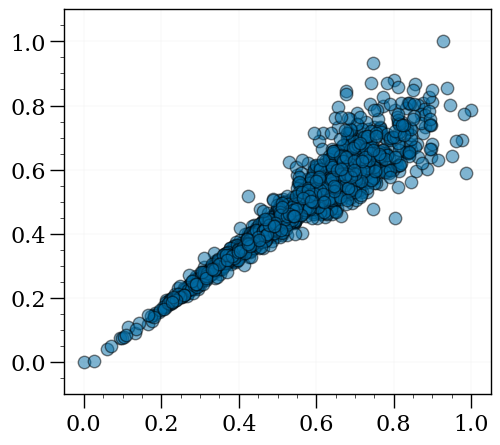

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:28<80:18:10, 28.91s/it]

Iter 0. Loss [[ 0.07411407  0.2926083  19.931568  ]]


  0%|          | 12/10000 [00:55<1:30:47,  1.83it/s]

Iter 10. Loss [[0.07470635 0.27022627 6.0445313 ]]


  0%|          | 22/10000 [00:56<26:05,  6.37it/s]

Iter 20. Loss [[0.07510649 0.2638334  5.493818  ]]


  0%|          | 32/10000 [00:58<25:34,  6.49it/s]

Iter 30. Loss [[0.07588299 0.25557506 5.065343  ]]


  0%|          | 42/10000 [00:59<24:14,  6.85it/s]

Iter 40. Loss [[0.07701059 0.24863829 4.905122  ]]


  1%|          | 52/10000 [01:01<24:40,  6.72it/s]

Iter 50. Loss [[0.07736775 0.2468952  4.8730903 ]]


  1%|          | 62/10000 [01:02<24:51,  6.66it/s]

Iter 60. Loss [[0.07714107 0.24731018 4.782104  ]]


  1%|          | 71/10000 [01:04<40:58,  4.04it/s]

Iter 70. Loss [[0.07735556 0.24551582 4.451804  ]]


  1%|          | 81/10000 [01:06<38:12,  4.33it/s]

Iter 80. Loss [[0.07751261 0.24414605 3.7280283 ]]


  1%|          | 92/10000 [01:09<32:53,  5.02it/s]

Iter 90. Loss [[0.07733066 0.2427782  3.2159111 ]]


  1%|          | 102/10000 [01:10<24:57,  6.61it/s]

Iter 100. Loss [[0.07760785 0.23912643 3.079704  ]]


  1%|          | 112/10000 [01:12<25:04,  6.57it/s]

Iter 110. Loss [[0.07756303 0.24077158 2.6461506 ]]


  1%|          | 122/10000 [01:13<24:27,  6.73it/s]

Iter 120. Loss [[0.0777272  0.24439164 2.226153  ]]


  1%|▏         | 132/10000 [01:15<35:30,  4.63it/s]

Iter 130. Loss [[0.07843451 0.24432501 1.6759747 ]]


  1%|▏         | 142/10000 [01:17<25:40,  6.40it/s]

Iter 140. Loss [[0.07949878 0.23251638 1.514946  ]]


  2%|▏         | 152/10000 [01:18<24:09,  6.79it/s]

Iter 150. Loss [[0.07997714 0.2343132  1.1005547 ]]


  2%|▏         | 161/10000 [01:20<38:16,  4.28it/s]

Iter 160. Loss [[0.08119754 0.23305383 0.78006476]]


  2%|▏         | 171/10000 [01:22<38:58,  4.20it/s]

Iter 170. Loss [[0.08197407 0.23353654 0.7264506 ]]


  2%|▏         | 182/10000 [01:25<25:05,  6.52it/s]

Iter 180. Loss [[0.0822042  0.23204008 0.92728513]]


  2%|▏         | 192/10000 [01:26<23:54,  6.84it/s]

Iter 190. Loss [[0.08241753 0.22819588 0.7735643 ]]


  2%|▏         | 202/10000 [01:27<24:01,  6.80it/s]

Iter 200. Loss [[0.08323906 0.22508101 0.41647494]]


  2%|▏         | 212/10000 [01:29<24:25,  6.68it/s]

Iter 210. Loss [[0.08436479 0.21981382 0.19163252]]


  2%|▏         | 222/10000 [01:30<21:46,  7.48it/s]

Iter 220. Loss [[ 0.08592547  0.21893452 -0.07873516]]


  2%|▏         | 232/10000 [01:32<24:43,  6.58it/s]

Iter 230. Loss [[ 0.08747656  0.22299016 -0.29115346]]


  2%|▏         | 241/10000 [01:34<36:26,  4.46it/s]

Iter 240. Loss [[ 0.0890917   0.22332084 -0.4690533 ]]


  3%|▎         | 251/10000 [01:36<39:40,  4.10it/s]

Iter 250. Loss [[ 0.09092275  0.22109567 -0.5367476 ]]


  3%|▎         | 262/10000 [01:38<25:23,  6.39it/s]

Iter 260. Loss [[ 0.09293311  0.21974777 -0.588356  ]]


  3%|▎         | 272/10000 [01:40<23:58,  6.76it/s]

Iter 270. Loss [[ 0.09535596  0.21843636 -0.65640086]]


  3%|▎         | 282/10000 [01:41<22:09,  7.31it/s]

Iter 280. Loss [[ 0.09827337  0.21783186 -0.75278205]]


  3%|▎         | 292/10000 [01:42<21:15,  7.61it/s]

Iter 290. Loss [[ 0.10119828  0.21098422 -0.825683  ]]


  3%|▎         | 302/10000 [01:44<25:15,  6.40it/s]

Iter 300. Loss [[ 0.10436835  0.20676468 -0.8917229 ]]


  3%|▎         | 311/10000 [01:46<30:59,  5.21it/s]

Iter 310. Loss [[ 0.10823778  0.19864243 -0.9871871 ]]


  3%|▎         | 321/10000 [01:48<41:47,  3.86it/s]

Iter 320. Loss [[ 0.11253785  0.18919179 -1.0654154 ]]


  3%|▎         | 331/10000 [01:51<47:50,  3.37it/s]

Iter 330. Loss [[ 0.11748844  0.17850205 -1.165193  ]]


  3%|▎         | 342/10000 [01:54<36:09,  4.45it/s]

Iter 340. Loss [[ 0.12275489  0.1647567  -1.2455913 ]]


  4%|▎         | 352/10000 [01:55<23:53,  6.73it/s]

Iter 350. Loss [[ 0.12868905  0.1572352  -1.3437965 ]]


  4%|▎         | 362/10000 [01:57<25:43,  6.24it/s]

Iter 360. Loss [[ 0.13407971  0.14166816 -1.3623593 ]]


  4%|▎         | 372/10000 [01:58<21:45,  7.38it/s]

Iter 370. Loss [[ 0.13946761  0.13980389 -1.4155313 ]]


  4%|▍         | 382/10000 [02:00<25:09,  6.37it/s]

Iter 380. Loss [[ 0.14337169  0.13068695 -1.4048773 ]]


  4%|▍         | 392/10000 [02:01<22:37,  7.08it/s]

Iter 390. Loss [[ 0.14551236  0.1292509  -1.4151875 ]]


  4%|▍         | 402/10000 [02:03<23:35,  6.78it/s]

Iter 400. Loss [[ 0.14719151  0.12352116 -1.3903853 ]]


  4%|▍         | 411/10000 [02:04<26:33,  6.02it/s]

Iter 410. Loss [[ 0.14884181  0.12301357 -1.4028682 ]]


  4%|▍         | 421/10000 [02:07<40:19,  3.96it/s]

Iter 420. Loss [[ 0.15093642  0.12135819 -1.3987479 ]]


  4%|▍         | 432/10000 [02:09<26:19,  6.06it/s]

Iter 430. Loss [[ 0.15309355  0.12074804 -1.4016175 ]]


  4%|▍         | 442/10000 [02:10<21:06,  7.55it/s]

Iter 440. Loss [[ 0.15510426  0.12035921 -1.413943  ]]


  5%|▍         | 452/10000 [02:12<22:03,  7.21it/s]

Iter 450. Loss [[ 0.15704136  0.11961032 -1.4289087 ]]


  5%|▍         | 462/10000 [02:13<21:18,  7.46it/s]

Iter 460. Loss [[ 0.15900882  0.1190983  -1.4222438 ]]


  5%|▍         | 472/10000 [02:15<23:10,  6.85it/s]

Iter 470. Loss [[ 0.16102368  0.11850192 -1.4429111 ]]


  5%|▍         | 482/10000 [02:16<21:58,  7.22it/s]

Iter 480. Loss [[ 0.16307637  0.11751428 -1.4219681 ]]


  5%|▍         | 492/10000 [02:17<24:07,  6.57it/s]

Iter 490. Loss [[ 0.16514054  0.1168431  -1.4135556 ]]


  5%|▌         | 501/10000 [02:19<28:23,  5.58it/s]

Iter 500. Loss [[ 0.16717318  0.11628562 -1.4184171 ]]


  5%|▌         | 511/10000 [02:21<38:32,  4.10it/s]

Iter 510. Loss [[ 0.16918664  0.11579303 -1.4105088 ]]


  5%|▌         | 522/10000 [02:24<27:02,  5.84it/s]

Iter 520. Loss [[ 0.17122136  0.11512398 -1.4167093 ]]


  5%|▌         | 532/10000 [02:25<21:07,  7.47it/s]

Iter 530. Loss [[ 0.17325467  0.11464533 -1.4280993 ]]


  5%|▌         | 542/10000 [02:27<24:22,  6.47it/s]

Iter 540. Loss [[ 0.17526156  0.11377554 -1.4342906 ]]


  6%|▌         | 552/10000 [02:28<23:48,  6.61it/s]

Iter 550. Loss [[ 0.17730214  0.11318199 -1.4512883 ]]


  6%|▌         | 562/10000 [02:29<20:57,  7.51it/s]

Iter 560. Loss [[ 0.1793505   0.11316172 -1.4502368 ]]


  6%|▌         | 572/10000 [02:31<23:38,  6.65it/s]

Iter 570. Loss [[ 0.18129998  0.11285329 -1.4810778 ]]


  6%|▌         | 582/10000 [02:32<24:12,  6.48it/s]

Iter 580. Loss [[ 0.1832903   0.11265223 -1.4777412 ]]


  6%|▌         | 591/10000 [02:34<38:25,  4.08it/s]

Iter 590. Loss [[ 0.1851787   0.11244778 -1.5116888 ]]


  6%|▌         | 601/10000 [02:37<39:26,  3.97it/s]

Iter 600. Loss [[ 0.18691352  0.11238977 -1.5112555 ]]


  6%|▌         | 612/10000 [02:39<23:12,  6.74it/s]

Iter 610. Loss [[ 0.18842603  0.11246486 -1.5163481 ]]


  6%|▌         | 622/10000 [02:40<23:59,  6.51it/s]

Iter 620. Loss [[ 0.18980654  0.11220701 -1.520454  ]]


  6%|▋         | 632/10000 [02:42<24:11,  6.45it/s]

Iter 630. Loss [[ 0.19127028  0.11177462 -1.5239744 ]]


  6%|▋         | 642/10000 [02:44<28:01,  5.56it/s]

Iter 640. Loss [[ 0.19257765  0.11212328 -1.5204997 ]]


  7%|▋         | 652/10000 [02:45<23:18,  6.68it/s]

Iter 650. Loss [[ 0.19420187  0.11134437 -1.5244627 ]]


  7%|▋         | 662/10000 [02:47<24:13,  6.43it/s]

Iter 660. Loss [[ 0.19548434  0.11106331 -1.5224943 ]]


  7%|▋         | 671/10000 [02:49<32:38,  4.76it/s]

Iter 670. Loss [[ 0.1964721   0.11081436 -1.5216275 ]]


  7%|▋         | 681/10000 [02:51<34:29,  4.50it/s]

Iter 680. Loss [[ 0.19748689  0.1109033  -1.5203102 ]]


  7%|▋         | 692/10000 [02:53<23:27,  6.62it/s]

Iter 690. Loss [[ 0.19850108  0.11076804 -1.5202597 ]]


  7%|▋         | 702/10000 [02:54<22:46,  6.80it/s]

Iter 700. Loss [[ 0.1994228   0.11061586 -1.5240202 ]]


  7%|▋         | 712/10000 [02:56<21:31,  7.19it/s]

Iter 710. Loss [[ 0.2004925   0.11044943 -1.5248916 ]]


  7%|▋         | 722/10000 [02:57<23:16,  6.64it/s]

Iter 720. Loss [[ 0.20127301  0.11158402 -1.5495583 ]]


  7%|▋         | 732/10000 [02:59<23:26,  6.59it/s]

Iter 730. Loss [[ 0.20195271  0.11033201 -1.5316921 ]]


  7%|▋         | 742/10000 [03:00<24:06,  6.40it/s]

Iter 740. Loss [[ 0.20269594  0.11067784 -1.5448679 ]]


  8%|▊         | 752/10000 [03:02<21:20,  7.22it/s]

Iter 750. Loss [[ 0.20336163  0.11017893 -1.5603129 ]]


  8%|▊         | 761/10000 [03:04<34:25,  4.47it/s]

Iter 760. Loss [[ 0.2039153   0.10995606 -1.561777  ]]


  8%|▊         | 771/10000 [03:06<37:50,  4.07it/s]

Iter 770. Loss [[ 0.2045311   0.11020108 -1.5558614 ]]


  8%|▊         | 782/10000 [03:08<23:23,  6.57it/s]

Iter 780. Loss [[ 0.20499861  0.11036933 -1.5490298 ]]


  8%|▊         | 792/10000 [03:09<22:01,  6.97it/s]

Iter 790. Loss [[ 0.20542021  0.11015254 -1.5447881 ]]


  8%|▊         | 802/10000 [03:11<23:32,  6.51it/s]

Iter 800. Loss [[ 0.20576347  0.10959464 -1.521999  ]]


  8%|▊         | 812/10000 [03:12<22:57,  6.67it/s]

Iter 810. Loss [[ 0.20607384  0.11004148 -1.5101331 ]]


  8%|▊         | 822/10000 [03:13<22:12,  6.89it/s]

Iter 820. Loss [[ 0.20628862  0.11062112 -1.4544924 ]]


  8%|▊         | 832/10000 [03:15<22:26,  6.81it/s]

Iter 830. Loss [[ 0.2062943  0.1105773 -1.4754616]]


  8%|▊         | 841/10000 [03:17<39:50,  3.83it/s]

Iter 840. Loss [[ 0.20588821  0.11120375 -1.4709072 ]]


  9%|▊         | 851/10000 [03:19<37:17,  4.09it/s]

Iter 850. Loss [[ 0.20472418  0.10985389 -1.3744239 ]]


  9%|▊         | 862/10000 [03:21<25:29,  5.97it/s]

Iter 860. Loss [[ 0.20567074  0.1120036  -1.303922  ]]


  9%|▊         | 872/10000 [03:23<22:56,  6.63it/s]

Iter 870. Loss [[ 0.2047293   0.11111701 -1.3504145 ]]


  9%|▉         | 882/10000 [03:24<22:22,  6.79it/s]

Iter 880. Loss [[ 0.20255761  0.1149656  -1.1650676 ]]


  9%|▉         | 892/10000 [03:26<21:54,  6.93it/s]

Iter 890. Loss [[ 0.20370312  0.11244828 -1.3349649 ]]


  9%|▉         | 902/10000 [03:27<22:06,  6.86it/s]

Iter 900. Loss [[ 0.20205468  0.11324913 -1.3079755 ]]


  9%|▉         | 912/10000 [03:29<22:56,  6.60it/s]

Iter 910. Loss [[ 0.20061895  0.11470771 -1.2369083 ]]


  9%|▉         | 922/10000 [03:31<22:22,  6.76it/s]

Iter 920. Loss [[ 0.19964178  0.11489715 -1.1707801 ]]


  9%|▉         | 931/10000 [03:33<36:11,  4.18it/s]

Iter 930. Loss [[ 0.19858994  0.11744292 -1.1605928 ]]


  9%|▉         | 942/10000 [03:35<33:28,  4.51it/s]

Iter 940. Loss [[ 0.1973287   0.11621501 -1.107474  ]]


 10%|▉         | 952/10000 [03:37<24:54,  6.05it/s]

Iter 950. Loss [[ 0.1966231   0.11505092 -1.141003  ]]


 10%|▉         | 962/10000 [03:38<19:57,  7.55it/s]

Iter 960. Loss [[ 0.19746433  0.11247937 -1.1443499 ]]


 10%|▉         | 972/10000 [03:40<22:22,  6.73it/s]

Iter 970. Loss [[ 0.1975307   0.10391319 -1.0724262 ]]


 10%|▉         | 982/10000 [03:41<21:26,  7.01it/s]

Iter 980. Loss [[ 0.19773053  0.10261216 -1.0946405 ]]


 10%|▉         | 992/10000 [03:43<22:54,  6.55it/s]

Iter 990. Loss [[ 0.19838777  0.10919888 -1.1300894 ]]


 10%|█         | 1001/10000 [03:45<59:25,  2.52it/s]

Iter 1000. Loss [[ 0.2001532   0.11064604 -1.1688967 ]]


 10%|█         | 1011/10000 [03:48<42:56,  3.49it/s]

Iter 1010. Loss [[ 0.20234385  0.11771257 -1.2028902 ]]


 10%|█         | 1021/10000 [03:51<37:01,  4.04it/s]

Iter 1020. Loss [[ 0.20591736  0.11815552 -1.2378365 ]]


 10%|█         | 1032/10000 [03:53<22:35,  6.62it/s]

Iter 1030. Loss [[ 0.21100852  0.1145497  -1.2840286 ]]


 10%|█         | 1042/10000 [03:54<21:42,  6.88it/s]

Iter 1040. Loss [[ 0.21747966  0.11508557 -1.3706117 ]]


 11%|█         | 1052/10000 [03:55<21:43,  6.87it/s]

Iter 1050. Loss [[ 0.22592859  0.11380281 -1.4852923 ]]


 11%|█         | 1062/10000 [03:57<22:06,  6.74it/s]

Iter 1060. Loss [[ 0.23525368  0.11020015 -1.6052564 ]]


 11%|█         | 1072/10000 [03:58<21:32,  6.91it/s]

Iter 1070. Loss [[ 0.24190125  0.10848702 -1.7104632 ]]


 11%|█         | 1082/10000 [04:00<22:12,  6.69it/s]

Iter 1080. Loss [[ 0.2438964   0.11119887 -1.7416093 ]]


 11%|█         | 1091/10000 [04:02<35:03,  4.24it/s]

Iter 1090. Loss [[ 0.24499322  0.11395063 -1.718453  ]]


 11%|█         | 1101/10000 [04:04<34:29,  4.30it/s]

Iter 1100. Loss [[ 0.2483347   0.11746954 -1.7790693 ]]


 11%|█         | 1112/10000 [04:06<28:02,  5.28it/s]

Iter 1110. Loss [[ 0.24744272  0.11566023 -1.7771647 ]]


 11%|█         | 1122/10000 [04:08<22:14,  6.65it/s]

Iter 1120. Loss [[ 0.24519905  0.11736019 -1.7632741 ]]


 11%|█▏        | 1132/10000 [04:09<21:31,  6.87it/s]

Iter 1130. Loss [[ 0.24493045  0.12088316 -1.7739396 ]]


 11%|█▏        | 1142/10000 [04:11<21:21,  6.91it/s]

Iter 1140. Loss [[ 0.24591193  0.11351395 -1.7564743 ]]


 12%|█▏        | 1152/10000 [04:12<21:52,  6.74it/s]

Iter 1150. Loss [[ 0.24618839  0.11658795 -1.752832  ]]


 12%|█▏        | 1162/10000 [04:14<21:55,  6.72it/s]

Iter 1160. Loss [[ 0.2464835   0.11981903 -1.7584226 ]]


 12%|█▏        | 1172/10000 [04:15<21:47,  6.75it/s]

Iter 1170. Loss [[ 0.24714193  0.12091003 -1.7672998 ]]


 12%|█▏        | 1181/10000 [04:17<29:13,  5.03it/s]

Iter 1180. Loss [[ 0.2481069  0.1200622 -1.7585785]]


 12%|█▏        | 1191/10000 [04:19<35:15,  4.16it/s]

Iter 1190. Loss [[ 0.24888206  0.12472584 -1.7867646 ]]


 12%|█▏        | 1202/10000 [04:21<24:07,  6.08it/s]

Iter 1200. Loss [[ 0.24914242  0.12291218 -1.7826561 ]]


 12%|█▏        | 1212/10000 [04:23<21:35,  6.79it/s]

Iter 1210. Loss [[ 0.24925934  0.1247947  -1.78227   ]]


 12%|█▏        | 1222/10000 [04:24<21:23,  6.84it/s]

Iter 1220. Loss [[ 0.24980314  0.1238282  -1.8047571 ]]


 12%|█▏        | 1232/10000 [04:26<21:49,  6.70it/s]

Iter 1230. Loss [[ 0.24894984  0.1255754  -1.8065078 ]]


 12%|█▏        | 1242/10000 [04:27<21:42,  6.73it/s]

Iter 1240. Loss [[ 0.24859245  0.12381207 -1.7921677 ]]


 13%|█▎        | 1252/10000 [04:28<21:09,  6.89it/s]

Iter 1250. Loss [[ 0.24866934  0.12526524 -1.7894355 ]]


 13%|█▎        | 1262/10000 [04:30<20:33,  7.08it/s]

Iter 1260. Loss [[ 0.24933662  0.12738478 -1.7869414 ]]


 13%|█▎        | 1271/10000 [04:32<54:32,  2.67it/s]

Iter 1270. Loss [[ 0.24978873  0.13395613 -1.7909788 ]]


 13%|█▎        | 1281/10000 [04:35<36:03,  4.03it/s]

Iter 1280. Loss [[ 0.25135928  0.12655252 -1.785193  ]]


 13%|█▎        | 1292/10000 [04:36<22:07,  6.56it/s]

Iter 1290. Loss [[ 0.2521714   0.12678692 -1.7873211 ]]


 13%|█▎        | 1302/10000 [04:38<21:33,  6.72it/s]

Iter 1300. Loss [[ 0.25162357  0.1303451  -1.7986007 ]]


 13%|█▎        | 1312/10000 [04:39<21:28,  6.74it/s]

Iter 1310. Loss [[ 0.25141495  0.12798917 -1.794851  ]]


 13%|█▎        | 1322/10000 [04:41<21:07,  6.85it/s]

Iter 1320. Loss [[ 0.25161445  0.1259261  -1.7894287 ]]


 13%|█▎        | 1332/10000 [04:42<22:06,  6.53it/s]

Iter 1330. Loss [[ 0.25174618  0.12362298 -1.7787695 ]]


 13%|█▎        | 1342/10000 [04:44<21:07,  6.83it/s]

Iter 1340. Loss [[ 0.2517358   0.13000531 -1.7981614 ]]


 14%|█▎        | 1351/10000 [04:45<27:08,  5.31it/s]

Iter 1350. Loss [[ 0.25172967  0.12884231 -1.7791438 ]]


 14%|█▎        | 1361/10000 [04:48<35:10,  4.09it/s]

Iter 1360. Loss [[ 0.25188264  0.12961806 -1.7786416 ]]


 14%|█▎        | 1372/10000 [04:50<23:33,  6.10it/s]

Iter 1370. Loss [[ 0.25240135  0.12665406 -1.7773808 ]]


 14%|█▍        | 1382/10000 [04:52<22:34,  6.36it/s]

Iter 1380. Loss [[ 0.25225988  0.12575075 -1.7698404 ]]


 14%|█▍        | 1392/10000 [04:53<21:13,  6.76it/s]

Iter 1390. Loss [[ 0.25193205  0.12322577 -1.7710484 ]]


 14%|█▍        | 1402/10000 [04:55<20:12,  7.09it/s]

Iter 1400. Loss [[ 0.2520816   0.12442582 -1.762109  ]]


 14%|█▍        | 1412/10000 [04:56<18:50,  7.60it/s]

Iter 1410. Loss [[ 0.2523334   0.12786199 -1.7563659 ]]


 14%|█▍        | 1422/10000 [04:58<21:32,  6.64it/s]

Iter 1420. Loss [[ 0.25258997  0.13051829 -1.7601393 ]]


 14%|█▍        | 1432/10000 [04:59<21:17,  6.71it/s]

Iter 1430. Loss [[ 0.25240266  0.12458494 -1.7729313 ]]


 14%|█▍        | 1441/10000 [05:01<33:07,  4.31it/s]

Iter 1440. Loss [[ 0.25200033  0.12187813 -1.7858701 ]]


 15%|█▍        | 1451/10000 [05:03<34:15,  4.16it/s]

Iter 1450. Loss [[ 0.25198334  0.12862337 -1.793833  ]]


 15%|█▍        | 1462/10000 [05:05<22:10,  6.42it/s]

Iter 1460. Loss [[ 0.25165826  0.12236293 -1.8007956 ]]


 15%|█▍        | 1472/10000 [05:07<21:42,  6.55it/s]

Iter 1470. Loss [[ 0.25123173  0.12202235 -1.806226  ]]


 15%|█▍        | 1482/10000 [05:08<19:24,  7.31it/s]

Iter 1480. Loss [[ 0.25072816  0.12886256 -1.813359  ]]


 15%|█▍        | 1492/10000 [05:10<34:30,  4.11it/s]

Iter 1490. Loss [[ 0.25101566  0.1186029  -1.8139431 ]]


 15%|█▌        | 1502/10000 [05:11<22:11,  6.38it/s]

Iter 1500. Loss [[ 0.2509822  0.1137335 -1.8033652]]


 15%|█▌        | 1512/10000 [05:13<18:32,  7.63it/s]

Iter 1510. Loss [[ 0.2513279   0.11222069 -1.8037213 ]]


 15%|█▌        | 1521/10000 [05:14<24:13,  5.83it/s]

Iter 1520. Loss [[ 0.25071418  0.1264136  -1.8103526 ]]


 15%|█▌        | 1531/10000 [05:16<32:46,  4.31it/s]

Iter 1530. Loss [[ 0.25135103  0.11375488 -1.7925087 ]]


 15%|█▌        | 1542/10000 [05:19<25:58,  5.43it/s]

Iter 1540. Loss [[ 0.2511759   0.12086877 -1.8122182 ]]


 16%|█▌        | 1552/10000 [05:20<20:50,  6.76it/s]

Iter 1550. Loss [[ 0.25155303  0.11652726 -1.8018051 ]]


 16%|█▌        | 1562/10000 [05:22<30:05,  4.67it/s]

Iter 1560. Loss [[ 0.25165555  0.11510704 -1.7871605 ]]


 16%|█▌        | 1572/10000 [05:23<19:15,  7.30it/s]

Iter 1570. Loss [[ 0.25169086  0.11508299 -1.7816384 ]]


 16%|█▌        | 1582/10000 [05:25<21:13,  6.61it/s]

Iter 1580. Loss [[ 0.2521948   0.11364449 -1.7710239 ]]


 16%|█▌        | 1592/10000 [05:26<20:13,  6.93it/s]

Iter 1590. Loss [[ 0.2521324   0.11300009 -1.77498   ]]


 16%|█▌        | 1602/10000 [05:28<19:06,  7.32it/s]

Iter 1600. Loss [[ 0.25405416  0.11560059 -1.6287568 ]]


 16%|█▌        | 1611/10000 [05:29<30:08,  4.64it/s]

Iter 1610. Loss [[ 0.25491485  0.11799815 -1.6335781 ]]


 16%|█▌        | 1621/10000 [05:32<35:46,  3.90it/s]

Iter 1620. Loss [[ 0.2543718   0.11105274 -1.6428424 ]]


 16%|█▋        | 1632/10000 [05:34<19:04,  7.31it/s]

Iter 1630. Loss [[ 0.2536414   0.11566669 -1.4945767 ]]


 16%|█▋        | 1642/10000 [05:35<19:14,  7.24it/s]

Iter 1640. Loss [[ 0.25395766  0.10239325 -1.6582187 ]]


 17%|█▋        | 1652/10000 [05:37<19:53,  6.99it/s]

Iter 1650. Loss [[ 0.25427115  0.1013725  -1.6627362 ]]


 17%|█▋        | 1662/10000 [05:38<20:59,  6.62it/s]

Iter 1660. Loss [[ 0.2521993   0.10445685 -1.5300249 ]]


 17%|█▋        | 1672/10000 [05:40<21:00,  6.61it/s]

Iter 1670. Loss [[ 0.2525621   0.09817753 -1.7017454 ]]


 17%|█▋        | 1682/10000 [05:41<21:21,  6.49it/s]

Iter 1680. Loss [[ 0.25188318  0.08575329 -1.8544593 ]]


 17%|█▋        | 1691/10000 [05:43<33:05,  4.18it/s]

Iter 1690. Loss [[ 0.24764407  0.08912849 -1.7043452 ]]


 17%|█▋        | 1701/10000 [05:46<48:22,  2.86it/s]

Iter 1700. Loss [[ 0.25083324  0.09010018 -1.6287845 ]]


 17%|█▋        | 1711/10000 [05:49<36:08,  3.82it/s]

Iter 1710. Loss [[ 0.25404063  0.08839555 -1.7100146 ]]


 17%|█▋        | 1722/10000 [05:51<22:13,  6.21it/s]

Iter 1720. Loss [[ 0.2543733   0.08493451 -1.8072007 ]]


 17%|█▋        | 1732/10000 [05:52<20:09,  6.84it/s]

Iter 1730. Loss [[ 0.25026357  0.08899585 -1.7043031 ]]


 17%|█▋        | 1742/10000 [05:54<19:36,  7.02it/s]

Iter 1740. Loss [[ 0.24744397  0.08678796 -1.6284317 ]]


 18%|█▊        | 1752/10000 [05:55<19:59,  6.87it/s]

Iter 1750. Loss [[ 0.24422769  0.08973332 -1.579954  ]]


 18%|█▊        | 1762/10000 [05:57<19:51,  6.91it/s]

Iter 1760. Loss [[ 0.24394841  0.07813672 -1.4965171 ]]


 18%|█▊        | 1772/10000 [05:58<19:53,  6.89it/s]

Iter 1770. Loss [[ 0.2488327  0.0949163 -1.4871416]]


 18%|█▊        | 1782/10000 [05:59<20:10,  6.79it/s]

Iter 1780. Loss [[ 0.23768081  0.07888257 -1.2817571 ]]


 18%|█▊        | 1791/10000 [06:01<29:47,  4.59it/s]

Iter 1790. Loss [[ 0.25415328  0.06816565 -1.4636766 ]]


 18%|█▊        | 1801/10000 [06:04<55:00,  2.48it/s]

Iter 1800. Loss [[ 0.24427314  0.07640554 -1.7159153 ]]


 18%|█▊        | 1812/10000 [06:06<21:05,  6.47it/s]

Iter 1810. Loss [[ 0.24361742  0.04545922 -1.149407  ]]


 18%|█▊        | 1822/10000 [06:07<20:08,  6.77it/s]

Iter 1820. Loss [[ 0.2561503   0.05665408 -1.0581037 ]]


 18%|█▊        | 1832/10000 [06:09<19:30,  6.98it/s]

Iter 1830. Loss [[ 0.25212872  0.0465195  -1.1029344 ]]


 18%|█▊        | 1842/10000 [06:10<19:31,  6.97it/s]

Iter 1840. Loss [[ 0.25048277  0.04395904 -1.0788414 ]]


 19%|█▊        | 1852/10000 [06:12<19:10,  7.08it/s]

Iter 1850. Loss [[ 0.25282204  0.04616791 -1.0148326 ]]


 19%|█▊        | 1862/10000 [06:13<20:19,  6.68it/s]

Iter 1860. Loss [[ 0.2519835  0.044841  -1.0866103]]


 19%|█▊        | 1871/10000 [06:15<39:04,  3.47it/s]

Iter 1870. Loss [[ 0.25310677  0.04569807 -1.0767783 ]]


 19%|█▉        | 1881/10000 [06:17<32:01,  4.23it/s]

Iter 1880. Loss [[ 0.25286537  0.04525129 -1.0681951 ]]


 19%|█▉        | 1892/10000 [06:19<24:54,  5.42it/s]

Iter 1890. Loss [[ 0.25217426  0.04557316 -1.1245915 ]]


 19%|█▉        | 1902/10000 [06:21<19:44,  6.84it/s]

Iter 1900. Loss [[ 0.25350946  0.04672198 -1.1003957 ]]


 19%|█▉        | 1912/10000 [06:22<19:53,  6.78it/s]

Iter 1910. Loss [[ 0.25239372  0.04503997 -1.0567539 ]]


 19%|█▉        | 1922/10000 [06:24<21:24,  6.29it/s]

Iter 1920. Loss [[ 0.25160262  0.04391683 -1.0474306 ]]


 19%|█▉        | 1932/10000 [06:26<18:38,  7.21it/s]

Iter 1930. Loss [[ 0.2512877   0.04468191 -1.1316007 ]]


 19%|█▉        | 1942/10000 [06:27<18:32,  7.24it/s]

Iter 1940. Loss [[ 0.25290272  0.04616846 -1.127832  ]]


 20%|█▉        | 1952/10000 [06:28<19:27,  6.89it/s]

Iter 1950. Loss [[ 0.25217327  0.04622137 -1.1554135 ]]


 20%|█▉        | 1961/10000 [06:30<27:40,  4.84it/s]

Iter 1960. Loss [[ 0.25219464  0.04475108 -1.0524203 ]]


 20%|█▉        | 1971/10000 [06:32<31:26,  4.26it/s]

Iter 1970. Loss [[ 0.25049177  0.04317473 -1.1021175 ]]


 20%|█▉        | 1982/10000 [06:34<21:26,  6.23it/s]

Iter 1980. Loss [[ 0.25178674  0.0442315  -1.1003122 ]]


 20%|█▉        | 1992/10000 [06:36<22:23,  5.96it/s]

Iter 1990. Loss [[ 0.25242838  0.04453162 -1.0700269 ]]


 20%|██        | 2002/10000 [06:38<19:21,  6.89it/s]

Iter 2000. Loss [[ 0.2516132   0.04348616 -1.0736569 ]]


 20%|██        | 2012/10000 [06:39<19:14,  6.92it/s]

Iter 2010. Loss [[ 0.2509607   0.04392913 -1.1361899 ]]


 20%|██        | 2022/10000 [06:40<19:06,  6.96it/s]

Iter 2020. Loss [[ 0.2525625   0.04739191 -1.1973443 ]]


 20%|██        | 2032/10000 [06:42<19:34,  6.78it/s]

Iter 2030. Loss [[ 0.25208044  0.04461547 -1.1002063 ]]


 20%|██        | 2042/10000 [06:43<18:50,  7.04it/s]

Iter 2040. Loss [[ 0.2505898   0.04271882 -1.0709972 ]]


 21%|██        | 2051/10000 [06:45<30:14,  4.38it/s]

Iter 2050. Loss [[ 0.25055918  0.04317724 -1.1190082 ]]


 21%|██        | 2061/10000 [06:48<31:34,  4.19it/s]

Iter 2060. Loss [[ 0.25244263  0.0444993  -1.055674  ]]


 21%|██        | 2072/10000 [06:49<18:28,  7.15it/s]

Iter 2070. Loss [[ 0.25110832  0.04261533 -1.0472323 ]]


 21%|██        | 2082/10000 [06:51<18:37,  7.08it/s]

Iter 2080. Loss [[ 0.25142208  0.04279978 -1.0699259 ]]


 21%|██        | 2092/10000 [06:52<19:10,  6.87it/s]

Iter 2090. Loss [[ 0.25104746  0.04528421 -1.1953504 ]]


 21%|██        | 2102/10000 [06:54<18:48,  7.00it/s]

Iter 2100. Loss [[ 0.25171825  0.04304084 -1.0707455 ]]


 21%|██        | 2112/10000 [06:55<18:52,  6.97it/s]

Iter 2110. Loss [[ 0.25117496  0.04641927 -1.2238208 ]]


 21%|██        | 2122/10000 [06:56<19:02,  6.90it/s]

Iter 2120. Loss [[ 0.2524201   0.04480994 -1.1202954 ]]


 21%|██▏       | 2132/10000 [06:58<18:51,  6.95it/s]

Iter 2130. Loss [[ 0.24988636  0.043911   -1.1774685 ]]


 21%|██▏       | 2141/10000 [07:00<32:54,  3.98it/s]

Iter 2140. Loss [[ 0.25096747  0.04294372 -1.0730951 ]]


 22%|██▏       | 2152/10000 [07:03<24:34,  5.32it/s]

Iter 2150. Loss [[ 0.2510409   0.04279415 -1.047701  ]]


 22%|██▏       | 2162/10000 [07:04<19:09,  6.82it/s]

Iter 2160. Loss [[ 0.2506863   0.04197737 -1.0579804 ]]


 22%|██▏       | 2172/10000 [07:06<19:19,  6.75it/s]

Iter 2170. Loss [[ 0.2513011   0.04255964 -1.0889264 ]]


 22%|██▏       | 2182/10000 [07:07<18:55,  6.89it/s]

Iter 2180. Loss [[ 0.2512135   0.04468064 -1.1840024 ]]


 22%|██▏       | 2192/10000 [07:09<19:30,  6.67it/s]

Iter 2190. Loss [[ 0.25114864  0.04322659 -1.1278784 ]]


 22%|██▏       | 2202/10000 [07:10<30:27,  4.27it/s]

Iter 2200. Loss [[ 0.24984418  0.04408902 -1.1969739 ]]


 22%|██▏       | 2212/10000 [07:12<19:53,  6.53it/s]

Iter 2210. Loss [[ 0.2512147   0.04301152 -1.0933039 ]]


 22%|██▏       | 2221/10000 [07:14<28:05,  4.61it/s]

Iter 2220. Loss [[ 0.2502123   0.04412756 -1.1885563 ]]


 22%|██▏       | 2231/10000 [07:16<31:07,  4.16it/s]

Iter 2230. Loss [[ 0.25184995  0.04414742 -1.1010243 ]]


 22%|██▏       | 2242/10000 [07:18<20:00,  6.46it/s]

Iter 2240. Loss [[ 0.24919775  0.04084574 -1.0556917 ]]


 23%|██▎       | 2252/10000 [07:20<30:24,  4.25it/s]

Iter 2250. Loss [[ 0.2502641   0.04157465 -1.0651928 ]]


 23%|██▎       | 2262/10000 [07:21<19:06,  6.75it/s]

Iter 2260. Loss [[ 0.25112277  0.04224139 -1.0821773 ]]


 23%|██▎       | 2272/10000 [07:23<18:42,  6.89it/s]

Iter 2270. Loss [[ 0.25132588  0.04227217 -1.0588416 ]]


 23%|██▎       | 2282/10000 [07:24<18:49,  6.83it/s]

Iter 2280. Loss [[ 0.25031528  0.04160002 -1.1089483 ]]


 23%|██▎       | 2292/10000 [07:26<18:27,  6.96it/s]

Iter 2290. Loss [[ 0.25161156  0.04251035 -1.0588242 ]]


 23%|██▎       | 2302/10000 [07:27<18:52,  6.80it/s]

Iter 2300. Loss [[ 0.24969783  0.04349057 -1.1980381 ]]


 23%|██▎       | 2311/10000 [07:29<29:58,  4.28it/s]

Iter 2310. Loss [[ 0.25162363  0.04306955 -1.1150641 ]]


 23%|██▎       | 2322/10000 [07:32<27:41,  4.62it/s]

Iter 2320. Loss [[ 0.2511078   0.04237778 -1.0644264 ]]


 23%|██▎       | 2332/10000 [07:33<18:38,  6.86it/s]

Iter 2330. Loss [[ 0.2497175   0.04077192 -1.054287  ]]


 23%|██▎       | 2342/10000 [07:35<24:12,  5.27it/s]

Iter 2340. Loss [[ 0.250397    0.04170992 -1.1120797 ]]


 24%|██▎       | 2352/10000 [07:36<18:21,  6.94it/s]

Iter 2350. Loss [[ 0.25055486  0.04377148 -1.1897869 ]]


 24%|██▎       | 2362/10000 [07:38<18:44,  6.79it/s]

Iter 2360. Loss [[ 0.24984278  0.04324118 -1.189166  ]]


 24%|██▎       | 2372/10000 [07:39<18:51,  6.74it/s]

Iter 2370. Loss [[ 0.2503798   0.04273397 -1.1508738 ]]


 24%|██▍       | 2382/10000 [07:41<18:41,  6.79it/s]

Iter 2380. Loss [[ 0.24966386  0.04547504 -1.2500275 ]]


 24%|██▍       | 2391/10000 [07:43<33:41,  3.76it/s]

Iter 2390. Loss [[ 0.24955037  0.04408009 -1.2116734 ]]


 24%|██▍       | 2401/10000 [07:45<35:54,  3.53it/s]

Iter 2400. Loss [[ 0.24852061  0.04152694 -1.1558841 ]]


 24%|██▍       | 2411/10000 [07:49<55:55,  2.26it/s]

Iter 2410. Loss [[ 0.24938712  0.04333812 -1.1981575 ]]


 24%|██▍       | 2422/10000 [07:50<19:08,  6.60it/s]

Iter 2420. Loss [[ 0.24974869  0.04166311 -1.1201842 ]]


 24%|██▍       | 2432/10000 [07:52<17:00,  7.42it/s]

Iter 2430. Loss [[ 0.24877815  0.04140947 -1.1553519 ]]


 24%|██▍       | 2442/10000 [07:53<16:39,  7.56it/s]

Iter 2440. Loss [[ 0.25055733  0.04268028 -1.1431704 ]]


 25%|██▍       | 2452/10000 [07:54<16:57,  7.42it/s]

Iter 2450. Loss [[ 0.24940601  0.04076898 -1.0958048 ]]


 25%|██▍       | 2462/10000 [07:56<16:43,  7.51it/s]

Iter 2460. Loss [[ 0.24858104  0.04298631 -1.2157594 ]]


 25%|██▍       | 2472/10000 [07:57<17:43,  7.08it/s]

Iter 2470. Loss [[ 0.2508774   0.04524209 -1.2244605 ]]


 25%|██▍       | 2482/10000 [07:59<30:56,  4.05it/s]

Iter 2480. Loss [[ 0.25011954  0.04187747 -1.0471618 ]]


 25%|██▍       | 2491/10000 [08:01<29:20,  4.27it/s]

Iter 2490. Loss [[ 0.24799806  0.03919833 -1.0426943 ]]


 25%|██▌       | 2502/10000 [08:04<26:29,  4.72it/s]

Iter 2500. Loss [[ 0.25039527  0.04130585 -1.1052443 ]]


 25%|██▌       | 2512/10000 [08:05<18:40,  6.68it/s]

Iter 2510. Loss [[ 0.25083587  0.04137725 -1.0665635 ]]


 25%|██▌       | 2522/10000 [08:07<18:34,  6.71it/s]

Iter 2520. Loss [[ 0.24933003  0.04084434 -1.137413  ]]


 25%|██▌       | 2532/10000 [08:08<26:03,  4.78it/s]

Iter 2530. Loss [[ 0.25087565  0.04234452 -1.1415268 ]]


 25%|██▌       | 2542/10000 [08:10<18:09,  6.85it/s]

Iter 2540. Loss [[ 0.24983798  0.04057828 -1.0639518 ]]


 26%|██▌       | 2552/10000 [08:11<17:56,  6.92it/s]

Iter 2550. Loss [[ 0.24908736  0.04016534 -1.107594  ]]


 26%|██▌       | 2562/10000 [08:13<17:38,  7.03it/s]

Iter 2560. Loss [[ 0.2501047  0.0418685 -1.1522115]]


 26%|██▌       | 2571/10000 [08:14<25:12,  4.91it/s]

Iter 2570. Loss [[ 0.25023213  0.04127009 -1.1093626 ]]


 26%|██▌       | 2581/10000 [08:17<28:35,  4.33it/s]

Iter 2580. Loss [[ 0.24842289  0.0428882  -1.2227297 ]]


 26%|██▌       | 2592/10000 [08:19<20:10,  6.12it/s]

Iter 2590. Loss [[ 0.25109     0.04254738 -1.1082643 ]]


 26%|██▌       | 2602/10000 [08:20<16:29,  7.48it/s]

Iter 2600. Loss [[ 0.2481237   0.04077819 -1.1584376 ]]


 26%|██▌       | 2612/10000 [08:22<18:25,  6.68it/s]

Iter 2610. Loss [[ 0.24922301  0.04243834 -1.1868992 ]]


 26%|██▌       | 2622/10000 [08:23<18:43,  6.57it/s]

Iter 2620. Loss [[ 0.24886976  0.04253002 -1.198211  ]]


 26%|██▋       | 2632/10000 [08:24<17:13,  7.13it/s]

Iter 2630. Loss [[ 0.24847864  0.04139406 -1.1696047 ]]


 26%|██▋       | 2642/10000 [08:26<18:35,  6.60it/s]

Iter 2640. Loss [[ 0.24902292  0.04077053 -1.124223  ]]


 27%|██▋       | 2652/10000 [08:27<15:47,  7.75it/s]

Iter 2650. Loss [[ 0.24887984  0.04014156 -1.1003007 ]]


 27%|██▋       | 2661/10000 [08:29<25:33,  4.79it/s]

Iter 2660. Loss [[ 0.24818759  0.04153802 -1.1929315 ]]


 27%|██▋       | 2671/10000 [08:31<28:26,  4.29it/s]

Iter 2670. Loss [[ 0.2505056   0.04133948 -1.0734771 ]]


 27%|██▋       | 2682/10000 [08:33<17:37,  6.92it/s]

Iter 2680. Loss [[ 0.24878556  0.03938748 -1.0646248 ]]


 27%|██▋       | 2692/10000 [08:35<18:04,  6.74it/s]

Iter 2690. Loss [[ 0.24979892  0.0402505  -1.0856736 ]]


 27%|██▋       | 2702/10000 [08:37<19:32,  6.22it/s]

Iter 2700. Loss [[ 0.2494292   0.04098146 -1.1503297 ]]


 27%|██▋       | 2712/10000 [08:38<15:29,  7.84it/s]

Iter 2710. Loss [[ 0.24993587  0.04029944 -1.0620265 ]]


 27%|██▋       | 2722/10000 [08:39<17:21,  6.99it/s]

Iter 2720. Loss [[ 0.24871545  0.04085344 -1.1646993 ]]


 27%|██▋       | 2732/10000 [08:41<17:21,  6.98it/s]

Iter 2730. Loss [[ 0.24965179  0.04105717 -1.1451938 ]]


 27%|██▋       | 2742/10000 [08:43<29:43,  4.07it/s]

Iter 2740. Loss [[ 0.2493817   0.03991361 -1.0821844 ]]


 28%|██▊       | 2751/10000 [08:45<38:03,  3.18it/s]

Iter 2750. Loss [[ 0.25002497  0.04049753 -1.0631887 ]]


 28%|██▊       | 2761/10000 [08:49<41:11,  2.93it/s]

Iter 2760. Loss [[ 0.24944428  0.03996823 -1.072549  ]]


 28%|██▊       | 2772/10000 [08:51<19:28,  6.18it/s]

Iter 2770. Loss [[ 0.2493028   0.04095214 -1.1542687 ]]


 28%|██▊       | 2782/10000 [08:52<17:37,  6.83it/s]

Iter 2780. Loss [[ 0.25050455  0.04118844 -1.1011927 ]]


 28%|██▊       | 2792/10000 [08:54<17:48,  6.75it/s]

Iter 2790. Loss [[ 0.24821834  0.04017939 -1.1497878 ]]


 28%|██▊       | 2802/10000 [08:55<18:07,  6.62it/s]

Iter 2800. Loss [[ 0.24875817  0.04193219 -1.1971185 ]]


 28%|██▊       | 2812/10000 [08:57<30:29,  3.93it/s]

Iter 2810. Loss [[ 0.24851614  0.04283442 -1.2273628 ]]


 28%|██▊       | 2822/10000 [08:59<17:15,  6.93it/s]

Iter 2820. Loss [[ 0.25038007  0.04164693 -1.0874873 ]]


 28%|██▊       | 2831/10000 [09:00<23:28,  5.09it/s]

Iter 2830. Loss [[ 0.2468617   0.03971168 -1.1624802 ]]


 28%|██▊       | 2841/10000 [09:02<27:15,  4.38it/s]

Iter 2840. Loss [[ 0.24978201  0.04209069 -1.1738231 ]]


 29%|██▊       | 2852/10000 [09:05<23:43,  5.02it/s]

Iter 2850. Loss [[ 0.2493885   0.04035245 -1.0844278 ]]


 29%|██▊       | 2862/10000 [09:06<16:11,  7.35it/s]

Iter 2860. Loss [[ 0.24700905  0.04024161 -1.1809118 ]]


 29%|██▊       | 2872/10000 [09:07<17:43,  6.70it/s]

Iter 2870. Loss [[ 0.2505082   0.04390328 -1.2128946 ]]


 29%|██▉       | 2882/10000 [09:09<17:27,  6.80it/s]

Iter 2880. Loss [[ 0.24850053  0.03956959 -1.0516803 ]]


 29%|██▉       | 2892/10000 [09:10<17:25,  6.80it/s]

Iter 2890. Loss [[ 0.24722618  0.03875552 -1.11938   ]]


 29%|██▉       | 2902/10000 [09:12<17:45,  6.66it/s]

Iter 2900. Loss [[ 0.25020722  0.04301113 -1.2020566 ]]


 29%|██▉       | 2912/10000 [09:13<17:25,  6.78it/s]

Iter 2910. Loss [[ 0.24924456  0.04143567 -1.170798  ]]


 29%|██▉       | 2921/10000 [09:15<18:12,  6.48it/s]

Iter 2920. Loss [[ 0.24843372  0.03946378 -1.0853189 ]]


 29%|██▉       | 2931/10000 [09:17<26:23,  4.46it/s]

Iter 2930. Loss [[ 0.24804042  0.03949856 -1.1271174 ]]


 29%|██▉       | 2942/10000 [09:19<24:10,  4.87it/s]

Iter 2940. Loss [[ 0.25021762  0.04304697 -1.1964269 ]]


 30%|██▉       | 2952/10000 [09:21<18:08,  6.48it/s]

Iter 2950. Loss [[ 0.24828155  0.03927277 -1.064108  ]]


 30%|██▉       | 2962/10000 [09:22<15:34,  7.53it/s]

Iter 2960. Loss [[ 0.24750826  0.03882496 -1.1153845 ]]


 30%|██▉       | 2972/10000 [09:24<16:43,  7.00it/s]

Iter 2970. Loss [[ 0.24941064  0.0410597  -1.1602392 ]]


 30%|██▉       | 2982/10000 [09:25<17:46,  6.58it/s]

Iter 2980. Loss [[ 0.24949367  0.03989989 -1.0471998 ]]


 30%|██▉       | 2992/10000 [09:26<15:25,  7.57it/s]

Iter 2990. Loss [[ 0.24870168  0.03907391 -1.0843133 ]]


 30%|███       | 3002/10000 [09:28<16:31,  7.06it/s]

Iter 3000. Loss [[ 0.2507137   0.04088353 -1.0739274 ]]


 30%|███       | 3011/10000 [09:29<17:59,  6.47it/s]

Iter 3010. Loss [[ 0.24850318  0.0394575  -1.1212977 ]]


 30%|███       | 3021/10000 [09:31<27:03,  4.30it/s]

Iter 3020. Loss [[ 0.25025666  0.04060869 -1.054784  ]]


 30%|███       | 3032/10000 [09:34<19:39,  5.91it/s]

Iter 3030. Loss [[ 0.24869953  0.03912729 -1.0869462 ]]


 30%|███       | 3042/10000 [09:36<16:53,  6.87it/s]

Iter 3040. Loss [[ 0.25042626  0.0437783  -1.2224184 ]]


 31%|███       | 3052/10000 [09:37<16:48,  6.89it/s]

Iter 3050. Loss [[ 0.24928254  0.04163719 -1.1702707 ]]


 31%|███       | 3062/10000 [09:38<15:25,  7.50it/s]

Iter 3060. Loss [[ 0.24655962  0.03946088 -1.1594944 ]]


 31%|███       | 3072/10000 [09:40<16:41,  6.91it/s]

Iter 3070. Loss [[ 0.24861126  0.03986521 -1.1025131 ]]


 31%|███       | 3081/10000 [09:42<24:54,  4.63it/s]

Iter 3080. Loss [[ 0.24717806  0.04225456 -1.2403855 ]]


 31%|███       | 3091/10000 [09:44<33:45,  3.41it/s]

Iter 3090. Loss [[ 0.25017872  0.04101213 -1.1058463 ]]


 31%|███       | 3101/10000 [09:47<29:29,  3.90it/s]

Iter 3100. Loss [[ 0.2484467   0.03910612 -1.0701022 ]]


 31%|███       | 3112/10000 [09:50<23:03,  4.98it/s]

Iter 3110. Loss [[ 0.2485067   0.03923868 -1.1051406 ]]


 31%|███       | 3122/10000 [09:51<16:39,  6.88it/s]

Iter 3120. Loss [[ 0.250949    0.04321737 -1.1878178 ]]


 31%|███▏      | 3132/10000 [09:53<20:36,  5.55it/s]

Iter 3130. Loss [[ 0.24728814  0.04197384 -1.2315257 ]]


 31%|███▏      | 3142/10000 [09:54<15:08,  7.55it/s]

Iter 3140. Loss [[ 0.2480339   0.04005091 -1.1407733 ]]


 32%|███▏      | 3152/10000 [09:55<15:10,  7.52it/s]

Iter 3150. Loss [[ 0.2483562   0.03957773 -1.0437002 ]]


 32%|███▏      | 3162/10000 [09:57<16:38,  6.85it/s]

Iter 3160. Loss [[ 0.24809796  0.03860672 -1.0709955 ]]


 32%|███▏      | 3172/10000 [09:58<16:30,  6.89it/s]

Iter 3170. Loss [[ 0.24994792  0.04058763 -1.1277962 ]]


 32%|███▏      | 3181/10000 [10:00<33:31,  3.39it/s]

Iter 3180. Loss [[ 0.24899134  0.03990063 -1.1284308 ]]


 32%|███▏      | 3191/10000 [10:02<27:30,  4.13it/s]

Iter 3190. Loss [[ 0.24801134  0.04088526 -1.1902443 ]]


 32%|███▏      | 3202/10000 [10:05<18:16,  6.20it/s]

Iter 3200. Loss [[ 0.24846534  0.04068496 -1.1707772 ]]


 32%|███▏      | 3212/10000 [10:06<15:49,  7.15it/s]

Iter 3210. Loss [[ 0.24818675  0.03910822 -1.1004237 ]]


 32%|███▏      | 3222/10000 [10:07<16:23,  6.89it/s]

Iter 3220. Loss [[ 0.24858946  0.03980336 -1.1291071 ]]


 32%|███▏      | 3232/10000 [10:09<16:37,  6.79it/s]

Iter 3230. Loss [[ 0.24857773  0.0396382  -1.1217054 ]]


 32%|███▏      | 3242/10000 [10:10<16:20,  6.89it/s]

Iter 3240. Loss [[ 0.247829    0.04166996 -1.2167828 ]]


 33%|███▎      | 3252/10000 [10:12<17:09,  6.56it/s]

Iter 3250. Loss [[ 0.24884257  0.04379763 -1.2519573 ]]


 33%|███▎      | 3262/10000 [10:13<23:27,  4.79it/s]

Iter 3260. Loss [[ 0.24620162  0.04086516 -1.2193606 ]]


 33%|███▎      | 3271/10000 [10:15<26:08,  4.29it/s]

Iter 3270. Loss [[ 0.24863087  0.0398061  -1.113885  ]]


 33%|███▎      | 3281/10000 [10:18<26:37,  4.20it/s]

Iter 3280. Loss [[ 0.24850778  0.03910021 -1.0727389 ]]


 33%|███▎      | 3292/10000 [10:20<16:57,  6.59it/s]

Iter 3290. Loss [[ 0.24810757  0.03995438 -1.1585886 ]]


 33%|███▎      | 3302/10000 [10:21<16:54,  6.60it/s]

Iter 3300. Loss [[ 0.2501937  0.0407981 -1.1101457]]


 33%|███▎      | 3312/10000 [10:23<16:15,  6.86it/s]

Iter 3310. Loss [[ 0.24747945  0.03887895 -1.1267517 ]]


 33%|███▎      | 3322/10000 [10:24<19:39,  5.66it/s]

Iter 3320. Loss [[ 0.24902698  0.03951224 -1.0464422 ]]


 33%|███▎      | 3332/10000 [10:26<15:54,  6.99it/s]

Iter 3330. Loss [[ 0.24831961  0.03913247 -1.117019  ]]


 33%|███▎      | 3342/10000 [10:27<16:20,  6.79it/s]

Iter 3340. Loss [[ 0.25025725  0.04034503 -1.059887  ]]


 34%|███▎      | 3351/10000 [10:29<21:23,  5.18it/s]

Iter 3350. Loss [[ 0.24814917  0.03881079 -1.1052996 ]]


 34%|███▎      | 3361/10000 [10:32<35:00,  3.16it/s]

Iter 3360. Loss [[ 0.25002402  0.04071599 -1.1258448 ]]


 34%|███▎      | 3372/10000 [10:34<17:54,  6.17it/s]

Iter 3370. Loss [[ 0.24719876  0.04167581 -1.2270571 ]]


 34%|███▍      | 3382/10000 [10:35<16:23,  6.73it/s]

Iter 3380. Loss [[ 0.24955659  0.04303483 -1.2133174 ]]


 34%|███▍      | 3392/10000 [10:37<15:50,  6.95it/s]

Iter 3390. Loss [[ 0.24810992  0.03966573 -1.1005125 ]]


 34%|███▍      | 3402/10000 [10:38<16:10,  6.80it/s]

Iter 3400. Loss [[ 0.2467271   0.03854659 -1.1233834 ]]


 34%|███▍      | 3412/10000 [10:40<15:54,  6.90it/s]

Iter 3410. Loss [[ 0.24910183  0.03972095 -1.0357441 ]]


 34%|███▍      | 3422/10000 [10:41<18:21,  5.97it/s]

Iter 3420. Loss [[ 0.24874517  0.03880546 -1.0686911 ]]


 34%|███▍      | 3431/10000 [10:43<16:13,  6.75it/s]

Iter 3430. Loss [[ 0.24988356  0.04196518 -1.1883208 ]]


 34%|███▍      | 3441/10000 [10:45<26:35,  4.11it/s]

Iter 3440. Loss [[ 0.25028953  0.04106032 -1.1099285 ]]


 35%|███▍      | 3452/10000 [10:47<22:34,  4.83it/s]

Iter 3450. Loss [[ 0.2468585  0.0380095 -1.0828438]]


 35%|███▍      | 3462/10000 [10:49<15:22,  7.08it/s]

Iter 3460. Loss [[ 0.24830325  0.04033898 -1.1634704 ]]


 35%|███▍      | 3472/10000 [10:50<15:34,  6.99it/s]

Iter 3470. Loss [[ 0.24969995  0.0406245  -1.10776   ]]


 35%|███▍      | 3482/10000 [10:52<15:15,  7.12it/s]

Iter 3480. Loss [[ 0.24626578  0.03937939 -1.1745597 ]]


 35%|███▍      | 3492/10000 [10:53<15:22,  7.06it/s]

Iter 3490. Loss [[ 0.24955542  0.04022891 -1.1071396 ]]


 35%|███▌      | 3502/10000 [10:54<15:34,  6.96it/s]

Iter 3500. Loss [[ 0.24799272  0.04166406 -1.216065  ]]


 35%|███▌      | 3512/10000 [10:56<14:52,  7.27it/s]

Iter 3510. Loss [[ 0.24844012  0.03996975 -1.1392184 ]]


 35%|███▌      | 3522/10000 [10:57<15:30,  6.96it/s]

Iter 3520. Loss [[ 0.24816419  0.04205025 -1.2177806 ]]


 35%|███▌      | 3531/10000 [10:59<25:00,  4.31it/s]

Iter 3530. Loss [[ 0.24720603  0.04185162 -1.22842   ]]


 35%|███▌      | 3542/10000 [11:02<21:04,  5.11it/s]

Iter 3540. Loss [[ 0.24681787  0.03927693 -1.1527302 ]]


 36%|███▌      | 3552/10000 [11:04<15:40,  6.86it/s]

Iter 3550. Loss [[ 0.24809626  0.03879568 -1.061331  ]]


 36%|███▌      | 3562/10000 [11:05<15:54,  6.74it/s]

Iter 3560. Loss [[ 0.24809311  0.04048807 -1.1812726 ]]


 36%|███▌      | 3572/10000 [11:06<15:28,  6.93it/s]

Iter 3570. Loss [[ 0.24975562  0.04141314 -1.1710638 ]]


 36%|███▌      | 3582/10000 [11:08<15:57,  6.70it/s]

Iter 3580. Loss [[ 0.24742073  0.03947371 -1.155674  ]]


 36%|███▌      | 3592/10000 [11:10<19:51,  5.38it/s]

Iter 3590. Loss [[ 0.24794132  0.038667   -1.0775522 ]]


 36%|███▌      | 3602/10000 [11:11<14:22,  7.42it/s]

Iter 3600. Loss [[ 0.24866064  0.03954559 -1.1224955 ]]


 36%|███▌      | 3611/10000 [11:13<22:32,  4.72it/s]

Iter 3610. Loss [[ 0.24806242  0.04147101 -1.2115039 ]]


 36%|███▌      | 3621/10000 [11:15<24:58,  4.26it/s]

Iter 3620. Loss [[ 0.2477145   0.04065442 -1.1925954 ]]


 36%|███▋      | 3632/10000 [11:17<16:12,  6.55it/s]

Iter 3630. Loss [[ 0.2492569  0.0400396 -1.08514  ]]


 36%|███▋      | 3642/10000 [11:18<15:13,  6.96it/s]

Iter 3640. Loss [[ 0.24685784  0.03808405 -1.1079667 ]]


 37%|███▋      | 3652/10000 [11:20<15:16,  6.93it/s]

Iter 3650. Loss [[ 0.24903606  0.0409783  -1.1743718 ]]


 37%|███▋      | 3662/10000 [11:22<22:00,  4.80it/s]

Iter 3660. Loss [[ 0.24805029  0.03931253 -1.134253  ]]


 37%|███▋      | 3672/10000 [11:23<15:29,  6.81it/s]

Iter 3670. Loss [[ 0.24897328  0.03951295 -1.0832316 ]]


 37%|███▋      | 3682/10000 [11:25<15:21,  6.86it/s]

Iter 3680. Loss [[ 0.2477092  0.0392703 -1.1429269]]


 37%|███▋      | 3692/10000 [11:26<15:06,  6.96it/s]

Iter 3690. Loss [[ 0.2485907   0.04328446 -1.2500157 ]]


 37%|███▋      | 3701/10000 [11:28<24:20,  4.31it/s]

Iter 3700. Loss [[ 0.24835217  0.03920161 -1.0859884 ]]


 37%|███▋      | 3712/10000 [11:31<21:08,  4.96it/s]

Iter 3710. Loss [[ 0.24744532  0.03817526 -1.0704542 ]]


 37%|███▋      | 3722/10000 [11:32<14:58,  6.98it/s]

Iter 3720. Loss [[ 0.24950114  0.04010063 -1.1222444 ]]


 37%|███▋      | 3732/10000 [11:34<15:23,  6.79it/s]

Iter 3730. Loss [[ 0.24951537  0.03975945 -1.0696441 ]]


 37%|███▋      | 3742/10000 [11:35<14:52,  7.01it/s]

Iter 3740. Loss [[ 0.2480094   0.03838948 -1.0746815 ]]


 38%|███▊      | 3752/10000 [11:37<13:46,  7.56it/s]

Iter 3750. Loss [[ 0.24944745  0.04022529 -1.1313584 ]]


 38%|███▊      | 3762/10000 [11:38<15:22,  6.76it/s]

Iter 3760. Loss [[ 0.24864084  0.03914648 -1.0928462 ]]


 38%|███▊      | 3772/10000 [11:40<16:28,  6.30it/s]

Iter 3770. Loss [[ 0.2484452   0.04122407 -1.1946144 ]]


 38%|███▊      | 3781/10000 [11:42<24:20,  4.26it/s]

Iter 3780. Loss [[ 0.24730606  0.04041214 -1.1912678 ]]


 38%|███▊      | 3791/10000 [11:44<28:31,  3.63it/s]

Iter 3790. Loss [[ 0.24771239  0.03973401 -1.1573956 ]]


 38%|███▊      | 3801/10000 [11:47<28:04,  3.68it/s]

Iter 3800. Loss [[ 0.24958362  0.04062634 -1.1089232 ]]


 38%|███▊      | 3812/10000 [11:50<17:34,  5.87it/s]

Iter 3810. Loss [[ 0.24698181  0.03828256 -1.1115826 ]]


 38%|███▊      | 3822/10000 [11:51<15:08,  6.80it/s]

Iter 3820. Loss [[ 0.24864858  0.04106148 -1.1863488 ]]


 38%|███▊      | 3832/10000 [11:52<14:11,  7.24it/s]

Iter 3830. Loss [[ 0.24787854  0.03900683 -1.1229464 ]]


 38%|███▊      | 3842/10000 [11:54<13:58,  7.34it/s]

Iter 3840. Loss [[ 0.24799211  0.03964112 -1.1502479 ]]


 39%|███▊      | 3852/10000 [11:55<15:01,  6.82it/s]

Iter 3850. Loss [[ 0.24801223  0.04056064 -1.1839321 ]]


 39%|███▊      | 3862/10000 [11:57<14:44,  6.94it/s]

Iter 3860. Loss [[ 0.24788934  0.04126301 -1.2076558 ]]


 39%|███▊      | 3872/10000 [11:58<14:57,  6.83it/s]

Iter 3870. Loss [[ 0.24758042  0.04074498 -1.1952167 ]]


 39%|███▉      | 3881/10000 [12:00<39:13,  2.60it/s]

Iter 3880. Loss [[ 0.24692142  0.04060851 -1.2055169 ]]


 39%|███▉      | 3891/10000 [12:03<25:27,  4.00it/s]

Iter 3890. Loss [[ 0.24827217  0.03958654 -1.132062  ]]


 39%|███▉      | 3902/10000 [12:05<15:03,  6.75it/s]

Iter 3900. Loss [[ 0.2471764   0.04168893 -1.2321283 ]]


 39%|███▉      | 3912/10000 [12:06<14:34,  6.96it/s]

Iter 3910. Loss [[ 0.24856493  0.03891388 -1.0740923 ]]


 39%|███▉      | 3922/10000 [12:08<15:04,  6.72it/s]

Iter 3920. Loss [[ 0.24916029  0.03946527 -1.0955418 ]]


 39%|███▉      | 3932/10000 [12:09<15:05,  6.70it/s]

Iter 3930. Loss [[ 0.24842736  0.0388031  -1.0909153 ]]


 39%|███▉      | 3942/10000 [12:11<17:54,  5.64it/s]

Iter 3940. Loss [[ 0.24919045  0.03963513 -1.1090506 ]]


 40%|███▉      | 3952/10000 [12:12<15:15,  6.61it/s]

Iter 3950. Loss [[ 0.24899144  0.04011799 -1.1365019 ]]


 40%|███▉      | 3961/10000 [12:14<18:42,  5.38it/s]

Iter 3960. Loss [[ 0.24770078  0.04080307 -1.1950943 ]]


 40%|███▉      | 3971/10000 [12:16<22:43,  4.42it/s]

Iter 3970. Loss [[ 0.24960576  0.04120271 -1.0713515 ]]


 40%|███▉      | 3982/10000 [12:18<17:52,  5.61it/s]

Iter 3980. Loss [[ 0.24623545  0.03730435 -1.041016  ]]


 40%|███▉      | 3992/10000 [12:20<14:46,  6.78it/s]

Iter 3990. Loss [[ 0.24961972  0.04176274 -1.1915507 ]]


 40%|████      | 4002/10000 [12:21<14:52,  6.72it/s]

Iter 4000. Loss [[ 0.24800165  0.04107066 -1.20084   ]]


 40%|████      | 4012/10000 [12:23<16:35,  6.01it/s]

Iter 4010. Loss [[ 0.24976076  0.04081645 -1.1292233 ]]


 40%|████      | 4022/10000 [12:25<14:45,  6.75it/s]

Iter 4020. Loss [[ 0.2473595   0.04046467 -1.1866602 ]]


 40%|████      | 4032/10000 [12:26<14:27,  6.88it/s]

Iter 4030. Loss [[ 0.24684511  0.04186612 -1.2402729 ]]


 40%|████      | 4042/10000 [12:28<13:05,  7.59it/s]

Iter 4040. Loss [[ 0.24828768  0.03934895 -1.0760168 ]]


 41%|████      | 4051/10000 [12:29<22:36,  4.39it/s]

Iter 4050. Loss [[ 0.24731122  0.03918606 -1.1518342 ]]


 41%|████      | 4062/10000 [12:32<23:11,  4.27it/s]

Iter 4060. Loss [[ 0.24912278  0.03954601 -1.1094992 ]]


 41%|████      | 4072/10000 [12:34<14:40,  6.73it/s]

Iter 4070. Loss [[ 0.2484847   0.03942836 -1.130724  ]]


 41%|████      | 4082/10000 [12:35<14:32,  6.78it/s]

Iter 4080. Loss [[ 0.24849278  0.04001509 -1.1518168 ]]


 41%|████      | 4092/10000 [12:37<14:23,  6.84it/s]

Iter 4090. Loss [[ 0.24744734  0.0383767  -1.100457  ]]


 41%|████      | 4102/10000 [12:38<14:47,  6.65it/s]

Iter 4100. Loss [[ 0.24821876  0.04307547 -1.2512804 ]]


 41%|████      | 4112/10000 [12:40<23:27,  4.18it/s]

Iter 4110. Loss [[ 0.2497175   0.04102927 -1.1195123 ]]


 41%|████      | 4122/10000 [12:42<14:12,  6.90it/s]

Iter 4120. Loss [[ 0.24549717  0.0374727  -1.1137846 ]]


 41%|████▏     | 4131/10000 [12:43<19:47,  4.94it/s]

Iter 4130. Loss [[ 0.24960068  0.0400771  -1.103058  ]]


 41%|████▏     | 4141/10000 [12:45<22:29,  4.34it/s]

Iter 4140. Loss [[ 0.24916984  0.03999454 -1.1267345 ]]


 42%|████▏     | 4152/10000 [12:48<16:34,  5.88it/s]

Iter 4150. Loss [[ 0.24706958  0.03999271 -1.185547  ]]


 42%|████▏     | 4162/10000 [12:49<14:19,  6.79it/s]

Iter 4160. Loss [[ 0.24813351  0.04155783 -1.2125628 ]]


 42%|████▏     | 4172/10000 [12:50<13:54,  6.98it/s]

Iter 4170. Loss [[ 0.24778883  0.03886008 -1.1122677 ]]


 42%|████▏     | 4182/10000 [12:52<14:24,  6.73it/s]

Iter 4180. Loss [[ 0.24778455  0.04023365 -1.1787065 ]]


 42%|████▏     | 4192/10000 [12:53<13:56,  6.94it/s]

Iter 4190. Loss [[ 0.24775836  0.04213943 -1.2355044 ]]


 42%|████▏     | 4202/10000 [12:55<14:10,  6.82it/s]

Iter 4200. Loss [[ 0.24783212  0.03887507 -1.106931  ]]


 42%|████▏     | 4212/10000 [12:56<14:00,  6.89it/s]

Iter 4210. Loss [[ 0.24791567  0.03841352 -1.0748411 ]]


 42%|████▏     | 4221/10000 [12:58<21:07,  4.56it/s]

Iter 4220. Loss [[ 0.2496724   0.03986724 -1.0981992 ]]


 42%|████▏     | 4231/10000 [13:00<22:24,  4.29it/s]

Iter 4230. Loss [[ 0.24742304  0.04101663 -1.2100533 ]]


 42%|████▏     | 4242/10000 [13:02<15:15,  6.29it/s]

Iter 4240. Loss [[ 0.24869126  0.0392207  -1.1039852 ]]


 43%|████▎     | 4252/10000 [13:04<14:13,  6.73it/s]

Iter 4250. Loss [[ 0.24941775  0.04087198 -1.1527396 ]]


 43%|████▎     | 4262/10000 [13:05<13:02,  7.34it/s]

Iter 4260. Loss [[ 0.24718145  0.03814827 -1.0769982 ]]


 43%|████▎     | 4272/10000 [13:06<12:24,  7.69it/s]

Iter 4270. Loss [[ 0.24886745  0.0398403  -1.1323004 ]]


 43%|████▎     | 4282/10000 [13:08<14:03,  6.78it/s]

Iter 4280. Loss [[ 0.24827316  0.04319418 -1.2534676 ]]


 43%|████▎     | 4292/10000 [13:10<18:03,  5.27it/s]

Iter 4290. Loss [[ 0.24770175  0.03881048 -1.1027064 ]]


 43%|████▎     | 4302/10000 [13:11<13:59,  6.78it/s]

Iter 4300. Loss [[ 0.24688092  0.04162643 -1.2365149 ]]


 43%|████▎     | 4311/10000 [13:13<21:54,  4.33it/s]

Iter 4310. Loss [[ 0.24881534  0.03907492 -1.0587616 ]]


 43%|████▎     | 4321/10000 [13:16<21:56,  4.32it/s]

Iter 4320. Loss [[ 0.24832623  0.04004977 -1.1620604 ]]


 43%|████▎     | 4332/10000 [13:17<13:50,  6.82it/s]

Iter 4330. Loss [[ 0.2507204   0.04174639 -1.12909   ]]


 43%|████▎     | 4342/10000 [13:19<13:43,  6.87it/s]

Iter 4340. Loss [[ 0.24504039  0.03855606 -1.1691562 ]]


 44%|████▎     | 4352/10000 [13:20<13:34,  6.94it/s]

Iter 4350. Loss [[ 0.25010344  0.04236761 -1.1784866 ]]


 44%|████▎     | 4362/10000 [13:22<17:58,  5.23it/s]

Iter 4360. Loss [[ 0.24595304  0.03848347 -1.1500338 ]]


 44%|████▎     | 4372/10000 [13:24<14:16,  6.57it/s]

Iter 4370. Loss [[ 0.249813    0.04266569 -1.195059  ]]


 44%|████▍     | 4382/10000 [13:25<13:52,  6.75it/s]

Iter 4380. Loss [[ 0.24619064  0.03753468 -1.0861337 ]]


 44%|████▍     | 4391/10000 [13:26<15:46,  5.93it/s]

Iter 4390. Loss [[ 0.24960436  0.04007576 -1.097991  ]]


 44%|████▍     | 4401/10000 [13:29<21:19,  4.38it/s]

Iter 4400. Loss [[ 0.24710214  0.04029785 -1.1902858 ]]


 44%|████▍     | 4412/10000 [13:31<17:03,  5.46it/s]

Iter 4410. Loss [[ 0.2484617   0.04046769 -1.1701037 ]]


 44%|████▍     | 4422/10000 [13:33<13:28,  6.90it/s]

Iter 4420. Loss [[ 0.24902065  0.0415047  -1.1800159 ]]


 44%|████▍     | 4432/10000 [13:34<13:32,  6.85it/s]

Iter 4430. Loss [[ 0.24623643  0.03749058 -1.057353  ]]


 44%|████▍     | 4442/10000 [13:36<13:19,  6.95it/s]

Iter 4440. Loss [[ 0.24896084  0.04001197 -1.1372807 ]]


 45%|████▍     | 4452/10000 [13:37<13:18,  6.95it/s]

Iter 4450. Loss [[ 0.24924484  0.03944615 -1.084575  ]]


 45%|████▍     | 4462/10000 [13:39<13:37,  6.78it/s]

Iter 4460. Loss [[ 0.24799739  0.03826033 -1.062442  ]]


 45%|████▍     | 4472/10000 [13:40<14:33,  6.33it/s]

Iter 4470. Loss [[ 0.25009358  0.04019979 -1.0865754 ]]


 45%|████▍     | 4481/10000 [13:43<23:45,  3.87it/s]

Iter 4480. Loss [[ 0.2477739   0.03804406 -1.0554688 ]]


 45%|████▍     | 4491/10000 [13:45<22:22,  4.10it/s]

Iter 4490. Loss [[ 0.25010267  0.04032329 -1.1022384 ]]


 45%|████▌     | 4501/10000 [13:47<21:53,  4.19it/s]

Iter 4500. Loss [[ 0.24780084  0.03809052 -1.045732  ]]


 45%|████▌     | 4512/10000 [13:50<15:12,  6.02it/s]

Iter 4510. Loss [[ 0.24873094  0.04153135 -1.1969007 ]]


 45%|████▌     | 4522/10000 [13:51<13:18,  6.86it/s]

Iter 4520. Loss [[ 0.24812654  0.03900096 -1.1145425 ]]


 45%|████▌     | 4532/10000 [13:53<13:13,  6.89it/s]

Iter 4530. Loss [[ 0.2493864   0.04141599 -1.1691444 ]]


 45%|████▌     | 4542/10000 [13:54<12:44,  7.14it/s]

Iter 4540. Loss [[ 0.2477644   0.03889529 -1.0460019 ]]


 46%|████▌     | 4552/10000 [13:56<13:16,  6.84it/s]

Iter 4550. Loss [[ 0.24832433  0.03861802 -1.0399474 ]]


 46%|████▌     | 4562/10000 [13:57<13:08,  6.89it/s]

Iter 4560. Loss [[ 0.24934468  0.04053317 -1.1493822 ]]


 46%|████▌     | 4572/10000 [13:58<12:54,  7.01it/s]

Iter 4570. Loss [[ 0.24919486  0.03921096 -1.0643208 ]]


 46%|████▌     | 4581/10000 [14:00<32:49,  2.75it/s]

Iter 4580. Loss [[ 0.24823667  0.04020667 -1.1619526 ]]


 46%|████▌     | 4591/10000 [14:03<21:57,  4.11it/s]

Iter 4590. Loss [[ 0.24745162  0.04240926 -1.2378618 ]]


 46%|████▌     | 4602/10000 [14:05<13:52,  6.49it/s]

Iter 4600. Loss [[ 0.24842957  0.03886512 -1.0479894 ]]


 46%|████▌     | 4612/10000 [14:06<13:09,  6.82it/s]

Iter 4610. Loss [[ 0.24872553  0.03967047 -1.1282419 ]]


 46%|████▌     | 4622/10000 [14:08<13:25,  6.68it/s]

Iter 4620. Loss [[ 0.24950126  0.04373389 -1.2382262 ]]


 46%|████▋     | 4632/10000 [14:09<13:01,  6.87it/s]

Iter 4630. Loss [[ 0.24645133  0.04056592 -1.1946541 ]]


 46%|████▋     | 4642/10000 [14:11<15:03,  5.93it/s]

Iter 4640. Loss [[ 0.24686831  0.03950997 -1.1505605 ]]


 47%|████▋     | 4652/10000 [14:12<13:03,  6.83it/s]

Iter 4650. Loss [[ 0.2481555   0.03864005 -1.0670706 ]]


 47%|████▋     | 4661/10000 [14:14<12:57,  6.86it/s]

Iter 4660. Loss [[ 0.24936403  0.04333584 -1.2334124 ]]


 47%|████▋     | 4671/10000 [14:16<20:57,  4.24it/s]

Iter 4670. Loss [[ 0.24812837  0.0388677  -1.0824238 ]]


 47%|████▋     | 4682/10000 [14:19<25:34,  3.46it/s]

Iter 4680. Loss [[ 0.24735467  0.03927214 -1.1454519 ]]


 47%|████▋     | 4692/10000 [14:20<13:13,  6.69it/s]

Iter 4690. Loss [[ 0.24887812  0.03911594 -1.0651854 ]]


 47%|████▋     | 4702/10000 [14:22<12:35,  7.01it/s]

Iter 4700. Loss [[ 0.24853484  0.041597   -1.2014489 ]]


 47%|████▋     | 4712/10000 [14:23<12:50,  6.87it/s]

Iter 4710. Loss [[ 0.24897987  0.03975011 -1.0774696 ]]


 47%|████▋     | 4722/10000 [14:25<12:53,  6.83it/s]

Iter 4720. Loss [[ 0.24742728  0.03805087 -1.04183   ]]


 47%|████▋     | 4732/10000 [14:26<12:49,  6.85it/s]

Iter 4730. Loss [[ 0.24908106  0.04163702 -1.1920773 ]]


 47%|████▋     | 4742/10000 [14:27<12:55,  6.78it/s]

Iter 4740. Loss [[ 0.24821083  0.03958638 -1.1395171 ]]


 48%|████▊     | 4751/10000 [14:29<18:06,  4.83it/s]

Iter 4750. Loss [[ 0.24855468  0.04154367 -1.1948289 ]]


 48%|████▊     | 4761/10000 [14:31<20:45,  4.21it/s]

Iter 4760. Loss [[ 0.2473067   0.03898796 -1.1150026 ]]


 48%|████▊     | 4771/10000 [14:33<14:49,  5.88it/s]

Iter 4770. Loss [[ 0.24684365  0.04170102 -1.2290926 ]]


 48%|████▊     | 4782/10000 [14:35<12:49,  6.78it/s]

Iter 4780. Loss [[ 0.24879259  0.03893873 -1.0526608 ]]


 48%|████▊     | 4792/10000 [14:37<12:36,  6.89it/s]

Iter 4790. Loss [[ 0.2488809   0.04030655 -1.1520238 ]]


 48%|████▊     | 4802/10000 [14:38<12:38,  6.85it/s]

Iter 4800. Loss [[ 0.24898139  0.03912925 -1.0554494 ]]


 48%|████▊     | 4812/10000 [14:40<12:55,  6.69it/s]

Iter 4810. Loss [[ 0.2483062   0.03969922 -1.140769  ]]


 48%|████▊     | 4822/10000 [14:41<12:43,  6.78it/s]

Iter 4820. Loss [[ 0.24864283  0.03915861 -1.094689  ]]


 48%|████▊     | 4831/10000 [14:43<20:29,  4.20it/s]

Iter 4830. Loss [[ 0.24883834  0.03998248 -1.1309681 ]]


 48%|████▊     | 4841/10000 [14:45<19:55,  4.31it/s]

Iter 4840. Loss [[ 0.2481362   0.03970069 -1.1371491 ]]


 49%|████▊     | 4852/10000 [14:48<16:25,  5.23it/s]

Iter 4850. Loss [[ 0.24789692  0.0384532  -1.0673178 ]]


 49%|████▊     | 4862/10000 [14:49<12:39,  6.76it/s]

Iter 4860. Loss [[ 0.24942508  0.04210293 -1.1966851 ]]


 49%|████▊     | 4872/10000 [14:51<12:30,  6.83it/s]

Iter 4870. Loss [[ 0.24722792  0.03950718 -1.152625  ]]


 49%|████▉     | 4882/10000 [14:53<18:05,  4.71it/s]

Iter 4880. Loss [[ 0.24814306  0.0389639  -1.0872853 ]]


 49%|████▉     | 4892/10000 [14:54<12:58,  6.56it/s]

Iter 4890. Loss [[ 0.25046638  0.04233337 -1.1656336 ]]


 49%|████▉     | 4902/10000 [14:56<12:44,  6.67it/s]

Iter 4900. Loss [[ 0.24650106  0.03781987 -1.0861772 ]]


 49%|████▉     | 4912/10000 [14:57<12:42,  6.67it/s]

Iter 4910. Loss [[ 0.24855436  0.03971721 -1.1308815 ]]


 49%|████▉     | 4921/10000 [14:59<18:38,  4.54it/s]

Iter 4920. Loss [[ 0.24912983  0.04250724 -1.2128068 ]]


 49%|████▉     | 4931/10000 [15:02<22:45,  3.71it/s]

Iter 4930. Loss [[ 0.24585414  0.04042176 -1.2046139 ]]


 49%|████▉     | 4942/10000 [15:03<12:30,  6.74it/s]

Iter 4940. Loss [[ 0.24725398  0.04007427 -1.1746057 ]]


 50%|████▉     | 4952/10000 [15:05<12:30,  6.73it/s]

Iter 4950. Loss [[ 0.25022906  0.04166054 -1.1436336 ]]


 50%|████▉     | 4962/10000 [15:06<12:12,  6.88it/s]

Iter 4960. Loss [[ 0.24733187  0.03826142 -1.0569723 ]]


 50%|████▉     | 4972/10000 [15:08<12:25,  6.75it/s]

Iter 4970. Loss [[ 0.24874073  0.03893011 -1.0767959 ]]


 50%|████▉     | 4982/10000 [15:09<12:17,  6.81it/s]

Iter 4980. Loss [[ 0.2498715   0.03992595 -1.0922835 ]]


 50%|████▉     | 4992/10000 [15:11<14:34,  5.73it/s]

Iter 4990. Loss [[ 0.24836332  0.03926422 -1.1192316 ]]


 50%|█████     | 5001/10000 [15:13<17:40,  4.71it/s]

Iter 5000. Loss [[ 0.24738728  0.04036667 -1.1847233 ]]


 50%|█████     | 5011/10000 [15:15<18:25,  4.51it/s]

Iter 5010. Loss [[ 0.24903959  0.03979854 -1.1063906 ]]


 50%|█████     | 5022/10000 [15:17<14:23,  5.76it/s]

Iter 5020. Loss [[ 0.2475649   0.03808448 -1.0698596 ]]


 50%|█████     | 5032/10000 [15:19<11:21,  7.28it/s]

Iter 5030. Loss [[ 0.2509116   0.04376067 -1.2074836 ]]


 50%|█████     | 5042/10000 [15:20<12:36,  6.55it/s]

Iter 5040. Loss [[ 0.24537511  0.0370138  -1.0672652 ]]


 51%|█████     | 5052/10000 [15:22<12:17,  6.71it/s]

Iter 5050. Loss [[ 0.25046167  0.04105392 -1.0810664 ]]


 51%|█████     | 5062/10000 [15:23<11:59,  6.86it/s]

Iter 5060. Loss [[ 0.2472992   0.03780579 -1.074008  ]]


 51%|█████     | 5072/10000 [15:24<12:07,  6.77it/s]

Iter 5070. Loss [[ 0.25148788  0.04363037 -1.1866086 ]]


 51%|█████     | 5082/10000 [15:26<12:05,  6.77it/s]

Iter 5080. Loss [[ 0.24534155  0.036837   -1.0631725 ]]


 51%|█████     | 5091/10000 [15:28<17:56,  4.56it/s]

Iter 5090. Loss [[ 0.2503954   0.04090154 -1.0979264 ]]


 51%|█████     | 5101/10000 [15:30<19:39,  4.15it/s]

Iter 5100. Loss [[ 0.24701743  0.03970029 -1.1692965 ]]


 51%|█████     | 5112/10000 [15:33<14:28,  5.63it/s]

Iter 5110. Loss [[ 0.24985667  0.04215185 -1.1821847 ]]


 51%|█████     | 5122/10000 [15:34<12:01,  6.76it/s]

Iter 5120. Loss [[ 0.24729203  0.03857195 -1.0585638 ]]


 51%|█████▏    | 5132/10000 [15:35<12:02,  6.74it/s]

Iter 5130. Loss [[ 0.24825364  0.03872866 -1.0859665 ]]


 51%|█████▏    | 5142/10000 [15:37<11:55,  6.79it/s]

Iter 5140. Loss [[ 0.2500209   0.03995197 -1.075632  ]]


 52%|█████▏    | 5152/10000 [15:38<11:58,  6.75it/s]

Iter 5150. Loss [[ 0.24785428  0.03986871 -1.1595393 ]]


 52%|█████▏    | 5161/10000 [15:41<25:10,  3.20it/s]

Iter 5160. Loss [[ 0.24963503  0.04400584 -1.2315962 ]]


 52%|█████▏    | 5171/10000 [15:44<23:11,  3.47it/s]

Iter 5170. Loss [[ 0.24542956  0.03750766 -1.0927649 ]]


 52%|█████▏    | 5181/10000 [15:46<19:34,  4.10it/s]

Iter 5180. Loss [[ 0.24933289  0.04250285 -1.2057248 ]]


 52%|█████▏    | 5192/10000 [15:48<12:55,  6.20it/s]

Iter 5190. Loss [[ 0.24715345  0.04165844 -1.2215306 ]]


 52%|█████▏    | 5202/10000 [15:50<12:02,  6.64it/s]

Iter 5200. Loss [[ 0.24699661  0.03872388 -1.116768  ]]


 52%|█████▏    | 5212/10000 [15:52<12:35,  6.34it/s]

Iter 5210. Loss [[ 0.24862258  0.03921277 -1.0944607 ]]


 52%|█████▏    | 5222/10000 [15:53<11:01,  7.22it/s]

Iter 5220. Loss [[ 0.24914904  0.04200988 -1.2030648 ]]


 52%|█████▏    | 5232/10000 [15:54<11:12,  7.09it/s]

Iter 5230. Loss [[ 0.24721728  0.03836875 -1.0612409 ]]


 52%|█████▏    | 5242/10000 [15:56<11:40,  6.79it/s]

Iter 5240. Loss [[ 0.2480744   0.03864724 -1.0935674 ]]


 53%|█████▎    | 5252/10000 [15:57<11:20,  6.97it/s]

Iter 5250. Loss [[ 0.24855426  0.04170431 -1.2070553 ]]


 53%|█████▎    | 5261/10000 [15:59<17:58,  4.40it/s]

Iter 5260. Loss [[ 0.2477325   0.03947148 -1.1471933 ]]


 53%|█████▎    | 5271/10000 [16:02<19:20,  4.08it/s]

Iter 5270. Loss [[ 0.24752243  0.0385036  -1.1061494 ]]


 53%|█████▎    | 5282/10000 [16:04<12:49,  6.13it/s]

Iter 5280. Loss [[ 0.24973036  0.04121172 -1.1487199 ]]


 53%|█████▎    | 5292/10000 [16:05<10:50,  7.23it/s]

Iter 5290. Loss [[ 0.24660254  0.04216251 -1.2444985 ]]


 53%|█████▎    | 5302/10000 [16:07<10:19,  7.59it/s]

Iter 5300. Loss [[ 0.24674697  0.03799275 -1.0979364 ]]


 53%|█████▎    | 5312/10000 [16:08<11:37,  6.72it/s]

Iter 5310. Loss [[ 0.24945228  0.03976481 -1.1014262 ]]


 53%|█████▎    | 5322/10000 [16:09<11:22,  6.85it/s]

Iter 5320. Loss [[ 0.24929184  0.04128897 -1.174018  ]]


 53%|█████▎    | 5332/10000 [16:11<11:37,  6.69it/s]

Iter 5330. Loss [[ 0.24620728  0.03927171 -1.1681274 ]]


 53%|█████▎    | 5341/10000 [16:12<15:00,  5.18it/s]

Iter 5340. Loss [[ 0.24804159  0.03947608 -1.1272702 ]]


 54%|█████▎    | 5351/10000 [16:15<17:56,  4.32it/s]

Iter 5350. Loss [[ 0.24782228  0.03810869 -1.0358094 ]]


 54%|█████▎    | 5362/10000 [16:17<13:26,  5.75it/s]

Iter 5360. Loss [[ 0.25000265  0.03979437 -1.0899323 ]]


 54%|█████▎    | 5372/10000 [16:18<11:09,  6.91it/s]

Iter 5370. Loss [[ 0.24950017  0.03954227 -1.0726935 ]]


 54%|█████▍    | 5382/10000 [16:20<10:25,  7.38it/s]

Iter 5380. Loss [[ 0.24749717  0.03910442 -1.1389545 ]]


 54%|█████▍    | 5392/10000 [16:21<11:13,  6.84it/s]

Iter 5390. Loss [[ 0.24833106  0.03917914 -1.1130105 ]]


 54%|█████▍    | 5402/10000 [16:23<11:25,  6.70it/s]

Iter 5400. Loss [[ 0.25042358  0.04251141 -1.1594449 ]]


 54%|█████▍    | 5412/10000 [16:24<11:22,  6.72it/s]

Iter 5410. Loss [[ 0.24446303  0.03867203 -1.1738437 ]]


 54%|█████▍    | 5422/10000 [16:26<11:13,  6.80it/s]

Iter 5420. Loss [[ 0.24930981  0.04382528 -1.2462612 ]]


 54%|█████▍    | 5431/10000 [16:27<15:48,  4.82it/s]

Iter 5430. Loss [[ 0.24602357  0.03896767 -1.1633486 ]]


 54%|█████▍    | 5441/10000 [16:29<17:40,  4.30it/s]

Iter 5440. Loss [[ 0.2494308   0.04046382 -1.1186992 ]]


 55%|█████▍    | 5452/10000 [16:32<12:16,  6.18it/s]

Iter 5450. Loss [[ 0.24703187  0.03890131 -1.1405333 ]]


 55%|█████▍    | 5462/10000 [16:33<10:46,  7.02it/s]

Iter 5460. Loss [[ 0.24984895  0.04046505 -1.0815102 ]]


 55%|█████▍    | 5472/10000 [16:34<11:00,  6.86it/s]

Iter 5470. Loss [[ 0.24721268  0.0379001  -1.0855873 ]]


 55%|█████▍    | 5482/10000 [16:36<11:19,  6.65it/s]

Iter 5480. Loss [[ 0.25057256  0.04066885 -1.0640503 ]]


 55%|█████▍    | 5492/10000 [16:38<12:25,  6.05it/s]

Iter 5490. Loss [[ 0.24787179  0.03813179 -1.0689324 ]]


 55%|█████▌    | 5502/10000 [16:39<11:00,  6.81it/s]

Iter 5500. Loss [[ 0.24953656  0.04291325 -1.2194188 ]]


 55%|█████▌    | 5512/10000 [16:41<10:55,  6.84it/s]

Iter 5510. Loss [[ 0.24622995  0.04023577 -1.1930779 ]]


 55%|█████▌    | 5521/10000 [16:43<17:34,  4.25it/s]

Iter 5520. Loss [[ 0.24798617  0.03944523 -1.0631146 ]]


 55%|█████▌    | 5531/10000 [16:45<17:31,  4.25it/s]

Iter 5530. Loss [[ 0.24794814  0.03922482 -1.1347613 ]]


 55%|█████▌    | 5542/10000 [16:47<11:09,  6.65it/s]

Iter 5540. Loss [[ 0.24890378  0.04108049 -1.1804287 ]]


 56%|█████▌    | 5552/10000 [16:48<10:53,  6.81it/s]

Iter 5550. Loss [[ 0.24891278  0.0404013  -1.1341816 ]]


 56%|█████▌    | 5562/10000 [16:50<11:36,  6.37it/s]

Iter 5560. Loss [[ 0.2470484   0.03819417 -1.0712312 ]]


 56%|█████▌    | 5572/10000 [16:52<10:50,  6.81it/s]

Iter 5570. Loss [[ 0.24870744  0.03903357 -1.0947938 ]]


 56%|█████▌    | 5582/10000 [16:53<10:44,  6.86it/s]

Iter 5580. Loss [[ 0.24995056  0.04161589 -1.1686233 ]]


 56%|█████▌    | 5592/10000 [16:55<10:41,  6.87it/s]

Iter 5590. Loss [[ 0.24807917  0.03996691 -1.1176277 ]]


 56%|█████▌    | 5601/10000 [16:56<13:44,  5.34it/s]

Iter 5600. Loss [[ 0.24584436  0.03908987 -1.1691084 ]]


 56%|█████▌    | 5611/10000 [16:59<17:49,  4.10it/s]

Iter 5610. Loss [[ 0.24970944  0.04125863 -1.161176  ]]


 56%|█████▌    | 5622/10000 [17:01<11:51,  6.15it/s]

Iter 5620. Loss [[ 0.24699806  0.03833448 -1.1149044 ]]


 56%|█████▋    | 5632/10000 [17:02<10:40,  6.82it/s]

Iter 5630. Loss [[ 0.24776378  0.04065424 -1.1894522 ]]


 56%|█████▋    | 5642/10000 [17:04<10:50,  6.70it/s]

Iter 5640. Loss [[ 0.248043    0.03996831 -1.1599501 ]]


 57%|█████▋    | 5652/10000 [17:05<10:37,  6.82it/s]

Iter 5650. Loss [[ 0.2477657  0.0390465 -1.1216288]]


 57%|█████▋    | 5662/10000 [17:07<10:09,  7.12it/s]

Iter 5660. Loss [[ 0.2484102   0.04019224 -1.1525061 ]]


 57%|█████▋    | 5672/10000 [17:08<10:43,  6.73it/s]

Iter 5670. Loss [[ 0.2465655   0.04082549 -1.2130295 ]]


 57%|█████▋    | 5682/10000 [17:10<10:59,  6.55it/s]

Iter 5680. Loss [[ 0.24737734  0.04061712 -1.1925778 ]]


 57%|█████▋    | 5691/10000 [17:12<16:13,  4.43it/s]

Iter 5690. Loss [[ 0.2479032   0.04009571 -1.1664317 ]]


 57%|█████▋    | 5701/10000 [17:14<16:32,  4.33it/s]

Iter 5700. Loss [[ 0.24708395  0.04152861 -1.2242984 ]]


 57%|█████▋    | 5712/10000 [17:16<10:27,  6.84it/s]

Iter 5710. Loss [[ 0.2474936   0.03909324 -1.1219822 ]]


 57%|█████▋    | 5722/10000 [17:18<10:36,  6.73it/s]

Iter 5720. Loss [[ 0.24792384  0.04163549 -1.2144222 ]]


 57%|█████▋    | 5732/10000 [17:19<10:32,  6.75it/s]

Iter 5730. Loss [[ 0.24752434  0.03851303 -1.1052883 ]]


 57%|█████▋    | 5742/10000 [17:21<10:39,  6.66it/s]

Iter 5740. Loss [[ 0.24859701  0.03942655 -1.1213125 ]]


 58%|█████▊    | 5752/10000 [17:22<10:23,  6.81it/s]

Iter 5750. Loss [[ 0.24722503  0.03966425 -1.1695302 ]]


 58%|█████▊    | 5762/10000 [17:23<10:26,  6.76it/s]

Iter 5760. Loss [[ 0.25009233  0.04186249 -1.1496989 ]]


 58%|█████▊    | 5771/10000 [17:25<10:20,  6.81it/s]

Iter 5770. Loss [[ 0.24511544  0.03675452 -1.0818348 ]]


 58%|█████▊    | 5781/10000 [17:27<16:35,  4.24it/s]

Iter 5780. Loss [[ 0.25118273  0.042163   -1.1349422 ]]


 58%|█████▊    | 5792/10000 [17:30<18:23,  3.81it/s]

Iter 5790. Loss [[ 0.24603483  0.03933157 -1.1779122 ]]


 58%|█████▊    | 5802/10000 [17:31<10:20,  6.76it/s]

Iter 5800. Loss [[ 0.24788651  0.03985695 -1.1548588 ]]


 58%|█████▊    | 5812/10000 [17:33<10:36,  6.58it/s]

Iter 5810. Loss [[ 0.24716689  0.03959872 -1.1677049 ]]


 58%|█████▊    | 5822/10000 [17:34<10:19,  6.74it/s]

Iter 5820. Loss [[ 0.24876726  0.04083068 -1.1649171 ]]


 58%|█████▊    | 5832/10000 [17:36<09:23,  7.40it/s]

Iter 5830. Loss [[ 0.24705598  0.03814375 -1.0796678 ]]


 58%|█████▊    | 5842/10000 [17:37<10:03,  6.89it/s]

Iter 5840. Loss [[ 0.24798778  0.03961834 -1.152628  ]]


 59%|█████▊    | 5851/10000 [17:39<15:43,  4.40it/s]

Iter 5850. Loss [[ 0.24877083  0.03879729 -1.0626616 ]]


 59%|█████▊    | 5861/10000 [17:42<18:44,  3.68it/s]

Iter 5860. Loss [[ 0.24813904  0.04185728 -1.2185801 ]]


 59%|█████▊    | 5871/10000 [17:44<18:13,  3.77it/s]

Iter 5870. Loss [[ 0.24716853  0.04076321 -1.1973628 ]]


 59%|█████▉    | 5882/10000 [17:47<15:50,  4.33it/s]

Iter 5880. Loss [[ 0.24792778  0.03903643 -1.0958229 ]]


 59%|█████▉    | 5892/10000 [17:49<09:33,  7.16it/s]

Iter 5890. Loss [[ 0.24730092  0.03907351 -1.1459336 ]]


 59%|█████▉    | 5902/10000 [17:50<09:03,  7.54it/s]

Iter 5900. Loss [[ 0.24920328  0.03939265 -1.0930345 ]]


 59%|█████▉    | 5912/10000 [17:51<09:52,  6.90it/s]

Iter 5910. Loss [[ 0.24921823  0.03954237 -1.0784582 ]]


 59%|█████▉    | 5922/10000 [17:53<11:22,  5.97it/s]

Iter 5920. Loss [[ 0.24742061  0.03879598 -1.1296487 ]]


 59%|█████▉    | 5932/10000 [17:55<10:09,  6.68it/s]

Iter 5930. Loss [[ 0.24956918  0.04190801 -1.1818808 ]]


 59%|█████▉    | 5942/10000 [17:56<09:56,  6.81it/s]

Iter 5940. Loss [[ 0.24535106  0.04089698 -1.2272304 ]]


 60%|█████▉    | 5951/10000 [17:58<13:55,  4.85it/s]

Iter 5950. Loss [[ 0.24812815  0.03859401 -1.0711725 ]]


 60%|█████▉    | 5961/10000 [18:00<15:41,  4.29it/s]

Iter 5960. Loss [[ 0.2501785   0.04023472 -1.1023546 ]]


 60%|█████▉    | 5972/10000 [18:03<12:23,  5.42it/s]

Iter 5970. Loss [[ 0.24736823  0.03845123 -1.114739  ]]


 60%|█████▉    | 5982/10000 [18:04<10:07,  6.61it/s]

Iter 5980. Loss [[ 0.24875276  0.03969659 -1.1211766 ]]


 60%|█████▉    | 5992/10000 [18:06<10:09,  6.57it/s]

Iter 5990. Loss [[ 0.24936037  0.04225261 -1.1878633 ]]


 60%|██████    | 6002/10000 [18:07<09:51,  6.76it/s]

Iter 6000. Loss [[ 0.24487695  0.03873817 -1.1706227 ]]


 60%|██████    | 6012/10000 [18:09<09:57,  6.67it/s]

Iter 6010. Loss [[ 0.24893828  0.0410529  -1.1711254 ]]


 60%|██████    | 6022/10000 [18:10<09:49,  6.75it/s]

Iter 6020. Loss [[ 0.24765623  0.03803648 -1.0441245 ]]


 60%|██████    | 6032/10000 [18:12<10:04,  6.56it/s]

Iter 6030. Loss [[ 0.2497122   0.03969616 -1.0969979 ]]


 60%|██████    | 6041/10000 [18:14<19:07,  3.45it/s]

Iter 6040. Loss [[ 0.24893264  0.04053453 -1.1566445 ]]


 61%|██████    | 6052/10000 [18:16<13:46,  4.78it/s]

Iter 6050. Loss [[ 0.24602742  0.03967309 -1.1853106 ]]


 61%|██████    | 6062/10000 [18:18<09:57,  6.59it/s]

Iter 6060. Loss [[ 0.24854778  0.04006208 -1.1462516 ]]


 61%|██████    | 6072/10000 [18:19<09:33,  6.85it/s]

Iter 6070. Loss [[ 0.24865106  0.03921025 -1.0874963 ]]


 61%|██████    | 6082/10000 [18:21<09:50,  6.64it/s]

Iter 6080. Loss [[ 0.24808344  0.0399419  -1.1580638 ]]


 61%|██████    | 6092/10000 [18:22<09:36,  6.78it/s]

Iter 6090. Loss [[ 0.24904917  0.04208912 -1.1923856 ]]


 61%|██████    | 6102/10000 [18:24<09:42,  6.69it/s]

Iter 6100. Loss [[ 0.24548064  0.03738992 -1.1011037 ]]


 61%|██████    | 6112/10000 [18:25<09:31,  6.81it/s]

Iter 6110. Loss [[ 0.25097862  0.04218467 -1.1272625 ]]


 61%|██████    | 6121/10000 [18:27<11:27,  5.64it/s]

Iter 6120. Loss [[ 0.24680106  0.03778854 -1.0869038 ]]


 61%|██████▏   | 6131/10000 [18:30<22:32,  2.86it/s]

Iter 6130. Loss [[ 0.24988203  0.04011991 -1.0844768 ]]


 61%|██████▏   | 6142/10000 [18:32<10:42,  6.00it/s]

Iter 6140. Loss [[ 0.24781345  0.0382962  -1.090008  ]]


 62%|██████▏   | 6152/10000 [18:33<09:27,  6.78it/s]

Iter 6150. Loss [[ 0.25079292  0.04306537 -1.1759036 ]]


 62%|██████▏   | 6162/10000 [18:35<09:28,  6.75it/s]

Iter 6160. Loss [[ 0.24522004  0.03684339 -1.0489324 ]]


 62%|██████▏   | 6172/10000 [18:36<09:23,  6.80it/s]

Iter 6170. Loss [[ 0.24937862  0.04258903 -1.216325  ]]


 62%|██████▏   | 6182/10000 [18:38<12:19,  5.16it/s]

Iter 6180. Loss [[ 0.24712689  0.04167287 -1.2275096 ]]


 62%|██████▏   | 6192/10000 [18:40<09:25,  6.74it/s]

Iter 6190. Loss [[ 0.24906142  0.04116466 -1.0914536 ]]


 62%|██████▏   | 6202/10000 [18:41<09:41,  6.53it/s]

Iter 6200. Loss [[ 0.24608243  0.03757676 -1.1057062 ]]


 62%|██████▏   | 6211/10000 [18:43<15:01,  4.20it/s]

Iter 6210. Loss [[ 0.24929698  0.04250297 -1.2163767 ]]


 62%|██████▏   | 6221/10000 [18:45<14:27,  4.36it/s]

Iter 6220. Loss [[ 0.247231    0.04218877 -1.2202159 ]]


 62%|██████▏   | 6232/10000 [18:48<10:02,  6.25it/s]

Iter 6230. Loss [[ 0.24679355  0.03884402 -1.130661  ]]


 62%|██████▏   | 6242/10000 [18:49<09:20,  6.70it/s]

Iter 6240. Loss [[ 0.24778378  0.0374329  -1.2270184 ]]


 63%|██████▎   | 6252/10000 [18:51<09:17,  6.72it/s]

Iter 6250. Loss [[ 0.24344029  0.04190771 -1.015571  ]]


 63%|██████▎   | 6262/10000 [18:52<09:17,  6.70it/s]

Iter 6260. Loss [[ 0.24926886  0.03981876 -1.1430815 ]]


 63%|██████▎   | 6272/10000 [18:54<10:43,  5.79it/s]

Iter 6270. Loss [[ 0.25340128  0.03995752 -1.1779528 ]]


 63%|██████▎   | 6282/10000 [18:56<11:09,  5.55it/s]

Iter 6280. Loss [[ 0.2520812   0.03685849 -1.1754041 ]]


 63%|██████▎   | 6291/10000 [18:58<19:20,  3.20it/s]

Iter 6290. Loss [[ 0.25453404  0.03984642 -1.1768934 ]]


 63%|██████▎   | 6301/10000 [19:01<15:27,  3.99it/s]

Iter 6300. Loss [[ 0.25384834  0.03926107 -1.202659  ]]


 63%|██████▎   | 6312/10000 [19:03<10:04,  6.11it/s]

Iter 6310. Loss [[ 0.2631991   0.04536135 -1.3351028 ]]


 63%|██████▎   | 6322/10000 [19:05<09:11,  6.67it/s]

Iter 6320. Loss [[ 0.26814356  0.05330438 -1.4345524 ]]


 63%|██████▎   | 6332/10000 [19:06<09:19,  6.55it/s]

Iter 6330. Loss [[ 0.27072883  0.05302627 -1.4508581 ]]


 63%|██████▎   | 6342/10000 [19:08<09:02,  6.75it/s]

Iter 6340. Loss [[ 0.27001333  0.04613935 -1.4092611 ]]


 64%|██████▎   | 6352/10000 [19:09<08:56,  6.80it/s]

Iter 6350. Loss [[ 0.28284273  0.10726868 -1.7821963 ]]


 64%|██████▎   | 6361/10000 [19:11<08:56,  6.78it/s]

Iter 6360. Loss [[ 0.27459133  0.0685186  -1.5216721 ]]


 64%|██████▎   | 6371/10000 [19:13<13:24,  4.51it/s]

Iter 6370. Loss [[ 0.27306166  0.05478471 -1.4737324 ]]


 64%|██████▍   | 6381/10000 [19:15<14:16,  4.23it/s]

Iter 6380. Loss [[ 0.26464278  0.05596771 -1.3214122 ]]


 64%|██████▍   | 6392/10000 [19:17<10:01,  6.00it/s]

Iter 6390. Loss [[ 0.25849792  0.05247931 -1.1679769 ]]


 64%|██████▍   | 6402/10000 [19:19<08:58,  6.68it/s]

Iter 6400. Loss [[ 0.26505414  0.0500847  -1.2596555 ]]


 64%|██████▍   | 6412/10000 [19:20<08:43,  6.86it/s]

Iter 6410. Loss [[ 0.26541287  0.05081863 -1.3070319 ]]


 64%|██████▍   | 6422/10000 [19:22<08:49,  6.76it/s]

Iter 6420. Loss [[ 0.2643676   0.04633461 -1.192638  ]]


 64%|██████▍   | 6431/10000 [19:23<09:00,  6.60it/s]

Iter 6430. Loss [[ 0.2665256   0.04868803 -1.2211    ]]


 64%|██████▍   | 6442/10000 [19:25<08:58,  6.60it/s]

Iter 6440. Loss [[ 0.26714525  0.05013746 -1.2819712 ]]


 65%|██████▍   | 6452/10000 [19:27<08:51,  6.68it/s]

Iter 6450. Loss [[ 0.2675013   0.04911494 -1.3891575 ]]


 65%|██████▍   | 6461/10000 [19:29<13:37,  4.33it/s]

Iter 6460. Loss [[ 0.269808    0.11065596 -1.6158992 ]]


 65%|██████▍   | 6471/10000 [19:31<13:44,  4.28it/s]

Iter 6470. Loss [[ 0.2696951   0.23041469 -1.5351723 ]]


 65%|██████▍   | 6482/10000 [19:33<10:25,  5.63it/s]

Iter 6480. Loss [[ 0.248429    0.04606051 -0.94360775]]


 65%|██████▍   | 6492/10000 [19:35<08:38,  6.77it/s]

Iter 6490. Loss [[ 0.24886668  0.04417223 -1.0021795 ]]


 65%|██████▌   | 6502/10000 [19:36<08:42,  6.70it/s]

Iter 6500. Loss [[ 0.25556517  0.04820089 -1.1261597 ]]


 65%|██████▌   | 6512/10000 [19:38<08:45,  6.64it/s]

Iter 6510. Loss [[ 0.2574805   0.05086847 -1.1688721 ]]


 65%|██████▌   | 6521/10000 [19:39<09:50,  5.90it/s]

Iter 6520. Loss [[ 0.25335386  0.04711783 -1.2030935 ]]


 65%|██████▌   | 6531/10000 [19:41<13:36,  4.25it/s]

Iter 6530. Loss [[ 0.2508051  0.0427029 -1.1477888]]


 65%|██████▌   | 6541/10000 [19:44<13:49,  4.17it/s]

Iter 6540. Loss [[ 0.24939518  0.04148688 -1.1420358 ]]


 66%|██████▌   | 6551/10000 [19:47<17:23,  3.30it/s]

Iter 6550. Loss [[ 0.24820817  0.04138249 -1.1663814 ]]


 66%|██████▌   | 6562/10000 [19:49<09:35,  5.97it/s]

Iter 6560. Loss [[ 0.24896887  0.03991868 -1.0762178 ]]


 66%|██████▌   | 6572/10000 [19:50<08:23,  6.80it/s]

Iter 6570. Loss [[ 0.24803261  0.04095949 -1.157926  ]]


 66%|██████▌   | 6582/10000 [19:52<08:33,  6.66it/s]

Iter 6580. Loss [[ 0.24878831  0.04004806 -1.0998518 ]]


 66%|██████▌   | 6592/10000 [19:53<08:23,  6.77it/s]

Iter 6590. Loss [[ 0.24829733  0.04120123 -1.1623559 ]]


 66%|██████▌   | 6602/10000 [19:55<08:45,  6.47it/s]

Iter 6600. Loss [[ 0.2493883   0.04155324 -1.1442964 ]]


 66%|██████▌   | 6612/10000 [19:56<08:24,  6.71it/s]

Iter 6610. Loss [[ 0.2487155   0.04101879 -1.1450843 ]]


 66%|██████▌   | 6622/10000 [19:58<07:54,  7.11it/s]

Iter 6620. Loss [[ 0.24755284  0.03952751 -1.1225133 ]]


 66%|██████▋   | 6631/10000 [20:00<12:32,  4.47it/s]

Iter 6630. Loss [[ 0.24792187  0.04061301 -1.1555415 ]]


 66%|██████▋   | 6641/10000 [20:02<13:19,  4.20it/s]

Iter 6640. Loss [[ 0.24951766  0.04252161 -1.177139  ]]


 67%|██████▋   | 6652/10000 [20:04<08:42,  6.41it/s]

Iter 6650. Loss [[ 0.2494369   0.04028283 -1.0710548 ]]


 67%|██████▋   | 6662/10000 [20:05<08:22,  6.64it/s]

Iter 6660. Loss [[ 0.24702232  0.039831   -1.1530062 ]]


 67%|██████▋   | 6672/10000 [20:07<13:01,  4.26it/s]

Iter 6670. Loss [[ 0.24873383  0.03990362 -1.1084378 ]]


 67%|██████▋   | 6682/10000 [20:09<08:20,  6.63it/s]

Iter 6680. Loss [[ 0.24911678  0.04095197 -1.1446576 ]]


 67%|██████▋   | 6692/10000 [20:10<07:59,  6.90it/s]

Iter 6690. Loss [[ 0.24882968  0.03970254 -1.1006465 ]]


 67%|██████▋   | 6702/10000 [20:12<08:24,  6.53it/s]

Iter 6700. Loss [[ 0.24742934  0.04034793 -1.1745514 ]]


 67%|██████▋   | 6711/10000 [20:13<09:30,  5.76it/s]

Iter 6710. Loss [[ 0.24830996  0.04224957 -1.2174672 ]]


 67%|██████▋   | 6721/10000 [20:15<12:10,  4.49it/s]

Iter 6720. Loss [[ 0.2484939   0.04306341 -1.2394725 ]]


 67%|██████▋   | 6732/10000 [20:18<09:41,  5.62it/s]

Iter 6730. Loss [[ 0.24923815  0.03918478 -1.0432955 ]]


 67%|██████▋   | 6742/10000 [20:19<07:58,  6.80it/s]

Iter 6740. Loss [[ 0.24807039  0.03840569 -1.096327  ]]


 68%|██████▊   | 6752/10000 [20:21<08:03,  6.72it/s]

Iter 6750. Loss [[ 0.24951479  0.0389374  -1.0968695 ]]


 68%|██████▊   | 6762/10000 [20:22<07:57,  6.77it/s]

Iter 6760. Loss [[ 0.25002688  0.03774082 -1.1735605 ]]


 68%|██████▊   | 6771/10000 [20:24<07:58,  6.74it/s]

Iter 6770. Loss [[ 0.25074843  0.04032943 -1.2180429 ]]


 68%|██████▊   | 6782/10000 [20:26<08:01,  6.68it/s]

Iter 6780. Loss [[ 0.25191572  0.04132438 -1.2780627 ]]


 68%|██████▊   | 6792/10000 [20:27<07:57,  6.72it/s]

Iter 6790. Loss [[ 0.25471568  0.03936531 -1.2074186 ]]


 68%|██████▊   | 6801/10000 [20:29<12:16,  4.35it/s]

Iter 6800. Loss [[ 0.25716078  0.04291274 -1.3417217 ]]


 68%|██████▊   | 6811/10000 [20:31<12:24,  4.28it/s]

Iter 6810. Loss [[ 0.26088005  0.04567433 -1.2361367 ]]


 68%|██████▊   | 6822/10000 [20:33<08:24,  6.30it/s]

Iter 6820. Loss [[ 0.26091033  0.04470951 -1.2726887 ]]


 68%|██████▊   | 6832/10000 [20:35<11:29,  4.60it/s]

Iter 6830. Loss [[ 0.2647549   0.04871346 -1.3640461 ]]


 68%|██████▊   | 6842/10000 [20:37<07:28,  7.04it/s]

Iter 6840. Loss [[ 0.26629743  0.05438687 -1.5333511 ]]


 69%|██████▊   | 6852/10000 [20:38<07:47,  6.74it/s]

Iter 6850. Loss [[ 0.2683666  0.0569351 -1.52226  ]]


 69%|██████▊   | 6862/10000 [20:40<07:45,  6.74it/s]

Iter 6860. Loss [[ 0.26987463  0.05709163 -1.441687  ]]


 69%|██████▊   | 6872/10000 [20:41<07:42,  6.76it/s]

Iter 6870. Loss [[ 0.27157176  0.06049652 -1.4848691 ]]


 69%|██████▉   | 6881/10000 [20:42<08:57,  5.81it/s]

Iter 6880. Loss [[ 0.2724086  0.0616538 -1.4680212]]


 69%|██████▉   | 6891/10000 [20:45<12:13,  4.24it/s]

Iter 6890. Loss [[ 0.27199817  0.06132875 -1.513658  ]]


 69%|██████▉   | 6902/10000 [20:47<10:23,  4.97it/s]

Iter 6900. Loss [[ 0.2731682   0.06290488 -1.5123016 ]]


 69%|██████▉   | 6912/10000 [20:49<07:40,  6.71it/s]

Iter 6910. Loss [[ 0.27318394  0.06313037 -1.4478213 ]]


 69%|██████▉   | 6922/10000 [20:50<07:35,  6.76it/s]

Iter 6920. Loss [[ 0.27278668  0.06458269 -1.5816009 ]]


 69%|██████▉   | 6932/10000 [20:51<07:34,  6.75it/s]

Iter 6930. Loss [[ 0.2750385   0.06820481 -1.6125178 ]]


 69%|██████▉   | 6942/10000 [20:53<07:10,  7.10it/s]

Iter 6940. Loss [[ 0.27477443  0.06894492 -1.6186988 ]]


 70%|██████▉   | 6952/10000 [20:54<07:29,  6.78it/s]

Iter 6950. Loss [[ 0.2759044  0.0737367 -1.6039622]]


 70%|██████▉   | 6962/10000 [20:56<09:15,  5.47it/s]

Iter 6960. Loss [[ 0.27538803  0.07684859 -1.5270114 ]]


 70%|██████▉   | 6971/10000 [20:58<11:06,  4.54it/s]

Iter 6970. Loss [[ 0.2751249   0.07197785 -1.5513612 ]]


 70%|██████▉   | 6981/10000 [21:00<11:31,  4.37it/s]

Iter 6980. Loss [[ 0.27671763  0.07170338 -1.5595326 ]]


 70%|██████▉   | 6992/10000 [21:02<07:55,  6.33it/s]

Iter 6990. Loss [[ 0.27506465  0.06803204 -1.5608004 ]]


 70%|███████   | 7002/10000 [21:04<06:46,  7.37it/s]

Iter 7000. Loss [[ 0.2757357  0.0681069 -1.5594873]]


 70%|███████   | 7012/10000 [21:05<07:17,  6.83it/s]

Iter 7010. Loss [[ 0.27679443  0.07112088 -1.5646286 ]]


 70%|███████   | 7022/10000 [21:07<07:34,  6.55it/s]

Iter 7020. Loss [[ 0.2756905   0.06923767 -1.5729113 ]]


 70%|███████   | 7032/10000 [21:09<09:02,  5.47it/s]

Iter 7030. Loss [[ 0.27717352  0.07228692 -1.6192484 ]]


 70%|███████   | 7042/10000 [21:10<07:21,  6.70it/s]

Iter 7040. Loss [[ 0.27582115  0.0685451  -1.5606071 ]]


 71%|███████   | 7052/10000 [21:12<07:32,  6.51it/s]

Iter 7050. Loss [[ 0.27574986  0.06816872 -1.5537059 ]]


 71%|███████   | 7061/10000 [21:14<11:31,  4.25it/s]

Iter 7060. Loss [[ 0.2778381   0.07063293 -1.5423719 ]]


 71%|███████   | 7071/10000 [21:16<11:27,  4.26it/s]

Iter 7070. Loss [[ 0.2767354   0.06862655 -1.5918429 ]]


 71%|███████   | 7082/10000 [21:18<07:44,  6.28it/s]

Iter 7080. Loss [[ 0.27869725  0.07273979 -1.6168845 ]]


 71%|███████   | 7092/10000 [21:20<07:18,  6.63it/s]

Iter 7090. Loss [[ 0.27741763  0.07084406 -1.6451366 ]]


 71%|███████   | 7102/10000 [21:21<07:08,  6.76it/s]

Iter 7100. Loss [[ 0.27778146  0.06920659 -1.5722044 ]]


 71%|███████   | 7112/10000 [21:23<07:10,  6.71it/s]

Iter 7110. Loss [[ 0.2780619   0.06815364 -1.4999135 ]]


 71%|███████   | 7122/10000 [21:24<07:05,  6.76it/s]

Iter 7120. Loss [[ 0.27814594  0.06908512 -1.5992112 ]]


 71%|███████▏  | 7131/10000 [21:25<07:14,  6.60it/s]

Iter 7130. Loss [[ 0.2792406   0.07003844 -1.5901736 ]]


 71%|███████▏  | 7141/10000 [21:28<10:46,  4.42it/s]

Iter 7140. Loss [[ 0.27923793  0.06958681 -1.5683421 ]]


 72%|███████▏  | 7151/10000 [21:30<11:29,  4.13it/s]

Iter 7150. Loss [[ 0.2806424   0.07152791 -1.5574912 ]]


 72%|███████▏  | 7162/10000 [21:32<07:17,  6.49it/s]

Iter 7160. Loss [[ 0.28004053  0.06987427 -1.5507951 ]]


 72%|███████▏  | 7172/10000 [21:34<07:03,  6.67it/s]

Iter 7170. Loss [[ 0.28021467  0.06996724 -1.6204883 ]]


 72%|███████▏  | 7182/10000 [21:35<06:52,  6.83it/s]

Iter 7180. Loss [[ 0.28104115  0.0720567  -1.5425224 ]]


 72%|███████▏  | 7192/10000 [21:37<07:01,  6.67it/s]

Iter 7190. Loss [[ 0.28176224  0.07280798 -1.610108  ]]


 72%|███████▏  | 7202/10000 [21:38<06:57,  6.69it/s]

Iter 7200. Loss [[ 0.28232706  0.07406115 -1.5928808 ]]


 72%|███████▏  | 7211/10000 [21:40<10:28,  4.44it/s]

Iter 7210. Loss [[ 0.28371617  0.07763296 -1.6142533 ]]


 72%|███████▏  | 7221/10000 [21:43<16:33,  2.80it/s]

Iter 7220. Loss [[ 0.2666576   0.13240565 -0.57653016]]


 72%|███████▏  | 7231/10000 [21:45<11:54,  3.87it/s]

Iter 7230. Loss [[ 0.24041311  0.05876641 -0.77479994]]


 72%|███████▏  | 7241/10000 [21:47<11:08,  4.13it/s]

Iter 7240. Loss [[ 0.24295592  0.0596986  -0.76530516]]


 73%|███████▎  | 7252/10000 [21:49<07:00,  6.53it/s]

Iter 7250. Loss [[ 0.25263375  0.05449483 -1.0652386 ]]


 73%|███████▎  | 7262/10000 [21:51<06:48,  6.70it/s]

Iter 7260. Loss [[ 0.2678126   0.05367658 -1.4591947 ]]


 73%|███████▎  | 7272/10000 [21:52<06:23,  7.11it/s]

Iter 7270. Loss [[ 0.28337803  0.07348222 -1.5339583 ]]


 73%|███████▎  | 7282/10000 [21:54<06:38,  6.81it/s]

Iter 7280. Loss [[ 0.27828106  0.06518451 -1.4809753 ]]


 73%|███████▎  | 7292/10000 [21:55<06:41,  6.75it/s]

Iter 7290. Loss [[ 0.27683857  0.06097671 -1.4911045 ]]


 73%|███████▎  | 7302/10000 [21:57<06:43,  6.68it/s]

Iter 7300. Loss [[ 0.2792258   0.06554407 -1.5656459 ]]


 73%|███████▎  | 7312/10000 [21:58<06:42,  6.68it/s]

Iter 7310. Loss [[ 0.27873796  0.06556761 -1.5324651 ]]


 73%|███████▎  | 7321/10000 [22:00<10:17,  4.34it/s]

Iter 7320. Loss [[ 0.27908778  0.06905675 -1.4941919 ]]


 73%|███████▎  | 7331/10000 [22:02<10:33,  4.22it/s]

Iter 7330. Loss [[ 0.28000432  0.0768587  -1.5724145 ]]


 73%|███████▎  | 7342/10000 [22:04<06:46,  6.54it/s]

Iter 7340. Loss [[ 0.28156185  0.07454335 -1.583807  ]]


 74%|███████▎  | 7352/10000 [22:06<06:21,  6.94it/s]

Iter 7350. Loss [[ 0.28095776  0.07240689 -1.5216296 ]]


 74%|███████▎  | 7362/10000 [22:07<06:33,  6.71it/s]

Iter 7360. Loss [[ 0.28094095  0.07160438 -1.602056  ]]


 74%|███████▎  | 7372/10000 [22:09<06:35,  6.65it/s]

Iter 7370. Loss [[ 0.28149956  0.07181739 -1.5917431 ]]


 74%|███████▍  | 7382/10000 [22:10<06:34,  6.64it/s]

Iter 7380. Loss [[ 0.28116503  0.06908185 -1.5051173 ]]


 74%|███████▍  | 7392/10000 [22:12<06:34,  6.60it/s]

Iter 7390. Loss [[ 0.28129068  0.07129938 -1.6064303 ]]


 74%|███████▍  | 7401/10000 [22:13<06:33,  6.61it/s]

Iter 7400. Loss [[ 0.2822314   0.07148936 -1.5220703 ]]


 74%|███████▍  | 7411/10000 [22:15<09:55,  4.35it/s]

Iter 7410. Loss [[ 0.2805042  0.0686735 -1.5855745]]


 74%|███████▍  | 7421/10000 [22:17<10:10,  4.23it/s]

Iter 7420. Loss [[ 0.28243473  0.07311323 -1.6043184 ]]


 74%|███████▍  | 7432/10000 [22:19<06:29,  6.60it/s]

Iter 7430. Loss [[ 0.2814354   0.07081378 -1.6079487 ]]


 74%|███████▍  | 7442/10000 [22:21<06:36,  6.45it/s]

Iter 7440. Loss [[ 0.28227368  0.06995576 -1.5025568 ]]


 75%|███████▍  | 7452/10000 [22:23<06:19,  6.72it/s]

Iter 7450. Loss [[ 0.28180727  0.0683244  -1.5209495 ]]


 75%|███████▍  | 7462/10000 [22:24<06:13,  6.79it/s]

Iter 7460. Loss [[ 0.28236863  0.07248345 -1.6191237 ]]


 75%|███████▍  | 7472/10000 [22:26<06:25,  6.56it/s]

Iter 7470. Loss [[ 0.28272495  0.07008824 -1.5305889 ]]


 75%|███████▍  | 7482/10000 [22:27<06:13,  6.74it/s]

Iter 7480. Loss [[ 0.27921024  0.06306689 -1.5377957 ]]


 75%|███████▍  | 7491/10000 [22:29<09:19,  4.48it/s]

Iter 7490. Loss [[ 0.2819275   0.06843596 -1.6080109 ]]


 75%|███████▌  | 7501/10000 [22:32<11:36,  3.59it/s]

Iter 7500. Loss [[ 0.2807558   0.06550279 -1.5943666 ]]


 75%|███████▌  | 7512/10000 [22:34<06:20,  6.55it/s]

Iter 7510. Loss [[ 0.2823817  0.0685477 -1.5933764]]


 75%|███████▌  | 7522/10000 [22:35<06:23,  6.47it/s]

Iter 7520. Loss [[ 0.28234327  0.06744743 -1.5862718 ]]


 75%|███████▌  | 7532/10000 [22:37<06:10,  6.67it/s]

Iter 7530. Loss [[ 0.2822945   0.06664079 -1.5800287 ]]


 75%|███████▌  | 7542/10000 [22:39<08:47,  4.66it/s]

Iter 7540. Loss [[ 0.28216445  0.06916051 -1.6358943 ]]


 76%|███████▌  | 7552/10000 [22:40<06:25,  6.34it/s]

Iter 7550. Loss [[ 0.28748295  0.07814335 -1.610266  ]]


 76%|███████▌  | 7562/10000 [22:42<06:01,  6.74it/s]

Iter 7560. Loss [[ 0.2851094   0.07050014 -1.5647346 ]]


 76%|███████▌  | 7571/10000 [22:43<08:16,  4.89it/s]

Iter 7570. Loss [[ 0.287556    0.08025997 -1.6784437 ]]


 76%|███████▌  | 7581/10000 [22:45<09:23,  4.29it/s]

Iter 7580. Loss [[ 0.28746822  0.07874709 -1.6977645 ]]


 76%|███████▌  | 7592/10000 [22:48<07:03,  5.69it/s]

Iter 7590. Loss [[ 0.2886127   0.08178531 -1.6740156 ]]


 76%|███████▌  | 7602/10000 [22:50<07:18,  5.47it/s]

Iter 7600. Loss [[ 0.28985992  0.09094661 -1.7441865 ]]


 76%|███████▌  | 7612/10000 [22:51<05:56,  6.70it/s]

Iter 7610. Loss [[ 0.2899689   0.09268338 -1.6951754 ]]


 76%|███████▌  | 7622/10000 [22:53<06:00,  6.60it/s]

Iter 7620. Loss [[ 0.28916693  0.0898388  -1.622763  ]]


 76%|███████▋  | 7632/10000 [22:54<05:52,  6.73it/s]

Iter 7630. Loss [[ 0.28734136  0.08521959 -1.6759629 ]]


 76%|███████▋  | 7642/10000 [22:56<05:53,  6.68it/s]

Iter 7640. Loss [[ 0.28821698  0.08527595 -1.6382728 ]]


 77%|███████▋  | 7652/10000 [22:57<05:54,  6.62it/s]

Iter 7650. Loss [[ 0.28380376  0.07203001 -1.5888978 ]]


 77%|███████▋  | 7661/10000 [22:59<09:18,  4.19it/s]

Iter 7660. Loss [[ 0.2867179   0.07557119 -1.5877376 ]]


 77%|███████▋  | 7671/10000 [23:01<09:12,  4.22it/s]

Iter 7670. Loss [[ 0.28588536  0.07188611 -1.5059466 ]]


 77%|███████▋  | 7682/10000 [23:03<05:52,  6.57it/s]

Iter 7680. Loss [[ 0.2855414   0.07310728 -1.6494728 ]]


 77%|███████▋  | 7692/10000 [23:05<05:43,  6.72it/s]

Iter 7690. Loss [[ 0.28750402  0.07607058 -1.540648  ]]


 77%|███████▋  | 7702/10000 [23:07<08:15,  4.63it/s]

Iter 7700. Loss [[ 0.28541863  0.07068016 -1.6197792 ]]


 77%|███████▋  | 7712/10000 [23:08<05:47,  6.58it/s]

Iter 7710. Loss [[ 0.28413355  0.06833807 -1.609291  ]]


 77%|███████▋  | 7722/10000 [23:10<05:45,  6.59it/s]

Iter 7720. Loss [[ 0.28613213  0.07192533 -1.5632521 ]]


 77%|███████▋  | 7732/10000 [23:11<05:38,  6.69it/s]

Iter 7730. Loss [[ 0.28481007  0.06743541 -1.5761632 ]]


 77%|███████▋  | 7741/10000 [23:13<07:57,  4.73it/s]

Iter 7740. Loss [[ 0.28704765  0.07077859 -1.5687226 ]]


 78%|███████▊  | 7751/10000 [23:15<08:43,  4.30it/s]

Iter 7750. Loss [[ 0.28657895  0.06957708 -1.5772024 ]]


 78%|███████▊  | 7762/10000 [23:18<06:55,  5.39it/s]

Iter 7760. Loss [[ 0.28746772  0.07177709 -1.597626  ]]


 78%|███████▊  | 7772/10000 [23:19<05:33,  6.68it/s]

Iter 7770. Loss [[ 0.28707564  0.06980966 -1.5334352 ]]


 78%|███████▊  | 7782/10000 [23:21<05:34,  6.63it/s]

Iter 7780. Loss [[ 0.2877443   0.07146889 -1.5793743 ]]


 78%|███████▊  | 7792/10000 [23:22<05:33,  6.63it/s]

Iter 7790. Loss [[ 0.28799894  0.0717436  -1.5965317 ]]


 78%|███████▊  | 7802/10000 [23:24<05:31,  6.62it/s]

Iter 7800. Loss [[ 0.2876331   0.07178765 -1.6447705 ]]


 78%|███████▊  | 7812/10000 [23:25<05:26,  6.70it/s]

Iter 7810. Loss [[ 0.287134    0.06902944 -1.5811465 ]]


 78%|███████▊  | 7822/10000 [23:27<05:24,  6.70it/s]

Iter 7820. Loss [[ 0.28780016  0.06996936 -1.5452814 ]]


 78%|███████▊  | 7831/10000 [23:29<09:50,  3.67it/s]

Iter 7830. Loss [[ 0.28889373  0.07249501 -1.5236367 ]]


 78%|███████▊  | 7842/10000 [23:32<07:22,  4.87it/s]

Iter 7840. Loss [[ 0.28900716  0.07377014 -1.6027871 ]]


 79%|███████▊  | 7852/10000 [23:33<05:41,  6.29it/s]

Iter 7850. Loss [[ 0.2880285   0.07175674 -1.6044841 ]]


 79%|███████▊  | 7862/10000 [23:35<05:15,  6.77it/s]

Iter 7860. Loss [[ 0.28731883  0.07035463 -1.5411354 ]]


 79%|███████▊  | 7872/10000 [23:36<05:06,  6.95it/s]

Iter 7870. Loss [[ 0.28948796  0.07370924 -1.574361  ]]


 79%|███████▉  | 7882/10000 [23:38<05:16,  6.69it/s]

Iter 7880. Loss [[ 0.288388    0.07196753 -1.5913719 ]]


 79%|███████▉  | 7891/10000 [23:39<07:34,  4.64it/s]

Iter 7890. Loss [[ 0.2888907   0.07276309 -1.6210257 ]]


 79%|███████▉  | 7901/10000 [23:42<08:17,  4.22it/s]

Iter 7900. Loss [[ 0.29007718  0.07478749 -1.6082044 ]]


 79%|███████▉  | 7911/10000 [23:44<09:07,  3.82it/s]

Iter 7910. Loss [[ 0.2883026   0.06976093 -1.5953317 ]]


 79%|███████▉  | 7921/10000 [23:47<08:13,  4.21it/s]

Iter 7920. Loss [[ 0.29089034  0.07513338 -1.5479898 ]]


 79%|███████▉  | 7932/10000 [23:49<05:23,  6.40it/s]

Iter 7930. Loss [[ 0.28830948  0.06810309 -1.4982016 ]]


 79%|███████▉  | 7942/10000 [23:50<05:18,  6.46it/s]

Iter 7940. Loss [[ 0.29263484  0.07951176 -1.5596658 ]]


 80%|███████▉  | 7952/10000 [23:52<05:05,  6.71it/s]

Iter 7950. Loss [[ 0.2719922   0.09587137 -1.0190389 ]]


 80%|███████▉  | 7962/10000 [23:53<05:02,  6.73it/s]

Iter 7960. Loss [[ 0.26309466  0.06711812 -0.9022651 ]]


 80%|███████▉  | 7972/10000 [23:55<05:02,  6.71it/s]

Iter 7970. Loss [[ 0.2684353   0.06019387 -1.1302199 ]]


 80%|███████▉  | 7982/10000 [23:56<05:04,  6.62it/s]

Iter 7980. Loss [[ 0.28050694  0.06489725 -1.4645528 ]]


 80%|███████▉  | 7991/10000 [23:58<08:51,  3.78it/s]

Iter 7990. Loss [[ 0.29096612  0.08496848 -1.6010118 ]]


 80%|████████  | 8001/10000 [24:00<08:00,  4.16it/s]

Iter 8000. Loss [[ 0.29142883  0.08313745 -1.532638  ]]


 80%|████████  | 8012/10000 [24:03<06:00,  5.51it/s]

Iter 8010. Loss [[ 0.28667372  0.07019663 -1.5769905 ]]


 80%|████████  | 8022/10000 [24:04<04:59,  6.61it/s]

Iter 8020. Loss [[ 0.28903362  0.07390723 -1.588742  ]]


 80%|████████  | 8032/10000 [24:06<04:54,  6.69it/s]

Iter 8030. Loss [[ 0.28829238  0.07064043 -1.5555648 ]]


 80%|████████  | 8042/10000 [24:07<04:59,  6.53it/s]

Iter 8040. Loss [[ 0.28831288  0.0700681  -1.5382438 ]]


 81%|████████  | 8051/10000 [24:09<05:00,  6.48it/s]

Iter 8050. Loss [[ 0.28922713  0.07202903 -1.5260202 ]]


 81%|████████  | 8062/10000 [24:11<04:53,  6.59it/s]

Iter 8060. Loss [[ 0.28940487  0.07231059 -1.5142915 ]]


 81%|████████  | 8072/10000 [24:12<04:49,  6.66it/s]

Iter 8070. Loss [[ 0.28893846  0.0715313  -1.5629717 ]]


 81%|████████  | 8081/10000 [24:14<07:33,  4.23it/s]

Iter 8080. Loss [[ 0.28964248  0.0732782  -1.5768108 ]]


 81%|████████  | 8091/10000 [24:17<07:39,  4.15it/s]

Iter 8090. Loss [[ 0.28951266  0.07266164 -1.5718867 ]]


 81%|████████  | 8102/10000 [24:19<05:10,  6.11it/s]

Iter 8100. Loss [[ 0.28929093  0.0713459  -1.5444678 ]]


 81%|████████  | 8112/10000 [24:20<04:47,  6.57it/s]

Iter 8110. Loss [[ 0.29012102  0.07343488 -1.5522236 ]]


 81%|████████  | 8122/10000 [24:22<04:42,  6.65it/s]

Iter 8120. Loss [[ 0.2892483   0.07158889 -1.5794469 ]]


 81%|████████▏ | 8132/10000 [24:23<04:42,  6.61it/s]

Iter 8130. Loss [[ 0.2896719   0.07338984 -1.614383  ]]


 81%|████████▏ | 8142/10000 [24:25<04:36,  6.71it/s]

Iter 8140. Loss [[ 0.28934562  0.07125868 -1.5727978 ]]


 82%|████████▏ | 8152/10000 [24:26<04:33,  6.76it/s]

Iter 8150. Loss [[ 0.28966781  0.07295165 -1.6133035 ]]


 82%|████████▏ | 8161/10000 [24:29<07:08,  4.29it/s]

Iter 8160. Loss [[ 0.28968662  0.07113601 -1.533209  ]]


 82%|████████▏ | 8171/10000 [24:31<07:12,  4.23it/s]

Iter 8170. Loss [[ 0.28965938  0.07139876 -1.5565569 ]]


 82%|████████▏ | 8182/10000 [24:33<04:43,  6.40it/s]

Iter 8180. Loss [[ 0.29017708  0.07358732 -1.5990351 ]]


 82%|████████▏ | 8192/10000 [24:34<04:28,  6.74it/s]

Iter 8190. Loss [[ 0.2895654   0.07146548 -1.5825335 ]]


 82%|████████▏ | 8202/10000 [24:36<04:27,  6.73it/s]

Iter 8200. Loss [[ 0.28984597  0.07116394 -1.5545355 ]]


 82%|████████▏ | 8212/10000 [24:37<04:29,  6.64it/s]

Iter 8210. Loss [[ 0.29001144  0.07177499 -1.570955  ]]


 82%|████████▏ | 8222/10000 [24:39<04:36,  6.43it/s]

Iter 8220. Loss [[ 0.29011172  0.07319032 -1.6138427 ]]


 82%|████████▏ | 8232/10000 [24:40<04:20,  6.78it/s]

Iter 8230. Loss [[ 0.29037553  0.07275048 -1.5858916 ]]


 82%|████████▏ | 8242/10000 [24:42<04:47,  6.12it/s]

Iter 8240. Loss [[ 0.29062817  0.074047   -1.5972642 ]]


 83%|████████▎ | 8251/10000 [24:44<06:45,  4.31it/s]

Iter 8250. Loss [[ 0.29093233  0.07321134 -1.5544244 ]]


 83%|████████▎ | 8262/10000 [24:47<06:10,  4.70it/s]

Iter 8260. Loss [[ 0.28947613  0.06927249 -1.5107204 ]]


 83%|████████▎ | 8272/10000 [24:48<04:18,  6.67it/s]

Iter 8270. Loss [[ 0.29170156  0.07668618 -1.6256603 ]]


 83%|████████▎ | 8282/10000 [24:50<04:09,  6.89it/s]

Iter 8280. Loss [[ 0.28415316  0.12774722 -1.0647129 ]]


 83%|████████▎ | 8292/10000 [24:51<04:15,  6.69it/s]

Iter 8290. Loss [[ 0.26759222  0.06530651 -1.0880911 ]]


 83%|████████▎ | 8302/10000 [24:53<04:16,  6.61it/s]

Iter 8300. Loss [[ 0.2730045   0.05641318 -1.3168523 ]]


 83%|████████▎ | 8312/10000 [24:55<05:12,  5.40it/s]

Iter 8310. Loss [[ 0.28515694  0.0947656  -1.4800804 ]]


 83%|████████▎ | 8322/10000 [24:56<04:19,  6.47it/s]

Iter 8320. Loss [[ 0.27955168  0.1040414  -1.263209  ]]


 83%|████████▎ | 8331/10000 [24:58<06:14,  4.45it/s]

Iter 8330. Loss [[ 0.26901302  0.0575625  -1.2990599 ]]


 83%|████████▎ | 8341/10000 [25:00<06:46,  4.08it/s]

Iter 8340. Loss [[ 0.27922094  0.06725559 -1.5088469 ]]


 84%|████████▎ | 8352/10000 [25:03<06:50,  4.02it/s]

Iter 8350. Loss [[ 0.28756383  0.07503472 -1.5872034 ]]


 84%|████████▎ | 8362/10000 [25:04<04:09,  6.56it/s]

Iter 8360. Loss [[ 0.28756788  0.10504846 -1.5515003 ]]


 84%|████████▎ | 8372/10000 [25:06<04:04,  6.65it/s]

Iter 8370. Loss [[ 0.2757673  0.0582609 -1.3844225]]


 84%|████████▍ | 8382/10000 [25:07<04:02,  6.66it/s]

Iter 8380. Loss [[ 0.27776587  0.07149951 -1.4838698 ]]


 84%|████████▍ | 8392/10000 [25:09<04:05,  6.55it/s]

Iter 8390. Loss [[ 0.2833181   0.06557858 -1.5455487 ]]


 84%|████████▍ | 8402/10000 [25:10<03:42,  7.19it/s]

Iter 8400. Loss [[ 0.28959158  0.07979218 -1.6171621 ]]


 84%|████████▍ | 8411/10000 [25:12<05:04,  5.22it/s]

Iter 8410. Loss [[ 0.28737417  0.06982478 -1.5350739 ]]


 84%|████████▍ | 8421/10000 [25:15<10:23,  2.53it/s]

Iter 8420. Loss [[ 0.2873555   0.07210657 -1.5693414 ]]


 84%|████████▍ | 8432/10000 [25:17<04:23,  5.96it/s]

Iter 8430. Loss [[ 0.28717893  0.06854143 -1.5255033 ]]


 84%|████████▍ | 8442/10000 [25:18<03:56,  6.58it/s]

Iter 8440. Loss [[ 0.28988257  0.07526167 -1.5677135 ]]


 85%|████████▍ | 8452/10000 [25:20<03:51,  6.68it/s]

Iter 8450. Loss [[ 0.29121086  0.07832781 -1.6032755 ]]


 85%|████████▍ | 8462/10000 [25:21<03:52,  6.61it/s]

Iter 8460. Loss [[ 0.29008228  0.07380914 -1.5606306 ]]


 85%|████████▍ | 8472/10000 [25:23<03:51,  6.61it/s]

Iter 8470. Loss [[ 0.29023117  0.07330092 -1.539218  ]]


 85%|████████▍ | 8482/10000 [25:24<03:54,  6.48it/s]

Iter 8480. Loss [[ 0.29074034  0.07420463 -1.5424515 ]]


 85%|████████▍ | 8492/10000 [25:26<03:46,  6.67it/s]

Iter 8490. Loss [[ 0.29069445  0.0750144  -1.5992725 ]]


 85%|████████▌ | 8501/10000 [25:28<05:38,  4.42it/s]

Iter 8500. Loss [[ 0.29052484  0.07441171 -1.6029222 ]]


 85%|████████▌ | 8511/10000 [25:30<06:00,  4.13it/s]

Iter 8510. Loss [[ 0.29024804  0.07354176 -1.6040255 ]]


 85%|████████▌ | 8522/10000 [25:32<03:51,  6.40it/s]

Iter 8520. Loss [[ 0.29031333  0.07301396 -1.5910324 ]]


 85%|████████▌ | 8532/10000 [25:34<03:36,  6.78it/s]

Iter 8530. Loss [[ 0.2898993   0.07253399 -1.6087542 ]]


 85%|████████▌ | 8542/10000 [25:35<03:41,  6.57it/s]

Iter 8540. Loss [[ 0.29017296  0.07211607 -1.5848972 ]]


 86%|████████▌ | 8552/10000 [25:36<03:22,  7.15it/s]

Iter 8550. Loss [[ 0.28991053  0.07255819 -1.61695   ]]


 86%|████████▌ | 8561/10000 [25:38<05:21,  4.48it/s]

Iter 8560. Loss [[ 0.2900555  0.0713014 -1.5737975]]


 86%|████████▌ | 8571/10000 [25:41<05:29,  4.34it/s]

Iter 8570. Loss [[ 0.29061255  0.07231341 -1.5658284 ]]


 86%|████████▌ | 8581/10000 [25:43<05:53,  4.01it/s]

Iter 8580. Loss [[ 0.29092285  0.07377758 -1.5944527 ]]


 86%|████████▌ | 8591/10000 [25:45<05:22,  4.37it/s]

Iter 8590. Loss [[ 0.29084042  0.07362346 -1.6030012 ]]


 86%|████████▌ | 8602/10000 [25:47<03:52,  6.02it/s]

Iter 8600. Loss [[ 0.29049844  0.07308289 -1.6140722 ]]


 86%|████████▌ | 8612/10000 [25:49<03:21,  6.89it/s]

Iter 8610. Loss [[ 0.29041258  0.0720217  -1.5778358 ]]


 86%|████████▌ | 8622/10000 [25:50<03:07,  7.36it/s]

Iter 8620. Loss [[ 0.29057088  0.07218221 -1.577944  ]]


 86%|████████▋ | 8632/10000 [25:52<03:38,  6.27it/s]

Iter 8630. Loss [[ 0.29052833  0.07220507 -1.5825781 ]]


 86%|████████▋ | 8642/10000 [25:53<03:21,  6.74it/s]

Iter 8640. Loss [[ 0.29084054  0.07254226 -1.5760065 ]]


 87%|████████▋ | 8652/10000 [25:55<03:25,  6.55it/s]

Iter 8650. Loss [[ 0.29112768  0.07446715 -1.6159472 ]]


 87%|████████▋ | 8662/10000 [25:56<03:19,  6.69it/s]

Iter 8660. Loss [[ 0.29057306  0.07320888 -1.6186966 ]]


 87%|████████▋ | 8671/10000 [25:58<05:03,  4.38it/s]

Iter 8670. Loss [[ 0.29105514  0.07199291 -1.5437129 ]]


 87%|████████▋ | 8681/10000 [26:01<05:05,  4.32it/s]

Iter 8680. Loss [[ 0.29164717  0.07507914 -1.6093327 ]]


 87%|████████▋ | 8692/10000 [26:03<05:29,  3.97it/s]

Iter 8690. Loss [[ 0.29129413  0.07464828 -1.62402   ]]


 87%|████████▋ | 8702/10000 [26:05<03:18,  6.54it/s]

Iter 8700. Loss [[ 0.29088852  0.0722172  -1.5561975 ]]


 87%|████████▋ | 8712/10000 [26:06<03:16,  6.54it/s]

Iter 8710. Loss [[ 0.29174718  0.07540058 -1.6115403 ]]


 87%|████████▋ | 8722/10000 [26:08<03:13,  6.59it/s]

Iter 8720. Loss [[ 0.2934985   0.08090521 -1.646388  ]]


 87%|████████▋ | 8732/10000 [26:09<03:18,  6.40it/s]

Iter 8730. Loss [[ 0.2924445   0.07583673 -1.5755482 ]]


 87%|████████▋ | 8742/10000 [26:11<03:14,  6.46it/s]

Iter 8740. Loss [[ 0.289052    0.08082735 -1.5265458 ]]


 88%|████████▊ | 8751/10000 [26:13<04:40,  4.46it/s]

Iter 8750. Loss [[ 0.29109135  0.08009745 -1.5628213 ]]


 88%|████████▊ | 8761/10000 [26:15<04:55,  4.19it/s]

Iter 8760. Loss [[ 0.29563722  0.08734341 -1.6264893 ]]


 88%|████████▊ | 8772/10000 [26:17<03:22,  6.05it/s]

Iter 8770. Loss [[ 0.2926354   0.07602274 -1.5252695 ]]


 88%|████████▊ | 8782/10000 [26:19<03:10,  6.40it/s]

Iter 8780. Loss [[ 0.2915198   0.07251651 -1.5410794 ]]


 88%|████████▊ | 8792/10000 [26:20<02:57,  6.81it/s]

Iter 8790. Loss [[ 0.29465795  0.0820417  -1.6201875 ]]


 88%|████████▊ | 8802/10000 [26:22<03:04,  6.50it/s]

Iter 8800. Loss [[ 0.29397666  0.0797817  -1.6103119 ]]


 88%|████████▊ | 8812/10000 [26:24<02:58,  6.64it/s]

Iter 8810. Loss [[ 0.29375827  0.07884521 -1.6080456 ]]


 88%|████████▊ | 8822/10000 [26:25<02:58,  6.62it/s]

Iter 8820. Loss [[ 0.29358014  0.07775287 -1.5900136 ]]


 88%|████████▊ | 8831/10000 [26:27<03:05,  6.30it/s]

Iter 8830. Loss [[ 0.29396957  0.0789621  -1.605564  ]]


 88%|████████▊ | 8841/10000 [26:29<04:28,  4.32it/s]

Iter 8840. Loss [[ 0.29457495  0.08144069 -1.6553874 ]]


 89%|████████▊ | 8851/10000 [26:31<04:37,  4.14it/s]

Iter 8850. Loss [[ 0.29376096  0.07857021 -1.6396116 ]]


 89%|████████▊ | 8862/10000 [26:33<02:51,  6.65it/s]

Iter 8860. Loss [[ 0.29384494  0.07769321 -1.6027782 ]]


 89%|████████▊ | 8872/10000 [26:34<02:50,  6.63it/s]

Iter 8870. Loss [[ 0.29388848  0.07793919 -1.6143475 ]]


 89%|████████▉ | 8882/10000 [26:36<04:12,  4.42it/s]

Iter 8880. Loss [[ 0.29456022  0.07941321 -1.6053646 ]]


 89%|████████▉ | 8892/10000 [26:38<02:48,  6.58it/s]

Iter 8890. Loss [[ 0.29459327  0.07954708 -1.616301  ]]


 89%|████████▉ | 8902/10000 [26:39<02:41,  6.80it/s]

Iter 8900. Loss [[ 0.29456976  0.07916725 -1.6089826 ]]


 89%|████████▉ | 8912/10000 [26:41<02:43,  6.66it/s]

Iter 8910. Loss [[ 0.29501927  0.08020138 -1.6038913 ]]


 89%|████████▉ | 8921/10000 [26:42<03:31,  5.09it/s]

Iter 8920. Loss [[ 0.2950018   0.08049137 -1.6346705 ]]


 89%|████████▉ | 8931/10000 [26:44<04:08,  4.30it/s]

Iter 8930. Loss [[ 0.2949918  0.0809471 -1.6538912]]


 89%|████████▉ | 8942/10000 [26:47<03:38,  4.84it/s]

Iter 8940. Loss [[ 0.29478514  0.07918031 -1.6190971 ]]


 90%|████████▉ | 8952/10000 [26:49<02:35,  6.75it/s]

Iter 8950. Loss [[ 0.29502252  0.08071111 -1.6195667 ]]


 90%|████████▉ | 8962/10000 [26:50<02:37,  6.61it/s]

Iter 8960. Loss [[ 0.29258922  0.07427096 -1.5980992 ]]


 90%|████████▉ | 8972/10000 [26:52<02:31,  6.80it/s]

Iter 8970. Loss [[ 0.29399985  0.07700191 -1.6087384 ]]


 90%|████████▉ | 8981/10000 [26:53<02:20,  7.25it/s]

Iter 8980. Loss [[ 0.2950644   0.07958689 -1.6195713 ]]


 90%|████████▉ | 8992/10000 [26:55<02:29,  6.73it/s]

Iter 8990. Loss [[ 0.29564306  0.08265448 -1.6817548 ]]


 90%|█████████ | 9002/10000 [26:56<02:29,  6.69it/s]

Iter 9000. Loss [[ 0.29380772  0.07721281 -1.632302  ]]


 90%|█████████ | 9011/10000 [26:58<03:52,  4.25it/s]

Iter 9010. Loss [[ 0.29622003  0.08192755 -1.6021193 ]]


 90%|█████████ | 9021/10000 [27:01<03:50,  4.25it/s]

Iter 9020. Loss [[ 0.28956485  0.06724928 -1.5602984 ]]


 90%|█████████ | 9032/10000 [27:03<03:01,  5.33it/s]

Iter 9030. Loss [[ 0.29558563  0.0836647  -1.6844933 ]]


 90%|█████████ | 9042/10000 [27:04<02:27,  6.49it/s]

Iter 9040. Loss [[ 0.29814914  0.09133809 -1.6135137 ]]


 91%|█████████ | 9052/10000 [27:06<02:22,  6.66it/s]

Iter 9050. Loss [[ 0.29353422  0.07814779 -1.6130236 ]]


 91%|█████████ | 9062/10000 [27:07<02:15,  6.95it/s]

Iter 9060. Loss [[ 0.29800007  0.08999871 -1.6371862 ]]


 91%|█████████ | 9072/10000 [27:09<02:19,  6.66it/s]

Iter 9070. Loss [[ 0.29597947  0.08351661 -1.683514  ]]


 91%|█████████ | 9082/10000 [27:10<02:16,  6.70it/s]

Iter 9080. Loss [[ 0.2963291   0.08504835 -1.6446699 ]]


 91%|█████████ | 9091/10000 [27:12<03:17,  4.61it/s]

Iter 9090. Loss [[ 0.29492313  0.0777187  -1.6034226 ]]


 91%|█████████ | 9101/10000 [27:15<04:26,  3.37it/s]

Iter 9100. Loss [[ 0.294881    0.07695831 -1.5874658 ]]


 91%|█████████ | 9112/10000 [27:17<02:20,  6.32it/s]

Iter 9110. Loss [[ 0.29683557  0.08367026 -1.653875  ]]


 91%|█████████ | 9122/10000 [27:18<02:10,  6.72it/s]

Iter 9120. Loss [[ 0.29551938  0.07993145 -1.655791  ]]


 91%|█████████▏| 9132/10000 [27:20<02:10,  6.66it/s]

Iter 9130. Loss [[ 0.2964094   0.08203082 -1.6420218 ]]


 91%|█████████▏| 9142/10000 [27:21<02:05,  6.83it/s]

Iter 9140. Loss [[ 0.29249296  0.07289363 -1.6223288 ]]


 92%|█████████▏| 9152/10000 [27:23<02:03,  6.85it/s]

Iter 9150. Loss [[0.2510037  0.20451544 2.4290621 ]]


 92%|█████████▏| 9162/10000 [27:24<02:02,  6.83it/s]

Iter 9160. Loss [[0.23646978 0.17168787 0.7748398 ]]


 92%|█████████▏| 9172/10000 [27:26<02:02,  6.74it/s]

Iter 9170. Loss [[0.2274337  0.13773178 0.576016  ]]


 92%|█████████▏| 9181/10000 [27:28<03:05,  4.41it/s]

Iter 9180. Loss [[0.22991851 0.11923736 0.41394922]]


 92%|█████████▏| 9191/10000 [27:30<03:13,  4.18it/s]

Iter 9190. Loss [[0.23360515 0.10859118 0.30270422]]


 92%|█████████▏| 9202/10000 [27:32<02:03,  6.48it/s]

Iter 9200. Loss [[0.23630503 0.1013248  0.21927482]]


 92%|█████████▏| 9212/10000 [27:33<01:55,  6.84it/s]

Iter 9210. Loss [[0.23855451 0.09581608 0.15037034]]


 92%|█████████▏| 9222/10000 [27:35<01:57,  6.60it/s]

Iter 9220. Loss [[0.24071926 0.09147979 0.09053351]]


 92%|█████████▏| 9232/10000 [27:37<02:23,  5.37it/s]

Iter 9230. Loss [[0.24280356 0.08797961 0.03673377]]


 92%|█████████▏| 9241/10000 [27:39<03:02,  4.16it/s]

Iter 9240. Loss [[ 0.24476033  0.08498771 -0.01257244]]


 93%|█████████▎| 9251/10000 [27:41<03:26,  3.62it/s]

Iter 9250. Loss [[ 0.24660932  0.08246531 -0.06045035]]


 93%|█████████▎| 9261/10000 [27:44<02:54,  4.24it/s]

Iter 9260. Loss [[ 0.24838853  0.08021504 -0.10442417]]


 93%|█████████▎| 9272/10000 [27:46<02:37,  4.62it/s]

Iter 9270. Loss [[ 0.2501006   0.07824972 -0.14655164]]


 93%|█████████▎| 9282/10000 [27:48<01:47,  6.66it/s]

Iter 9280. Loss [[ 0.25173783  0.07651823 -0.18703952]]


 93%|█████████▎| 9292/10000 [27:49<02:32,  4.65it/s]

Iter 9290. Loss [[ 0.25328833  0.07499865 -0.2260365 ]]


 93%|█████████▎| 9302/10000 [27:51<01:47,  6.51it/s]

Iter 9300. Loss [[ 0.25474292  0.07365768 -0.26366186]]


 93%|█████████▎| 9312/10000 [27:52<01:37,  7.08it/s]

Iter 9310. Loss [[ 0.25609273  0.07248462 -0.29987717]]


 93%|█████████▎| 9322/10000 [27:54<01:33,  7.25it/s]

Iter 9320. Loss [[ 0.25732517  0.07144488 -0.33492008]]


 93%|█████████▎| 9332/10000 [27:55<01:32,  7.19it/s]

Iter 9330. Loss [[ 0.25842708  0.070507   -0.36893293]]


 93%|█████████▎| 9341/10000 [27:57<02:31,  4.36it/s]

Iter 9340. Loss [[ 0.2593855   0.06964054 -0.4022276 ]]


 94%|█████████▎| 9351/10000 [27:59<02:28,  4.37it/s]

Iter 9350. Loss [[ 0.26018864  0.06880851 -0.43517625]]


 94%|█████████▎| 9362/10000 [28:02<01:47,  5.93it/s]

Iter 9360. Loss [[ 0.2608262   0.06796303 -0.46827313]]


 94%|█████████▎| 9372/10000 [28:03<01:36,  6.48it/s]

Iter 9370. Loss [[ 0.26129073  0.06705824 -0.50230134]]


 94%|█████████▍| 9382/10000 [28:05<01:27,  7.03it/s]

Iter 9380. Loss [[ 0.26158005  0.06604155 -0.53787875]]


 94%|█████████▍| 9392/10000 [28:06<01:25,  7.15it/s]

Iter 9390. Loss [[ 0.26169828  0.06486379 -0.5758726 ]]


 94%|█████████▍| 9402/10000 [28:07<01:21,  7.37it/s]

Iter 9400. Loss [[ 0.261669    0.06353286 -0.61805093]]


 94%|█████████▍| 9412/10000 [28:09<01:33,  6.29it/s]

Iter 9410. Loss [[ 0.26154378  0.06201915 -0.6652504 ]]


 94%|█████████▍| 9422/10000 [28:10<01:26,  6.65it/s]

Iter 9420. Loss [[ 0.26141754  0.06037992 -0.718672  ]]


 94%|█████████▍| 9431/10000 [28:12<02:11,  4.34it/s]

Iter 9430. Loss [[ 0.26145366  0.05874473 -0.7792771 ]]


 94%|█████████▍| 9442/10000 [28:15<01:57,  4.74it/s]

Iter 9440. Loss [[ 0.26190907  0.05770747 -0.8517451 ]]


 95%|█████████▍| 9452/10000 [28:17<01:26,  6.36it/s]

Iter 9450. Loss [[ 0.26447558  0.14732713 -1.138603  ]]


 95%|█████████▍| 9462/10000 [28:18<01:14,  7.20it/s]

Iter 9460. Loss [[ 0.27697983  0.15252425 -1.1776824 ]]


 95%|█████████▍| 9472/10000 [28:19<01:15,  7.03it/s]

Iter 9470. Loss [[ 0.28259355  0.11034798 -1.2743108 ]]


 95%|█████████▍| 9482/10000 [28:21<01:12,  7.11it/s]

Iter 9480. Loss [[ 0.28424954  0.09438028 -1.223475  ]]


 95%|█████████▍| 9492/10000 [28:22<01:09,  7.27it/s]

Iter 9490. Loss [[ 0.28414935  0.10183538 -1.3065819 ]]


 95%|█████████▌| 9502/10000 [28:23<01:07,  7.33it/s]

Iter 9500. Loss [[ 0.28625843  0.10696468 -1.3489578 ]]


 95%|█████████▌| 9512/10000 [28:25<01:07,  7.26it/s]

Iter 9510. Loss [[ 0.2879724   0.11191647 -1.3969514 ]]


 95%|█████████▌| 9522/10000 [28:26<01:21,  5.88it/s]

Iter 9520. Loss [[ 0.28878644  0.11266941 -1.4369547 ]]


 95%|█████████▌| 9531/10000 [28:29<02:01,  3.85it/s]

Iter 9530. Loss [[ 0.28915644  0.10611637 -1.4591719 ]]


 95%|█████████▌| 9542/10000 [28:31<01:20,  5.71it/s]

Iter 9540. Loss [[ 0.28937528  0.09500368 -1.4697125 ]]


 96%|█████████▌| 9552/10000 [28:32<01:00,  7.41it/s]

Iter 9550. Loss [[ 0.29045916  0.09425243 -1.5091702 ]]


 96%|█████████▌| 9562/10000 [28:34<00:59,  7.37it/s]

Iter 9560. Loss [[ 0.29243365  0.09088334 -1.509383  ]]


 96%|█████████▌| 9572/10000 [28:35<01:00,  7.04it/s]

Iter 9570. Loss [[ 0.2927317   0.08736233 -1.54218   ]]


 96%|█████████▌| 9582/10000 [28:36<00:57,  7.23it/s]

Iter 9580. Loss [[ 0.2920761   0.08864602 -1.5762142 ]]


 96%|█████████▌| 9592/10000 [28:38<01:04,  6.37it/s]

Iter 9590. Loss [[ 0.29393357  0.09104633 -1.6251755 ]]


 96%|█████████▌| 9602/10000 [28:40<01:01,  6.49it/s]

Iter 9600. Loss [[ 0.29355627  0.09419537 -1.6205752 ]]


 96%|█████████▌| 9611/10000 [28:41<01:18,  4.93it/s]

Iter 9610. Loss [[ 0.29478365  0.09017507 -1.5915629 ]]


 96%|█████████▌| 9621/10000 [28:43<01:22,  4.62it/s]

Iter 9620. Loss [[ 0.2908452   0.09455939 -1.5456367 ]]


 96%|█████████▋| 9632/10000 [28:46<01:23,  4.40it/s]

Iter 9630. Loss [[ 0.29083157  0.08493817 -1.604984  ]]


 96%|█████████▋| 9642/10000 [28:47<00:51,  6.93it/s]

Iter 9640. Loss [[ 0.2921463   0.07739216 -1.5983379 ]]


 97%|█████████▋| 9652/10000 [28:49<00:52,  6.59it/s]

Iter 9650. Loss [[ 0.29223517  0.08062427 -1.6241183 ]]


 97%|█████████▋| 9662/10000 [28:50<00:52,  6.49it/s]

Iter 9660. Loss [[ 0.29369867  0.08423075 -1.679377  ]]


 97%|█████████▋| 9672/10000 [28:52<00:49,  6.60it/s]

Iter 9670. Loss [[ 0.29407775  0.08005171 -1.6478379 ]]


 97%|█████████▋| 9682/10000 [28:53<00:43,  7.28it/s]

Iter 9680. Loss [[ 0.29402092  0.07658138 -1.6676129 ]]


 97%|█████████▋| 9692/10000 [28:55<00:43,  7.14it/s]

Iter 9690. Loss [[ 0.2936899   0.07424183 -1.6606343 ]]


 97%|█████████▋| 9701/10000 [28:57<01:26,  3.45it/s]

Iter 9700. Loss [[ 0.2933493   0.07318926 -1.704193  ]]


 97%|█████████▋| 9711/10000 [28:59<01:05,  4.40it/s]

Iter 9710. Loss [[ 0.29419163  0.07268377 -1.6830479 ]]


 97%|█████████▋| 9722/10000 [29:01<00:47,  5.85it/s]

Iter 9720. Loss [[ 0.29434156  0.07328953 -1.7146585 ]]


 97%|█████████▋| 9732/10000 [29:03<00:40,  6.66it/s]

Iter 9730. Loss [[ 0.2946699  0.075115  -1.684111 ]]


 97%|█████████▋| 9742/10000 [29:04<00:40,  6.33it/s]

Iter 9740. Loss [[ 0.29488152  0.08080307 -1.7182101 ]]


 98%|█████████▊| 9752/10000 [29:06<00:37,  6.61it/s]

Iter 9750. Loss [[ 0.2943919   0.08493325 -1.666004  ]]


 98%|█████████▊| 9762/10000 [29:07<00:35,  6.62it/s]

Iter 9760. Loss [[ 0.29287595  0.07997217 -1.5590156 ]]


 98%|█████████▊| 9772/10000 [29:09<00:34,  6.62it/s]

Iter 9770. Loss [[ 0.29154107  0.07729698 -1.5715336 ]]


 98%|█████████▊| 9782/10000 [29:10<00:32,  6.63it/s]

Iter 9780. Loss [[ 0.29118794  0.07924004 -1.5225992 ]]


 98%|█████████▊| 9791/10000 [29:12<00:45,  4.57it/s]

Iter 9790. Loss [[ 0.2912178   0.08642808 -1.5640957 ]]


 98%|█████████▊| 9801/10000 [29:14<00:45,  4.36it/s]

Iter 9800. Loss [[ 0.28732812  0.07978949 -1.5984383 ]]


 98%|█████████▊| 9812/10000 [29:16<00:29,  6.28it/s]

Iter 9810. Loss [[ 0.2851299   0.07476746 -1.5745    ]]


 98%|█████████▊| 9822/10000 [29:18<00:30,  5.92it/s]

Iter 9820. Loss [[ 0.28539982  0.07170591 -1.5471182 ]]


 98%|█████████▊| 9832/10000 [29:20<00:25,  6.50it/s]

Iter 9830. Loss [[ 0.28458157  0.07211987 -1.5746894 ]]


 98%|█████████▊| 9842/10000 [29:21<00:24,  6.55it/s]

Iter 9840. Loss [[ 0.28508332  0.070367   -1.5451233 ]]


 99%|█████████▊| 9852/10000 [29:23<00:23,  6.41it/s]

Iter 9850. Loss [[ 0.28628227  0.07197222 -1.5376219 ]]


 99%|█████████▊| 9862/10000 [29:24<00:20,  6.75it/s]

Iter 9860. Loss [[ 0.28587043  0.07282904 -1.5734771 ]]


 99%|█████████▊| 9871/10000 [29:26<00:22,  5.84it/s]

Iter 9870. Loss [[ 0.28568769  0.0725834  -1.5929477 ]]


 99%|█████████▉| 9881/10000 [29:28<00:45,  2.60it/s]

Iter 9880. Loss [[ 0.2856344   0.07137383 -1.561722  ]]


 99%|█████████▉| 9892/10000 [29:31<00:19,  5.46it/s]

Iter 9890. Loss [[ 0.28510147  0.07001312 -1.5568786 ]]


 99%|█████████▉| 9902/10000 [29:32<00:14,  6.57it/s]

Iter 9900. Loss [[ 0.28509766  0.06979191 -1.5538512 ]]


 99%|█████████▉| 9912/10000 [29:34<00:13,  6.64it/s]

Iter 9910. Loss [[ 0.2850779   0.06896545 -1.5253965 ]]


 99%|█████████▉| 9922/10000 [29:35<00:12,  6.15it/s]

Iter 9920. Loss [[ 0.2842594   0.06696884 -1.5500257 ]]


 99%|█████████▉| 9931/10000 [29:38<00:16,  4.18it/s]

Iter 9930. Loss [[ 0.28384346  0.06790556 -1.5823157 ]]


 99%|█████████▉| 9942/10000 [29:40<00:11,  4.96it/s]

Iter 9940. Loss [[ 0.28440794  0.06776114 -1.5466838 ]]


100%|█████████▉| 9951/10000 [29:42<00:11,  4.15it/s]

Iter 9950. Loss [[ 0.28448117  0.06884301 -1.5738574 ]]


100%|█████████▉| 9961/10000 [29:45<00:08,  4.34it/s]

Iter 9960. Loss [[ 0.28458595  0.06870453 -1.5654199 ]]


100%|█████████▉| 9972/10000 [29:47<00:04,  6.44it/s]

Iter 9970. Loss [[ 0.28451     0.06804483 -1.5536969 ]]


100%|█████████▉| 9982/10000 [29:48<00:02,  6.64it/s]

Iter 9980. Loss [[ 0.2843169   0.06892768 -1.5933639 ]]


100%|█████████▉| 9992/10000 [29:50<00:01,  6.67it/s]

Iter 9990. Loss [[ 0.284617    0.06842939 -1.5611709 ]]


100%|██████████| 10000/10000 [29:51<00:00,  5.58it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'clayton_10.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Frank $\theta = 1$

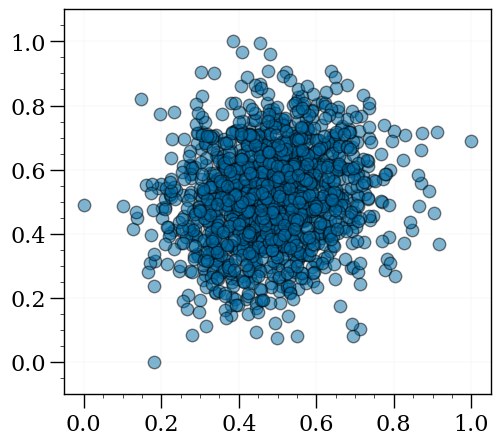

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:27<75:49:17, 27.30s/it]

Iter 0. Loss [[ 0.07844249  0.28109866 19.931568  ]]


  0%|          | 12/10000 [00:53<1:26:24,  1.93it/s]

Iter 10. Loss [[0.08731277 0.25276884 5.6846395 ]]


  0%|          | 22/10000 [00:54<25:53,  6.42it/s]

Iter 20. Loss [[0.09295486 0.24046388 5.0319324 ]]


  0%|          | 32/10000 [00:56<25:30,  6.51it/s]

Iter 30. Loss [[0.09826722 0.23220839 4.860623  ]]


  0%|          | 41/10000 [00:58<38:22,  4.33it/s]

Iter 40. Loss [[0.10039663 0.22944213 4.804191  ]]


  1%|          | 51/10000 [01:00<39:46,  4.17it/s]

Iter 50. Loss [[0.09998406 0.22915533 4.6746902 ]]


  1%|          | 62/10000 [01:02<25:34,  6.48it/s]

Iter 60. Loss [[0.09942839 0.22927201 4.5253797 ]]


  1%|          | 72/10000 [01:03<23:56,  6.91it/s]

Iter 70. Loss [[0.09976511 0.22868872 4.3113055 ]]


  1%|          | 82/10000 [01:05<23:52,  6.92it/s]

Iter 80. Loss [[0.09991618 0.22803263 4.1258483 ]]


  1%|          | 92/10000 [01:06<23:48,  6.94it/s]

Iter 90. Loss [[0.09915089 0.22727233 4.016828  ]]


  1%|          | 102/10000 [01:08<24:02,  6.86it/s]

Iter 100. Loss [[0.09815836 0.22612667 3.967809  ]]


  1%|          | 112/10000 [01:09<24:20,  6.77it/s]

Iter 110. Loss [[0.09735017 0.22487675 3.9335175 ]]


  1%|          | 122/10000 [01:11<24:19,  6.77it/s]

Iter 120. Loss [[0.09643435 0.22400415 3.9128258 ]]


  1%|▏         | 131/10000 [01:13<39:43,  4.14it/s]

Iter 130. Loss [[0.09554648 0.22474037 3.8848896 ]]


  1%|▏         | 142/10000 [01:15<34:55,  4.70it/s]

Iter 140. Loss [[0.09512345 0.22424808 3.9156804 ]]


  2%|▏         | 152/10000 [01:17<24:15,  6.76it/s]

Iter 150. Loss [[0.09503829 0.22261943 3.891899  ]]


  2%|▏         | 162/10000 [01:18<23:49,  6.88it/s]

Iter 160. Loss [[0.09510506 0.22065184 3.8687122 ]]


  2%|▏         | 172/10000 [01:20<24:12,  6.77it/s]

Iter 170. Loss [[0.09509293 0.21730472 3.882721  ]]


  2%|▏         | 182/10000 [01:21<24:11,  6.76it/s]

Iter 180. Loss [[0.09499557 0.21458691 3.8388195 ]]


  2%|▏         | 192/10000 [01:23<23:41,  6.90it/s]

Iter 190. Loss [[0.09575163 0.21159126 3.7491803 ]]


  2%|▏         | 202/10000 [01:24<29:00,  5.63it/s]

Iter 200. Loss [[0.09737986 0.2024112  3.6614192 ]]


  2%|▏         | 211/10000 [01:26<35:50,  4.55it/s]

Iter 210. Loss [[0.09740505 0.19559374 3.53786   ]]


  2%|▏         | 221/10000 [01:28<39:08,  4.16it/s]

Iter 220. Loss [[0.09568013 0.19287495 3.4501698 ]]


  2%|▏         | 232/10000 [01:31<25:57,  6.27it/s]

Iter 230. Loss [[0.09437251 0.1910911  3.5228913 ]]


  2%|▏         | 242/10000 [01:32<23:28,  6.93it/s]

Iter 240. Loss [[0.0945346  0.18427566 3.5661073 ]]


  3%|▎         | 252/10000 [01:33<23:23,  6.95it/s]

Iter 250. Loss [[0.09451315 0.18099774 3.660805  ]]


  3%|▎         | 262/10000 [01:35<23:32,  6.89it/s]

Iter 260. Loss [[0.0956592  0.18258701 3.7195227 ]]


  3%|▎         | 272/10000 [01:37<38:47,  4.18it/s]

Iter 270. Loss [[0.10017926 0.18084908 3.589834  ]]


  3%|▎         | 282/10000 [01:38<23:29,  6.89it/s]

Iter 280. Loss [[0.10890074 0.17382772 3.3350148 ]]


  3%|▎         | 292/10000 [01:40<23:14,  6.96it/s]

Iter 290. Loss [[0.12197252 0.16338965 3.0267665 ]]


  3%|▎         | 301/10000 [01:42<37:52,  4.27it/s]

Iter 300. Loss [[0.13986923 0.15245192 2.6779048 ]]


  3%|▎         | 312/10000 [01:44<34:28,  4.68it/s]

Iter 310. Loss [[0.16366109 0.14150734 2.3206277 ]]


  3%|▎         | 322/10000 [01:46<23:49,  6.77it/s]

Iter 320. Loss [[0.19353156 0.12607142 1.9240038 ]]


  3%|▎         | 332/10000 [01:47<24:01,  6.70it/s]

Iter 330. Loss [[0.22405851 0.1062488  1.5055635 ]]


  3%|▎         | 342/10000 [01:49<23:41,  6.79it/s]

Iter 340. Loss [[0.24183708 0.08184851 1.0987937 ]]


  4%|▎         | 352/10000 [01:50<23:28,  6.85it/s]

Iter 350. Loss [[0.23638172 0.06107335 0.57655036]]


  4%|▎         | 362/10000 [01:52<24:07,  6.66it/s]

Iter 360. Loss [[0.22326903 0.08531946 0.43065453]]


  4%|▎         | 371/10000 [01:54<36:15,  4.43it/s]

Iter 370. Loss [[0.22615172 0.05763384 0.41961852]]


  4%|▍         | 381/10000 [01:56<40:06,  4.00it/s]

Iter 380. Loss [[0.23183395 0.05436951 0.42511898]]


  4%|▍         | 391/10000 [01:59<42:56,  3.73it/s]

Iter 390. Loss [[0.23990496 0.05969578 0.32823652]]


  4%|▍         | 402/10000 [02:01<30:34,  5.23it/s]

Iter 400. Loss [[0.23484434 0.05618511 0.34651485]]


  4%|▍         | 412/10000 [02:03<23:03,  6.93it/s]

Iter 410. Loss [[0.23968284 0.05130097 0.3494703 ]]


  4%|▍         | 422/10000 [02:04<23:24,  6.82it/s]

Iter 420. Loss [[0.23792282 0.05090936 0.38525423]]


  4%|▍         | 432/10000 [02:06<22:55,  6.96it/s]

Iter 430. Loss [[0.24040894 0.05065665 0.38261473]]


  4%|▍         | 442/10000 [02:07<20:31,  7.76it/s]

Iter 440. Loss [[0.24027328 0.04900678 0.38456172]]


  5%|▍         | 452/10000 [02:08<22:44,  7.00it/s]

Iter 450. Loss [[0.24031018 0.04699019 0.4065669 ]]


  5%|▍         | 462/10000 [02:10<23:01,  6.91it/s]

Iter 460. Loss [[0.24068667 0.04672972 0.42711955]]


  5%|▍         | 471/10000 [02:11<31:45,  5.00it/s]

Iter 470. Loss [[0.24180678 0.04538792 0.4301717 ]]


  5%|▍         | 481/10000 [02:14<38:05,  4.16it/s]

Iter 480. Loss [[0.24199507 0.04441918 0.43260294]]


  5%|▍         | 492/10000 [02:16<25:20,  6.25it/s]

Iter 490. Loss [[0.2425     0.04283969 0.44495076]]


  5%|▌         | 502/10000 [02:17<22:37,  7.00it/s]

Iter 500. Loss [[0.24252662 0.04226219 0.46660206]]


  5%|▌         | 512/10000 [02:19<23:08,  6.83it/s]

Iter 510. Loss [[0.24347323 0.0422225  0.46116373]]


  5%|▌         | 522/10000 [02:20<22:42,  6.96it/s]

Iter 520. Loss [[0.24437414 0.04266091 0.44256797]]


  5%|▌         | 532/10000 [02:22<22:34,  6.99it/s]

Iter 530. Loss [[0.24490595 0.04260585 0.43934274]]


  5%|▌         | 542/10000 [02:23<22:48,  6.91it/s]

Iter 540. Loss [[0.24560404 0.04232278 0.4391032 ]]


  6%|▌         | 552/10000 [02:24<23:01,  6.84it/s]

Iter 550. Loss [[0.24642086 0.04183103 0.43587077]]


  6%|▌         | 561/10000 [02:26<34:57,  4.50it/s]

Iter 560. Loss [[0.24694157 0.04157348 0.43775558]]


  6%|▌         | 571/10000 [02:29<40:05,  3.92it/s]

Iter 570. Loss [[0.24747168 0.04101721 0.43840474]]


  6%|▌         | 582/10000 [02:31<24:02,  6.53it/s]

Iter 580. Loss [[0.24799806 0.04048819 0.43493858]]


  6%|▌         | 592/10000 [02:32<20:59,  7.47it/s]

Iter 590. Loss [[0.24843839 0.03954582 0.440213  ]]


  6%|▌         | 602/10000 [02:33<21:44,  7.20it/s]

Iter 600. Loss [[0.24897234 0.04028851 0.44385514]]


  6%|▌         | 612/10000 [02:35<22:25,  6.98it/s]

Iter 610. Loss [[0.24973868 0.0399028  0.43463907]]


  6%|▌         | 622/10000 [02:36<22:31,  6.94it/s]

Iter 620. Loss [[0.25013632 0.04006582 0.4428887 ]]


  6%|▋         | 632/10000 [02:38<22:38,  6.90it/s]

Iter 630. Loss [[0.25076205 0.03987604 0.43417326]]


  6%|▋         | 641/10000 [02:39<31:27,  4.96it/s]

Iter 640. Loss [[0.25132793 0.03975896 0.43615177]]


  7%|▋         | 651/10000 [02:42<36:57,  4.22it/s]

Iter 650. Loss [[0.25197485 0.0397212  0.4303938 ]]


  7%|▋         | 662/10000 [02:44<28:34,  5.44it/s]

Iter 660. Loss [[0.25239778 0.03951086 0.43648925]]


  7%|▋         | 672/10000 [02:46<20:41,  7.52it/s]

Iter 670. Loss [[0.2528259  0.03948375 0.43706343]]


  7%|▋         | 682/10000 [02:47<22:32,  6.89it/s]

Iter 680. Loss [[0.253442   0.03949232 0.4334944 ]]


  7%|▋         | 692/10000 [02:49<25:19,  6.12it/s]

Iter 690. Loss [[0.25387603 0.03935191 0.4352387 ]]


  7%|▋         | 702/10000 [02:50<22:30,  6.88it/s]

Iter 700. Loss [[0.2541877  0.03854369 0.4409242 ]]


  7%|▋         | 712/10000 [02:52<22:39,  6.83it/s]

Iter 710. Loss [[0.25428376 0.03687181 0.45667422]]


  7%|▋         | 722/10000 [02:53<21:52,  7.07it/s]

Iter 720. Loss [[0.2546127  0.03515798 0.48958617]]


  7%|▋         | 731/10000 [02:55<33:31,  4.61it/s]

Iter 730. Loss [[0.25528142 0.03491513 0.48825952]]


  7%|▋         | 741/10000 [02:57<36:36,  4.22it/s]

Iter 740. Loss [[0.25604555 0.0349091  0.47964278]]


  8%|▊         | 752/10000 [02:59<23:54,  6.45it/s]

Iter 750. Loss [[0.2570496  0.03558139 0.46317944]]


  8%|▊         | 762/10000 [03:01<33:12,  4.64it/s]

Iter 760. Loss [[0.2578274  0.03557189 0.4539248 ]]


  8%|▊         | 772/10000 [03:03<22:58,  6.69it/s]

Iter 770. Loss [[0.25842893 0.0357549  0.4488077 ]]


  8%|▊         | 782/10000 [03:04<22:01,  6.97it/s]

Iter 780. Loss [[0.25913593 0.03633172 0.4392657 ]]


  8%|▊         | 792/10000 [03:05<22:34,  6.80it/s]

Iter 790. Loss [[0.2598652  0.03759846 0.41696802]]


  8%|▊         | 802/10000 [03:07<22:09,  6.92it/s]

Iter 800. Loss [[0.26084477 0.03783874 0.4035791 ]]


  8%|▊         | 812/10000 [03:08<21:59,  6.96it/s]

Iter 810. Loss [[0.26111174 0.03779221 0.4009989 ]]


  8%|▊         | 821/10000 [03:10<36:00,  4.25it/s]

Iter 820. Loss [[0.26187742 0.03770955 0.39614615]]


  8%|▊         | 832/10000 [03:13<32:12,  4.74it/s]

Iter 830. Loss [[0.26221323 0.03767379 0.39302132]]


  8%|▊         | 842/10000 [03:14<22:05,  6.91it/s]

Iter 840. Loss [[0.26276967 0.0377618  0.3903793 ]]


  9%|▊         | 852/10000 [03:16<22:43,  6.71it/s]

Iter 850. Loss [[0.26318434 0.03809224 0.3813962 ]]


  9%|▊         | 862/10000 [03:17<22:24,  6.79it/s]

Iter 860. Loss [[0.26369303 0.03858123 0.37443724]]


  9%|▊         | 872/10000 [03:19<23:04,  6.59it/s]

Iter 870. Loss [[0.26405495 0.03842091 0.3686851 ]]


  9%|▉         | 882/10000 [03:21<22:13,  6.84it/s]

Iter 880. Loss [[0.26449633 0.03849787 0.365308  ]]


  9%|▉         | 892/10000 [03:22<22:39,  6.70it/s]

Iter 890. Loss [[0.26475245 0.03839152 0.36441752]]


  9%|▉         | 901/10000 [03:24<33:08,  4.58it/s]

Iter 900. Loss [[0.26499924 0.03813304 0.3639731 ]]


  9%|▉         | 911/10000 [03:27<1:00:43,  2.49it/s]

Iter 910. Loss [[0.26536795 0.03813684 0.36008316]]


  9%|▉         | 922/10000 [03:28<22:55,  6.60it/s]

Iter 920. Loss [[0.26568058 0.03810856 0.35645404]]


  9%|▉         | 932/10000 [03:30<21:58,  6.88it/s]

Iter 930. Loss [[0.26595983 0.03812539 0.3531229 ]]


  9%|▉         | 942/10000 [03:31<22:18,  6.77it/s]

Iter 940. Loss [[0.26632518 0.03898706 0.34016728]]


 10%|▉         | 952/10000 [03:33<21:55,  6.88it/s]

Iter 950. Loss [[0.26705617 0.0412293  0.3195373 ]]


 10%|▉         | 962/10000 [03:35<37:05,  4.06it/s]

Iter 960. Loss [[0.26813507 0.0440297  0.28532866]]


 10%|▉         | 972/10000 [03:36<22:25,  6.71it/s]

Iter 970. Loss [[0.26812243 0.04453794 0.26875544]]


 10%|▉         | 981/10000 [03:37<28:52,  5.21it/s]

Iter 980. Loss [[0.26764446 0.04276421 0.29247087]]


 10%|▉         | 991/10000 [03:40<35:21,  4.25it/s]

Iter 990. Loss [[0.26789656 0.04013771 0.30448192]]


 10%|█         | 1002/10000 [03:42<25:00,  6.00it/s]

Iter 1000. Loss [[0.26763877 0.03948816 0.31256592]]


 10%|█         | 1012/10000 [03:43<21:00,  7.13it/s]

Iter 1010. Loss [[0.26805922 0.04020068 0.30527526]]


 10%|█         | 1022/10000 [03:45<21:40,  6.91it/s]

Iter 1020. Loss [[0.2680988  0.04035357 0.29855502]]


 10%|█         | 1032/10000 [03:46<21:20,  7.01it/s]

Iter 1030. Loss [[0.26830256 0.0403663  0.29941487]]


 10%|█         | 1042/10000 [03:48<21:48,  6.85it/s]

Iter 1040. Loss [[0.2681619  0.03997074 0.30163294]]


 11%|█         | 1052/10000 [03:49<21:42,  6.87it/s]

Iter 1050. Loss [[0.26843977 0.03980834 0.29899925]]


 11%|█         | 1062/10000 [03:51<21:48,  6.83it/s]

Iter 1060. Loss [[0.26824245 0.0396188  0.3005151 ]]


 11%|█         | 1071/10000 [03:53<39:06,  3.81it/s]

Iter 1070. Loss [[0.26849556 0.03937963 0.29782307]]


 11%|█         | 1081/10000 [03:55<38:49,  3.83it/s]

Iter 1080. Loss [[0.26854005 0.03916994 0.29889455]]


 11%|█         | 1091/10000 [03:58<41:47,  3.55it/s]

Iter 1090. Loss [[0.26850903 0.03864601 0.3004185 ]]


 11%|█         | 1102/10000 [04:00<22:05,  6.71it/s]

Iter 1100. Loss [[0.2684881  0.0384084  0.30541295]]


 11%|█         | 1112/10000 [04:02<21:42,  6.82it/s]

Iter 1110. Loss [[0.26839316 0.03756295 0.30790004]]


 11%|█         | 1122/10000 [04:03<19:35,  7.55it/s]

Iter 1120. Loss [[0.26800734 0.0349117  0.32506368]]


 11%|█▏        | 1132/10000 [04:04<19:36,  7.54it/s]

Iter 1130. Loss [[0.26777774 0.03391322 0.35377514]]


 11%|█▏        | 1142/10000 [04:06<21:03,  7.01it/s]

Iter 1140. Loss [[0.26835188 0.03500545 0.33453977]]


 12%|█▏        | 1152/10000 [04:08<22:21,  6.60it/s]

Iter 1150. Loss [[0.26877797 0.03717863 0.30966395]]


 12%|█▏        | 1162/10000 [04:09<21:33,  6.84it/s]

Iter 1160. Loss [[0.26919517 0.04000749 0.29054487]]


 12%|█▏        | 1171/10000 [04:11<34:58,  4.21it/s]

Iter 1170. Loss [[0.2688603  0.04368538 0.26874617]]


 12%|█▏        | 1181/10000 [04:13<34:49,  4.22it/s]

Iter 1180. Loss [[0.26875222 0.0425076  0.27259928]]


 12%|█▏        | 1192/10000 [04:16<26:48,  5.48it/s]

Iter 1190. Loss [[0.26821426 0.03361903 0.32678935]]


 12%|█▏        | 1202/10000 [04:17<21:50,  6.71it/s]

Iter 1200. Loss [[0.26790264 0.03104424 0.38238117]]


 12%|█▏        | 1212/10000 [04:18<21:07,  6.93it/s]

Iter 1210. Loss [[0.26861313 0.03329584 0.34473568]]


 12%|█▏        | 1222/10000 [04:20<21:04,  6.94it/s]

Iter 1220. Loss [[0.2696321  0.03882867 0.29145277]]


 12%|█▏        | 1232/10000 [04:21<21:07,  6.92it/s]

Iter 1230. Loss [[0.27015346 0.05295923 0.22228722]]


 12%|█▏        | 1241/10000 [04:23<21:47,  6.70it/s]

Iter 1240. Loss [[0.27086896 0.0439524  0.19100948]]


 13%|█▎        | 1251/10000 [04:25<34:22,  4.24it/s]

Iter 1250. Loss [[0.27058554 0.03339518 0.3491231 ]]


 13%|█▎        | 1261/10000 [04:27<34:33,  4.21it/s]

Iter 1260. Loss [[0.2710305  0.03504229 0.269845  ]]


 13%|█▎        | 1272/10000 [04:29<21:30,  6.77it/s]

Iter 1270. Loss [[0.27431604 0.05710066 0.11262   ]]


 13%|█▎        | 1282/10000 [04:31<22:04,  6.58it/s]

Iter 1280. Loss [[0.26632535 0.04268151 0.2518559 ]]


 13%|█▎        | 1292/10000 [04:32<20:59,  6.91it/s]

Iter 1290. Loss [[0.27779898 0.04985317 0.18647967]]


 13%|█▎        | 1302/10000 [04:34<21:46,  6.66it/s]

Iter 1300. Loss [[0.27532107 0.04504672 0.20997554]]


 13%|█▎        | 1312/10000 [04:35<20:43,  6.99it/s]

Iter 1310. Loss [[0.27580148 0.04567169 0.12067578]]


 13%|█▎        | 1322/10000 [04:36<20:37,  7.01it/s]

Iter 1320. Loss [[0.28305003 0.04720194 0.12954488]]


 13%|█▎        | 1332/10000 [04:38<21:00,  6.88it/s]

Iter 1330. Loss [[0.27895406 0.03837415 0.23470496]]


 13%|█▎        | 1341/10000 [04:40<36:30,  3.95it/s]

Iter 1340. Loss [[0.28304878 0.03843732 0.22374241]]


 14%|█▎        | 1352/10000 [04:43<26:51,  5.37it/s]

Iter 1350. Loss [[0.284913   0.04749801 0.23651041]]


 14%|█▎        | 1362/10000 [04:44<21:06,  6.82it/s]

Iter 1360. Loss [[0.28118035 0.05632781 0.1507523 ]]


 14%|█▎        | 1372/10000 [04:46<21:15,  6.76it/s]

Iter 1370. Loss [[0.25866306 0.07264119 0.16329461]]


 14%|█▍        | 1382/10000 [04:47<21:06,  6.81it/s]

Iter 1380. Loss [[0.25508985 0.06431521 0.24647725]]


 14%|█▍        | 1392/10000 [04:49<21:01,  6.82it/s]

Iter 1390. Loss [[ 0.27703613  0.06407328 -0.00339976]]


 14%|█▍        | 1402/10000 [04:50<21:13,  6.75it/s]

Iter 1400. Loss [[0.27426663 0.06058976 0.0410141 ]]


 14%|█▍        | 1412/10000 [04:52<28:12,  5.07it/s]

Iter 1410. Loss [[0.27404633 0.05326819 0.10564274]]


 14%|█▍        | 1421/10000 [04:54<33:12,  4.30it/s]

Iter 1420. Loss [[0.2758815  0.04904352 0.14273621]]


 14%|█▍        | 1431/10000 [04:56<32:41,  4.37it/s]

Iter 1430. Loss [[0.27016148 0.04017502 0.20485394]]


 14%|█▍        | 1442/10000 [04:58<21:16,  6.70it/s]

Iter 1440. Loss [[0.27115405 0.03755805 0.24478184]]


 15%|█▍        | 1452/10000 [05:00<26:49,  5.31it/s]

Iter 1450. Loss [[0.26955807 0.03379508 0.28225043]]


 15%|█▍        | 1462/10000 [05:02<22:26,  6.34it/s]

Iter 1460. Loss [[0.27006596 0.03381126 0.31006536]]


 15%|█▍        | 1472/10000 [05:03<21:02,  6.75it/s]

Iter 1470. Loss [[0.27969712 0.03990217 0.23682304]]


 15%|█▍        | 1482/10000 [05:04<20:44,  6.84it/s]

Iter 1480. Loss [[0.2823742  0.04670792 0.19794972]]


 15%|█▍        | 1492/10000 [05:06<20:44,  6.83it/s]

Iter 1490. Loss [[0.28901333 0.04801193 0.11134302]]


 15%|█▌        | 1501/10000 [05:08<37:12,  3.81it/s]

Iter 1500. Loss [[ 0.2983236   0.05817149 -0.01561396]]


 15%|█▌        | 1511/10000 [05:10<33:26,  4.23it/s]

Iter 1510. Loss [[ 0.301195    0.0543018  -0.05948724]]


 15%|█▌        | 1522/10000 [05:12<21:32,  6.56it/s]

Iter 1520. Loss [[ 0.30124104  0.04592795 -0.07513654]]


 15%|█▌        | 1532/10000 [05:14<20:24,  6.91it/s]

Iter 1530. Loss [[0.24785504 0.02353635 0.5911229 ]]


 15%|█▌        | 1542/10000 [05:15<20:41,  6.81it/s]

Iter 1540. Loss [[0.24828525 0.02053853 0.6858454 ]]


 16%|█▌        | 1552/10000 [05:17<20:22,  6.91it/s]

Iter 1550. Loss [[0.26123446 0.02341637 0.5870228 ]]


 16%|█▌        | 1562/10000 [05:18<20:45,  6.77it/s]

Iter 1560. Loss [[0.26747707 0.03080577 0.55522573]]


 16%|█▌        | 1571/10000 [05:19<20:36,  6.82it/s]

Iter 1570. Loss [[0.26483724 0.02746896 0.5580093 ]]


 16%|█▌        | 1582/10000 [05:21<22:27,  6.25it/s]

Iter 1580. Loss [[0.26276314 0.02488652 0.5651162 ]]


 16%|█▌        | 1591/10000 [05:24<33:37,  4.17it/s]

Iter 1590. Loss [[0.2637636  0.02530422 0.55187106]]


 16%|█▌        | 1602/10000 [05:26<27:33,  5.08it/s]

Iter 1600. Loss [[0.26545605 0.02653772 0.53538585]]


 16%|█▌        | 1612/10000 [05:27<20:53,  6.69it/s]

Iter 1610. Loss [[0.2659482  0.02669698 0.5286012 ]]


 16%|█▌        | 1622/10000 [05:29<20:13,  6.91it/s]

Iter 1620. Loss [[0.26586664 0.02685945 0.5159193 ]]


 16%|█▋        | 1632/10000 [05:30<19:48,  7.04it/s]

Iter 1630. Loss [[0.26624203 0.02763322 0.49485087]]


 16%|█▋        | 1642/10000 [05:32<20:37,  6.76it/s]

Iter 1640. Loss [[0.2670339  0.02857826 0.4735199 ]]


 17%|█▋        | 1652/10000 [05:33<20:05,  6.93it/s]

Iter 1650. Loss [[0.267781   0.03016504 0.43829724]]


 17%|█▋        | 1662/10000 [05:35<20:09,  6.89it/s]

Iter 1660. Loss [[0.2684777  0.03169565 0.4049608 ]]


 17%|█▋        | 1671/10000 [05:36<24:27,  5.68it/s]

Iter 1670. Loss [[0.26926407 0.03668239 0.36165985]]


 17%|█▋        | 1681/10000 [05:38<31:56,  4.34it/s]

Iter 1680. Loss [[0.2705136  0.04119547 0.2963246 ]]


 17%|█▋        | 1692/10000 [05:41<25:48,  5.36it/s]

Iter 1690. Loss [[0.27283373 0.05349578 0.19638248]]


 17%|█▋        | 1702/10000 [05:42<20:18,  6.81it/s]

Iter 1700. Loss [[0.27813596 0.07586764 0.00736431]]


 17%|█▋        | 1712/10000 [05:44<19:48,  6.97it/s]

Iter 1710. Loss [[0.2717038  0.05511864 0.01365866]]


 17%|█▋        | 1722/10000 [05:45<20:37,  6.69it/s]

Iter 1720. Loss [[0.26425502 0.04300102 0.19320016]]


 17%|█▋        | 1732/10000 [05:46<20:04,  6.86it/s]

Iter 1730. Loss [[0.27020192 0.03964952 0.23502165]]


 17%|█▋        | 1742/10000 [05:48<20:14,  6.80it/s]

Iter 1740. Loss [[0.2743745 0.0387813 0.2495457]]


 18%|█▊        | 1751/10000 [05:50<27:34,  4.99it/s]

Iter 1750. Loss [[0.27118668 0.0396629  0.2591294 ]]


 18%|█▊        | 1761/10000 [05:52<40:32,  3.39it/s]

Iter 1760. Loss [[0.26926053 0.03792576 0.25931683]]


 18%|█▊        | 1771/10000 [05:55<34:43,  3.95it/s]

Iter 1770. Loss [[0.27057093 0.03909336 0.24301895]]


 18%|█▊        | 1781/10000 [05:57<34:07,  4.01it/s]

Iter 1780. Loss [[0.27163833 0.04128496 0.21967646]]


 18%|█▊        | 1792/10000 [05:59<20:18,  6.74it/s]

Iter 1790. Loss [[0.2719159  0.04307478 0.20500277]]


 18%|█▊        | 1802/10000 [06:00<19:38,  6.95it/s]

Iter 1800. Loss [[0.27234572 0.04572355 0.17908084]]


 18%|█▊        | 1812/10000 [06:02<20:24,  6.69it/s]

Iter 1810. Loss [[0.27264452 0.04678366 0.16139975]]


 18%|█▊        | 1822/10000 [06:04<20:19,  6.70it/s]

Iter 1820. Loss [[0.27252805 0.04565199 0.16367584]]


 18%|█▊        | 1832/10000 [06:05<20:18,  6.70it/s]

Iter 1830. Loss [[0.27229106 0.04501949 0.17130858]]


 18%|█▊        | 1842/10000 [06:07<19:53,  6.83it/s]

Iter 1840. Loss [[0.27204776 0.04335112 0.19566223]]


 19%|█▊        | 1851/10000 [06:09<44:22,  3.06it/s]

Iter 1850. Loss [[0.2717313  0.04222882 0.21317893]]


 19%|█▊        | 1861/10000 [06:11<32:51,  4.13it/s]

Iter 1860. Loss [[0.27134496 0.04233562 0.2131709 ]]


 19%|█▊        | 1872/10000 [06:13<20:09,  6.72it/s]

Iter 1870. Loss [[0.27115515 0.04267062 0.21235661]]


 19%|█▉        | 1882/10000 [06:14<19:39,  6.88it/s]

Iter 1880. Loss [[0.27141166 0.0426992  0.20868303]]


 19%|█▉        | 1892/10000 [06:16<20:18,  6.66it/s]

Iter 1890. Loss [[0.2714563  0.04319923 0.20308731]]


 19%|█▉        | 1902/10000 [06:17<20:03,  6.73it/s]

Iter 1900. Loss [[0.27142406 0.04307938 0.2041674 ]]


 19%|█▉        | 1911/10000 [06:19<19:48,  6.81it/s]

Iter 1910. Loss [[0.27145535 0.04252833 0.21318062]]


 19%|█▉        | 1922/10000 [06:21<20:07,  6.69it/s]

Iter 1920. Loss [[0.27138755 0.04273855 0.21263216]]


 19%|█▉        | 1931/10000 [06:22<26:39,  5.04it/s]

Iter 1930. Loss [[0.27136278 0.04273042 0.21262398]]


 19%|█▉        | 1941/10000 [06:25<31:53,  4.21it/s]

Iter 1940. Loss [[0.27134913 0.04399075 0.20573616]]


 20%|█▉        | 1952/10000 [06:27<23:08,  5.79it/s]

Iter 1950. Loss [[0.27153528 0.04442592 0.19579807]]


 20%|█▉        | 1962/10000 [06:28<18:17,  7.32it/s]

Iter 1960. Loss [[0.2715684 0.043981  0.1970766]]


 20%|█▉        | 1972/10000 [06:30<19:44,  6.78it/s]

Iter 1970. Loss [[0.27156013 0.04404806 0.19920477]]


 20%|█▉        | 1982/10000 [06:31<20:15,  6.60it/s]

Iter 1980. Loss [[0.27147868 0.04346102 0.20486629]]


 20%|█▉        | 1992/10000 [06:33<19:29,  6.85it/s]

Iter 1990. Loss [[0.2715355  0.04352447 0.20516577]]


 20%|██        | 2002/10000 [06:34<19:20,  6.89it/s]

Iter 2000. Loss [[0.27145392 0.04354839 0.20216335]]


 20%|██        | 2012/10000 [06:36<21:07,  6.30it/s]

Iter 2010. Loss [[0.27124318 0.04353169 0.2036359 ]]


 20%|██        | 2021/10000 [06:38<32:14,  4.12it/s]

Iter 2020. Loss [[0.27136445 0.04358491 0.20295918]]


 20%|██        | 2031/10000 [06:40<31:47,  4.18it/s]

Iter 2030. Loss [[0.2713833  0.04462458 0.19791128]]


 20%|██        | 2042/10000 [06:42<19:33,  6.78it/s]

Iter 2040. Loss [[0.27142888 0.04436667 0.19547778]]


 21%|██        | 2052/10000 [06:43<19:40,  6.73it/s]

Iter 2050. Loss [[0.2713818  0.04427923 0.19651678]]


 21%|██        | 2062/10000 [06:45<19:07,  6.92it/s]

Iter 2060. Loss [[0.2714295  0.04448922 0.19718966]]


 21%|██        | 2072/10000 [06:47<20:39,  6.40it/s]

Iter 2070. Loss [[0.2713808  0.04452525 0.1987703 ]]


 21%|██        | 2082/10000 [06:48<19:46,  6.67it/s]

Iter 2080. Loss [[0.27132332 0.04481221 0.19710676]]


 21%|██        | 2092/10000 [06:50<19:09,  6.88it/s]

Iter 2090. Loss [[0.27127934 0.04469983 0.1939347 ]]


 21%|██        | 2101/10000 [06:51<26:09,  5.03it/s]

Iter 2100. Loss [[0.2711906  0.0454874  0.19552441]]


 21%|██        | 2111/10000 [06:54<33:47,  3.89it/s]

Iter 2110. Loss [[0.27132577 0.04615356 0.18991831]]


 21%|██        | 2122/10000 [06:56<20:00,  6.56it/s]

Iter 2120. Loss [[0.27123654 0.04601964 0.18938977]]


 21%|██▏       | 2132/10000 [06:58<19:07,  6.86it/s]

Iter 2130. Loss [[0.2709985  0.04498456 0.19598964]]


 21%|██▏       | 2142/10000 [06:59<19:06,  6.85it/s]

Iter 2140. Loss [[0.27091798 0.04349245 0.21607581]]


 22%|██▏       | 2152/10000 [07:00<18:30,  7.07it/s]

Iter 2150. Loss [[0.2707638  0.04419564 0.21482494]]


 22%|██▏       | 2162/10000 [07:02<23:13,  5.63it/s]

Iter 2160. Loss [[0.2706833  0.04374197 0.21770898]]


 22%|██▏       | 2172/10000 [07:04<19:33,  6.67it/s]

Iter 2170. Loss [[0.27033588 0.04308496 0.22394696]]


 22%|██▏       | 2181/10000 [07:05<19:12,  6.79it/s]

Iter 2180. Loss [[0.27038157 0.04325425 0.22901423]]


 22%|██▏       | 2191/10000 [07:07<30:31,  4.26it/s]

Iter 2190. Loss [[0.2704364  0.04268531 0.23609206]]


 22%|██▏       | 2202/10000 [07:10<24:41,  5.26it/s]

Iter 2200. Loss [[0.27000058 0.04180766 0.2389682 ]]


 22%|██▏       | 2212/10000 [07:11<19:12,  6.76it/s]

Iter 2210. Loss [[0.2692815  0.04144589 0.24074972]]


 22%|██▏       | 2222/10000 [07:13<18:39,  6.95it/s]

Iter 2220. Loss [[0.2693328  0.04147967 0.23229943]]


 22%|██▏       | 2231/10000 [07:14<19:08,  6.76it/s]

Iter 2230. Loss [[0.26951262 0.0420892  0.22456765]]


 22%|██▏       | 2242/10000 [07:16<18:59,  6.81it/s]

Iter 2240. Loss [[0.26980636 0.04245262 0.22038603]]


 23%|██▎       | 2252/10000 [07:17<18:56,  6.82it/s]

Iter 2250. Loss [[0.26985887 0.04280711 0.22061922]]


 23%|██▎       | 2262/10000 [07:19<19:02,  6.78it/s]

Iter 2260. Loss [[0.27050877 0.04291302 0.21367854]]


 23%|██▎       | 2271/10000 [07:21<29:24,  4.38it/s]

Iter 2270. Loss [[0.27083826 0.04249042 0.20822996]]


 23%|██▎       | 2281/10000 [07:23<30:06,  4.27it/s]

Iter 2280. Loss [[0.27137783 0.04254152 0.20354491]]


 23%|██▎       | 2292/10000 [07:25<19:30,  6.59it/s]

Iter 2290. Loss [[0.27254975 0.04411008 0.18300195]]


 23%|██▎       | 2302/10000 [07:26<18:54,  6.79it/s]

Iter 2300. Loss [[0.27407944 0.04566533 0.15893188]]


 23%|██▎       | 2312/10000 [07:28<18:33,  6.90it/s]

Iter 2310. Loss [[0.2741558  0.04558374 0.15307665]]


 23%|██▎       | 2322/10000 [07:29<18:48,  6.80it/s]

Iter 2320. Loss [[0.27603185 0.04369701 0.14850676]]


 23%|██▎       | 2332/10000 [07:31<18:58,  6.73it/s]

Iter 2330. Loss [[0.27791336 0.0437961  0.1279784 ]]


 23%|██▎       | 2342/10000 [07:32<18:39,  6.84it/s]

Iter 2340. Loss [[0.28345677 0.04945811 0.05721729]]


 24%|██▎       | 2352/10000 [07:34<18:16,  6.97it/s]

Iter 2350. Loss [[0.28581855 0.05020754 0.03393433]]


 24%|██▎       | 2361/10000 [07:36<28:55,  4.40it/s]

Iter 2360. Loss [[0.27993685 0.04366284 0.20510733]]


 24%|██▎       | 2371/10000 [07:38<30:43,  4.14it/s]

Iter 2370. Loss [[0.28066704 0.0310471  0.26520666]]


 24%|██▍       | 2382/10000 [07:40<18:51,  6.73it/s]

Iter 2380. Loss [[0.28559172 0.03456111 0.2098558 ]]


 24%|██▍       | 2392/10000 [07:41<18:54,  6.71it/s]

Iter 2390. Loss [[0.291655   0.05016883 0.1909519 ]]


 24%|██▍       | 2402/10000 [07:43<18:21,  6.90it/s]

Iter 2400. Loss [[0.28502715 0.04659176 0.25995445]]


 24%|██▍       | 2412/10000 [07:44<18:11,  6.95it/s]

Iter 2410. Loss [[0.2796935  0.03953759 0.30644938]]


 24%|██▍       | 2422/10000 [07:45<16:56,  7.45it/s]

Iter 2420. Loss [[0.28046206 0.04364089 0.2561034 ]]


 24%|██▍       | 2432/10000 [07:47<18:18,  6.89it/s]

Iter 2430. Loss [[0.2831746  0.04210871 0.20532228]]


 24%|██▍       | 2441/10000 [07:49<40:37,  3.10it/s]

Iter 2440. Loss [[0.2855916  0.03921443 0.1311776 ]]


 25%|██▍       | 2451/10000 [07:52<34:58,  3.60it/s]

Iter 2450. Loss [[ 0.3076406   0.10153101 -0.11030601]]


 25%|██▍       | 2461/10000 [07:54<36:59,  3.40it/s]

Iter 2460. Loss [[0.27189973 0.04382978 0.0293992 ]]


 25%|██▍       | 2472/10000 [07:57<20:51,  6.02it/s]

Iter 2470. Loss [[0.2685109  0.03423917 0.18172203]]


 25%|██▍       | 2482/10000 [07:58<17:47,  7.04it/s]

Iter 2480. Loss [[ 0.28761917  0.04779149 -0.01403316]]


 25%|██▍       | 2492/10000 [08:00<17:25,  7.18it/s]

Iter 2490. Loss [[ 0.29506102  0.05983349 -0.03013753]]


 25%|██▌       | 2502/10000 [08:01<16:34,  7.54it/s]

Iter 2500. Loss [[0.28758603 0.05588206 0.05268871]]


 25%|██▌       | 2512/10000 [08:03<22:20,  5.59it/s]

Iter 2510. Loss [[0.27891394 0.03632054 0.10755192]]


 25%|██▌       | 2522/10000 [08:04<18:47,  6.63it/s]

Iter 2520. Loss [[0.28550205 0.04785445 0.04617514]]


 25%|██▌       | 2532/10000 [08:06<18:03,  6.90it/s]

Iter 2530. Loss [[0.28606927 0.04422015 0.09221171]]


 25%|██▌       | 2541/10000 [08:08<28:27,  4.37it/s]

Iter 2540. Loss [[0.28292716 0.03744905 0.1259956 ]]


 26%|██▌       | 2551/10000 [08:10<30:02,  4.13it/s]

Iter 2550. Loss [[0.2917173  0.04499916 0.06053729]]


 26%|██▌       | 2562/10000 [08:12<18:54,  6.56it/s]

Iter 2560. Loss [[0.29105523 0.05084588 0.1586741 ]]


 26%|██▌       | 2572/10000 [08:14<18:18,  6.76it/s]

Iter 2570. Loss [[0.28256604 0.04985288 0.05401034]]


 26%|██▌       | 2582/10000 [08:15<17:30,  7.06it/s]

Iter 2580. Loss [[ 0.28636962  0.04874169 -0.0677373 ]]


 26%|██▌       | 2592/10000 [08:17<18:28,  6.68it/s]

Iter 2590. Loss [[ 0.29700884  0.06216301 -0.19857281]]


 26%|██▌       | 2602/10000 [08:18<17:50,  6.91it/s]

Iter 2600. Loss [[ 0.29479322  0.05321654 -0.09791875]]


 26%|██▌       | 2612/10000 [08:20<18:08,  6.79it/s]

Iter 2610. Loss [[ 0.28650266  0.04385702 -0.00317622]]


 26%|██▌       | 2621/10000 [08:22<29:34,  4.16it/s]

Iter 2620. Loss [[ 0.28635728  0.04527047 -0.01178305]]


 26%|██▋       | 2631/10000 [08:24<29:43,  4.13it/s]

Iter 2630. Loss [[ 0.28909746  0.05111833 -0.07610683]]


 26%|██▋       | 2642/10000 [08:26<19:20,  6.34it/s]

Iter 2640. Loss [[ 0.2895451  0.0522599 -0.0614997]]


 27%|██▋       | 2652/10000 [08:28<18:04,  6.78it/s]

Iter 2650. Loss [[ 0.28877646  0.05210831 -0.05834375]]


 27%|██▋       | 2662/10000 [08:29<18:13,  6.71it/s]

Iter 2660. Loss [[ 0.28863388  0.05417261 -0.07100908]]


 27%|██▋       | 2672/10000 [08:30<18:04,  6.76it/s]

Iter 2670. Loss [[ 0.28852853  0.05522813 -0.11872438]]


 27%|██▋       | 2682/10000 [08:32<18:21,  6.65it/s]

Iter 2680. Loss [[ 0.2888939  0.0549986 -0.121103 ]]


 27%|██▋       | 2691/10000 [08:37<1:12:28,  1.68it/s]

Iter 2690. Loss [[ 0.28879762  0.05315439 -0.17842597]]


 27%|██▋       | 2701/10000 [08:40<33:51,  3.59it/s]

Iter 2700. Loss [[ 0.29376796  0.0665326  -0.22815906]]


 27%|██▋       | 2711/10000 [08:42<32:33,  3.73it/s]

Iter 2710. Loss [[ 0.28997844  0.06404363 -0.16690032]]


 27%|██▋       | 2722/10000 [08:44<18:38,  6.51it/s]

Iter 2720. Loss [[ 0.2847128   0.05638193 -0.10045952]]


 27%|██▋       | 2732/10000 [08:46<17:39,  6.86it/s]

Iter 2730. Loss [[ 0.28295842  0.05597125 -0.07450026]]


 27%|██▋       | 2742/10000 [08:47<17:27,  6.93it/s]

Iter 2740. Loss [[ 0.28243235  0.05600576 -0.07001048]]


 28%|██▊       | 2752/10000 [08:49<18:11,  6.64it/s]

Iter 2750. Loss [[ 0.28110135  0.05716662 -0.06946416]]


 28%|██▊       | 2762/10000 [08:50<16:21,  7.37it/s]

Iter 2760. Loss [[ 0.28159386  0.06129768 -0.07784849]]


 28%|██▊       | 2772/10000 [08:51<17:24,  6.92it/s]

Iter 2770. Loss [[ 0.28294116  0.05934595 -0.0649271 ]]


 28%|██▊       | 2782/10000 [08:53<18:02,  6.67it/s]

Iter 2780. Loss [[ 0.28392398  0.06144887 -0.13138428]]


 28%|██▊       | 2791/10000 [08:55<27:50,  4.32it/s]

Iter 2790. Loss [[ 0.2834458   0.05256272 -0.01668831]]


 28%|██▊       | 2802/10000 [08:58<27:48,  4.31it/s]

Iter 2800. Loss [[0.28013173 0.04943394 0.09053499]]


 28%|██▊       | 2812/10000 [08:59<17:45,  6.75it/s]

Iter 2810. Loss [[0.27880833 0.05262511 0.07447038]]


 28%|██▊       | 2822/10000 [09:01<17:46,  6.73it/s]

Iter 2820. Loss [[0.27919337 0.05204754 0.01666295]]


 28%|██▊       | 2832/10000 [09:02<17:35,  6.79it/s]

Iter 2830. Loss [[ 0.27998033  0.05382652 -0.00493733]]


 28%|██▊       | 2842/10000 [09:04<18:03,  6.61it/s]

Iter 2840. Loss [[0.2782567  0.05157528 0.04079933]]


 29%|██▊       | 2852/10000 [09:05<17:44,  6.72it/s]

Iter 2850. Loss [[0.27592272 0.04802454 0.14534162]]


 29%|██▊       | 2862/10000 [09:07<17:16,  6.89it/s]

Iter 2860. Loss [[0.27251196 0.04952328 0.13518657]]


 29%|██▊       | 2871/10000 [09:09<28:16,  4.20it/s]

Iter 2870. Loss [[0.27877155 0.05810085 0.0255507 ]]


 29%|██▉       | 2881/10000 [09:11<27:48,  4.27it/s]

Iter 2880. Loss [[0.27848792 0.05327277 0.02507756]]


 29%|██▉       | 2892/10000 [09:13<17:01,  6.96it/s]

Iter 2890. Loss [[0.27990684 0.04795124 0.07152829]]


 29%|██▉       | 2902/10000 [09:14<16:25,  7.21it/s]

Iter 2900. Loss [[0.28235474 0.05201315 0.07165527]]


 29%|██▉       | 2912/10000 [09:16<22:35,  5.23it/s]

Iter 2910. Loss [[0.2818084 0.0524828 0.0788077]]


 29%|██▉       | 2922/10000 [09:18<17:41,  6.67it/s]

Iter 2920. Loss [[0.28380716 0.04796889 0.08509354]]


 29%|██▉       | 2932/10000 [09:19<17:08,  6.87it/s]

Iter 2930. Loss [[0.2801769  0.04578232 0.11403835]]


 29%|██▉       | 2942/10000 [09:21<17:19,  6.79it/s]

Iter 2940. Loss [[0.28252217 0.04994979 0.1224111 ]]


 30%|██▉       | 2952/10000 [09:22<17:38,  6.66it/s]

Iter 2950. Loss [[0.2791443  0.04847135 0.15129049]]


 30%|██▉       | 2961/10000 [09:24<27:11,  4.31it/s]

Iter 2960. Loss [[0.27901605 0.05063544 0.13301715]]


 30%|██▉       | 2972/10000 [09:27<34:43,  3.37it/s]

Iter 2970. Loss [[0.28007904 0.05048285 0.11669531]]


 30%|██▉       | 2982/10000 [09:29<16:13,  7.21it/s]

Iter 2980. Loss [[0.2785687  0.0461127  0.16755494]]


 30%|██▉       | 2992/10000 [09:30<17:02,  6.85it/s]

Iter 2990. Loss [[0.27840695 0.04671811 0.16172734]]


 30%|███       | 3002/10000 [09:31<18:10,  6.42it/s]

Iter 3000. Loss [[0.28018072 0.04805739 0.13748644]]


 30%|███       | 3012/10000 [09:33<17:25,  6.68it/s]

Iter 3010. Loss [[0.28082258 0.04876876 0.14225946]]


 30%|███       | 3022/10000 [09:34<17:01,  6.83it/s]

Iter 3020. Loss [[0.27946877 0.04724044 0.16610606]]


 30%|███       | 3032/10000 [09:36<17:07,  6.78it/s]

Iter 3030. Loss [[0.27894568 0.04630892 0.16994673]]


 30%|███       | 3041/10000 [09:37<24:39,  4.70it/s]

Iter 3040. Loss [[0.27912936 0.04538549 0.17470023]]


 31%|███       | 3051/10000 [09:40<28:13,  4.10it/s]

Iter 3050. Loss [[0.279553   0.04437092 0.16894804]]


 31%|███       | 3062/10000 [09:42<18:27,  6.26it/s]

Iter 3060. Loss [[0.27961117 0.04549521 0.1808866 ]]


 31%|███       | 3072/10000 [09:43<17:17,  6.68it/s]

Iter 3070. Loss [[0.2782651  0.0451623  0.19109435]]


 31%|███       | 3082/10000 [09:45<17:03,  6.76it/s]

Iter 3080. Loss [[0.2766729  0.04486419 0.2136068 ]]


 31%|███       | 3092/10000 [09:46<16:54,  6.81it/s]

Iter 3090. Loss [[0.27555627 0.04305312 0.21902905]]


 31%|███       | 3101/10000 [09:49<27:29,  4.18it/s]

Iter 3100. Loss [[0.2741829  0.04255715 0.22876391]]


 31%|███       | 3111/10000 [09:51<28:02,  4.10it/s]

Iter 3110. Loss [[0.27463505 0.04218088 0.23041974]]


 31%|███       | 3121/10000 [09:54<27:04,  4.23it/s]

Iter 3120. Loss [[0.2738571  0.04202046 0.23386323]]


 31%|███▏      | 3131/10000 [09:56<27:27,  4.17it/s]

Iter 3130. Loss [[0.27349493 0.04191221 0.23501855]]


 31%|███▏      | 3142/10000 [09:58<17:10,  6.66it/s]

Iter 3140. Loss [[0.27367732 0.0423836  0.23174165]]


 32%|███▏      | 3152/10000 [09:59<15:56,  7.16it/s]

Iter 3150. Loss [[0.27357584 0.04284712 0.23149832]]


 32%|███▏      | 3162/10000 [10:01<17:29,  6.52it/s]

Iter 3160. Loss [[0.27328402 0.04269426 0.23133673]]


 32%|███▏      | 3172/10000 [10:02<16:44,  6.80it/s]

Iter 3170. Loss [[0.27416664 0.0435849  0.22371803]]


 32%|███▏      | 3182/10000 [10:04<17:16,  6.58it/s]

Iter 3180. Loss [[0.27455273 0.04640794 0.17048931]]


 32%|███▏      | 3192/10000 [10:05<16:39,  6.81it/s]

Iter 3190. Loss [[0.27395764 0.04417502 0.22371918]]


 32%|███▏      | 3201/10000 [10:07<23:01,  4.92it/s]

Iter 3200. Loss [[0.27546874 0.04921053 0.17216392]]


 32%|███▏      | 3211/10000 [10:09<27:00,  4.19it/s]

Iter 3210. Loss [[0.2740844  0.04546998 0.17024909]]


 32%|███▏      | 3222/10000 [10:11<18:16,  6.18it/s]

Iter 3220. Loss [[0.2754658  0.04285406 0.23439412]]


 32%|███▏      | 3232/10000 [10:13<20:27,  5.52it/s]

Iter 3230. Loss [[0.27537242 0.04531014 0.20013379]]


 32%|███▏      | 3242/10000 [10:15<16:27,  6.85it/s]

Iter 3240. Loss [[0.2744662  0.04829688 0.09522153]]


 33%|███▎      | 3252/10000 [10:16<16:23,  6.86it/s]

Iter 3250. Loss [[0.2747475  0.04068623 0.24575627]]


 33%|███▎      | 3262/10000 [10:18<16:13,  6.92it/s]

Iter 3260. Loss [[0.27502096 0.03960697 0.24923362]]


 33%|███▎      | 3272/10000 [10:19<16:37,  6.74it/s]

Iter 3270. Loss [[0.27621502 0.05005142 0.11434812]]


 33%|███▎      | 3281/10000 [10:21<23:32,  4.76it/s]

Iter 3280. Loss [[0.2742373  0.04371848 0.16559051]]


 33%|███▎      | 3291/10000 [10:23<26:30,  4.22it/s]

Iter 3290. Loss [[0.27449673 0.0352473  0.3043149 ]]


 33%|███▎      | 3302/10000 [10:26<20:46,  5.37it/s]

Iter 3300. Loss [[0.27499735 0.03879287 0.29329634]]


 33%|███▎      | 3312/10000 [10:27<16:38,  6.70it/s]

Iter 3310. Loss [[0.27147222 0.04408197 0.24614716]]


 33%|███▎      | 3322/10000 [10:29<16:14,  6.85it/s]

Iter 3320. Loss [[0.2764377  0.05813892 0.05102323]]


 33%|███▎      | 3332/10000 [10:30<16:20,  6.80it/s]

Iter 3330. Loss [[0.27281156 0.04966863 0.144534  ]]


 33%|███▎      | 3342/10000 [10:31<16:43,  6.64it/s]

Iter 3340. Loss [[0.27614933 0.0467977  0.19849096]]


 34%|███▎      | 3351/10000 [10:33<15:59,  6.93it/s]

Iter 3350. Loss [[0.27587926 0.05294243 0.15321587]]


 34%|███▎      | 3362/10000 [10:35<16:42,  6.62it/s]

Iter 3360. Loss [[0.27241674 0.04755296 0.12991218]]


 34%|███▎      | 3371/10000 [10:37<25:18,  4.37it/s]

Iter 3370. Loss [[0.2725424  0.04598852 0.2019125 ]]


 34%|███▍      | 3381/10000 [10:39<26:35,  4.15it/s]

Iter 3380. Loss [[0.2759922  0.0499389  0.16084997]]


 34%|███▍      | 3392/10000 [10:41<17:19,  6.36it/s]

Iter 3390. Loss [[0.2721792  0.04635175 0.16755979]]


 34%|███▍      | 3402/10000 [10:42<15:58,  6.88it/s]

Iter 3400. Loss [[0.27286625 0.04553781 0.19068559]]


 34%|███▍      | 3412/10000 [10:44<16:52,  6.51it/s]

Iter 3410. Loss [[0.2747288  0.0492573  0.15274051]]


 34%|███▍      | 3422/10000 [10:45<16:11,  6.77it/s]

Iter 3420. Loss [[0.27441868 0.04903486 0.13087209]]


 34%|███▍      | 3432/10000 [10:47<16:00,  6.84it/s]

Iter 3430. Loss [[0.27552244 0.04709792 0.1416343 ]]


 34%|███▍      | 3442/10000 [10:48<15:56,  6.86it/s]

Iter 3440. Loss [[0.2779363  0.04942225 0.1315583 ]]


 35%|███▍      | 3452/10000 [10:50<15:37,  6.98it/s]

Iter 3450. Loss [[0.27778473 0.05489908 0.09812821]]


 35%|███▍      | 3461/10000 [10:52<26:06,  4.17it/s]

Iter 3460. Loss [[0.27541235 0.05101324 0.13911577]]


 35%|███▍      | 3472/10000 [10:55<22:56,  4.74it/s]

Iter 3470. Loss [[0.27531418 0.04954703 0.17078961]]


 35%|███▍      | 3482/10000 [10:56<16:01,  6.78it/s]

Iter 3480. Loss [[0.27562633 0.05171457 0.16781306]]


 35%|███▍      | 3492/10000 [10:58<16:04,  6.75it/s]

Iter 3490. Loss [[0.27254957 0.04681677 0.19174288]]


 35%|███▌      | 3502/10000 [10:59<14:38,  7.40it/s]

Iter 3500. Loss [[0.27181038 0.04285483 0.25147474]]


 35%|███▌      | 3512/10000 [11:00<16:18,  6.63it/s]

Iter 3510. Loss [[0.27259487 0.04245342 0.26504707]]


 35%|███▌      | 3522/10000 [11:02<16:22,  6.59it/s]

Iter 3520. Loss [[0.27206618 0.04387753 0.24896777]]


 35%|███▌      | 3532/10000 [11:04<16:13,  6.64it/s]

Iter 3530. Loss [[0.27226943 0.04405506 0.22821507]]


 35%|███▌      | 3541/10000 [11:05<23:50,  4.51it/s]

Iter 3540. Loss [[0.27473906 0.04462535 0.21557263]]


 36%|███▌      | 3551/10000 [11:08<25:36,  4.20it/s]

Iter 3550. Loss [[0.2759478  0.04588152 0.22338061]]


 36%|███▌      | 3562/10000 [11:10<26:53,  3.99it/s]

Iter 3560. Loss [[0.27589542 0.04796459 0.20117438]]


 36%|███▌      | 3572/10000 [11:12<16:12,  6.61it/s]

Iter 3570. Loss [[0.27642503 0.05187115 0.16533418]]


 36%|███▌      | 3582/10000 [11:13<15:45,  6.79it/s]

Iter 3580. Loss [[0.27811605 0.05240481 0.10603426]]


 36%|███▌      | 3592/10000 [11:15<15:42,  6.80it/s]

Iter 3590. Loss [[0.27690488 0.04960112 0.16675161]]


 36%|███▌      | 3602/10000 [11:16<16:06,  6.62it/s]

Iter 3600. Loss [[0.27800095 0.04741045 0.19588733]]


 36%|███▌      | 3612/10000 [11:18<15:56,  6.68it/s]

Iter 3610. Loss [[0.27514067 0.04478775 0.22921374]]


 36%|███▌      | 3621/10000 [11:19<16:15,  6.54it/s]

Iter 3620. Loss [[0.27537    0.05271389 0.13381392]]


 36%|███▋      | 3631/10000 [11:21<24:53,  4.26it/s]

Iter 3630. Loss [[0.27675223 0.05078863 0.11314292]]


 36%|███▋      | 3642/10000 [11:24<18:56,  5.59it/s]

Iter 3640. Loss [[0.27814618 0.04703359 0.17568702]]


 37%|███▋      | 3652/10000 [11:26<15:46,  6.71it/s]

Iter 3650. Loss [[0.27911752 0.04846147 0.20525622]]


 37%|███▋      | 3662/10000 [11:27<15:28,  6.83it/s]

Iter 3660. Loss [[0.2746989  0.04942009 0.20596732]]


 37%|███▋      | 3672/10000 [11:29<15:35,  6.76it/s]

Iter 3670. Loss [[0.27333552 0.04720195 0.12288099]]


 37%|███▋      | 3682/10000 [11:30<15:33,  6.77it/s]

Iter 3680. Loss [[0.27302197 0.04231999 0.26735282]]


 37%|███▋      | 3692/10000 [11:31<15:55,  6.60it/s]

Iter 3690. Loss [[0.2741026  0.04016239 0.28445446]]


 37%|███▋      | 3702/10000 [11:33<15:56,  6.58it/s]

Iter 3700. Loss [[0.27130818 0.04717348 0.189816  ]]


 37%|███▋      | 3711/10000 [11:35<23:28,  4.47it/s]

Iter 3710. Loss [[0.2702922  0.04370277 0.18669903]]


 37%|███▋      | 3721/10000 [11:37<24:52,  4.21it/s]

Iter 3720. Loss [[0.273512   0.03966173 0.27503157]]


 37%|███▋      | 3732/10000 [11:39<16:12,  6.44it/s]

Iter 3730. Loss [[0.27305275 0.04346877 0.25302833]]


 37%|███▋      | 3742/10000 [11:41<15:19,  6.81it/s]

Iter 3740. Loss [[0.2715664  0.04443681 0.1390719 ]]


 38%|███▊      | 3752/10000 [11:42<15:19,  6.79it/s]

Iter 3750. Loss [[0.2709193  0.04199025 0.24839427]]


 38%|███▊      | 3762/10000 [11:44<19:15,  5.40it/s]

Iter 3760. Loss [[0.27411893 0.04061306 0.26915905]]


 38%|███▊      | 3772/10000 [11:45<15:13,  6.82it/s]

Iter 3770. Loss [[0.27214122 0.04765149 0.18304011]]


 38%|███▊      | 3782/10000 [11:47<15:29,  6.69it/s]

Iter 3780. Loss [[0.2703583  0.04572548 0.17397648]]


 38%|███▊      | 3791/10000 [11:49<25:27,  4.06it/s]

Iter 3790. Loss [[0.27281648 0.04130473 0.259921  ]]


 38%|███▊      | 3801/10000 [11:52<29:16,  3.53it/s]

Iter 3800. Loss [[0.27416602 0.04724646 0.20735002]]


 38%|███▊      | 3811/10000 [11:55<31:59,  3.22it/s]

Iter 3810. Loss [[0.27150753 0.04593369 0.1525097 ]]


 38%|███▊      | 3822/10000 [11:57<19:33,  5.26it/s]

Iter 3820. Loss [[0.27191898 0.04130698 0.25670364]]


 38%|███▊      | 3832/10000 [11:58<15:10,  6.78it/s]

Iter 3830. Loss [[0.27400172 0.04184191 0.2567777 ]]


 38%|███▊      | 3842/10000 [12:00<14:41,  6.98it/s]

Iter 3840. Loss [[0.27275446 0.04754589 0.1799952 ]]


 39%|███▊      | 3852/10000 [12:01<14:05,  7.27it/s]

Iter 3850. Loss [[0.272701   0.04557434 0.15489905]]


 39%|███▊      | 3862/10000 [12:03<18:33,  5.51it/s]

Iter 3860. Loss [[0.27493665 0.04337623 0.22755562]]


 39%|███▊      | 3872/10000 [12:05<15:04,  6.78it/s]

Iter 3870. Loss [[0.27710718 0.04730664 0.20615795]]


 39%|███▉      | 3881/10000 [12:06<20:30,  4.97it/s]

Iter 3880. Loss [[0.27578855 0.05190364 0.13604754]]


 39%|███▉      | 3891/10000 [12:09<24:22,  4.18it/s]

Iter 3890. Loss [[0.27437368 0.0481191  0.15039499]]


 39%|███▉      | 3902/10000 [12:11<16:57,  6.00it/s]

Iter 3900. Loss [[0.2750182  0.04506005 0.2290472 ]]


 39%|███▉      | 3912/10000 [12:13<16:52,  6.02it/s]

Iter 3910. Loss [[0.27636006 0.04992982 0.18147327]]


 39%|███▉      | 3922/10000 [12:14<14:00,  7.23it/s]

Iter 3920. Loss [[0.27265298 0.04635822 0.17050582]]


 39%|███▉      | 3932/10000 [12:16<14:20,  7.05it/s]

Iter 3930. Loss [[0.271904   0.04242195 0.25571728]]


 39%|███▉      | 3942/10000 [12:17<14:41,  6.87it/s]

Iter 3940. Loss [[0.27388945 0.04448494 0.23651253]]


 40%|███▉      | 3952/10000 [12:18<14:56,  6.75it/s]

Iter 3950. Loss [[0.2719709  0.04570571 0.18706807]]


 40%|███▉      | 3962/10000 [12:20<15:44,  6.39it/s]

Iter 3960. Loss [[0.2714666  0.04247668 0.24634348]]


 40%|███▉      | 3971/10000 [12:22<29:40,  3.39it/s]

Iter 3970. Loss [[0.27374032 0.044443   0.2362858 ]]


 40%|███▉      | 3982/10000 [12:25<18:14,  5.50it/s]

Iter 3980. Loss [[0.2730708  0.04667258 0.18404016]]


 40%|███▉      | 3992/10000 [12:26<14:56,  6.70it/s]

Iter 3990. Loss [[0.2713737  0.04404921 0.22195914]]


 40%|████      | 4002/10000 [12:28<15:21,  6.51it/s]

Iter 4000. Loss [[0.273386   0.04288154 0.2507406 ]]


 40%|████      | 4012/10000 [12:29<13:46,  7.25it/s]

Iter 4010. Loss [[0.2728893  0.04525372 0.20835029]]


 40%|████      | 4022/10000 [12:31<14:42,  6.78it/s]

Iter 4020. Loss [[0.27135032 0.04274403 0.22666524]]


 40%|████      | 4032/10000 [12:32<14:50,  6.70it/s]

Iter 4030. Loss [[0.27286598 0.04279316 0.24884672]]


 40%|████      | 4042/10000 [12:34<14:44,  6.74it/s]

Iter 4040. Loss [[0.27306613 0.04480891 0.2107904 ]]


 41%|████      | 4051/10000 [12:35<22:01,  4.50it/s]

Iter 4050. Loss [[0.27150655 0.0428914  0.23597775]]


 41%|████      | 4061/10000 [12:38<40:17,  2.46it/s]

Iter 4060. Loss [[0.27267888 0.04286819 0.24069583]]


 41%|████      | 4072/10000 [12:40<14:58,  6.60it/s]

Iter 4070. Loss [[0.272661   0.04394448 0.2192464 ]]


 41%|████      | 4082/10000 [12:42<13:49,  7.14it/s]

Iter 4080. Loss [[0.2717693  0.04268347 0.23991933]]


 41%|████      | 4092/10000 [12:43<14:48,  6.65it/s]

Iter 4090. Loss [[0.27309886 0.04378344 0.23017299]]


 41%|████      | 4102/10000 [12:44<14:35,  6.73it/s]

Iter 4100. Loss [[0.27352357 0.04485995 0.2136978 ]]


 41%|████      | 4112/10000 [12:46<14:32,  6.75it/s]

Iter 4110. Loss [[0.2735614  0.04503772 0.21310008]]


 41%|████      | 4122/10000 [12:47<14:32,  6.73it/s]

Iter 4120. Loss [[0.2739033  0.04471295 0.2193504 ]]


 41%|████▏     | 4132/10000 [12:49<15:58,  6.12it/s]

Iter 4130. Loss [[0.2739639  0.04528565 0.21284024]]


 41%|████▏     | 4141/10000 [12:51<22:08,  4.41it/s]

Iter 4140. Loss [[0.27370223 0.04559875 0.20865124]]


 42%|████▏     | 4152/10000 [12:54<20:54,  4.66it/s]

Iter 4150. Loss [[0.2735898  0.04401457 0.22684506]]


 42%|████▏     | 4162/10000 [12:55<14:53,  6.53it/s]

Iter 4160. Loss [[0.27385482 0.04495955 0.2200789 ]]


 42%|████▏     | 4172/10000 [12:57<14:16,  6.80it/s]

Iter 4170. Loss [[0.27316177 0.04517314 0.21533059]]


 42%|████▏     | 4182/10000 [12:58<14:27,  6.71it/s]

Iter 4180. Loss [[0.2731496  0.04328874 0.23280011]]


 42%|████▏     | 4192/10000 [12:59<14:12,  6.81it/s]

Iter 4190. Loss [[0.274028   0.04407042 0.22289872]]


 42%|████▏     | 4202/10000 [13:01<14:35,  6.63it/s]

Iter 4200. Loss [[0.27324352 0.04441905 0.21937256]]


 42%|████▏     | 4212/10000 [13:03<14:51,  6.49it/s]

Iter 4210. Loss [[0.27314833 0.04399548 0.22574554]]


 42%|████▏     | 4221/10000 [13:04<21:04,  4.57it/s]

Iter 4220. Loss [[0.27398598 0.04419448 0.22804411]]


 42%|████▏     | 4231/10000 [13:06<22:45,  4.22it/s]

Iter 4230. Loss [[0.2727584  0.04258504 0.24782725]]


 42%|████▏     | 4242/10000 [13:09<15:56,  6.02it/s]

Iter 4240. Loss [[0.2716038  0.04325238 0.23872706]]


 43%|████▎     | 4252/10000 [13:10<14:21,  6.67it/s]

Iter 4250. Loss [[0.272368   0.04233616 0.24634497]]


 43%|████▎     | 4262/10000 [13:12<14:08,  6.76it/s]

Iter 4260. Loss [[0.27236608 0.04211009 0.2515734 ]]


 43%|████▎     | 4272/10000 [13:13<14:08,  6.75it/s]

Iter 4270. Loss [[0.2720903  0.04236436 0.24486186]]


 43%|████▎     | 4282/10000 [13:15<14:33,  6.54it/s]

Iter 4280. Loss [[0.27189907 0.04290051 0.24056005]]


 43%|████▎     | 4292/10000 [13:17<15:48,  6.02it/s]

Iter 4290. Loss [[0.27210727 0.04199968 0.2469739 ]]


 43%|████▎     | 4301/10000 [13:18<14:41,  6.47it/s]

Iter 4300. Loss [[0.27227092 0.04129305 0.2580197 ]]


 43%|████▎     | 4311/10000 [13:20<22:55,  4.14it/s]

Iter 4310. Loss [[0.27178842 0.04260295 0.24295397]]


 43%|████▎     | 4322/10000 [13:23<19:15,  4.91it/s]

Iter 4320. Loss [[0.2714915  0.04200163 0.2460777 ]]


 43%|████▎     | 4332/10000 [13:24<14:37,  6.46it/s]

Iter 4330. Loss [[0.27267978 0.0412216  0.2570375 ]]


 43%|████▎     | 4342/10000 [13:26<14:27,  6.52it/s]

Iter 4340. Loss [[0.2714515  0.04171924 0.24246986]]


 44%|████▎     | 4352/10000 [13:28<13:53,  6.78it/s]

Iter 4350. Loss [[0.27146906 0.04156075 0.24264306]]


 44%|████▎     | 4362/10000 [13:29<13:57,  6.73it/s]

Iter 4360. Loss [[0.27233857 0.04027309 0.25807124]]


 44%|████▎     | 4372/10000 [13:31<13:04,  7.18it/s]

Iter 4370. Loss [[0.27231872 0.04196422 0.22756286]]


 44%|████▍     | 4382/10000 [13:32<14:15,  6.57it/s]

Iter 4380. Loss [[0.27168152 0.03945886 0.24376823]]


 44%|████▍     | 4391/10000 [13:35<22:41,  4.12it/s]

Iter 4390. Loss [[0.2742452  0.04209074 0.20149906]]


 44%|████▍     | 4402/10000 [13:37<21:21,  4.37it/s]

Iter 4400. Loss [[0.27459568 0.04212015 0.18001875]]


 44%|████▍     | 4412/10000 [13:39<13:57,  6.67it/s]

Iter 4410. Loss [[0.27544042 0.0407185  0.17523855]]


 44%|████▍     | 4422/10000 [13:40<13:59,  6.65it/s]

Iter 4420. Loss [[0.27953863 0.04447264 0.1296868 ]]


 44%|████▍     | 4432/10000 [13:42<14:00,  6.62it/s]

Iter 4430. Loss [[0.27923977 0.04599627 0.13481486]]


 44%|████▍     | 4442/10000 [13:43<13:38,  6.79it/s]

Iter 4440. Loss [[0.27931398 0.04789083 0.15439908]]


 45%|████▍     | 4452/10000 [13:45<13:51,  6.68it/s]

Iter 4450. Loss [[0.27935869 0.04962007 0.13675538]]


 45%|████▍     | 4461/10000 [13:47<19:31,  4.73it/s]

Iter 4460. Loss [[0.27732202 0.04845007 0.15389673]]


 45%|████▍     | 4471/10000 [13:49<26:40,  3.45it/s]

Iter 4470. Loss [[0.2771896  0.04861857 0.16454472]]


 45%|████▍     | 4481/10000 [13:52<28:36,  3.21it/s]

Iter 4480. Loss [[0.27654177 0.04804794 0.18360226]]


 45%|████▍     | 4492/10000 [13:55<21:29,  4.27it/s]

Iter 4490. Loss [[0.2756645  0.04708275 0.18726026]]


 45%|████▌     | 4502/10000 [13:56<13:43,  6.67it/s]

Iter 4500. Loss [[0.27494362 0.04539116 0.2105551 ]]


 45%|████▌     | 4512/10000 [13:58<13:31,  6.77it/s]

Iter 4510. Loss [[0.27483168 0.04454645 0.21545741]]


 45%|████▌     | 4522/10000 [13:59<13:33,  6.73it/s]

Iter 4520. Loss [[0.27374858 0.04382738 0.22954431]]


 45%|████▌     | 4532/10000 [14:01<13:26,  6.78it/s]

Iter 4530. Loss [[0.2734339  0.04318206 0.23435657]]


 45%|████▌     | 4542/10000 [14:02<13:30,  6.74it/s]

Iter 4540. Loss [[0.27331594 0.04125003 0.25345686]]


 46%|████▌     | 4552/10000 [14:04<13:21,  6.80it/s]

Iter 4550. Loss [[0.27125388 0.03635076 0.30844763]]


 46%|████▌     | 4561/10000 [14:05<17:34,  5.16it/s]

Iter 4560. Loss [[0.26941755 0.03487692 0.31315905]]


 46%|████▌     | 4571/10000 [14:08<21:56,  4.12it/s]

Iter 4570. Loss [[0.269141   0.03357824 0.33682305]]


 46%|████▌     | 4582/10000 [14:10<16:05,  5.61it/s]

Iter 4580. Loss [[0.26842242 0.0292616  0.4021992 ]]


 46%|████▌     | 4592/10000 [14:11<13:38,  6.61it/s]

Iter 4590. Loss [[0.26668718 0.02565014 0.49267045]]


 46%|████▌     | 4602/10000 [14:13<16:35,  5.43it/s]

Iter 4600. Loss [[0.2647814  0.02351615 0.5672913 ]]


 46%|████▌     | 4612/10000 [14:15<13:45,  6.53it/s]

Iter 4610. Loss [[0.26521623 0.0236675  0.58714616]]


 46%|████▌     | 4622/10000 [14:16<13:42,  6.54it/s]

Iter 4620. Loss [[0.26496914 0.02323178 0.6107959 ]]


 46%|████▋     | 4632/10000 [14:18<13:52,  6.45it/s]

Iter 4630. Loss [[0.264433   0.02335184 0.6124477 ]]


 46%|████▋     | 4642/10000 [14:19<13:05,  6.82it/s]

Iter 4640. Loss [[0.26523647 0.0244602  0.6039612 ]]


 47%|████▋     | 4651/10000 [14:21<20:29,  4.35it/s]

Iter 4650. Loss [[0.26526266 0.02397814 0.6105852 ]]


 47%|████▋     | 4661/10000 [14:24<21:30,  4.14it/s]

Iter 4660. Loss [[0.26579824 0.02549    0.5991378 ]]


 47%|████▋     | 4672/10000 [14:26<21:42,  4.09it/s]

Iter 4670. Loss [[0.26617408 0.02701804 0.59376293]]


 47%|████▋     | 4682/10000 [14:27<13:31,  6.55it/s]

Iter 4680. Loss [[0.26675582 0.02350043 0.5423204 ]]


 47%|████▋     | 4692/10000 [14:29<13:07,  6.74it/s]

Iter 4690. Loss [[0.26724002 0.02490158 0.5061455 ]]


 47%|████▋     | 4702/10000 [14:30<12:57,  6.81it/s]

Iter 4700. Loss [[0.26463845 0.02268731 0.6187537 ]]


 47%|████▋     | 4712/10000 [14:32<12:34,  7.01it/s]

Iter 4710. Loss [[0.26376644 0.02255069 0.6257616 ]]


 47%|████▋     | 4722/10000 [14:34<19:12,  4.58it/s]

Iter 4720. Loss [[0.26437768 0.02292829 0.6324898 ]]


 47%|████▋     | 4731/10000 [14:35<20:46,  4.23it/s]

Iter 4730. Loss [[0.26394352 0.02245125 0.64029205]]


 47%|████▋     | 4741/10000 [14:38<21:11,  4.14it/s]

Iter 4740. Loss [[0.26434258 0.02281277 0.6395251 ]]


 48%|████▊     | 4752/10000 [14:40<13:34,  6.45it/s]

Iter 4750. Loss [[0.26404753 0.02264601 0.64026165]]


 48%|████▊     | 4762/10000 [14:41<12:53,  6.77it/s]

Iter 4760. Loss [[0.26427564 0.02275377 0.63976914]]


 48%|████▊     | 4772/10000 [14:43<12:49,  6.79it/s]

Iter 4770. Loss [[0.2642405  0.02272861 0.63985145]]


 48%|████▊     | 4781/10000 [14:44<12:15,  7.09it/s]

Iter 4780. Loss [[0.26423085 0.02273381 0.63981134]]


 48%|████▊     | 4792/10000 [14:46<13:06,  6.62it/s]

Iter 4790. Loss [[0.264259   0.02274    0.63977164]]


 48%|████▊     | 4802/10000 [14:47<12:49,  6.75it/s]

Iter 4800. Loss [[0.26424867 0.02273136 0.63980824]]


 48%|████▊     | 4811/10000 [14:49<16:08,  5.36it/s]

Iter 4810. Loss [[0.26425228 0.02273759 0.63978773]]


 48%|████▊     | 4821/10000 [14:51<20:28,  4.22it/s]

Iter 4820. Loss [[0.26424873 0.02273316 0.63980067]]


 48%|████▊     | 4832/10000 [14:53<16:02,  5.37it/s]

Iter 4830. Loss [[0.26424676 0.02273368 0.6398055 ]]


 48%|████▊     | 4842/10000 [14:55<12:55,  6.66it/s]

Iter 4840. Loss [[0.26424146 0.02272438 0.63982844]]


 49%|████▊     | 4852/10000 [14:56<12:01,  7.13it/s]

Iter 4850. Loss [[0.26424173 0.02272663 0.6398231 ]]


 49%|████▊     | 4862/10000 [14:58<12:33,  6.82it/s]

Iter 4860. Loss [[0.2642455  0.02273153 0.6398113 ]]


 49%|████▊     | 4872/10000 [14:59<12:32,  6.82it/s]

Iter 4870. Loss [[0.26424283 0.02272749 0.6398211 ]]


 49%|████▉     | 4882/10000 [15:01<13:18,  6.41it/s]

Iter 4880. Loss [[0.2642436  0.02272888 0.6398179 ]]


 49%|████▉     | 4892/10000 [15:03<12:54,  6.60it/s]

Iter 4890. Loss [[0.26424474 0.02273047 0.6398138 ]]


 49%|████▉     | 4901/10000 [15:04<19:28,  4.36it/s]

Iter 4900. Loss [[0.26424292 0.02272766 0.6398208 ]]


 49%|████▉     | 4911/10000 [15:07<20:12,  4.20it/s]

Iter 4910. Loss [[0.26424357 0.02272871 0.63981813]]


 49%|████▉     | 4922/10000 [15:09<12:01,  7.04it/s]

Iter 4920. Loss [[0.2642449  0.02273074 0.63981324]]


 49%|████▉     | 4932/10000 [15:10<12:17,  6.87it/s]

Iter 4930. Loss [[0.2642428  0.02272751 0.63982093]]


 49%|████▉     | 4942/10000 [15:12<12:19,  6.84it/s]

Iter 4940. Loss [[0.26424354 0.02272864 0.63981825]]


 50%|████▉     | 4952/10000 [15:13<12:26,  6.76it/s]

Iter 4950. Loss [[0.2642449  0.02273074 0.63981324]]


 50%|████▉     | 4962/10000 [15:14<12:18,  6.82it/s]

Iter 4960. Loss [[0.26424283 0.02272754 0.6398209 ]]


 50%|████▉     | 4972/10000 [15:16<12:22,  6.77it/s]

Iter 4970. Loss [[0.26424354 0.02272866 0.63981813]]


 50%|████▉     | 4982/10000 [15:17<12:32,  6.67it/s]

Iter 4980. Loss [[0.2642449  0.02273072 0.6398131 ]]


 50%|████▉     | 4991/10000 [15:19<18:59,  4.39it/s]

Iter 4990. Loss [[0.2642428  0.02272754 0.63982093]]


 50%|█████     | 5001/10000 [15:22<20:08,  4.14it/s]

Iter 5000. Loss [[0.26424357 0.02272866 0.63981825]]


 50%|█████     | 5012/10000 [15:24<13:01,  6.39it/s]

Iter 5010. Loss [[0.2642449  0.02273072 0.63981324]]


 50%|█████     | 5022/10000 [15:25<12:18,  6.74it/s]

Iter 5020. Loss [[0.26424283 0.02272753 0.6398209 ]]


 50%|█████     | 5032/10000 [15:27<12:37,  6.56it/s]

Iter 5030. Loss [[0.26424357 0.02272865 0.63981813]]


 50%|█████     | 5042/10000 [15:28<12:03,  6.85it/s]

Iter 5040. Loss [[0.2642449  0.02273072 0.63981324]]


 51%|█████     | 5052/10000 [15:29<12:16,  6.72it/s]

Iter 5050. Loss [[0.26424283 0.02272753 0.63982093]]


 51%|█████     | 5062/10000 [15:31<12:03,  6.83it/s]

Iter 5060. Loss [[0.26424357 0.02272865 0.63981825]]


 51%|█████     | 5071/10000 [15:32<12:15,  6.70it/s]

Iter 5070. Loss [[0.2642449  0.02273072 0.6398131 ]]


 51%|█████     | 5081/10000 [15:35<19:09,  4.28it/s]

Iter 5080. Loss [[0.2642428  0.02272753 0.63982093]]


 51%|█████     | 5092/10000 [15:37<18:12,  4.49it/s]

Iter 5090. Loss [[0.26424357 0.02272865 0.63981825]]


 51%|█████     | 5102/10000 [15:39<16:17,  5.01it/s]

Iter 5100. Loss [[0.2642449  0.02273071 0.63981324]]


 51%|█████     | 5112/10000 [15:40<12:20,  6.60it/s]

Iter 5110. Loss [[0.26424283 0.02272753 0.63982093]]


 51%|█████     | 5122/10000 [15:42<12:13,  6.65it/s]

Iter 5120. Loss [[0.26424357 0.02272866 0.63981825]]


 51%|█████▏    | 5132/10000 [15:43<12:04,  6.72it/s]

Iter 5130. Loss [[0.2642449  0.02273072 0.63981307]]


 51%|█████▏    | 5142/10000 [15:45<12:10,  6.65it/s]

Iter 5140. Loss [[0.26424283 0.02272753 0.63982093]]


 52%|█████▏    | 5151/10000 [15:47<18:33,  4.35it/s]

Iter 5150. Loss [[0.26424357 0.02272865 0.6398182 ]]


 52%|█████▏    | 5161/10000 [15:50<20:44,  3.89it/s]

Iter 5160. Loss [[0.2642449  0.02273072 0.63981307]]


 52%|█████▏    | 5171/10000 [15:52<20:31,  3.92it/s]

Iter 5170. Loss [[0.2642428  0.02272753 0.63982093]]


 52%|█████▏    | 5182/10000 [15:55<16:24,  4.89it/s]

Iter 5180. Loss [[0.26424357 0.02272865 0.63981813]]


 52%|█████▏    | 5192/10000 [15:56<11:48,  6.79it/s]

Iter 5190. Loss [[0.2642449  0.02273072 0.639813  ]]


 52%|█████▏    | 5202/10000 [15:58<19:35,  4.08it/s]

Iter 5200. Loss [[0.2642428  0.02272752 0.6398209 ]]


 52%|█████▏    | 5212/10000 [16:00<11:58,  6.66it/s]

Iter 5210. Loss [[0.26424357 0.02272864 0.63981825]]


 52%|█████▏    | 5222/10000 [16:01<11:44,  6.79it/s]

Iter 5220. Loss [[0.26424494 0.02273072 0.6398131 ]]


 52%|█████▏    | 5232/10000 [16:03<12:15,  6.49it/s]

Iter 5230. Loss [[0.2642428  0.02272752 0.6398209 ]]


 52%|█████▏    | 5242/10000 [16:04<11:53,  6.67it/s]

Iter 5240. Loss [[0.26424357 0.02272864 0.63981825]]


 53%|█████▎    | 5251/10000 [16:06<17:58,  4.40it/s]

Iter 5250. Loss [[0.2642449  0.02273071 0.63981307]]


 53%|█████▎    | 5261/10000 [16:08<18:54,  4.18it/s]

Iter 5260. Loss [[0.2642428  0.02272752 0.63982093]]


 53%|█████▎    | 5272/10000 [16:10<11:55,  6.61it/s]

Iter 5270. Loss [[0.26424357 0.02272864 0.63981825]]


 53%|█████▎    | 5282/10000 [16:12<12:27,  6.31it/s]

Iter 5280. Loss [[0.26424494 0.02273071 0.6398131 ]]


 53%|█████▎    | 5292/10000 [16:13<11:35,  6.77it/s]

Iter 5290. Loss [[0.26424283 0.02272752 0.6398209 ]]


 53%|█████▎    | 5302/10000 [16:15<11:25,  6.85it/s]

Iter 5300. Loss [[0.26424354 0.02272864 0.63981825]]


 53%|█████▎    | 5312/10000 [16:16<11:38,  6.71it/s]

Iter 5310. Loss [[0.2642449 0.0227307 0.6398131]]


 53%|█████▎    | 5322/10000 [16:18<11:49,  6.59it/s]

Iter 5320. Loss [[0.26424283 0.02272752 0.639821  ]]


 53%|█████▎    | 5331/10000 [16:19<15:14,  5.11it/s]

Iter 5330. Loss [[0.26424357 0.02272864 0.6398182 ]]


 53%|█████▎    | 5341/10000 [16:22<18:41,  4.16it/s]

Iter 5340. Loss [[0.26424488 0.02273069 0.63981324]]


 54%|█████▎    | 5352/10000 [16:24<13:49,  5.61it/s]

Iter 5350. Loss [[0.2642428  0.02272752 0.63982105]]


 54%|█████▎    | 5362/10000 [16:25<11:30,  6.72it/s]

Iter 5360. Loss [[0.26424354 0.02272864 0.63981813]]


 54%|█████▎    | 5372/10000 [16:27<11:26,  6.74it/s]

Iter 5370. Loss [[0.2642449 0.0227307 0.6398131]]


 54%|█████▍    | 5382/10000 [16:28<11:20,  6.79it/s]

Iter 5380. Loss [[0.2642428  0.02272752 0.63982093]]


 54%|█████▍    | 5392/10000 [16:30<11:40,  6.58it/s]

Iter 5390. Loss [[0.26424357 0.02272864 0.63981825]]


 54%|█████▍    | 5402/10000 [16:32<14:02,  5.46it/s]

Iter 5400. Loss [[0.2642449 0.0227307 0.6398132]]


 54%|█████▍    | 5412/10000 [16:33<11:33,  6.61it/s]

Iter 5410. Loss [[0.26424283 0.02272751 0.63982093]]


 54%|█████▍    | 5421/10000 [16:35<18:00,  4.24it/s]

Iter 5420. Loss [[0.26424357 0.02272863 0.63981825]]


 54%|█████▍    | 5431/10000 [16:38<18:27,  4.13it/s]

Iter 5430. Loss [[0.2642449  0.02273069 0.6398132 ]]


 54%|█████▍    | 5442/10000 [16:40<11:36,  6.54it/s]

Iter 5440. Loss [[0.2642428  0.02272751 0.63982093]]


 55%|█████▍    | 5452/10000 [16:41<11:20,  6.68it/s]

Iter 5450. Loss [[0.26424357 0.02272863 0.6398184 ]]


 55%|█████▍    | 5462/10000 [16:43<11:17,  6.69it/s]

Iter 5460. Loss [[0.2642449  0.02273069 0.6398131 ]]


 55%|█████▍    | 5472/10000 [16:44<12:24,  6.08it/s]

Iter 5470. Loss [[0.2642428  0.02272752 0.63982093]]


 55%|█████▍    | 5482/10000 [16:46<11:13,  6.71it/s]

Iter 5480. Loss [[0.26424354 0.02272863 0.63981825]]


 55%|█████▍    | 5492/10000 [16:47<11:03,  6.80it/s]

Iter 5490. Loss [[0.2642449  0.02273069 0.63981307]]


 55%|█████▌    | 5501/10000 [16:49<16:07,  4.65it/s]

Iter 5500. Loss [[0.2642428  0.02272751 0.63982105]]


 55%|█████▌    | 5511/10000 [16:52<30:53,  2.42it/s]

Iter 5510. Loss [[0.26424357 0.02272863 0.6398182 ]]


 55%|█████▌    | 5522/10000 [16:54<12:03,  6.19it/s]

Iter 5520. Loss [[0.26424494 0.0227307  0.6398131 ]]


 55%|█████▌    | 5532/10000 [16:55<10:59,  6.78it/s]

Iter 5530. Loss [[0.2642428  0.02272752 0.63982105]]


 55%|█████▌    | 5542/10000 [16:57<11:18,  6.57it/s]

Iter 5540. Loss [[0.26424354 0.02272863 0.63981813]]


 56%|█████▌    | 5552/10000 [16:58<10:56,  6.77it/s]

Iter 5550. Loss [[0.26424488 0.02273068 0.63981324]]


 56%|█████▌    | 5562/10000 [17:00<10:53,  6.79it/s]

Iter 5560. Loss [[0.26424283 0.02272751 0.63982105]]


 56%|█████▌    | 5572/10000 [17:02<11:33,  6.39it/s]

Iter 5570. Loss [[0.26424354 0.02272863 0.63981825]]


 56%|█████▌    | 5581/10000 [17:03<14:20,  5.13it/s]

Iter 5580. Loss [[0.26424494 0.0227307  0.6398132 ]]


 56%|█████▌    | 5591/10000 [17:05<17:01,  4.32it/s]

Iter 5590. Loss [[0.26424283 0.02272752 0.63982093]]


 56%|█████▌    | 5602/10000 [17:08<13:06,  5.59it/s]

Iter 5600. Loss [[0.26424357 0.02272863 0.6398183 ]]


 56%|█████▌    | 5612/10000 [17:09<11:07,  6.58it/s]

Iter 5610. Loss [[0.26424494 0.0227307  0.6398131 ]]


 56%|█████▌    | 5622/10000 [17:11<11:06,  6.57it/s]

Iter 5620. Loss [[0.26424277 0.0227275  0.63982105]]


 56%|█████▋    | 5632/10000 [17:12<10:23,  7.00it/s]

Iter 5630. Loss [[0.26424357 0.02272863 0.6398183 ]]


 56%|█████▋    | 5642/10000 [17:14<10:00,  7.25it/s]

Iter 5640. Loss [[0.26424497 0.02273071 0.639813  ]]


 57%|█████▋    | 5652/10000 [17:15<10:51,  6.68it/s]

Iter 5650. Loss [[0.2642428  0.0227275  0.63982105]]


 57%|█████▋    | 5662/10000 [17:17<11:50,  6.10it/s]

Iter 5660. Loss [[0.26424357 0.02272864 0.6398182 ]]


 57%|█████▋    | 5671/10000 [17:19<16:16,  4.43it/s]

Iter 5670. Loss [[0.2642449  0.02273069 0.63981307]]


 57%|█████▋    | 5681/10000 [17:21<16:39,  4.32it/s]

Iter 5680. Loss [[0.2642428  0.02272751 0.63982105]]


 57%|█████▋    | 5692/10000 [17:23<10:40,  6.73it/s]

Iter 5690. Loss [[0.26424357 0.02272863 0.63981825]]


 57%|█████▋    | 5702/10000 [17:24<10:08,  7.06it/s]

Iter 5700. Loss [[0.2642449  0.02273068 0.6398132 ]]


 57%|█████▋    | 5712/10000 [17:26<09:42,  7.36it/s]

Iter 5710. Loss [[0.2642428  0.0227275  0.63982105]]


 57%|█████▋    | 5722/10000 [17:27<09:31,  7.48it/s]

Iter 5720. Loss [[0.26424357 0.02272863 0.6398182 ]]


 57%|█████▋    | 5732/10000 [17:28<09:33,  7.44it/s]

Iter 5730. Loss [[0.2642449  0.02273068 0.63981324]]


 57%|█████▋    | 5742/10000 [17:30<10:01,  7.08it/s]

Iter 5740. Loss [[0.26424283 0.02272751 0.639821  ]]


 58%|█████▊    | 5752/10000 [17:31<10:38,  6.66it/s]

Iter 5750. Loss [[0.26424357 0.02272862 0.6398184 ]]


 58%|█████▊    | 5761/10000 [17:33<23:06,  3.06it/s]

Iter 5760. Loss [[0.26424494 0.02273068 0.6398132 ]]


 58%|█████▊    | 5771/10000 [17:36<17:01,  4.14it/s]

Iter 5770. Loss [[0.26424277 0.0227275  0.63982093]]


 58%|█████▊    | 5782/10000 [17:38<11:07,  6.32it/s]

Iter 5780. Loss [[0.26424357 0.02272862 0.6398183 ]]


 58%|█████▊    | 5792/10000 [17:39<10:22,  6.76it/s]

Iter 5790. Loss [[0.26424497 0.02273069 0.63981307]]


 58%|█████▊    | 5802/10000 [17:40<10:47,  6.48it/s]

Iter 5800. Loss [[0.26424277 0.0227275  0.6398211 ]]


 58%|█████▊    | 5812/10000 [17:42<10:25,  6.69it/s]

Iter 5810. Loss [[0.26424357 0.02272863 0.63981813]]


 58%|█████▊    | 5822/10000 [17:43<10:10,  6.85it/s]

Iter 5820. Loss [[0.26424494 0.02273068 0.63981307]]


 58%|█████▊    | 5832/10000 [17:45<10:14,  6.79it/s]

Iter 5830. Loss [[0.26424277 0.0227275  0.6398211 ]]


 58%|█████▊    | 5841/10000 [17:47<15:44,  4.40it/s]

Iter 5840. Loss [[0.26424357 0.02272862 0.63981825]]


 59%|█████▊    | 5851/10000 [17:50<20:45,  3.33it/s]

Iter 5850. Loss [[0.2642449  0.02273068 0.6398132 ]]


 59%|█████▊    | 5861/10000 [17:52<17:24,  3.96it/s]

Iter 5860. Loss [[0.26424283 0.02272751 0.63982105]]


 59%|█████▊    | 5871/10000 [17:55<17:21,  3.97it/s]

Iter 5870. Loss [[0.26424354 0.02272862 0.6398184 ]]


 59%|█████▉    | 5882/10000 [17:56<10:44,  6.39it/s]

Iter 5880. Loss [[0.26424494 0.02273068 0.6398133 ]]


 59%|█████▉    | 5892/10000 [17:58<10:07,  6.76it/s]

Iter 5890. Loss [[0.26424277 0.0227275  0.63982105]]


 59%|█████▉    | 5902/10000 [18:00<10:06,  6.76it/s]

Iter 5900. Loss [[0.26424357 0.02272862 0.6398182 ]]


 59%|█████▉    | 5912/10000 [18:01<09:57,  6.84it/s]

Iter 5910. Loss [[0.26424494 0.02273069 0.63981324]]


 59%|█████▉    | 5922/10000 [18:03<10:12,  6.66it/s]

Iter 5920. Loss [[0.26424277 0.0227275  0.63982105]]


 59%|█████▉    | 5932/10000 [18:04<10:04,  6.73it/s]

Iter 5930. Loss [[0.26424354 0.02272861 0.6398184 ]]


 59%|█████▉    | 5941/10000 [18:06<14:00,  4.83it/s]

Iter 5940. Loss [[0.26424497 0.02273069 0.6398131 ]]


 60%|█████▉    | 5951/10000 [18:08<16:26,  4.10it/s]

Iter 5950. Loss [[0.2642428  0.02272751 0.63982105]]


 60%|█████▉    | 5962/10000 [18:10<11:08,  6.04it/s]

Iter 5960. Loss [[0.26424357 0.02272863 0.6398182 ]]


 60%|█████▉    | 5972/10000 [18:12<10:01,  6.70it/s]

Iter 5970. Loss [[0.26424494 0.02273069 0.6398131 ]]


 60%|█████▉    | 5982/10000 [18:14<13:02,  5.13it/s]

Iter 5980. Loss [[0.2642428  0.0227275  0.63982105]]


 60%|█████▉    | 5992/10000 [18:15<10:01,  6.67it/s]

Iter 5990. Loss [[0.26424354 0.02272861 0.63981825]]


 60%|██████    | 6002/10000 [18:17<09:50,  6.77it/s]

Iter 6000. Loss [[0.26424494 0.02273068 0.6398131 ]]


 60%|██████    | 6012/10000 [18:18<10:08,  6.55it/s]

Iter 6010. Loss [[0.2642428  0.02272751 0.63982093]]


 60%|██████    | 6021/10000 [18:20<11:58,  5.54it/s]

Iter 6020. Loss [[0.26424354 0.02272862 0.63981825]]


 60%|██████    | 6031/10000 [18:23<23:49,  2.78it/s]

Iter 6030. Loss [[0.26424494 0.02273067 0.6398132 ]]


 60%|██████    | 6042/10000 [18:26<14:48,  4.46it/s]

Iter 6040. Loss [[0.26424277 0.02272749 0.63982105]]


 61%|██████    | 6052/10000 [18:27<09:42,  6.78it/s]

Iter 6050. Loss [[0.26424357 0.02272862 0.6398182 ]]


 61%|██████    | 6062/10000 [18:29<09:50,  6.66it/s]

Iter 6060. Loss [[0.26424494 0.02273068 0.63981324]]


 61%|██████    | 6072/10000 [18:30<09:36,  6.82it/s]

Iter 6070. Loss [[0.26424277 0.02272749 0.6398211 ]]


 61%|██████    | 6082/10000 [18:32<10:05,  6.47it/s]

Iter 6080. Loss [[0.26424357 0.02272862 0.63981825]]


 61%|██████    | 6091/10000 [18:33<08:59,  7.24it/s]

Iter 6090. Loss [[0.26424497 0.02273068 0.63981324]]


 61%|██████    | 6102/10000 [18:35<10:00,  6.49it/s]

Iter 6100. Loss [[0.26424283 0.0227275  0.63982105]]


 61%|██████    | 6111/10000 [18:37<15:28,  4.19it/s]

Iter 6110. Loss [[0.26424357 0.02272862 0.63981825]]


 61%|██████    | 6122/10000 [18:40<11:56,  5.41it/s]

Iter 6120. Loss [[0.26424497 0.02273068 0.6398131 ]]


 61%|██████▏   | 6132/10000 [18:41<09:58,  6.46it/s]

Iter 6130. Loss [[0.2642428  0.02272749 0.639821  ]]


 61%|██████▏   | 6142/10000 [18:43<09:30,  6.76it/s]

Iter 6140. Loss [[0.26424357 0.02272863 0.6398182 ]]


 62%|██████▏   | 6152/10000 [18:44<09:37,  6.67it/s]

Iter 6150. Loss [[0.26424497 0.02273069 0.6398131 ]]


 62%|██████▏   | 6161/10000 [18:45<09:30,  6.73it/s]

Iter 6160. Loss [[0.26424277 0.02272749 0.6398211 ]]


 62%|██████▏   | 6172/10000 [18:47<09:31,  6.69it/s]

Iter 6170. Loss [[0.26424354 0.02272861 0.6398184 ]]


 62%|██████▏   | 6182/10000 [18:49<09:12,  6.91it/s]

Iter 6180. Loss [[0.26424497 0.02273069 0.6398131 ]]


 62%|██████▏   | 6191/10000 [18:51<14:26,  4.39it/s]

Iter 6190. Loss [[0.26424277 0.02272749 0.63982105]]


 62%|██████▏   | 6201/10000 [18:53<14:51,  4.26it/s]

Iter 6200. Loss [[0.26424357 0.02272861 0.6398184 ]]


 62%|██████▏   | 6212/10000 [18:55<09:32,  6.62it/s]

Iter 6210. Loss [[0.26424497 0.02273069 0.6398131 ]]


 62%|██████▏   | 6222/10000 [18:57<09:27,  6.66it/s]

Iter 6220. Loss [[0.2642428  0.02272749 0.63982105]]


 62%|██████▏   | 6232/10000 [18:59<10:07,  6.20it/s]

Iter 6230. Loss [[0.26424357 0.02272861 0.6398184 ]]


 62%|██████▏   | 6242/10000 [19:00<09:15,  6.76it/s]

Iter 6240. Loss [[0.26424497 0.02273068 0.6398131 ]]


 63%|██████▎   | 6252/10000 [19:01<09:14,  6.75it/s]

Iter 6250. Loss [[0.26424277 0.02272748 0.63982105]]


 63%|██████▎   | 6262/10000 [19:03<09:15,  6.73it/s]

Iter 6260. Loss [[0.26424354 0.02272861 0.63981825]]


 63%|██████▎   | 6271/10000 [19:05<13:02,  4.77it/s]

Iter 6270. Loss [[0.264245   0.0227307  0.63981307]]


 63%|██████▎   | 6281/10000 [19:07<14:53,  4.16it/s]

Iter 6280. Loss [[0.26424277 0.02272748 0.63982105]]


 63%|██████▎   | 6292/10000 [19:09<10:16,  6.01it/s]

Iter 6290. Loss [[0.26424354 0.02272861 0.63981825]]


 63%|██████▎   | 6302/10000 [19:11<09:09,  6.73it/s]

Iter 6300. Loss [[0.264245   0.02273069 0.63981307]]


 63%|██████▎   | 6312/10000 [19:12<09:19,  6.59it/s]

Iter 6310. Loss [[0.26424277 0.02272748 0.6398212 ]]


 63%|██████▎   | 6322/10000 [19:14<09:05,  6.75it/s]

Iter 6320. Loss [[0.26424354 0.02272861 0.63981825]]


 63%|██████▎   | 6332/10000 [19:15<09:10,  6.67it/s]

Iter 6330. Loss [[0.26424497 0.02273069 0.63981307]]


 63%|██████▎   | 6342/10000 [19:17<09:03,  6.74it/s]

Iter 6340. Loss [[0.26424277 0.02272748 0.6398212 ]]


 64%|██████▎   | 6352/10000 [19:19<11:43,  5.19it/s]

Iter 6350. Loss [[0.26424354 0.02272861 0.63981825]]


 64%|██████▎   | 6361/10000 [19:21<14:16,  4.25it/s]

Iter 6360. Loss [[0.264245  0.0227307 0.639813 ]]


 64%|██████▎   | 6372/10000 [19:23<13:09,  4.59it/s]

Iter 6370. Loss [[0.26424274 0.02272747 0.6398212 ]]


 64%|██████▍   | 6382/10000 [19:25<09:10,  6.57it/s]

Iter 6380. Loss [[0.26424354 0.0227286  0.63981825]]


 64%|██████▍   | 6392/10000 [19:26<08:46,  6.86it/s]

Iter 6390. Loss [[0.264245  0.0227307 0.639813 ]]


 64%|██████▍   | 6402/10000 [19:28<09:01,  6.65it/s]

Iter 6400. Loss [[0.26424277 0.02272747 0.6398212 ]]


 64%|██████▍   | 6412/10000 [19:30<11:10,  5.35it/s]

Iter 6410. Loss [[0.26424354 0.02272861 0.63981825]]


 64%|██████▍   | 6422/10000 [19:31<08:53,  6.71it/s]

Iter 6420. Loss [[0.264245   0.02273069 0.639813  ]]


 64%|██████▍   | 6432/10000 [19:33<09:08,  6.51it/s]

Iter 6430. Loss [[0.26424277 0.02272748 0.6398212 ]]


 64%|██████▍   | 6441/10000 [19:35<13:57,  4.25it/s]

Iter 6440. Loss [[0.26424354 0.0227286  0.63981825]]


 65%|██████▍   | 6451/10000 [19:37<13:48,  4.29it/s]

Iter 6450. Loss [[0.264245   0.02273069 0.6398131 ]]


 65%|██████▍   | 6462/10000 [19:39<09:12,  6.40it/s]

Iter 6460. Loss [[0.26424277 0.02272748 0.6398212 ]]


 65%|██████▍   | 6472/10000 [19:40<08:45,  6.72it/s]

Iter 6470. Loss [[0.26424354 0.0227286  0.63981825]]


 65%|██████▍   | 6481/10000 [19:42<09:02,  6.49it/s]

Iter 6480. Loss [[0.264245   0.02273069 0.639813  ]]


 65%|██████▍   | 6492/10000 [19:44<08:54,  6.56it/s]

Iter 6490. Loss [[0.26424277 0.02272748 0.6398211 ]]


 65%|██████▌   | 6502/10000 [19:45<08:43,  6.68it/s]

Iter 6500. Loss [[0.26424354 0.02272861 0.6398182 ]]


 65%|██████▌   | 6511/10000 [19:47<11:11,  5.19it/s]

Iter 6510. Loss [[0.264245   0.02273069 0.6398131 ]]


 65%|██████▌   | 6521/10000 [19:49<15:59,  3.63it/s]

Iter 6520. Loss [[0.26424277 0.02272748 0.6398211 ]]


 65%|██████▌   | 6531/10000 [19:53<26:57,  2.14it/s]

Iter 6530. Loss [[0.26424354 0.0227286  0.63981825]]


 65%|██████▌   | 6542/10000 [19:55<11:11,  5.15it/s]

Iter 6540. Loss [[0.264245   0.0227307  0.63981307]]


 66%|██████▌   | 6552/10000 [19:57<08:27,  6.79it/s]

Iter 6550. Loss [[0.26424274 0.02272747 0.6398212 ]]


 66%|██████▌   | 6562/10000 [19:58<08:21,  6.85it/s]

Iter 6560. Loss [[0.26424354 0.0227286  0.6398182 ]]


 66%|██████▌   | 6572/10000 [20:00<08:20,  6.85it/s]

Iter 6570. Loss [[0.264245   0.02273069 0.63981307]]


 66%|██████▌   | 6582/10000 [20:01<08:38,  6.59it/s]

Iter 6580. Loss [[0.26424274 0.02272747 0.6398212 ]]


 66%|██████▌   | 6592/10000 [20:03<08:39,  6.56it/s]

Iter 6590. Loss [[0.26424354 0.0227286  0.6398182 ]]


 66%|██████▌   | 6602/10000 [20:04<08:39,  6.55it/s]

Iter 6600. Loss [[0.264245   0.0227307  0.63981307]]


 66%|██████▌   | 6611/10000 [20:06<12:58,  4.35it/s]

Iter 6610. Loss [[0.26424274 0.02272747 0.6398212 ]]


 66%|██████▌   | 6621/10000 [20:09<13:11,  4.27it/s]

Iter 6620. Loss [[0.26424354 0.0227286  0.6398182 ]]


 66%|██████▋   | 6632/10000 [20:11<08:45,  6.40it/s]

Iter 6630. Loss [[0.264245   0.0227307  0.63981307]]


 66%|██████▋   | 6642/10000 [20:12<08:13,  6.80it/s]

Iter 6640. Loss [[0.26424274 0.02272747 0.6398212 ]]


 67%|██████▋   | 6652/10000 [20:14<08:20,  6.69it/s]

Iter 6650. Loss [[0.26424354 0.0227286  0.6398182 ]]


 67%|██████▋   | 6662/10000 [20:15<08:14,  6.74it/s]

Iter 6660. Loss [[0.264245   0.02273069 0.639813  ]]


 67%|██████▋   | 6672/10000 [20:17<08:20,  6.65it/s]

Iter 6670. Loss [[0.26424274 0.02272747 0.6398212 ]]


 67%|██████▋   | 6682/10000 [20:18<08:05,  6.83it/s]

Iter 6680. Loss [[0.26424354 0.0227286  0.6398182 ]]


 67%|██████▋   | 6692/10000 [20:20<08:04,  6.82it/s]

Iter 6690. Loss [[0.264245   0.02273069 0.639813  ]]


 67%|██████▋   | 6701/10000 [20:22<14:00,  3.92it/s]

Iter 6700. Loss [[0.26424274 0.02272747 0.6398212 ]]


 67%|██████▋   | 6712/10000 [20:25<10:36,  5.16it/s]

Iter 6710. Loss [[0.26424354 0.0227286  0.63981825]]


 67%|██████▋   | 6722/10000 [20:26<08:20,  6.54it/s]

Iter 6720. Loss [[0.264245   0.02273069 0.63981307]]


 67%|██████▋   | 6732/10000 [20:28<08:13,  6.62it/s]

Iter 6730. Loss [[0.26424274 0.02272747 0.6398211 ]]


 67%|██████▋   | 6742/10000 [20:29<07:32,  7.20it/s]

Iter 6740. Loss [[0.26424354 0.0227286  0.63981825]]


 68%|██████▊   | 6752/10000 [20:30<08:06,  6.67it/s]

Iter 6750. Loss [[0.26424503 0.0227307  0.639813  ]]


 68%|██████▊   | 6762/10000 [20:32<08:24,  6.41it/s]

Iter 6760. Loss [[0.26424274 0.02272746 0.6398212 ]]


 68%|██████▊   | 6772/10000 [20:34<08:24,  6.39it/s]

Iter 6770. Loss [[0.26424354 0.0227286  0.6398183 ]]


 68%|██████▊   | 6781/10000 [20:36<12:04,  4.44it/s]

Iter 6780. Loss [[0.264245  0.0227307 0.639813 ]]


 68%|██████▊   | 6791/10000 [20:38<12:22,  4.32it/s]

Iter 6790. Loss [[0.26424274 0.02272746 0.6398212 ]]


 68%|██████▊   | 6802/10000 [20:40<10:39,  5.00it/s]

Iter 6800. Loss [[0.26424354 0.0227286  0.6398183 ]]


 68%|██████▊   | 6812/10000 [20:42<07:31,  7.07it/s]

Iter 6810. Loss [[0.264245  0.0227307 0.639813 ]]


 68%|██████▊   | 6822/10000 [20:43<07:36,  6.96it/s]

Iter 6820. Loss [[0.26424274 0.02272745 0.6398212 ]]


 68%|██████▊   | 6832/10000 [20:45<08:00,  6.59it/s]

Iter 6830. Loss [[0.26424354 0.0227286  0.6398183 ]]


 68%|██████▊   | 6842/10000 [20:46<07:49,  6.73it/s]

Iter 6840. Loss [[0.26424503 0.0227307  0.639813  ]]


 69%|██████▊   | 6852/10000 [20:48<07:52,  6.66it/s]

Iter 6850. Loss [[0.26424274 0.02272746 0.6398212 ]]


 69%|██████▊   | 6861/10000 [20:50<17:41,  2.96it/s]

Iter 6860. Loss [[0.26424354 0.0227286  0.63981825]]


 69%|██████▊   | 6871/10000 [20:52<12:47,  4.08it/s]

Iter 6870. Loss [[0.264245  0.0227307 0.639813 ]]


 69%|██████▉   | 6882/10000 [20:54<08:12,  6.33it/s]

Iter 6880. Loss [[0.26424274 0.02272746 0.6398213 ]]


 69%|██████▉   | 6892/10000 [20:56<07:38,  6.77it/s]

Iter 6890. Loss [[0.26424354 0.0227286  0.63981825]]


 69%|██████▉   | 6902/10000 [20:57<07:41,  6.72it/s]

Iter 6900. Loss [[0.26424503 0.0227307  0.6398131 ]]


 69%|██████▉   | 6912/10000 [20:59<07:36,  6.76it/s]

Iter 6910. Loss [[0.26424274 0.02272746 0.6398212 ]]


 69%|██████▉   | 6922/10000 [21:00<07:34,  6.77it/s]

Iter 6920. Loss [[0.26424354 0.0227286  0.63981825]]


 69%|██████▉   | 6932/10000 [21:02<07:52,  6.49it/s]

Iter 6930. Loss [[0.26424506 0.0227307  0.63981307]]


 69%|██████▉   | 6942/10000 [21:03<07:38,  6.67it/s]

Iter 6940. Loss [[0.26424274 0.02272745 0.6398212 ]]


 70%|██████▉   | 6951/10000 [21:05<11:28,  4.43it/s]

Iter 6950. Loss [[0.26424354 0.0227286  0.63981825]]


 70%|██████▉   | 6961/10000 [21:08<12:53,  3.93it/s]

Iter 6960. Loss [[0.26424506 0.0227307  0.63981307]]


 70%|██████▉   | 6972/10000 [21:10<07:40,  6.58it/s]

Iter 6970. Loss [[0.26424274 0.02272745 0.63982123]]


 70%|██████▉   | 6982/10000 [21:11<07:36,  6.62it/s]

Iter 6980. Loss [[0.26424354 0.0227286  0.63981825]]


 70%|██████▉   | 6992/10000 [21:12<07:24,  6.76it/s]

Iter 6990. Loss [[0.26424503 0.0227307  0.63981307]]


 70%|███████   | 7002/10000 [21:14<07:22,  6.77it/s]

Iter 7000. Loss [[0.2642427  0.02272744 0.6398212 ]]


 70%|███████   | 7012/10000 [21:15<07:30,  6.63it/s]

Iter 7010. Loss [[0.26424354 0.02272859 0.63981825]]


 70%|███████   | 7022/10000 [21:17<07:36,  6.52it/s]

Iter 7020. Loss [[0.26424506 0.02273071 0.63981307]]


 70%|███████   | 7031/10000 [21:18<09:01,  5.48it/s]

Iter 7030. Loss [[0.26424274 0.02272745 0.63982135]]


 70%|███████   | 7041/10000 [21:21<11:54,  4.14it/s]

Iter 7040. Loss [[0.26424354 0.0227286  0.63981825]]


 71%|███████   | 7052/10000 [21:23<09:24,  5.22it/s]

Iter 7050. Loss [[0.26424506 0.0227307  0.63981307]]


 71%|███████   | 7062/10000 [21:25<07:21,  6.65it/s]

Iter 7060. Loss [[0.26424274 0.02272746 0.6398212 ]]


 71%|███████   | 7072/10000 [21:27<07:55,  6.16it/s]

Iter 7070. Loss [[0.26424354 0.02272859 0.63981825]]


 71%|███████   | 7082/10000 [21:28<07:15,  6.70it/s]

Iter 7080. Loss [[0.2642451  0.02273071 0.6398129 ]]


 71%|███████   | 7092/10000 [21:30<07:13,  6.71it/s]

Iter 7090. Loss [[0.26424277 0.02272746 0.6398212 ]]


 71%|███████   | 7102/10000 [21:31<07:15,  6.66it/s]

Iter 7100. Loss [[0.26424357 0.02272861 0.63981825]]


 71%|███████   | 7112/10000 [21:33<06:58,  6.90it/s]

Iter 7110. Loss [[0.26424503 0.0227307  0.639813  ]]


 71%|███████   | 7121/10000 [21:34<11:03,  4.34it/s]

Iter 7120. Loss [[0.26424274 0.02272745 0.63982135]]


 71%|███████▏  | 7131/10000 [21:37<12:02,  3.97it/s]

Iter 7130. Loss [[0.26424354 0.02272859 0.6398184 ]]


 71%|███████▏  | 7142/10000 [21:39<09:36,  4.95it/s]

Iter 7140. Loss [[0.26424503 0.02273071 0.639813  ]]


 72%|███████▏  | 7152/10000 [21:41<07:15,  6.53it/s]

Iter 7150. Loss [[0.2642427  0.02272744 0.63982135]]


 72%|███████▏  | 7162/10000 [21:42<07:01,  6.74it/s]

Iter 7160. Loss [[0.26424354 0.02272859 0.6398184 ]]


 72%|███████▏  | 7172/10000 [21:44<07:00,  6.73it/s]

Iter 7170. Loss [[0.2642451  0.0227307  0.63981295]]


 72%|███████▏  | 7182/10000 [21:45<07:03,  6.65it/s]

Iter 7180. Loss [[0.26424277 0.02272745 0.6398213 ]]


 72%|███████▏  | 7191/10000 [21:47<12:44,  3.67it/s]

Iter 7190. Loss [[0.26424357 0.0227286  0.6398182 ]]


 72%|███████▏  | 7201/10000 [21:50<11:28,  4.06it/s]

Iter 7200. Loss [[0.26424506 0.0227307  0.63981295]]


 72%|███████▏  | 7211/10000 [21:52<11:06,  4.19it/s]

Iter 7210. Loss [[0.2642427  0.02272745 0.6398213 ]]


 72%|███████▏  | 7221/10000 [21:55<11:50,  3.91it/s]

Iter 7220. Loss [[0.26424354 0.02272859 0.6398184 ]]


 72%|███████▏  | 7232/10000 [21:57<06:43,  6.86it/s]

Iter 7230. Loss [[0.2642451 0.0227307 0.639813 ]]


 72%|███████▏  | 7242/10000 [21:58<06:26,  7.14it/s]

Iter 7240. Loss [[0.26424277 0.02272746 0.63982135]]


 73%|███████▎  | 7252/10000 [21:59<06:41,  6.84it/s]

Iter 7250. Loss [[0.26424357 0.0227286  0.63981825]]


 73%|███████▎  | 7262/10000 [22:01<10:06,  4.52it/s]

Iter 7260. Loss [[0.2642451 0.0227307 0.6398129]]


 73%|███████▎  | 7272/10000 [22:03<06:56,  6.56it/s]

Iter 7270. Loss [[0.26424274 0.02272745 0.6398213 ]]


 73%|███████▎  | 7282/10000 [22:04<06:49,  6.63it/s]

Iter 7280. Loss [[0.26424354 0.0227286  0.63981825]]


 73%|███████▎  | 7291/10000 [22:06<06:45,  6.68it/s]

Iter 7290. Loss [[0.2642451  0.02273071 0.6398129 ]]


 73%|███████▎  | 7301/10000 [22:08<10:36,  4.24it/s]

Iter 7300. Loss [[0.26424274 0.02272744 0.63982135]]


 73%|███████▎  | 7312/10000 [22:10<09:13,  4.85it/s]

Iter 7310. Loss [[0.26424354 0.0227286  0.6398184 ]]


 73%|███████▎  | 7322/10000 [22:12<06:46,  6.59it/s]

Iter 7320. Loss [[0.2642451  0.02273071 0.63981295]]


 73%|███████▎  | 7332/10000 [22:13<06:42,  6.63it/s]

Iter 7330. Loss [[0.26424274 0.02272744 0.63982135]]


 73%|███████▎  | 7342/10000 [22:15<06:35,  6.72it/s]

Iter 7340. Loss [[0.26424354 0.0227286  0.6398182 ]]


 74%|███████▎  | 7352/10000 [22:16<06:30,  6.79it/s]

Iter 7350. Loss [[0.2642451  0.02273071 0.639813  ]]


 74%|███████▎  | 7362/10000 [22:18<06:28,  6.79it/s]

Iter 7360. Loss [[0.26424274 0.02272744 0.63982135]]


 74%|███████▎  | 7372/10000 [22:19<06:25,  6.82it/s]

Iter 7370. Loss [[0.26424354 0.0227286  0.63981825]]


 74%|███████▍  | 7381/10000 [22:21<09:10,  4.75it/s]

Iter 7380. Loss [[0.2642451  0.02273072 0.6398129 ]]


 74%|███████▍  | 7391/10000 [22:24<17:26,  2.49it/s]

Iter 7390. Loss [[0.2642427  0.02272744 0.6398213 ]]


 74%|███████▍  | 7402/10000 [22:26<06:42,  6.46it/s]

Iter 7400. Loss [[0.26424354 0.02272859 0.63981825]]


 74%|███████▍  | 7412/10000 [22:27<06:07,  7.04it/s]

Iter 7410. Loss [[0.2642451  0.02273072 0.63981277]]


 74%|███████▍  | 7422/10000 [22:29<06:27,  6.65it/s]

Iter 7420. Loss [[0.2642427  0.02272744 0.63982135]]


 74%|███████▍  | 7432/10000 [22:30<06:31,  6.56it/s]

Iter 7430. Loss [[0.26424354 0.02272859 0.63981825]]


 74%|███████▍  | 7442/10000 [22:32<06:31,  6.54it/s]

Iter 7440. Loss [[0.2642451  0.02273072 0.6398127 ]]


 75%|███████▍  | 7452/10000 [22:33<06:25,  6.61it/s]

Iter 7450. Loss [[0.2642427  0.02272744 0.63982135]]


 75%|███████▍  | 7462/10000 [22:35<06:20,  6.67it/s]

Iter 7460. Loss [[0.26424354 0.02272859 0.63981825]]


 75%|███████▍  | 7471/10000 [22:37<10:13,  4.12it/s]

Iter 7470. Loss [[0.2642451  0.02273073 0.63981277]]


 75%|███████▍  | 7482/10000 [22:40<08:36,  4.87it/s]

Iter 7480. Loss [[0.2642427  0.02272744 0.63982147]]


 75%|███████▍  | 7492/10000 [22:41<06:15,  6.68it/s]

Iter 7490. Loss [[0.26424354 0.02272859 0.63981843]]


 75%|███████▌  | 7502/10000 [22:43<06:16,  6.63it/s]

Iter 7500. Loss [[0.2642451  0.02273072 0.63981277]]


 75%|███████▌  | 7512/10000 [22:44<06:10,  6.71it/s]

Iter 7510. Loss [[0.2642427  0.02272744 0.6398213 ]]


 75%|███████▌  | 7522/10000 [22:46<06:25,  6.43it/s]

Iter 7520. Loss [[0.26424354 0.02272859 0.63981825]]


 75%|███████▌  | 7532/10000 [22:48<06:15,  6.58it/s]

Iter 7530. Loss [[0.2642451  0.02273073 0.6398127 ]]


 75%|███████▌  | 7542/10000 [22:49<06:05,  6.72it/s]

Iter 7540. Loss [[0.2642427  0.02272744 0.6398213 ]]


 76%|███████▌  | 7551/10000 [22:51<09:26,  4.32it/s]

Iter 7550. Loss [[0.26424354 0.02272859 0.6398183 ]]


 76%|███████▌  | 7561/10000 [22:53<09:32,  4.26it/s]

Iter 7560. Loss [[0.2642451  0.02273072 0.6398127 ]]


 76%|███████▌  | 7572/10000 [22:55<06:16,  6.45it/s]

Iter 7570. Loss [[0.2642427  0.02272743 0.63982147]]


 76%|███████▌  | 7582/10000 [22:57<05:58,  6.75it/s]

Iter 7580. Loss [[0.26424354 0.02272858 0.63981843]]


 76%|███████▌  | 7592/10000 [22:59<06:59,  5.74it/s]

Iter 7590. Loss [[0.2642451  0.02273072 0.6398128 ]]


 76%|███████▌  | 7602/10000 [23:00<06:05,  6.57it/s]

Iter 7600. Loss [[0.26424268 0.02272743 0.63982147]]


 76%|███████▌  | 7612/10000 [23:02<05:55,  6.71it/s]

Iter 7610. Loss [[0.26424354 0.02272859 0.63981825]]


 76%|███████▌  | 7622/10000 [23:03<05:55,  6.70it/s]

Iter 7620. Loss [[0.2642451  0.02273072 0.6398128 ]]


 76%|███████▋  | 7631/10000 [23:05<07:35,  5.20it/s]

Iter 7630. Loss [[0.26424268 0.02272743 0.63982147]]


 76%|███████▋  | 7641/10000 [23:07<09:21,  4.20it/s]

Iter 7640. Loss [[0.26424354 0.02272859 0.63981825]]


 77%|███████▋  | 7652/10000 [23:09<07:10,  5.46it/s]

Iter 7650. Loss [[0.2642451  0.02273073 0.6398128 ]]


 77%|███████▋  | 7662/10000 [23:11<05:54,  6.60it/s]

Iter 7660. Loss [[0.2642427  0.02272743 0.63982147]]


 77%|███████▋  | 7672/10000 [23:12<05:42,  6.81it/s]

Iter 7670. Loss [[0.26424354 0.02272859 0.63981825]]


 77%|███████▋  | 7682/10000 [23:14<05:49,  6.63it/s]

Iter 7680. Loss [[0.2642451  0.02273073 0.6398128 ]]


 77%|███████▋  | 7692/10000 [23:15<05:46,  6.66it/s]

Iter 7690. Loss [[0.26424268 0.02272743 0.63982135]]


 77%|███████▋  | 7702/10000 [23:17<05:52,  6.53it/s]

Iter 7700. Loss [[0.26424354 0.02272859 0.63981825]]


 77%|███████▋  | 7712/10000 [23:18<05:42,  6.68it/s]

Iter 7710. Loss [[0.2642451  0.02273073 0.6398128 ]]


 77%|███████▋  | 7721/10000 [23:21<13:35,  2.80it/s]

Iter 7720. Loss [[0.2642427  0.02272743 0.63982147]]


 77%|███████▋  | 7731/10000 [23:23<09:25,  4.01it/s]

Iter 7730. Loss [[0.26424354 0.02272859 0.63981825]]


 77%|███████▋  | 7742/10000 [23:25<05:50,  6.45it/s]

Iter 7740. Loss [[0.2642451  0.02273073 0.6398128 ]]


 78%|███████▊  | 7752/10000 [23:27<05:39,  6.62it/s]

Iter 7750. Loss [[0.26424268 0.02272742 0.63982147]]


 78%|███████▊  | 7762/10000 [23:28<05:39,  6.59it/s]

Iter 7760. Loss [[0.26424354 0.02272858 0.6398185 ]]


 78%|███████▊  | 7772/10000 [23:29<05:34,  6.66it/s]

Iter 7770. Loss [[0.26424512 0.02273074 0.6398127 ]]


 78%|███████▊  | 7782/10000 [23:31<05:33,  6.65it/s]

Iter 7780. Loss [[0.26424268 0.02272742 0.63982147]]


 78%|███████▊  | 7792/10000 [23:33<06:18,  5.83it/s]

Iter 7790. Loss [[0.26424354 0.02272858 0.6398185 ]]


 78%|███████▊  | 7801/10000 [23:35<08:04,  4.53it/s]

Iter 7800. Loss [[0.26424515 0.02273075 0.63981265]]


 78%|███████▊  | 7811/10000 [23:37<08:46,  4.16it/s]

Iter 7810. Loss [[0.26424268 0.02272742 0.63982147]]


 78%|███████▊  | 7822/10000 [23:39<06:03,  5.98it/s]

Iter 7820. Loss [[0.26424357 0.02272859 0.6398184 ]]


 78%|███████▊  | 7831/10000 [23:41<05:44,  6.31it/s]

Iter 7830. Loss [[0.26424515 0.02273075 0.63981265]]


 78%|███████▊  | 7842/10000 [23:43<05:44,  6.26it/s]

Iter 7840. Loss [[0.26424268 0.02272742 0.6398215 ]]


 79%|███████▊  | 7852/10000 [23:44<05:20,  6.69it/s]

Iter 7850. Loss [[0.26424354 0.02272858 0.63981843]]


 79%|███████▊  | 7862/10000 [23:46<05:20,  6.67it/s]

Iter 7860. Loss [[0.26424515 0.02273074 0.63981265]]


 79%|███████▊  | 7871/10000 [23:47<07:05,  5.00it/s]

Iter 7870. Loss [[0.26424268 0.02272741 0.63982147]]


 79%|███████▉  | 7881/10000 [23:50<09:02,  3.90it/s]

Iter 7880. Loss [[0.26424354 0.02272858 0.6398183 ]]


 79%|███████▉  | 7891/10000 [23:52<09:22,  3.75it/s]

Iter 7890. Loss [[0.26424515 0.02273076 0.63981265]]


 79%|███████▉  | 7901/10000 [23:55<09:11,  3.80it/s]

Iter 7900. Loss [[0.26424268 0.02272742 0.63982147]]


 79%|███████▉  | 7912/10000 [23:57<05:07,  6.80it/s]

Iter 7910. Loss [[0.26424354 0.02272859 0.63981825]]


 79%|███████▉  | 7922/10000 [23:59<05:14,  6.61it/s]

Iter 7920. Loss [[0.26424515 0.02273075 0.6398127 ]]


 79%|███████▉  | 7932/10000 [24:00<04:57,  6.96it/s]

Iter 7930. Loss [[0.26424268 0.02272742 0.63982147]]


 79%|███████▉  | 7942/10000 [24:02<05:16,  6.50it/s]

Iter 7940. Loss [[0.26424354 0.02272859 0.6398184 ]]


 80%|███████▉  | 7952/10000 [24:03<05:07,  6.67it/s]

Iter 7950. Loss [[0.26424518 0.02273075 0.6398127 ]]


 80%|███████▉  | 7962/10000 [24:05<05:16,  6.45it/s]

Iter 7960. Loss [[0.26424262 0.02272742 0.63982147]]


 80%|███████▉  | 7971/10000 [24:06<06:21,  5.32it/s]

Iter 7970. Loss [[0.26424354 0.02272859 0.6398184 ]]


 80%|███████▉  | 7981/10000 [24:08<07:50,  4.29it/s]

Iter 7980. Loss [[0.26424518 0.02273076 0.6398127 ]]


 80%|███████▉  | 7992/10000 [24:11<06:10,  5.42it/s]

Iter 7990. Loss [[0.26424265 0.02272741 0.63982147]]


 80%|████████  | 8002/10000 [24:13<04:57,  6.71it/s]

Iter 8000. Loss [[0.26424354 0.02272858 0.63981843]]


 80%|████████  | 8012/10000 [24:14<04:57,  6.68it/s]

Iter 8010. Loss [[0.26424518 0.02273076 0.6398127 ]]


 80%|████████  | 8022/10000 [24:16<05:01,  6.56it/s]

Iter 8020. Loss [[0.26424262 0.02272741 0.63982147]]


 80%|████████  | 8032/10000 [24:17<04:59,  6.58it/s]

Iter 8030. Loss [[0.26424354 0.02272858 0.6398184 ]]


 80%|████████  | 8042/10000 [24:19<04:51,  6.71it/s]

Iter 8040. Loss [[0.26424518 0.02273076 0.6398127 ]]


 81%|████████  | 8052/10000 [24:20<04:52,  6.67it/s]

Iter 8050. Loss [[0.26424262 0.02272741 0.6398215 ]]


 81%|████████  | 8061/10000 [24:22<07:33,  4.27it/s]

Iter 8060. Loss [[0.26424354 0.02272858 0.6398185 ]]


 81%|████████  | 8071/10000 [24:24<07:58,  4.03it/s]

Iter 8070. Loss [[0.26424518 0.02273076 0.63981265]]


 81%|████████  | 8082/10000 [24:26<04:58,  6.42it/s]

Iter 8080. Loss [[0.26424262 0.0227274  0.6398215 ]]


 81%|████████  | 8092/10000 [24:28<04:57,  6.41it/s]

Iter 8090. Loss [[0.26424354 0.02272858 0.6398183 ]]


 81%|████████  | 8102/10000 [24:29<04:38,  6.81it/s]

Iter 8100. Loss [[0.26424518 0.02273076 0.6398127 ]]


 81%|████████  | 8112/10000 [24:31<04:52,  6.46it/s]

Iter 8110. Loss [[0.26424262 0.0227274  0.6398215 ]]


 81%|████████  | 8122/10000 [24:32<04:41,  6.68it/s]

Iter 8120. Loss [[0.26424354 0.02272858 0.6398185 ]]


 81%|████████▏ | 8132/10000 [24:34<04:51,  6.41it/s]

Iter 8130. Loss [[0.26424518 0.02273077 0.63981265]]


 81%|████████▏ | 8141/10000 [24:35<05:26,  5.70it/s]

Iter 8140. Loss [[0.2642426 0.0227274 0.6398215]]


 82%|████████▏ | 8151/10000 [24:38<07:19,  4.21it/s]

Iter 8150. Loss [[0.26424354 0.02272858 0.6398185 ]]


 82%|████████▏ | 8162/10000 [24:40<06:10,  4.96it/s]

Iter 8160. Loss [[0.26424518 0.02273077 0.63981265]]


 82%|████████▏ | 8172/10000 [24:42<04:36,  6.62it/s]

Iter 8170. Loss [[0.2642426  0.02272739 0.6398216 ]]


 82%|████████▏ | 8182/10000 [24:43<04:37,  6.54it/s]

Iter 8180. Loss [[0.26424354 0.02272857 0.6398185 ]]


 82%|████████▏ | 8192/10000 [24:45<04:36,  6.53it/s]

Iter 8190. Loss [[0.26424518 0.02273077 0.6398127 ]]


 82%|████████▏ | 8202/10000 [24:46<04:29,  6.66it/s]

Iter 8200. Loss [[0.2642426 0.0227274 0.6398215]]


 82%|████████▏ | 8212/10000 [24:48<05:52,  5.08it/s]

Iter 8210. Loss [[0.26424354 0.02272858 0.6398183 ]]


 82%|████████▏ | 8222/10000 [24:50<04:40,  6.34it/s]

Iter 8220. Loss [[0.26424518 0.02273077 0.63981265]]


 82%|████████▏ | 8231/10000 [24:52<07:07,  4.13it/s]

Iter 8230. Loss [[0.2642426  0.02272739 0.6398215 ]]


 82%|████████▏ | 8241/10000 [24:54<07:01,  4.17it/s]

Iter 8240. Loss [[0.26424354 0.02272858 0.6398185 ]]


 83%|████████▎ | 8252/10000 [24:56<04:37,  6.31it/s]

Iter 8250. Loss [[0.26424518 0.02273078 0.6398126 ]]


 83%|████████▎ | 8262/10000 [24:57<04:23,  6.59it/s]

Iter 8260. Loss [[0.2642426 0.0227274 0.6398215]]


 83%|████████▎ | 8272/10000 [24:59<04:20,  6.63it/s]

Iter 8270. Loss [[0.26424354 0.0227286  0.6398184 ]]


 83%|████████▎ | 8281/10000 [25:00<04:25,  6.48it/s]

Iter 8280. Loss [[0.26424518 0.02273077 0.63981265]]


 83%|████████▎ | 8292/10000 [25:02<04:25,  6.44it/s]

Iter 8290. Loss [[0.26424256 0.02272738 0.6398216 ]]


 83%|████████▎ | 8302/10000 [25:04<04:26,  6.37it/s]

Iter 8300. Loss [[0.26424354 0.0227286  0.6398184 ]]


 83%|████████▎ | 8311/10000 [25:06<06:27,  4.36it/s]

Iter 8310. Loss [[0.2642452  0.02273079 0.63981247]]


 83%|████████▎ | 8321/10000 [25:08<06:48,  4.11it/s]

Iter 8320. Loss [[0.2642426  0.02272739 0.6398216 ]]


 83%|████████▎ | 8332/10000 [25:11<07:19,  3.79it/s]

Iter 8330. Loss [[0.26424354 0.02272858 0.6398185 ]]


 83%|████████▎ | 8342/10000 [25:12<04:19,  6.40it/s]

Iter 8340. Loss [[0.26424518 0.02273078 0.63981265]]


 84%|████████▎ | 8352/10000 [25:14<04:18,  6.37it/s]

Iter 8350. Loss [[0.26424256 0.02272737 0.6398217 ]]


 84%|████████▎ | 8362/10000 [25:15<03:54,  6.98it/s]

Iter 8360. Loss [[0.26424354 0.02272857 0.6398185 ]]


 84%|████████▎ | 8372/10000 [25:17<04:08,  6.56it/s]

Iter 8370. Loss [[0.26424518 0.02273078 0.6398126 ]]


 84%|████████▍ | 8382/10000 [25:18<04:12,  6.42it/s]

Iter 8380. Loss [[0.26424253 0.02272737 0.6398217 ]]


 84%|████████▍ | 8391/10000 [25:20<05:19,  5.03it/s]

Iter 8390. Loss [[0.26424354 0.02272858 0.6398185 ]]


 84%|████████▍ | 8401/10000 [25:22<06:14,  4.27it/s]

Iter 8400. Loss [[0.2642452  0.02273078 0.63981247]]


 84%|████████▍ | 8412/10000 [25:25<04:44,  5.59it/s]

Iter 8410. Loss [[0.26424256 0.02272737 0.6398217 ]]


 84%|████████▍ | 8422/10000 [25:26<04:00,  6.57it/s]

Iter 8420. Loss [[0.26424354 0.02272858 0.63981843]]


 84%|████████▍ | 8432/10000 [25:28<04:01,  6.50it/s]

Iter 8430. Loss [[0.2642452  0.02273079 0.6398124 ]]


 84%|████████▍ | 8442/10000 [25:29<03:55,  6.61it/s]

Iter 8440. Loss [[0.2642425  0.02272736 0.63982165]]


 85%|████████▍ | 8452/10000 [25:31<04:03,  6.35it/s]

Iter 8450. Loss [[0.26424354 0.02272858 0.6398185 ]]


 85%|████████▍ | 8462/10000 [25:33<03:55,  6.54it/s]

Iter 8460. Loss [[0.2642452  0.02273079 0.63981247]]


 85%|████████▍ | 8472/10000 [25:34<03:51,  6.61it/s]

Iter 8470. Loss [[0.26424253 0.02272737 0.6398217 ]]


 85%|████████▍ | 8481/10000 [25:36<06:01,  4.20it/s]

Iter 8480. Loss [[0.26424354 0.02272858 0.63981843]]


 85%|████████▍ | 8491/10000 [25:39<06:03,  4.15it/s]

Iter 8490. Loss [[0.26424524 0.0227308  0.6398124 ]]


 85%|████████▌ | 8502/10000 [25:40<03:56,  6.34it/s]

Iter 8500. Loss [[0.2642425  0.02272736 0.6398217 ]]


 85%|████████▌ | 8512/10000 [25:42<03:46,  6.58it/s]

Iter 8510. Loss [[0.26424354 0.02272858 0.6398185 ]]


 85%|████████▌ | 8522/10000 [25:43<03:54,  6.31it/s]

Iter 8520. Loss [[0.26424524 0.02273079 0.6398124 ]]


 85%|████████▌ | 8532/10000 [25:45<05:00,  4.89it/s]

Iter 8530. Loss [[0.2642425  0.02272735 0.6398217 ]]


 85%|████████▌ | 8542/10000 [25:47<04:02,  6.00it/s]

Iter 8540. Loss [[0.26424354 0.02272858 0.6398185 ]]


 86%|████████▌ | 8551/10000 [25:49<05:59,  4.03it/s]

Iter 8550. Loss [[0.26424524 0.0227308  0.6398124 ]]


 86%|████████▌ | 8561/10000 [25:52<06:26,  3.72it/s]

Iter 8560. Loss [[0.2642425  0.02272736 0.6398217 ]]


 86%|████████▌ | 8571/10000 [25:54<05:54,  4.03it/s]

Iter 8570. Loss [[0.26424354 0.02272858 0.6398185 ]]


 86%|████████▌ | 8582/10000 [25:57<04:12,  5.61it/s]

Iter 8580. Loss [[0.26424527 0.02273081 0.63981235]]


 86%|████████▌ | 8592/10000 [25:58<03:45,  6.24it/s]

Iter 8590. Loss [[0.2642425  0.02272735 0.6398217 ]]


 86%|████████▌ | 8602/10000 [26:00<03:19,  7.00it/s]

Iter 8600. Loss [[0.26424354 0.02272858 0.6398185 ]]


 86%|████████▌ | 8612/10000 [26:02<03:40,  6.30it/s]

Iter 8610. Loss [[0.26424527 0.02273082 0.63981235]]


 86%|████████▌ | 8622/10000 [26:03<03:32,  6.48it/s]

Iter 8620. Loss [[0.2642425  0.02272735 0.63982177]]


 86%|████████▋ | 8632/10000 [26:05<03:33,  6.40it/s]

Iter 8630. Loss [[0.26424354 0.02272857 0.6398185 ]]


 86%|████████▋ | 8642/10000 [26:06<03:23,  6.68it/s]

Iter 8640. Loss [[0.26424527 0.02273081 0.63981235]]


 87%|████████▋ | 8651/10000 [26:08<05:19,  4.22it/s]

Iter 8650. Loss [[0.2642425  0.02272735 0.6398217 ]]


 87%|████████▋ | 8662/10000 [26:11<04:05,  5.45it/s]

Iter 8660. Loss [[0.26424354 0.02272858 0.63981843]]


 87%|████████▋ | 8672/10000 [26:13<03:23,  6.54it/s]

Iter 8670. Loss [[0.2642453  0.02273083 0.6398123 ]]


 87%|████████▋ | 8682/10000 [26:14<03:16,  6.72it/s]

Iter 8680. Loss [[0.26424244 0.02272734 0.63982177]]


 87%|████████▋ | 8692/10000 [26:16<03:15,  6.69it/s]

Iter 8690. Loss [[0.26424354 0.02272857 0.6398185 ]]


 87%|████████▋ | 8702/10000 [26:17<03:14,  6.68it/s]

Iter 8700. Loss [[0.2642453  0.02273083 0.6398123 ]]


 87%|████████▋ | 8712/10000 [26:19<03:17,  6.51it/s]

Iter 8710. Loss [[0.26424244 0.02272734 0.63982177]]


 87%|████████▋ | 8722/10000 [26:21<05:25,  3.93it/s]

Iter 8720. Loss [[0.26424354 0.02272858 0.63981843]]


 87%|████████▋ | 8731/10000 [26:23<05:10,  4.08it/s]

Iter 8730. Loss [[0.2642453  0.02273083 0.63981223]]


 87%|████████▋ | 8742/10000 [26:25<04:48,  4.37it/s]

Iter 8740. Loss [[0.2642424  0.02272733 0.63982177]]


 88%|████████▊ | 8752/10000 [26:27<03:14,  6.41it/s]

Iter 8750. Loss [[0.26424354 0.02272858 0.63981843]]


 88%|████████▊ | 8762/10000 [26:28<03:07,  6.59it/s]

Iter 8760. Loss [[0.2642453  0.02273083 0.63981223]]


 88%|████████▊ | 8772/10000 [26:30<03:12,  6.36it/s]

Iter 8770. Loss [[0.2642424  0.02272732 0.63982195]]


 88%|████████▊ | 8782/10000 [26:32<03:04,  6.60it/s]

Iter 8780. Loss [[0.2642435  0.02272857 0.6398185 ]]


 88%|████████▊ | 8792/10000 [26:33<02:54,  6.91it/s]

Iter 8790. Loss [[0.26424533 0.02273084 0.63981223]]


 88%|████████▊ | 8802/10000 [26:34<02:51,  6.98it/s]

Iter 8800. Loss [[0.2642424  0.02272732 0.63982195]]


 88%|████████▊ | 8811/10000 [26:36<03:23,  5.84it/s]

Iter 8810. Loss [[0.26424354 0.02272857 0.6398185 ]]


 88%|████████▊ | 8821/10000 [26:38<04:37,  4.24it/s]

Iter 8820. Loss [[0.26424533 0.02273084 0.63981223]]


 88%|████████▊ | 8832/10000 [26:40<03:42,  5.24it/s]

Iter 8830. Loss [[0.26424244 0.02272733 0.6398218 ]]


 88%|████████▊ | 8842/10000 [26:42<02:44,  7.03it/s]

Iter 8840. Loss [[0.26424354 0.02272857 0.6398185 ]]


 89%|████████▊ | 8852/10000 [26:43<02:44,  6.98it/s]

Iter 8850. Loss [[0.26424536 0.02273085 0.63981223]]


 89%|████████▊ | 8862/10000 [26:45<02:46,  6.83it/s]

Iter 8860. Loss [[0.26424238 0.02272732 0.6398218 ]]


 89%|████████▊ | 8872/10000 [26:46<02:58,  6.32it/s]

Iter 8870. Loss [[0.26424348 0.02272857 0.63981843]]


 89%|████████▉ | 8882/10000 [26:48<02:57,  6.30it/s]

Iter 8880. Loss [[0.26424542 0.02273086 0.6398121 ]]


 89%|████████▉ | 8892/10000 [26:50<03:21,  5.51it/s]

Iter 8890. Loss [[0.2642424  0.02272731 0.6398218 ]]


 89%|████████▉ | 8901/10000 [26:52<04:34,  4.01it/s]

Iter 8900. Loss [[0.26424354 0.02272858 0.6398184 ]]


 89%|████████▉ | 8912/10000 [26:55<04:13,  4.29it/s]

Iter 8910. Loss [[0.26424533 0.02273085 0.6398121 ]]


 89%|████████▉ | 8922/10000 [26:56<02:41,  6.68it/s]

Iter 8920. Loss [[0.2642424  0.02272731 0.6398219 ]]


 89%|████████▉ | 8932/10000 [26:58<02:46,  6.43it/s]

Iter 8930. Loss [[0.26424348 0.02272855 0.63981855]]


 89%|████████▉ | 8942/10000 [27:00<02:51,  6.15it/s]

Iter 8940. Loss [[0.26424536 0.02273085 0.6398122 ]]


 90%|████████▉ | 8952/10000 [27:01<02:38,  6.60it/s]

Iter 8950. Loss [[0.26424238 0.02272729 0.639822  ]]


 90%|████████▉ | 8962/10000 [27:03<03:54,  4.43it/s]

Iter 8960. Loss [[0.2642435  0.02272857 0.63981843]]


 90%|████████▉ | 8972/10000 [27:05<02:35,  6.60it/s]

Iter 8970. Loss [[0.2642454  0.02273086 0.6398121 ]]


 90%|████████▉ | 8981/10000 [27:06<04:01,  4.21it/s]

Iter 8980. Loss [[0.26424238 0.02272728 0.6398221 ]]


 90%|████████▉ | 8991/10000 [27:09<04:02,  4.16it/s]

Iter 8990. Loss [[0.26424354 0.02272857 0.63981843]]


 90%|█████████ | 9002/10000 [27:11<02:47,  5.97it/s]

Iter 9000. Loss [[0.2642454  0.02273086 0.639812  ]]


 90%|█████████ | 9012/10000 [27:13<03:28,  4.74it/s]

Iter 9010. Loss [[0.26424238 0.0227273  0.6398221 ]]


 90%|█████████ | 9022/10000 [27:14<02:30,  6.49it/s]

Iter 9020. Loss [[0.2642435  0.02272857 0.6398185 ]]


 90%|█████████ | 9032/10000 [27:16<02:33,  6.29it/s]

Iter 9030. Loss [[0.26424542 0.02273088 0.639812  ]]


 90%|█████████ | 9042/10000 [27:18<02:30,  6.38it/s]

Iter 9040. Loss [[0.26424238 0.02272728 0.6398221 ]]


 91%|█████████ | 9052/10000 [27:19<02:30,  6.29it/s]

Iter 9050. Loss [[0.26424354 0.02272857 0.6398185 ]]


 91%|█████████ | 9061/10000 [27:21<03:28,  4.49it/s]

Iter 9060. Loss [[0.26424542 0.02273086 0.639812  ]]


 91%|█████████ | 9071/10000 [27:23<03:59,  3.87it/s]

Iter 9070. Loss [[0.26424238 0.02272728 0.63982207]]


 91%|█████████ | 9082/10000 [27:26<02:36,  5.85it/s]

Iter 9080. Loss [[0.2642435  0.02272858 0.63981843]]


 91%|█████████ | 9092/10000 [27:28<02:29,  6.06it/s]

Iter 9090. Loss [[0.26424542 0.02273088 0.6398121 ]]


 91%|█████████ | 9102/10000 [27:29<02:18,  6.50it/s]

Iter 9100. Loss [[0.26424238 0.02272728 0.6398222 ]]


 91%|█████████ | 9112/10000 [27:31<02:21,  6.28it/s]

Iter 9110. Loss [[0.2642435  0.02272857 0.6398185 ]]


 91%|█████████ | 9122/10000 [27:32<02:17,  6.36it/s]

Iter 9120. Loss [[0.26424545 0.02273088 0.639812  ]]


 91%|█████████▏| 9132/10000 [27:34<02:09,  6.72it/s]

Iter 9130. Loss [[0.26424232 0.02272728 0.6398221 ]]


 91%|█████████▏| 9141/10000 [27:35<02:59,  4.79it/s]

Iter 9140. Loss [[0.2642435  0.02272857 0.6398185 ]]


 92%|█████████▏| 9151/10000 [27:38<03:26,  4.10it/s]

Iter 9150. Loss [[0.26424542 0.02273089 0.639812  ]]


 92%|█████████▏| 9162/10000 [27:40<02:34,  5.41it/s]

Iter 9160. Loss [[0.26424232 0.02272726 0.63982224]]


 92%|█████████▏| 9172/10000 [27:42<02:07,  6.50it/s]

Iter 9170. Loss [[0.26424354 0.02272857 0.6398184 ]]


 92%|█████████▏| 9182/10000 [27:43<02:08,  6.34it/s]

Iter 9180. Loss [[0.26424554 0.02273092 0.6398118 ]]


 92%|█████████▏| 9192/10000 [27:45<02:00,  6.68it/s]

Iter 9190. Loss [[0.26424223 0.02272724 0.6398223 ]]


 92%|█████████▏| 9202/10000 [27:46<02:07,  6.27it/s]

Iter 9200. Loss [[0.26424354 0.02272857 0.6398185 ]]


 92%|█████████▏| 9211/10000 [27:48<03:14,  4.05it/s]

Iter 9210. Loss [[0.26424554 0.02273092 0.63981175]]


 92%|█████████▏| 9221/10000 [27:51<03:43,  3.48it/s]

Iter 9220. Loss [[0.2642423  0.02272725 0.63982236]]


 92%|█████████▏| 9231/10000 [27:54<03:23,  3.77it/s]

Iter 9230. Loss [[0.2642435  0.02272857 0.6398185 ]]


 92%|█████████▏| 9242/10000 [27:56<02:08,  5.88it/s]

Iter 9240. Loss [[0.2642455  0.02273092 0.63981193]]


 93%|█████████▎| 9252/10000 [27:58<01:57,  6.37it/s]

Iter 9250. Loss [[0.26424232 0.02272725 0.6398223 ]]


 93%|█████████▎| 9262/10000 [28:00<01:53,  6.48it/s]

Iter 9260. Loss [[0.2642435  0.02272856 0.63981843]]


 93%|█████████▎| 9272/10000 [28:01<01:53,  6.41it/s]

Iter 9270. Loss [[0.26424554 0.02273092 0.6398118 ]]


 93%|█████████▎| 9282/10000 [28:03<01:47,  6.69it/s]

Iter 9280. Loss [[0.2642423  0.02272725 0.63982224]]


 93%|█████████▎| 9292/10000 [28:04<01:49,  6.49it/s]

Iter 9290. Loss [[0.26424348 0.02272855 0.6398185 ]]


 93%|█████████▎| 9301/10000 [28:06<02:46,  4.21it/s]

Iter 9300. Loss [[0.26424557 0.02273093 0.6398116 ]]


 93%|█████████▎| 9311/10000 [28:09<02:44,  4.19it/s]

Iter 9310. Loss [[0.26424223 0.02272724 0.63982236]]


 93%|█████████▎| 9322/10000 [28:11<02:06,  5.37it/s]

Iter 9320. Loss [[0.2642435  0.02272857 0.63981843]]


 93%|█████████▎| 9332/10000 [28:12<01:43,  6.46it/s]

Iter 9330. Loss [[0.26424557 0.02273092 0.6398118 ]]


 93%|█████████▎| 9342/10000 [28:14<01:42,  6.45it/s]

Iter 9340. Loss [[0.26424226 0.02272724 0.63982224]]


 94%|█████████▎| 9352/10000 [28:16<01:49,  5.90it/s]

Iter 9350. Loss [[0.26424348 0.02272855 0.63981855]]


 94%|█████████▎| 9362/10000 [28:17<01:38,  6.49it/s]

Iter 9360. Loss [[0.2642456  0.02273095 0.63981164]]


 94%|█████████▎| 9372/10000 [28:19<01:35,  6.59it/s]

Iter 9370. Loss [[0.26424223 0.02272722 0.63982236]]


 94%|█████████▍| 9381/10000 [28:20<01:36,  6.44it/s]

Iter 9380. Loss [[0.2642435  0.02272856 0.6398185 ]]


 94%|█████████▍| 9391/10000 [28:23<02:31,  4.03it/s]

Iter 9390. Loss [[0.2642456  0.02273095 0.6398116 ]]


 94%|█████████▍| 9402/10000 [28:25<02:06,  4.73it/s]

Iter 9400. Loss [[0.26424223 0.02272722 0.63982236]]


 94%|█████████▍| 9412/10000 [28:27<01:53,  5.20it/s]

Iter 9410. Loss [[0.26424348 0.02272856 0.63981843]]


 94%|█████████▍| 9422/10000 [28:29<01:30,  6.41it/s]

Iter 9420. Loss [[0.26424563 0.02273096 0.6398116 ]]


 94%|█████████▍| 9432/10000 [28:30<01:28,  6.40it/s]

Iter 9430. Loss [[0.26424217 0.02272721 0.6398226 ]]


 94%|█████████▍| 9442/10000 [28:32<01:25,  6.50it/s]

Iter 9440. Loss [[0.26424348 0.02272855 0.6398185 ]]


 95%|█████████▍| 9452/10000 [28:34<01:24,  6.47it/s]

Iter 9450. Loss [[0.26424563 0.02273096 0.6398116 ]]


 95%|█████████▍| 9462/10000 [28:35<01:22,  6.55it/s]

Iter 9460. Loss [[0.26424217 0.02272721 0.63982236]]


 95%|█████████▍| 9471/10000 [28:37<02:09,  4.10it/s]

Iter 9470. Loss [[0.2642435  0.02272856 0.6398185 ]]


 95%|█████████▍| 9481/10000 [28:40<02:09,  4.01it/s]

Iter 9480. Loss [[0.26424563 0.02273097 0.6398115 ]]


 95%|█████████▍| 9492/10000 [28:42<01:24,  6.04it/s]

Iter 9490. Loss [[0.26424217 0.02272721 0.6398224 ]]


 95%|█████████▌| 9502/10000 [28:43<01:17,  6.43it/s]

Iter 9500. Loss [[0.26424348 0.02272855 0.6398185 ]]


 95%|█████████▌| 9512/10000 [28:45<01:16,  6.37it/s]

Iter 9510. Loss [[0.26424566 0.02273098 0.6398115 ]]


 95%|█████████▌| 9522/10000 [28:47<01:14,  6.45it/s]

Iter 9520. Loss [[0.26424217 0.0227272  0.6398225 ]]


 95%|█████████▌| 9532/10000 [28:49<01:19,  5.88it/s]

Iter 9530. Loss [[0.26424348 0.02272854 0.6398185 ]]


 95%|█████████▌| 9541/10000 [28:50<01:15,  6.05it/s]

Iter 9540. Loss [[0.26424566 0.02273099 0.63981146]]


 96%|█████████▌| 9551/10000 [28:52<01:46,  4.21it/s]

Iter 9550. Loss [[0.26424217 0.0227272  0.6398226 ]]


 96%|█████████▌| 9562/10000 [28:55<01:38,  4.45it/s]

Iter 9560. Loss [[0.26424348 0.02272854 0.6398186 ]]


 96%|█████████▌| 9572/10000 [28:56<01:07,  6.36it/s]

Iter 9570. Loss [[0.26424566 0.02273099 0.63981134]]


 96%|█████████▌| 9582/10000 [28:58<01:03,  6.54it/s]

Iter 9580. Loss [[0.26424217 0.02272719 0.6398226 ]]


 96%|█████████▌| 9592/10000 [29:00<01:15,  5.43it/s]

Iter 9590. Loss [[0.26424348 0.02272855 0.6398185 ]]


 96%|█████████▌| 9602/10000 [29:01<01:03,  6.25it/s]

Iter 9600. Loss [[0.2642457  0.022731   0.63981134]]


 96%|█████████▌| 9612/10000 [29:03<01:01,  6.33it/s]

Iter 9610. Loss [[0.26424214 0.02272718 0.63982266]]


 96%|█████████▌| 9622/10000 [29:05<00:58,  6.49it/s]

Iter 9620. Loss [[0.26424348 0.02272854 0.6398186 ]]


 96%|█████████▋| 9631/10000 [29:07<01:29,  4.13it/s]

Iter 9630. Loss [[0.26424578 0.02273101 0.6398113 ]]


 96%|█████████▋| 9641/10000 [29:09<01:27,  4.09it/s]

Iter 9640. Loss [[0.26424214 0.02272717 0.6398226 ]]


 97%|█████████▋| 9652/10000 [29:11<00:53,  6.47it/s]

Iter 9650. Loss [[0.26424348 0.02272854 0.6398185 ]]


 97%|█████████▋| 9662/10000 [29:12<00:51,  6.62it/s]

Iter 9660. Loss [[0.26424572 0.02273102 0.63981134]]


 97%|█████████▋| 9672/10000 [29:14<00:51,  6.34it/s]

Iter 9670. Loss [[0.26424214 0.02272717 0.6398226 ]]


 97%|█████████▋| 9682/10000 [29:16<00:48,  6.55it/s]

Iter 9680. Loss [[0.26424348 0.02272855 0.6398186 ]]


 97%|█████████▋| 9692/10000 [29:17<00:47,  6.53it/s]

Iter 9690. Loss [[0.26424572 0.02273102 0.63981134]]


 97%|█████████▋| 9702/10000 [29:19<00:52,  5.64it/s]

Iter 9700. Loss [[0.2642421  0.02272717 0.6398226 ]]


 97%|█████████▋| 9711/10000 [29:21<01:07,  4.31it/s]

Iter 9710. Loss [[0.26424348 0.02272855 0.6398186 ]]


 97%|█████████▋| 9721/10000 [29:23<01:09,  4.02it/s]

Iter 9720. Loss [[0.26424578 0.02273103 0.6398113 ]]


 97%|█████████▋| 9732/10000 [29:25<00:43,  6.09it/s]

Iter 9730. Loss [[0.2642421  0.02272717 0.63982266]]


 97%|█████████▋| 9742/10000 [29:27<00:36,  7.10it/s]

Iter 9740. Loss [[0.26424348 0.02272854 0.6398186 ]]


 98%|█████████▊| 9752/10000 [29:28<00:38,  6.38it/s]

Iter 9750. Loss [[0.26424578 0.02273104 0.6398111 ]]


 98%|█████████▊| 9762/10000 [29:30<00:42,  5.59it/s]

Iter 9760. Loss [[0.2642421  0.02272715 0.63982284]]


 98%|█████████▊| 9772/10000 [29:32<00:35,  6.51it/s]

Iter 9770. Loss [[0.26424345 0.02272854 0.63981867]]


 98%|█████████▊| 9782/10000 [29:33<00:33,  6.46it/s]

Iter 9780. Loss [[0.2642458  0.02273105 0.6398111 ]]


 98%|█████████▊| 9791/10000 [29:35<00:44,  4.69it/s]

Iter 9790. Loss [[0.2642421  0.02272716 0.6398228 ]]


 98%|█████████▊| 9801/10000 [29:37<00:43,  4.62it/s]

Iter 9800. Loss [[0.26424348 0.02272855 0.6398186 ]]


 98%|█████████▊| 9812/10000 [29:40<00:38,  4.83it/s]

Iter 9810. Loss [[0.26424584 0.02273106 0.63981104]]


 98%|█████████▊| 9822/10000 [29:41<00:27,  6.46it/s]

Iter 9820. Loss [[0.264242   0.02272711 0.6398229 ]]


 98%|█████████▊| 9832/10000 [29:43<00:37,  4.48it/s]

Iter 9830. Loss [[0.2642435  0.02272857 0.6398185 ]]


 98%|█████████▊| 9842/10000 [29:44<00:24,  6.36it/s]

Iter 9840. Loss [[0.26424584 0.02273107 0.63981104]]


 99%|█████████▊| 9851/10000 [29:46<00:31,  4.66it/s]

Iter 9850. Loss [[0.264242   0.02272711 0.6398231 ]]


 99%|█████████▊| 9861/10000 [29:49<00:34,  4.08it/s]

Iter 9860. Loss [[0.26424348 0.02272856 0.6398185 ]]


 99%|█████████▊| 9871/10000 [29:51<00:34,  3.69it/s]

Iter 9870. Loss [[0.2642459  0.02273108 0.639811  ]]


 99%|█████████▉| 9881/10000 [29:54<00:29,  3.97it/s]

Iter 9880. Loss [[0.264242  0.0227271 0.6398231]]


 99%|█████████▉| 9892/10000 [29:56<00:17,  6.28it/s]

Iter 9890. Loss [[0.26424342 0.02272853 0.6398186 ]]


 99%|█████████▉| 9902/10000 [29:57<00:13,  7.09it/s]

Iter 9900. Loss [[0.2642459  0.0227311  0.63981086]]


 99%|█████████▉| 9912/10000 [29:59<00:12,  7.17it/s]

Iter 9910. Loss [[0.264242   0.02272711 0.6398231 ]]


 99%|█████████▉| 9922/10000 [30:00<00:11,  6.83it/s]

Iter 9920. Loss [[0.26424342 0.02272853 0.6398186 ]]


 99%|█████████▉| 9932/10000 [30:02<00:10,  6.31it/s]

Iter 9930. Loss [[0.2642459 0.0227311 0.6398108]]


 99%|█████████▉| 9942/10000 [30:03<00:08,  6.51it/s]

Iter 9940. Loss [[0.26424196 0.02272707 0.63982326]]


100%|█████████▉| 9952/10000 [30:05<00:07,  6.45it/s]

Iter 9950. Loss [[0.26424345 0.02272854 0.6398187 ]]


100%|█████████▉| 9961/10000 [30:08<00:10,  3.64it/s]

Iter 9960. Loss [[0.26424593 0.02273112 0.6398108 ]]


100%|█████████▉| 9972/10000 [30:10<00:05,  4.84it/s]

Iter 9970. Loss [[0.26424196 0.02272707 0.63982314]]


100%|█████████▉| 9982/10000 [30:12<00:02,  6.49it/s]

Iter 9980. Loss [[0.26424348 0.02272855 0.6398186 ]]


100%|█████████▉| 9992/10000 [30:13<00:01,  6.42it/s]

Iter 9990. Loss [[0.264246   0.02273112 0.6398107 ]]


100%|██████████| 10000/10000 [30:14<00:00,  5.51it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'frank_1.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Frank $\theta = 5$

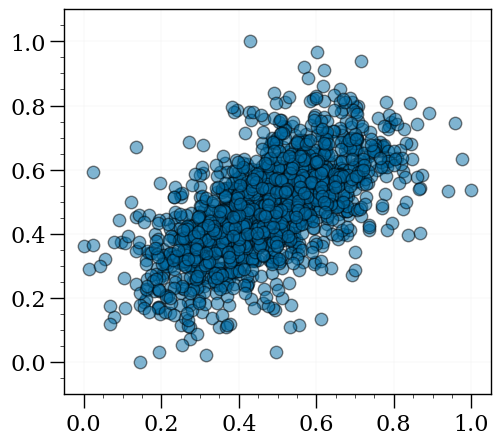

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:28<79:31:47, 28.63s/it]

Iter 0. Loss [[ 0.07548627  0.28225192 19.931568  ]]


  0%|          | 12/10000 [00:55<1:30:03,  1.85it/s]

Iter 10. Loss [[0.0799323  0.25588286 5.7763104 ]]


  0%|          | 21/10000 [00:56<27:45,  5.99it/s]

Iter 20. Loss [[0.08256051 0.24578679 5.156111  ]]


  0%|          | 31/10000 [00:59<44:22,  3.74it/s]

Iter 30. Loss [[0.08546723 0.2374953  4.900154  ]]


  0%|          | 42/10000 [01:02<31:31,  5.26it/s]

Iter 40. Loss [[0.08732332 0.23345158 4.8460655 ]]


  1%|          | 52/10000 [01:03<26:37,  6.23it/s]

Iter 50. Loss [[0.08760357 0.23235177 4.7820725 ]]


  1%|          | 62/10000 [01:05<24:27,  6.77it/s]

Iter 60. Loss [[0.08732238 0.2321343  4.694384  ]]


  1%|          | 72/10000 [01:06<23:28,  7.05it/s]

Iter 70. Loss [[0.08738503 0.23141134 4.5778956 ]]


  1%|          | 82/10000 [01:08<30:32,  5.41it/s]

Iter 80. Loss [[0.08747281 0.23036987 4.424017  ]]


  1%|          | 92/10000 [01:10<22:19,  7.40it/s]

Iter 90. Loss [[0.08716077 0.2295594  4.1933002 ]]


  1%|          | 102/10000 [01:11<24:22,  6.77it/s]

Iter 100. Loss [[0.08671284 0.2277877  3.9240787 ]]


  1%|          | 111/10000 [01:13<37:24,  4.41it/s]

Iter 110. Loss [[0.08604902 0.22730188 3.6592553 ]]


  1%|          | 121/10000 [01:15<41:40,  3.95it/s]

Iter 120. Loss [[0.08498671 0.23015645 3.5503457 ]]


  1%|▏         | 132/10000 [01:17<24:19,  6.76it/s]

Iter 130. Loss [[0.08457577 0.22917493 3.6932187 ]]


  1%|▏         | 142/10000 [01:18<23:09,  7.10it/s]

Iter 140. Loss [[0.08431941 0.22563617 3.83178   ]]


  2%|▏         | 152/10000 [01:20<24:59,  6.57it/s]

Iter 150. Loss [[0.08387225 0.22453047 3.8519492 ]]


  2%|▏         | 162/10000 [01:22<25:45,  6.36it/s]

Iter 160. Loss [[0.08372601 0.22826569 3.8857832 ]]


  2%|▏         | 172/10000 [01:23<22:05,  7.42it/s]

Iter 170. Loss [[0.0844349  0.22945398 3.8078573 ]]


  2%|▏         | 182/10000 [01:25<24:22,  6.71it/s]

Iter 180. Loss [[0.08585962 0.22823636 3.6690683 ]]


  2%|▏         | 191/10000 [01:26<25:27,  6.42it/s]

Iter 190. Loss [[0.0876134  0.22786942 3.6440215 ]]


  2%|▏         | 201/10000 [01:28<39:50,  4.10it/s]

Iter 200. Loss [[0.09018628 0.22279637 3.7259076 ]]


  2%|▏         | 212/10000 [01:31<28:34,  5.71it/s]

Iter 210. Loss [[0.09414363 0.21444681 3.7605894 ]]


  2%|▏         | 222/10000 [01:32<22:25,  7.27it/s]

Iter 220. Loss [[0.10044285 0.20367411 3.6566653 ]]


  2%|▏         | 232/10000 [01:34<22:30,  7.23it/s]

Iter 230. Loss [[0.10925347 0.18931384 3.5460043 ]]


  2%|▏         | 242/10000 [01:35<22:51,  7.11it/s]

Iter 240. Loss [[0.11884167 0.17808555 3.3551972 ]]


  3%|▎         | 252/10000 [01:36<25:29,  6.37it/s]

Iter 250. Loss [[0.12692085 0.16993529 3.045658  ]]


  3%|▎         | 262/10000 [01:38<24:16,  6.68it/s]

Iter 260. Loss [[0.13117933 0.1636404  2.6086996 ]]


  3%|▎         | 272/10000 [01:39<24:30,  6.62it/s]

Iter 270. Loss [[0.13408339 0.15447076 1.8842316 ]]


  3%|▎         | 281/10000 [01:41<38:16,  4.23it/s]

Iter 280. Loss [[0.13206698 0.137439   1.3540812 ]]


  3%|▎         | 291/10000 [01:44<44:52,  3.61it/s]

Iter 290. Loss [[0.133068  0.1219269 1.1469584]]


  3%|▎         | 301/10000 [01:47<41:52,  3.86it/s]

Iter 300. Loss [[0.13855657 0.11488684 0.9068454 ]]


  3%|▎         | 312/10000 [01:49<29:54,  5.40it/s]

Iter 310. Loss [[0.15054451 0.14416961 0.44868267]]


  3%|▎         | 322/10000 [01:51<24:18,  6.64it/s]

Iter 320. Loss [[0.16310887 0.14976028 0.34678397]]


  3%|▎         | 332/10000 [01:52<21:31,  7.48it/s]

Iter 330. Loss [[ 0.17057118  0.19177917 -0.18527143]]


  3%|▎         | 342/10000 [01:53<21:27,  7.50it/s]

Iter 340. Loss [[ 0.18410444  0.14823315 -0.10763326]]


  4%|▎         | 352/10000 [01:55<22:29,  7.15it/s]

Iter 350. Loss [[ 0.19280873  0.1547089  -0.30104908]]


  4%|▎         | 362/10000 [01:57<23:46,  6.76it/s]

Iter 360. Loss [[ 0.19982845  0.15298134 -0.37368074]]


  4%|▎         | 372/10000 [01:58<23:50,  6.73it/s]

Iter 370. Loss [[ 0.20872693  0.11828861 -0.33239895]]


  4%|▍         | 381/10000 [02:00<36:45,  4.36it/s]

Iter 380. Loss [[ 0.21853426  0.09603721 -0.32323754]]


  4%|▍         | 391/10000 [02:02<36:07,  4.43it/s]

Iter 390. Loss [[ 0.22989936  0.08660254 -0.35510442]]


  4%|▍         | 402/10000 [02:04<25:19,  6.32it/s]

Iter 400. Loss [[ 0.24002156  0.08674508 -0.36494654]]


  4%|▍         | 412/10000 [02:06<23:33,  6.78it/s]

Iter 410. Loss [[ 0.24529111  0.08158449 -0.30032125]]


  4%|▍         | 422/10000 [02:07<22:13,  7.18it/s]

Iter 420. Loss [[ 0.24490595  0.06950872 -0.21452011]]


  4%|▍         | 432/10000 [02:09<20:55,  7.62it/s]

Iter 430. Loss [[ 0.24157973  0.0708859  -0.22799537]]


  4%|▍         | 442/10000 [02:10<23:52,  6.67it/s]

Iter 440. Loss [[ 0.24261329  0.06709284 -0.21150196]]


  5%|▍         | 452/10000 [02:12<23:30,  6.77it/s]

Iter 450. Loss [[ 0.24563323  0.06621047 -0.22537895]]


  5%|▍         | 462/10000 [02:13<23:35,  6.74it/s]

Iter 460. Loss [[ 0.24823146  0.0648479  -0.21871202]]


  5%|▍         | 471/10000 [02:16<40:07,  3.96it/s]

Iter 470. Loss [[ 0.24899195  0.0636064  -0.21699914]]


  5%|▍         | 482/10000 [02:18<27:38,  5.74it/s]

Iter 480. Loss [[ 0.24860907  0.0591973  -0.19884273]]


  5%|▍         | 492/10000 [02:20<23:42,  6.68it/s]

Iter 490. Loss [[ 0.24775504  0.0591719  -0.21422738]]


  5%|▌         | 502/10000 [02:21<23:25,  6.76it/s]

Iter 500. Loss [[ 0.2460804   0.06477228 -0.27890942]]


  5%|▌         | 512/10000 [02:22<23:47,  6.65it/s]

Iter 510. Loss [[ 0.24563573  0.07190077 -0.3637296 ]]


  5%|▌         | 522/10000 [02:24<23:24,  6.75it/s]

Iter 520. Loss [[ 0.2479429   0.08321088 -0.48307252]]


  5%|▌         | 532/10000 [02:26<31:28,  5.01it/s]

Iter 530. Loss [[ 0.25436926  0.09255833 -0.59361124]]


  5%|▌         | 542/10000 [02:27<24:06,  6.54it/s]

Iter 540. Loss [[ 0.26473695  0.09858445 -0.6933658 ]]


  6%|▌         | 551/10000 [02:29<37:44,  4.17it/s]

Iter 550. Loss [[ 0.27519444  0.10549526 -0.7351439 ]]


  6%|▌         | 561/10000 [02:32<38:00,  4.14it/s]

Iter 560. Loss [[ 0.27586553  0.09638768 -0.68666404]]


  6%|▌         | 572/10000 [02:33<23:11,  6.78it/s]

Iter 570. Loss [[ 0.27459255  0.08351856 -0.6495848 ]]


  6%|▌         | 582/10000 [02:35<23:00,  6.82it/s]

Iter 580. Loss [[ 0.28413087  0.08456051 -0.7174665 ]]


  6%|▌         | 592/10000 [02:36<23:22,  6.71it/s]

Iter 590. Loss [[ 0.29693303  0.09226531 -0.79733837]]


  6%|▌         | 602/10000 [02:38<22:43,  6.89it/s]

Iter 600. Loss [[ 0.30181268  0.09145809 -0.8294865 ]]


  6%|▌         | 612/10000 [02:39<22:54,  6.83it/s]

Iter 610. Loss [[ 0.30122018  0.08784359 -0.82853794]]


  6%|▌         | 622/10000 [02:41<22:49,  6.85it/s]

Iter 620. Loss [[ 0.30288407  0.0912136  -0.88713706]]


  6%|▋         | 631/10000 [02:42<26:02,  6.00it/s]

Iter 630. Loss [[ 0.30964613  0.10557275 -0.89720297]]


  6%|▋         | 641/10000 [02:44<37:05,  4.20it/s]

Iter 640. Loss [[ 0.30755278  0.08467082 -0.74150205]]


  7%|▋         | 652/10000 [02:47<29:54,  5.21it/s]

Iter 650. Loss [[ 0.30053496  0.06821659 -0.6032446 ]]


  7%|▋         | 662/10000 [02:49<22:53,  6.80it/s]

Iter 660. Loss [[ 0.29830265  0.06574102 -0.54586107]]


  7%|▋         | 672/10000 [02:50<22:43,  6.84it/s]

Iter 670. Loss [[ 0.29458478  0.06778722 -0.51869106]]


  7%|▋         | 682/10000 [02:52<22:44,  6.83it/s]

Iter 680. Loss [[ 0.291194    0.07667679 -0.62621534]]


  7%|▋         | 692/10000 [02:53<22:29,  6.90it/s]

Iter 690. Loss [[ 0.29591247  0.07152376 -0.7085431 ]]


  7%|▋         | 702/10000 [02:54<22:45,  6.81it/s]

Iter 700. Loss [[ 0.30234477  0.0881846  -0.80208254]]


  7%|▋         | 712/10000 [02:56<22:25,  6.90it/s]

Iter 710. Loss [[ 0.29150873  0.08751787 -0.76763785]]


  7%|▋         | 721/10000 [02:58<41:33,  3.72it/s]

Iter 720. Loss [[ 0.29289293  0.08310078 -0.77477735]]


  7%|▋         | 732/10000 [03:01<32:42,  4.72it/s]

Iter 730. Loss [[ 0.29759994  0.08209203 -0.829157  ]]


  7%|▋         | 742/10000 [03:02<23:07,  6.67it/s]

Iter 740. Loss [[ 0.29579484  0.08187298 -0.7736619 ]]


  8%|▊         | 752/10000 [03:04<22:28,  6.86it/s]

Iter 750. Loss [[ 0.292011    0.08186778 -0.6922076 ]]


  8%|▊         | 762/10000 [03:05<22:23,  6.88it/s]

Iter 760. Loss [[ 0.2906326   0.08393269 -0.6882761 ]]


  8%|▊         | 772/10000 [03:07<25:21,  6.06it/s]

Iter 770. Loss [[ 0.28893158  0.08592492 -0.72828597]]


  8%|▊         | 782/10000 [03:09<22:51,  6.72it/s]

Iter 780. Loss [[ 0.28433472  0.08674043 -0.7020592 ]]


  8%|▊         | 792/10000 [03:10<22:33,  6.80it/s]

Iter 790. Loss [[ 0.28458092  0.09286981 -0.70663893]]


  8%|▊         | 801/10000 [03:12<35:09,  4.36it/s]

Iter 800. Loss [[ 0.2854324   0.09663464 -0.7119749 ]]


  8%|▊         | 811/10000 [03:14<36:30,  4.19it/s]

Iter 810. Loss [[ 0.28131947  0.09436863 -0.6734163 ]]


  8%|▊         | 822/10000 [03:16<23:39,  6.47it/s]

Iter 820. Loss [[ 0.27434507  0.0941857  -0.58160645]]


  8%|▊         | 832/10000 [03:18<21:50,  7.00it/s]

Iter 830. Loss [[ 0.2615534   0.09667448 -0.5913753 ]]


  8%|▊         | 842/10000 [03:19<20:03,  7.61it/s]

Iter 840. Loss [[ 0.25977123  0.08130541 -0.4197347 ]]


  9%|▊         | 852/10000 [03:21<23:41,  6.44it/s]

Iter 850. Loss [[ 0.2542348   0.08244361 -0.02442496]]


  9%|▊         | 862/10000 [03:22<22:41,  6.71it/s]

Iter 860. Loss [[0.22392353 0.05398021 0.0261936 ]]


  9%|▊         | 872/10000 [03:24<22:31,  6.75it/s]

Iter 870. Loss [[ 0.21772039  0.0836074  -0.14883289]]


  9%|▉         | 881/10000 [03:25<23:20,  6.51it/s]

Iter 880. Loss [[ 0.23662281  0.06935875 -0.18594027]]


  9%|▉         | 891/10000 [03:27<36:42,  4.14it/s]

Iter 890. Loss [[ 0.2476092   0.0846994  -0.30311137]]


  9%|▉         | 902/10000 [03:30<27:38,  5.48it/s]

Iter 900. Loss [[ 0.25229278  0.0924048  -0.36164168]]


  9%|▉         | 912/10000 [03:31<21:59,  6.89it/s]

Iter 910. Loss [[ 0.2549619   0.09048554 -0.3533535 ]]


  9%|▉         | 922/10000 [03:33<21:37,  7.00it/s]

Iter 920. Loss [[ 0.25377172  0.08724851 -0.35916796]]


  9%|▉         | 932/10000 [03:34<22:14,  6.80it/s]

Iter 930. Loss [[ 0.2549612   0.08880864 -0.3824138 ]]


  9%|▉         | 942/10000 [03:36<21:55,  6.88it/s]

Iter 940. Loss [[ 0.25771976  0.09266484 -0.4180698 ]]


 10%|▉         | 952/10000 [03:37<22:24,  6.73it/s]

Iter 950. Loss [[ 0.25925562  0.09525543 -0.44736186]]


 10%|▉         | 962/10000 [03:39<22:14,  6.77it/s]

Iter 960. Loss [[ 0.2602273   0.09554739 -0.46081012]]


 10%|▉         | 971/10000 [03:40<30:24,  4.95it/s]

Iter 970. Loss [[ 0.26123506  0.09320906 -0.46726274]]


 10%|▉         | 981/10000 [03:43<45:06,  3.33it/s]

Iter 980. Loss [[ 0.26252028  0.09279633 -0.48004207]]


 10%|▉         | 991/10000 [03:46<45:24,  3.31it/s]

Iter 990. Loss [[ 0.26413223  0.09211674 -0.4997031 ]]


 10%|█         | 1002/10000 [03:48<25:10,  5.96it/s]

Iter 1000. Loss [[ 0.26566336  0.09189412 -0.5115581 ]]


 10%|█         | 1012/10000 [03:50<21:56,  6.83it/s]

Iter 1010. Loss [[ 0.2668524   0.09414914 -0.55470604]]


 10%|█         | 1022/10000 [03:51<21:55,  6.82it/s]

Iter 1020. Loss [[ 0.26818028  0.0940892  -0.5824952 ]]


 10%|█         | 1032/10000 [03:53<22:03,  6.78it/s]

Iter 1030. Loss [[ 0.267953    0.08938775 -0.57749766]]


 10%|█         | 1042/10000 [03:55<29:28,  5.06it/s]

Iter 1040. Loss [[ 0.26887324  0.08703984 -0.59311223]]


 11%|█         | 1052/10000 [03:56<22:14,  6.71it/s]

Iter 1050. Loss [[ 0.2711273   0.0881111  -0.61624956]]


 11%|█         | 1061/10000 [03:58<22:44,  6.55it/s]

Iter 1060. Loss [[ 0.2723298   0.08785781 -0.6308726 ]]


 11%|█         | 1071/10000 [04:00<35:21,  4.21it/s]

Iter 1070. Loss [[ 0.27196974  0.08495168 -0.6723291 ]]


 11%|█         | 1082/10000 [04:02<27:57,  5.32it/s]

Iter 1080. Loss [[ 0.26895452  0.07995034 -0.70516795]]


 11%|█         | 1092/10000 [04:04<25:34,  5.81it/s]

Iter 1090. Loss [[ 0.2655573   0.07921302 -0.75384295]]


 11%|█         | 1102/10000 [04:06<21:55,  6.76it/s]

Iter 1100. Loss [[ 0.26113418  0.08189514 -0.8042121 ]]


 11%|█         | 1112/10000 [04:07<22:05,  6.70it/s]

Iter 1110. Loss [[ 0.26038572  0.08095036 -0.8074903 ]]


 11%|█         | 1122/10000 [04:09<21:41,  6.82it/s]

Iter 1120. Loss [[ 0.26041177  0.08160209 -0.8037919 ]]


 11%|█▏        | 1132/10000 [04:10<21:52,  6.76it/s]

Iter 1130. Loss [[ 0.26240265  0.08000813 -0.8185363 ]]


 11%|█▏        | 1142/10000 [04:12<21:34,  6.84it/s]

Iter 1140. Loss [[ 0.26002157  0.08103421 -0.8091336 ]]


 12%|█▏        | 1151/10000 [04:13<33:53,  4.35it/s]

Iter 1150. Loss [[ 0.24781889  0.08620236 -0.78023845]]


 12%|█▏        | 1161/10000 [04:16<35:42,  4.13it/s]

Iter 1160. Loss [[ 0.2549067   0.08186546 -0.8312577 ]]


 12%|█▏        | 1172/10000 [04:18<23:58,  6.14it/s]

Iter 1170. Loss [[ 0.25841123  0.07318115 -0.85852516]]


 12%|█▏        | 1182/10000 [04:20<21:42,  6.77it/s]

Iter 1180. Loss [[ 0.2595292   0.07665917 -0.8641801 ]]


 12%|█▏        | 1192/10000 [04:21<21:04,  6.96it/s]

Iter 1190. Loss [[ 0.26003855  0.07484566 -0.87531984]]


 12%|█▏        | 1202/10000 [04:22<21:41,  6.76it/s]

Iter 1200. Loss [[ 0.2602784   0.07334625 -0.8504742 ]]


 12%|█▏        | 1212/10000 [04:24<21:21,  6.86it/s]

Iter 1210. Loss [[ 0.25863227  0.07119392 -0.8288706 ]]


 12%|█▏        | 1222/10000 [04:25<21:24,  6.83it/s]

Iter 1220. Loss [[ 0.2572775   0.07081688 -0.8068727 ]]


 12%|█▏        | 1231/10000 [04:27<27:22,  5.34it/s]

Iter 1230. Loss [[ 0.25782114  0.06803002 -0.7922096 ]]


 12%|█▏        | 1241/10000 [04:30<1:00:03,  2.43it/s]

Iter 1240. Loss [[ 0.25652322  0.06680857 -0.7992862 ]]


 13%|█▎        | 1252/10000 [04:32<23:20,  6.25it/s]

Iter 1250. Loss [[ 0.25638592  0.06532679 -0.79714775]]


 13%|█▎        | 1262/10000 [04:33<21:38,  6.73it/s]

Iter 1260. Loss [[ 0.25682586  0.0686082  -0.81743425]]


 13%|█▎        | 1272/10000 [04:35<21:46,  6.68it/s]

Iter 1270. Loss [[ 0.25689587  0.06936492 -0.80851674]]


 13%|█▎        | 1282/10000 [04:36<21:44,  6.68it/s]

Iter 1280. Loss [[ 0.24849525  0.07354513 -0.82658577]]


 13%|█▎        | 1292/10000 [04:38<27:05,  5.36it/s]

Iter 1290. Loss [[ 0.25108176  0.0732239  -0.85165805]]


 13%|█▎        | 1302/10000 [04:40<21:36,  6.71it/s]

Iter 1300. Loss [[ 0.25389698  0.07633489 -0.74090475]]


 13%|█▎        | 1311/10000 [04:41<23:23,  6.19it/s]

Iter 1310. Loss [[ 0.24292381  0.11177531 -0.60567325]]


 13%|█▎        | 1321/10000 [04:43<35:12,  4.11it/s]

Iter 1320. Loss [[ 0.24517857  0.07677723 -0.64422673]]


 13%|█▎        | 1332/10000 [04:46<26:26,  5.46it/s]

Iter 1330. Loss [[ 0.23584126  0.06652639 -0.6892513 ]]


 13%|█▎        | 1342/10000 [04:47<21:09,  6.82it/s]

Iter 1340. Loss [[ 0.23762526  0.06954951 -0.7229339 ]]


 14%|█▎        | 1352/10000 [04:49<20:51,  6.91it/s]

Iter 1350. Loss [[ 0.24768233  0.07153122 -0.8064417 ]]


 14%|█▎        | 1362/10000 [04:51<22:50,  6.30it/s]

Iter 1360. Loss [[ 0.25547722  0.0745415  -0.8133626 ]]


 14%|█▎        | 1372/10000 [04:52<21:16,  6.76it/s]

Iter 1370. Loss [[ 0.25897312  0.07473475 -0.83789986]]


 14%|█▍        | 1382/10000 [04:53<20:49,  6.89it/s]

Iter 1380. Loss [[ 0.26079735  0.08162732 -0.88563776]]


 14%|█▍        | 1392/10000 [04:55<20:08,  7.12it/s]

Iter 1390. Loss [[ 0.263036    0.08388342 -0.9149061 ]]


 14%|█▍        | 1401/10000 [04:57<32:50,  4.36it/s]

Iter 1400. Loss [[ 0.26141778  0.08126    -0.9198206 ]]


 14%|█▍        | 1411/10000 [04:59<34:47,  4.11it/s]

Iter 1410. Loss [[ 0.26427346  0.07304123 -0.87467986]]


 14%|█▍        | 1422/10000 [05:01<21:47,  6.56it/s]

Iter 1420. Loss [[ 0.26403672  0.07430812 -0.8483336 ]]


 14%|█▍        | 1432/10000 [05:02<21:41,  6.59it/s]

Iter 1430. Loss [[ 0.26619938  0.0698474  -0.81398785]]


 14%|█▍        | 1442/10000 [05:04<21:03,  6.77it/s]

Iter 1440. Loss [[ 0.26534405  0.07343407 -0.81702065]]


 15%|█▍        | 1452/10000 [05:05<21:34,  6.61it/s]

Iter 1450. Loss [[ 0.26435706  0.07603926 -0.7983391 ]]


 15%|█▍        | 1462/10000 [05:07<20:56,  6.79it/s]

Iter 1460. Loss [[ 0.2637325   0.07299164 -0.76002425]]


 15%|█▍        | 1472/10000 [05:08<21:42,  6.55it/s]

Iter 1470. Loss [[ 0.26265284  0.07104668 -0.7068247 ]]


 15%|█▍        | 1482/10000 [05:10<21:36,  6.57it/s]

Iter 1480. Loss [[ 0.26302564  0.07367615 -0.71721375]]


 15%|█▍        | 1491/10000 [05:13<36:11,  3.92it/s]

Iter 1490. Loss [[ 0.26313016  0.07105009 -0.70548385]]


 15%|█▌        | 1502/10000 [05:15<23:50,  5.94it/s]

Iter 1500. Loss [[ 0.26178837  0.07044498 -0.7113465 ]]


 15%|█▌        | 1512/10000 [05:16<20:18,  6.97it/s]

Iter 1510. Loss [[ 0.26119566  0.06971408 -0.6933775 ]]


 15%|█▌        | 1522/10000 [05:18<20:38,  6.85it/s]

Iter 1520. Loss [[ 0.26061234  0.06622878 -0.6946821 ]]


 15%|█▌        | 1532/10000 [05:19<21:04,  6.69it/s]

Iter 1530. Loss [[ 0.26023704  0.06412134 -0.6721742 ]]


 15%|█▌        | 1542/10000 [05:21<21:10,  6.66it/s]

Iter 1540. Loss [[ 0.26055473  0.06246717 -0.65036684]]


 16%|█▌        | 1552/10000 [05:23<22:10,  6.35it/s]

Iter 1550. Loss [[ 0.26120344  0.06518352 -0.6816786 ]]


 16%|█▌        | 1562/10000 [05:24<20:52,  6.74it/s]

Iter 1560. Loss [[ 0.25953984  0.0641822  -0.7087498 ]]


 16%|█▌        | 1571/10000 [05:26<33:16,  4.22it/s]

Iter 1570. Loss [[ 0.25807312  0.05648201 -0.66494524]]


 16%|█▌        | 1581/10000 [05:28<34:46,  4.04it/s]

Iter 1580. Loss [[ 0.2593567   0.05685615 -0.62382126]]


 16%|█▌        | 1592/10000 [05:30<21:00,  6.67it/s]

Iter 1590. Loss [[ 0.26350585  0.05694703 -0.6590447 ]]


 16%|█▌        | 1602/10000 [05:32<20:22,  6.87it/s]

Iter 1600. Loss [[ 0.25332716  0.10364385 -0.30969024]]


 16%|█▌        | 1612/10000 [05:33<21:01,  6.65it/s]

Iter 1610. Loss [[ 0.25875965  0.05686337 -0.22466026]]


 16%|█▌        | 1622/10000 [05:34<20:47,  6.71it/s]

Iter 1620. Loss [[ 0.25011373  0.05256637 -0.33259314]]


 16%|█▋        | 1632/10000 [05:36<21:39,  6.44it/s]

Iter 1630. Loss [[ 0.25479946  0.04537266 -0.57219994]]


 16%|█▋        | 1642/10000 [05:38<20:17,  6.87it/s]

Iter 1640. Loss [[ 0.25454655  0.04422368 -0.14645948]]


 17%|█▋        | 1651/10000 [05:40<31:33,  4.41it/s]

Iter 1650. Loss [[ 0.2522294   0.04640053 -0.25837004]]


 17%|█▋        | 1661/10000 [05:42<41:58,  3.31it/s]

Iter 1660. Loss [[ 0.25408757  0.04652789 -0.5255749 ]]


 17%|█▋        | 1671/10000 [05:45<35:07,  3.95it/s]

Iter 1670. Loss [[ 0.25164038  0.0531185  -0.52744585]]


 17%|█▋        | 1682/10000 [05:48<23:50,  5.82it/s]

Iter 1680. Loss [[ 0.25339296  0.05279615 -0.5040541 ]]


 17%|█▋        | 1692/10000 [05:49<20:28,  6.77it/s]

Iter 1690. Loss [[ 0.25535935  0.04927922 -0.4411473 ]]


 17%|█▋        | 1702/10000 [05:51<20:24,  6.78it/s]

Iter 1700. Loss [[ 0.2511882   0.04945666 -0.41166535]]


 17%|█▋        | 1712/10000 [05:52<20:30,  6.74it/s]

Iter 1710. Loss [[ 0.25073525  0.05190596 -0.3970887 ]]


 17%|█▋        | 1722/10000 [05:53<18:37,  7.41it/s]

Iter 1720. Loss [[ 0.25239497  0.05020902 -0.4008151 ]]


 17%|█▋        | 1732/10000 [05:55<18:07,  7.60it/s]

Iter 1730. Loss [[ 0.25020963  0.0497371  -0.37631324]]


 17%|█▋        | 1741/10000 [05:57<31:53,  4.32it/s]

Iter 1740. Loss [[ 0.25014457  0.04517404 -0.39784864]]


 18%|█▊        | 1751/10000 [05:59<33:27,  4.11it/s]

Iter 1750. Loss [[ 0.25036123  0.05162521 -0.36278227]]


 18%|█▊        | 1762/10000 [06:01<24:52,  5.52it/s]

Iter 1760. Loss [[ 0.2522166   0.04964319 -0.36659968]]


 18%|█▊        | 1772/10000 [06:03<20:47,  6.60it/s]

Iter 1770. Loss [[ 0.2535704   0.04650302 -0.31906742]]


 18%|█▊        | 1782/10000 [06:04<20:18,  6.75it/s]

Iter 1780. Loss [[ 0.25423753  0.04694027 -0.2552539 ]]


 18%|█▊        | 1792/10000 [06:06<20:47,  6.58it/s]

Iter 1790. Loss [[ 0.25445184  0.0443901  -0.22343875]]


 18%|█▊        | 1802/10000 [06:07<20:18,  6.73it/s]

Iter 1800. Loss [[ 0.2541254   0.04542454 -0.26547825]]


 18%|█▊        | 1812/10000 [06:09<20:08,  6.78it/s]

Iter 1810. Loss [[ 0.25498348  0.04502719 -0.2939675 ]]


 18%|█▊        | 1822/10000 [06:10<20:06,  6.78it/s]

Iter 1820. Loss [[ 0.25544313  0.04874287 -0.34741166]]


 18%|█▊        | 1831/10000 [06:12<29:38,  4.59it/s]

Iter 1830. Loss [[ 0.25532874  0.05123134 -0.41194385]]


 18%|█▊        | 1841/10000 [06:14<33:02,  4.12it/s]

Iter 1840. Loss [[0.2532655  0.07430537 0.49842688]]


 19%|█▊        | 1852/10000 [06:16<21:44,  6.25it/s]

Iter 1850. Loss [[0.2394469  0.04410542 0.3471733 ]]


 19%|█▊        | 1862/10000 [06:18<19:20,  7.01it/s]

Iter 1860. Loss [[ 0.21967931  0.05972328 -0.00594066]]


 19%|█▊        | 1872/10000 [06:20<24:11,  5.60it/s]

Iter 1870. Loss [[ 0.22026135  0.04462274 -0.03579464]]


 19%|█▉        | 1882/10000 [06:21<20:04,  6.74it/s]

Iter 1880. Loss [[ 0.23088384  0.02483309 -0.01130101]]


 19%|█▉        | 1892/10000 [06:22<19:44,  6.84it/s]

Iter 1890. Loss [[0.23759058 0.02068178 0.18289363]]


 19%|█▉        | 1902/10000 [06:24<19:55,  6.77it/s]

Iter 1900. Loss [[0.24136798 0.01971036 0.09902177]]


 19%|█▉        | 1912/10000 [06:25<19:54,  6.77it/s]

Iter 1910. Loss [[0.24082895 0.02029091 0.04756759]]


 19%|█▉        | 1921/10000 [06:27<32:19,  4.16it/s]

Iter 1920. Loss [[ 0.24277823  0.0208098  -0.03541955]]


 19%|█▉        | 1931/10000 [06:30<32:10,  4.18it/s]

Iter 1930. Loss [[ 0.24895103  0.02237336 -0.1299645 ]]


 19%|█▉        | 1942/10000 [06:32<29:24,  4.57it/s]

Iter 1940. Loss [[ 0.25566787  0.02919138 -0.24461266]]


 20%|█▉        | 1952/10000 [06:33<20:18,  6.60it/s]

Iter 1950. Loss [[ 0.2630008   0.03870427 -0.34575057]]


 20%|█▉        | 1962/10000 [06:35<19:41,  6.80it/s]

Iter 1960. Loss [[ 0.26808032  0.04875537 -0.4253548 ]]


 20%|█▉        | 1972/10000 [06:36<19:52,  6.73it/s]

Iter 1970. Loss [[ 0.2705986   0.05584958 -0.46816316]]


 20%|█▉        | 1982/10000 [06:38<19:38,  6.80it/s]

Iter 1980. Loss [[ 0.2702737   0.04605174 -0.47695243]]


 20%|█▉        | 1992/10000 [06:40<26:26,  5.05it/s]

Iter 1990. Loss [[ 0.27049485  0.04179083 -0.42159653]]


 20%|██        | 2001/10000 [06:42<30:51,  4.32it/s]

Iter 2000. Loss [[ 0.27488363  0.05250676 -0.47143286]]


 20%|██        | 2011/10000 [06:44<31:43,  4.20it/s]

Iter 2010. Loss [[ 0.27740434  0.06023173 -0.5265328 ]]


 20%|██        | 2022/10000 [06:46<19:54,  6.68it/s]

Iter 2020. Loss [[ 0.2778163   0.0604941  -0.55018336]]


 20%|██        | 2032/10000 [06:47<19:33,  6.79it/s]

Iter 2030. Loss [[ 0.27774906  0.0623819  -0.5963114 ]]


 20%|██        | 2042/10000 [06:49<19:15,  6.89it/s]

Iter 2040. Loss [[ 0.2786752   0.06571367 -0.6376542 ]]


 21%|██        | 2052/10000 [06:50<20:04,  6.60it/s]

Iter 2050. Loss [[ 0.2792447   0.06549142 -0.65938836]]


 21%|██        | 2062/10000 [06:52<20:41,  6.39it/s]

Iter 2060. Loss [[ 0.279722    0.0641971  -0.67029905]]


 21%|██        | 2072/10000 [06:54<19:32,  6.76it/s]

Iter 2070. Loss [[ 0.2814857   0.06435595 -0.69740313]]


 21%|██        | 2081/10000 [06:55<29:16,  4.51it/s]

Iter 2080. Loss [[ 0.28418374  0.06754421 -0.7363418 ]]


 21%|██        | 2091/10000 [06:58<31:11,  4.23it/s]

Iter 2090. Loss [[ 0.28585118  0.06977528 -0.7685188 ]]


 21%|██        | 2102/10000 [07:00<21:10,  6.22it/s]

Iter 2100. Loss [[ 0.28668022  0.07399832 -0.8069271 ]]


 21%|██        | 2112/10000 [07:01<19:10,  6.86it/s]

Iter 2110. Loss [[ 0.28646776  0.07500789 -0.8066917 ]]


 21%|██        | 2122/10000 [07:03<19:18,  6.80it/s]

Iter 2120. Loss [[ 0.28524056  0.07547382 -0.7912397 ]]


 21%|██▏       | 2132/10000 [07:04<19:14,  6.82it/s]

Iter 2130. Loss [[ 0.28369206  0.07363735 -0.79749805]]


 21%|██▏       | 2142/10000 [07:06<19:22,  6.76it/s]

Iter 2140. Loss [[ 0.2836662   0.07865722 -0.8288167 ]]


 22%|██▏       | 2152/10000 [07:08<32:46,  3.99it/s]

Iter 2150. Loss [[ 0.28077078  0.07516655 -0.7399337 ]]


 22%|██▏       | 2162/10000 [07:09<21:38,  6.04it/s]

Iter 2160. Loss [[ 0.27042156  0.04324877 -0.19823244]]


 22%|██▏       | 2171/10000 [07:11<31:19,  4.17it/s]

Iter 2170. Loss [[0.26142743 0.03099008 0.12376595]]


 22%|██▏       | 2182/10000 [07:14<25:19,  5.14it/s]

Iter 2180. Loss [[0.26193082 0.02893143 0.14426422]]


 22%|██▏       | 2192/10000 [07:15<19:15,  6.76it/s]

Iter 2190. Loss [[ 0.26739085  0.02935235 -0.11138693]]


 22%|██▏       | 2202/10000 [07:17<19:10,  6.78it/s]

Iter 2200. Loss [[ 0.2765304   0.03636937 -0.4094991 ]]


 22%|██▏       | 2212/10000 [07:18<19:02,  6.82it/s]

Iter 2210. Loss [[ 0.27929473  0.03679985 -0.41551676]]


 22%|██▏       | 2222/10000 [07:19<19:57,  6.50it/s]

Iter 2220. Loss [[ 0.2778914   0.03588361 -0.3805416 ]]


 22%|██▏       | 2232/10000 [07:21<19:32,  6.63it/s]

Iter 2230. Loss [[ 0.27849984  0.03828913 -0.493208  ]]


 22%|██▏       | 2242/10000 [07:22<19:33,  6.61it/s]

Iter 2240. Loss [[ 0.28056046  0.04540695 -0.58172876]]


 23%|██▎       | 2251/10000 [07:24<24:54,  5.19it/s]

Iter 2250. Loss [[ 0.27758962  0.08627963 -0.2665028 ]]


 23%|██▎       | 2261/10000 [07:26<31:56,  4.04it/s]

Iter 2260. Loss [[0.21876067 0.99399346 6.6384177 ]]


 23%|██▎       | 2272/10000 [07:29<20:45,  6.21it/s]

Iter 2270. Loss [[ 0.19685416  0.30443415 12.902419  ]]


 23%|██▎       | 2282/10000 [07:30<19:18,  6.66it/s]

Iter 2280. Loss [[0.15526266 0.30529976 8.697121  ]]


 23%|██▎       | 2292/10000 [07:32<19:21,  6.64it/s]

Iter 2290. Loss [[0.11217598 0.30767998 7.0217147 ]]


 23%|██▎       | 2302/10000 [07:33<18:52,  6.80it/s]

Iter 2300. Loss [[0.09815056 0.30876744 7.1225142 ]]


 23%|██▎       | 2312/10000 [07:34<19:29,  6.58it/s]

Iter 2310. Loss [[0.13117656 0.32880273 6.660971  ]]


 23%|██▎       | 2322/10000 [07:36<17:33,  7.29it/s]

Iter 2320. Loss [[0.12549487 0.33132964 6.439307  ]]


 23%|██▎       | 2332/10000 [07:37<18:58,  6.73it/s]

Iter 2330. Loss [[0.09683861 0.3243864  5.9439945 ]]


 23%|██▎       | 2341/10000 [07:39<33:26,  3.82it/s]

Iter 2340. Loss [[0.16855901 0.36439857 6.3030353 ]]


 24%|██▎       | 2351/10000 [07:42<33:27,  3.81it/s]

Iter 2350. Loss [[0.12690653 0.35506782 5.6401844 ]]


 24%|██▎       | 2361/10000 [07:45<39:17,  3.24it/s]

Iter 2360. Loss [[0.08355837 0.3260295  6.1850677 ]]


 24%|██▎       | 2372/10000 [07:47<21:04,  6.03it/s]

Iter 2370. Loss [[0.08840853 0.3340209  5.9089556 ]]


 24%|██▍       | 2382/10000 [07:49<19:50,  6.40it/s]

Iter 2380. Loss [[0.12826721 0.35330036 6.145063  ]]


 24%|██▍       | 2392/10000 [07:50<19:09,  6.62it/s]

Iter 2390. Loss [[0.15708275 0.37046325 6.3385987 ]]


 24%|██▍       | 2402/10000 [07:52<18:22,  6.89it/s]

Iter 2400. Loss [[0.10380065 0.35055363 5.6042876 ]]


 24%|██▍       | 2412/10000 [07:53<18:22,  6.89it/s]

Iter 2410. Loss [[0.08339747 0.3343328  5.8962417 ]]


 24%|██▍       | 2422/10000 [07:55<18:51,  6.70it/s]

Iter 2420. Loss [[0.09133034 0.3476862  5.6896853 ]]


 24%|██▍       | 2431/10000 [07:56<27:41,  4.56it/s]

Iter 2430. Loss [[0.11669171 0.36768827 5.897853  ]]


 24%|██▍       | 2441/10000 [07:59<30:22,  4.15it/s]

Iter 2440. Loss [[0.10848647 0.37179202 5.79603   ]]


 25%|██▍       | 2452/10000 [08:01<19:51,  6.34it/s]

Iter 2450. Loss [[0.08950406 0.3624167  5.3964252 ]]


 25%|██▍       | 2461/10000 [08:02<19:13,  6.54it/s]

Iter 2460. Loss [[0.08965199 0.35280034 5.4286385 ]]


 25%|██▍       | 2472/10000 [08:04<17:37,  7.12it/s]

Iter 2470. Loss [[0.09390347 0.3541418  5.4821267 ]]


 25%|██▍       | 2482/10000 [08:06<17:59,  6.97it/s]

Iter 2480. Loss [[0.097162  0.3569565 5.5204597]]


 25%|██▍       | 2492/10000 [08:07<18:47,  6.66it/s]

Iter 2490. Loss [[0.09635296 0.35752806 5.4878826 ]]


 25%|██▌       | 2502/10000 [08:09<18:50,  6.63it/s]

Iter 2500. Loss [[0.08710941 0.34919125 5.434992  ]]


 25%|██▌       | 2511/10000 [08:10<19:04,  6.54it/s]

Iter 2510. Loss [[0.08607915 0.34696582 5.445885  ]]


 25%|██▌       | 2521/10000 [08:13<31:10,  4.00it/s]

Iter 2520. Loss [[0.1027998 0.3618017 5.764695 ]]


 25%|██▌       | 2532/10000 [08:15<20:56,  5.95it/s]

Iter 2530. Loss [[0.12805778 0.3816569  6.2928295 ]]


 25%|██▌       | 2542/10000 [08:17<18:19,  6.78it/s]

Iter 2540. Loss [[0.09219036 0.3666818  5.4979763 ]]


 26%|██▌       | 2552/10000 [08:18<17:05,  7.26it/s]

Iter 2550. Loss [[0.08708532 0.35484862 5.3237853 ]]


 26%|██▌       | 2562/10000 [08:19<18:01,  6.88it/s]

Iter 2560. Loss [[0.09543961 0.35917807 5.416131  ]]


 26%|██▌       | 2572/10000 [08:21<18:53,  6.55it/s]

Iter 2570. Loss [[0.11385833 0.3123699  8.591963  ]]


 26%|██▌       | 2582/10000 [08:22<18:58,  6.51it/s]

Iter 2580. Loss [[ 0.13486141  0.3073852  11.405523  ]]


 26%|██▌       | 2592/10000 [08:24<18:25,  6.70it/s]

Iter 2590. Loss [[ 0.1294028   0.30807793 11.273934  ]]


 26%|██▌       | 2601/10000 [08:27<31:24,  3.93it/s]

Iter 2600. Loss [[0.11455041 0.31085354 9.9216795 ]]


 26%|██▌       | 2611/10000 [08:31<1:27:36,  1.41it/s]

Iter 2610. Loss [[0.09500935 0.3173217  8.135388  ]]


 26%|██▌       | 2622/10000 [08:34<25:41,  4.79it/s]

Iter 2620. Loss [[0.08134477 0.3264879  6.744246  ]]


 26%|██▋       | 2632/10000 [08:36<22:21,  5.49it/s]

Iter 2630. Loss [[0.07919912 0.3391999  5.911516  ]]


 26%|██▋       | 2641/10000 [08:38<27:54,  4.39it/s]

Iter 2640. Loss [[0.08391504 0.35017365 5.8443503 ]]


 27%|██▋       | 2652/10000 [08:40<18:42,  6.55it/s]

Iter 2650. Loss [[0.08568127 0.3519429  5.709759  ]]


 27%|██▋       | 2661/10000 [08:41<25:39,  4.77it/s]

Iter 2660. Loss [[0.08427138 0.35021964 5.7431407 ]]


 27%|██▋       | 2671/10000 [08:44<29:55,  4.08it/s]

Iter 2670. Loss [[0.0843741  0.35143057 5.7340093 ]]


 27%|██▋       | 2682/10000 [08:46<19:11,  6.35it/s]

Iter 2680. Loss [[0.08637206 0.35403532 5.6808777 ]]


 27%|██▋       | 2692/10000 [08:47<17:58,  6.78it/s]

Iter 2690. Loss [[0.0873945 0.3558156 5.6632085]]


 27%|██▋       | 2702/10000 [08:49<17:36,  6.91it/s]

Iter 2700. Loss [[ 0.14143004  0.3066286  10.7348175 ]]


 27%|██▋       | 2712/10000 [08:50<18:01,  6.74it/s]

Iter 2710. Loss [[ 0.16093494  0.30477524 13.3806305 ]]


 27%|██▋       | 2722/10000 [08:52<18:00,  6.74it/s]

Iter 2720. Loss [[ 0.15993404  0.3047991  13.881226  ]]


 27%|██▋       | 2732/10000 [08:54<18:21,  6.60it/s]

Iter 2730. Loss [[ 0.15405923  0.3049713  13.669206  ]]


 27%|██▋       | 2741/10000 [08:55<17:59,  6.73it/s]

Iter 2740. Loss [[ 0.14678179  0.305308   13.290008  ]]


 28%|██▊       | 2751/10000 [08:57<29:07,  4.15it/s]

Iter 2750. Loss [[ 0.13901338  0.30582115 12.730123  ]]


 28%|██▊       | 2762/10000 [09:00<24:51,  4.85it/s]

Iter 2760. Loss [[ 0.1309136   0.30661002 11.930133  ]]


 28%|██▊       | 2772/10000 [09:01<17:56,  6.71it/s]

Iter 2770. Loss [[ 0.12225322  0.3077602  11.05919   ]]


 28%|██▊       | 2782/10000 [09:03<18:10,  6.62it/s]

Iter 2780. Loss [[0.11216138 0.3099059  9.924474  ]]


 28%|██▊       | 2792/10000 [09:04<17:44,  6.77it/s]

Iter 2790. Loss [[0.10071366 0.3132974  8.691043  ]]


 28%|██▊       | 2802/10000 [09:06<18:59,  6.32it/s]

Iter 2800. Loss [[0.08740281 0.31969273 7.417153  ]]


 28%|██▊       | 2812/10000 [09:08<18:10,  6.59it/s]

Iter 2810. Loss [[0.07798843 0.32977816 6.652064  ]]


 28%|██▊       | 2822/10000 [09:09<17:48,  6.72it/s]

Iter 2820. Loss [[0.07632605 0.34056756 6.463581  ]]


 28%|██▊       | 2831/10000 [09:11<27:21,  4.37it/s]

Iter 2830. Loss [[0.07920253 0.3478406  6.535007  ]]


 28%|██▊       | 2842/10000 [09:14<41:54,  2.85it/s]

Iter 2840. Loss [[0.08211895 0.3517829  6.721802  ]]


 29%|██▊       | 2852/10000 [09:16<18:31,  6.43it/s]

Iter 2850. Loss [[0.08375858 0.35374618 6.714085  ]]


 29%|██▊       | 2862/10000 [09:17<18:21,  6.48it/s]

Iter 2860. Loss [[0.07907131 0.3467277  6.4331274 ]]


 29%|██▊       | 2872/10000 [09:19<17:52,  6.65it/s]

Iter 2870. Loss [[0.07768992 0.3446547  6.3896017 ]]


 29%|██▉       | 2882/10000 [09:20<16:39,  7.12it/s]

Iter 2880. Loss [[0.07948505 0.34733683 6.427444  ]]


 29%|██▉       | 2892/10000 [09:22<17:43,  6.68it/s]

Iter 2890. Loss [[0.07581403 0.3400756  6.5157986 ]]


 29%|██▉       | 2902/10000 [09:24<23:45,  4.98it/s]

Iter 2900. Loss [[0.07547257 0.33652383 6.5823627 ]]


 29%|██▉       | 2911/10000 [09:25<26:45,  4.42it/s]

Iter 2910. Loss [[0.07546148 0.33763543 6.6000896 ]]


 29%|██▉       | 2921/10000 [09:28<28:35,  4.13it/s]

Iter 2920. Loss [[0.07586372 0.34097165 6.4925613 ]]


 29%|██▉       | 2932/10000 [09:30<18:32,  6.35it/s]

Iter 2930. Loss [[0.07762627 0.34627628 6.414271  ]]


 29%|██▉       | 2942/10000 [09:31<16:15,  7.24it/s]

Iter 2940. Loss [[0.08014659 0.34999275 6.5131993 ]]


 30%|██▉       | 2952/10000 [09:33<17:31,  6.70it/s]

Iter 2950. Loss [[0.08005697 0.35009107 6.499168  ]]


 30%|██▉       | 2962/10000 [09:34<17:32,  6.69it/s]

Iter 2960. Loss [[0.07895828 0.3484681  6.392667  ]]


 30%|██▉       | 2972/10000 [09:36<17:15,  6.79it/s]

Iter 2970. Loss [[0.07679524 0.3460197  6.4189115 ]]


 30%|██▉       | 2982/10000 [09:37<17:53,  6.54it/s]

Iter 2980. Loss [[0.07702208 0.34642965 6.372885  ]]


 30%|██▉       | 2991/10000 [09:39<28:17,  4.13it/s]

Iter 2990. Loss [[0.07775566 0.34756875 6.3338966 ]]


 30%|███       | 3001/10000 [09:42<33:02,  3.53it/s]

Iter 3000. Loss [[0.07671773 0.34552813 6.353441  ]]


 30%|███       | 3011/10000 [09:44<33:12,  3.51it/s]

Iter 3010. Loss [[0.07663799 0.34653592 6.331662  ]]


 30%|███       | 3022/10000 [09:47<20:16,  5.73it/s]

Iter 3020. Loss [[0.07678396 0.34886768 6.3631964 ]]


 30%|███       | 3032/10000 [09:48<20:44,  5.60it/s]

Iter 3030. Loss [[0.07708761 0.3502048  6.390773  ]]


 30%|███       | 3042/10000 [09:50<16:52,  6.87it/s]

Iter 3040. Loss [[0.07660376 0.34912375 6.3671794 ]]


 31%|███       | 3052/10000 [09:51<17:17,  6.69it/s]

Iter 3050. Loss [[0.07638489 0.34968197 6.39168   ]]


 31%|███       | 3062/10000 [09:53<17:19,  6.67it/s]

Iter 3060. Loss [[0.07649772 0.35272297 6.3979464 ]]


 31%|███       | 3072/10000 [09:54<16:56,  6.82it/s]

Iter 3070. Loss [[0.07712878 0.34932047 6.3381314 ]]


 31%|███       | 3082/10000 [09:56<16:46,  6.87it/s]

Iter 3080. Loss [[0.07742578 0.35079598 6.2888002 ]]


 31%|███       | 3091/10000 [09:58<25:36,  4.50it/s]

Iter 3090. Loss [[0.07784656 0.3474451  6.337673  ]]


 31%|███       | 3102/10000 [10:01<33:47,  3.40it/s]

Iter 3100. Loss [[0.0777541  0.34973192 6.301004  ]]


 31%|███       | 3112/10000 [10:02<18:09,  6.32it/s]

Iter 3110. Loss [[0.07785264 0.35100374 6.161071  ]]


 31%|███       | 3122/10000 [10:04<17:05,  6.70it/s]

Iter 3120. Loss [[0.07825398 0.35110408 6.041784  ]]


 31%|███▏      | 3132/10000 [10:05<17:20,  6.60it/s]

Iter 3130. Loss [[0.07850714 0.35093993 5.944154  ]]


 31%|███▏      | 3142/10000 [10:07<17:17,  6.61it/s]

Iter 3140. Loss [[0.07878397 0.35116413 5.767889  ]]


 32%|███▏      | 3152/10000 [10:09<20:33,  5.55it/s]

Iter 3150. Loss [[0.07834864 0.35392782 5.753211  ]]


 32%|███▏      | 3162/10000 [10:10<15:53,  7.17it/s]

Iter 3160. Loss [[0.0781196 0.3555806 5.737037 ]]


 32%|███▏      | 3171/10000 [10:12<24:36,  4.63it/s]

Iter 3170. Loss [[0.07768748 0.34946507 5.511548  ]]


 32%|███▏      | 3181/10000 [10:14<26:40,  4.26it/s]

Iter 3180. Loss [[0.07744434 0.34613582 5.640925  ]]


 32%|███▏      | 3192/10000 [10:16<17:20,  6.54it/s]

Iter 3190. Loss [[0.07751016 0.34860563 5.488133  ]]


 32%|███▏      | 3202/10000 [10:18<17:09,  6.60it/s]

Iter 3200. Loss [[0.07705013 0.362012   6.119982  ]]


 32%|███▏      | 3211/10000 [10:19<17:17,  6.55it/s]

Iter 3210. Loss [[0.07735111 0.36212346 6.132394  ]]


 32%|███▏      | 3222/10000 [10:21<17:04,  6.62it/s]

Iter 3220. Loss [[0.08115869 0.3449999  6.2206907 ]]


 32%|███▏      | 3232/10000 [10:22<15:52,  7.11it/s]

Iter 3230. Loss [[0.09729448 0.3296064  7.232107  ]]


 32%|███▏      | 3242/10000 [10:24<15:01,  7.50it/s]

Iter 3240. Loss [[0.09637345 0.32933903 7.3572865 ]]


 33%|███▎      | 3252/10000 [10:25<15:13,  7.38it/s]

Iter 3250. Loss [[0.08954381 0.33423302 6.964798  ]]


 33%|███▎      | 3261/10000 [10:27<26:57,  4.17it/s]

Iter 3260. Loss [[0.08292577 0.34111917 6.5787225 ]]


 33%|███▎      | 3271/10000 [10:29<26:12,  4.28it/s]

Iter 3270. Loss [[0.08372265 0.33683908 6.5933633 ]]


 33%|███▎      | 3282/10000 [10:31<17:13,  6.50it/s]

Iter 3280. Loss [[0.08799216 0.33051136 6.8152657 ]]


 33%|███▎      | 3292/10000 [10:33<16:44,  6.68it/s]

Iter 3290. Loss [[0.08503244 0.33398414 6.4937367 ]]


 33%|███▎      | 3302/10000 [10:34<16:34,  6.73it/s]

Iter 3300. Loss [[0.08320396 0.33645612 6.3953204 ]]


 33%|███▎      | 3312/10000 [10:36<21:59,  5.07it/s]

Iter 3310. Loss [[0.08856948 0.33655554 6.563281  ]]


 33%|███▎      | 3322/10000 [10:38<16:24,  6.78it/s]

Iter 3320. Loss [[0.08852474 0.3392313  6.4847746 ]]


 33%|███▎      | 3332/10000 [10:39<15:56,  6.97it/s]

Iter 3330. Loss [[0.08525646 0.34156743 6.2981367 ]]


 33%|███▎      | 3341/10000 [10:41<24:45,  4.48it/s]

Iter 3340. Loss [[0.08145644 0.34505403 6.0628424 ]]


 34%|███▎      | 3351/10000 [10:43<26:11,  4.23it/s]

Iter 3350. Loss [[0.07886805 0.34765503 6.063776  ]]


 34%|███▎      | 3362/10000 [10:45<17:30,  6.32it/s]

Iter 3360. Loss [[0.0775501  0.35142773 6.113531  ]]


 34%|███▎      | 3371/10000 [10:46<16:33,  6.67it/s]

Iter 3370. Loss [[0.07659744 0.35550505 6.055311  ]]


 34%|███▍      | 3382/10000 [10:49<16:56,  6.51it/s]

Iter 3380. Loss [[0.07676981 0.35739523 5.8800545 ]]


 34%|███▍      | 3392/10000 [10:50<16:32,  6.66it/s]

Iter 3390. Loss [[0.07693838 0.35644856 5.7232013 ]]


 34%|███▍      | 3402/10000 [10:51<16:10,  6.80it/s]

Iter 3400. Loss [[0.07801026 0.35542    5.554957  ]]


 34%|███▍      | 3412/10000 [10:53<15:00,  7.32it/s]

Iter 3410. Loss [[0.07741977 0.35877332 5.499599  ]]


 34%|███▍      | 3421/10000 [10:54<17:40,  6.20it/s]

Iter 3420. Loss [[0.07708056 0.36029503 5.4122925 ]]


 34%|███▍      | 3431/10000 [10:57<25:53,  4.23it/s]

Iter 3430. Loss [[0.07718085 0.35711673 5.3287272 ]]


 34%|███▍      | 3442/10000 [10:59<20:48,  5.25it/s]

Iter 3440. Loss [[0.07726484 0.35837975 5.296346  ]]


 35%|███▍      | 3452/10000 [11:01<24:27,  4.46it/s]

Iter 3450. Loss [[0.07764073 0.3590804  5.202346  ]]


 35%|███▍      | 3462/10000 [11:02<15:14,  7.15it/s]

Iter 3460. Loss [[0.07797695 0.35265067 5.1639385 ]]


 35%|███▍      | 3472/10000 [11:04<15:01,  7.24it/s]

Iter 3470. Loss [[0.07779083 0.35912162 5.026871  ]]


 35%|███▍      | 3482/10000 [11:05<15:53,  6.84it/s]

Iter 3480. Loss [[0.07773381 0.36678466 4.99421   ]]


 35%|███▍      | 3492/10000 [11:06<15:11,  7.14it/s]

Iter 3490. Loss [[0.0779833 0.3594475 4.856435 ]]


 35%|███▌      | 3502/10000 [11:08<15:43,  6.89it/s]

Iter 3500. Loss [[0.07778387 0.3600595  4.850874  ]]


 35%|███▌      | 3511/10000 [11:10<27:26,  3.94it/s]

Iter 3510. Loss [[0.07802978 0.37313288 4.678807  ]]


 35%|███▌      | 3521/10000 [11:13<26:24,  4.09it/s]

Iter 3520. Loss [[0.07819175 0.37944087 4.5079956 ]]


 35%|███▌      | 3532/10000 [11:14<16:10,  6.66it/s]

Iter 3530. Loss [[0.07781091 0.35917094 4.03564   ]]


 35%|███▌      | 3542/10000 [11:16<15:55,  6.76it/s]

Iter 3540. Loss [[0.07789063 0.36418378 4.085606  ]]


 36%|███▌      | 3552/10000 [11:17<16:29,  6.52it/s]

Iter 3550. Loss [[0.07808068 0.36023918 3.956502  ]]


 36%|███▌      | 3562/10000 [11:19<15:28,  6.93it/s]

Iter 3560. Loss [[0.07827143 0.3619191  3.9245632 ]]


 36%|███▌      | 3572/10000 [11:20<16:15,  6.59it/s]

Iter 3570. Loss [[0.0784261  0.36349007 3.9059296 ]]


 36%|███▌      | 3582/10000 [11:22<15:24,  6.94it/s]

Iter 3580. Loss [[0.07860884 0.3651145  3.871632  ]]


 36%|███▌      | 3591/10000 [11:24<22:27,  4.76it/s]

Iter 3590. Loss [[0.07879943 0.36497653 3.8001628 ]]


 36%|███▌      | 3601/10000 [11:26<25:34,  4.17it/s]

Iter 3600. Loss [[0.0790014  0.36551574 3.7875638 ]]


 36%|███▌      | 3612/10000 [11:28<18:07,  5.88it/s]

Iter 3610. Loss [[0.0792055 0.3653964 3.7375202]]


 36%|███▌      | 3622/10000 [11:30<14:42,  7.23it/s]

Iter 3620. Loss [[0.07928224 0.36533752 3.6954465 ]]


 36%|███▋      | 3632/10000 [11:31<16:20,  6.50it/s]

Iter 3630. Loss [[0.07927361 0.36722085 3.6965113 ]]


 36%|███▋      | 3642/10000 [11:33<14:25,  7.35it/s]

Iter 3640. Loss [[0.0791707  0.36536613 3.7375019 ]]


 37%|███▋      | 3652/10000 [11:34<15:12,  6.96it/s]

Iter 3650. Loss [[0.0791294 0.3723457 3.6633506]]


 37%|███▋      | 3662/10000 [11:36<15:47,  6.69it/s]

Iter 3660. Loss [[0.07954472 0.3671547  3.6289167 ]]


 37%|███▋      | 3672/10000 [11:37<14:42,  7.17it/s]

Iter 3670. Loss [[0.07935493 0.37139526 3.623153  ]]


 37%|███▋      | 3681/10000 [11:39<26:23,  3.99it/s]

Iter 3680. Loss [[0.07928041 0.36969677 3.6520748 ]]


 37%|███▋      | 3691/10000 [11:41<25:42,  4.09it/s]

Iter 3690. Loss [[0.07893626 0.37197387 3.623021  ]]


 37%|███▋      | 3701/10000 [11:44<28:04,  3.74it/s]

Iter 3700. Loss [[0.07871479 0.373128   3.5760787 ]]


 37%|███▋      | 3712/10000 [11:46<18:03,  5.81it/s]

Iter 3710. Loss [[0.07859787 0.37181133 3.6011555 ]]


 37%|███▋      | 3722/10000 [11:48<15:32,  6.74it/s]

Iter 3720. Loss [[0.07863661 0.37511125 3.5041676 ]]


 37%|███▋      | 3732/10000 [11:49<14:44,  7.09it/s]

Iter 3730. Loss [[0.07871933 0.37460083 3.4102707 ]]


 37%|███▋      | 3742/10000 [11:51<15:47,  6.60it/s]

Iter 3740. Loss [[0.07939196 0.37973458 3.3516126 ]]


 38%|███▊      | 3752/10000 [11:52<15:10,  6.86it/s]

Iter 3750. Loss [[0.07892737 0.37540725 3.4720747 ]]


 38%|███▊      | 3762/10000 [11:54<15:34,  6.68it/s]

Iter 3760. Loss [[0.07935034 0.3868364  3.5735605 ]]


 38%|███▊      | 3772/10000 [11:55<15:17,  6.79it/s]

Iter 3770. Loss [[0.07938091 0.38001725 3.5210097 ]]


 38%|███▊      | 3781/10000 [11:57<23:28,  4.42it/s]

Iter 3780. Loss [[0.08097114 0.38726348 3.596276  ]]


 38%|███▊      | 3791/10000 [12:00<25:07,  4.12it/s]

Iter 3790. Loss [[0.07915588 0.37881818 3.7942998 ]]


 38%|███▊      | 3802/10000 [12:02<15:28,  6.68it/s]

Iter 3800. Loss [[0.07846821 0.38752514 3.7201025 ]]


 38%|███▊      | 3812/10000 [12:03<14:57,  6.89it/s]

Iter 3810. Loss [[0.07782289 0.3785448  3.8416047 ]]


 38%|███▊      | 3822/10000 [12:04<15:07,  6.81it/s]

Iter 3820. Loss [[0.07810085 0.38371363 3.9286542 ]]


 38%|███▊      | 3832/10000 [12:06<15:13,  6.75it/s]

Iter 3830. Loss [[0.07786664 0.38898242 4.0119233 ]]


 38%|███▊      | 3842/10000 [12:07<15:11,  6.75it/s]

Iter 3840. Loss [[0.08060629 0.41590413 3.8983803 ]]


 39%|███▊      | 3852/10000 [12:09<16:38,  6.16it/s]

Iter 3850. Loss [[0.07717393 0.3714485  3.3270326 ]]


 39%|███▊      | 3861/10000 [12:11<20:20,  5.03it/s]

Iter 3860. Loss [[0.07904803 0.42698315 2.9478443 ]]


 39%|███▊      | 3871/10000 [12:13<24:56,  4.09it/s]

Iter 3870. Loss [[0.07706206 0.38671422 3.0887086 ]]


 39%|███▉      | 3882/10000 [12:15<17:44,  5.75it/s]

Iter 3880. Loss [[0.07738203 0.42145148 2.91393   ]]


 39%|███▉      | 3892/10000 [12:17<14:52,  6.84it/s]

Iter 3890. Loss [[0.07665668 0.40997028 2.8079102 ]]


 39%|███▉      | 3902/10000 [12:18<15:14,  6.67it/s]

Iter 3900. Loss [[0.0773345 0.4150567 2.8005722]]


 39%|███▉      | 3912/10000 [12:20<22:16,  4.55it/s]

Iter 3910. Loss [[0.07796331 0.41835228 2.7927542 ]]


 39%|███▉      | 3922/10000 [12:22<14:03,  7.20it/s]

Iter 3920. Loss [[0.07843267 0.42318034 2.7673142 ]]


 39%|███▉      | 3932/10000 [12:23<14:45,  6.86it/s]

Iter 3930. Loss [[0.07859271 0.4215237  2.8435514 ]]


 39%|███▉      | 3942/10000 [12:25<14:52,  6.79it/s]

Iter 3940. Loss [[0.07915611 0.4213406  2.9371328 ]]


 40%|███▉      | 3951/10000 [12:26<23:03,  4.37it/s]

Iter 3950. Loss [[0.0798826  0.42208722 2.9604304 ]]


 40%|███▉      | 3961/10000 [12:29<24:39,  4.08it/s]

Iter 3960. Loss [[0.07920734 0.41112882 2.8746889 ]]


 40%|███▉      | 3972/10000 [12:31<15:10,  6.62it/s]

Iter 3970. Loss [[0.08112393 0.42922392 2.708209  ]]


 40%|███▉      | 3982/10000 [12:32<14:43,  6.81it/s]

Iter 3980. Loss [[0.08211611 0.42069376 2.7350547 ]]


 40%|███▉      | 3992/10000 [12:34<14:50,  6.75it/s]

Iter 3990. Loss [[0.08648665 0.44667566 2.5479276 ]]


 40%|████      | 4002/10000 [12:35<14:09,  7.06it/s]

Iter 4000. Loss [[0.09742857 0.58269256 2.3900568 ]]


 40%|████      | 4012/10000 [12:36<14:26,  6.91it/s]

Iter 4010. Loss [[0.08565522 0.40212613 3.074546  ]]


 40%|████      | 4022/10000 [12:38<15:36,  6.38it/s]

Iter 4020. Loss [[0.09817974 0.45304126 2.8054843 ]]


 40%|████      | 4031/10000 [12:40<18:26,  5.39it/s]

Iter 4030. Loss [[0.07408202 0.35040644 3.203573  ]]


 40%|████      | 4041/10000 [12:42<23:45,  4.18it/s]

Iter 4040. Loss [[0.08209642 0.4414539  2.5650172 ]]


 41%|████      | 4052/10000 [12:45<17:17,  5.73it/s]

Iter 4050. Loss [[0.08219866 0.41252393 2.6025774 ]]


 41%|████      | 4062/10000 [12:46<14:35,  6.78it/s]

Iter 4060. Loss [[0.08963836 0.41551644 2.518703  ]]


 41%|████      | 4072/10000 [12:47<13:54,  7.10it/s]

Iter 4070. Loss [[0.09708765 0.4308872  2.4383373 ]]


 41%|████      | 4082/10000 [12:49<14:36,  6.75it/s]

Iter 4080. Loss [[0.10152593 0.43457374 2.4057245 ]]


 41%|████      | 4092/10000 [12:51<21:46,  4.52it/s]

Iter 4090. Loss [[0.1053661  0.43912393 2.4078186 ]]


 41%|████      | 4102/10000 [12:52<14:47,  6.64it/s]

Iter 4100. Loss [[0.10606695 0.43229207 2.4504535 ]]


 41%|████      | 4112/10000 [12:54<14:32,  6.75it/s]

Iter 4110. Loss [[0.10704614 0.43571842 2.446657  ]]


 41%|████      | 4121/10000 [12:56<22:58,  4.27it/s]

Iter 4120. Loss [[0.10682415 0.43278396 2.5017385 ]]


 41%|████▏     | 4131/10000 [12:58<23:46,  4.11it/s]

Iter 4130. Loss [[0.10740278 0.4343592  2.5319226 ]]


 41%|████▏     | 4142/10000 [13:00<24:35,  3.97it/s]

Iter 4140. Loss [[0.10753727 0.4325537  2.514563  ]]


 42%|████▏     | 4152/10000 [13:02<14:52,  6.55it/s]

Iter 4150. Loss [[0.10839695 0.4339639  2.511852  ]]


 42%|████▏     | 4162/10000 [13:03<14:46,  6.59it/s]

Iter 4160. Loss [[0.1089498  0.43306908 2.5792334 ]]


 42%|████▏     | 4172/10000 [13:05<14:08,  6.87it/s]

Iter 4170. Loss [[0.10984857 0.43356347 2.563937  ]]


 42%|████▏     | 4182/10000 [13:06<14:28,  6.70it/s]

Iter 4180. Loss [[ 0.09971847  0.30572566 10.437382  ]]


 42%|████▏     | 4192/10000 [13:08<13:59,  6.92it/s]

Iter 4190. Loss [[ 0.08878312  0.30481875 11.9601965 ]]


 42%|████▏     | 4201/10000 [13:09<20:31,  4.71it/s]

Iter 4200. Loss [[ 0.08613513  0.30457553 11.70413   ]]


 42%|████▏     | 4211/10000 [13:12<23:38,  4.08it/s]

Iter 4210. Loss [[ 0.0861922   0.30547127 10.631648  ]]


 42%|████▏     | 4222/10000 [13:14<15:32,  6.20it/s]

Iter 4220. Loss [[0.08765534 0.30810606 9.693061  ]]


 42%|████▏     | 4232/10000 [13:15<14:28,  6.64it/s]

Iter 4230. Loss [[0.09059032 0.31180948 8.585691  ]]


 42%|████▏     | 4242/10000 [13:17<17:31,  5.47it/s]

Iter 4240. Loss [[0.11513272 0.3497124  5.7858744 ]]


 43%|████▎     | 4252/10000 [13:19<14:21,  6.67it/s]

Iter 4250. Loss [[0.13891965 0.35853645 5.5807037 ]]


 43%|████▎     | 4262/10000 [13:20<14:03,  6.80it/s]

Iter 4260. Loss [[0.14105028 0.35749006 4.904294  ]]


 43%|████▎     | 4272/10000 [13:22<14:07,  6.76it/s]

Iter 4270. Loss [[0.13700129 0.35498902 4.6204166 ]]


 43%|████▎     | 4281/10000 [13:23<14:31,  6.57it/s]

Iter 4280. Loss [[0.11616588 0.35364047 3.7160404 ]]


 43%|████▎     | 4291/10000 [13:25<22:42,  4.19it/s]

Iter 4290. Loss [[0.10163304 0.37807673 3.401679  ]]


 43%|████▎     | 4302/10000 [13:28<19:15,  4.93it/s]

Iter 4300. Loss [[0.12297735 0.4915335  2.6364353 ]]


 43%|████▎     | 4312/10000 [13:29<14:08,  6.71it/s]

Iter 4310. Loss [[0.08030999 0.35966903 3.7827802 ]]


 43%|████▎     | 4321/10000 [13:31<14:02,  6.74it/s]

Iter 4320. Loss [[0.08160508 0.37603205 3.5997877 ]]


 43%|████▎     | 4332/10000 [13:33<14:10,  6.67it/s]

Iter 4330. Loss [[0.11333039 0.47858757 2.7969167 ]]


 43%|████▎     | 4342/10000 [13:34<14:08,  6.67it/s]

Iter 4340. Loss [[0.11847798 0.39540568 2.6726086 ]]


 44%|████▎     | 4352/10000 [13:36<13:57,  6.75it/s]

Iter 4350. Loss [[0.13508992 0.43728492 2.1573741 ]]


 44%|████▎     | 4362/10000 [13:37<14:11,  6.62it/s]

Iter 4360. Loss [[0.12578453 0.4113921  2.3109055 ]]


 44%|████▎     | 4371/10000 [13:39<24:04,  3.90it/s]

Iter 4370. Loss [[0.12984906 0.46444383 2.033076  ]]


 44%|████▍     | 4381/10000 [13:42<23:43,  3.95it/s]

Iter 4380. Loss [[0.12401383 0.43190274 2.1752982 ]]


 44%|████▍     | 4391/10000 [13:45<25:43,  3.63it/s]

Iter 4390. Loss [[0.12562464 0.44267434 2.0193355 ]]


 44%|████▍     | 4402/10000 [13:47<21:19,  4.38it/s]

Iter 4400. Loss [[0.12273174 0.43371996 1.9474224 ]]


 44%|████▍     | 4412/10000 [13:49<13:50,  6.73it/s]

Iter 4410. Loss [[0.11993536 0.44072688 1.8401774 ]]


 44%|████▍     | 4422/10000 [13:50<13:07,  7.08it/s]

Iter 4420. Loss [[0.11679628 0.4502762  1.5571779 ]]


 44%|████▍     | 4432/10000 [13:52<13:37,  6.81it/s]

Iter 4430. Loss [[0.1129461  0.45383316 1.533471  ]]


 44%|████▍     | 4442/10000 [13:53<13:52,  6.68it/s]

Iter 4440. Loss [[0.10848331 0.44183773 1.7650223 ]]


 45%|████▍     | 4451/10000 [13:54<13:53,  6.66it/s]

Iter 4450. Loss [[0.10888349 0.43500462 1.8376063 ]]


 45%|████▍     | 4461/10000 [13:56<19:19,  4.78it/s]

Iter 4460. Loss [[0.11408808 0.44284794 1.961289  ]]


 45%|████▍     | 4471/10000 [13:59<22:28,  4.10it/s]

Iter 4470. Loss [[0.12093914 0.4603775  1.9171406 ]]


 45%|████▍     | 4482/10000 [14:01<15:24,  5.97it/s]

Iter 4480. Loss [[0.11924606 0.47943464 1.3717178 ]]


 45%|████▍     | 4492/10000 [14:03<13:54,  6.60it/s]

Iter 4490. Loss [[0.11639155 0.42546922 1.6183655 ]]


 45%|████▌     | 4502/10000 [14:04<13:37,  6.73it/s]

Iter 4500. Loss [[0.10539678 0.41895947 1.7154676 ]]


 45%|████▌     | 4512/10000 [14:06<13:39,  6.70it/s]

Iter 4510. Loss [[0.10917997 0.45760226 1.454923  ]]


 45%|████▌     | 4522/10000 [14:07<13:20,  6.84it/s]

Iter 4520. Loss [[0.11097977 0.4263435  1.4317952 ]]


 45%|████▌     | 4532/10000 [14:09<20:13,  4.51it/s]

Iter 4530. Loss [[0.11316169 0.41842782 1.337642  ]]


 45%|████▌     | 4542/10000 [14:10<14:01,  6.49it/s]

Iter 4540. Loss [[0.11593554 0.4364388  1.1859617 ]]


 46%|████▌     | 4551/10000 [14:13<21:51,  4.16it/s]

Iter 4550. Loss [[0.11822722 0.45256078 1.1002843 ]]


 46%|████▌     | 4562/10000 [14:15<20:03,  4.52it/s]

Iter 4560. Loss [[0.11905431 0.44019192 1.1545949 ]]


 46%|████▌     | 4572/10000 [14:17<12:41,  7.12it/s]

Iter 4570. Loss [[0.11937287 0.42877156 1.2218846 ]]


 46%|████▌     | 4582/10000 [14:18<13:45,  6.57it/s]

Iter 4580. Loss [[0.11949917 0.43308902 1.1990961 ]]


 46%|████▌     | 4592/10000 [14:19<13:21,  6.74it/s]

Iter 4590. Loss [[0.12111929 0.43882897 1.1814706 ]]


 46%|████▌     | 4602/10000 [14:21<13:34,  6.63it/s]

Iter 4600. Loss [[0.12132321 0.4348921  1.2065226 ]]


 46%|████▌     | 4612/10000 [14:22<13:17,  6.76it/s]

Iter 4610. Loss [[0.12067825 0.42953154 1.2625434 ]]


 46%|████▌     | 4622/10000 [14:24<13:14,  6.77it/s]

Iter 4620. Loss [[0.12217481 0.43061006 1.2897561 ]]


 46%|████▋     | 4631/10000 [14:25<17:30,  5.11it/s]

Iter 4630. Loss [[0.12405367 0.43401703 1.2747337 ]]


 46%|████▋     | 4641/10000 [14:28<21:33,  4.14it/s]

Iter 4640. Loss [[0.12370051 0.4353563  1.2449471 ]]


 47%|████▋     | 4652/10000 [14:30<14:53,  5.99it/s]

Iter 4650. Loss [[0.1272138  0.44600862 1.2192847 ]]


 47%|████▋     | 4662/10000 [14:32<13:20,  6.67it/s]

Iter 4660. Loss [[0.12998945 0.43769124 1.2410173 ]]


 47%|████▋     | 4672/10000 [14:33<12:27,  7.13it/s]

Iter 4670. Loss [[0.12810862 0.4320251  1.2566937 ]]


 47%|████▋     | 4682/10000 [14:35<13:14,  6.69it/s]

Iter 4680. Loss [[0.12866476 0.4414048  1.2175448 ]]


 47%|████▋     | 4692/10000 [14:36<13:08,  6.73it/s]

Iter 4690. Loss [[0.13132717 0.4475187  1.1717142 ]]


 47%|████▋     | 4702/10000 [14:38<12:56,  6.82it/s]

Iter 4700. Loss [[0.1290069  0.43221247 1.2486676 ]]


 47%|████▋     | 4712/10000 [14:39<13:05,  6.73it/s]

Iter 4710. Loss [[0.12879577 0.43267632 1.2565022 ]]


 47%|████▋     | 4721/10000 [14:41<20:05,  4.38it/s]

Iter 4720. Loss [[0.13258022 0.44974828 1.1674538 ]]


 47%|████▋     | 4732/10000 [14:44<19:12,  4.57it/s]

Iter 4730. Loss [[0.13046189 0.4361678  1.2229323 ]]


 47%|████▋     | 4742/10000 [14:46<12:56,  6.77it/s]

Iter 4740. Loss [[0.12878402 0.43053687 1.264795  ]]


 48%|████▊     | 4752/10000 [14:47<13:06,  6.67it/s]

Iter 4750. Loss [[0.13225983 0.44398233 1.1921506 ]]


 48%|████▊     | 4762/10000 [14:49<12:59,  6.72it/s]

Iter 4760. Loss [[0.13073109 0.43380263 1.2239611 ]]


 48%|████▊     | 4772/10000 [14:50<13:08,  6.63it/s]

Iter 4770. Loss [[0.12836799 0.42827803 1.268322  ]]


 48%|████▊     | 4782/10000 [14:52<14:36,  5.95it/s]

Iter 4780. Loss [[0.13263051 0.4439316  1.1887792 ]]


 48%|████▊     | 4792/10000 [14:54<12:47,  6.79it/s]

Iter 4790. Loss [[0.1333884 0.4389497 1.1961606]]


 48%|████▊     | 4801/10000 [14:55<19:33,  4.43it/s]

Iter 4800. Loss [[0.12985894 0.43046585 1.256892  ]]


 48%|████▊     | 4811/10000 [14:58<19:57,  4.33it/s]

Iter 4810. Loss [[0.13117646 0.43484876 1.2632675 ]]


 48%|████▊     | 4822/10000 [15:00<13:16,  6.50it/s]

Iter 4820. Loss [[0.13485624 0.44170764 1.1893195 ]]


 48%|████▊     | 4832/10000 [15:01<12:44,  6.76it/s]

Iter 4830. Loss [[0.13313836 0.43430355 1.2296356 ]]


 48%|████▊     | 4842/10000 [15:03<12:58,  6.62it/s]

Iter 4840. Loss [[0.13164341 0.43008292 1.290645  ]]


 49%|████▊     | 4852/10000 [15:04<12:44,  6.74it/s]

Iter 4850. Loss [[0.13393185 0.4368019  1.2415708 ]]


 49%|████▊     | 4862/10000 [15:06<12:44,  6.72it/s]

Iter 4860. Loss [[0.13612959 0.44073206 1.2238321 ]]


 49%|████▊     | 4872/10000 [15:07<12:57,  6.60it/s]

Iter 4870. Loss [[0.13460205 0.4344642  1.2598246 ]]


 49%|████▉     | 4882/10000 [15:08<12:29,  6.83it/s]

Iter 4880. Loss [[0.13312648 0.43022558 1.3244247 ]]


 49%|████▉     | 4891/10000 [15:11<23:02,  3.70it/s]

Iter 4890. Loss [[0.13441291 0.43430176 1.277151  ]]


 49%|████▉     | 4902/10000 [15:13<17:29,  4.86it/s]

Iter 4900. Loss [[0.12806407 0.43655473 1.2326658 ]]


 49%|████▉     | 4912/10000 [15:15<12:32,  6.76it/s]

Iter 4910. Loss [[0.1222617  0.42051712 1.6439811 ]]


 49%|████▉     | 4922/10000 [15:16<12:38,  6.69it/s]

Iter 4920. Loss [[0.14660278 0.43130007 1.313541  ]]


 49%|████▉     | 4932/10000 [15:18<12:28,  6.77it/s]

Iter 4930. Loss [[0.14009829 0.44490656 1.2572311 ]]


 49%|████▉     | 4942/10000 [15:19<12:43,  6.62it/s]

Iter 4940. Loss [[0.13200206 0.4345398  1.3082842 ]]


 50%|████▉     | 4952/10000 [15:21<12:20,  6.81it/s]

Iter 4950. Loss [[0.13764547 0.44414586 1.1854266 ]]


 50%|████▉     | 4962/10000 [15:23<18:28,  4.55it/s]

Iter 4960. Loss [[0.13372388 0.43957376 1.3018923 ]]


 50%|████▉     | 4971/10000 [15:24<19:33,  4.29it/s]

Iter 4970. Loss [[0.13364732 0.43250194 1.3026943 ]]


 50%|████▉     | 4981/10000 [15:27<19:55,  4.20it/s]

Iter 4980. Loss [[0.13427629 0.4367338  1.411736  ]]


 50%|████▉     | 4992/10000 [15:29<13:06,  6.36it/s]

Iter 4990. Loss [[0.13414423 0.43484253 1.4240983 ]]


 50%|█████     | 5002/10000 [15:30<12:26,  6.70it/s]

Iter 5000. Loss [[0.10715492 0.42604443 1.7987667 ]]


 50%|█████     | 5012/10000 [15:32<14:22,  5.78it/s]

Iter 5010. Loss [[0.09596785 0.330038   2.715224  ]]


 50%|█████     | 5022/10000 [15:34<12:44,  6.51it/s]

Iter 5020. Loss [[0.10892648 0.3850413  1.7041719 ]]


 50%|█████     | 5032/10000 [15:35<11:46,  7.03it/s]

Iter 5030. Loss [[0.12243597 0.41272488 1.4169017 ]]


 50%|█████     | 5042/10000 [15:36<12:09,  6.80it/s]

Iter 5040. Loss [[0.14033787 0.43730712 1.1688346 ]]


 51%|█████     | 5051/10000 [15:38<17:47,  4.64it/s]

Iter 5050. Loss [[0.14557762 0.44621602 1.12247   ]]


 51%|█████     | 5061/10000 [15:41<20:42,  3.97it/s]

Iter 5060. Loss [[0.13939352 0.44098    1.2439517 ]]


 51%|█████     | 5071/10000 [15:44<25:38,  3.20it/s]

Iter 5070. Loss [[0.13835247 0.4305374  1.3842207 ]]


 51%|█████     | 5082/10000 [15:46<15:29,  5.29it/s]

Iter 5080. Loss [[0.1414181  0.42991927 1.4141129 ]]


 51%|█████     | 5092/10000 [15:48<11:07,  7.36it/s]

Iter 5090. Loss [[0.14104195 0.4382293  1.3561677 ]]


 51%|█████     | 5102/10000 [15:49<11:11,  7.29it/s]

Iter 5100. Loss [[0.1389116 0.4368541 1.3270806]]


 51%|█████     | 5112/10000 [15:50<11:15,  7.24it/s]

Iter 5110. Loss [[0.13977048 0.43492982 1.3684131 ]]


 51%|█████     | 5122/10000 [15:52<11:58,  6.79it/s]

Iter 5120. Loss [[0.14156263 0.4358897  1.3695778 ]]


 51%|█████▏    | 5132/10000 [15:53<12:22,  6.55it/s]

Iter 5130. Loss [[0.14151396 0.43702286 1.3343368 ]]


 51%|█████▏    | 5141/10000 [15:55<12:20,  6.56it/s]

Iter 5140. Loss [[0.14101459 0.4353277  1.328858  ]]


 52%|█████▏    | 5151/10000 [15:57<18:42,  4.32it/s]

Iter 5150. Loss [[0.14180842 0.43594214 1.3219112 ]]


 52%|█████▏    | 5161/10000 [15:59<18:52,  4.27it/s]

Iter 5160. Loss [[0.1423125  0.43658713 1.3092949 ]]


 52%|█████▏    | 5172/10000 [16:01<12:53,  6.24it/s]

Iter 5170. Loss [[0.14201051 0.43650723 1.2943429 ]]


 52%|█████▏    | 5182/10000 [16:03<11:55,  6.73it/s]

Iter 5180. Loss [[0.14219153 0.43943474 1.2870141 ]]


 52%|█████▏    | 5192/10000 [16:04<11:58,  6.69it/s]

Iter 5190. Loss [[0.14195979 0.43691152 1.2993407 ]]


 52%|█████▏    | 5202/10000 [16:06<10:54,  7.33it/s]

Iter 5200. Loss [[0.14290377 0.4366452  1.300266  ]]


 52%|█████▏    | 5212/10000 [16:07<11:38,  6.86it/s]

Iter 5210. Loss [[0.14001219 0.43714684 1.3017223 ]]


 52%|█████▏    | 5222/10000 [16:09<11:56,  6.67it/s]

Iter 5220. Loss [[0.14179197 0.4409349  1.2774194 ]]


 52%|█████▏    | 5232/10000 [16:10<11:42,  6.78it/s]

Iter 5230. Loss [[0.14290103 0.4402242  1.2931088 ]]


 52%|█████▏    | 5241/10000 [16:12<18:03,  4.39it/s]

Iter 5240. Loss [[0.14278425 0.44119164 1.2820505 ]]


 53%|█████▎    | 5251/10000 [16:14<19:10,  4.13it/s]

Iter 5250. Loss [[0.14211753 0.43903327 1.3278068 ]]


 53%|█████▎    | 5262/10000 [16:16<12:37,  6.26it/s]

Iter 5260. Loss [[0.14251456 0.43982917 1.3474584 ]]


 53%|█████▎    | 5271/10000 [16:18<12:02,  6.55it/s]

Iter 5270. Loss [[0.14252245 0.44112986 1.3570768 ]]


 53%|█████▎    | 5282/10000 [16:20<11:40,  6.73it/s]

Iter 5280. Loss [[0.14320494 0.44050017 1.3775615 ]]


 53%|█████▎    | 5292/10000 [16:21<11:40,  6.72it/s]

Iter 5290. Loss [[0.1438318 0.4405757 1.3841556]]


 53%|█████▎    | 5302/10000 [16:23<11:06,  7.04it/s]

Iter 5300. Loss [[0.1435758  0.43945482 1.4094708 ]]


 53%|█████▎    | 5312/10000 [16:24<11:27,  6.82it/s]

Iter 5310. Loss [[0.14387976 0.43992007 1.4226524 ]]


 53%|█████▎    | 5321/10000 [16:25<12:12,  6.39it/s]

Iter 5320. Loss [[0.1440539 0.4391451 1.4382417]]


 53%|█████▎    | 5331/10000 [16:28<18:32,  4.20it/s]

Iter 5330. Loss [[0.1446986  0.43933883 1.4488922 ]]


 53%|█████▎    | 5342/10000 [16:31<14:26,  5.37it/s]

Iter 5340. Loss [[0.14429493 0.43772045 1.4644157 ]]


 54%|█████▎    | 5352/10000 [16:32<10:56,  7.08it/s]

Iter 5350. Loss [[0.14497311 0.43624112 1.4554176 ]]


 54%|█████▎    | 5362/10000 [16:33<11:17,  6.84it/s]

Iter 5360. Loss [[0.14512333 0.43807253 1.4526484 ]]


 54%|█████▎    | 5372/10000 [16:35<10:44,  7.18it/s]

Iter 5370. Loss [[0.14563324 0.4376822  1.4543186 ]]


 54%|█████▍    | 5382/10000 [16:36<11:29,  6.70it/s]

Iter 5380. Loss [[0.1461604  0.43911207 1.4520023 ]]


 54%|█████▍    | 5392/10000 [16:38<11:20,  6.77it/s]

Iter 5390. Loss [[0.14596817 0.4373081  1.4608935 ]]


 54%|█████▍    | 5402/10000 [16:39<11:11,  6.85it/s]

Iter 5400. Loss [[0.14618438 0.43706572 1.4606956 ]]


 54%|█████▍    | 5411/10000 [16:41<15:39,  4.88it/s]

Iter 5410. Loss [[0.1467592 0.437546  1.4578705]]


 54%|█████▍    | 5421/10000 [16:44<18:50,  4.05it/s]

Iter 5420. Loss [[0.14706066 0.43745625 1.4590583 ]]


 54%|█████▍    | 5432/10000 [16:46<11:48,  6.45it/s]

Iter 5430. Loss [[0.14754747 0.43897462 1.4534128 ]]


 54%|█████▍    | 5442/10000 [16:47<11:04,  6.86it/s]

Iter 5440. Loss [[0.14747201 0.43676215 1.4589365 ]]


 55%|█████▍    | 5452/10000 [16:49<10:45,  7.04it/s]

Iter 5450. Loss [[0.14789005 0.43651742 1.4582832 ]]


 55%|█████▍    | 5462/10000 [16:50<16:48,  4.50it/s]

Iter 5460. Loss [[0.14839529 0.43775487 1.4506302 ]]


 55%|█████▍    | 5472/10000 [16:52<10:31,  7.17it/s]

Iter 5470. Loss [[0.148911   0.43827558 1.4494365 ]]


 55%|█████▍    | 5482/10000 [16:53<11:00,  6.84it/s]

Iter 5480. Loss [[0.14863275 0.4356018  1.461111  ]]


 55%|█████▍    | 5491/10000 [16:55<12:06,  6.21it/s]

Iter 5490. Loss [[0.14962392 0.43817988 1.4543636 ]]


 55%|█████▌    | 5501/10000 [16:57<18:05,  4.15it/s]

Iter 5500. Loss [[0.14948128 0.43821654 1.4615225 ]]


 55%|█████▌    | 5512/10000 [16:59<14:29,  5.16it/s]

Iter 5510. Loss [[0.15109308 0.4396494  1.4513831 ]]


 55%|█████▌    | 5522/10000 [17:01<12:23,  6.02it/s]

Iter 5520. Loss [[0.1510288  0.43929678 1.4655896 ]]


 55%|█████▌    | 5532/10000 [17:03<11:17,  6.59it/s]

Iter 5530. Loss [[0.1515833  0.43771175 1.4676201 ]]


 55%|█████▌    | 5542/10000 [17:04<11:20,  6.55it/s]

Iter 5540. Loss [[0.15085675 0.43725806 1.5255221 ]]


 56%|█████▌    | 5552/10000 [17:06<11:03,  6.70it/s]

Iter 5550. Loss [[0.15339538 0.4395039  1.5195305 ]]


 56%|█████▌    | 5562/10000 [17:07<10:18,  7.18it/s]

Iter 5560. Loss [[0.15162623 0.43681645 1.5204465 ]]


 56%|█████▌    | 5572/10000 [17:09<09:50,  7.49it/s]

Iter 5570. Loss [[0.15316644 0.43948156 1.5081588 ]]


 56%|█████▌    | 5581/10000 [17:10<15:19,  4.81it/s]

Iter 5580. Loss [[0.15412386 0.43849236 1.5345788 ]]


 56%|█████▌    | 5591/10000 [17:13<17:25,  4.22it/s]

Iter 5590. Loss [[0.15374646 0.43664712 1.5580794 ]]


 56%|█████▌    | 5602/10000 [17:15<11:43,  6.25it/s]

Iter 5600. Loss [[0.15468614 0.43998656 1.5821658 ]]


 56%|█████▌    | 5612/10000 [17:16<09:56,  7.35it/s]

Iter 5610. Loss [[0.15578604 0.43929076 1.5904341 ]]


 56%|█████▌    | 5622/10000 [17:18<11:09,  6.54it/s]

Iter 5620. Loss [[0.1552573  0.43726715 1.5964736 ]]


 56%|█████▋    | 5632/10000 [17:19<10:04,  7.23it/s]

Iter 5630. Loss [[0.15520929 0.43769294 1.5931994 ]]


 56%|█████▋    | 5642/10000 [17:21<10:44,  6.77it/s]

Iter 5640. Loss [[0.15618049 0.43875822 1.5861943 ]]


 57%|█████▋    | 5652/10000 [17:22<10:39,  6.80it/s]

Iter 5650. Loss [[0.15567727 0.438845   1.6037594 ]]


 57%|█████▋    | 5662/10000 [17:24<10:43,  6.74it/s]

Iter 5660. Loss [[0.15627731 0.43367952 1.63435   ]]


 57%|█████▋    | 5671/10000 [17:26<17:10,  4.20it/s]

Iter 5670. Loss [[0.15810423 0.43486434 1.630276  ]]


 57%|█████▋    | 5681/10000 [17:28<16:49,  4.28it/s]

Iter 5680. Loss [[0.1576439 0.4378452 1.5959102]]


 57%|█████▋    | 5692/10000 [17:30<10:46,  6.67it/s]

Iter 5690. Loss [[0.15579058 0.43801105 1.615914  ]]


 57%|█████▋    | 5702/10000 [17:31<10:27,  6.85it/s]

Iter 5700. Loss [[0.15722477 0.43667635 1.6224513 ]]


 57%|█████▋    | 5712/10000 [17:33<10:41,  6.69it/s]

Iter 5710. Loss [[0.15659721 0.43661815 1.5984137 ]]


 57%|█████▋    | 5722/10000 [17:34<10:47,  6.60it/s]

Iter 5720. Loss [[0.1580211  0.43885002 1.6090497 ]]


 57%|█████▋    | 5732/10000 [17:36<10:24,  6.83it/s]

Iter 5730. Loss [[0.15781891 0.43656102 1.6307539 ]]


 57%|█████▋    | 5742/10000 [17:37<10:38,  6.67it/s]

Iter 5740. Loss [[0.15723695 0.4344764  1.6243799 ]]


 58%|█████▊    | 5751/10000 [17:38<10:56,  6.47it/s]

Iter 5750. Loss [[0.15884869 0.43709424 1.6251413 ]]


 58%|█████▊    | 5761/10000 [17:41<16:43,  4.22it/s]

Iter 5760. Loss [[0.15899159 0.4383038  1.6150758 ]]


 58%|█████▊    | 5772/10000 [17:43<14:16,  4.94it/s]

Iter 5770. Loss [[0.15919898 0.43821985 1.6164182 ]]


 58%|█████▊    | 5782/10000 [17:45<10:35,  6.63it/s]

Iter 5780. Loss [[0.15971828 0.43917477 1.6128808 ]]


 58%|█████▊    | 5792/10000 [17:46<10:22,  6.76it/s]

Iter 5790. Loss [[0.15900223 0.4341061  1.6308979 ]]


 58%|█████▊    | 5802/10000 [17:48<10:33,  6.63it/s]

Iter 5800. Loss [[0.16229449 0.44344696 1.5895263 ]]


 58%|█████▊    | 5812/10000 [17:49<10:37,  6.57it/s]

Iter 5810. Loss [[0.15917127 0.43936506 1.6305547 ]]


 58%|█████▊    | 5822/10000 [17:51<10:25,  6.68it/s]

Iter 5820. Loss [[0.16467991 0.4350098  1.5958235 ]]


 58%|█████▊    | 5832/10000 [17:52<10:14,  6.78it/s]

Iter 5830. Loss [[0.17873758 0.44747332 1.5475156 ]]


 58%|█████▊    | 5841/10000 [17:55<17:31,  3.95it/s]

Iter 5840. Loss [[0.16768861 0.4267548  1.6880366 ]]


 59%|█████▊    | 5851/10000 [17:57<16:21,  4.23it/s]

Iter 5850. Loss [[0.07530501 0.30433857 8.8603115 ]]


 59%|█████▊    | 5862/10000 [17:59<10:56,  6.30it/s]

Iter 5860. Loss [[0.07376269 0.30438095 5.357456  ]]


 59%|█████▊    | 5872/10000 [18:00<10:19,  6.66it/s]

Iter 5870. Loss [[0.07235614 0.31675845 4.237947  ]]


 59%|█████▉    | 5882/10000 [18:02<09:30,  7.21it/s]

Iter 5880. Loss [[0.07123934 0.31583905 4.3921437 ]]


 59%|█████▉    | 5892/10000 [18:03<09:38,  7.10it/s]

Iter 5890. Loss [[0.07437155 0.32683098 4.393291  ]]


 59%|█████▉    | 5902/10000 [18:05<10:18,  6.62it/s]

Iter 5900. Loss [[0.07070402 0.31164253 5.6469216 ]]


 59%|█████▉    | 5912/10000 [18:06<10:16,  6.63it/s]

Iter 5910. Loss [[0.07189573 0.32104966 5.1600666 ]]


 59%|█████▉    | 5921/10000 [18:08<14:13,  4.78it/s]

Iter 5920. Loss [[0.09415043 0.347991   4.70939   ]]


 59%|█████▉    | 5931/10000 [18:10<16:42,  4.06it/s]

Iter 5930. Loss [[0.12338189 0.37027365 4.5255775 ]]


 59%|█████▉    | 5942/10000 [18:13<11:55,  5.67it/s]

Iter 5940. Loss [[0.1299664 0.3749056 4.541097 ]]


 60%|█████▉    | 5952/10000 [18:14<10:03,  6.71it/s]

Iter 5950. Loss [[0.13010556 0.3765641  4.45967   ]]


 60%|█████▉    | 5962/10000 [18:16<10:06,  6.66it/s]

Iter 5960. Loss [[0.12744965 0.3792744  4.3289657 ]]


 60%|█████▉    | 5972/10000 [18:18<10:42,  6.27it/s]

Iter 5970. Loss [[0.1354719  0.38864428 4.1866574 ]]


 60%|█████▉    | 5982/10000 [18:19<10:01,  6.68it/s]

Iter 5980. Loss [[0.1163339  0.37489164 4.005691  ]]


 60%|█████▉    | 5992/10000 [18:21<10:06,  6.61it/s]

Iter 5990. Loss [[0.11742461 0.37452635 3.8311458 ]]


 60%|██████    | 6002/10000 [18:22<10:07,  6.58it/s]

Iter 6000. Loss [[0.12934034 0.38848096 3.6930547 ]]


 60%|██████    | 6011/10000 [18:24<15:35,  4.26it/s]

Iter 6010. Loss [[0.11986364 0.3818492  3.6053808 ]]


 60%|██████    | 6021/10000 [18:27<15:53,  4.17it/s]

Iter 6020. Loss [[0.12076589 0.3841662  3.459856  ]]


 60%|██████    | 6032/10000 [18:28<10:02,  6.59it/s]

Iter 6030. Loss [[0.10740035 0.3669514  3.3534212 ]]


 60%|██████    | 6041/10000 [18:30<09:52,  6.68it/s]

Iter 6040. Loss [[0.111439   0.36747044 3.2649202 ]]


 61%|██████    | 6052/10000 [18:32<10:12,  6.44it/s]

Iter 6050. Loss [[0.11554554 0.3733798  3.2762747 ]]


 61%|██████    | 6062/10000 [18:33<10:01,  6.54it/s]

Iter 6060. Loss [[0.12144153 0.37888178 3.2396288 ]]


 61%|██████    | 6072/10000 [18:35<09:26,  6.93it/s]

Iter 6070. Loss [[0.07320813 0.32099533 4.2930264 ]]


 61%|██████    | 6082/10000 [18:36<09:37,  6.78it/s]

Iter 6080. Loss [[0.07817404 0.3312448  4.1537857 ]]


 61%|██████    | 6091/10000 [18:38<14:33,  4.48it/s]

Iter 6090. Loss [[0.11365914 0.37503    3.594039  ]]


 61%|██████    | 6101/10000 [18:40<15:25,  4.21it/s]

Iter 6100. Loss [[0.11483446 0.37576878 3.73171   ]]


 61%|██████    | 6112/10000 [18:43<10:58,  5.90it/s]

Iter 6110. Loss [[0.10699546 0.36835888 3.7779536 ]]


 61%|██████    | 6122/10000 [18:44<09:02,  7.14it/s]

Iter 6120. Loss [[0.11012971 0.3707159  3.740211  ]]


 61%|██████▏   | 6132/10000 [18:45<09:52,  6.53it/s]

Iter 6130. Loss [[0.13172308 0.39628336 3.526136  ]]


 61%|██████▏   | 6142/10000 [18:47<09:28,  6.79it/s]

Iter 6140. Loss [[0.12334121 0.39097866 3.4179637 ]]


 62%|██████▏   | 6152/10000 [18:48<09:32,  6.72it/s]

Iter 6150. Loss [[0.11432469 0.37987703 3.2778614 ]]


 62%|██████▏   | 6162/10000 [18:50<09:35,  6.66it/s]

Iter 6160. Loss [[0.12011403 0.381034   3.101222  ]]


 62%|██████▏   | 6172/10000 [18:51<09:27,  6.75it/s]

Iter 6170. Loss [[0.15293665 0.41540447 2.7561643 ]]


 62%|██████▏   | 6181/10000 [18:53<14:23,  4.42it/s]

Iter 6180. Loss [[0.15328707 0.41552868 2.5740263 ]]


 62%|██████▏   | 6191/10000 [18:55<14:52,  4.27it/s]

Iter 6190. Loss [[0.10449303 0.36611068 2.8643627 ]]


 62%|██████▏   | 6202/10000 [18:57<09:30,  6.65it/s]

Iter 6200. Loss [[0.10788578 0.37088946 2.9398594 ]]


 62%|██████▏   | 6212/10000 [18:59<08:51,  7.12it/s]

Iter 6210. Loss [[0.12962063 0.4013241  2.8769584 ]]


 62%|██████▏   | 6222/10000 [19:00<09:36,  6.55it/s]

Iter 6220. Loss [[0.13868254 0.41559163 2.7681403 ]]


 62%|██████▏   | 6232/10000 [19:02<13:33,  4.63it/s]

Iter 6230. Loss [[0.14814864 0.42151403 2.448136  ]]


 62%|██████▏   | 6242/10000 [19:03<09:27,  6.62it/s]

Iter 6240. Loss [[0.14481172 0.41693327 2.312036  ]]


 63%|██████▎   | 6252/10000 [19:05<09:25,  6.62it/s]

Iter 6250. Loss [[0.13908337 0.40979695 2.281301  ]]


 63%|██████▎   | 6262/10000 [19:07<10:09,  6.13it/s]

Iter 6260. Loss [[0.13027367 0.40632552 2.1783874 ]]


 63%|██████▎   | 6271/10000 [19:09<14:45,  4.21it/s]

Iter 6270. Loss [[0.14458741 0.41231963 2.0580747 ]]


 63%|██████▎   | 6282/10000 [19:11<11:31,  5.38it/s]

Iter 6280. Loss [[0.15343858 0.41653955 1.9365699 ]]


 63%|██████▎   | 6292/10000 [19:13<09:21,  6.60it/s]

Iter 6290. Loss [[0.16385731 0.42899665 1.8298422 ]]


 63%|██████▎   | 6302/10000 [19:14<08:41,  7.08it/s]

Iter 6300. Loss [[0.16745327 0.43176642 1.8042572 ]]


 63%|██████▎   | 6312/10000 [19:16<08:34,  7.17it/s]

Iter 6310. Loss [[0.16826107 0.4291451  1.8020692 ]]


 63%|██████▎   | 6322/10000 [19:17<09:06,  6.73it/s]

Iter 6320. Loss [[0.16751531 0.4276544  1.8267128 ]]


 63%|██████▎   | 6332/10000 [19:19<09:55,  6.16it/s]

Iter 6330. Loss [[0.14152132 0.4045484  1.9757761 ]]


 63%|██████▎   | 6342/10000 [19:21<09:02,  6.74it/s]

Iter 6340. Loss [[0.1678665  0.43045282 1.8201135 ]]


 64%|██████▎   | 6351/10000 [19:23<13:48,  4.41it/s]

Iter 6350. Loss [[0.16720025 0.4229124  1.8264    ]]


 64%|██████▎   | 6361/10000 [19:25<14:21,  4.23it/s]

Iter 6360. Loss [[0.16824223 0.4230554  1.8432306 ]]


 64%|██████▎   | 6372/10000 [19:27<09:32,  6.34it/s]

Iter 6370. Loss [[0.17219529 0.42889148 1.8503311 ]]


 64%|██████▍   | 6382/10000 [19:28<08:44,  6.90it/s]

Iter 6380. Loss [[0.13690738 0.39686316 2.0704718 ]]


 64%|██████▍   | 6392/10000 [19:30<09:09,  6.57it/s]

Iter 6390. Loss [[0.14965835 0.41704068 2.012238  ]]


 64%|██████▍   | 6402/10000 [19:31<09:19,  6.43it/s]

Iter 6400. Loss [[0.1433666  0.40507063 1.9829388 ]]


 64%|██████▍   | 6412/10000 [19:33<08:21,  7.15it/s]

Iter 6410. Loss [[0.11736738 0.38179395 2.3678293 ]]


 64%|██████▍   | 6422/10000 [19:34<08:48,  6.77it/s]

Iter 6420. Loss [[0.21570306 0.50969166 1.6690952 ]]


 64%|██████▍   | 6431/10000 [19:36<13:16,  4.48it/s]

Iter 6430. Loss [[0.15642351 0.42536125 1.9807066 ]]


 64%|██████▍   | 6441/10000 [19:39<14:29,  4.09it/s]

Iter 6440. Loss [[0.14273609 0.40784603 2.0167613 ]]


 65%|██████▍   | 6451/10000 [19:41<15:52,  3.73it/s]

Iter 6450. Loss [[0.12547572 0.38045946 2.1500568 ]]


 65%|██████▍   | 6461/10000 [19:44<15:40,  3.76it/s]

Iter 6460. Loss [[0.18127178 0.4518268  1.6975065 ]]


 65%|██████▍   | 6472/10000 [19:46<09:12,  6.39it/s]

Iter 6470. Loss [[0.18983458 0.46259853 1.6520858 ]]


 65%|██████▍   | 6482/10000 [19:47<08:47,  6.67it/s]

Iter 6480. Loss [[0.15702376 0.41731742 1.9630159 ]]


 65%|██████▍   | 6492/10000 [19:49<09:05,  6.44it/s]

Iter 6490. Loss [[0.16947642 0.42335424 1.831753  ]]


 65%|██████▌   | 6502/10000 [19:51<09:11,  6.34it/s]

Iter 6500. Loss [[0.18212655 0.43921337 1.7646756 ]]


 65%|██████▌   | 6512/10000 [19:52<08:57,  6.49it/s]

Iter 6510. Loss [[0.15561105 0.41203246 1.9372865 ]]


 65%|██████▌   | 6522/10000 [19:54<09:36,  6.03it/s]

Iter 6520. Loss [[0.18258983 0.44891992 1.8058157 ]]


 65%|██████▌   | 6531/10000 [19:56<13:44,  4.21it/s]

Iter 6530. Loss [[0.18001178 0.44006872 1.8101875 ]]


 65%|██████▌   | 6541/10000 [19:58<13:25,  4.29it/s]

Iter 6540. Loss [[0.16545156 0.41781604 1.9388723 ]]


 66%|██████▌   | 6552/10000 [20:00<09:15,  6.20it/s]

Iter 6550. Loss [[0.12810166 0.3802544  2.3129385 ]]


 66%|██████▌   | 6562/10000 [20:02<08:35,  6.66it/s]

Iter 6560. Loss [[0.18350701 0.44784716 1.8581918 ]]


 66%|██████▌   | 6572/10000 [20:03<08:34,  6.66it/s]

Iter 6570. Loss [[0.18771   0.4321466 1.8788235]]


 66%|██████▌   | 6582/10000 [20:05<08:38,  6.59it/s]

Iter 6580. Loss [[0.18383408 0.43135753 1.8312988 ]]


 66%|██████▌   | 6592/10000 [20:06<08:33,  6.64it/s]

Iter 6590. Loss [[0.18356389 0.43990347 1.7908567 ]]


 66%|██████▌   | 6602/10000 [20:08<11:09,  5.07it/s]

Iter 6600. Loss [[0.18243372 0.4405952  1.7962312 ]]


 66%|██████▌   | 6611/10000 [20:10<13:31,  4.18it/s]

Iter 6610. Loss [[0.18145059 0.43777597 1.7942336 ]]


 66%|██████▌   | 6622/10000 [20:13<12:31,  4.49it/s]

Iter 6620. Loss [[0.17967278 0.43652046 1.7927523 ]]


 66%|██████▋   | 6632/10000 [20:14<08:32,  6.57it/s]

Iter 6630. Loss [[0.18018511 0.43748507 1.7888268 ]]


 66%|██████▋   | 6642/10000 [20:16<08:35,  6.51it/s]

Iter 6640. Loss [[0.18022491 0.4378011  1.7761285 ]]


 67%|██████▋   | 6652/10000 [20:17<08:24,  6.64it/s]

Iter 6650. Loss [[0.1810086  0.43856665 1.7650833 ]]


 67%|██████▋   | 6662/10000 [20:19<08:22,  6.64it/s]

Iter 6660. Loss [[0.17805772 0.43231606 1.7789952 ]]


 67%|██████▋   | 6672/10000 [20:20<08:14,  6.73it/s]

Iter 6670. Loss [[0.18212675 0.43802482 1.713942  ]]


 67%|██████▋   | 6682/10000 [20:22<09:29,  5.82it/s]

Iter 6680. Loss [[0.17888467 0.43192852 1.7434871 ]]


 67%|██████▋   | 6691/10000 [20:24<12:36,  4.37it/s]

Iter 6690. Loss [[0.18432543 0.44233295 1.7072165 ]]


 67%|██████▋   | 6701/10000 [20:26<13:14,  4.15it/s]

Iter 6700. Loss [[0.18037581 0.43355867 1.7586458 ]]


 67%|██████▋   | 6712/10000 [20:29<08:51,  6.19it/s]

Iter 6710. Loss [[0.18219511 0.43848658 1.7599007 ]]


 67%|██████▋   | 6722/10000 [20:30<08:09,  6.69it/s]

Iter 6720. Loss [[0.1810776  0.43629816 1.7854896 ]]


 67%|██████▋   | 6732/10000 [20:31<08:07,  6.71it/s]

Iter 6730. Loss [[0.1843611  0.44027653 1.7631695 ]]


 67%|██████▋   | 6742/10000 [20:33<08:01,  6.76it/s]

Iter 6740. Loss [[0.18185239 0.43716487 1.7889289 ]]


 68%|██████▊   | 6752/10000 [20:34<08:02,  6.73it/s]

Iter 6750. Loss [[0.18397817 0.43926546 1.7724798 ]]


 68%|██████▊   | 6762/10000 [20:36<08:00,  6.73it/s]

Iter 6760. Loss [[0.18292336 0.43730307 1.781418  ]]


 68%|██████▊   | 6772/10000 [20:37<07:58,  6.75it/s]

Iter 6770. Loss [[0.18373609 0.439665   1.7728251 ]]


 68%|██████▊   | 6781/10000 [20:39<12:07,  4.42it/s]

Iter 6780. Loss [[0.18350016 0.43671682 1.7789495 ]]


 68%|██████▊   | 6791/10000 [20:42<12:31,  4.27it/s]

Iter 6790. Loss [[0.18426594 0.43905744 1.7762077 ]]


 68%|██████▊   | 6802/10000 [20:43<08:15,  6.45it/s]

Iter 6800. Loss [[0.18465045 0.4392569  1.7719212 ]]


 68%|██████▊   | 6812/10000 [20:45<08:03,  6.59it/s]

Iter 6810. Loss [[0.184573   0.43877593 1.7752678 ]]


 68%|██████▊   | 6822/10000 [20:47<07:59,  6.62it/s]

Iter 6820. Loss [[0.18477462 0.4392375  1.7728558 ]]


 68%|██████▊   | 6832/10000 [20:48<08:04,  6.53it/s]

Iter 6830. Loss [[0.18412398 0.4359074  1.778393  ]]


 68%|██████▊   | 6842/10000 [20:50<07:56,  6.63it/s]

Iter 6840. Loss [[0.18470822 0.4384865  1.7709287 ]]


 69%|██████▊   | 6852/10000 [20:51<07:56,  6.61it/s]

Iter 6850. Loss [[0.18504924 0.44384804 1.7351813 ]]


 69%|██████▊   | 6861/10000 [20:52<08:00,  6.53it/s]

Iter 6860. Loss [[0.1717512 0.4256608 1.8193877]]


 69%|██████▊   | 6871/10000 [20:55<12:21,  4.22it/s]

Iter 6870. Loss [[0.19278114 0.45332634 1.6271559 ]]


 69%|██████▉   | 6882/10000 [20:57<11:08,  4.67it/s]

Iter 6880. Loss [[0.17865361 0.42878872 1.7299111 ]]


 69%|██████▉   | 6892/10000 [20:59<07:53,  6.56it/s]

Iter 6890. Loss [[0.18412155 0.42912072 1.7633286 ]]


 69%|██████▉   | 6902/10000 [21:00<07:07,  7.24it/s]

Iter 6900. Loss [[0.18631002 0.43534097 1.7637031 ]]


 69%|██████▉   | 6912/10000 [21:02<12:47,  4.02it/s]

Iter 6910. Loss [[0.17949244 0.42474344 1.8097932 ]]


 69%|██████▉   | 6922/10000 [21:04<08:07,  6.32it/s]

Iter 6920. Loss [[0.19018455 0.44146872 1.7298245 ]]


 69%|██████▉   | 6932/10000 [21:05<07:42,  6.63it/s]

Iter 6930. Loss [[0.12942585 0.30713028 7.430789  ]]


 69%|██████▉   | 6942/10000 [21:07<07:58,  6.39it/s]

Iter 6940. Loss [[0.07972623 0.30669177 9.063808  ]]


 70%|██████▉   | 6951/10000 [21:08<11:47,  4.31it/s]

Iter 6950. Loss [[0.09678332 0.32105833 7.850002  ]]


 70%|██████▉   | 6961/10000 [21:11<16:49,  3.01it/s]

Iter 6960. Loss [[0.15611073 0.38398233 5.918621  ]]


 70%|██████▉   | 6972/10000 [21:13<07:50,  6.43it/s]

Iter 6970. Loss [[0.21403047 0.44950035 4.7827625 ]]


 70%|██████▉   | 6982/10000 [21:15<07:46,  6.47it/s]

Iter 6980. Loss [[0.14000241 0.37594384 4.6456294 ]]


 70%|██████▉   | 6992/10000 [21:16<07:45,  6.46it/s]

Iter 6990. Loss [[0.08342505 0.32966533 5.5016613 ]]


 70%|███████   | 7002/10000 [21:18<07:20,  6.81it/s]

Iter 7000. Loss [[0.08876235 0.34073472 4.934467  ]]


 70%|███████   | 7012/10000 [21:20<12:28,  3.99it/s]

Iter 7010. Loss [[0.11293822 0.37427205 4.2961836 ]]


 70%|███████   | 7022/10000 [21:21<07:44,  6.41it/s]

Iter 7020. Loss [[0.14112987 0.4064646  3.9616914 ]]


 70%|███████   | 7031/10000 [21:23<11:18,  4.37it/s]

Iter 7030. Loss [[0.14017802 0.41606468 3.584069  ]]


 70%|███████   | 7041/10000 [21:25<11:42,  4.21it/s]

Iter 7040. Loss [[0.13359055 0.4060189  3.3289244 ]]


 71%|███████   | 7052/10000 [21:27<08:02,  6.11it/s]

Iter 7050. Loss [[0.12512797 0.40125692 2.8409915 ]]


 71%|███████   | 7062/10000 [21:29<07:22,  6.64it/s]

Iter 7060. Loss [[0.12158214 0.39001375 2.6469843 ]]


 71%|███████   | 7072/10000 [21:30<07:12,  6.77it/s]

Iter 7070. Loss [[0.13172118 0.4008741  2.4897044 ]]


 71%|███████   | 7082/10000 [21:32<06:42,  7.25it/s]

Iter 7080. Loss [[0.14433755 0.41391626 2.4465609 ]]


 71%|███████   | 7092/10000 [21:33<07:15,  6.68it/s]

Iter 7090. Loss [[0.14580573 0.41231087 2.4351008 ]]


 71%|███████   | 7102/10000 [21:35<07:05,  6.81it/s]

Iter 7100. Loss [[0.14536025 0.40865386 2.4184716 ]]


 71%|███████   | 7112/10000 [21:36<07:00,  6.87it/s]

Iter 7110. Loss [[0.14445268 0.40356648 2.4172864 ]]


 71%|███████   | 7121/10000 [21:38<11:04,  4.33it/s]

Iter 7120. Loss [[0.13813426 0.39435515 2.4786768 ]]


 71%|███████▏  | 7131/10000 [21:41<13:19,  3.59it/s]

Iter 7130. Loss [[0.14419144 0.3978903  2.5030084 ]]


 71%|███████▏  | 7141/10000 [21:44<20:16,  2.35it/s]

Iter 7140. Loss [[0.14834921 0.40090218 2.4981325 ]]


 72%|███████▏  | 7152/10000 [21:46<07:37,  6.23it/s]

Iter 7150. Loss [[0.14708929 0.39816087 2.4702592 ]]


 72%|███████▏  | 7162/10000 [21:48<07:04,  6.69it/s]

Iter 7160. Loss [[0.13681766 0.38675618 2.5272563 ]]


 72%|███████▏  | 7172/10000 [21:49<07:02,  6.69it/s]

Iter 7170. Loss [[0.08951437 0.33366537 3.5656073 ]]


 72%|███████▏  | 7182/10000 [21:51<07:10,  6.55it/s]

Iter 7180. Loss [[0.09677892 0.34397858 3.7475715 ]]


 72%|███████▏  | 7192/10000 [21:52<06:52,  6.80it/s]

Iter 7190. Loss [[0.10774861 0.35810962 3.7769766 ]]


 72%|███████▏  | 7201/10000 [21:54<10:36,  4.40it/s]

Iter 7200. Loss [[0.15074964 0.40161955 3.4465442 ]]


 72%|███████▏  | 7211/10000 [21:57<12:01,  3.87it/s]

Iter 7210. Loss [[0.18260661 0.4291023  3.0986288 ]]


 72%|███████▏  | 7222/10000 [21:58<06:27,  7.17it/s]

Iter 7220. Loss [[0.1840847  0.42106184 2.7940164 ]]


 72%|███████▏  | 7232/10000 [22:00<06:55,  6.66it/s]

Iter 7230. Loss [[0.17919455 0.41303295 2.375053  ]]


 72%|███████▏  | 7242/10000 [22:01<06:54,  6.66it/s]

Iter 7240. Loss [[0.19520536 0.42818344 2.151784  ]]


 73%|███████▎  | 7252/10000 [22:03<06:42,  6.83it/s]

Iter 7250. Loss [[0.21230587 0.44577482 2.016385  ]]


 73%|███████▎  | 7262/10000 [22:04<06:41,  6.81it/s]

Iter 7260. Loss [[0.20119554 0.4337354  2.0356581 ]]


 73%|███████▎  | 7272/10000 [22:06<06:59,  6.50it/s]

Iter 7270. Loss [[0.20160276 0.4330039  2.0171254 ]]


 73%|███████▎  | 7281/10000 [22:07<06:51,  6.60it/s]

Iter 7280. Loss [[0.20284249 0.43405688 2.0107322 ]]


 73%|███████▎  | 7291/10000 [22:10<11:08,  4.05it/s]

Iter 7290. Loss [[0.20419794 0.43470123 2.0313728 ]]


 73%|███████▎  | 7302/10000 [22:12<07:52,  5.71it/s]

Iter 7300. Loss [[0.20575331 0.4350791  2.0276532 ]]


 73%|███████▎  | 7312/10000 [22:14<06:41,  6.70it/s]

Iter 7310. Loss [[0.20399493 0.4303431  2.0404935 ]]


 73%|███████▎  | 7322/10000 [22:15<06:51,  6.51it/s]

Iter 7320. Loss [[0.20305324 0.43068343 2.046534  ]]


 73%|███████▎  | 7332/10000 [22:17<06:42,  6.62it/s]

Iter 7330. Loss [[0.20081253 0.42911533 2.0521858 ]]


 73%|███████▎  | 7342/10000 [22:19<06:49,  6.49it/s]

Iter 7340. Loss [[0.2003737 0.4299602 2.042556 ]]


 74%|███████▎  | 7352/10000 [22:20<06:34,  6.71it/s]

Iter 7350. Loss [[0.19960108 0.42952    2.0553591 ]]


 74%|███████▎  | 7362/10000 [22:22<06:44,  6.52it/s]

Iter 7360. Loss [[0.20022511 0.4307223  2.059989  ]]


 74%|███████▎  | 7371/10000 [22:24<10:51,  4.04it/s]

Iter 7370. Loss [[0.20020072 0.43094817 2.0632744 ]]


 74%|███████▍  | 7382/10000 [22:27<09:49,  4.44it/s]

Iter 7380. Loss [[0.20020415 0.43108845 2.0602014 ]]


 74%|███████▍  | 7392/10000 [22:28<06:11,  7.01it/s]

Iter 7390. Loss [[0.20026164 0.4318486  2.054349  ]]


 74%|███████▍  | 7402/10000 [22:29<05:57,  7.26it/s]

Iter 7400. Loss [[0.20172828 0.4330604  2.0475836 ]]


 74%|███████▍  | 7412/10000 [22:31<10:47,  3.99it/s]

Iter 7410. Loss [[0.20066845 0.43229005 2.0292997 ]]


 74%|███████▍  | 7422/10000 [22:33<06:47,  6.32it/s]

Iter 7420. Loss [[0.19955549 0.43156812 2.0198624 ]]


 74%|███████▍  | 7432/10000 [22:34<06:30,  6.58it/s]

Iter 7430. Loss [[0.1991866  0.43194985 2.0280802 ]]


 74%|███████▍  | 7442/10000 [22:36<06:20,  6.73it/s]

Iter 7440. Loss [[0.19919072 0.43267548 2.032264  ]]


 75%|███████▍  | 7451/10000 [22:38<09:36,  4.42it/s]

Iter 7450. Loss [[0.1982999 0.4325171 2.0124316]]


 75%|███████▍  | 7461/10000 [22:40<09:49,  4.31it/s]

Iter 7460. Loss [[0.19793163 0.4325576  2.0181885 ]]


 75%|███████▍  | 7472/10000 [22:42<06:41,  6.29it/s]

Iter 7470. Loss [[0.19791962 0.43322533 2.013448  ]]


 75%|███████▍  | 7482/10000 [22:44<06:17,  6.67it/s]

Iter 7480. Loss [[0.19802828 0.43359172 2.008582  ]]


 75%|███████▍  | 7492/10000 [22:45<06:09,  6.79it/s]

Iter 7490. Loss [[0.19813594 0.43378687 2.006004  ]]


 75%|███████▌  | 7502/10000 [22:46<06:18,  6.61it/s]

Iter 7500. Loss [[0.1974904  0.43340123 1.9951137 ]]


 75%|███████▌  | 7512/10000 [22:48<06:11,  6.69it/s]

Iter 7510. Loss [[0.1970023 0.4333737 2.005185 ]]


 75%|███████▌  | 7522/10000 [22:50<06:30,  6.34it/s]

Iter 7520. Loss [[0.197182   0.43388242 2.0006235 ]]


 75%|███████▌  | 7532/10000 [22:51<06:09,  6.68it/s]

Iter 7530. Loss [[0.07768411 0.32872108 3.41158   ]]


 75%|███████▌  | 7541/10000 [22:53<09:32,  4.30it/s]

Iter 7540. Loss [[0.08075108 0.339274   3.6640232 ]]


 76%|███████▌  | 7551/10000 [22:55<09:41,  4.21it/s]

Iter 7550. Loss [[0.19451526 0.45496696 2.795402  ]]


 76%|███████▌  | 7562/10000 [22:57<06:21,  6.39it/s]

Iter 7560. Loss [[0.23376034 0.44723916 2.5916297 ]]


 76%|███████▌  | 7572/10000 [22:59<06:01,  6.71it/s]

Iter 7570. Loss [[0.2216297  0.40404063 2.4337015 ]]


 76%|███████▌  | 7582/10000 [23:00<06:09,  6.55it/s]

Iter 7580. Loss [[0.25478816 0.43507564 2.0477939 ]]


 76%|███████▌  | 7592/10000 [23:02<06:07,  6.56it/s]

Iter 7590. Loss [[0.26686302 0.45268816 1.8830757 ]]


 76%|███████▌  | 7602/10000 [23:03<06:05,  6.57it/s]

Iter 7600. Loss [[0.2591761  0.44325513 1.86579   ]]


 76%|███████▌  | 7612/10000 [23:05<05:53,  6.76it/s]

Iter 7610. Loss [[0.2588884  0.44642693 1.8509264 ]]


 76%|███████▌  | 7621/10000 [23:06<07:34,  5.24it/s]

Iter 7620. Loss [[0.25667006 0.44690445 1.8334337 ]]


 76%|███████▋  | 7631/10000 [23:09<09:43,  4.06it/s]

Iter 7630. Loss [[0.25191286 0.4447231  1.8304198 ]]


 76%|███████▋  | 7642/10000 [23:11<07:36,  5.16it/s]

Iter 7640. Loss [[0.24203037 0.44001272 1.8465264 ]]


 77%|███████▋  | 7652/10000 [23:13<06:30,  6.02it/s]

Iter 7650. Loss [[0.23184651 0.43837565 1.855664  ]]


 77%|███████▋  | 7662/10000 [23:15<06:02,  6.44it/s]

Iter 7660. Loss [[0.22611347 0.44007114 1.8496473 ]]


 77%|███████▋  | 7672/10000 [23:16<05:55,  6.55it/s]

Iter 7670. Loss [[0.22026183 0.4394342  1.8748115 ]]


 77%|███████▋  | 7682/10000 [23:18<05:56,  6.50it/s]

Iter 7680. Loss [[0.21707447 0.43980464 1.8685113 ]]


 77%|███████▋  | 7692/10000 [23:19<05:49,  6.60it/s]

Iter 7690. Loss [[0.21539783 0.43995813 1.8653442 ]]


 77%|███████▋  | 7702/10000 [23:21<05:42,  6.71it/s]

Iter 7700. Loss [[0.21533829 0.44120932 1.8583713 ]]


 77%|███████▋  | 7711/10000 [23:23<09:16,  4.11it/s]

Iter 7710. Loss [[0.21484339 0.44055933 1.8567003 ]]


 77%|███████▋  | 7721/10000 [23:25<09:10,  4.14it/s]

Iter 7720. Loss [[0.21480732 0.44036052 1.856044  ]]


 77%|███████▋  | 7732/10000 [23:27<06:09,  6.14it/s]

Iter 7730. Loss [[0.21569066 0.44097826 1.8579326 ]]


 77%|███████▋  | 7742/10000 [23:29<05:49,  6.46it/s]

Iter 7740. Loss [[0.22018512 0.4441639  1.8093057 ]]


 78%|███████▊  | 7752/10000 [23:30<05:48,  6.46it/s]

Iter 7750. Loss [[0.21981004 0.44089362 1.80553   ]]


 78%|███████▊  | 7762/10000 [23:32<05:12,  7.17it/s]

Iter 7760. Loss [[0.22029425 0.44091633 1.7904896 ]]


 78%|███████▊  | 7772/10000 [23:33<05:32,  6.70it/s]

Iter 7770. Loss [[0.21759222 0.44068056 1.7885592 ]]


 78%|███████▊  | 7782/10000 [23:35<06:41,  5.52it/s]

Iter 7780. Loss [[0.21192297 0.43737864 1.8028444 ]]


 78%|███████▊  | 7791/10000 [23:37<08:45,  4.21it/s]

Iter 7790. Loss [[0.20911373 0.43786252 1.8038206 ]]


 78%|███████▊  | 7801/10000 [23:40<08:26,  4.34it/s]

Iter 7800. Loss [[0.20512086 0.4366315  1.8255856 ]]


 78%|███████▊  | 7811/10000 [23:42<08:34,  4.25it/s]

Iter 7810. Loss [[0.20428649 0.43768024 1.817767  ]]


 78%|███████▊  | 7821/10000 [23:44<08:50,  4.10it/s]

Iter 7820. Loss [[0.20420589 0.43841016 1.8109273 ]]


 78%|███████▊  | 7832/10000 [23:46<05:36,  6.44it/s]

Iter 7830. Loss [[0.2033797  0.43823457 1.8105215 ]]


 78%|███████▊  | 7842/10000 [23:48<05:23,  6.67it/s]

Iter 7840. Loss [[0.20250748 0.43758658 1.8119297 ]]


 79%|███████▊  | 7852/10000 [23:49<05:22,  6.66it/s]

Iter 7850. Loss [[0.20279053 0.4377329  1.8098825 ]]


 79%|███████▊  | 7861/10000 [23:51<08:42,  4.09it/s]

Iter 7860. Loss [[0.20307803 0.4379406  1.8075576 ]]


 79%|███████▊  | 7871/10000 [23:54<08:20,  4.25it/s]

Iter 7870. Loss [[0.20339589 0.43766627 1.8178234 ]]


 79%|███████▉  | 7882/10000 [23:56<05:39,  6.24it/s]

Iter 7880. Loss [[0.20429316 0.43801937 1.8142625 ]]


 79%|███████▉  | 7892/10000 [23:57<05:23,  6.51it/s]

Iter 7890. Loss [[0.20406875 0.43786028 1.8140594 ]]


 79%|███████▉  | 7902/10000 [23:59<04:56,  7.07it/s]

Iter 7900. Loss [[0.20419462 0.4377272  1.813402  ]]


 79%|███████▉  | 7912/10000 [24:00<05:25,  6.42it/s]

Iter 7910. Loss [[0.20452784 0.43797445 1.8106654 ]]


 79%|███████▉  | 7922/10000 [24:02<05:04,  6.82it/s]

Iter 7920. Loss [[0.20454489 0.43784484 1.810003  ]]


 79%|███████▉  | 7932/10000 [24:03<04:46,  7.21it/s]

Iter 7930. Loss [[0.20472789 0.43798772 1.8079445 ]]


 79%|███████▉  | 7942/10000 [24:05<05:08,  6.67it/s]

Iter 7940. Loss [[0.20469886 0.43792284 1.8077866 ]]


 80%|███████▉  | 7951/10000 [24:07<08:07,  4.20it/s]

Iter 7950. Loss [[0.20508273 0.43802124 1.8060789 ]]


 80%|███████▉  | 7961/10000 [24:09<08:16,  4.10it/s]

Iter 7960. Loss [[0.20545302 0.4385462  1.8009706 ]]


 80%|███████▉  | 7972/10000 [24:11<05:03,  6.68it/s]

Iter 7970. Loss [[0.2063014 0.4395993 1.7941624]]


 80%|███████▉  | 7982/10000 [24:12<04:39,  7.21it/s]

Iter 7980. Loss [[0.20487179 0.4385707  1.7974106 ]]


 80%|███████▉  | 7992/10000 [24:14<04:47,  6.99it/s]

Iter 7990. Loss [[0.2032062  0.43804377 1.7985843 ]]


 80%|████████  | 8002/10000 [24:15<04:39,  7.15it/s]

Iter 8000. Loss [[0.20134467 0.4374741  1.8008369 ]]


 80%|████████  | 8012/10000 [24:17<04:39,  7.11it/s]

Iter 8010. Loss [[0.20066307 0.43802693 1.7975978 ]]


 80%|████████  | 8022/10000 [24:18<04:46,  6.92it/s]

Iter 8020. Loss [[0.20025153 0.4381871  1.7962857 ]]


 80%|████████  | 8032/10000 [24:19<04:36,  7.11it/s]

Iter 8030. Loss [[0.20017892 0.4382229  1.7956064 ]]


 80%|████████  | 8041/10000 [24:21<07:09,  4.56it/s]

Iter 8040. Loss [[0.20026654 0.4381431  1.7953981 ]]


 81%|████████  | 8051/10000 [24:23<07:11,  4.52it/s]

Iter 8050. Loss [[0.20049968 0.43825546 1.7950048 ]]


 81%|████████  | 8062/10000 [24:25<05:13,  6.19it/s]

Iter 8060. Loss [[0.20056306 0.43780822 1.7962067 ]]


 81%|████████  | 8072/10000 [24:27<04:24,  7.29it/s]

Iter 8070. Loss [[0.20094924 0.43796235 1.7945619 ]]


 81%|████████  | 8082/10000 [24:28<04:41,  6.82it/s]

Iter 8080. Loss [[0.20103012 0.4374995  1.7945842 ]]


 81%|████████  | 8092/10000 [24:30<06:13,  5.11it/s]

Iter 8090. Loss [[0.20133196 0.43783852 1.7914541 ]]


 81%|████████  | 8102/10000 [24:32<04:32,  6.96it/s]

Iter 8100. Loss [[0.20105325 0.43797734 1.789972  ]]


 81%|████████  | 8112/10000 [24:33<04:24,  7.14it/s]

Iter 8110. Loss [[0.20080392 0.4380651  1.7896975 ]]


 81%|████████  | 8121/10000 [24:34<04:42,  6.65it/s]

Iter 8120. Loss [[0.20084947 0.43800074 1.7896416 ]]


 81%|████████▏ | 8131/10000 [24:37<07:03,  4.42it/s]

Iter 8130. Loss [[0.20099197 0.43813634 1.7888902 ]]


 81%|████████▏ | 8142/10000 [24:39<06:35,  4.69it/s]

Iter 8140. Loss [[0.20088539 0.43785605 1.7902738 ]]


 82%|████████▏ | 8152/10000 [24:41<04:36,  6.69it/s]

Iter 8150. Loss [[0.20066197 0.43772224 1.7894331 ]]


 82%|████████▏ | 8162/10000 [24:42<06:27,  4.74it/s]

Iter 8160. Loss [[0.20175615 0.438454   1.7846503 ]]


 82%|████████▏ | 8172/10000 [24:44<04:17,  7.09it/s]

Iter 8170. Loss [[0.20198621 0.43836868 1.7843481 ]]


 82%|████████▏ | 8182/10000 [24:45<04:16,  7.09it/s]

Iter 8180. Loss [[0.20150898 0.43798926 1.7856067 ]]


 82%|████████▏ | 8192/10000 [24:46<04:13,  7.14it/s]

Iter 8190. Loss [[0.20121998 0.4379307  1.785155  ]]


 82%|████████▏ | 8202/10000 [24:48<04:08,  7.25it/s]

Iter 8200. Loss [[0.20096876 0.43767786 1.7862105 ]]


 82%|████████▏ | 8211/10000 [24:49<04:41,  6.36it/s]

Iter 8210. Loss [[0.20129307 0.4384856  1.7822065 ]]


 82%|████████▏ | 8221/10000 [24:52<06:44,  4.39it/s]

Iter 8220. Loss [[0.20195717 0.43829417 1.7819453 ]]


 82%|████████▏ | 8232/10000 [24:54<05:11,  5.67it/s]

Iter 8230. Loss [[0.20239422 0.43827006 1.7805626 ]]


 82%|████████▏ | 8242/10000 [24:56<04:07,  7.11it/s]

Iter 8240. Loss [[0.20157827 0.4379344  1.7837259 ]]


 83%|████████▎ | 8252/10000 [24:57<03:59,  7.29it/s]

Iter 8250. Loss [[0.20091604 0.43778524 1.7835319 ]]


 83%|████████▎ | 8262/10000 [24:58<04:09,  6.95it/s]

Iter 8260. Loss [[0.2021552  0.43836254 1.7793674 ]]


 83%|████████▎ | 8272/10000 [25:00<04:02,  7.13it/s]

Iter 8270. Loss [[0.20248662 0.43784437 1.7781842 ]]


 83%|████████▎ | 8282/10000 [25:02<04:34,  6.25it/s]

Iter 8280. Loss [[0.2023286  0.43812972 1.7773545 ]]


 83%|████████▎ | 8292/10000 [25:03<03:59,  7.12it/s]

Iter 8290. Loss [[0.20198718 0.43804076 1.7770566 ]]


 83%|████████▎ | 8302/10000 [25:05<05:30,  5.14it/s]

Iter 8300. Loss [[0.20185174 0.4380328  1.7768594 ]]


 83%|████████▎ | 8311/10000 [25:07<06:29,  4.34it/s]

Iter 8310. Loss [[0.20206152 0.43813542 1.7754607 ]]


 83%|████████▎ | 8322/10000 [25:09<04:55,  5.68it/s]

Iter 8320. Loss [[0.20206027 0.43801618 1.7753304 ]]


 83%|████████▎ | 8332/10000 [25:10<03:54,  7.10it/s]

Iter 8330. Loss [[0.08986681 0.34841338 3.0202012 ]]


 83%|████████▎ | 8342/10000 [25:12<04:18,  6.42it/s]

Iter 8340. Loss [[0.38880432 0.3825815  2.9255788 ]]


 84%|████████▎ | 8352/10000 [25:13<04:06,  6.68it/s]

Iter 8350. Loss [[0.16778745 0.409751   2.6369784 ]]


 84%|████████▎ | 8362/10000 [25:15<04:21,  6.26it/s]

Iter 8360. Loss [[0.181005  0.4292586 2.206756 ]]


 84%|████████▎ | 8372/10000 [25:16<03:48,  7.13it/s]

Iter 8370. Loss [[0.34083217 0.45508417 1.8243655 ]]


 84%|████████▍ | 8382/10000 [25:18<03:57,  6.81it/s]

Iter 8380. Loss [[0.24871778 0.44252825 1.7122275 ]]


 84%|████████▍ | 8392/10000 [25:20<05:38,  4.76it/s]

Iter 8390. Loss [[0.21397524 0.43991643 1.7169853 ]]


 84%|████████▍ | 8401/10000 [25:22<06:05,  4.38it/s]

Iter 8400. Loss [[0.2365827  0.43977958 1.7293694 ]]


 84%|████████▍ | 8412/10000 [25:24<04:03,  6.53it/s]

Iter 8410. Loss [[0.24533564 0.4450272  1.7042696 ]]


 84%|████████▍ | 8422/10000 [25:25<03:59,  6.58it/s]

Iter 8420. Loss [[0.23109822 0.4443304  1.7012357 ]]


 84%|████████▍ | 8432/10000 [25:27<03:35,  7.28it/s]

Iter 8430. Loss [[0.21152242 0.4441222  1.6968852 ]]


 84%|████████▍ | 8442/10000 [25:28<03:34,  7.27it/s]

Iter 8440. Loss [[0.21022809 0.44342    1.6983815 ]]


 85%|████████▍ | 8452/10000 [25:30<03:38,  7.08it/s]

Iter 8450. Loss [[0.21659198 0.44268423 1.6987867 ]]


 85%|████████▍ | 8462/10000 [25:31<03:29,  7.34it/s]

Iter 8460. Loss [[0.22043423 0.44255906 1.6963587 ]]


 85%|████████▍ | 8472/10000 [25:32<03:30,  7.24it/s]

Iter 8470. Loss [[0.2188662  0.44182035 1.6971562 ]]


 85%|████████▍ | 8481/10000 [25:34<04:42,  5.38it/s]

Iter 8480. Loss [[0.21822982 0.44261587 1.7066447 ]]


 85%|████████▍ | 8491/10000 [25:36<06:03,  4.15it/s]

Iter 8490. Loss [[0.22043759 0.4414989  1.7514265 ]]


 85%|████████▌ | 8502/10000 [25:38<04:22,  5.71it/s]

Iter 8500. Loss [[0.22269663 0.44091874 1.76089   ]]


 85%|████████▌ | 8511/10000 [25:40<04:13,  5.88it/s]

Iter 8510. Loss [[0.22207013 0.44064897 1.7593232 ]]


 85%|████████▌ | 8521/10000 [25:42<05:54,  4.17it/s]

Iter 8520. Loss [[0.22097635 0.44114664 1.7523527 ]]


 85%|████████▌ | 8532/10000 [25:45<05:09,  4.74it/s]

Iter 8530. Loss [[0.22078806 0.44126773 1.7493942 ]]


 85%|████████▌ | 8542/10000 [25:46<03:49,  6.36it/s]

Iter 8540. Loss [[0.22070424 0.44092375 1.7649648 ]]


 86%|████████▌ | 8552/10000 [25:48<03:42,  6.51it/s]

Iter 8550. Loss [[0.22076362 0.440729   1.7629801 ]]


 86%|████████▌ | 8561/10000 [25:50<05:14,  4.57it/s]

Iter 8560. Loss [[0.22038765 0.440935   1.7600101 ]]


 86%|████████▌ | 8571/10000 [25:52<05:51,  4.07it/s]

Iter 8570. Loss [[0.21997692 0.4410632  1.7582278 ]]


 86%|████████▌ | 8582/10000 [25:54<03:46,  6.25it/s]

Iter 8580. Loss [[0.21962962 0.44111255 1.754345  ]]


 86%|████████▌ | 8592/10000 [25:55<03:13,  7.28it/s]

Iter 8590. Loss [[0.22057132 0.4422849  1.7466182 ]]


 86%|████████▌ | 8602/10000 [25:57<03:33,  6.56it/s]

Iter 8600. Loss [[0.2193818  0.44197786 1.7485249 ]]


 86%|████████▌ | 8612/10000 [25:59<04:23,  5.27it/s]

Iter 8610. Loss [[0.21772306 0.43912166 1.7563033 ]]


 86%|████████▌ | 8622/10000 [26:00<03:35,  6.40it/s]

Iter 8620. Loss [[0.2187786 0.4382761 1.7493025]]


 86%|████████▋ | 8632/10000 [26:02<03:30,  6.49it/s]

Iter 8630. Loss [[0.21788028 0.4421204  1.7169067 ]]


 86%|████████▋ | 8641/10000 [26:03<04:35,  4.93it/s]

Iter 8640. Loss [[0.2190366  0.44184327 1.7185374 ]]


 87%|████████▋ | 8651/10000 [26:06<05:07,  4.39it/s]

Iter 8650. Loss [[0.21731345 0.4401681  1.7249671 ]]


 87%|████████▋ | 8662/10000 [26:08<04:03,  5.49it/s]

Iter 8660. Loss [[0.21803245 0.43980655 1.7253883 ]]


 87%|████████▋ | 8672/10000 [26:10<03:14,  6.83it/s]

Iter 8670. Loss [[0.21959482 0.43954834 1.724057  ]]


 87%|████████▋ | 8682/10000 [26:12<04:31,  4.85it/s]

Iter 8680. Loss [[0.2193088 0.4420898 1.7178966]]


 87%|████████▋ | 8692/10000 [26:13<03:31,  6.18it/s]

Iter 8690. Loss [[0.21623942 0.4396153  1.7302667 ]]


 87%|████████▋ | 8702/10000 [26:15<03:11,  6.79it/s]

Iter 8700. Loss [[0.20942588 0.43894437 1.7368873 ]]


 87%|████████▋ | 8712/10000 [26:16<03:17,  6.54it/s]

Iter 8710. Loss [[0.215231   0.44466087 1.7126952 ]]


 87%|████████▋ | 8722/10000 [26:18<03:12,  6.64it/s]

Iter 8720. Loss [[0.24034828 0.44288996 1.7089678 ]]


 87%|████████▋ | 8731/10000 [26:20<05:47,  3.65it/s]

Iter 8730. Loss [[0.22127536 0.44195858 1.7064223 ]]


 87%|████████▋ | 8742/10000 [26:23<04:04,  5.15it/s]

Iter 8740. Loss [[0.21486606 0.44237646 1.7126694 ]]


 88%|████████▊ | 8752/10000 [26:24<03:11,  6.52it/s]

Iter 8750. Loss [[0.21918045 0.4424919  1.706662  ]]


 88%|████████▊ | 8762/10000 [26:26<03:13,  6.40it/s]

Iter 8760. Loss [[0.22191328 0.44146883 1.705957  ]]


 88%|████████▊ | 8772/10000 [26:27<03:15,  6.28it/s]

Iter 8770. Loss [[0.2149626  0.44084603 1.7012765 ]]


 88%|████████▊ | 8782/10000 [26:29<03:05,  6.58it/s]

Iter 8780. Loss [[0.2186327  0.44054204 1.701258  ]]


 88%|████████▊ | 8792/10000 [26:31<03:12,  6.29it/s]

Iter 8790. Loss [[0.21675956 0.43976626 1.7043333 ]]


 88%|████████▊ | 8802/10000 [26:32<02:49,  7.06it/s]

Iter 8800. Loss [[0.21776663 0.4401014  1.7026088 ]]


 88%|████████▊ | 8811/10000 [26:34<04:26,  4.45it/s]

Iter 8810. Loss [[0.21690187 0.4399802  1.7131193 ]]


 88%|████████▊ | 8821/10000 [26:36<04:48,  4.08it/s]

Iter 8820. Loss [[0.21782525 0.43972453 1.7047731 ]]


 88%|████████▊ | 8832/10000 [26:38<02:53,  6.74it/s]

Iter 8830. Loss [[0.21691132 0.43978718 1.7044562 ]]


 88%|████████▊ | 8842/10000 [26:40<02:43,  7.08it/s]

Iter 8840. Loss [[0.21763276 0.43957976 1.7056488 ]]


 89%|████████▊ | 8852/10000 [26:41<02:57,  6.48it/s]

Iter 8850. Loss [[0.2172993  0.43945894 1.7164315 ]]


 89%|████████▊ | 8862/10000 [26:43<02:54,  6.53it/s]

Iter 8860. Loss [[0.2173237  0.43953738 1.7158414 ]]


 89%|████████▊ | 8872/10000 [26:44<02:50,  6.63it/s]

Iter 8870. Loss [[0.2174107 0.4396676 1.7159309]]


 89%|████████▉ | 8882/10000 [26:46<02:37,  7.12it/s]

Iter 8880. Loss [[0.21793616 0.43963468 1.7148144 ]]


 89%|████████▉ | 8892/10000 [26:47<02:45,  6.69it/s]

Iter 8890. Loss [[0.2175647  0.43956932 1.7147695 ]]


 89%|████████▉ | 8901/10000 [26:49<04:28,  4.10it/s]

Iter 8900. Loss [[0.21767434 0.43964115 1.7140828 ]]


 89%|████████▉ | 8912/10000 [26:52<04:11,  4.33it/s]

Iter 8910. Loss [[0.21795492 0.43966666 1.7142847 ]]


 89%|████████▉ | 8922/10000 [26:54<02:41,  6.67it/s]

Iter 8920. Loss [[0.21799678 0.43970343 1.7131184 ]]


 89%|████████▉ | 8932/10000 [26:55<02:45,  6.47it/s]

Iter 8930. Loss [[0.21800156 0.43972045 1.7130408 ]]


 89%|████████▉ | 8942/10000 [26:57<02:30,  7.03it/s]

Iter 8940. Loss [[0.21853472 0.43971384 1.7130148 ]]


 90%|████████▉ | 8952/10000 [26:58<02:25,  7.22it/s]

Iter 8950. Loss [[0.21825506 0.4397661  1.7126966 ]]


 90%|████████▉ | 8962/10000 [27:00<02:21,  7.36it/s]

Iter 8960. Loss [[0.21869218 0.43998906 1.6994078 ]]


 90%|████████▉ | 8972/10000 [27:01<02:24,  7.10it/s]

Iter 8970. Loss [[0.21774754 0.44001824 1.7001597 ]]


 90%|████████▉ | 8981/10000 [27:03<03:13,  5.28it/s]

Iter 8980. Loss [[0.21917178 0.44002393 1.7004387 ]]


 90%|████████▉ | 8991/10000 [27:05<04:19,  3.88it/s]

Iter 8990. Loss [[0.21776617 0.44004077 1.7004075 ]]


 90%|█████████ | 9002/10000 [27:08<02:51,  5.81it/s]

Iter 9000. Loss [[0.21874237 0.4398824  1.6998906 ]]


 90%|█████████ | 9012/10000 [27:09<02:16,  7.22it/s]

Iter 9010. Loss [[0.21794678 0.44003475 1.6995486 ]]


 90%|█████████ | 9022/10000 [27:10<02:17,  7.11it/s]

Iter 9020. Loss [[0.21862656 0.44004118 1.6997886 ]]


 90%|█████████ | 9031/10000 [27:12<02:21,  6.86it/s]

Iter 9030. Loss [[0.21840677 0.44005778 1.7000114 ]]


 90%|█████████ | 9042/10000 [27:13<02:26,  6.52it/s]

Iter 9040. Loss [[0.21868385 0.44006628 1.6995105 ]]


 91%|█████████ | 9052/10000 [27:15<02:19,  6.80it/s]

Iter 9050. Loss [[0.2187579 0.4400844 1.6995894]]


 91%|█████████ | 9062/10000 [27:16<02:25,  6.43it/s]

Iter 9060. Loss [[0.21877822 0.44002068 1.7000422 ]]


 91%|█████████ | 9071/10000 [27:18<03:50,  4.03it/s]

Iter 9070. Loss [[0.21923365 0.4402038  1.6977812 ]]


 91%|█████████ | 9081/10000 [27:21<03:47,  4.04it/s]

Iter 9080. Loss [[0.21889293 0.44020864 1.6975998 ]]


 91%|█████████ | 9092/10000 [27:23<02:15,  6.69it/s]

Iter 9090. Loss [[0.21999739 0.44020987 1.6892152 ]]


 91%|█████████ | 9102/10000 [27:25<02:44,  5.45it/s]

Iter 9100. Loss [[0.21433537 0.43926826 1.6932116 ]]


 91%|█████████ | 9112/10000 [27:26<02:17,  6.44it/s]

Iter 9110. Loss [[0.21534476 0.43899727 1.7037696 ]]


 91%|█████████ | 9122/10000 [27:28<02:04,  7.06it/s]

Iter 9120. Loss [[0.21392153 0.4401195  1.6775789 ]]


 91%|█████████▏| 9132/10000 [27:29<02:02,  7.09it/s]

Iter 9130. Loss [[0.2160187 0.4398411 1.6784902]]


 91%|█████████▏| 9142/10000 [27:31<02:04,  6.91it/s]

Iter 9140. Loss [[0.2143307  0.43912756 1.6763685 ]]


 92%|█████████▏| 9151/10000 [27:32<02:22,  5.94it/s]

Iter 9150. Loss [[0.21874508 0.439575   1.6664557 ]]


 92%|█████████▏| 9161/10000 [27:34<03:18,  4.23it/s]

Iter 9160. Loss [[0.21128897 0.43914938 1.676253  ]]


 92%|█████████▏| 9172/10000 [27:37<02:43,  5.07it/s]

Iter 9170. Loss [[0.2138124 0.4398335 1.6506015]]


 92%|█████████▏| 9182/10000 [27:38<01:55,  7.10it/s]

Iter 9180. Loss [[0.20924978 0.43797144 1.6222923 ]]


 92%|█████████▏| 9191/10000 [27:40<02:34,  5.23it/s]

Iter 9190. Loss [[0.20569128 0.43744752 1.5985612 ]]


 92%|█████████▏| 9201/10000 [27:42<03:04,  4.33it/s]

Iter 9200. Loss [[0.20257422 0.43646312 1.6024058 ]]


 92%|█████████▏| 9212/10000 [27:44<02:26,  5.37it/s]

Iter 9210. Loss [[0.21323232 0.43675655 1.606697  ]]


 92%|█████████▏| 9222/10000 [27:46<02:00,  6.47it/s]

Iter 9220. Loss [[0.21438842 0.43805876 1.6293759 ]]


 92%|█████████▏| 9231/10000 [27:48<03:05,  4.14it/s]

Iter 9230. Loss [[0.2352855  0.44149444 1.6896813 ]]


 92%|█████████▏| 9241/10000 [27:50<02:45,  4.58it/s]

Iter 9240. Loss [[0.21741797 0.44229817 1.6795151 ]]


 93%|█████████▎| 9252/10000 [27:52<01:51,  6.69it/s]

Iter 9250. Loss [[0.22182912 0.4411807  1.6686879 ]]


 93%|█████████▎| 9262/10000 [27:54<01:51,  6.63it/s]

Iter 9260. Loss [[0.21592839 0.4413701  1.6624591 ]]


 93%|█████████▎| 9272/10000 [27:55<01:44,  6.94it/s]

Iter 9270. Loss [[0.22210778 0.4401862  1.6816972 ]]


 93%|█████████▎| 9282/10000 [27:57<01:39,  7.21it/s]

Iter 9280. Loss [[0.21769585 0.4398587  1.7142825 ]]


 93%|█████████▎| 9292/10000 [27:59<02:03,  5.75it/s]

Iter 9290. Loss [[0.21850899 0.44030932 1.6900257 ]]


 93%|█████████▎| 9302/10000 [28:00<01:47,  6.49it/s]

Iter 9300. Loss [[0.2208728  0.44009137 1.7071174 ]]


 93%|█████████▎| 9311/10000 [28:02<01:59,  5.76it/s]

Iter 9310. Loss [[0.2188444  0.44042715 1.7006253 ]]


 93%|█████████▎| 9321/10000 [28:04<02:30,  4.52it/s]

Iter 9320. Loss [[0.21830983 0.4401342  1.70164   ]]


 93%|█████████▎| 9331/10000 [28:06<02:36,  4.27it/s]

Iter 9330. Loss [[0.2191618  0.44016626 1.6998308 ]]


 93%|█████████▎| 9342/10000 [28:08<01:47,  6.13it/s]

Iter 9340. Loss [[0.21863817 0.44025487 1.6991524 ]]


 94%|█████████▎| 9352/10000 [28:10<01:37,  6.63it/s]

Iter 9350. Loss [[0.21896492 0.4401119  1.7109212 ]]


 94%|█████████▎| 9362/10000 [28:11<01:37,  6.57it/s]

Iter 9360. Loss [[0.21914046 0.43955445 1.7277623 ]]


 94%|█████████▎| 9372/10000 [28:13<01:34,  6.64it/s]

Iter 9370. Loss [[0.22008908 0.43952775 1.7275801 ]]


 94%|█████████▍| 9382/10000 [28:14<01:33,  6.60it/s]

Iter 9380. Loss [[0.21835566 0.4390864  1.7134053 ]]


 94%|█████████▍| 9392/10000 [28:16<01:32,  6.59it/s]

Iter 9390. Loss [[0.21895717 0.4394339  1.7114863 ]]


 94%|█████████▍| 9401/10000 [28:18<03:07,  3.20it/s]

Iter 9400. Loss [[0.21919128 0.43946198 1.7108049 ]]


 94%|█████████▍| 9411/10000 [28:21<02:17,  4.27it/s]

Iter 9410. Loss [[0.21864568 0.43972477 1.7077935 ]]


 94%|█████████▍| 9422/10000 [28:23<01:29,  6.46it/s]

Iter 9420. Loss [[0.21856017 0.4400304  1.7046869 ]]


 94%|█████████▍| 9432/10000 [28:24<01:25,  6.61it/s]

Iter 9430. Loss [[0.2188905  0.43987864 1.703849  ]]


 94%|█████████▍| 9442/10000 [28:25<01:18,  7.14it/s]

Iter 9440. Loss [[0.22012086 0.4397192  1.704415  ]]


 95%|█████████▍| 9452/10000 [28:27<01:23,  6.57it/s]

Iter 9450. Loss [[0.22071847 0.4395674  1.7129006 ]]


 95%|█████████▍| 9462/10000 [28:29<01:17,  6.97it/s]

Iter 9460. Loss [[0.21785966 0.43987182 1.7105918 ]]


 95%|█████████▍| 9472/10000 [28:30<01:16,  6.88it/s]

Iter 9470. Loss [[0.216536   0.43903548 1.7122042 ]]


 95%|█████████▍| 9481/10000 [28:31<01:24,  6.12it/s]

Iter 9480. Loss [[0.22006018 0.43934053 1.7082282 ]]


 95%|█████████▍| 9491/10000 [28:34<02:03,  4.14it/s]

Iter 9490. Loss [[0.2196705  0.43927896 1.7058657 ]]


 95%|█████████▌| 9502/10000 [28:37<01:36,  5.16it/s]

Iter 9500. Loss [[0.22123466 0.43900684 1.7054352 ]]


 95%|█████████▌| 9512/10000 [28:38<01:15,  6.49it/s]

Iter 9510. Loss [[0.22178626 0.4394996  1.6902841 ]]


 95%|█████████▌| 9522/10000 [28:40<01:12,  6.61it/s]

Iter 9520. Loss [[0.22136362 0.4386449  1.6943811 ]]


 95%|█████████▌| 9532/10000 [28:41<01:10,  6.64it/s]

Iter 9530. Loss [[0.21974288 0.43927604 1.7130631 ]]


 95%|█████████▌| 9542/10000 [28:43<01:04,  7.10it/s]

Iter 9540. Loss [[0.21763651 0.43892717 1.7122064 ]]


 96%|█████████▌| 9552/10000 [28:44<01:08,  6.55it/s]

Iter 9550. Loss [[0.21996857 0.43883735 1.7118334 ]]


 96%|█████████▌| 9562/10000 [28:46<01:07,  6.49it/s]

Iter 9560. Loss [[0.22191171 0.43812373 1.7051411 ]]


 96%|█████████▌| 9571/10000 [28:47<01:39,  4.29it/s]

Iter 9570. Loss [[0.22064407 0.43831062 1.7270057 ]]


 96%|█████████▌| 9581/10000 [28:50<01:41,  4.12it/s]

Iter 9580. Loss [[0.22030434 0.43800867 1.7267603 ]]


 96%|█████████▌| 9592/10000 [28:52<01:04,  6.28it/s]

Iter 9590. Loss [[0.22034857 0.43809196 1.7380166 ]]


 96%|█████████▌| 9602/10000 [28:53<01:00,  6.57it/s]

Iter 9600. Loss [[0.22105052 0.43786642 1.7388086 ]]


 96%|█████████▌| 9612/10000 [28:55<00:58,  6.64it/s]

Iter 9610. Loss [[0.22105415 0.43829647 1.737138  ]]


 96%|█████████▌| 9622/10000 [28:56<00:58,  6.48it/s]

Iter 9620. Loss [[0.21266077 0.43699744 1.7218224 ]]


 96%|█████████▋| 9632/10000 [28:58<00:55,  6.65it/s]

Iter 9630. Loss [[0.20890854 0.43374977 1.6727161 ]]


 96%|█████████▋| 9642/10000 [28:59<00:54,  6.53it/s]

Iter 9640. Loss [[0.21245968 0.43409184 1.6766459 ]]


 97%|█████████▋| 9651/10000 [29:01<00:54,  6.43it/s]

Iter 9650. Loss [[0.20909889 0.436108   1.7085848 ]]


 97%|█████████▋| 9661/10000 [29:03<01:18,  4.31it/s]

Iter 9660. Loss [[0.20829435 0.4347228  1.7267221 ]]


 97%|█████████▋| 9671/10000 [29:05<01:18,  4.18it/s]

Iter 9670. Loss [[0.20941804 0.43532398 1.7344766 ]]


 97%|█████████▋| 9682/10000 [29:07<00:49,  6.40it/s]

Iter 9680. Loss [[0.20328912 0.43506086 1.7353573 ]]


 97%|█████████▋| 9692/10000 [29:09<00:47,  6.44it/s]

Iter 9690. Loss [[0.19827883 0.43454373 1.725672  ]]


 97%|█████████▋| 9702/10000 [29:10<00:45,  6.59it/s]

Iter 9700. Loss [[0.19551931 0.4337878  1.7218634 ]]


 97%|█████████▋| 9712/10000 [29:12<00:44,  6.46it/s]

Iter 9710. Loss [[0.19776355 0.4336048  1.7557949 ]]


 97%|█████████▋| 9722/10000 [29:13<00:43,  6.34it/s]

Iter 9720. Loss [[0.19698831 0.4339022  1.7654548 ]]


 97%|█████████▋| 9732/10000 [29:15<01:07,  3.98it/s]

Iter 9730. Loss [[0.19678135 0.4333923  1.7898425 ]]


 97%|█████████▋| 9741/10000 [29:17<01:01,  4.24it/s]

Iter 9740. Loss [[0.19677529 0.433518   1.7991918 ]]


 98%|█████████▊| 9751/10000 [29:20<01:02,  4.01it/s]

Iter 9750. Loss [[0.19547541 0.43331224 1.8186562 ]]


 98%|█████████▊| 9762/10000 [29:22<00:35,  6.74it/s]

Iter 9760. Loss [[0.19453812 0.4329723  1.8415916 ]]


 98%|█████████▊| 9772/10000 [29:23<00:34,  6.56it/s]

Iter 9770. Loss [[0.19417074 0.43128002 1.8582661 ]]


 98%|█████████▊| 9782/10000 [29:25<00:33,  6.54it/s]

Iter 9780. Loss [[0.19447981 0.43159056 1.8866533 ]]


 98%|█████████▊| 9792/10000 [29:27<00:39,  5.32it/s]

Iter 9790. Loss [[0.19379564 0.43120706 1.9194252 ]]


 98%|█████████▊| 9802/10000 [29:28<00:30,  6.52it/s]

Iter 9800. Loss [[0.19263564 0.4307584  1.9218131 ]]


 98%|█████████▊| 9812/10000 [29:30<00:29,  6.37it/s]

Iter 9810. Loss [[0.19381689 0.43153852 1.9423273 ]]


 98%|█████████▊| 9821/10000 [29:31<00:38,  4.65it/s]

Iter 9820. Loss [[0.19441044 0.43061727 1.9898392 ]]


 98%|█████████▊| 9831/10000 [29:34<00:40,  4.17it/s]

Iter 9830. Loss [[0.19343059 0.43024176 1.9910113 ]]


 98%|█████████▊| 9842/10000 [29:36<00:43,  3.61it/s]

Iter 9840. Loss [[0.19360788 0.42979848 2.0488753 ]]


 99%|█████████▊| 9852/10000 [29:38<00:23,  6.19it/s]

Iter 9850. Loss [[0.19241834 0.42967495 2.0590928 ]]


 99%|█████████▊| 9861/10000 [29:40<00:33,  4.13it/s]

Iter 9860. Loss [[0.19272453 0.42920214 2.0688396 ]]


 99%|█████████▊| 9871/10000 [29:42<00:32,  3.99it/s]

Iter 9870. Loss [[0.1925546  0.42915535 2.0644443 ]]


 99%|█████████▉| 9882/10000 [29:44<00:18,  6.31it/s]

Iter 9880. Loss [[0.19305542 0.4281484  2.0996974 ]]


 99%|█████████▉| 9891/10000 [29:46<00:22,  4.93it/s]

Iter 9890. Loss [[0.19298214 0.42811066 2.132006  ]]


 99%|█████████▉| 9901/10000 [29:48<00:23,  4.23it/s]

Iter 9900. Loss [[0.19260445 0.4278414  2.133488  ]]


 99%|█████████▉| 9912/10000 [29:51<00:16,  5.22it/s]

Iter 9910. Loss [[0.19251524 0.4278938  2.1427646 ]]


 99%|█████████▉| 9922/10000 [29:52<00:12,  6.49it/s]

Iter 9920. Loss [[0.19272782 0.4278221  2.1536605 ]]


 99%|█████████▉| 9932/10000 [29:54<00:10,  6.41it/s]

Iter 9930. Loss [[0.1931236  0.42763162 2.190314  ]]


 99%|█████████▉| 9942/10000 [29:56<00:11,  5.17it/s]

Iter 9940. Loss [[0.19318365 0.4274164  2.190374  ]]


100%|█████████▉| 9952/10000 [29:57<00:07,  6.33it/s]

Iter 9950. Loss [[0.19330847 0.42750114 2.1890373 ]]


100%|█████████▉| 9962/10000 [29:59<00:05,  6.36it/s]

Iter 9960. Loss [[0.19371997 0.42732984 2.2238636 ]]


100%|█████████▉| 9972/10000 [30:00<00:04,  6.38it/s]

Iter 9970. Loss [[0.19369836 0.42726663 2.2233849 ]]


100%|█████████▉| 9981/10000 [30:02<00:04,  4.23it/s]

Iter 9980. Loss [[0.19388103 0.42716116 2.2337115 ]]


100%|█████████▉| 9991/10000 [30:05<00:02,  4.19it/s]

Iter 9990. Loss [[0.19405712 0.42718586 2.2327669 ]]


100%|██████████| 10000/10000 [30:06<00:00,  5.53it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'frank_5.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Frank $\theta = 10$

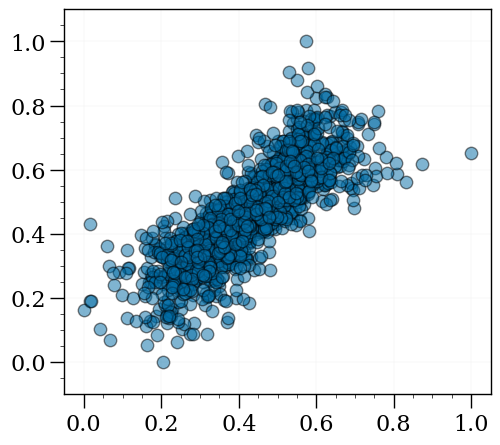

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
)

model = PBLC(
    LogitPDFNet(layer_widths)
)

nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
    model, TrainingTensors, losses
)

key, subkey = jax.random.split(key)
init_params = model.init(subkey, TrainingTensors.UV_batches[0])
del subkey

params = init_params
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

log = []
best = 1e6
for i in tqdm(range(n_iter)):
# for i in range(n_iter):
    grads, cop_state = grad(params, cop_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        loss = L_d(losses_eval, params, cop_state)
        if loss[0][-1] < best:
          best_params = params
          best_cop_state = cop_state
          best = loss[0][-1]
        log.append([l for l in loss])
        print('Iter {}. Loss {}'.format(i, loss))

  0%|          | 1/10000 [00:26<74:19:12, 26.76s/it]

Iter 0. Loss [[ 0.08098532  0.28584522 19.931568  ]]


  0%|          | 11/10000 [00:52<1:52:10,  1.48it/s]

Iter 10. Loss [[0.0832568  0.26109752 5.8484316 ]]


  0%|          | 22/10000 [00:54<24:56,  6.67it/s]

Iter 20. Loss [[0.08470594 0.25193527 5.2269297 ]]


  0%|          | 32/10000 [00:55<22:55,  7.25it/s]

Iter 30. Loss [[0.08651425 0.24359712 4.9305787 ]]


  0%|          | 42/10000 [00:57<22:43,  7.30it/s]

Iter 40. Loss [[0.08779532 0.23912588 4.867499  ]]


  1%|          | 52/10000 [00:58<23:05,  7.18it/s]

Iter 50. Loss [[0.08786179 0.23818725 4.8133855 ]]


  1%|          | 61/10000 [01:00<48:27,  3.42it/s]

Iter 60. Loss [[0.08751816 0.2380794  4.7484016 ]]


  1%|          | 71/10000 [01:03<38:07,  4.34it/s]

Iter 70. Loss [[0.08784863 0.2359223  4.65925   ]]


  1%|          | 82/10000 [01:04<22:53,  7.22it/s]

Iter 80. Loss [[0.08798436 0.2332513  4.3709984 ]]


  1%|          | 92/10000 [01:05<22:51,  7.22it/s]

Iter 90. Loss [[0.0883441  0.22831471 3.9151113 ]]


  1%|          | 102/10000 [01:07<22:12,  7.43it/s]

Iter 100. Loss [[0.0880509  0.22899869 3.7924304 ]]


  1%|          | 112/10000 [01:08<22:32,  7.31it/s]

Iter 110. Loss [[0.08789575 0.23081839 3.5271842 ]]


  1%|          | 122/10000 [01:10<25:43,  6.40it/s]

Iter 120. Loss [[0.08809632 0.22919059 3.1095438 ]]


  1%|▏         | 132/10000 [01:11<22:34,  7.28it/s]

Iter 130. Loss [[0.08782555 0.2260609  3.032356  ]]


  1%|▏         | 142/10000 [01:13<22:46,  7.21it/s]

Iter 140. Loss [[0.08733813 0.22459826 2.807722  ]]


  2%|▏         | 151/10000 [01:14<36:26,  4.50it/s]

Iter 150. Loss [[0.08707554 0.22900079 2.7113588 ]]


  2%|▏         | 161/10000 [01:17<41:41,  3.93it/s]

Iter 160. Loss [[0.08758748 0.23088787 2.7916775 ]]


  2%|▏         | 172/10000 [01:19<22:57,  7.13it/s]

Iter 170. Loss [[0.08809911 0.22898063 2.9932525 ]]


  2%|▏         | 182/10000 [01:20<22:37,  7.23it/s]

Iter 180. Loss [[0.08816221 0.22775297 3.1986861 ]]


  2%|▏         | 192/10000 [01:21<22:42,  7.20it/s]

Iter 190. Loss [[0.08834099 0.22274955 3.284317  ]]


  2%|▏         | 202/10000 [01:23<22:24,  7.29it/s]

Iter 200. Loss [[0.08909091 0.2188352  3.1749263 ]]


  2%|▏         | 212/10000 [01:24<24:16,  6.72it/s]

Iter 210. Loss [[0.09037115 0.21693607 3.055679  ]]


  2%|▏         | 222/10000 [01:26<22:27,  7.26it/s]

Iter 220. Loss [[0.09223309 0.21535881 2.9227831 ]]


  2%|▏         | 232/10000 [01:27<21:47,  7.47it/s]

Iter 230. Loss [[0.0944851  0.21162835 2.8854792 ]]


  2%|▏         | 241/10000 [01:29<35:41,  4.56it/s]

Iter 240. Loss [[0.09738122 0.21038775 2.7122338 ]]


  3%|▎         | 251/10000 [01:31<38:03,  4.27it/s]

Iter 250. Loss [[0.10084592 0.21333285 2.4833531 ]]


  3%|▎         | 262/10000 [01:33<23:25,  6.93it/s]

Iter 260. Loss [[0.10504892 0.21871008 2.2165196 ]]


  3%|▎         | 272/10000 [01:34<23:12,  6.98it/s]

Iter 270. Loss [[0.11001879 0.22195674 1.9515774 ]]


  3%|▎         | 282/10000 [01:36<22:22,  7.24it/s]

Iter 280. Loss [[0.11568506 0.22079915 1.6573579 ]]


  3%|▎         | 292/10000 [01:37<25:32,  6.34it/s]

Iter 290. Loss [[0.12180843 0.21789767 1.3668288 ]]


  3%|▎         | 302/10000 [01:39<22:24,  7.21it/s]

Iter 300. Loss [[0.12860757 0.21080196 1.092315  ]]


  3%|▎         | 312/10000 [01:40<22:36,  7.14it/s]

Iter 310. Loss [[0.1356554  0.20096466 0.90544295]]


  3%|▎         | 322/10000 [01:42<22:27,  7.18it/s]

Iter 320. Loss [[0.14232828 0.1924016  0.75097317]]


  3%|▎         | 331/10000 [01:43<32:50,  4.91it/s]

Iter 330. Loss [[0.1473233  0.17687744 0.52738386]]


  3%|▎         | 341/10000 [01:45<37:54,  4.25it/s]

Iter 340. Loss [[0.1513743  0.16549915 0.56054574]]


  4%|▎         | 352/10000 [01:48<24:13,  6.64it/s]

Iter 350. Loss [[0.15963177 0.14718597 0.4472758 ]]


  4%|▎         | 362/10000 [01:49<22:23,  7.17it/s]

Iter 360. Loss [[0.16935323 0.13175632 0.18889429]]


  4%|▎         | 372/10000 [01:50<21:56,  7.31it/s]

Iter 370. Loss [[0.1788487  0.12507077 0.01804939]]


  4%|▍         | 382/10000 [01:52<25:22,  6.32it/s]

Iter 380. Loss [[ 0.18475191  0.11680366 -0.11444295]]


  4%|▍         | 392/10000 [01:53<21:59,  7.28it/s]

Iter 390. Loss [[ 0.1902701   0.10970257 -0.24506088]]


  4%|▍         | 402/10000 [01:55<22:04,  7.25it/s]

Iter 400. Loss [[ 0.20001756  0.10229348 -0.41675767]]


  4%|▍         | 412/10000 [01:56<22:09,  7.21it/s]

Iter 410. Loss [[ 0.2141368   0.09562134 -0.5946085 ]]


  4%|▍         | 421/10000 [01:58<43:36,  3.66it/s]

Iter 420. Loss [[ 0.22874194  0.09009153 -0.73404044]]


  4%|▍         | 431/10000 [02:00<38:25,  4.15it/s]

Iter 430. Loss [[ 0.24136586  0.08865526 -0.83178383]]


  4%|▍         | 442/10000 [02:02<23:19,  6.83it/s]

Iter 440. Loss [[ 0.24922648  0.08343609 -0.8625148 ]]


  5%|▍         | 452/10000 [02:04<21:54,  7.26it/s]

Iter 450. Loss [[ 0.25330967  0.07570884 -0.8762782 ]]


  5%|▍         | 462/10000 [02:05<22:03,  7.20it/s]

Iter 460. Loss [[ 0.25456485  0.07384772 -0.87592185]]


  5%|▍         | 472/10000 [02:06<22:13,  7.14it/s]

Iter 470. Loss [[ 0.25418442  0.07794429 -0.8992798 ]]


  5%|▍         | 482/10000 [02:08<21:37,  7.33it/s]

Iter 480. Loss [[ 0.25261095  0.07598784 -0.8663069 ]]


  5%|▍         | 492/10000 [02:09<25:49,  6.14it/s]

Iter 490. Loss [[ 0.24901348  0.08681023 -0.872132  ]]


  5%|▌         | 502/10000 [02:11<21:42,  7.29it/s]

Iter 500. Loss [[ 0.2472239   0.09374998 -0.8716769 ]]


  5%|▌         | 511/10000 [02:12<33:07,  4.78it/s]

Iter 510. Loss [[ 0.25258696  0.09856431 -0.8984886 ]]


  5%|▌         | 521/10000 [02:15<36:50,  4.29it/s]

Iter 520. Loss [[ 0.25992817  0.11055137 -0.9617565 ]]


  5%|▌         | 532/10000 [02:17<23:22,  6.75it/s]

Iter 530. Loss [[ 0.25941414  0.10390354 -0.96589005]]


  5%|▌         | 542/10000 [02:18<24:54,  6.33it/s]

Iter 540. Loss [[ 0.259789   0.0975685 -0.9732132]]


  6%|▌         | 552/10000 [02:20<21:33,  7.30it/s]

Iter 550. Loss [[ 0.26156312  0.09719521 -0.98383   ]]


  6%|▌         | 562/10000 [02:21<22:25,  7.01it/s]

Iter 560. Loss [[ 0.2623974   0.09801736 -1.0103692 ]]


  6%|▌         | 572/10000 [02:22<22:23,  7.02it/s]

Iter 570. Loss [[ 0.26426956  0.09630894 -1.0238465 ]]


  6%|▌         | 582/10000 [02:24<21:53,  7.17it/s]

Iter 580. Loss [[ 0.26593757  0.09586059 -1.0434297 ]]


  6%|▌         | 592/10000 [02:25<21:32,  7.28it/s]

Iter 590. Loss [[ 0.2698305  0.090792  -1.0457618]]


  6%|▌         | 601/10000 [02:27<37:18,  4.20it/s]

Iter 600. Loss [[ 0.27362952  0.08575382 -1.0374018 ]]


  6%|▌         | 611/10000 [02:29<36:48,  4.25it/s]

Iter 610. Loss [[ 0.2735536   0.09227608 -1.0573119 ]]


  6%|▌         | 622/10000 [02:31<23:55,  6.53it/s]

Iter 620. Loss [[ 0.27508733  0.07434063 -1.0034738 ]]


  6%|▋         | 632/10000 [02:33<21:29,  7.26it/s]

Iter 630. Loss [[ 0.27635118  0.07929669 -1.0304766 ]]


  6%|▋         | 642/10000 [02:34<23:31,  6.63it/s]

Iter 640. Loss [[ 0.2779148   0.07944558 -1.0536035 ]]


  7%|▋         | 652/10000 [02:36<21:19,  7.30it/s]

Iter 650. Loss [[ 0.2787807   0.07483158 -1.0947769 ]]


  7%|▋         | 662/10000 [02:37<21:31,  7.23it/s]

Iter 660. Loss [[ 0.28258523  0.08297811 -1.1939638 ]]


  7%|▋         | 672/10000 [02:38<21:24,  7.26it/s]

Iter 670. Loss [[ 0.28506818  0.0902606  -1.1795863 ]]


  7%|▋         | 682/10000 [02:40<21:17,  7.30it/s]

Iter 680. Loss [[ 0.27906418  0.09346523 -1.1211424 ]]


  7%|▋         | 691/10000 [02:41<31:45,  4.88it/s]

Iter 690. Loss [[ 0.27421844  0.09103093 -1.0743341 ]]


  7%|▋         | 701/10000 [02:44<37:18,  4.15it/s]

Iter 700. Loss [[ 0.27580172  0.08892508 -1.0542399 ]]


  7%|▋         | 712/10000 [02:46<23:14,  6.66it/s]

Iter 710. Loss [[ 0.27828285  0.08591072 -1.0348835 ]]


  7%|▋         | 722/10000 [02:47<21:13,  7.29it/s]

Iter 720. Loss [[ 0.27964056  0.09029452 -1.0139223 ]]


  7%|▋         | 732/10000 [02:49<21:35,  7.16it/s]

Iter 730. Loss [[ 0.28009447  0.08596839 -0.9887546 ]]


  7%|▋         | 742/10000 [02:50<22:07,  6.97it/s]

Iter 740. Loss [[ 0.2796653   0.07651238 -0.9613597 ]]


  8%|▊         | 752/10000 [02:52<21:47,  7.07it/s]

Iter 750. Loss [[ 0.28028014  0.07319927 -0.972055  ]]


  8%|▊         | 762/10000 [02:53<21:36,  7.12it/s]

Iter 760. Loss [[ 0.2811686   0.07811027 -0.9852604 ]]


  8%|▊         | 772/10000 [02:54<21:59,  6.99it/s]

Iter 770. Loss [[ 0.27964637  0.07430191 -0.96452194]]


  8%|▊         | 781/10000 [02:56<31:28,  4.88it/s]

Iter 780. Loss [[ 0.28157574  0.0696568  -0.90414435]]


  8%|▊         | 791/10000 [02:58<35:42,  4.30it/s]

Iter 790. Loss [[ 0.28818947  0.07030374 -0.2828014 ]]


  8%|▊         | 802/10000 [03:00<23:48,  6.44it/s]

Iter 800. Loss [[ 0.28397667  0.05837759 -0.52715635]]


  8%|▊         | 812/10000 [03:02<21:40,  7.06it/s]

Iter 810. Loss [[ 0.27760834  0.06593727 -0.791215  ]]


  8%|▊         | 822/10000 [03:03<21:06,  7.25it/s]

Iter 820. Loss [[ 0.2815221   0.07029928 -0.8846226 ]]


  8%|▊         | 832/10000 [03:05<20:41,  7.38it/s]

Iter 830. Loss [[ 0.29042533  0.09995212 -1.0713102 ]]


  8%|▊         | 842/10000 [03:06<21:55,  6.96it/s]

Iter 840. Loss [[ 0.2971137  0.1158242 -1.0886698]]


  9%|▊         | 852/10000 [03:08<21:44,  7.01it/s]

Iter 850. Loss [[ 0.29557666  0.10799888 -1.0270402 ]]


  9%|▊         | 862/10000 [03:09<20:45,  7.34it/s]

Iter 860. Loss [[ 0.29423994  0.10228693 -1.017558  ]]


  9%|▊         | 871/10000 [03:10<30:43,  4.95it/s]

Iter 870. Loss [[ 0.2941614  0.1017972 -1.0371604]]


  9%|▉         | 881/10000 [03:13<44:03,  3.45it/s]

Iter 880. Loss [[ 0.2938883   0.09928156 -1.0370923 ]]


  9%|▉         | 892/10000 [03:15<22:53,  6.63it/s]

Iter 890. Loss [[ 0.29447234  0.09830554 -1.0388457 ]]


  9%|▉         | 902/10000 [03:16<21:02,  7.21it/s]

Iter 900. Loss [[ 0.29485053  0.0991644  -1.0500591 ]]


  9%|▉         | 912/10000 [03:18<22:05,  6.86it/s]

Iter 910. Loss [[ 0.29424945  0.09722497 -1.0513788 ]]


  9%|▉         | 922/10000 [03:19<21:27,  7.05it/s]

Iter 920. Loss [[ 0.29366776  0.09555208 -1.0516204 ]]


  9%|▉         | 932/10000 [03:21<24:43,  6.11it/s]

Iter 930. Loss [[ 0.293519    0.09485615 -1.0564692 ]]


  9%|▉         | 942/10000 [03:22<21:11,  7.13it/s]

Iter 940. Loss [[ 0.2932009   0.09386049 -1.0574626 ]]


 10%|▉         | 952/10000 [03:24<20:52,  7.23it/s]

Iter 950. Loss [[ 0.29274306  0.09238925 -1.053241  ]]


 10%|▉         | 961/10000 [03:25<32:34,  4.63it/s]

Iter 960. Loss [[ 0.29203355  0.08702581 -1.0302522 ]]


 10%|▉         | 971/10000 [03:28<35:32,  4.23it/s]

Iter 970. Loss [[ 0.29063186  0.08347064 -1.0035963 ]]


 10%|▉         | 982/10000 [03:30<22:51,  6.58it/s]

Iter 980. Loss [[ 0.29091856  0.08773448 -1.0345703 ]]


 10%|▉         | 992/10000 [03:31<20:26,  7.35it/s]

Iter 990. Loss [[ 0.29033813  0.08602557 -1.0474352 ]]


 10%|█         | 1002/10000 [03:32<21:20,  7.03it/s]

Iter 1000. Loss [[ 0.28991035  0.08429715 -1.0477018 ]]


 10%|█         | 1012/10000 [03:34<20:56,  7.15it/s]

Iter 1010. Loss [[ 0.2894217   0.08360185 -1.0561453 ]]


 10%|█         | 1022/10000 [03:36<22:32,  6.64it/s]

Iter 1020. Loss [[ 0.28867552  0.08199396 -1.0593693 ]]


 10%|█         | 1032/10000 [03:37<20:30,  7.29it/s]

Iter 1030. Loss [[ 0.28787065  0.07961407 -1.0640651 ]]


 10%|█         | 1042/10000 [03:38<20:57,  7.13it/s]

Iter 1040. Loss [[ 0.28662112  0.07736979 -1.0715181 ]]


 11%|█         | 1051/10000 [03:40<32:50,  4.54it/s]

Iter 1050. Loss [[ 0.284662    0.07397339 -1.0749562 ]]


 11%|█         | 1061/10000 [03:42<34:37,  4.30it/s]

Iter 1060. Loss [[ 0.2803824   0.06861627 -1.0734278 ]]


 11%|█         | 1072/10000 [03:44<22:26,  6.63it/s]

Iter 1070. Loss [[ 0.2795415   0.06532699 -1.0202447 ]]


 11%|█         | 1082/10000 [03:46<20:43,  7.17it/s]

Iter 1080. Loss [[ 0.28053874  0.06829361 -1.0192538 ]]


 11%|█         | 1092/10000 [03:47<20:24,  7.28it/s]

Iter 1090. Loss [[ 0.281825    0.07053628 -1.0287402 ]]


 11%|█         | 1102/10000 [03:49<20:02,  7.40it/s]

Iter 1100. Loss [[ 0.28217235  0.0707353  -1.0544547 ]]


 11%|█         | 1112/10000 [03:50<20:53,  7.09it/s]

Iter 1110. Loss [[ 0.281218    0.07133151 -1.065981  ]]


 11%|█         | 1122/10000 [03:51<20:38,  7.17it/s]

Iter 1120. Loss [[ 0.27878228  0.06816687 -1.0487018 ]]


 11%|█▏        | 1132/10000 [03:53<21:15,  6.95it/s]

Iter 1130. Loss [[ 0.27820244  0.0680869  -1.0510421 ]]


 11%|█▏        | 1141/10000 [03:55<31:04,  4.75it/s]

Iter 1140. Loss [[ 0.27906746  0.06861844 -1.027991  ]]


 12%|█▏        | 1151/10000 [03:57<33:26,  4.41it/s]

Iter 1150. Loss [[ 0.27869716  0.07010667 -1.0859563 ]]


 12%|█▏        | 1162/10000 [03:59<30:11,  4.88it/s]

Iter 1160. Loss [[ 0.2761717   0.06799934 -1.0845252 ]]


 12%|█▏        | 1172/10000 [04:01<20:28,  7.19it/s]

Iter 1170. Loss [[ 0.27625477  0.06816116 -1.0468451 ]]


 12%|█▏        | 1182/10000 [04:02<20:16,  7.25it/s]

Iter 1180. Loss [[ 0.27695888  0.07013291 -1.0685838 ]]


 12%|█▏        | 1192/10000 [04:03<20:16,  7.24it/s]

Iter 1190. Loss [[ 0.2767793   0.06863837 -1.0528044 ]]


 12%|█▏        | 1202/10000 [04:05<20:11,  7.26it/s]

Iter 1200. Loss [[ 0.27675113  0.07123861 -1.106201  ]]


 12%|█▏        | 1212/10000 [04:06<19:46,  7.40it/s]

Iter 1210. Loss [[ 0.2758738   0.07118103 -1.1096777 ]]


 12%|█▏        | 1222/10000 [04:07<19:36,  7.46it/s]

Iter 1220. Loss [[ 0.27580297  0.07058197 -1.1170322 ]]


 12%|█▏        | 1231/10000 [04:09<33:27,  4.37it/s]

Iter 1230. Loss [[ 0.27558377  0.0716439  -1.111885  ]]


 12%|█▏        | 1241/10000 [04:11<33:11,  4.40it/s]

Iter 1240. Loss [[ 0.27519822  0.07167252 -1.1406525 ]]


 13%|█▎        | 1252/10000 [04:13<21:45,  6.70it/s]

Iter 1250. Loss [[ 0.2752983  0.0723302 -1.1470616]]


 13%|█▎        | 1262/10000 [04:15<19:51,  7.34it/s]

Iter 1260. Loss [[ 0.2752015   0.07300982 -1.1536639 ]]


 13%|█▎        | 1272/10000 [04:16<19:37,  7.41it/s]

Iter 1270. Loss [[ 0.27522632  0.07314381 -1.1500107 ]]


 13%|█▎        | 1282/10000 [04:18<19:48,  7.34it/s]

Iter 1280. Loss [[ 0.2749304   0.07321419 -1.1487664 ]]


 13%|█▎        | 1292/10000 [04:19<20:01,  7.24it/s]

Iter 1290. Loss [[ 0.27439168  0.07297039 -1.1567371 ]]


 13%|█▎        | 1302/10000 [04:20<19:48,  7.32it/s]

Iter 1300. Loss [[ 0.27457044  0.07383817 -1.1435722 ]]


 13%|█▎        | 1312/10000 [04:22<20:15,  7.15it/s]

Iter 1310. Loss [[ 0.2747889   0.07449868 -1.1635146 ]]


 13%|█▎        | 1321/10000 [04:23<21:19,  6.78it/s]

Iter 1320. Loss [[ 0.27438393  0.07439106 -1.1537222 ]]


 13%|█▎        | 1331/10000 [04:25<32:34,  4.43it/s]

Iter 1330. Loss [[ 0.27371764  0.07403357 -1.1588339 ]]


 13%|█▎        | 1341/10000 [04:27<32:56,  4.38it/s]

Iter 1340. Loss [[ 0.27315924  0.07320312 -1.153282  ]]


 14%|█▎        | 1352/10000 [04:29<20:13,  7.13it/s]

Iter 1350. Loss [[ 0.27304518  0.0736698  -1.1301601 ]]


 14%|█▎        | 1362/10000 [04:30<20:25,  7.05it/s]

Iter 1360. Loss [[ 0.27510634  0.07177851 -1.1512084 ]]


 14%|█▎        | 1371/10000 [04:31<20:11,  7.12it/s]

Iter 1370. Loss [[ 0.27444115  0.0715161  -1.1572121 ]]


 14%|█▍        | 1382/10000 [04:33<20:38,  6.96it/s]

Iter 1380. Loss [[ 0.27444413  0.0752623  -1.1795799 ]]


 14%|█▍        | 1392/10000 [04:35<20:15,  7.08it/s]

Iter 1390. Loss [[ 0.2747265  0.0745853 -1.1794963]]


 14%|█▍        | 1402/10000 [04:36<19:30,  7.35it/s]

Iter 1400. Loss [[ 0.27453482  0.07325976 -1.1741849 ]]


 14%|█▍        | 1411/10000 [04:38<22:45,  6.29it/s]

Iter 1410. Loss [[ 0.2743944   0.07355464 -1.1782811 ]]


 14%|█▍        | 1421/10000 [04:40<31:25,  4.55it/s]

Iter 1420. Loss [[ 0.2744068   0.07364327 -1.1823571 ]]


 14%|█▍        | 1431/10000 [04:42<32:59,  4.33it/s]

Iter 1430. Loss [[ 0.2744672   0.07463668 -1.183836  ]]


 14%|█▍        | 1442/10000 [04:44<20:44,  6.88it/s]

Iter 1440. Loss [[ 0.2747725   0.07422074 -1.1903678 ]]


 15%|█▍        | 1452/10000 [04:45<19:55,  7.15it/s]

Iter 1450. Loss [[ 0.27530825  0.07524611 -1.2120162 ]]


 15%|█▍        | 1462/10000 [04:47<21:02,  6.76it/s]

Iter 1460. Loss [[ 0.27585655  0.07482871 -1.2124221 ]]


 15%|█▍        | 1472/10000 [04:48<19:21,  7.34it/s]

Iter 1470. Loss [[ 0.27550763  0.07342833 -1.2128823 ]]


 15%|█▍        | 1482/10000 [04:49<19:02,  7.46it/s]

Iter 1480. Loss [[ 0.27545047  0.0732379  -1.2165352 ]]


 15%|█▍        | 1492/10000 [04:51<19:23,  7.31it/s]

Iter 1490. Loss [[ 0.27535498  0.07143521 -1.2027785 ]]


 15%|█▌        | 1502/10000 [04:52<19:48,  7.15it/s]

Iter 1500. Loss [[ 0.27497944  0.0716763  -1.1959643 ]]


 15%|█▌        | 1511/10000 [04:54<32:39,  4.33it/s]

Iter 1510. Loss [[ 0.273877    0.07176992 -1.1847519 ]]


 15%|█▌        | 1521/10000 [04:57<33:18,  4.24it/s]

Iter 1520. Loss [[ 0.27274472  0.07077485 -1.1642166 ]]


 15%|█▌        | 1532/10000 [04:58<20:05,  7.02it/s]

Iter 1530. Loss [[ 0.2718395  0.0693148 -1.1426891]]


 15%|█▌        | 1542/10000 [05:00<19:10,  7.35it/s]

Iter 1540. Loss [[ 0.2711907   0.07185292 -1.1393372 ]]


 16%|█▌        | 1552/10000 [05:01<19:23,  7.26it/s]

Iter 1550. Loss [[ 0.27094665  0.06780779 -1.1164517 ]]


 16%|█▌        | 1562/10000 [05:02<19:32,  7.20it/s]

Iter 1560. Loss [[ 0.2710945   0.06725413 -1.1116318 ]]


 16%|█▌        | 1572/10000 [05:04<19:09,  7.33it/s]

Iter 1570. Loss [[ 0.27041626  0.06479132 -1.0708286 ]]


 16%|█▌        | 1582/10000 [05:05<19:14,  7.29it/s]

Iter 1580. Loss [[ 0.27044496  0.05892318 -0.9598242 ]]


 16%|█▌        | 1592/10000 [05:06<19:41,  7.12it/s]

Iter 1590. Loss [[ 0.27092892  0.06018693 -1.0302317 ]]


 16%|█▌        | 1601/10000 [05:08<29:05,  4.81it/s]

Iter 1600. Loss [[ 0.26937637  0.06635803 -1.1036686 ]]


 16%|█▌        | 1611/10000 [05:10<32:05,  4.36it/s]

Iter 1610. Loss [[ 0.27067077  0.06763084 -1.0267913 ]]


 16%|█▌        | 1622/10000 [05:12<21:28,  6.50it/s]

Iter 1620. Loss [[ 0.27070794  0.06645546 -0.9561385 ]]


 16%|█▋        | 1632/10000 [05:14<19:37,  7.10it/s]

Iter 1630. Loss [[ 0.2693372   0.06629882 -1.1088432 ]]


 16%|█▋        | 1642/10000 [05:15<19:30,  7.14it/s]

Iter 1640. Loss [[ 0.27034423  0.06605981 -1.1228367 ]]


 17%|█▋        | 1652/10000 [05:17<20:32,  6.77it/s]

Iter 1650. Loss [[ 0.27105373  0.07036883 -1.1375113 ]]


 17%|█▋        | 1662/10000 [05:18<19:12,  7.24it/s]

Iter 1660. Loss [[ 0.2712273   0.07271596 -1.1501905 ]]


 17%|█▋        | 1672/10000 [05:19<18:49,  7.37it/s]

Iter 1670. Loss [[ 0.27111545  0.07144637 -1.1117707 ]]


 17%|█▋        | 1682/10000 [05:21<26:55,  5.15it/s]

Iter 1680. Loss [[ 0.27081466  0.07208096 -1.122614  ]]


 17%|█▋        | 1691/10000 [05:23<29:43,  4.66it/s]

Iter 1690. Loss [[ 0.27076674  0.07175417 -1.1225307 ]]


 17%|█▋        | 1701/10000 [05:25<31:23,  4.41it/s]

Iter 1700. Loss [[ 0.27052757  0.07289461 -1.1318328 ]]


 17%|█▋        | 1712/10000 [05:27<21:03,  6.56it/s]

Iter 1710. Loss [[ 0.2702231   0.08712662 -1.2008877 ]]


 17%|█▋        | 1722/10000 [05:28<19:15,  7.17it/s]

Iter 1720. Loss [[ 0.2697333   0.06209465 -1.0075043 ]]


 17%|█▋        | 1732/10000 [05:30<19:08,  7.20it/s]

Iter 1730. Loss [[ 0.26913628  0.06696612 -1.0560546 ]]


 17%|█▋        | 1742/10000 [05:31<24:56,  5.52it/s]

Iter 1740. Loss [[ 0.26838583  0.07430056 -1.1285535 ]]


 18%|█▊        | 1752/10000 [05:33<19:29,  7.06it/s]

Iter 1750. Loss [[ 0.26738176  0.06436557 -1.0419102 ]]


 18%|█▊        | 1762/10000 [05:34<18:45,  7.32it/s]

Iter 1760. Loss [[ 0.27017936  0.0755724  -1.1382322 ]]


 18%|█▊        | 1772/10000 [05:35<18:47,  7.30it/s]

Iter 1770. Loss [[ 0.27006298  0.08927467 -1.2091669 ]]


 18%|█▊        | 1781/10000 [05:37<25:02,  5.47it/s]

Iter 1780. Loss [[ 0.26985905  0.07056014 -1.0435787 ]]


 18%|█▊        | 1791/10000 [05:39<32:04,  4.26it/s]

Iter 1790. Loss [[ 0.2705623  0.0729944 -1.1732205]]


 18%|█▊        | 1802/10000 [05:41<23:34,  5.79it/s]

Iter 1800. Loss [[ 0.26802668  0.07355893 -1.1539278 ]]


 18%|█▊        | 1812/10000 [05:43<19:13,  7.10it/s]

Iter 1810. Loss [[ 0.27026248  0.06561837 -1.0374502 ]]


 18%|█▊        | 1822/10000 [05:44<19:06,  7.13it/s]

Iter 1820. Loss [[ 0.2704138   0.07170686 -1.1788303 ]]


 18%|█▊        | 1832/10000 [05:45<18:27,  7.38it/s]

Iter 1830. Loss [[ 0.26805833  0.07352589 -1.1860803 ]]


 18%|█▊        | 1842/10000 [05:47<18:40,  7.28it/s]

Iter 1840. Loss [[ 0.26943153  0.05795458 -1.0352823 ]]


 19%|█▊        | 1852/10000 [05:48<18:53,  7.19it/s]

Iter 1850. Loss [[ 0.27096257  0.06505772 -1.0579876 ]]


 19%|█▊        | 1862/10000 [05:50<18:19,  7.40it/s]

Iter 1860. Loss [[ 0.26899406  0.07687183 -1.2186965 ]]


 19%|█▊        | 1872/10000 [05:51<19:01,  7.12it/s]

Iter 1870. Loss [[ 0.2681395   0.06795198 -1.1519009 ]]


 19%|█▉        | 1881/10000 [05:53<30:55,  4.38it/s]

Iter 1880. Loss [[ 0.2702266   0.06362718 -1.0470551 ]]


 19%|█▉        | 1891/10000 [05:55<31:30,  4.29it/s]

Iter 1890. Loss [[ 0.26989737  0.07283705 -1.1502383 ]]


 19%|█▉        | 1902/10000 [05:57<18:51,  7.16it/s]

Iter 1900. Loss [[ 0.2683754   0.07766748 -1.2265841 ]]


 19%|█▉        | 1912/10000 [05:58<18:59,  7.10it/s]

Iter 1910. Loss [[ 0.2683261  0.0577617 -1.0296413]]


 19%|█▉        | 1922/10000 [06:00<22:24,  6.01it/s]

Iter 1920. Loss [[ 0.27043697  0.0645452  -1.0523844 ]]


 19%|█▉        | 1932/10000 [06:01<18:42,  7.19it/s]

Iter 1930. Loss [[ 0.2690358   0.07574016 -1.2203987 ]]


 19%|█▉        | 1942/10000 [06:03<18:24,  7.29it/s]

Iter 1940. Loss [[ 0.26742733  0.07202497 -1.1984392 ]]


 20%|█▉        | 1952/10000 [06:04<18:16,  7.34it/s]

Iter 1950. Loss [[ 0.2695082   0.07215372 -1.1186087 ]]


 20%|█▉        | 1962/10000 [06:05<18:17,  7.32it/s]

Iter 1960. Loss [[ 0.26999018  0.07095132 -1.1353728 ]]


 20%|█▉        | 1971/10000 [06:07<29:28,  4.54it/s]

Iter 1970. Loss [[ 0.2681656   0.09369307 -1.273849  ]]


 20%|█▉        | 1981/10000 [06:10<32:50,  4.07it/s]

Iter 1980. Loss [[ 0.26811287  0.06124536 -1.0610319 ]]


 20%|█▉        | 1992/10000 [06:11<18:50,  7.08it/s]

Iter 1990. Loss [[ 0.27021012  0.07147466 -1.1846247 ]]


 20%|██        | 2002/10000 [06:13<18:13,  7.31it/s]

Iter 2000. Loss [[ 0.26778677  0.06994529 -1.1718605 ]]


 20%|██        | 2012/10000 [06:14<18:17,  7.28it/s]

Iter 2010. Loss [[ 0.2684184   0.06410174 -1.0665939 ]]


 20%|██        | 2022/10000 [06:16<18:59,  7.00it/s]

Iter 2020. Loss [[ 0.26988634  0.06964793 -1.1852942 ]]


 20%|██        | 2032/10000 [06:17<18:21,  7.24it/s]

Iter 2030. Loss [[ 0.26730746  0.07745734 -1.2257253 ]]


 20%|██        | 2042/10000 [06:19<18:09,  7.30it/s]

Iter 2040. Loss [[ 0.26815575  0.061625   -1.0611221 ]]


 21%|██        | 2052/10000 [06:20<18:31,  7.15it/s]

Iter 2050. Loss [[ 0.26967296  0.07498612 -1.1939263 ]]


 21%|██        | 2061/10000 [06:22<29:53,  4.43it/s]

Iter 2060. Loss [[ 0.2674533   0.08132154 -1.2437388 ]]


 21%|██        | 2071/10000 [06:24<31:50,  4.15it/s]

Iter 2070. Loss [[ 0.2676131   0.06832147 -1.0916146 ]]


 21%|██        | 2082/10000 [06:26<18:13,  7.24it/s]

Iter 2080. Loss [[ 0.2698768   0.06116593 -1.0646902 ]]


 21%|██        | 2092/10000 [06:27<18:00,  7.32it/s]

Iter 2090. Loss [[ 0.26795593  0.06953185 -1.1961943 ]]


 21%|██        | 2102/10000 [06:29<17:50,  7.38it/s]

Iter 2100. Loss [[ 0.26661205  0.07805247 -1.1886442 ]]


 21%|██        | 2112/10000 [06:30<17:47,  7.39it/s]

Iter 2110. Loss [[ 0.26939932  0.06511963 -1.0657321 ]]


 21%|██        | 2122/10000 [06:32<18:39,  7.03it/s]

Iter 2120. Loss [[ 0.26853722  0.07403208 -1.2043483 ]]


 21%|██▏       | 2132/10000 [06:33<18:12,  7.20it/s]

Iter 2130. Loss [[ 0.2666613   0.07599251 -1.2213148 ]]


 21%|██▏       | 2142/10000 [06:35<25:06,  5.22it/s]

Iter 2140. Loss [[ 0.26806945  0.05872419 -1.0404378 ]]


 22%|██▏       | 2151/10000 [06:36<29:16,  4.47it/s]

Iter 2150. Loss [[ 0.26909322  0.06567093 -1.0984993 ]]


 22%|██▏       | 2161/10000 [06:39<30:10,  4.33it/s]

Iter 2160. Loss [[ 0.26757893  0.07202774 -1.2095118 ]]


 22%|██▏       | 2172/10000 [06:40<18:11,  7.17it/s]

Iter 2170. Loss [[ 0.26658684  0.06015661 -1.0933336 ]]


 22%|██▏       | 2182/10000 [06:42<18:34,  7.02it/s]

Iter 2180. Loss [[ 0.2692246   0.06025202 -1.0535718 ]]


 22%|██▏       | 2192/10000 [06:43<18:07,  7.18it/s]

Iter 2190. Loss [[ 0.26803836  0.07099749 -1.1980354 ]]


 22%|██▏       | 2202/10000 [06:45<19:23,  6.70it/s]

Iter 2200. Loss [[ 0.26638314  0.08004439 -1.2002888 ]]


 22%|██▏       | 2212/10000 [06:46<18:06,  7.17it/s]

Iter 2210. Loss [[ 0.2686944   0.06643037 -1.0877213 ]]


 22%|██▏       | 2222/10000 [06:48<17:50,  7.27it/s]

Iter 2220. Loss [[ 0.26814905  0.07777314 -1.229522  ]]


 22%|██▏       | 2232/10000 [06:49<25:07,  5.15it/s]

Iter 2230. Loss [[ 0.2662418   0.07210596 -1.1618928 ]]


 22%|██▏       | 2241/10000 [06:51<28:50,  4.48it/s]

Iter 2240. Loss [[ 0.26859108  0.06409541 -1.0731692 ]]


 23%|██▎       | 2251/10000 [06:53<30:19,  4.26it/s]

Iter 2250. Loss [[ 0.2681549   0.07446855 -1.2147129 ]]


 23%|██▎       | 2262/10000 [06:55<18:42,  6.90it/s]

Iter 2260. Loss [[ 0.2660079   0.07362778 -1.1717602 ]]


 23%|██▎       | 2272/10000 [06:57<18:01,  7.15it/s]

Iter 2270. Loss [[ 0.26851022  0.06551966 -1.0819368 ]]


 23%|██▎       | 2282/10000 [06:58<22:55,  5.61it/s]

Iter 2280. Loss [[ 0.2681187   0.07499109 -1.2197138 ]]


 23%|██▎       | 2292/10000 [07:00<18:06,  7.09it/s]

Iter 2290. Loss [[ 0.2661804   0.05789147 -1.0916064 ]]


 23%|██▎       | 2302/10000 [07:01<18:05,  7.09it/s]

Iter 2300. Loss [[ 0.26878217  0.06097646 -1.0694557 ]]


 23%|██▎       | 2312/10000 [07:02<18:26,  6.95it/s]

Iter 2310. Loss [[ 0.26765665  0.07537329 -1.220815  ]]


 23%|██▎       | 2322/10000 [07:04<17:56,  7.13it/s]

Iter 2320. Loss [[ 0.26608127  0.07086588 -1.1426516 ]]


 23%|██▎       | 2331/10000 [07:06<28:00,  4.56it/s]

Iter 2330. Loss [[ 0.26877517  0.06965531 -1.1607956 ]]


 23%|██▎       | 2341/10000 [07:08<29:27,  4.33it/s]

Iter 2340. Loss [[ 0.2669725   0.07276145 -1.1981773 ]]


 24%|██▎       | 2352/10000 [07:10<19:20,  6.59it/s]

Iter 2350. Loss [[ 0.2671421   0.06628032 -1.1429164 ]]


 24%|██▎       | 2362/10000 [07:11<17:24,  7.31it/s]

Iter 2360. Loss [[ 0.2685443   0.06945425 -1.1664815 ]]


 24%|██▎       | 2372/10000 [07:13<17:12,  7.39it/s]

Iter 2370. Loss [[ 0.26733792  0.06744406 -1.1537033 ]]


 24%|██▍       | 2382/10000 [07:14<21:01,  6.04it/s]

Iter 2380. Loss [[ 0.26775056  0.07143759 -1.1722503 ]]


 24%|██▍       | 2392/10000 [07:16<17:37,  7.20it/s]

Iter 2390. Loss [[ 0.2677851   0.06816179 -1.1582284 ]]


 24%|██▍       | 2402/10000 [07:17<17:40,  7.17it/s]

Iter 2400. Loss [[ 0.26740402  0.06993804 -1.1671561 ]]


 24%|██▍       | 2412/10000 [07:18<17:43,  7.13it/s]

Iter 2410. Loss [[ 0.2678505   0.06955802 -1.1680876 ]]


 24%|██▍       | 2421/10000 [07:20<26:18,  4.80it/s]

Iter 2420. Loss [[ 0.26747757  0.06913403 -1.1611285 ]]


 24%|██▍       | 2431/10000 [07:22<32:05,  3.93it/s]

Iter 2430. Loss [[ 0.26758516  0.06936337 -1.1669759 ]]


 24%|██▍       | 2442/10000 [07:24<18:31,  6.80it/s]

Iter 2440. Loss [[ 0.2676596   0.06895638 -1.1675867 ]]


 25%|██▍       | 2452/10000 [07:26<17:18,  7.27it/s]

Iter 2450. Loss [[ 0.26749566  0.06751437 -1.1578299 ]]


 25%|██▍       | 2462/10000 [07:27<17:06,  7.34it/s]

Iter 2460. Loss [[ 0.26749176  0.0698766  -1.1708847 ]]


 25%|██▍       | 2472/10000 [07:29<17:34,  7.14it/s]

Iter 2470. Loss [[ 0.26755223  0.06996111 -1.1737722 ]]


 25%|██▍       | 2482/10000 [07:30<17:28,  7.17it/s]

Iter 2480. Loss [[ 0.26765966  0.07037979 -1.173637  ]]


 25%|██▍       | 2492/10000 [07:32<18:53,  6.63it/s]

Iter 2490. Loss [[ 0.26755667  0.06957337 -1.1700726 ]]


 25%|██▌       | 2502/10000 [07:33<17:28,  7.15it/s]

Iter 2500. Loss [[ 0.2673896   0.07004391 -1.1722736 ]]


 25%|██▌       | 2511/10000 [07:35<26:38,  4.68it/s]

Iter 2510. Loss [[ 0.2674139   0.06862355 -1.1677723 ]]


 25%|██▌       | 2521/10000 [07:37<28:14,  4.41it/s]

Iter 2520. Loss [[ 0.2673666   0.06847781 -1.1657957 ]]


 25%|██▌       | 2532/10000 [07:39<19:45,  6.30it/s]

Iter 2530. Loss [[ 0.26734558  0.07038037 -1.1725599 ]]


 25%|██▌       | 2542/10000 [07:41<16:58,  7.32it/s]

Iter 2540. Loss [[ 0.2672742   0.06855004 -1.1649448 ]]


 26%|██▌       | 2552/10000 [07:42<18:12,  6.82it/s]

Iter 2550. Loss [[ 0.26738134  0.07057407 -1.1709768 ]]


 26%|██▌       | 2562/10000 [07:43<17:12,  7.20it/s]

Iter 2560. Loss [[ 0.2673655   0.06814001 -1.163917  ]]


 26%|██▌       | 2572/10000 [07:45<16:58,  7.30it/s]

Iter 2570. Loss [[ 0.2672968  0.0688161 -1.165523 ]]


 26%|██▌       | 2582/10000 [07:46<18:10,  6.81it/s]

Iter 2580. Loss [[ 0.26730055  0.06872454 -1.1620024 ]]


 26%|██▌       | 2592/10000 [07:48<16:43,  7.38it/s]

Iter 2590. Loss [[ 0.26720324  0.06773863 -1.1622026 ]]


 26%|██▌       | 2601/10000 [07:49<25:13,  4.89it/s]

Iter 2600. Loss [[ 0.26742852  0.07153434 -1.1791828 ]]


 26%|██▌       | 2611/10000 [07:51<28:30,  4.32it/s]

Iter 2610. Loss [[ 0.26732263  0.07028441 -1.1684684 ]]


 26%|██▌       | 2622/10000 [07:54<20:10,  6.09it/s]

Iter 2620. Loss [[ 0.26720688  0.06877056 -1.1687725 ]]


 26%|██▋       | 2632/10000 [07:55<16:56,  7.25it/s]

Iter 2630. Loss [[ 0.2672559   0.06884917 -1.169231  ]]


 26%|██▋       | 2642/10000 [07:56<17:26,  7.03it/s]

Iter 2640. Loss [[ 0.26700446  0.06825302 -1.1654139 ]]


 27%|██▋       | 2652/10000 [07:58<16:49,  7.28it/s]

Iter 2650. Loss [[ 0.26725394  0.06869899 -1.1685566 ]]


 27%|██▋       | 2662/10000 [07:59<16:38,  7.35it/s]

Iter 2660. Loss [[ 0.26697963  0.06922511 -1.1707938 ]]


 27%|██▋       | 2672/10000 [08:01<16:56,  7.21it/s]

Iter 2670. Loss [[ 0.26698086  0.06889249 -1.1672668 ]]


 27%|██▋       | 2682/10000 [08:02<17:02,  7.16it/s]

Iter 2680. Loss [[ 0.26714352  0.06971656 -1.1742647 ]]


 27%|██▋       | 2691/10000 [08:04<23:06,  5.27it/s]

Iter 2690. Loss [[ 0.26717213  0.06982488 -1.1774338 ]]


 27%|██▋       | 2701/10000 [08:06<27:24,  4.44it/s]

Iter 2700. Loss [[ 0.2671166   0.06675448 -1.1574626 ]]


 27%|██▋       | 2712/10000 [08:08<24:10,  5.03it/s]

Iter 2710. Loss [[ 0.2669578   0.06832156 -1.1673703 ]]


 27%|██▋       | 2722/10000 [08:10<16:59,  7.14it/s]

Iter 2720. Loss [[ 0.26707637  0.06902787 -1.1714712 ]]


 27%|██▋       | 2732/10000 [08:11<17:03,  7.10it/s]

Iter 2730. Loss [[ 0.2669586   0.06753158 -1.159159  ]]


 27%|██▋       | 2742/10000 [08:13<21:23,  5.66it/s]

Iter 2740. Loss [[ 0.266932    0.07050805 -1.1771703 ]]


 28%|██▊       | 2752/10000 [08:14<17:15,  7.00it/s]

Iter 2750. Loss [[ 0.26720458  0.06910256 -1.1727117 ]]


 28%|██▊       | 2762/10000 [08:15<16:41,  7.23it/s]

Iter 2760. Loss [[ 0.2670393   0.06940627 -1.177635  ]]


 28%|██▊       | 2772/10000 [08:17<16:19,  7.38it/s]

Iter 2770. Loss [[ 0.26687232  0.06846227 -1.167676  ]]


 28%|██▊       | 2781/10000 [08:18<21:37,  5.57it/s]

Iter 2780. Loss [[ 0.26676053  0.06897672 -1.1679208 ]]


 28%|██▊       | 2791/10000 [08:20<27:46,  4.33it/s]

Iter 2790. Loss [[ 0.2670754   0.06907401 -1.1750275 ]]


 28%|██▊       | 2802/10000 [08:23<23:53,  5.02it/s]

Iter 2800. Loss [[ 0.26694617  0.06917271 -1.1744887 ]]


 28%|██▊       | 2812/10000 [08:24<16:41,  7.18it/s]

Iter 2810. Loss [[ 0.2667131   0.06859799 -1.1705023 ]]


 28%|██▊       | 2822/10000 [08:26<21:06,  5.67it/s]

Iter 2820. Loss [[ 0.26681706  0.06894492 -1.1753013 ]]


 28%|██▊       | 2832/10000 [08:27<16:35,  7.20it/s]

Iter 2830. Loss [[ 0.26674724  0.06867415 -1.1721236 ]]


 28%|██▊       | 2842/10000 [08:29<16:28,  7.24it/s]

Iter 2840. Loss [[ 0.26672998  0.06913107 -1.1725999 ]]


 29%|██▊       | 2852/10000 [08:30<16:14,  7.34it/s]

Iter 2850. Loss [[ 0.26662013  0.06859373 -1.1674303 ]]


 29%|██▊       | 2862/10000 [08:31<16:37,  7.16it/s]

Iter 2860. Loss [[ 0.26677144  0.06860228 -1.166194  ]]


 29%|██▊       | 2871/10000 [08:33<16:49,  7.06it/s]

Iter 2870. Loss [[ 0.26678097  0.06856446 -1.1729537 ]]


 29%|██▉       | 2881/10000 [08:35<25:47,  4.60it/s]

Iter 2880. Loss [[ 0.26667228  0.06903633 -1.1756831 ]]


 29%|██▉       | 2891/10000 [08:37<27:23,  4.32it/s]

Iter 2890. Loss [[ 0.26659134  0.06751012 -1.1634238 ]]


 29%|██▉       | 2902/10000 [08:39<17:30,  6.76it/s]

Iter 2900. Loss [[ 0.26667923  0.06743672 -1.1633412 ]]


 29%|██▉       | 2912/10000 [08:40<17:05,  6.91it/s]

Iter 2910. Loss [[ 0.26658675  0.06737208 -1.1569285 ]]


 29%|██▉       | 2922/10000 [08:42<16:31,  7.14it/s]

Iter 2920. Loss [[ 0.26658553  0.07051534 -1.1761909 ]]


 29%|██▉       | 2932/10000 [08:43<16:16,  7.24it/s]

Iter 2930. Loss [[ 0.2668563   0.06956784 -1.1741266 ]]


 29%|██▉       | 2942/10000 [08:45<16:24,  7.17it/s]

Iter 2940. Loss [[ 0.266593    0.06817103 -1.1689906 ]]


 30%|██▉       | 2952/10000 [08:46<17:50,  6.58it/s]

Iter 2950. Loss [[ 0.26659113  0.06913485 -1.1733314 ]]


 30%|██▉       | 2961/10000 [08:47<16:22,  7.16it/s]

Iter 2960. Loss [[ 0.26647684  0.06853951 -1.1704252 ]]


 30%|██▉       | 2971/10000 [08:50<25:49,  4.54it/s]

Iter 2970. Loss [[ 0.26646355  0.06852975 -1.1707671 ]]


 30%|██▉       | 2981/10000 [08:52<26:54,  4.35it/s]

Iter 2980. Loss [[ 0.26637447  0.06796228 -1.1656852 ]]


 30%|██▉       | 2992/10000 [08:54<17:09,  6.81it/s]

Iter 2990. Loss [[ 0.26635763  0.06883348 -1.1744852 ]]


 30%|███       | 3002/10000 [08:55<15:49,  7.37it/s]

Iter 3000. Loss [[ 0.26655892  0.06886531 -1.1730314 ]]


 30%|███       | 3012/10000 [08:57<16:14,  7.17it/s]

Iter 3010. Loss [[ 0.26634184  0.06840944 -1.1711549 ]]


 30%|███       | 3022/10000 [08:58<15:51,  7.34it/s]

Iter 3020. Loss [[ 0.26624274  0.06842803 -1.1726065 ]]


 30%|███       | 3032/10000 [09:00<22:22,  5.19it/s]

Iter 3030. Loss [[ 0.26620045  0.06857767 -1.1681567 ]]


 30%|███       | 3042/10000 [09:01<15:59,  7.25it/s]

Iter 3040. Loss [[ 0.26635703  0.06899303 -1.1711923 ]]


 31%|███       | 3052/10000 [09:02<17:13,  6.72it/s]

Iter 3050. Loss [[ 0.26624265  0.06918366 -1.1662762 ]]


 31%|███       | 3061/10000 [09:04<26:03,  4.44it/s]

Iter 3060. Loss [[ 0.2664698   0.06877946 -1.1680043 ]]


 31%|███       | 3071/10000 [09:07<26:47,  4.31it/s]

Iter 3070. Loss [[ 0.26635224  0.06792235 -1.1640731 ]]


 31%|███       | 3082/10000 [09:08<16:17,  7.08it/s]

Iter 3080. Loss [[ 0.26628757  0.06809635 -1.1654236 ]]


 31%|███       | 3092/10000 [09:10<15:42,  7.33it/s]

Iter 3090. Loss [[ 0.26630223  0.0679737  -1.1663545 ]]


 31%|███       | 3102/10000 [09:11<15:55,  7.22it/s]

Iter 3100. Loss [[ 0.26640818  0.06883714 -1.1735916 ]]


 31%|███       | 3112/10000 [09:13<16:35,  6.92it/s]

Iter 3110. Loss [[ 0.26617983  0.06913924 -1.1693888 ]]


 31%|███       | 3122/10000 [09:14<15:52,  7.22it/s]

Iter 3120. Loss [[ 0.26612794  0.06861749 -1.1699688 ]]


 31%|███▏      | 3131/10000 [09:15<16:11,  7.07it/s]

Iter 3130. Loss [[ 0.26643467  0.06902421 -1.1711237 ]]


 31%|███▏      | 3142/10000 [09:17<16:01,  7.13it/s]

Iter 3140. Loss [[ 0.26613572  0.06832223 -1.1721958 ]]


 32%|███▏      | 3151/10000 [09:19<25:21,  4.50it/s]

Iter 3150. Loss [[ 0.26639658  0.06850782 -1.1716183 ]]


 32%|███▏      | 3161/10000 [09:21<27:13,  4.19it/s]

Iter 3160. Loss [[ 0.26618302  0.06817992 -1.1697471 ]]


 32%|███▏      | 3172/10000 [09:23<16:28,  6.91it/s]

Iter 3170. Loss [[ 0.26614487  0.06832515 -1.1707668 ]]


 32%|███▏      | 3182/10000 [09:24<15:33,  7.30it/s]

Iter 3180. Loss [[ 0.26614112  0.06838031 -1.1721761 ]]


 32%|███▏      | 3192/10000 [09:26<18:30,  6.13it/s]

Iter 3190. Loss [[ 0.26608258  0.06850221 -1.1679533 ]]


 32%|███▏      | 3202/10000 [09:27<15:35,  7.27it/s]

Iter 3200. Loss [[ 0.2662572   0.06854864 -1.1711706 ]]


 32%|███▏      | 3212/10000 [09:29<15:46,  7.17it/s]

Iter 3210. Loss [[ 0.26610225  0.06862814 -1.1706656 ]]


 32%|███▏      | 3222/10000 [09:30<15:54,  7.10it/s]

Iter 3220. Loss [[ 0.2662006   0.06861313 -1.1737062 ]]


 32%|███▏      | 3232/10000 [09:32<18:27,  6.11it/s]

Iter 3230. Loss [[ 0.2661481   0.06840914 -1.1702003 ]]


 32%|███▏      | 3241/10000 [09:34<25:24,  4.43it/s]

Iter 3240. Loss [[ 0.26606292  0.06834523 -1.1661292 ]]


 33%|███▎      | 3251/10000 [09:36<25:47,  4.36it/s]

Iter 3250. Loss [[ 0.2660902   0.06848175 -1.1693459 ]]


 33%|███▎      | 3262/10000 [09:38<15:59,  7.02it/s]

Iter 3260. Loss [[ 0.26635608  0.06861097 -1.169553  ]]


 33%|███▎      | 3272/10000 [09:39<15:40,  7.15it/s]

Iter 3270. Loss [[ 0.26598936  0.06823402 -1.1634316 ]]


 33%|███▎      | 3281/10000 [09:40<15:22,  7.28it/s]

Iter 3280. Loss [[ 0.26611528  0.06841189 -1.1713347 ]]


 33%|███▎      | 3292/10000 [09:42<15:51,  7.05it/s]

Iter 3290. Loss [[ 0.26634103  0.06859218 -1.1698728 ]]


 33%|███▎      | 3302/10000 [09:43<15:43,  7.10it/s]

Iter 3300. Loss [[ 0.26614177  0.06837837 -1.170024  ]]


 33%|███▎      | 3312/10000 [09:45<15:14,  7.31it/s]

Iter 3310. Loss [[ 0.26623845  0.06840683 -1.1684694 ]]


 33%|███▎      | 3322/10000 [09:46<15:39,  7.10it/s]

Iter 3320. Loss [[ 0.26594472  0.06822584 -1.1711581 ]]


 33%|███▎      | 3331/10000 [09:48<24:17,  4.58it/s]

Iter 3330. Loss [[ 0.26618442  0.0683255  -1.1696773 ]]


 33%|███▎      | 3341/10000 [09:50<25:05,  4.42it/s]

Iter 3340. Loss [[ 0.26614198  0.06836118 -1.1724465 ]]


 34%|███▎      | 3352/10000 [09:52<16:28,  6.72it/s]

Iter 3350. Loss [[ 0.2661307   0.06834767 -1.1715995 ]]


 34%|███▎      | 3362/10000 [09:54<15:42,  7.04it/s]

Iter 3360. Loss [[ 0.2659519   0.06829552 -1.1733072 ]]


 34%|███▎      | 3372/10000 [09:55<15:26,  7.15it/s]

Iter 3370. Loss [[ 0.26602432  0.06734666 -1.1666651 ]]


 34%|███▍      | 3382/10000 [09:57<21:34,  5.11it/s]

Iter 3380. Loss [[ 0.26620564  0.06808536 -1.170353  ]]


 34%|███▍      | 3392/10000 [09:58<15:26,  7.13it/s]

Iter 3390. Loss [[ 0.26611736  0.06863614 -1.1732085 ]]


 34%|███▍      | 3402/10000 [09:59<14:52,  7.39it/s]

Iter 3400. Loss [[ 0.2661131   0.06869217 -1.1741272 ]]


 34%|███▍      | 3412/10000 [10:01<15:17,  7.18it/s]

Iter 3410. Loss [[ 0.2661113   0.06829248 -1.1730475 ]]


 34%|███▍      | 3421/10000 [10:02<23:11,  4.73it/s]

Iter 3420. Loss [[ 0.26616555  0.06844363 -1.1738312 ]]


 34%|███▍      | 3431/10000 [10:05<28:07,  3.89it/s]

Iter 3430. Loss [[ 0.2660981   0.06845853 -1.170922  ]]


 34%|███▍      | 3442/10000 [10:07<16:21,  6.68it/s]

Iter 3440. Loss [[ 0.26609597  0.06829208 -1.1708826 ]]


 35%|███▍      | 3452/10000 [10:08<15:19,  7.12it/s]

Iter 3450. Loss [[ 0.26603502  0.06842645 -1.1734238 ]]


 35%|███▍      | 3462/10000 [10:10<15:01,  7.25it/s]

Iter 3460. Loss [[ 0.26616627  0.06838362 -1.1735859 ]]


 35%|███▍      | 3472/10000 [10:11<16:03,  6.78it/s]

Iter 3470. Loss [[ 0.26620758  0.06829872 -1.1718404 ]]


 35%|███▍      | 3482/10000 [10:13<14:58,  7.25it/s]

Iter 3480. Loss [[ 0.26594207  0.06828601 -1.1734917 ]]


 35%|███▍      | 3492/10000 [10:14<14:49,  7.32it/s]

Iter 3490. Loss [[ 0.2659732   0.06808285 -1.1681288 ]]


 35%|███▌      | 3502/10000 [10:16<15:26,  7.02it/s]

Iter 3500. Loss [[ 0.26614907  0.06854324 -1.1718899 ]]


 35%|███▌      | 3511/10000 [10:17<23:25,  4.62it/s]

Iter 3510. Loss [[ 0.2661017   0.06832507 -1.1699593 ]]


 35%|███▌      | 3521/10000 [10:19<24:55,  4.33it/s]

Iter 3520. Loss [[ 0.26608402  0.06837561 -1.1725358 ]]


 35%|███▌      | 3532/10000 [10:22<16:49,  6.41it/s]

Iter 3530. Loss [[ 0.26601624  0.06842176 -1.1693816 ]]


 35%|███▌      | 3542/10000 [10:23<15:02,  7.15it/s]

Iter 3540. Loss [[ 0.26606822  0.06821674 -1.1701615 ]]


 36%|███▌      | 3552/10000 [10:25<14:58,  7.18it/s]

Iter 3550. Loss [[ 0.26601714  0.068414   -1.1712855 ]]


 36%|███▌      | 3562/10000 [10:26<15:04,  7.12it/s]

Iter 3560. Loss [[ 0.2658824   0.06822854 -1.1706411 ]]


 36%|███▌      | 3572/10000 [10:27<14:56,  7.17it/s]

Iter 3570. Loss [[ 0.26608002  0.06900124 -1.1744123 ]]


 36%|███▌      | 3582/10000 [10:29<15:27,  6.92it/s]

Iter 3580. Loss [[ 0.26615724  0.0677293  -1.1664617 ]]


 36%|███▌      | 3592/10000 [10:30<15:03,  7.10it/s]

Iter 3590. Loss [[ 0.2658774   0.06892525 -1.1710454 ]]


 36%|███▌      | 3601/10000 [10:32<20:16,  5.26it/s]

Iter 3600. Loss [[ 0.26586223  0.06770919 -1.16873   ]]


 36%|███▌      | 3611/10000 [10:34<25:19,  4.20it/s]

Iter 3610. Loss [[ 0.2661301   0.06868869 -1.1711211 ]]


 36%|███▌      | 3622/10000 [10:36<17:26,  6.09it/s]

Iter 3620. Loss [[ 0.26603296  0.06890594 -1.1722901 ]]


 36%|███▋      | 3632/10000 [10:38<14:44,  7.20it/s]

Iter 3630. Loss [[ 0.26601496  0.06807392 -1.1685175 ]]


 36%|███▋      | 3642/10000 [10:39<14:58,  7.08it/s]

Iter 3640. Loss [[ 0.26601318  0.06895027 -1.1709347 ]]


 37%|███▋      | 3652/10000 [10:40<14:44,  7.17it/s]

Iter 3650. Loss [[ 0.26597127  0.06796555 -1.1679255 ]]


 37%|███▋      | 3662/10000 [10:42<14:48,  7.13it/s]

Iter 3660. Loss [[ 0.2658274   0.06735113 -1.1669694 ]]


 37%|███▋      | 3672/10000 [10:43<14:49,  7.11it/s]

Iter 3670. Loss [[ 0.26604953  0.06768594 -1.1592599 ]]


 37%|███▋      | 3682/10000 [10:45<14:27,  7.28it/s]

Iter 3680. Loss [[ 0.26626796  0.06967796 -1.1703731 ]]


 37%|███▋      | 3691/10000 [10:46<20:20,  5.17it/s]

Iter 3690. Loss [[ 0.2659941   0.06900476 -1.1681235 ]]


 37%|███▋      | 3701/10000 [10:49<23:48,  4.41it/s]

Iter 3700. Loss [[ 0.2661359   0.06812384 -1.1691602 ]]


 37%|███▋      | 3712/10000 [10:51<17:42,  5.92it/s]

Iter 3710. Loss [[ 0.26598373  0.06743662 -1.1633987 ]]


 37%|███▋      | 3722/10000 [10:52<14:44,  7.10it/s]

Iter 3720. Loss [[ 0.26590484  0.06838571 -1.1659042 ]]


 37%|███▋      | 3732/10000 [10:54<14:33,  7.17it/s]

Iter 3730. Loss [[ 0.26618525  0.06967951 -1.1700413 ]]


 37%|███▋      | 3742/10000 [10:55<14:29,  7.20it/s]

Iter 3740. Loss [[ 0.2661077   0.06853125 -1.1733196 ]]


 38%|███▊      | 3751/10000 [10:56<14:26,  7.21it/s]

Iter 3750. Loss [[ 0.26599964  0.06800234 -1.1690655 ]]


 38%|███▊      | 3762/10000 [10:58<14:49,  7.01it/s]

Iter 3760. Loss [[ 0.2659045   0.06810775 -1.166032  ]]


 38%|███▊      | 3772/10000 [11:00<14:18,  7.25it/s]

Iter 3770. Loss [[ 0.2659453   0.06740356 -1.1670146 ]]


 38%|███▊      | 3781/10000 [11:01<19:17,  5.37it/s]

Iter 3780. Loss [[ 0.26600802  0.06920251 -1.1756288 ]]


 38%|███▊      | 3791/10000 [11:03<23:57,  4.32it/s]

Iter 3790. Loss [[ 0.26595855  0.06934901 -1.1767416 ]]


 38%|███▊      | 3802/10000 [11:06<18:26,  5.60it/s]

Iter 3800. Loss [[ 0.2658376   0.06870892 -1.1707091 ]]


 38%|███▊      | 3812/10000 [11:07<14:25,  7.15it/s]

Iter 3810. Loss [[ 0.26615757  0.06853962 -1.168298  ]]


 38%|███▊      | 3822/10000 [11:08<14:39,  7.03it/s]

Iter 3820. Loss [[ 0.26604733  0.06828012 -1.1669675 ]]


 38%|███▊      | 3832/10000 [11:10<14:12,  7.23it/s]

Iter 3830. Loss [[ 0.26597285  0.06821223 -1.1695983 ]]


 38%|███▊      | 3842/10000 [11:11<14:26,  7.11it/s]

Iter 3840. Loss [[ 0.2659387   0.06823686 -1.1694309 ]]


 39%|███▊      | 3852/10000 [11:13<19:45,  5.19it/s]

Iter 3850. Loss [[ 0.26605135  0.06828254 -1.1722801 ]]


 39%|███▊      | 3862/10000 [11:14<14:09,  7.22it/s]

Iter 3860. Loss [[ 0.26577893  0.06807448 -1.170142  ]]


 39%|███▊      | 3871/10000 [11:16<17:18,  5.90it/s]

Iter 3870. Loss [[ 0.26605478  0.06840421 -1.1712401 ]]


 39%|███▉      | 3881/10000 [11:18<22:56,  4.44it/s]

Iter 3880. Loss [[ 0.2658952   0.06823598 -1.1720265 ]]


 39%|███▉      | 3892/10000 [11:20<21:36,  4.71it/s]

Iter 3890. Loss [[ 0.26589626  0.06825018 -1.1717812 ]]


 39%|███▉      | 3902/10000 [11:22<14:40,  6.92it/s]

Iter 3900. Loss [[ 0.26582748  0.06873107 -1.1699054 ]]


 39%|███▉      | 3912/10000 [11:23<14:49,  6.84it/s]

Iter 3910. Loss [[ 0.26622596  0.06531378 -1.1496593 ]]


 39%|███▉      | 3922/10000 [11:25<13:54,  7.28it/s]

Iter 3920. Loss [[ 0.2658029   0.06747869 -1.1649901 ]]


 39%|███▉      | 3932/10000 [11:26<14:06,  7.17it/s]

Iter 3930. Loss [[ 0.26608357  0.06828792 -1.1702846 ]]


 39%|███▉      | 3942/10000 [11:28<16:42,  6.04it/s]

Iter 3940. Loss [[ 0.26592773  0.06904259 -1.1729187 ]]


 40%|███▉      | 3952/10000 [11:29<14:25,  6.99it/s]

Iter 3950. Loss [[ 0.2660321   0.06820332 -1.1698852 ]]


 40%|███▉      | 3961/10000 [11:30<18:09,  5.54it/s]

Iter 3960. Loss [[ 0.26586974  0.06783039 -1.1643485 ]]


 40%|███▉      | 3971/10000 [11:33<22:56,  4.38it/s]

Iter 3970. Loss [[ 0.26593918  0.06842881 -1.1714307 ]]


 40%|███▉      | 3982/10000 [11:35<24:57,  4.02it/s]

Iter 3980. Loss [[ 0.2660202   0.06854931 -1.1681398 ]]


 40%|███▉      | 3992/10000 [11:37<13:53,  7.21it/s]

Iter 3990. Loss [[ 0.26602772  0.06816978 -1.1698619 ]]


 40%|████      | 4002/10000 [11:38<14:11,  7.05it/s]

Iter 4000. Loss [[ 0.26581338  0.06827428 -1.1704851 ]]


 40%|████      | 4012/10000 [11:40<13:53,  7.19it/s]

Iter 4010. Loss [[ 0.2658806   0.06819633 -1.1718644 ]]


 40%|████      | 4022/10000 [11:41<13:49,  7.21it/s]

Iter 4020. Loss [[ 0.2658334  0.0683419 -1.1684825]]


 40%|████      | 4032/10000 [11:42<14:06,  7.05it/s]

Iter 4030. Loss [[ 0.26598412  0.06829295 -1.1711867 ]]


 40%|████      | 4042/10000 [11:44<14:15,  6.96it/s]

Iter 4040. Loss [[ 0.2659014   0.06828821 -1.1669466 ]]


 41%|████      | 4051/10000 [11:45<15:25,  6.43it/s]

Iter 4050. Loss [[ 0.26581404  0.07073938 -1.181667  ]]


 41%|████      | 4061/10000 [11:47<22:36,  4.38it/s]

Iter 4060. Loss [[ 0.2658756   0.07022974 -1.1810706 ]]


 41%|████      | 4071/10000 [11:50<23:06,  4.28it/s]

Iter 4070. Loss [[ 0.26576954  0.06777507 -1.165519  ]]


 41%|████      | 4082/10000 [11:51<14:17,  6.90it/s]

Iter 4080. Loss [[ 0.26606995  0.0699762  -1.1758367 ]]


 41%|████      | 4092/10000 [11:53<13:35,  7.24it/s]

Iter 4090. Loss [[ 0.26582026  0.06885278 -1.1728882 ]]


 41%|████      | 4102/10000 [11:54<13:42,  7.17it/s]

Iter 4100. Loss [[ 0.26534328  0.02745786 -0.5586251 ]]


 41%|████      | 4112/10000 [11:56<13:16,  7.40it/s]

Iter 4110. Loss [[ 0.20840137  0.31730974 -1.0030662 ]]


 41%|████      | 4122/10000 [11:57<13:46,  7.12it/s]

Iter 4120. Loss [[ 0.1831371   0.26023644 -0.6053293 ]]


 41%|████▏     | 4132/10000 [11:59<14:42,  6.65it/s]

Iter 4130. Loss [[ 0.18938312  0.23011604 -0.7695845 ]]


 41%|████▏     | 4141/10000 [12:00<14:43,  6.63it/s]

Iter 4140. Loss [[ 0.209646    0.17304593 -0.85913104]]


 42%|████▏     | 4151/10000 [12:02<21:50,  4.46it/s]

Iter 4150. Loss [[ 0.22523367  0.15690987 -1.005418  ]]


 42%|████▏     | 4161/10000 [12:04<22:27,  4.33it/s]

Iter 4160. Loss [[ 0.2360811   0.11135868 -0.9822383 ]]


 42%|████▏     | 4172/10000 [12:06<14:34,  6.66it/s]

Iter 4170. Loss [[ 0.260318    0.07848686 -0.9694466 ]]


 42%|████▏     | 4182/10000 [12:08<13:18,  7.29it/s]

Iter 4180. Loss [[ 0.2631894   0.06368947 -0.87462497]]


 42%|████▏     | 4192/10000 [12:09<13:31,  7.16it/s]

Iter 4190. Loss [[ 0.2507571   0.05690415 -0.8331217 ]]


 42%|████▏     | 4202/10000 [12:10<13:41,  7.06it/s]

Iter 4200. Loss [[ 0.24730986  0.05223289 -0.7811482 ]]


 42%|████▏     | 4212/10000 [12:12<13:18,  7.25it/s]

Iter 4210. Loss [[ 0.25279495  0.05062448 -0.79274446]]


 42%|████▏     | 4222/10000 [12:13<18:44,  5.14it/s]

Iter 4220. Loss [[ 0.2553324   0.05230549 -0.83130056]]


 42%|████▏     | 4231/10000 [12:15<13:44,  7.00it/s]

Iter 4230. Loss [[ 0.25392407  0.05418475 -0.87049496]]


 42%|████▏     | 4241/10000 [12:17<21:16,  4.51it/s]

Iter 4240. Loss [[ 0.25310522  0.05606758 -0.8805903 ]]


 43%|████▎     | 4251/10000 [12:19<22:11,  4.32it/s]

Iter 4250. Loss [[ 0.2544964   0.05298188 -0.88247263]]


 43%|████▎     | 4262/10000 [12:21<13:35,  7.04it/s]

Iter 4260. Loss [[ 0.2553484   0.05581649 -0.9062598 ]]


 43%|████▎     | 4272/10000 [12:22<13:17,  7.18it/s]

Iter 4270. Loss [[ 0.25542685  0.05888849 -0.92317986]]


 43%|████▎     | 4282/10000 [12:23<13:01,  7.32it/s]

Iter 4280. Loss [[ 0.25563946  0.05743717 -0.9157475 ]]


 43%|████▎     | 4292/10000 [12:25<13:26,  7.08it/s]

Iter 4290. Loss [[ 0.25600314  0.05851754 -0.9211062 ]]


 43%|████▎     | 4302/10000 [12:26<13:18,  7.13it/s]

Iter 4300. Loss [[ 0.25616238  0.05839099 -0.9151115 ]]


 43%|████▎     | 4312/10000 [12:28<15:12,  6.24it/s]

Iter 4310. Loss [[ 0.25612816  0.05921213 -0.92162627]]


 43%|████▎     | 4322/10000 [12:29<13:26,  7.04it/s]

Iter 4320. Loss [[ 0.25603327  0.05950498 -0.9127848 ]]


 43%|████▎     | 4331/10000 [12:31<21:23,  4.42it/s]

Iter 4330. Loss [[ 0.2557143   0.05952153 -0.9071894 ]]


 43%|████▎     | 4341/10000 [12:34<28:00,  3.37it/s]

Iter 4340. Loss [[ 0.25541192  0.06013865 -0.9173426 ]]


 44%|████▎     | 4352/10000 [12:35<13:40,  6.88it/s]

Iter 4350. Loss [[ 0.25513574  0.06078598 -0.9330249 ]]


 44%|████▎     | 4362/10000 [12:37<13:03,  7.20it/s]

Iter 4360. Loss [[ 0.25476277  0.06082687 -0.94510186]]


 44%|████▎     | 4372/10000 [12:38<13:13,  7.09it/s]

Iter 4370. Loss [[ 0.254624    0.06171882 -0.94879884]]


 44%|████▍     | 4382/10000 [12:40<15:30,  6.04it/s]

Iter 4380. Loss [[ 0.2545517   0.06180781 -0.9616659 ]]


 44%|████▍     | 4392/10000 [12:41<13:14,  7.06it/s]

Iter 4390. Loss [[ 0.25437784  0.06183653 -0.97073746]]


 44%|████▍     | 4402/10000 [12:43<13:09,  7.09it/s]

Iter 4400. Loss [[ 0.25469244  0.06272604 -0.99743426]]


 44%|████▍     | 4412/10000 [12:44<13:09,  7.07it/s]

Iter 4410. Loss [[ 0.25502554  0.06317355 -0.99725795]]


 44%|████▍     | 4421/10000 [12:46<20:32,  4.53it/s]

Iter 4420. Loss [[ 0.25517577  0.06330477 -0.9880226 ]]


 44%|████▍     | 4431/10000 [12:48<21:38,  4.29it/s]

Iter 4430. Loss [[ 0.25525495  0.06393901 -0.98643374]]


 44%|████▍     | 4442/10000 [12:50<14:20,  6.46it/s]

Iter 4440. Loss [[ 0.25525373  0.06430569 -0.98242486]]


 45%|████▍     | 4452/10000 [12:52<13:15,  6.98it/s]

Iter 4450. Loss [[ 0.25509116  0.06459092 -0.98457557]]


 45%|████▍     | 4462/10000 [12:53<13:16,  6.95it/s]

Iter 4460. Loss [[ 0.25522482  0.06506912 -0.9785031 ]]


 45%|████▍     | 4472/10000 [12:55<13:02,  7.06it/s]

Iter 4470. Loss [[ 0.2551756   0.06573612 -0.97406024]]


 45%|████▍     | 4482/10000 [12:56<12:53,  7.14it/s]

Iter 4480. Loss [[ 0.25507468  0.06625824 -0.9824009 ]]


 45%|████▍     | 4492/10000 [12:57<12:42,  7.23it/s]

Iter 4490. Loss [[ 0.25502524  0.06652259 -0.98912054]]


 45%|████▌     | 4502/10000 [12:59<12:50,  7.14it/s]

Iter 4500. Loss [[ 0.25486425  0.06714305 -0.99107796]]


 45%|████▌     | 4511/10000 [13:01<20:30,  4.46it/s]

Iter 4510. Loss [[ 0.25491166  0.06773105 -0.9858931 ]]


 45%|████▌     | 4521/10000 [13:03<20:53,  4.37it/s]

Iter 4520. Loss [[ 0.25502342  0.06800345 -0.9804367 ]]


 45%|████▌     | 4532/10000 [13:05<13:35,  6.70it/s]

Iter 4530. Loss [[ 0.2548757   0.06875321 -0.96611416]]


 45%|████▌     | 4542/10000 [13:07<13:31,  6.72it/s]

Iter 4540. Loss [[ 0.25481057  0.06889033 -0.94791114]]


 46%|████▌     | 4552/10000 [13:08<12:59,  6.98it/s]

Iter 4550. Loss [[ 0.25485054  0.06968488 -0.9468948 ]]


 46%|████▌     | 4562/10000 [13:09<12:48,  7.08it/s]

Iter 4560. Loss [[ 0.25501615  0.07002959 -0.9118416 ]]


 46%|████▌     | 4572/10000 [13:11<12:31,  7.22it/s]

Iter 4570. Loss [[ 0.25489357  0.07047298 -0.91309863]]


 46%|████▌     | 4582/10000 [13:12<12:43,  7.10it/s]

Iter 4580. Loss [[ 0.25459146  0.07111918 -0.9421599 ]]


 46%|████▌     | 4592/10000 [13:14<13:05,  6.89it/s]

Iter 4590. Loss [[ 0.25452358  0.07122209 -0.945362  ]]


 46%|████▌     | 4601/10000 [13:16<20:11,  4.46it/s]

Iter 4600. Loss [[ 0.2545782   0.07055352 -0.94046175]]


 46%|████▌     | 4611/10000 [13:18<21:07,  4.25it/s]

Iter 4610. Loss [[ 0.2546984   0.07152382 -0.9479228 ]]


 46%|████▌     | 4622/10000 [13:20<13:05,  6.85it/s]

Iter 4620. Loss [[ 0.25493655  0.07152151 -0.9662815 ]]


 46%|████▋     | 4632/10000 [13:21<12:43,  7.03it/s]

Iter 4630. Loss [[ 0.25510314  0.07162446 -0.9715122 ]]


 46%|████▋     | 4642/10000 [13:23<12:21,  7.23it/s]

Iter 4640. Loss [[ 0.25532204  0.07116659 -0.9751066 ]]


 47%|████▋     | 4652/10000 [13:24<12:54,  6.90it/s]

Iter 4650. Loss [[ 0.25539428  0.07130978 -0.97628003]]


 47%|████▋     | 4662/10000 [13:26<12:25,  7.16it/s]

Iter 4660. Loss [[ 0.2555673  0.071079  -0.9776918]]


 47%|████▋     | 4672/10000 [13:27<12:18,  7.22it/s]

Iter 4670. Loss [[ 0.25581348  0.07139979 -0.98093474]]


 47%|████▋     | 4681/10000 [13:28<12:50,  6.90it/s]

Iter 4680. Loss [[ 0.25602493  0.07161777 -0.98487955]]


 47%|████▋     | 4691/10000 [13:31<20:03,  4.41it/s]

Iter 4690. Loss [[ 0.25621128  0.07098182 -0.9822607 ]]


 47%|████▋     | 4701/10000 [13:33<20:20,  4.34it/s]

Iter 4700. Loss [[ 0.256134    0.0712373  -0.98582405]]


 47%|████▋     | 4712/10000 [13:35<12:45,  6.91it/s]

Iter 4710. Loss [[ 0.25625944  0.07082894 -0.98419875]]


 47%|████▋     | 4722/10000 [13:36<12:18,  7.15it/s]

Iter 4720. Loss [[ 0.25644895  0.07112041 -0.99104184]]


 47%|████▋     | 4732/10000 [13:38<12:13,  7.18it/s]

Iter 4730. Loss [[ 0.25682476  0.07129714 -0.99478304]]


 47%|████▋     | 4742/10000 [13:39<12:00,  7.30it/s]

Iter 4740. Loss [[ 0.2569741  0.0713859 -1.000559 ]]


 48%|████▊     | 4751/10000 [13:40<12:18,  7.11it/s]

Iter 4750. Loss [[ 0.25715968  0.07168315 -1.0035254 ]]


 48%|████▊     | 4762/10000 [13:42<12:19,  7.09it/s]

Iter 4760. Loss [[ 0.25743288  0.07194407 -1.006341  ]]


 48%|████▊     | 4772/10000 [13:43<12:31,  6.96it/s]

Iter 4770. Loss [[ 0.2576405   0.07195441 -1.007047  ]]


 48%|████▊     | 4781/10000 [13:45<19:07,  4.55it/s]

Iter 4780. Loss [[ 0.25772616  0.07220811 -1.0091884 ]]


 48%|████▊     | 4791/10000 [13:47<20:16,  4.28it/s]

Iter 4790. Loss [[ 0.25781244  0.07211532 -1.0119733 ]]


 48%|████▊     | 4802/10000 [13:49<12:59,  6.67it/s]

Iter 4800. Loss [[ 0.25786823  0.07209644 -1.0147254 ]]


 48%|████▊     | 4812/10000 [13:51<12:36,  6.86it/s]

Iter 4810. Loss [[ 0.25799036  0.07186139 -1.0110909 ]]


 48%|████▊     | 4822/10000 [13:52<11:59,  7.20it/s]

Iter 4820. Loss [[ 0.25804695  0.07211521 -1.0282    ]]


 48%|████▊     | 4832/10000 [13:54<12:21,  6.97it/s]

Iter 4830. Loss [[ 0.2581424   0.07203845 -1.0277803 ]]


 48%|████▊     | 4842/10000 [13:56<15:31,  5.54it/s]

Iter 4840. Loss [[ 0.25841442  0.07236787 -1.0308825 ]]


 49%|████▊     | 4852/10000 [13:57<12:13,  7.01it/s]

Iter 4850. Loss [[ 0.2584069   0.07219148 -1.0295202 ]]


 49%|████▊     | 4862/10000 [13:58<12:05,  7.08it/s]

Iter 4860. Loss [[ 0.25848582  0.07220652 -1.0306835 ]]


 49%|████▊     | 4871/10000 [14:00<19:00,  4.50it/s]

Iter 4870. Loss [[ 0.25863865  0.0728858  -1.0376694 ]]


 49%|████▉     | 4881/10000 [14:02<19:10,  4.45it/s]

Iter 4880. Loss [[ 0.25870585  0.07247014 -1.0312107 ]]


 49%|████▉     | 4892/10000 [14:05<13:28,  6.32it/s]

Iter 4890. Loss [[ 0.25869894  0.07266258 -1.0363967 ]]


 49%|████▉     | 4902/10000 [14:06<11:57,  7.11it/s]

Iter 4900. Loss [[ 0.25881904  0.07279749 -1.0441375 ]]


 49%|████▉     | 4912/10000 [14:07<12:14,  6.92it/s]

Iter 4910. Loss [[ 0.25886586  0.07262167 -1.0468066 ]]


 49%|████▉     | 4922/10000 [14:09<11:53,  7.12it/s]

Iter 4920. Loss [[ 0.25892267  0.07200363 -1.0316204 ]]


 49%|████▉     | 4932/10000 [14:10<11:37,  7.27it/s]

Iter 4930. Loss [[ 0.2588823   0.07213036 -1.0356044 ]]


 49%|████▉     | 4941/10000 [14:11<12:01,  7.01it/s]

Iter 4940. Loss [[ 0.25894803  0.07167593 -1.0370007 ]]


 50%|████▉     | 4952/10000 [14:13<12:06,  6.94it/s]

Iter 4950. Loss [[ 0.25906837  0.07172627 -1.035581  ]]


 50%|████▉     | 4961/10000 [14:15<19:04,  4.40it/s]

Iter 4960. Loss [[ 0.25930506  0.07183258 -1.0494727 ]]


 50%|████▉     | 4971/10000 [14:18<19:15,  4.35it/s]

Iter 4970. Loss [[ 0.25065887  0.0771651  -1.0266066 ]]


 50%|████▉     | 4982/10000 [14:19<12:08,  6.88it/s]

Iter 4980. Loss [[ 0.25458962  0.05374342 -0.76236916]]


 50%|████▉     | 4992/10000 [14:21<12:00,  6.95it/s]

Iter 4990. Loss [[0.25942338 0.16847865 0.11061559]]


 50%|█████     | 5002/10000 [14:22<11:32,  7.22it/s]

Iter 5000. Loss [[ 0.24593405  0.11873893 -0.046513  ]]


 50%|█████     | 5012/10000 [14:24<11:36,  7.16it/s]

Iter 5010. Loss [[ 0.23378217  0.08484834 -0.26062828]]


 50%|█████     | 5022/10000 [14:25<11:48,  7.03it/s]

Iter 5020. Loss [[ 0.22880834  0.0720827  -0.5190378 ]]


 50%|█████     | 5032/10000 [14:26<11:46,  7.03it/s]

Iter 5030. Loss [[ 0.22729377  0.07519053 -0.7161015 ]]


 50%|█████     | 5042/10000 [14:28<16:17,  5.07it/s]

Iter 5040. Loss [[ 0.2278414   0.08160622 -0.8430768 ]]


 51%|█████     | 5051/10000 [14:30<18:47,  4.39it/s]

Iter 5050. Loss [[ 0.23055467  0.079253   -0.8800607 ]]


 51%|█████     | 5061/10000 [14:32<20:09,  4.08it/s]

Iter 5060. Loss [[ 0.23403043  0.07319333 -0.8804658 ]]


 51%|█████     | 5072/10000 [14:34<12:09,  6.76it/s]

Iter 5070. Loss [[ 0.23729412  0.06967036 -0.9033718 ]]


 51%|█████     | 5082/10000 [14:36<11:30,  7.13it/s]

Iter 5080. Loss [[ 0.24039406  0.06912404 -0.9365602 ]]


 51%|█████     | 5092/10000 [14:37<11:40,  7.00it/s]

Iter 5090. Loss [[ 0.24332842  0.06749173 -0.94942087]]


 51%|█████     | 5102/10000 [14:39<11:54,  6.86it/s]

Iter 5100. Loss [[ 0.24581546  0.07667151 -1.0122455 ]]


 51%|█████     | 5112/10000 [14:40<11:32,  7.06it/s]

Iter 5110. Loss [[ 0.24913606  0.09021787 -1.0362344 ]]


 51%|█████     | 5122/10000 [14:41<11:20,  7.17it/s]

Iter 5120. Loss [[ 0.2525731   0.07178405 -0.95444626]]


 51%|█████▏    | 5132/10000 [14:43<11:20,  7.16it/s]

Iter 5130. Loss [[ 0.25404328  0.06539168 -0.9619983 ]]


 51%|█████▏    | 5141/10000 [14:45<18:07,  4.47it/s]

Iter 5140. Loss [[ 0.25447285  0.06766746 -0.97661555]]


 52%|█████▏    | 5151/10000 [14:47<18:37,  4.34it/s]

Iter 5150. Loss [[ 0.25487718  0.07183457 -1.0012314 ]]


 52%|█████▏    | 5162/10000 [14:49<11:52,  6.79it/s]

Iter 5160. Loss [[ 0.25549957  0.07430904 -1.0161482 ]]


 52%|█████▏    | 5172/10000 [14:50<11:20,  7.10it/s]

Iter 5170. Loss [[ 0.2562096   0.07377293 -1.0041046 ]]


 52%|█████▏    | 5182/10000 [14:52<11:33,  6.95it/s]

Iter 5180. Loss [[ 0.25682053  0.07366904 -1.0056802 ]]


 52%|█████▏    | 5192/10000 [14:54<12:18,  6.51it/s]

Iter 5190. Loss [[ 0.25728938  0.07412472 -0.99546736]]


 52%|█████▏    | 5202/10000 [14:55<11:28,  6.97it/s]

Iter 5200. Loss [[ 0.2576836   0.07526364 -1.0049462 ]]


 52%|█████▏    | 5212/10000 [14:56<11:29,  6.94it/s]

Iter 5210. Loss [[ 0.25805467  0.07640295 -1.0267676 ]]


 52%|█████▏    | 5222/10000 [14:58<11:09,  7.14it/s]

Iter 5220. Loss [[ 0.258388    0.07687519 -1.0307771 ]]


 52%|█████▏    | 5231/10000 [15:00<17:13,  4.61it/s]

Iter 5230. Loss [[ 0.258668    0.07741669 -1.0347624 ]]


 52%|█████▏    | 5241/10000 [15:02<18:13,  4.35it/s]

Iter 5240. Loss [[ 0.25890985  0.07851461 -1.0573721 ]]


 53%|█████▎    | 5252/10000 [15:04<12:14,  6.47it/s]

Iter 5250. Loss [[ 0.25910896  0.0787973  -1.0620596 ]]


 53%|█████▎    | 5262/10000 [15:05<11:06,  7.11it/s]

Iter 5260. Loss [[ 0.25923815  0.07731544 -1.0453228 ]]


 53%|█████▎    | 5272/10000 [15:07<11:14,  7.01it/s]

Iter 5270. Loss [[ 0.25930014  0.07665395 -1.0418506 ]]


 53%|█████▎    | 5282/10000 [15:08<11:05,  7.09it/s]

Iter 5280. Loss [[ 0.2593363   0.07570681 -1.0145811 ]]


 53%|█████▎    | 5292/10000 [15:09<11:13,  6.99it/s]

Iter 5290. Loss [[ 0.25938967  0.07594416 -1.0445763 ]]


 53%|█████▎    | 5302/10000 [15:11<11:17,  6.94it/s]

Iter 5300. Loss [[ 0.2594828   0.07598601 -1.050281  ]]


 53%|█████▎    | 5312/10000 [15:12<10:47,  7.24it/s]

Iter 5310. Loss [[ 0.259604    0.07588614 -1.0479927 ]]


 53%|█████▎    | 5321/10000 [15:14<15:55,  4.90it/s]

Iter 5320. Loss [[ 0.25973082  0.07480267 -1.0448089 ]]


 53%|█████▎    | 5331/10000 [15:16<18:29,  4.21it/s]

Iter 5330. Loss [[ 0.2598818   0.07467124 -1.0462316 ]]


 53%|█████▎    | 5342/10000 [15:18<13:06,  5.93it/s]

Iter 5340. Loss [[ 0.26004323  0.07510229 -1.0353705 ]]


 54%|█████▎    | 5352/10000 [15:20<10:51,  7.13it/s]

Iter 5350. Loss [[ 0.26018083  0.07530029 -1.0352769 ]]


 54%|█████▎    | 5362/10000 [15:21<11:05,  6.97it/s]

Iter 5360. Loss [[ 0.26031923  0.07524507 -1.03676   ]]


 54%|█████▎    | 5372/10000 [15:23<11:14,  6.86it/s]

Iter 5370. Loss [[ 0.26044488  0.07524581 -1.0390836 ]]


 54%|█████▍    | 5382/10000 [15:24<10:59,  7.00it/s]

Iter 5380. Loss [[ 0.26056063  0.07522062 -1.0546268 ]]


 54%|█████▍    | 5392/10000 [15:26<10:43,  7.16it/s]

Iter 5390. Loss [[ 0.26067668  0.07536625 -1.0593636 ]]


 54%|█████▍    | 5402/10000 [15:27<10:46,  7.11it/s]

Iter 5400. Loss [[ 0.2607928  0.0752601 -1.0599318]]


 54%|█████▍    | 5411/10000 [15:28<14:30,  5.27it/s]

Iter 5410. Loss [[ 0.260914   0.0750412 -1.0558258]]


 54%|█████▍    | 5421/10000 [15:31<24:16,  3.14it/s]

Iter 5420. Loss [[ 0.26101825  0.07568067 -1.0578271 ]]


 54%|█████▍    | 5432/10000 [15:33<12:56,  5.88it/s]

Iter 5430. Loss [[ 0.26113683  0.07587921 -1.0606114 ]]


 54%|█████▍    | 5442/10000 [15:35<10:58,  6.92it/s]

Iter 5440. Loss [[ 0.26127166  0.07594984 -1.061961  ]]


 55%|█████▍    | 5452/10000 [15:36<10:43,  7.07it/s]

Iter 5450. Loss [[ 0.26138228  0.07609031 -1.0660837 ]]


 55%|█████▍    | 5462/10000 [15:38<13:37,  5.55it/s]

Iter 5460. Loss [[ 0.26144707  0.07625216 -1.0663875 ]]


 55%|█████▍    | 5472/10000 [15:39<10:43,  7.03it/s]

Iter 5470. Loss [[ 0.26146904  0.07636628 -1.0740031 ]]


 55%|█████▍    | 5482/10000 [15:40<10:32,  7.14it/s]

Iter 5480. Loss [[ 0.26143694  0.07546121 -1.0686222 ]]


 55%|█████▍    | 5492/10000 [15:42<10:49,  6.94it/s]

Iter 5490. Loss [[ 0.26134884  0.07494922 -1.0682939 ]]


 55%|█████▌    | 5501/10000 [15:43<15:04,  4.97it/s]

Iter 5500. Loss [[ 0.261273    0.07515197 -1.0669737 ]]


 55%|█████▌    | 5511/10000 [15:46<20:40,  3.62it/s]

Iter 5510. Loss [[ 0.2612038   0.07481957 -1.0667518 ]]


 55%|█████▌    | 5522/10000 [15:48<11:59,  6.23it/s]

Iter 5520. Loss [[ 0.26114357  0.07449441 -1.0689672 ]]


 55%|█████▌    | 5532/10000 [15:50<10:41,  6.96it/s]

Iter 5530. Loss [[ 0.26111764  0.07424089 -1.0707867 ]]


 55%|█████▌    | 5542/10000 [15:51<10:17,  7.21it/s]

Iter 5540. Loss [[ 0.2611119   0.07421597 -1.0999746 ]]


 56%|█████▌    | 5552/10000 [15:52<10:22,  7.15it/s]

Iter 5550. Loss [[ 0.261123    0.07381772 -1.0878409 ]]


 56%|█████▌    | 5562/10000 [15:54<10:26,  7.08it/s]

Iter 5560. Loss [[ 0.26112586  0.07356577 -1.071784  ]]


 56%|█████▌    | 5572/10000 [15:55<10:28,  7.04it/s]

Iter 5570. Loss [[ 0.261109    0.07380574 -1.1026846 ]]


 56%|█████▌    | 5582/10000 [15:57<10:28,  7.03it/s]

Iter 5580. Loss [[ 0.2610907   0.07351083 -1.0974165 ]]


 56%|█████▌    | 5591/10000 [15:58<13:33,  5.42it/s]

Iter 5590. Loss [[ 0.26108864  0.07309412 -1.0945926 ]]


 56%|█████▌    | 5601/10000 [16:00<17:15,  4.25it/s]

Iter 5600. Loss [[ 0.26103762  0.07274782 -1.091743  ]]


 56%|█████▌    | 5612/10000 [16:03<12:24,  5.89it/s]

Iter 5610. Loss [[ 0.260979    0.07282341 -1.090965  ]]


 56%|█████▌    | 5622/10000 [16:04<10:19,  7.06it/s]

Iter 5620. Loss [[ 0.26094884  0.07235114 -1.0828711 ]]


 56%|█████▋    | 5632/10000 [16:06<10:24,  6.99it/s]

Iter 5630. Loss [[ 0.2609014  0.0719585 -1.081572 ]]


 56%|█████▋    | 5642/10000 [16:07<14:25,  5.03it/s]

Iter 5640. Loss [[ 0.2608117   0.07192947 -1.0824331 ]]


 57%|█████▋    | 5652/10000 [16:09<10:31,  6.88it/s]

Iter 5650. Loss [[ 0.26072967  0.07185324 -1.082278  ]]


 57%|█████▋    | 5662/10000 [16:10<10:01,  7.21it/s]

Iter 5660. Loss [[ 0.26069283  0.07165433 -1.0803326 ]]


 57%|█████▋    | 5672/10000 [16:11<10:02,  7.19it/s]

Iter 5670. Loss [[ 0.26065066  0.07149631 -1.0797914 ]]


 57%|█████▋    | 5681/10000 [16:13<16:20,  4.41it/s]

Iter 5680. Loss [[ 0.2605824   0.07093286 -1.0802393 ]]


 57%|█████▋    | 5691/10000 [16:16<16:30,  4.35it/s]

Iter 5690. Loss [[ 0.26054573  0.0708715  -1.0858055 ]]


 57%|█████▋    | 5702/10000 [16:18<11:22,  6.30it/s]

Iter 5700. Loss [[ 0.260531    0.07098199 -1.0855926 ]]


 57%|█████▋    | 5712/10000 [16:19<10:15,  6.97it/s]

Iter 5710. Loss [[ 0.2604743   0.07092344 -1.0891705 ]]


 57%|█████▋    | 5722/10000 [16:21<10:05,  7.07it/s]

Iter 5720. Loss [[ 0.26038095  0.07055287 -1.0920362 ]]


 57%|█████▋    | 5732/10000 [16:22<10:31,  6.76it/s]

Iter 5730. Loss [[ 0.26031184  0.07041091 -1.0928218 ]]


 57%|█████▋    | 5742/10000 [16:24<09:45,  7.28it/s]

Iter 5740. Loss [[ 0.26027495  0.0704288  -1.0945048 ]]


 58%|█████▊    | 5752/10000 [16:25<10:01,  7.06it/s]

Iter 5750. Loss [[ 0.26023245  0.07019975 -1.0886319 ]]


 58%|█████▊    | 5762/10000 [16:26<09:49,  7.19it/s]

Iter 5760. Loss [[ 0.2601004   0.06973382 -1.0924649 ]]


 58%|█████▊    | 5771/10000 [16:28<14:40,  4.80it/s]

Iter 5770. Loss [[ 0.25983804  0.06979885 -1.0998188 ]]


 58%|█████▊    | 5781/10000 [16:30<16:05,  4.37it/s]

Iter 5780. Loss [[ 0.25973716  0.06981551 -1.0970011 ]]


 58%|█████▊    | 5792/10000 [16:32<11:48,  5.94it/s]

Iter 5790. Loss [[ 0.25969273  0.06946124 -1.0963633 ]]


 58%|█████▊    | 5802/10000 [16:34<10:15,  6.82it/s]

Iter 5800. Loss [[ 0.2596      0.06957623 -1.1107652 ]]


 58%|█████▊    | 5812/10000 [16:35<09:58,  6.99it/s]

Iter 5810. Loss [[ 0.2595123   0.06960848 -1.1133488 ]]


 58%|█████▊    | 5822/10000 [16:37<13:38,  5.10it/s]

Iter 5820. Loss [[ 0.25947374  0.06971435 -1.1159202 ]]


 58%|█████▊    | 5832/10000 [16:38<09:57,  6.98it/s]

Iter 5830. Loss [[ 0.2594566   0.06975187 -1.1151595 ]]


 58%|█████▊    | 5842/10000 [16:40<09:59,  6.93it/s]

Iter 5840. Loss [[ 0.25940797  0.06959508 -1.1131026 ]]


 59%|█████▊    | 5852/10000 [16:41<09:49,  7.04it/s]

Iter 5850. Loss [[ 0.259342    0.06953272 -1.1110134 ]]


 59%|█████▊    | 5861/10000 [16:43<13:52,  4.97it/s]

Iter 5860. Loss [[ 0.25927773  0.06950798 -1.1127548 ]]


 59%|█████▊    | 5871/10000 [16:45<16:16,  4.23it/s]

Iter 5870. Loss [[ 0.25922763  0.0694873  -1.1145936 ]]


 59%|█████▉    | 5882/10000 [16:48<15:24,  4.45it/s]

Iter 5880. Loss [[ 0.259177    0.06944978 -1.1143341 ]]


 59%|█████▉    | 5892/10000 [16:49<09:49,  6.97it/s]

Iter 5890. Loss [[ 0.25912195  0.06933171 -1.1187034 ]]


 59%|█████▉    | 5902/10000 [16:50<09:42,  7.03it/s]

Iter 5900. Loss [[ 0.25907794  0.06943926 -1.1199626 ]]


 59%|█████▉    | 5912/10000 [16:52<09:39,  7.06it/s]

Iter 5910. Loss [[ 0.25905338  0.0694043  -1.1208541 ]]


 59%|█████▉    | 5922/10000 [16:53<09:37,  7.07it/s]

Iter 5920. Loss [[ 0.2590285   0.06938247 -1.1206918 ]]


 59%|█████▉    | 5932/10000 [16:55<09:51,  6.88it/s]

Iter 5930. Loss [[ 0.25899285  0.06947009 -1.1217942 ]]


 59%|█████▉    | 5942/10000 [16:56<09:32,  7.09it/s]

Iter 5940. Loss [[ 0.25894803  0.06942393 -1.1210895 ]]


 60%|█████▉    | 5951/10000 [16:58<14:23,  4.69it/s]

Iter 5950. Loss [[ 0.25891078  0.06906646 -1.1181321 ]]


 60%|█████▉    | 5961/10000 [17:00<15:00,  4.48it/s]

Iter 5960. Loss [[ 0.25891355  0.06908903 -1.118432  ]]


 60%|█████▉    | 5972/10000 [17:02<11:03,  6.07it/s]

Iter 5970. Loss [[ 0.25893766  0.06913112 -1.105669  ]]


 60%|█████▉    | 5981/10000 [17:04<09:46,  6.85it/s]

Iter 5980. Loss [[ 0.2589634   0.06891073 -1.1037047 ]]


 60%|█████▉    | 5992/10000 [17:05<09:35,  6.97it/s]

Iter 5990. Loss [[ 0.25898993  0.06895982 -1.1010267 ]]


 60%|██████    | 6002/10000 [17:07<09:38,  6.91it/s]

Iter 6000. Loss [[ 0.25899544  0.06847887 -1.0973871 ]]


 60%|██████    | 6012/10000 [17:08<09:30,  6.99it/s]

Iter 6010. Loss [[ 0.25894427  0.06821845 -1.0950367 ]]


 60%|██████    | 6022/10000 [17:10<09:20,  7.10it/s]

Iter 6020. Loss [[ 0.2588784  0.0681048 -1.0924891]]


 60%|██████    | 6032/10000 [17:11<09:25,  7.01it/s]

Iter 6030. Loss [[ 0.25885192  0.06793023 -1.0926056 ]]


 60%|██████    | 6041/10000 [17:13<13:32,  4.87it/s]

Iter 6040. Loss [[ 0.2588726   0.06788062 -1.0892584 ]]


 61%|██████    | 6051/10000 [17:15<15:39,  4.20it/s]

Iter 6050. Loss [[ 0.25891382  0.06798483 -1.0911419 ]]


 61%|██████    | 6062/10000 [17:17<11:11,  5.86it/s]

Iter 6060. Loss [[ 0.25895122  0.06797086 -1.0931885 ]]


 61%|██████    | 6072/10000 [17:19<09:10,  7.14it/s]

Iter 6070. Loss [[ 0.25898197  0.06796223 -1.0938689 ]]


 61%|██████    | 6082/10000 [17:20<09:06,  7.16it/s]

Iter 6080. Loss [[ 0.2590023   0.06780604 -1.0948318 ]]


 61%|██████    | 6092/10000 [17:21<09:15,  7.03it/s]

Iter 6090. Loss [[ 0.25902805  0.06794029 -1.0962528 ]]


 61%|██████    | 6102/10000 [17:23<09:12,  7.06it/s]

Iter 6100. Loss [[ 0.25908032  0.05852995 -1.0450566 ]]


 61%|██████    | 6112/10000 [17:24<09:12,  7.04it/s]

Iter 6110. Loss [[ 0.25821453  0.0670411  -1.0957409 ]]


 61%|██████    | 6122/10000 [17:26<09:18,  6.94it/s]

Iter 6120. Loss [[ 0.25791067  0.07035971 -1.1153314 ]]


 61%|██████▏   | 6131/10000 [17:27<11:41,  5.51it/s]

Iter 6130. Loss [[ 0.25833854  0.06387353 -1.0778142 ]]


 61%|██████▏   | 6141/10000 [17:29<14:46,  4.35it/s]

Iter 6140. Loss [[ 0.25862893  0.06402767 -1.0823123 ]]


 62%|██████▏   | 6152/10000 [17:32<12:40,  5.06it/s]

Iter 6150. Loss [[ 0.25878066  0.06757729 -1.0997871 ]]


 62%|██████▏   | 6162/10000 [17:33<12:58,  4.93it/s]

Iter 6160. Loss [[ 0.25886753  0.0663764  -1.0976433 ]]


 62%|██████▏   | 6172/10000 [17:35<09:11,  6.94it/s]

Iter 6170. Loss [[ 0.25893882  0.06556962 -1.0893428 ]]


 62%|██████▏   | 6182/10000 [17:36<08:56,  7.12it/s]

Iter 6180. Loss [[ 0.2589818   0.06582733 -1.092209  ]]


 62%|██████▏   | 6192/10000 [17:38<08:56,  7.09it/s]

Iter 6190. Loss [[ 0.25896016  0.06580879 -1.0896902 ]]


 62%|██████▏   | 6202/10000 [17:39<09:00,  7.02it/s]

Iter 6200. Loss [[ 0.25896057  0.06545129 -1.0922301 ]]


 62%|██████▏   | 6212/10000 [17:41<08:57,  7.04it/s]

Iter 6210. Loss [[ 0.25899625  0.06555799 -1.090301  ]]


 62%|██████▏   | 6221/10000 [17:42<17:14,  3.65it/s]

Iter 6220. Loss [[ 0.25906038  0.06557815 -1.0939364 ]]


 62%|██████▏   | 6231/10000 [17:45<14:45,  4.26it/s]

Iter 6230. Loss [[ 0.25913393  0.06573182 -1.0911177 ]]


 62%|██████▏   | 6242/10000 [17:47<10:48,  5.79it/s]

Iter 6240. Loss [[ 0.2591898   0.06566007 -1.0936738 ]]


 63%|██████▎   | 6252/10000 [17:48<08:49,  7.08it/s]

Iter 6250. Loss [[ 0.25923207  0.06580056 -1.0987849 ]]


 63%|██████▎   | 6262/10000 [17:50<11:20,  5.49it/s]

Iter 6260. Loss [[ 0.25929123  0.06592874 -1.0980157 ]]


 63%|██████▎   | 6272/10000 [17:51<09:14,  6.72it/s]

Iter 6270. Loss [[ 0.25933626  0.06601241 -1.0995647 ]]


 63%|██████▎   | 6282/10000 [17:53<08:55,  6.94it/s]

Iter 6280. Loss [[ 0.25933725  0.06614242 -1.1019331 ]]


 63%|██████▎   | 6292/10000 [17:54<08:36,  7.18it/s]

Iter 6290. Loss [[ 0.25932598  0.0661625  -1.1030353 ]]


 63%|██████▎   | 6302/10000 [17:56<08:48,  7.00it/s]

Iter 6300. Loss [[ 0.2592869  0.0662398 -1.1063507]]


 63%|██████▎   | 6311/10000 [17:57<15:03,  4.08it/s]

Iter 6310. Loss [[ 0.2592207   0.06633656 -1.1054987 ]]


 63%|██████▎   | 6321/10000 [18:00<13:59,  4.38it/s]

Iter 6320. Loss [[ 0.2591581   0.06638896 -1.1055148 ]]


 63%|██████▎   | 6332/10000 [18:02<10:24,  5.88it/s]

Iter 6330. Loss [[ 0.25908902  0.0664938  -1.1065216 ]]


 63%|██████▎   | 6342/10000 [18:03<08:58,  6.79it/s]

Iter 6340. Loss [[ 0.25902143  0.06640621 -1.1072978 ]]


 64%|██████▎   | 6352/10000 [18:05<08:30,  7.15it/s]

Iter 6350. Loss [[ 0.2589465   0.06663478 -1.1121948 ]]


 64%|██████▎   | 6362/10000 [18:06<08:49,  6.87it/s]

Iter 6360. Loss [[ 0.25885826  0.06644605 -1.1136634 ]]


 64%|██████▎   | 6372/10000 [18:07<08:35,  7.04it/s]

Iter 6370. Loss [[ 0.25872794  0.06629577 -1.1152822 ]]


 64%|██████▍   | 6382/10000 [18:09<08:33,  7.04it/s]

Iter 6380. Loss [[ 0.25854012  0.06632073 -1.1178268 ]]


 64%|██████▍   | 6392/10000 [18:11<08:48,  6.83it/s]

Iter 6390. Loss [[ 0.25826207  0.06590538 -1.118181  ]]


 64%|██████▍   | 6401/10000 [18:12<12:35,  4.76it/s]

Iter 6400. Loss [[ 0.25778523  0.06510018 -1.1209674 ]]


 64%|██████▍   | 6411/10000 [18:14<13:47,  4.34it/s]

Iter 6410. Loss [[ 0.25736278  0.06403263 -1.1177481 ]]


 64%|██████▍   | 6422/10000 [18:17<10:25,  5.72it/s]

Iter 6420. Loss [[ 0.25716612  0.06384283 -1.1160663 ]]


 64%|██████▍   | 6432/10000 [18:18<08:35,  6.92it/s]

Iter 6430. Loss [[ 0.25701424  0.0638959  -1.1224478 ]]


 64%|██████▍   | 6442/10000 [18:20<08:29,  6.99it/s]

Iter 6440. Loss [[ 0.25713784  0.06378623 -1.1225374 ]]


 65%|██████▍   | 6452/10000 [18:21<08:19,  7.10it/s]

Iter 6450. Loss [[ 0.2573451   0.06404866 -1.1233947 ]]


 65%|██████▍   | 6462/10000 [18:23<08:25,  7.00it/s]

Iter 6460. Loss [[ 0.2575641   0.06439143 -1.1263961 ]]


 65%|██████▍   | 6472/10000 [18:24<08:26,  6.97it/s]

Iter 6470. Loss [[ 0.2576699   0.06446297 -1.1173009 ]]


 65%|██████▍   | 6482/10000 [18:25<08:17,  7.07it/s]

Iter 6480. Loss [[ 0.25792667  0.06382418 -1.1111422 ]]


 65%|██████▍   | 6491/10000 [18:27<11:10,  5.24it/s]

Iter 6490. Loss [[ 0.25788724  0.06475609 -1.1202512 ]]


 65%|██████▌   | 6501/10000 [18:29<13:42,  4.25it/s]

Iter 6500. Loss [[ 0.25790295  0.06411164 -1.1182842 ]]


 65%|██████▌   | 6512/10000 [18:32<09:37,  6.04it/s]

Iter 6510. Loss [[ 0.25810245  0.06336544 -1.1015197 ]]


 65%|██████▌   | 6522/10000 [18:33<08:31,  6.80it/s]

Iter 6520. Loss [[ 0.25824913  0.06408393 -1.1055814 ]]


 65%|██████▌   | 6531/10000 [18:34<08:32,  6.77it/s]

Iter 6530. Loss [[ 0.2584102   0.06417313 -1.1061823 ]]


 65%|██████▌   | 6542/10000 [18:36<08:26,  6.83it/s]

Iter 6540. Loss [[ 0.2586378   0.06413908 -1.1067839 ]]


 66%|██████▌   | 6552/10000 [18:38<08:08,  7.07it/s]

Iter 6550. Loss [[ 0.25872517  0.06399175 -1.1064819 ]]


 66%|██████▌   | 6562/10000 [18:39<08:13,  6.97it/s]

Iter 6560. Loss [[ 0.258847    0.06431973 -1.1091666 ]]


 66%|██████▌   | 6572/10000 [18:40<07:55,  7.21it/s]

Iter 6570. Loss [[ 0.25899124  0.06429221 -1.0966547 ]]


 66%|██████▌   | 6581/10000 [18:42<17:07,  3.33it/s]

Iter 6580. Loss [[ 0.2591031   0.06438533 -1.0981574 ]]


 66%|██████▌   | 6591/10000 [18:45<12:58,  4.38it/s]

Iter 6590. Loss [[ 0.25929517  0.06451698 -1.1017036 ]]


 66%|██████▌   | 6602/10000 [18:47<09:02,  6.26it/s]

Iter 6600. Loss [[ 0.2594282   0.06465566 -1.1031294 ]]


 66%|██████▌   | 6612/10000 [18:48<08:03,  7.00it/s]

Iter 6610. Loss [[ 0.25961378  0.06449123 -1.1028556 ]]


 66%|██████▌   | 6622/10000 [18:49<08:11,  6.87it/s]

Iter 6620. Loss [[ 0.25972563  0.06457999 -1.102721  ]]


 66%|██████▋   | 6632/10000 [18:51<07:56,  7.07it/s]

Iter 6630. Loss [[ 0.2597416   0.06478809 -1.1175817 ]]


 66%|██████▋   | 6642/10000 [18:52<07:53,  7.09it/s]

Iter 6640. Loss [[ 0.26003322  0.06299254 -1.1115662 ]]


 67%|██████▋   | 6652/10000 [18:54<08:03,  6.93it/s]

Iter 6650. Loss [[ 0.26015443  0.06616244 -1.1277875 ]]


 67%|██████▋   | 6662/10000 [18:55<08:10,  6.81it/s]

Iter 6660. Loss [[ 0.2603234   0.06429622 -1.118069  ]]


 67%|██████▋   | 6671/10000 [18:57<11:51,  4.68it/s]

Iter 6670. Loss [[ 0.2604627  0.0624651 -1.1044569]]


 67%|██████▋   | 6681/10000 [18:59<12:25,  4.45it/s]

Iter 6680. Loss [[ 0.2601971  0.0676612 -1.133026 ]]


 67%|██████▋   | 6692/10000 [19:01<09:12,  5.99it/s]

Iter 6690. Loss [[ 0.260302    0.06137415 -1.1202823 ]]


 67%|██████▋   | 6702/10000 [19:03<07:42,  7.13it/s]

Iter 6700. Loss [[ 0.26013446  0.06412309 -1.1263615 ]]


 67%|██████▋   | 6712/10000 [19:04<07:59,  6.86it/s]

Iter 6710. Loss [[ 0.2600023   0.06295072 -1.1172868 ]]


 67%|██████▋   | 6722/10000 [19:06<07:53,  6.92it/s]

Iter 6720. Loss [[ 0.2600099   0.06438845 -1.121573  ]]


 67%|██████▋   | 6732/10000 [19:07<07:46,  7.01it/s]

Iter 6730. Loss [[ 0.26012918  0.06312101 -1.1296952 ]]


 67%|██████▋   | 6742/10000 [19:09<07:34,  7.17it/s]

Iter 6740. Loss [[ 0.2602427   0.06358328 -1.129721  ]]


 68%|██████▊   | 6752/10000 [19:10<07:35,  7.13it/s]

Iter 6750. Loss [[ 0.26034215  0.06346641 -1.1278833 ]]


 68%|██████▊   | 6761/10000 [19:11<09:21,  5.77it/s]

Iter 6760. Loss [[ 0.26043049  0.06359421 -1.1258074 ]]


 68%|██████▊   | 6771/10000 [19:14<12:30,  4.30it/s]

Iter 6770. Loss [[ 0.26051444  0.0636047  -1.1246439 ]]


 68%|██████▊   | 6782/10000 [19:16<11:19,  4.74it/s]

Iter 6780. Loss [[ 0.26057822  0.06365778 -1.1234809 ]]


 68%|██████▊   | 6792/10000 [19:17<07:39,  6.98it/s]

Iter 6790. Loss [[ 0.26068333  0.0639426  -1.1266942 ]]


 68%|██████▊   | 6802/10000 [19:19<07:30,  7.11it/s]

Iter 6800. Loss [[ 0.26074064  0.0631982  -1.1202091 ]]


 68%|██████▊   | 6812/10000 [19:20<07:32,  7.04it/s]

Iter 6810. Loss [[ 0.26077628  0.06361103 -1.1234653 ]]


 68%|██████▊   | 6822/10000 [19:22<07:32,  7.02it/s]

Iter 6820. Loss [[ 0.26084262  0.06338743 -1.1214947 ]]


 68%|██████▊   | 6832/10000 [19:23<07:29,  7.04it/s]

Iter 6830. Loss [[ 0.2608978   0.06366295 -1.1221286 ]]


 68%|██████▊   | 6842/10000 [19:25<07:41,  6.84it/s]

Iter 6840. Loss [[ 0.26090807  0.06349348 -1.1209841 ]]


 69%|██████▊   | 6852/10000 [19:26<08:41,  6.04it/s]

Iter 6850. Loss [[ 0.26094365  0.06359559 -1.1220571 ]]


 69%|██████▊   | 6861/10000 [19:28<12:00,  4.36it/s]

Iter 6860. Loss [[ 0.26095608  0.06361119 -1.1219753 ]]


 69%|██████▊   | 6871/10000 [19:31<11:52,  4.39it/s]

Iter 6870. Loss [[ 0.26099047  0.06352794 -1.121395  ]]


 69%|██████▉   | 6882/10000 [19:32<07:28,  6.95it/s]

Iter 6880. Loss [[ 0.26106754  0.06357542 -1.1179156 ]]


 69%|██████▉   | 6892/10000 [19:34<08:34,  6.04it/s]

Iter 6890. Loss [[ 0.26108348  0.06358686 -1.1191736 ]]


 69%|██████▉   | 6902/10000 [19:35<07:15,  7.12it/s]

Iter 6900. Loss [[ 0.26113084  0.06365198 -1.1171343 ]]


 69%|██████▉   | 6912/10000 [19:37<07:15,  7.09it/s]

Iter 6910. Loss [[ 0.2610914   0.06355506 -1.120302  ]]


 69%|██████▉   | 6921/10000 [19:38<07:22,  6.96it/s]

Iter 6920. Loss [[ 0.2611281   0.06357687 -1.1208756 ]]


 69%|██████▉   | 6932/10000 [19:40<07:19,  6.98it/s]

Iter 6930. Loss [[ 0.2611839   0.06356402 -1.1176369 ]]


 69%|██████▉   | 6941/10000 [19:41<09:32,  5.34it/s]

Iter 6940. Loss [[ 0.26117507  0.06357756 -1.1195596 ]]


 70%|██████▉   | 6951/10000 [19:44<11:24,  4.45it/s]

Iter 6950. Loss [[ 0.26122466  0.0636784  -1.11915   ]]


 70%|██████▉   | 6962/10000 [19:46<13:10,  3.84it/s]

Iter 6960. Loss [[ 0.26120934  0.06346478 -1.1225218 ]]


 70%|██████▉   | 6972/10000 [19:48<07:18,  6.91it/s]

Iter 6970. Loss [[ 0.26125592  0.06337146 -1.1199652 ]]


 70%|██████▉   | 6982/10000 [19:49<07:13,  6.97it/s]

Iter 6980. Loss [[ 0.26131377  0.06298272 -1.1160197 ]]


 70%|██████▉   | 6992/10000 [19:50<07:20,  6.83it/s]

Iter 6990. Loss [[ 0.26130787  0.06320285 -1.1217934 ]]


 70%|███████   | 7002/10000 [19:52<07:13,  6.91it/s]

Iter 7000. Loss [[ 0.26136798  0.06308118 -1.1192797 ]]


 70%|███████   | 7012/10000 [19:53<07:04,  7.04it/s]

Iter 7010. Loss [[ 0.26138428  0.06305595 -1.117758  ]]


 70%|███████   | 7022/10000 [19:55<08:51,  5.61it/s]

Iter 7020. Loss [[ 0.26143056  0.0630014  -1.1173425 ]]


 70%|███████   | 7031/10000 [19:57<09:49,  5.03it/s]

Iter 7030. Loss [[ 0.2614329   0.06307518 -1.1199682 ]]


 70%|███████   | 7041/10000 [19:59<11:45,  4.20it/s]

Iter 7040. Loss [[ 0.26145023  0.06308794 -1.1193781 ]]


 71%|███████   | 7052/10000 [20:01<09:07,  5.39it/s]

Iter 7050. Loss [[ 0.26149407  0.0631374  -1.117782  ]]


 71%|███████   | 7062/10000 [20:03<07:03,  6.94it/s]

Iter 7060. Loss [[ 0.2614422   0.06300238 -1.1176066 ]]


 71%|███████   | 7072/10000 [20:04<07:13,  6.75it/s]

Iter 7070. Loss [[ 0.26146844  0.06287003 -1.1152375 ]]


 71%|███████   | 7082/10000 [20:05<06:59,  6.96it/s]

Iter 7080. Loss [[ 0.26152027  0.06299367 -1.1148995 ]]


 71%|███████   | 7092/10000 [20:07<06:55,  7.00it/s]

Iter 7090. Loss [[ 0.2614451   0.06290669 -1.1182258 ]]


 71%|███████   | 7102/10000 [20:08<06:59,  6.91it/s]

Iter 7100. Loss [[ 0.26148763  0.06292799 -1.1180371 ]]


 71%|███████   | 7112/10000 [20:10<06:52,  7.00it/s]

Iter 7110. Loss [[ 0.26147807  0.06289741 -1.1188779 ]]


 71%|███████   | 7121/10000 [20:12<11:25,  4.20it/s]

Iter 7120. Loss [[ 0.26146394  0.06288393 -1.1184955 ]]


 71%|███████▏  | 7131/10000 [20:14<10:53,  4.39it/s]

Iter 7130. Loss [[ 0.26145306  0.06276894 -1.1183642 ]]


 71%|███████▏  | 7142/10000 [20:16<08:36,  5.53it/s]

Iter 7140. Loss [[ 0.26144513  0.06278329 -1.1191638 ]]


 72%|███████▏  | 7152/10000 [20:18<06:49,  6.95it/s]

Iter 7150. Loss [[ 0.2614631   0.06283658 -1.1170986 ]]


 72%|███████▏  | 7162/10000 [20:19<06:48,  6.96it/s]

Iter 7160. Loss [[ 0.26143783  0.0627175  -1.1177049 ]]


 72%|███████▏  | 7172/10000 [20:21<07:40,  6.14it/s]

Iter 7170. Loss [[ 0.2614755   0.06276879 -1.1163135 ]]


 72%|███████▏  | 7182/10000 [20:22<06:45,  6.95it/s]

Iter 7180. Loss [[ 0.26144198  0.06273872 -1.119129  ]]


 72%|███████▏  | 7192/10000 [20:24<06:32,  7.16it/s]

Iter 7190. Loss [[ 0.26142722  0.06289966 -1.1170522 ]]


 72%|███████▏  | 7202/10000 [20:25<08:22,  5.57it/s]

Iter 7200. Loss [[ 0.2613732   0.06295934 -1.1166749 ]]


 72%|███████▏  | 7211/10000 [20:27<09:47,  4.75it/s]

Iter 7210. Loss [[ 0.2613349   0.06280965 -1.1162579 ]]


 72%|███████▏  | 7221/10000 [20:29<11:00,  4.21it/s]

Iter 7220. Loss [[ 0.2613633   0.06293131 -1.113537  ]]


 72%|███████▏  | 7232/10000 [20:31<07:46,  5.94it/s]

Iter 7230. Loss [[ 0.2613126   0.06279363 -1.1151154 ]]


 72%|███████▏  | 7242/10000 [20:33<07:44,  5.94it/s]

Iter 7240. Loss [[ 0.26128528  0.06281821 -1.1139995 ]]


 73%|███████▎  | 7252/10000 [20:34<06:34,  6.97it/s]

Iter 7250. Loss [[ 0.26119867  0.06273983 -1.1145883 ]]


 73%|███████▎  | 7262/10000 [20:36<06:27,  7.06it/s]

Iter 7260. Loss [[ 0.26108617  0.06279989 -1.1149806 ]]


 73%|███████▎  | 7272/10000 [20:37<06:26,  7.06it/s]

Iter 7270. Loss [[ 0.26086393  0.06278814 -1.1140145 ]]


 73%|███████▎  | 7282/10000 [20:39<06:28,  6.99it/s]

Iter 7280. Loss [[ 0.26044366  0.06312972 -1.1162102 ]]


 73%|███████▎  | 7292/10000 [20:40<06:25,  7.02it/s]

Iter 7290. Loss [[ 0.26020095  0.06313933 -1.1081616 ]]


 73%|███████▎  | 7301/10000 [20:42<10:55,  4.12it/s]

Iter 7300. Loss [[ 0.25998765  0.06338023 -1.1074251 ]]


 73%|███████▎  | 7311/10000 [20:44<10:14,  4.37it/s]

Iter 7310. Loss [[ 0.25978655  0.06357521 -1.1072147 ]]


 73%|███████▎  | 7322/10000 [20:46<07:09,  6.23it/s]

Iter 7320. Loss [[ 0.25990278  0.06331143 -1.1074904 ]]


 73%|███████▎  | 7332/10000 [20:48<06:28,  6.87it/s]

Iter 7330. Loss [[ 0.25986332  0.0634205  -1.1066606 ]]


 73%|███████▎  | 7342/10000 [20:49<06:15,  7.08it/s]

Iter 7340. Loss [[ 0.25976485  0.06334906 -1.1056331 ]]


 74%|███████▎  | 7352/10000 [20:51<06:16,  7.03it/s]

Iter 7350. Loss [[ 0.2592495   0.06522172 -1.1100763 ]]


 74%|███████▎  | 7362/10000 [20:52<06:18,  6.97it/s]

Iter 7360. Loss [[ 0.25945285  0.0650065  -1.1070683 ]]


 74%|███████▎  | 7372/10000 [20:54<06:09,  7.12it/s]

Iter 7370. Loss [[ 0.25931984  0.06478155 -1.102516  ]]


 74%|███████▍  | 7382/10000 [20:55<08:00,  5.45it/s]

Iter 7380. Loss [[ 0.25911766  0.06449739 -1.103039  ]]


 74%|███████▍  | 7391/10000 [20:57<09:38,  4.51it/s]

Iter 7390. Loss [[ 0.25900805  0.06343456 -1.1002339 ]]


 74%|███████▍  | 7401/10000 [20:59<09:55,  4.37it/s]

Iter 7400. Loss [[ 0.25891915  0.06241778 -1.0943938 ]]


 74%|███████▍  | 7411/10000 [21:01<07:31,  5.73it/s]

Iter 7410. Loss [[ 0.2594448   0.06208029 -1.0862972 ]]


 74%|███████▍  | 7422/10000 [21:03<06:16,  6.84it/s]

Iter 7420. Loss [[ 0.26001197  0.0617881  -1.0683995 ]]


 74%|███████▍  | 7432/10000 [21:05<06:11,  6.92it/s]

Iter 7430. Loss [[ 0.2604408   0.06074358 -1.0665869 ]]


 74%|███████▍  | 7442/10000 [21:06<06:18,  6.76it/s]

Iter 7440. Loss [[ 0.26059905  0.06137193 -1.0730675 ]]


 75%|███████▍  | 7452/10000 [21:07<06:10,  6.88it/s]

Iter 7450. Loss [[ 0.2606714   0.06110221 -1.075336  ]]


 75%|███████▍  | 7462/10000 [21:09<06:05,  6.94it/s]

Iter 7460. Loss [[ 0.26074368  0.06090348 -1.0769724 ]]


 75%|███████▍  | 7472/10000 [21:11<06:01,  7.00it/s]

Iter 7470. Loss [[ 0.2607531   0.06111854 -1.0766704 ]]


 75%|███████▍  | 7481/10000 [21:12<09:20,  4.50it/s]

Iter 7480. Loss [[ 0.26079163  0.06103615 -1.0779049 ]]


 75%|███████▍  | 7491/10000 [21:15<09:45,  4.29it/s]

Iter 7490. Loss [[ 0.26084867  0.06102944 -1.0752864 ]]


 75%|███████▌  | 7502/10000 [21:17<06:22,  6.53it/s]

Iter 7500. Loss [[ 0.26082748  0.06104724 -1.0809374 ]]


 75%|███████▌  | 7512/10000 [21:18<05:58,  6.94it/s]

Iter 7510. Loss [[ 0.26082924  0.06097198 -1.0833354 ]]


 75%|███████▌  | 7522/10000 [21:19<05:51,  7.04it/s]

Iter 7520. Loss [[ 0.2608843   0.06119423 -1.0841522 ]]


 75%|███████▌  | 7531/10000 [21:21<05:58,  6.89it/s]

Iter 7530. Loss [[ 0.26086956  0.06117179 -1.0885489 ]]


 75%|███████▌  | 7542/10000 [21:23<05:47,  7.08it/s]

Iter 7540. Loss [[ 0.2609094   0.06140265 -1.0884339 ]]


 76%|███████▌  | 7552/10000 [21:24<05:51,  6.97it/s]

Iter 7550. Loss [[ 0.26085392  0.06114192 -1.0846668 ]]


 76%|███████▌  | 7562/10000 [21:25<05:39,  7.18it/s]

Iter 7560. Loss [[ 0.26083684  0.06107084 -1.0847341 ]]


 76%|███████▌  | 7571/10000 [21:27<08:44,  4.63it/s]

Iter 7570. Loss [[ 0.26069614  0.06115068 -1.0862786 ]]


 76%|███████▌  | 7581/10000 [21:30<13:01,  3.09it/s]

Iter 7580. Loss [[ 0.26055098  0.0609011  -1.0905099 ]]


 76%|███████▌  | 7592/10000 [21:32<06:10,  6.49it/s]

Iter 7590. Loss [[ 0.26042295  0.06110697 -1.0903373 ]]


 76%|███████▌  | 7602/10000 [21:33<05:49,  6.87it/s]

Iter 7600. Loss [[ 0.26032385  0.06101215 -1.0894232 ]]


 76%|███████▌  | 7612/10000 [21:35<05:42,  6.98it/s]

Iter 7610. Loss [[ 0.26021522  0.06119169 -1.0926393 ]]


 76%|███████▌  | 7622/10000 [21:36<05:37,  7.04it/s]

Iter 7620. Loss [[ 0.2600866   0.06091846 -1.0859978 ]]


 76%|███████▋  | 7632/10000 [21:37<05:39,  6.98it/s]

Iter 7630. Loss [[ 0.26003912  0.06095753 -1.0811615 ]]


 76%|███████▋  | 7642/10000 [21:39<06:43,  5.84it/s]

Iter 7640. Loss [[ 0.25994217  0.06087505 -1.0792127 ]]


 77%|███████▋  | 7652/10000 [21:41<05:42,  6.85it/s]

Iter 7650. Loss [[ 0.25995484  0.06038763 -1.076125  ]]


 77%|███████▋  | 7661/10000 [21:42<08:23,  4.65it/s]

Iter 7660. Loss [[ 0.26000318  0.06043351 -1.077106  ]]


 77%|███████▋  | 7671/10000 [21:45<09:12,  4.21it/s]

Iter 7670. Loss [[ 0.26011983  0.06080513 -1.0631433 ]]


 77%|███████▋  | 7682/10000 [21:47<06:57,  5.56it/s]

Iter 7680. Loss [[ 0.26016626  0.06043929 -1.0580174 ]]


 77%|███████▋  | 7692/10000 [21:48<05:36,  6.87it/s]

Iter 7690. Loss [[ 0.26022398  0.06054628 -1.0546129 ]]


 77%|███████▋  | 7702/10000 [21:50<05:31,  6.94it/s]

Iter 7700. Loss [[ 0.26020905  0.06046567 -1.0498239 ]]


 77%|███████▋  | 7712/10000 [21:51<05:32,  6.88it/s]

Iter 7710. Loss [[ 0.26016995  0.06034986 -1.0452857 ]]


 77%|███████▋  | 7722/10000 [21:53<05:21,  7.08it/s]

Iter 7720. Loss [[ 0.26026124  0.06136582 -1.0361503 ]]


 77%|███████▋  | 7732/10000 [21:54<05:30,  6.87it/s]

Iter 7730. Loss [[ 0.25959527  0.0589568  -1.0094715 ]]


 77%|███████▋  | 7742/10000 [21:55<05:21,  7.02it/s]

Iter 7740. Loss [[ 0.25923514  0.06079656 -1.0207818 ]]


 78%|███████▊  | 7751/10000 [21:58<08:37,  4.34it/s]

Iter 7750. Loss [[ 0.2590947   0.06009123 -1.0131984 ]]


 78%|███████▊  | 7761/10000 [22:00<08:25,  4.43it/s]

Iter 7760. Loss [[ 0.25901496  0.06070147 -1.014096  ]]


 78%|███████▊  | 7772/10000 [22:02<05:26,  6.82it/s]

Iter 7770. Loss [[ 0.259041    0.06097568 -1.0128698 ]]


 78%|███████▊  | 7782/10000 [22:03<05:14,  7.06it/s]

Iter 7780. Loss [[ 0.25892663  0.06086032 -1.0067735 ]]


 78%|███████▊  | 7792/10000 [22:05<05:14,  7.01it/s]

Iter 7790. Loss [[ 0.2588859   0.06114916 -1.0098952 ]]


 78%|███████▊  | 7802/10000 [22:06<05:10,  7.09it/s]

Iter 7800. Loss [[ 0.25893876  0.06081561 -0.99944854]]


 78%|███████▊  | 7812/10000 [22:07<05:11,  7.02it/s]

Iter 7810. Loss [[ 0.25886887  0.06032604 -0.98707557]]


 78%|███████▊  | 7822/10000 [22:09<05:14,  6.92it/s]

Iter 7820. Loss [[ 0.25891766  0.0601409  -0.9934245 ]]


 78%|███████▊  | 7832/10000 [22:10<05:12,  6.94it/s]

Iter 7830. Loss [[ 0.25922957  0.06036087 -0.99744576]]


 78%|███████▊  | 7841/10000 [22:12<07:51,  4.58it/s]

Iter 7840. Loss [[ 0.259552   0.0597637 -0.9983327]]


 79%|███████▊  | 7851/10000 [22:14<08:16,  4.33it/s]

Iter 7850. Loss [[ 0.25978822  0.05945477 -1.0017147 ]]


 79%|███████▊  | 7862/10000 [22:16<05:25,  6.56it/s]

Iter 7860. Loss [[ 0.25993145  0.05875316 -1.0062845 ]]


 79%|███████▊  | 7872/10000 [22:18<05:08,  6.90it/s]

Iter 7870. Loss [[ 0.259971    0.05889816 -1.0122933 ]]


 79%|███████▉  | 7882/10000 [22:19<05:07,  6.88it/s]

Iter 7880. Loss [[ 0.2601394   0.05919599 -1.0179864 ]]


 79%|███████▉  | 7892/10000 [22:21<04:58,  7.06it/s]

Iter 7890. Loss [[ 0.26022077  0.05844704 -1.0193512 ]]


 79%|███████▉  | 7902/10000 [22:22<05:00,  6.98it/s]

Iter 7900. Loss [[ 0.26024705  0.05864112 -1.028189  ]]


 79%|███████▉  | 7912/10000 [22:24<04:55,  7.06it/s]

Iter 7910. Loss [[ 0.2601576   0.05876497 -1.0357149 ]]


 79%|███████▉  | 7921/10000 [22:25<04:53,  7.08it/s]

Iter 7920. Loss [[ 0.25998315  0.05889803 -1.0397044 ]]


 79%|███████▉  | 7931/10000 [22:27<07:44,  4.46it/s]

Iter 7930. Loss [[ 0.2598487   0.05870829 -1.0428962 ]]


 79%|███████▉  | 7941/10000 [22:29<07:57,  4.31it/s]

Iter 7940. Loss [[ 0.25953636  0.05750433 -1.0306531 ]]


 80%|███████▉  | 7952/10000 [22:31<05:27,  6.25it/s]

Iter 7950. Loss [[ 0.2570539   0.06061538 -0.9818504 ]]


 80%|███████▉  | 7962/10000 [22:33<04:52,  6.96it/s]

Iter 7960. Loss [[ 0.25548634  0.07048943 -0.7860317 ]]


 80%|███████▉  | 7972/10000 [22:34<04:50,  6.98it/s]

Iter 7970. Loss [[ 0.25013828  0.05339886 -0.8595751 ]]


 80%|███████▉  | 7982/10000 [22:36<05:06,  6.59it/s]

Iter 7980. Loss [[ 0.25194007  0.05917443 -0.94910336]]


 80%|███████▉  | 7992/10000 [22:37<04:43,  7.07it/s]

Iter 7990. Loss [[ 0.25818488  0.06071996 -1.0043141 ]]


 80%|████████  | 8002/10000 [22:39<04:41,  7.11it/s]

Iter 8000. Loss [[ 0.26383418  0.06268041 -1.0212281 ]]


 80%|████████  | 8011/10000 [22:40<04:47,  6.93it/s]

Iter 8010. Loss [[ 0.2656041   0.06367604 -1.0281204 ]]


 80%|████████  | 8021/10000 [22:42<07:24,  4.45it/s]

Iter 8020. Loss [[ 0.26487082  0.06372415 -1.0043476 ]]


 80%|████████  | 8031/10000 [22:45<07:33,  4.34it/s]

Iter 8030. Loss [[ 0.2634025   0.06085222 -0.97846174]]


 80%|████████  | 8042/10000 [22:47<04:52,  6.70it/s]

Iter 8040. Loss [[ 0.26195198  0.05695927 -0.93680465]]


 81%|████████  | 8052/10000 [22:48<04:42,  6.89it/s]

Iter 8050. Loss [[ 0.259935    0.05240929 -0.8895545 ]]


 81%|████████  | 8062/10000 [22:50<04:54,  6.59it/s]

Iter 8060. Loss [[ 0.25664347  0.07351593 -0.99947965]]


 81%|████████  | 8072/10000 [22:51<04:47,  6.71it/s]

Iter 8070. Loss [[ 0.25550935  0.05823474 -0.95012033]]


 81%|████████  | 8082/10000 [22:53<04:37,  6.92it/s]

Iter 8080. Loss [[ 0.25508723  0.06713608 -1.0037024 ]]


 81%|████████  | 8092/10000 [22:54<04:37,  6.89it/s]

Iter 8090. Loss [[ 0.25577688  0.06143966 -0.97654176]]


 81%|████████  | 8102/10000 [22:56<04:31,  6.99it/s]

Iter 8100. Loss [[ 0.25636968  0.06384787 -0.99320215]]


 81%|████████  | 8111/10000 [22:57<06:57,  4.52it/s]

Iter 8110. Loss [[ 0.2566841   0.06159026 -0.98974216]]


 81%|████████  | 8121/10000 [23:00<07:32,  4.15it/s]

Iter 8120. Loss [[ 0.25666124  0.0639569  -1.0057414 ]]


 81%|████████▏ | 8132/10000 [23:02<04:45,  6.53it/s]

Iter 8130. Loss [[ 0.25673485  0.06267471 -0.99816126]]


 81%|████████▏ | 8142/10000 [23:03<04:29,  6.90it/s]

Iter 8140. Loss [[ 0.2568501   0.06135751 -0.9882881 ]]


 82%|████████▏ | 8152/10000 [23:05<04:27,  6.91it/s]

Iter 8150. Loss [[ 0.25703767  0.06296255 -1.0013694 ]]


 82%|████████▏ | 8162/10000 [23:06<04:21,  7.02it/s]

Iter 8160. Loss [[ 0.25737178  0.06177173 -1.0015045 ]]


 82%|████████▏ | 8172/10000 [23:08<04:21,  7.00it/s]

Iter 8170. Loss [[ 0.2576327   0.06339788 -1.0109941 ]]


 82%|████████▏ | 8182/10000 [23:09<04:22,  6.92it/s]

Iter 8180. Loss [[ 0.2578651   0.06237735 -1.009398  ]]


 82%|████████▏ | 8192/10000 [23:10<04:22,  6.90it/s]

Iter 8190. Loss [[ 0.258028    0.06393116 -1.0033976 ]]


 82%|████████▏ | 8201/10000 [23:12<06:37,  4.52it/s]

Iter 8200. Loss [[ 0.25821725  0.06293348 -0.99721265]]


 82%|████████▏ | 8211/10000 [23:15<07:37,  3.91it/s]

Iter 8210. Loss [[ 0.2581014   0.05749903 -0.9871052 ]]


 82%|████████▏ | 8222/10000 [23:17<04:25,  6.69it/s]

Iter 8220. Loss [[ 0.25749773  0.06580536 -1.035112  ]]


 82%|████████▏ | 8232/10000 [23:18<04:12,  6.99it/s]

Iter 8230. Loss [[ 0.25775987  0.05847637 -0.98152506]]


 82%|████████▏ | 8242/10000 [23:20<04:07,  7.10it/s]

Iter 8240. Loss [[ 0.2583472   0.06187553 -0.99991715]]


 83%|████████▎ | 8252/10000 [23:21<04:13,  6.90it/s]

Iter 8250. Loss [[ 0.25878432  0.0610011  -0.99478775]]


 83%|████████▎ | 8262/10000 [23:22<04:08,  6.99it/s]

Iter 8260. Loss [[ 0.25888926  0.06206453 -1.0033804 ]]


 83%|████████▎ | 8272/10000 [23:24<04:33,  6.31it/s]

Iter 8270. Loss [[ 0.25893745  0.06188111 -0.9858274 ]]


 83%|████████▎ | 8282/10000 [23:26<04:08,  6.92it/s]

Iter 8280. Loss [[ 0.2590736   0.06033976 -0.982104  ]]


 83%|████████▎ | 8291/10000 [23:28<06:25,  4.43it/s]

Iter 8290. Loss [[ 0.25923565  0.06093513 -0.98469466]]


 83%|████████▎ | 8301/10000 [23:30<06:28,  4.37it/s]

Iter 8300. Loss [[ 0.2593743  0.0603954 -0.9836687]]


 83%|████████▎ | 8312/10000 [23:32<04:25,  6.36it/s]

Iter 8310. Loss [[ 0.25939184  0.06086066 -0.98949707]]


 83%|████████▎ | 8322/10000 [23:33<04:05,  6.84it/s]

Iter 8320. Loss [[ 0.25934717  0.05979471 -0.9869189 ]]


 83%|████████▎ | 8332/10000 [23:35<04:02,  6.88it/s]

Iter 8330. Loss [[ 0.2592517   0.06022799 -0.9720823 ]]


 83%|████████▎ | 8342/10000 [23:36<03:55,  7.03it/s]

Iter 8340. Loss [[ 0.2591059   0.05938477 -0.9743002 ]]


 84%|████████▎ | 8352/10000 [23:38<04:05,  6.72it/s]

Iter 8350. Loss [[ 0.2588988   0.06014107 -0.99505824]]


 84%|████████▎ | 8362/10000 [23:39<03:56,  6.93it/s]

Iter 8360. Loss [[ 0.25869066  0.05957115 -0.9872067 ]]


 84%|████████▎ | 8371/10000 [23:41<04:06,  6.60it/s]

Iter 8370. Loss [[ 0.25851646  0.06021358 -0.9917516 ]]


 84%|████████▍ | 8381/10000 [23:43<06:18,  4.28it/s]

Iter 8380. Loss [[ 0.25832617  0.05973057 -0.9896165 ]]


 84%|████████▍ | 8391/10000 [23:45<06:14,  4.30it/s]

Iter 8390. Loss [[ 0.25806257  0.05894428 -0.9916779 ]]


 84%|████████▍ | 8402/10000 [23:47<03:56,  6.75it/s]

Iter 8400. Loss [[ 0.25776312  0.05896492 -0.9827088 ]]


 84%|████████▍ | 8412/10000 [23:48<03:47,  6.99it/s]

Iter 8410. Loss [[ 0.25773     0.05785903 -0.9869002 ]]


 84%|████████▍ | 8422/10000 [23:50<03:46,  6.96it/s]

Iter 8420. Loss [[ 0.2577644  0.0578494 -0.9884022]]


 84%|████████▍ | 8432/10000 [23:51<03:52,  6.73it/s]

Iter 8430. Loss [[ 0.25802696  0.05801049 -0.9840652 ]]


 84%|████████▍ | 8442/10000 [23:53<03:45,  6.90it/s]

Iter 8440. Loss [[ 0.25828916  0.05785394 -0.9821658 ]]


 85%|████████▍ | 8452/10000 [23:54<03:40,  7.01it/s]

Iter 8450. Loss [[ 0.25850284  0.0575389  -0.98582494]]


 85%|████████▍ | 8462/10000 [23:56<03:39,  7.01it/s]

Iter 8460. Loss [[ 0.25867718  0.05749495 -0.98237514]]


 85%|████████▍ | 8471/10000 [23:58<06:14,  4.08it/s]

Iter 8470. Loss [[ 0.25885943  0.05710599 -0.9783309 ]]


 85%|████████▍ | 8481/10000 [24:00<05:57,  4.25it/s]

Iter 8480. Loss [[ 0.2589233   0.05767306 -0.98261505]]


 85%|████████▍ | 8492/10000 [24:02<03:43,  6.76it/s]

Iter 8490. Loss [[ 0.25890374  0.05759303 -0.9839709 ]]


 85%|████████▌ | 8502/10000 [24:03<03:36,  6.91it/s]

Iter 8500. Loss [[ 0.2588703   0.05736362 -0.9808809 ]]


 85%|████████▌ | 8512/10000 [24:05<03:40,  6.75it/s]

Iter 8510. Loss [[ 0.25884402  0.05788014 -0.9840455 ]]


 85%|████████▌ | 8522/10000 [24:07<04:48,  5.12it/s]

Iter 8520. Loss [[ 0.25884646  0.05775452 -0.98291814]]


 85%|████████▌ | 8532/10000 [24:08<03:38,  6.72it/s]

Iter 8530. Loss [[ 0.25879472  0.05759227 -0.98265576]]


 85%|████████▌ | 8542/10000 [24:09<03:35,  6.77it/s]

Iter 8540. Loss [[ 0.25866973  0.05368752 -0.963534  ]]


 86%|████████▌ | 8551/10000 [24:11<03:55,  6.17it/s]

Iter 8550. Loss [[ 0.25766885  0.05583343 -0.98115695]]


 86%|████████▌ | 8561/10000 [24:13<07:00,  3.42it/s]

Iter 8560. Loss [[ 0.25768822  0.05327942 -0.9674175 ]]


 86%|████████▌ | 8572/10000 [24:16<04:55,  4.84it/s]

Iter 8570. Loss [[ 0.25836948  0.05796922 -0.9944518 ]]


 86%|████████▌ | 8582/10000 [24:17<03:23,  6.96it/s]

Iter 8580. Loss [[ 0.2587554   0.05541332 -0.978319  ]]


 86%|████████▌ | 8592/10000 [24:19<03:21,  7.00it/s]

Iter 8590. Loss [[ 0.25855967  0.05832015 -0.9990023 ]]


 86%|████████▌ | 8602/10000 [24:20<03:20,  6.96it/s]

Iter 8600. Loss [[ 0.25856552  0.05714614 -0.9835911 ]]


 86%|████████▌ | 8612/10000 [24:22<03:54,  5.92it/s]

Iter 8610. Loss [[ 0.2583314   0.05814796 -0.9968856 ]]


 86%|████████▌ | 8622/10000 [24:23<03:21,  6.84it/s]

Iter 8620. Loss [[ 0.2583721   0.05786944 -0.9981619 ]]


 86%|████████▋ | 8632/10000 [24:25<03:14,  7.03it/s]

Iter 8630. Loss [[ 0.25821036  0.05781052 -1.0004811 ]]


 86%|████████▋ | 8641/10000 [24:26<04:11,  5.40it/s]

Iter 8640. Loss [[ 0.25820968  0.05757112 -1.0053873 ]]


 87%|████████▋ | 8651/10000 [24:28<05:08,  4.38it/s]

Iter 8650. Loss [[ 0.25786957  0.0547756  -0.99143887]]


 87%|████████▋ | 8661/10000 [24:31<05:11,  4.30it/s]

Iter 8660. Loss [[ 0.25737768  0.05828788 -1.0238231 ]]


 87%|████████▋ | 8672/10000 [24:32<03:13,  6.86it/s]

Iter 8670. Loss [[ 0.25734985  0.05661039 -1.0208335 ]]


 87%|████████▋ | 8682/10000 [24:34<03:10,  6.91it/s]

Iter 8680. Loss [[ 0.25744775  0.05916125 -1.037921  ]]


 87%|████████▋ | 8692/10000 [24:35<03:11,  6.82it/s]

Iter 8690. Loss [[ 0.257606    0.05951548 -1.0383271 ]]


 87%|████████▋ | 8702/10000 [24:37<03:05,  7.00it/s]

Iter 8700. Loss [[ 0.2574463   0.05656566 -1.013353  ]]


 87%|████████▋ | 8712/10000 [24:38<03:55,  5.47it/s]

Iter 8710. Loss [[ 0.25730073  0.05845212 -1.0197182 ]]


 87%|████████▋ | 8722/10000 [24:40<03:03,  6.96it/s]

Iter 8720. Loss [[ 0.25765026  0.05918483 -1.0244743 ]]


 87%|████████▋ | 8731/10000 [24:41<03:32,  5.96it/s]

Iter 8730. Loss [[ 0.2580663   0.05807806 -1.0132318 ]]


 87%|████████▋ | 8741/10000 [24:43<04:50,  4.34it/s]

Iter 8740. Loss [[ 0.25835466  0.05900975 -1.0161775 ]]


 88%|████████▊ | 8751/10000 [24:46<04:49,  4.32it/s]

Iter 8750. Loss [[ 0.25864625  0.06794529 -1.0418677 ]]


 88%|████████▊ | 8762/10000 [24:47<03:00,  6.86it/s]

Iter 8760. Loss [[ 0.2596196   0.04423449 -0.89813006]]


 88%|████████▊ | 8772/10000 [24:49<03:05,  6.62it/s]

Iter 8770. Loss [[ 0.26038724  0.05012326 -0.9506326 ]]


 88%|████████▊ | 8782/10000 [24:50<02:51,  7.11it/s]

Iter 8780. Loss [[ 0.26055422  0.06639346 -1.1016142 ]]


 88%|████████▊ | 8792/10000 [24:52<02:54,  6.91it/s]

Iter 8790. Loss [[ 0.25961807  0.06520209 -1.0873717 ]]


 88%|████████▊ | 8802/10000 [24:53<03:37,  5.51it/s]

Iter 8800. Loss [[ 0.2587899   0.07477753 -1.1555839 ]]


 88%|████████▊ | 8812/10000 [24:55<02:51,  6.94it/s]

Iter 8810. Loss [[ 0.2593903   0.06668598 -1.119881  ]]


 88%|████████▊ | 8821/10000 [24:56<03:51,  5.09it/s]

Iter 8820. Loss [[ 0.25986287  0.06664909 -1.1223553 ]]


 88%|████████▊ | 8831/10000 [24:59<04:36,  4.23it/s]

Iter 8830. Loss [[ 0.26016316  0.06719007 -1.1210551 ]]


 88%|████████▊ | 8842/10000 [25:01<03:34,  5.39it/s]

Iter 8840. Loss [[ 0.26039088  0.06693454 -1.1203797 ]]


 89%|████████▊ | 8852/10000 [25:03<02:45,  6.93it/s]

Iter 8850. Loss [[ 0.26023966  0.06411181 -1.1042941 ]]


 89%|████████▊ | 8862/10000 [25:04<02:55,  6.48it/s]

Iter 8860. Loss [[ 0.2602024   0.06737501 -1.1211332 ]]


 89%|████████▊ | 8872/10000 [25:06<02:45,  6.83it/s]

Iter 8870. Loss [[ 0.26026344  0.06642154 -1.1144115 ]]


 89%|████████▉ | 8882/10000 [25:07<02:41,  6.91it/s]

Iter 8880. Loss [[ 0.26029974  0.06422248 -1.0893493 ]]


 89%|████████▉ | 8892/10000 [25:09<02:40,  6.90it/s]

Iter 8890. Loss [[ 0.26063833  0.06087236 -1.0615554 ]]


 89%|████████▉ | 8902/10000 [25:10<02:35,  7.04it/s]

Iter 8900. Loss [[ 0.260698    0.06754648 -1.1013865 ]]


 89%|████████▉ | 8911/10000 [25:12<03:36,  5.03it/s]

Iter 8910. Loss [[ 0.26063144  0.06736285 -1.1125814 ]]


 89%|████████▉ | 8921/10000 [25:14<04:09,  4.33it/s]

Iter 8920. Loss [[ 0.2605001   0.06446189 -1.0919147 ]]


 89%|████████▉ | 8932/10000 [25:16<03:26,  5.17it/s]

Iter 8930. Loss [[ 0.26035804  0.06332245 -1.0857503 ]]


 89%|████████▉ | 8942/10000 [25:18<02:46,  6.37it/s]

Iter 8940. Loss [[ 0.26022798  0.06658603 -1.1038331 ]]


 90%|████████▉ | 8952/10000 [25:19<02:31,  6.93it/s]

Iter 8950. Loss [[ 0.26036912  0.06235814 -1.0757316 ]]


 90%|████████▉ | 8962/10000 [25:21<02:32,  6.80it/s]

Iter 8960. Loss [[ 0.26034117  0.06355269 -1.0798026 ]]


 90%|████████▉ | 8972/10000 [25:22<02:27,  6.98it/s]

Iter 8970. Loss [[ 0.26016304  0.0621002  -1.063818  ]]


 90%|████████▉ | 8982/10000 [25:24<02:24,  7.04it/s]

Iter 8980. Loss [[ 0.25970936  0.06246514 -1.0645314 ]]


 90%|████████▉ | 8992/10000 [25:25<02:26,  6.88it/s]

Iter 8990. Loss [[ 0.25991246  0.06184229 -1.0534226 ]]


 90%|█████████ | 9001/10000 [25:27<03:49,  4.35it/s]

Iter 9000. Loss [[ 0.26022878  0.06020888 -1.0395849 ]]


 90%|█████████ | 9012/10000 [25:30<03:42,  4.44it/s]

Iter 9010. Loss [[ 0.2601821   0.06285786 -1.0557017 ]]


 90%|█████████ | 9022/10000 [25:32<02:44,  5.93it/s]

Iter 9020. Loss [[ 0.26007628  0.06266759 -1.0518068 ]]


 90%|█████████ | 9032/10000 [25:33<02:19,  6.93it/s]

Iter 9030. Loss [[ 0.2599169   0.06138937 -1.0445093 ]]


 90%|█████████ | 9042/10000 [25:35<02:21,  6.75it/s]

Iter 9040. Loss [[ 0.25988144  0.06166213 -1.0409664 ]]


 91%|█████████ | 9052/10000 [25:36<02:18,  6.86it/s]

Iter 9050. Loss [[ 0.25997686  0.06445929 -1.02708   ]]


 91%|█████████ | 9062/10000 [25:38<02:14,  6.97it/s]

Iter 9060. Loss [[ 0.2601718   0.06098146 -1.0262321 ]]


 91%|█████████ | 9072/10000 [25:39<02:14,  6.92it/s]

Iter 9070. Loss [[ 0.26004687  0.06476477 -1.0645555 ]]


 91%|█████████ | 9082/10000 [25:40<02:10,  7.04it/s]

Iter 9080. Loss [[ 0.2594278   0.05946599 -1.0333966 ]]


 91%|█████████ | 9091/10000 [25:43<03:36,  4.19it/s]

Iter 9090. Loss [[ 0.25899702  0.06100085 -1.0358802 ]]


 91%|█████████ | 9101/10000 [25:45<03:26,  4.35it/s]

Iter 9100. Loss [[ 0.2590696   0.06183337 -1.0387808 ]]


 91%|█████████ | 9112/10000 [25:47<02:23,  6.18it/s]

Iter 9110. Loss [[ 0.25923055  0.06028615 -1.029115  ]]


 91%|█████████ | 9122/10000 [25:48<02:05,  6.97it/s]

Iter 9120. Loss [[ 0.25909632  0.06056118 -1.0240252 ]]


 91%|█████████▏| 9132/10000 [25:50<02:07,  6.83it/s]

Iter 9130. Loss [[ 0.25875795  0.05853625 -1.004636  ]]


 91%|█████████▏| 9142/10000 [25:51<02:06,  6.77it/s]

Iter 9140. Loss [[ 0.25850913  0.05680856 -0.9914943 ]]


 92%|█████████▏| 9152/10000 [25:53<02:02,  6.92it/s]

Iter 9150. Loss [[ 0.25857103  0.06069267 -1.0264368 ]]


 92%|█████████▏| 9162/10000 [25:54<02:09,  6.45it/s]

Iter 9160. Loss [[ 0.25869817  0.06342228 -1.048233  ]]


 92%|█████████▏| 9172/10000 [25:56<02:00,  6.87it/s]

Iter 9170. Loss [[ 0.2585884   0.05787863 -1.0109748 ]]


 92%|█████████▏| 9181/10000 [25:58<02:54,  4.69it/s]

Iter 9180. Loss [[ 0.25810367  0.0603061  -1.0259739 ]]


 92%|█████████▏| 9191/10000 [26:00<03:01,  4.45it/s]

Iter 9190. Loss [[ 0.25801393  0.06112134 -1.0300778 ]]


 92%|█████████▏| 9202/10000 [26:02<02:12,  6.01it/s]

Iter 9200. Loss [[ 0.25802985  0.0588899  -1.0132709 ]]


 92%|█████████▏| 9212/10000 [26:03<01:54,  6.86it/s]

Iter 9210. Loss [[ 0.2578579   0.05763216 -0.9970026 ]]


 92%|█████████▏| 9222/10000 [26:05<01:52,  6.90it/s]

Iter 9220. Loss [[ 0.25769374  0.05832576 -1.0005108 ]]


 92%|█████████▏| 9232/10000 [26:06<01:52,  6.85it/s]

Iter 9230. Loss [[ 0.25758612  0.05683885 -0.98730755]]


 92%|█████████▏| 9242/10000 [26:08<01:48,  7.00it/s]

Iter 9240. Loss [[ 0.25746492  0.05637077 -0.9731022 ]]


 93%|█████████▎| 9252/10000 [26:09<01:47,  6.96it/s]

Iter 9250. Loss [[ 0.25730747  0.05575656 -0.9690309 ]]


 93%|█████████▎| 9262/10000 [26:11<01:45,  6.99it/s]

Iter 9260. Loss [[ 0.2572015   0.05636892 -0.9650528 ]]


 93%|█████████▎| 9271/10000 [26:12<02:26,  4.99it/s]

Iter 9270. Loss [[ 0.25702238  0.05440595 -0.9613543 ]]


 93%|█████████▎| 9281/10000 [26:14<02:45,  4.35it/s]

Iter 9280. Loss [[ 0.25703245  0.05427321 -0.9522663 ]]


 93%|█████████▎| 9292/10000 [26:17<02:21,  5.00it/s]

Iter 9290. Loss [[ 0.25666326  0.05407743 -0.9494798 ]]


 93%|█████████▎| 9302/10000 [26:18<01:43,  6.77it/s]

Iter 9300. Loss [[ 0.2564159   0.05237816 -0.9338177 ]]


 93%|█████████▎| 9312/10000 [26:20<01:37,  7.06it/s]

Iter 9310. Loss [[ 0.25687063  0.04925591 -0.9086081 ]]


 93%|█████████▎| 9322/10000 [26:21<01:39,  6.78it/s]

Iter 9320. Loss [[ 0.2568203   0.05597588 -0.963944  ]]


 93%|█████████▎| 9332/10000 [26:23<01:35,  6.98it/s]

Iter 9330. Loss [[ 0.25663966  0.05649876 -0.983505  ]]


 93%|█████████▎| 9342/10000 [26:24<01:43,  6.37it/s]

Iter 9340. Loss [[ 0.25650635  0.05542647 -0.9740135 ]]


 94%|█████████▎| 9352/10000 [26:26<01:31,  7.09it/s]

Iter 9350. Loss [[ 0.2565192   0.05377368 -0.95432794]]


 94%|█████████▎| 9361/10000 [26:27<02:07,  5.03it/s]

Iter 9360. Loss [[ 0.25661388  0.05393181 -0.95638883]]


 94%|█████████▎| 9371/10000 [26:29<02:23,  4.37it/s]

Iter 9370. Loss [[ 0.2566858   0.05332784 -0.9452541 ]]


 94%|█████████▍| 9382/10000 [26:32<02:12,  4.66it/s]

Iter 9380. Loss [[ 0.2566998   0.0535213  -0.95060384]]


 94%|█████████▍| 9392/10000 [26:34<01:53,  5.35it/s]

Iter 9390. Loss [[ 0.2568724   0.05210939 -0.93060774]]


 94%|█████████▍| 9402/10000 [26:35<01:27,  6.80it/s]

Iter 9400. Loss [[ 0.25673917  0.05255776 -0.9359964 ]]


 94%|█████████▍| 9412/10000 [26:36<01:26,  6.79it/s]

Iter 9410. Loss [[ 0.25669387  0.05196219 -0.93761986]]


 94%|█████████▍| 9422/10000 [26:38<01:22,  7.02it/s]

Iter 9420. Loss [[ 0.25668764  0.05188387 -0.93250436]]


 94%|█████████▍| 9432/10000 [26:40<01:27,  6.49it/s]

Iter 9430. Loss [[ 0.25665367  0.05171146 -0.93789524]]


 94%|█████████▍| 9442/10000 [26:41<01:19,  7.01it/s]

Iter 9440. Loss [[ 0.25661653  0.05193293 -0.93242514]]


 95%|█████████▍| 9451/10000 [26:43<01:55,  4.77it/s]

Iter 9450. Loss [[ 0.25664222  0.05169035 -0.9333688 ]]


 95%|█████████▍| 9461/10000 [26:45<02:01,  4.43it/s]

Iter 9460. Loss [[ 0.25656885  0.05163434 -0.9313898 ]]


 95%|█████████▍| 9472/10000 [26:47<01:36,  5.47it/s]

Iter 9470. Loss [[ 0.2566574   0.05170846 -0.9315351 ]]


 95%|█████████▍| 9482/10000 [26:49<01:17,  6.66it/s]

Iter 9480. Loss [[ 0.256721    0.05151379 -0.9405544 ]]


 95%|█████████▍| 9492/10000 [26:50<01:12,  6.97it/s]

Iter 9490. Loss [[ 0.25682977  0.05151213 -0.93641907]]


 95%|█████████▌| 9502/10000 [26:52<01:12,  6.89it/s]

Iter 9500. Loss [[ 0.25684583  0.05167258 -0.9362736 ]]


 95%|█████████▌| 9512/10000 [26:53<01:11,  6.86it/s]

Iter 9510. Loss [[ 0.2569483   0.05145733 -0.936832  ]]


 95%|█████████▌| 9522/10000 [26:55<01:08,  7.01it/s]

Iter 9520. Loss [[ 0.25695172  0.05129978 -0.9211096 ]]


 95%|█████████▌| 9532/10000 [26:56<01:08,  6.84it/s]

Iter 9530. Loss [[ 0.25696874  0.05158386 -0.9200669 ]]


 95%|█████████▌| 9541/10000 [26:58<01:33,  4.92it/s]

Iter 9540. Loss [[ 0.25693023  0.05139493 -0.9112388 ]]


 96%|█████████▌| 9551/10000 [27:00<01:55,  3.88it/s]

Iter 9550. Loss [[ 0.2569524   0.05108628 -0.9187919 ]]


 96%|█████████▌| 9562/10000 [27:02<01:11,  6.09it/s]

Iter 9560. Loss [[ 0.25715485  0.0511641  -0.914649  ]]


 96%|█████████▌| 9572/10000 [27:04<01:01,  6.96it/s]

Iter 9570. Loss [[ 0.2570173   0.05115679 -0.9213877 ]]


 96%|█████████▌| 9582/10000 [27:05<01:01,  6.84it/s]

Iter 9580. Loss [[ 0.25700876  0.05112984 -0.91029924]]


 96%|█████████▌| 9592/10000 [27:07<00:59,  6.91it/s]

Iter 9590. Loss [[ 0.25709742  0.05118831 -0.917423  ]]


 96%|█████████▌| 9602/10000 [27:08<00:58,  6.82it/s]

Iter 9600. Loss [[ 0.25734806  0.0512629  -0.9141452 ]]


 96%|█████████▌| 9612/10000 [27:10<00:57,  6.80it/s]

Iter 9610. Loss [[ 0.25741774  0.05125153 -0.914479  ]]


 96%|█████████▌| 9622/10000 [27:11<00:53,  7.04it/s]

Iter 9620. Loss [[ 0.25736296  0.05098458 -0.9186693 ]]


 96%|█████████▋| 9631/10000 [27:13<01:17,  4.79it/s]

Iter 9630. Loss [[ 0.25737056  0.05094919 -0.91746557]]


 96%|█████████▋| 9641/10000 [27:15<01:21,  4.41it/s]

Iter 9640. Loss [[ 0.2574697   0.05103841 -0.92286783]]


 97%|█████████▋| 9652/10000 [27:17<01:06,  5.26it/s]

Iter 9650. Loss [[ 0.25755438  0.05122681 -0.9202137 ]]


 97%|█████████▋| 9662/10000 [27:19<00:49,  6.82it/s]

Iter 9660. Loss [[ 0.25741312  0.05093741 -0.9175048 ]]


 97%|█████████▋| 9672/10000 [27:20<00:47,  6.87it/s]

Iter 9670. Loss [[ 0.2573881  0.0516768 -0.9223252]]


 97%|█████████▋| 9682/10000 [27:22<00:46,  6.86it/s]

Iter 9680. Loss [[ 0.25745937  0.05111651 -0.9273103 ]]


 97%|█████████▋| 9692/10000 [27:23<00:44,  6.92it/s]

Iter 9690. Loss [[ 0.25760686  0.05128103 -0.92012143]]


 97%|█████████▋| 9702/10000 [27:25<00:44,  6.74it/s]

Iter 9700. Loss [[ 0.25749975  0.05120986 -0.92799276]]


 97%|█████████▋| 9712/10000 [27:26<00:41,  6.86it/s]

Iter 9710. Loss [[ 0.25759712  0.05136324 -0.928832  ]]


 97%|█████████▋| 9721/10000 [27:27<00:48,  5.70it/s]

Iter 9720. Loss [[ 0.2575835   0.05183926 -0.9315649 ]]


 97%|█████████▋| 9731/10000 [27:30<01:03,  4.24it/s]

Iter 9730. Loss [[ 0.25768623  0.05118618 -0.93445057]]


 97%|█████████▋| 9742/10000 [27:32<00:48,  5.32it/s]

Iter 9740. Loss [[ 0.25792184  0.05151659 -0.94511425]]


 98%|█████████▊| 9752/10000 [27:34<00:36,  6.74it/s]

Iter 9750. Loss [[ 0.25780648  0.05136918 -0.94001025]]


 98%|█████████▊| 9762/10000 [27:35<00:34,  6.86it/s]

Iter 9760. Loss [[ 0.25770482  0.05112328 -0.94236165]]


 98%|█████████▊| 9772/10000 [27:37<00:33,  6.83it/s]

Iter 9770. Loss [[ 0.2578675   0.05132615 -0.9482669 ]]


 98%|█████████▊| 9782/10000 [27:38<00:33,  6.42it/s]

Iter 9780. Loss [[ 0.25794706  0.05148636 -0.94242746]]


 98%|█████████▊| 9792/10000 [27:40<00:29,  6.95it/s]

Iter 9790. Loss [[ 0.25780672  0.05116139 -0.9458654 ]]


 98%|█████████▊| 9802/10000 [27:41<00:28,  6.89it/s]

Iter 9800. Loss [[ 0.25789165  0.05115488 -0.94532996]]


 98%|█████████▊| 9811/10000 [27:43<00:38,  4.96it/s]

Iter 9810. Loss [[ 0.25796533  0.05105886 -0.94588006]]


 98%|█████████▊| 9821/10000 [27:45<00:41,  4.35it/s]

Iter 9820. Loss [[ 0.25783563  0.05086898 -0.94444466]]


 98%|█████████▊| 9832/10000 [27:48<00:29,  5.70it/s]

Iter 9830. Loss [[ 0.25790355  0.05092152 -0.9474505 ]]


 98%|█████████▊| 9842/10000 [27:49<00:23,  6.84it/s]

Iter 9840. Loss [[ 0.2580989   0.05100162 -0.94726235]]


 99%|█████████▊| 9852/10000 [27:51<00:21,  7.02it/s]

Iter 9850. Loss [[ 0.25813606  0.05115112 -0.9461632 ]]


 99%|█████████▊| 9862/10000 [27:52<00:21,  6.47it/s]

Iter 9860. Loss [[ 0.25799453  0.05096686 -0.94388604]]


 99%|█████████▊| 9872/10000 [27:54<00:18,  6.90it/s]

Iter 9870. Loss [[ 0.25804412  0.05082884 -0.94062066]]


 99%|█████████▉| 9882/10000 [27:55<00:17,  6.86it/s]

Iter 9880. Loss [[ 0.25818548  0.05086966 -0.9442848 ]]


 99%|█████████▉| 9892/10000 [27:57<00:15,  6.92it/s]

Iter 9890. Loss [[ 0.2582095   0.05101546 -0.9470356 ]]


 99%|█████████▉| 9901/10000 [27:58<00:21,  4.59it/s]

Iter 9900. Loss [[ 0.25778902  0.05129506 -0.94359374]]


 99%|█████████▉| 9911/10000 [28:01<00:20,  4.41it/s]

Iter 9910. Loss [[ 0.25826558  0.05117182 -0.9352277 ]]


 99%|█████████▉| 9922/10000 [28:03<00:12,  6.02it/s]

Iter 9920. Loss [[ 0.2582991   0.05125231 -0.9365397 ]]


 99%|█████████▉| 9932/10000 [28:04<00:09,  6.87it/s]

Iter 9930. Loss [[ 0.2579062   0.05086302 -0.93643963]]


 99%|█████████▉| 9942/10000 [28:06<00:08,  6.85it/s]

Iter 9940. Loss [[ 0.25769174  0.05076732 -0.9357233 ]]


100%|█████████▉| 9952/10000 [28:07<00:07,  6.77it/s]

Iter 9950. Loss [[ 0.25836536  0.05061172 -0.9410648 ]]


100%|█████████▉| 9962/10000 [28:09<00:05,  6.73it/s]

Iter 9960. Loss [[ 0.259036   0.0511996 -0.9575179]]


100%|█████████▉| 9972/10000 [28:10<00:04,  6.90it/s]

Iter 9970. Loss [[ 0.25899237  0.05058798 -0.96109235]]


100%|█████████▉| 9982/10000 [28:12<00:02,  6.85it/s]

Iter 9980. Loss [[ 0.25892112  0.05039595 -0.96251446]]


100%|█████████▉| 9991/10000 [28:13<00:01,  4.87it/s]

Iter 9990. Loss [[ 0.25946304  0.04865433 -0.9446494 ]]


100%|██████████| 10000/10000 [28:15<00:00,  5.90it/s]


In [ ]:
with open(os.path.join(MODELS_PATH, 'frank_10.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)